# === Install Necessary Libraries ===

In [1]:
!pip install lightning timm torch-xla
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/828.5 kB ? eta -:--:--

     ━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/828.5 kB 8.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 12.9 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 51.0 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/983.2 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 54.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.2 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.6/241.6 kB 19.8 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.9/222.9 kB 16.5 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/198.3 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 15.0 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/326.1 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.1/326.1 kB 28.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.8 MB ? eta -:--:--

     ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/1.8 MB 10.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.6 MB/s eta 0:00:00


  Attempting uninstall: pip
    Found existing installation: pip 23.0.1


    Uninstalling pip-23.0.1:


      Successfully uninstalled pip-23.0.1


# === Imports ===

In [2]:
import os
import pandas as pd
import numpy as np
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import lightning.pytorch as L
from lightning.pytorch import LightningModule, Trainer, LightningDataModule
import torch_xla.core.xla_model as xm
from sklearn.model_selection import train_test_split
from tqdm import tqdm

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


# === Verify TPU ===

In [3]:
try:
    device = xm.xla_device()
    print("✅ TPU device initialized:", device)
except Exception as e:
    print("🚫 Error initializing TPU:", e)
    device = torch.device("cpu")

E0000 00:00:1759403777.238518      74 common_lib.cc:621] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:239


✅ TPU device initialized: xla:0


# === Data Paths ===

In [4]:
train_df = pd.read_csv('/kaggle/input/ai-vs-human-generated-dataset/train.csv')
test_df  = pd.read_csv('/kaggle/input/ai-vs-human-generated-dataset/test.csv')
img_dir  = '/kaggle/input/ai-vs-human-generated-dataset/'

# --- Create Pair IDs and Split Train/Validation (Pair-Aware) ---
train_df['pair_id'] = train_df.index // 2
unique_pairs = train_df['pair_id'].unique()

In [5]:
train_df

Unnamed: 0                                        file_name  label  \
0               0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1   
1               1  train_data/041be3153810433ab146bc97d5af505c.jpg      0   
2               2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1   
3               3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0   
4               4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1   
...           ...                                              ...    ...   
79945       79945  train_data/9283b107f6274279b6f15bbe77c523aa.jpg      0   
79946       79946  train_data/4c6b17fe6dd743428a45773135a10508.jpg      1   
79947       79947  train_data/1ccbf96d04e342fd9f629ad55466b29e.jpg      0   
79948       79948  train_data/ff960b55f296445abb3c5f304b52e104.jpg      1   
79949       79949  train_data/3abd1876472f4ec988aa78f76664fbd6.jpg      0   

       pair_id  
0            0  
1            0  
2            1  
3            1  
4            2  
...        ...  
79945    39972  
79946    39973  
79947    39973  
79948    39974  
79949    39974  

[79950 rows x 4 columns]

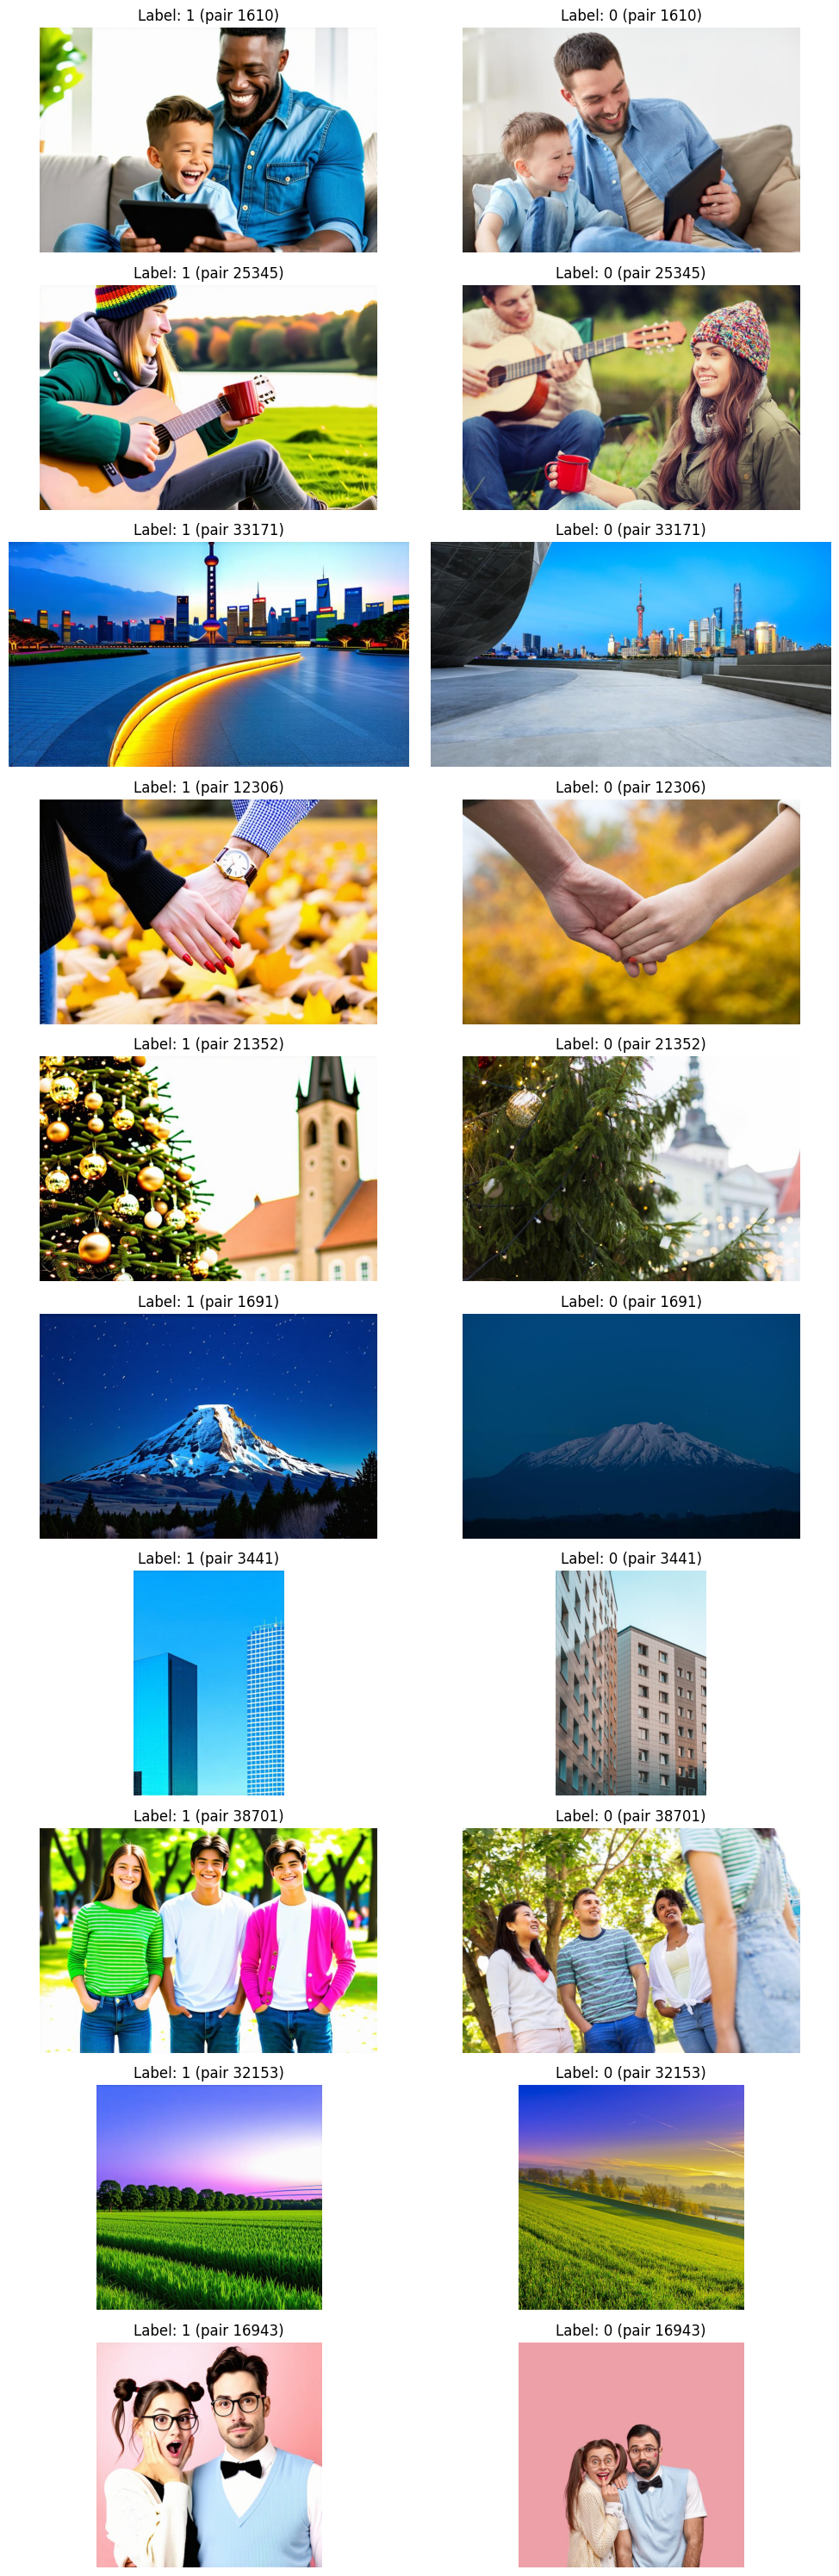

In [6]:
import matplotlib.pyplot as plt
import cv2

# Helper function to show example pairs
def show_pairs(df, img_dir, num_pairs=5):
    unique_pairs = df['pair_id'].unique()
    sample_pairs = np.random.choice(unique_pairs, num_pairs, replace=False)

    plt.figure(figsize=(10, num_pairs*3))

    for i, pid in enumerate(sample_pairs):
        pair_data = df[df['pair_id'] == pid]

        for j, row in enumerate(pair_data.itertuples()):
            img_path = f"{img_dir}/{row.file_name}"
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(num_pairs, 2, i*2 + j + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Label: {row.label} (pair {pid})")

    plt.tight_layout()
    plt.show()

# Show 5 random pairs
show_pairs(train_df, img_dir, num_pairs=10)

In [7]:
train_pairs, val_pairs = train_test_split(unique_pairs, test_size=0.2, random_state=42, shuffle=True)
train_df_split = train_df[train_df['pair_id'].isin(train_pairs)].reset_index(drop=True)
val_df_split   = train_df[train_df['pair_id'].isin(val_pairs)].reset_index(drop=True)
print("Training samples:", len(train_df_split), "Validation samples:", len(val_df_split))

Training samples: 63960 Validation samples: 15990


# === Data Transforms ===

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# TTA transforms (a few variants)
tta_transforms = [
    val_transform,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
]

# === Custom Dataset Class ===

In [9]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if self.is_test:
            img_path = os.path.join(self.img_dir, self.dataframe.iloc[idx]['id'])
        else:
            img_path = os.path.join(self.img_dir, self.dataframe.iloc[idx]['file_name'])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        if self.is_test:
            return image, self.dataframe.iloc[idx]['id']
        else:
            label = self.dataframe.iloc[idx]['label']
            return image, label

# === Lightning DataModule with Train/Val Split ===

In [10]:
class ImageDataModule(LightningDataModule):
    def __init__(self, train_df, val_df, test_df, img_dir, batch_size=64):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.img_dir = img_dir
        self.batch_size = batch_size

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = CustomDataset(self.train_df, self.img_dir, transform=train_transform)
            self.val_dataset   = CustomDataset(self.val_df, self.img_dir, transform=val_transform)
        if stage == 'test' or stage is None:
            self.test_dataset = CustomDataset(self.test_df, self.img_dir, transform=val_transform, is_test=True)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)

# === EfficientNet-Lite Model ===

In [11]:
class EfficientNetLiteClassifier(LightningModule):
    def __init__(self, num_classes=2, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = timm.create_model('tf_efficientnet_lite0', pretrained=True, num_classes=num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        return optimizer

# === Initialize DataModule ===

In [12]:
datamodule = ImageDataModule(train_df_split, val_df_split, test_df, img_dir, batch_size=64)

# === Initialize Models ===

In [13]:
model_efficientnet = EfficientNetLiteClassifier(num_classes=2)

# === Train Each Model Separately Using Its Own Trainer Instance ===

In [14]:
# Train EfficientNet‑Lite for 3 epochs
trainer_efficientnet = Trainer(
    max_epochs=3,
    accelerator='tpu',
    devices=1,
    precision="bf16-true",
    accumulate_grad_batches=4
)
trainer_efficientnet.fit(model_efficientnet, datamodule=datamodule)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


INFO: GPU available: False, used: False


INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False


INFO: TPU available: True, using: 1 TPU cores


INFO:lightning.pytorch.utilities.rank_zero:TPU available: True, using: 1 TPU cores


INFO: HPU available: False, using: 0 HPUs


INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


E0000 00:00:1759403798.666259      74 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


INFO: 
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | EfficientNet     | 3.4 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
6.747     Total estimated model params size (MB)
274       Modules in train mode
0         Modules in eval mode


INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | EfficientNet     | 3.4 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
6.747     Total estimated model params size (MB)
274       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 14.58it/s]

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 15.72it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0:   0%|          | 1/1000 [00:01<24:33,  0.68it/s]

Epoch 0:   0%|          | 1/1000 [00:16<4:38:52,  0.06it/s, v_num=0, train_loss=3.200, train_acc=0.562]

Epoch 0:   0%|          | 2/1000 [00:16<2:20:10,  0.12it/s, v_num=0, train_loss=3.200, train_acc=0.562]

Epoch 0:   0%|          | 2/1000 [00:29<4:05:50,  0.07it/s, v_num=0, train_loss=1.970, train_acc=0.594]

Epoch 0:   0%|          | 3/1000 [00:29<2:44:23,  0.10it/s, v_num=0, train_loss=1.970, train_acc=0.594]

Epoch 0:   0%|          | 3/1000 [00:42<3:56:03,  0.07it/s, v_num=0, train_loss=2.670, train_acc=0.531]

Epoch 0:   0%|          | 4/1000 [01:37<6:45:47,  0.04it/s, v_num=0, train_loss=2.670, train_acc=0.531]

Epoch 0:   0%|          | 4/1000 [01:38<6:47:00,  0.04it/s, v_num=0, train_loss=3.360, train_acc=0.438]

Epoch 0:   0%|          | 5/1000 [01:38<5:25:29,  0.05it/s, v_num=0, train_loss=3.360, train_acc=0.438]

Epoch 0:   0%|          | 5/1000 [01:38<5:25:31,  0.05it/s, v_num=0, train_loss=2.220, train_acc=0.547]

Epoch 0:   1%|          | 6/1000 [01:38<4:31:13,  0.06it/s, v_num=0, train_loss=2.220, train_acc=0.547]

Epoch 0:   1%|          | 6/1000 [01:38<4:31:15,  0.06it/s, v_num=0, train_loss=2.610, train_acc=0.531]

Epoch 0:   1%|          | 7/1000 [01:38<3:52:27,  0.07it/s, v_num=0, train_loss=2.610, train_acc=0.531]

Epoch 0:   1%|          | 7/1000 [01:38<3:52:29,  0.07it/s, v_num=0, train_loss=2.160, train_acc=0.547]

Epoch 0:   1%|          | 8/1000 [02:34<5:18:34,  0.05it/s, v_num=0, train_loss=2.160, train_acc=0.547]

Epoch 0:   1%|          | 8/1000 [02:34<5:19:20,  0.05it/s, v_num=0, train_loss=2.620, train_acc=0.484]

Epoch 0:   1%|          | 9/1000 [02:34<4:43:42,  0.06it/s, v_num=0, train_loss=2.620, train_acc=0.484]

Epoch 0:   1%|          | 9/1000 [02:34<4:43:43,  0.06it/s, v_num=0, train_loss=2.250, train_acc=0.562]

Epoch 0:   1%|          | 10/1000 [02:34<4:15:13,  0.06it/s, v_num=0, train_loss=2.250, train_acc=0.562]

Epoch 0:   1%|          | 10/1000 [02:34<4:15:14,  0.06it/s, v_num=0, train_loss=2.560, train_acc=0.484]

Epoch 0:   1%|          | 11/1000 [02:34<3:51:55,  0.07it/s, v_num=0, train_loss=2.560, train_acc=0.484]

Epoch 0:   1%|          | 11/1000 [02:34<3:51:56,  0.07it/s, v_num=0, train_loss=2.420, train_acc=0.547]

Epoch 0:   1%|          | 12/1000 [02:35<3:32:58,  0.08it/s, v_num=0, train_loss=2.420, train_acc=0.547]

Epoch 0:   1%|          | 12/1000 [02:35<3:33:02,  0.08it/s, v_num=0, train_loss=1.710, train_acc=0.672]

Epoch 0:   1%|▏         | 13/1000 [02:35<3:16:33,  0.08it/s, v_num=0, train_loss=1.710, train_acc=0.672]

Epoch 0:   1%|▏         | 13/1000 [02:35<3:16:34,  0.08it/s, v_num=0, train_loss=2.560, train_acc=0.562]

Epoch 0:   1%|▏         | 14/1000 [02:35<3:02:26,  0.09it/s, v_num=0, train_loss=2.560, train_acc=0.562]

Epoch 0:   1%|▏         | 14/1000 [02:35<3:02:27,  0.09it/s, v_num=0, train_loss=2.700, train_acc=0.500]

Epoch 0:   2%|▏         | 15/1000 [02:35<2:50:12,  0.10it/s, v_num=0, train_loss=2.700, train_acc=0.500]

Epoch 0:   2%|▏         | 15/1000 [02:35<2:50:13,  0.10it/s, v_num=0, train_loss=2.280, train_acc=0.500]

Epoch 0:   2%|▏         | 16/1000 [02:35<2:39:49,  0.10it/s, v_num=0, train_loss=2.280, train_acc=0.500]

Epoch 0:   2%|▏         | 16/1000 [02:35<2:39:52,  0.10it/s, v_num=0, train_loss=2.380, train_acc=0.516]

Epoch 0:   2%|▏         | 17/1000 [02:36<2:30:27,  0.11it/s, v_num=0, train_loss=2.380, train_acc=0.516]

Epoch 0:   2%|▏         | 17/1000 [02:36<2:30:27,  0.11it/s, v_num=0, train_loss=1.610, train_acc=0.547]

Epoch 0:   2%|▏         | 18/1000 [02:36<2:22:02,  0.12it/s, v_num=0, train_loss=1.610, train_acc=0.547]

Epoch 0:   2%|▏         | 18/1000 [02:36<2:22:02,  0.12it/s, v_num=0, train_loss=2.050, train_acc=0.531]

Epoch 0:   2%|▏         | 19/1000 [02:36<2:14:30,  0.12it/s, v_num=0, train_loss=2.050, train_acc=0.531]

Epoch 0:   2%|▏         | 19/1000 [02:36<2:14:30,  0.12it/s, v_num=0, train_loss=1.680, train_acc=0.578]

Epoch 0:   2%|▏         | 20/1000 [02:36<2:07:58,  0.13it/s, v_num=0, train_loss=1.680, train_acc=0.578]

Epoch 0:   2%|▏         | 20/1000 [02:36<2:08:01,  0.13it/s, v_num=0, train_loss=1.820, train_acc=0.562]

Epoch 0:   2%|▏         | 21/1000 [02:37<2:02:21,  0.13it/s, v_num=0, train_loss=1.820, train_acc=0.562]

Epoch 0:   2%|▏         | 21/1000 [02:37<2:02:22,  0.13it/s, v_num=0, train_loss=2.860, train_acc=0.469]

Epoch 0:   2%|▏         | 22/1000 [02:37<1:56:46,  0.14it/s, v_num=0, train_loss=2.860, train_acc=0.469]

Epoch 0:   2%|▏         | 22/1000 [02:37<1:56:47,  0.14it/s, v_num=0, train_loss=2.450, train_acc=0.500]

Epoch 0:   2%|▏         | 23/1000 [02:37<1:51:39,  0.15it/s, v_num=0, train_loss=2.450, train_acc=0.500]

Epoch 0:   2%|▏         | 23/1000 [02:37<1:51:39,  0.15it/s, v_num=0, train_loss=2.330, train_acc=0.484]

Epoch 0:   2%|▏         | 24/1000 [02:38<1:47:10,  0.15it/s, v_num=0, train_loss=2.330, train_acc=0.484]

Epoch 0:   2%|▏         | 24/1000 [02:38<1:47:13,  0.15it/s, v_num=0, train_loss=2.060, train_acc=0.562]

Epoch 0:   2%|▎         | 25/1000 [02:38<1:43:17,  0.16it/s, v_num=0, train_loss=2.060, train_acc=0.562]

Epoch 0:   2%|▎         | 25/1000 [02:38<1:43:17,  0.16it/s, v_num=0, train_loss=2.310, train_acc=0.594]

Epoch 0:   3%|▎         | 26/1000 [02:39<1:39:16,  0.16it/s, v_num=0, train_loss=2.310, train_acc=0.594]

Epoch 0:   3%|▎         | 26/1000 [02:39<1:39:17,  0.16it/s, v_num=0, train_loss=1.690, train_acc=0.656]

Epoch 0:   3%|▎         | 27/1000 [02:39<1:35:34,  0.17it/s, v_num=0, train_loss=1.690, train_acc=0.656]

Epoch 0:   3%|▎         | 27/1000 [02:39<1:35:34,  0.17it/s, v_num=0, train_loss=1.860, train_acc=0.609]

Epoch 0:   3%|▎         | 28/1000 [02:39<1:32:17,  0.18it/s, v_num=0, train_loss=1.860, train_acc=0.609]

Epoch 0:   3%|▎         | 28/1000 [02:39<1:32:19,  0.18it/s, v_num=0, train_loss=2.470, train_acc=0.531]

Epoch 0:   3%|▎         | 29/1000 [02:40<1:29:26,  0.18it/s, v_num=0, train_loss=2.470, train_acc=0.531]

Epoch 0:   3%|▎         | 29/1000 [02:40<1:29:26,  0.18it/s, v_num=0, train_loss=2.160, train_acc=0.641]

Epoch 0:   3%|▎         | 30/1000 [02:40<1:26:26,  0.19it/s, v_num=0, train_loss=2.160, train_acc=0.641]

Epoch 0:   3%|▎         | 30/1000 [02:40<1:26:26,  0.19it/s, v_num=0, train_loss=1.450, train_acc=0.641]

Epoch 0:   3%|▎         | 31/1000 [02:40<1:23:37,  0.19it/s, v_num=0, train_loss=1.450, train_acc=0.641]

Epoch 0:   3%|▎         | 31/1000 [02:40<1:23:37,  0.19it/s, v_num=0, train_loss=1.980, train_acc=0.531]

Epoch 0:   3%|▎         | 32/1000 [02:40<1:21:06,  0.20it/s, v_num=0, train_loss=1.980, train_acc=0.531]

Epoch 0:   3%|▎         | 32/1000 [02:40<1:21:08,  0.20it/s, v_num=0, train_loss=2.380, train_acc=0.594]

Epoch 0:   3%|▎         | 33/1000 [02:41<1:18:56,  0.20it/s, v_num=0, train_loss=2.380, train_acc=0.594]

Epoch 0:   3%|▎         | 33/1000 [02:41<1:18:57,  0.20it/s, v_num=0, train_loss=1.540, train_acc=0.609]

Epoch 0:   3%|▎         | 34/1000 [02:41<1:16:35,  0.21it/s, v_num=0, train_loss=1.540, train_acc=0.609]

Epoch 0:   3%|▎         | 34/1000 [02:41<1:16:35,  0.21it/s, v_num=0, train_loss=1.590, train_acc=0.578]

Epoch 0:   4%|▎         | 35/1000 [02:41<1:14:23,  0.22it/s, v_num=0, train_loss=1.590, train_acc=0.578]

Epoch 0:   4%|▎         | 35/1000 [02:41<1:14:24,  0.22it/s, v_num=0, train_loss=2.050, train_acc=0.531]

Epoch 0:   4%|▎         | 36/1000 [02:42<1:12:25,  0.22it/s, v_num=0, train_loss=2.050, train_acc=0.531]

Epoch 0:   4%|▎         | 36/1000 [02:42<1:12:27,  0.22it/s, v_num=0, train_loss=2.020, train_acc=0.578]

Epoch 0:   4%|▎         | 37/1000 [02:42<1:10:42,  0.23it/s, v_num=0, train_loss=2.020, train_acc=0.578]

Epoch 0:   4%|▎         | 37/1000 [02:42<1:10:42,  0.23it/s, v_num=0, train_loss=1.980, train_acc=0.547]

Epoch 0:   4%|▍         | 38/1000 [02:43<1:08:48,  0.23it/s, v_num=0, train_loss=1.980, train_acc=0.547]

Epoch 0:   4%|▍         | 38/1000 [02:43<1:08:48,  0.23it/s, v_num=0, train_loss=2.920, train_acc=0.531]

Epoch 0:   4%|▍         | 39/1000 [02:43<1:07:02,  0.24it/s, v_num=0, train_loss=2.920, train_acc=0.531]

Epoch 0:   4%|▍         | 39/1000 [02:43<1:07:02,  0.24it/s, v_num=0, train_loss=1.480, train_acc=0.656]

Epoch 0:   4%|▍         | 40/1000 [02:43<1:05:27,  0.24it/s, v_num=0, train_loss=1.480, train_acc=0.656]

Epoch 0:   4%|▍         | 40/1000 [02:43<1:05:28,  0.24it/s, v_num=0, train_loss=2.340, train_acc=0.516]

Epoch 0:   4%|▍         | 41/1000 [02:44<1:04:03,  0.25it/s, v_num=0, train_loss=2.340, train_acc=0.516]

Epoch 0:   4%|▍         | 41/1000 [02:44<1:04:04,  0.25it/s, v_num=0, train_loss=1.890, train_acc=0.594]

Epoch 0:   4%|▍         | 42/1000 [02:44<1:02:31,  0.26it/s, v_num=0, train_loss=1.890, train_acc=0.594]

Epoch 0:   4%|▍         | 42/1000 [02:44<1:02:31,  0.26it/s, v_num=0, train_loss=2.310, train_acc=0.547]

Epoch 0:   4%|▍         | 43/1000 [02:44<1:01:03,  0.26it/s, v_num=0, train_loss=2.310, train_acc=0.547]

Epoch 0:   4%|▍         | 43/1000 [02:44<1:01:03,  0.26it/s, v_num=0, train_loss=1.590, train_acc=0.562]

Epoch 0:   4%|▍         | 44/1000 [02:44<59:44,  0.27it/s, v_num=0, train_loss=1.590, train_acc=0.562]  

Epoch 0:   4%|▍         | 44/1000 [02:45<59:45,  0.27it/s, v_num=0, train_loss=1.520, train_acc=0.672]

Epoch 0:   4%|▍         | 45/1000 [02:45<58:37,  0.27it/s, v_num=0, train_loss=1.520, train_acc=0.672]

Epoch 0:   4%|▍         | 45/1000 [02:45<58:37,  0.27it/s, v_num=0, train_loss=1.600, train_acc=0.672]

Epoch 0:   5%|▍         | 46/1000 [02:45<57:19,  0.28it/s, v_num=0, train_loss=1.600, train_acc=0.672]

Epoch 0:   5%|▍         | 46/1000 [02:45<57:20,  0.28it/s, v_num=0, train_loss=1.780, train_acc=0.547]

Epoch 0:   5%|▍         | 47/1000 [02:45<56:05,  0.28it/s, v_num=0, train_loss=1.780, train_acc=0.547]

Epoch 0:   5%|▍         | 47/1000 [02:45<56:05,  0.28it/s, v_num=0, train_loss=1.200, train_acc=0.719]

Epoch 0:   5%|▍         | 48/1000 [02:46<54:59,  0.29it/s, v_num=0, train_loss=1.200, train_acc=0.719]

Epoch 0:   5%|▍         | 48/1000 [02:46<55:00,  0.29it/s, v_num=0, train_loss=2.410, train_acc=0.625]

Epoch 0:   5%|▍         | 49/1000 [02:47<54:03,  0.29it/s, v_num=0, train_loss=2.410, train_acc=0.625]

Epoch 0:   5%|▍         | 49/1000 [02:47<54:03,  0.29it/s, v_num=0, train_loss=2.160, train_acc=0.594]

Epoch 0:   5%|▌         | 50/1000 [02:47<52:58,  0.30it/s, v_num=0, train_loss=2.160, train_acc=0.594]

Epoch 0:   5%|▌         | 50/1000 [02:47<52:58,  0.30it/s, v_num=0, train_loss=1.910, train_acc=0.672]

Epoch 0:   5%|▌         | 51/1000 [02:47<51:55,  0.30it/s, v_num=0, train_loss=1.910, train_acc=0.672]

Epoch 0:   5%|▌         | 51/1000 [02:47<51:55,  0.30it/s, v_num=0, train_loss=1.480, train_acc=0.656]

Epoch 0:   5%|▌         | 52/1000 [02:47<50:59,  0.31it/s, v_num=0, train_loss=1.480, train_acc=0.656]

Epoch 0:   5%|▌         | 52/1000 [02:47<51:00,  0.31it/s, v_num=0, train_loss=1.770, train_acc=0.641]

Epoch 0:   5%|▌         | 53/1000 [02:48<50:11,  0.31it/s, v_num=0, train_loss=1.770, train_acc=0.641]

Epoch 0:   5%|▌         | 53/1000 [02:48<50:11,  0.31it/s, v_num=0, train_loss=1.640, train_acc=0.609]

Epoch 0:   5%|▌         | 54/1000 [02:48<49:16,  0.32it/s, v_num=0, train_loss=1.640, train_acc=0.609]

Epoch 0:   5%|▌         | 54/1000 [02:48<49:16,  0.32it/s, v_num=0, train_loss=1.440, train_acc=0.641]

Epoch 0:   6%|▌         | 55/1000 [02:48<48:22,  0.33it/s, v_num=0, train_loss=1.440, train_acc=0.641]

Epoch 0:   6%|▌         | 55/1000 [02:48<48:22,  0.33it/s, v_num=0, train_loss=1.630, train_acc=0.688]

Epoch 0:   6%|▌         | 56/1000 [02:49<47:34,  0.33it/s, v_num=0, train_loss=1.630, train_acc=0.688]

Epoch 0:   6%|▌         | 56/1000 [02:49<47:35,  0.33it/s, v_num=0, train_loss=1.350, train_acc=0.641]

Epoch 0:   6%|▌         | 57/1000 [02:49<46:51,  0.34it/s, v_num=0, train_loss=1.350, train_acc=0.641]

Epoch 0:   6%|▌         | 57/1000 [02:49<46:51,  0.34it/s, v_num=0, train_loss=1.620, train_acc=0.719]

Epoch 0:   6%|▌         | 58/1000 [02:50<46:03,  0.34it/s, v_num=0, train_loss=1.620, train_acc=0.719]

Epoch 0:   6%|▌         | 58/1000 [02:50<46:04,  0.34it/s, v_num=0, train_loss=1.350, train_acc=0.734]

Epoch 0:   6%|▌         | 59/1000 [02:50<45:17,  0.35it/s, v_num=0, train_loss=1.350, train_acc=0.734]

Epoch 0:   6%|▌         | 59/1000 [02:50<45:17,  0.35it/s, v_num=0, train_loss=1.310, train_acc=0.688]

Epoch 0:   6%|▌         | 60/1000 [02:50<44:35,  0.35it/s, v_num=0, train_loss=1.310, train_acc=0.688]

Epoch 0:   6%|▌         | 60/1000 [02:50<44:36,  0.35it/s, v_num=0, train_loss=1.430, train_acc=0.781]

Epoch 0:   6%|▌         | 61/1000 [02:51<43:58,  0.36it/s, v_num=0, train_loss=1.430, train_acc=0.781]

Epoch 0:   6%|▌         | 61/1000 [02:51<43:58,  0.36it/s, v_num=0, train_loss=1.120, train_acc=0.688]

Epoch 0:   6%|▌         | 62/1000 [02:51<43:15,  0.36it/s, v_num=0, train_loss=1.120, train_acc=0.688]

Epoch 0:   6%|▌         | 62/1000 [02:51<43:16,  0.36it/s, v_num=0, train_loss=1.300, train_acc=0.734]

Epoch 0:   6%|▋         | 63/1000 [02:51<42:34,  0.37it/s, v_num=0, train_loss=1.300, train_acc=0.734]

Epoch 0:   6%|▋         | 63/1000 [02:51<42:35,  0.37it/s, v_num=0, train_loss=1.290, train_acc=0.703]

Epoch 0:   6%|▋         | 64/1000 [02:52<41:58,  0.37it/s, v_num=0, train_loss=1.290, train_acc=0.703]

Epoch 0:   6%|▋         | 64/1000 [02:52<41:59,  0.37it/s, v_num=0, train_loss=2.300, train_acc=0.562]

Epoch 0:   6%|▋         | 65/1000 [02:52<41:25,  0.38it/s, v_num=0, train_loss=2.300, train_acc=0.562]

Epoch 0:   6%|▋         | 65/1000 [02:52<41:25,  0.38it/s, v_num=0, train_loss=1.680, train_acc=0.625]

Epoch 0:   7%|▋         | 66/1000 [02:52<40:48,  0.38it/s, v_num=0, train_loss=1.680, train_acc=0.625]

Epoch 0:   7%|▋         | 66/1000 [02:53<40:48,  0.38it/s, v_num=0, train_loss=1.770, train_acc=0.625]

Epoch 0:   7%|▋         | 67/1000 [02:53<40:11,  0.39it/s, v_num=0, train_loss=1.770, train_acc=0.625]

Epoch 0:   7%|▋         | 67/1000 [02:53<40:11,  0.39it/s, v_num=0, train_loss=1.570, train_acc=0.688]

Epoch 0:   7%|▋         | 68/1000 [02:53<39:39,  0.39it/s, v_num=0, train_loss=1.570, train_acc=0.688]

Epoch 0:   7%|▋         | 68/1000 [02:53<39:39,  0.39it/s, v_num=0, train_loss=1.840, train_acc=0.641]

Epoch 0:   7%|▋         | 69/1000 [02:54<39:09,  0.40it/s, v_num=0, train_loss=1.840, train_acc=0.641]

Epoch 0:   7%|▋         | 69/1000 [02:54<39:10,  0.40it/s, v_num=0, train_loss=1.870, train_acc=0.578]

Epoch 0:   7%|▋         | 70/1000 [02:54<38:36,  0.40it/s, v_num=0, train_loss=1.870, train_acc=0.578]

Epoch 0:   7%|▋         | 70/1000 [02:54<38:36,  0.40it/s, v_num=0, train_loss=1.850, train_acc=0.656]

Epoch 0:   7%|▋         | 71/1000 [02:54<38:04,  0.41it/s, v_num=0, train_loss=1.850, train_acc=0.656]

Epoch 0:   7%|▋         | 71/1000 [02:54<38:04,  0.41it/s, v_num=0, train_loss=1.680, train_acc=0.625]

Epoch 0:   7%|▋         | 72/1000 [02:54<37:35,  0.41it/s, v_num=0, train_loss=1.680, train_acc=0.625]

Epoch 0:   7%|▋         | 72/1000 [02:55<37:36,  0.41it/s, v_num=0, train_loss=1.960, train_acc=0.609]

Epoch 0:   7%|▋         | 73/1000 [02:55<37:09,  0.42it/s, v_num=0, train_loss=1.960, train_acc=0.609]

Epoch 0:   7%|▋         | 73/1000 [02:55<37:09,  0.42it/s, v_num=0, train_loss=1.340, train_acc=0.719]

Epoch 0:   7%|▋         | 74/1000 [02:55<36:39,  0.42it/s, v_num=0, train_loss=1.340, train_acc=0.719]

Epoch 0:   7%|▋         | 74/1000 [02:55<36:39,  0.42it/s, v_num=0, train_loss=1.770, train_acc=0.578]

Epoch 0:   8%|▊         | 75/1000 [02:56<36:11,  0.43it/s, v_num=0, train_loss=1.770, train_acc=0.578]

Epoch 0:   8%|▊         | 75/1000 [02:56<36:11,  0.43it/s, v_num=0, train_loss=1.740, train_acc=0.672]

Epoch 0:   8%|▊         | 76/1000 [02:56<35:44,  0.43it/s, v_num=0, train_loss=1.740, train_acc=0.672]

Epoch 0:   8%|▊         | 76/1000 [02:56<35:45,  0.43it/s, v_num=0, train_loss=1.590, train_acc=0.703]

Epoch 0:   8%|▊         | 77/1000 [02:56<35:21,  0.44it/s, v_num=0, train_loss=1.590, train_acc=0.703]

Epoch 0:   8%|▊         | 77/1000 [02:56<35:21,  0.44it/s, v_num=0, train_loss=1.030, train_acc=0.703]

Epoch 0:   8%|▊         | 78/1000 [02:57<34:54,  0.44it/s, v_num=0, train_loss=1.030, train_acc=0.703]

Epoch 0:   8%|▊         | 78/1000 [02:57<34:54,  0.44it/s, v_num=0, train_loss=2.170, train_acc=0.547]

Epoch 0:   8%|▊         | 79/1000 [02:57<34:28,  0.45it/s, v_num=0, train_loss=2.170, train_acc=0.547]

Epoch 0:   8%|▊         | 79/1000 [02:57<34:28,  0.45it/s, v_num=0, train_loss=1.560, train_acc=0.641]

Epoch 0:   8%|▊         | 80/1000 [02:57<34:04,  0.45it/s, v_num=0, train_loss=1.560, train_acc=0.641]

Epoch 0:   8%|▊         | 80/1000 [02:57<34:05,  0.45it/s, v_num=0, train_loss=1.000, train_acc=0.672]

Epoch 0:   8%|▊         | 81/1000 [02:58<33:44,  0.45it/s, v_num=0, train_loss=1.000, train_acc=0.672]

Epoch 0:   8%|▊         | 81/1000 [02:58<33:44,  0.45it/s, v_num=0, train_loss=1.190, train_acc=0.719]

Epoch 0:   8%|▊         | 82/1000 [02:58<33:19,  0.46it/s, v_num=0, train_loss=1.190, train_acc=0.719]

Epoch 0:   8%|▊         | 82/1000 [02:58<33:19,  0.46it/s, v_num=0, train_loss=0.984, train_acc=0.656]

Epoch 0:   8%|▊         | 83/1000 [02:58<32:55,  0.46it/s, v_num=0, train_loss=0.984, train_acc=0.656]

Epoch 0:   8%|▊         | 83/1000 [02:58<32:55,  0.46it/s, v_num=0, train_loss=1.160, train_acc=0.625]

Epoch 0:   8%|▊         | 84/1000 [02:59<32:33,  0.47it/s, v_num=0, train_loss=1.160, train_acc=0.625]

Epoch 0:   8%|▊         | 84/1000 [02:59<32:34,  0.47it/s, v_num=0, train_loss=1.250, train_acc=0.703]

Epoch 0:   8%|▊         | 85/1000 [02:59<32:15,  0.47it/s, v_num=0, train_loss=1.250, train_acc=0.703]

Epoch 0:   8%|▊         | 85/1000 [02:59<32:15,  0.47it/s, v_num=0, train_loss=2.120, train_acc=0.656]

Epoch 0:   9%|▊         | 86/1000 [03:00<31:53,  0.48it/s, v_num=0, train_loss=2.120, train_acc=0.656]

Epoch 0:   9%|▊         | 86/1000 [03:00<31:53,  0.48it/s, v_num=0, train_loss=1.530, train_acc=0.578]

Epoch 0:   9%|▊         | 87/1000 [03:00<31:30,  0.48it/s, v_num=0, train_loss=1.530, train_acc=0.578]

Epoch 0:   9%|▊         | 87/1000 [03:00<31:31,  0.48it/s, v_num=0, train_loss=1.200, train_acc=0.703]

Epoch 0:   9%|▉         | 88/1000 [03:00<31:11,  0.49it/s, v_num=0, train_loss=1.200, train_acc=0.703]

Epoch 0:   9%|▉         | 88/1000 [03:00<31:12,  0.49it/s, v_num=0, train_loss=1.530, train_acc=0.672]

Epoch 0:   9%|▉         | 89/1000 [03:01<30:54,  0.49it/s, v_num=0, train_loss=1.530, train_acc=0.672]

Epoch 0:   9%|▉         | 89/1000 [03:01<30:55,  0.49it/s, v_num=0, train_loss=1.390, train_acc=0.688]

Epoch 0:   9%|▉         | 90/1000 [03:01<30:35,  0.50it/s, v_num=0, train_loss=1.390, train_acc=0.688]

Epoch 0:   9%|▉         | 90/1000 [03:01<30:35,  0.50it/s, v_num=0, train_loss=1.270, train_acc=0.703]

Epoch 0:   9%|▉         | 91/1000 [03:01<30:14,  0.50it/s, v_num=0, train_loss=1.270, train_acc=0.703]

Epoch 0:   9%|▉         | 91/1000 [03:01<30:14,  0.50it/s, v_num=0, train_loss=1.560, train_acc=0.594]

Epoch 0:   9%|▉         | 92/1000 [03:02<29:56,  0.51it/s, v_num=0, train_loss=1.560, train_acc=0.594]

Epoch 0:   9%|▉         | 92/1000 [03:02<29:57,  0.51it/s, v_num=0, train_loss=1.750, train_acc=0.656]

Epoch 0:   9%|▉         | 93/1000 [03:02<29:41,  0.51it/s, v_num=0, train_loss=1.750, train_acc=0.656]

Epoch 0:   9%|▉         | 93/1000 [03:02<29:41,  0.51it/s, v_num=0, train_loss=2.080, train_acc=0.641]

Epoch 0:   9%|▉         | 94/1000 [03:02<29:23,  0.51it/s, v_num=0, train_loss=2.080, train_acc=0.641]

Epoch 0:   9%|▉         | 94/1000 [03:03<29:23,  0.51it/s, v_num=0, train_loss=1.110, train_acc=0.750]

Epoch 0:  10%|▉         | 95/1000 [03:03<29:04,  0.52it/s, v_num=0, train_loss=1.110, train_acc=0.750]

Epoch 0:  10%|▉         | 95/1000 [03:03<29:04,  0.52it/s, v_num=0, train_loss=1.460, train_acc=0.719]

Epoch 0:  10%|▉         | 96/1000 [03:03<28:47,  0.52it/s, v_num=0, train_loss=1.460, train_acc=0.719]

Epoch 0:  10%|▉         | 96/1000 [03:03<28:48,  0.52it/s, v_num=0, train_loss=1.230, train_acc=0.766]

Epoch 0:  10%|▉         | 97/1000 [03:04<28:33,  0.53it/s, v_num=0, train_loss=1.230, train_acc=0.766]

Epoch 0:  10%|▉         | 97/1000 [03:04<28:33,  0.53it/s, v_num=0, train_loss=1.160, train_acc=0.703]

Epoch 0:  10%|▉         | 98/1000 [03:04<28:17,  0.53it/s, v_num=0, train_loss=1.160, train_acc=0.703]

Epoch 0:  10%|▉         | 98/1000 [03:04<28:17,  0.53it/s, v_num=0, train_loss=1.340, train_acc=0.656]

Epoch 0:  10%|▉         | 99/1000 [03:04<27:59,  0.54it/s, v_num=0, train_loss=1.340, train_acc=0.656]

Epoch 0:  10%|▉         | 99/1000 [03:04<27:59,  0.54it/s, v_num=0, train_loss=1.920, train_acc=0.578]

Epoch 0:  10%|█         | 100/1000 [03:04<27:44,  0.54it/s, v_num=0, train_loss=1.920, train_acc=0.578]

Epoch 0:  10%|█         | 100/1000 [03:04<27:44,  0.54it/s, v_num=0, train_loss=1.840, train_acc=0.688]

Epoch 0:  10%|█         | 101/1000 [03:05<27:31,  0.54it/s, v_num=0, train_loss=1.840, train_acc=0.688]

Epoch 0:  10%|█         | 101/1000 [03:05<27:32,  0.54it/s, v_num=0, train_loss=1.030, train_acc=0.750]

Epoch 0:  10%|█         | 102/1000 [03:05<27:16,  0.55it/s, v_num=0, train_loss=1.030, train_acc=0.750]

Epoch 0:  10%|█         | 102/1000 [03:05<27:16,  0.55it/s, v_num=0, train_loss=1.180, train_acc=0.734]

Epoch 0:  10%|█         | 103/1000 [03:05<26:59,  0.55it/s, v_num=0, train_loss=1.180, train_acc=0.734]

Epoch 0:  10%|█         | 103/1000 [03:05<26:59,  0.55it/s, v_num=0, train_loss=1.890, train_acc=0.578]

Epoch 0:  10%|█         | 104/1000 [03:06<26:45,  0.56it/s, v_num=0, train_loss=1.890, train_acc=0.578]

Epoch 0:  10%|█         | 104/1000 [03:06<26:45,  0.56it/s, v_num=0, train_loss=0.941, train_acc=0.781]

Epoch 0:  10%|█         | 105/1000 [03:06<26:33,  0.56it/s, v_num=0, train_loss=0.941, train_acc=0.781]

Epoch 0:  10%|█         | 105/1000 [03:06<26:33,  0.56it/s, v_num=0, train_loss=1.660, train_acc=0.641]

Epoch 0:  11%|█         | 106/1000 [03:07<26:18,  0.57it/s, v_num=0, train_loss=1.660, train_acc=0.641]

Epoch 0:  11%|█         | 106/1000 [03:07<26:18,  0.57it/s, v_num=0, train_loss=1.280, train_acc=0.641]

Epoch 0:  11%|█         | 107/1000 [03:07<26:02,  0.57it/s, v_num=0, train_loss=1.280, train_acc=0.641]

Epoch 0:  11%|█         | 107/1000 [03:07<26:03,  0.57it/s, v_num=0, train_loss=1.120, train_acc=0.703]

Epoch 0:  11%|█         | 108/1000 [03:07<25:50,  0.58it/s, v_num=0, train_loss=1.120, train_acc=0.703]

Epoch 0:  11%|█         | 108/1000 [03:07<25:50,  0.58it/s, v_num=0, train_loss=1.300, train_acc=0.719]

Epoch 0:  11%|█         | 109/1000 [03:08<25:39,  0.58it/s, v_num=0, train_loss=1.300, train_acc=0.719]

Epoch 0:  11%|█         | 109/1000 [03:08<25:39,  0.58it/s, v_num=0, train_loss=0.922, train_acc=0.734]

Epoch 0:  11%|█         | 110/1000 [03:08<25:25,  0.58it/s, v_num=0, train_loss=0.922, train_acc=0.734]

Epoch 0:  11%|█         | 110/1000 [03:08<25:25,  0.58it/s, v_num=0, train_loss=1.090, train_acc=0.781]

Epoch 0:  11%|█         | 111/1000 [03:08<25:10,  0.59it/s, v_num=0, train_loss=1.090, train_acc=0.781]

Epoch 0:  11%|█         | 111/1000 [03:08<25:11,  0.59it/s, v_num=0, train_loss=1.020, train_acc=0.719]

Epoch 0:  11%|█         | 112/1000 [03:09<24:58,  0.59it/s, v_num=0, train_loss=1.020, train_acc=0.719]

Epoch 0:  11%|█         | 112/1000 [03:09<24:59,  0.59it/s, v_num=0, train_loss=1.080, train_acc=0.828]

Epoch 0:  11%|█▏        | 113/1000 [03:09<24:48,  0.60it/s, v_num=0, train_loss=1.080, train_acc=0.828]

Epoch 0:  11%|█▏        | 113/1000 [03:09<24:49,  0.60it/s, v_num=0, train_loss=1.020, train_acc=0.703]

Epoch 0:  11%|█▏        | 114/1000 [03:09<24:35,  0.60it/s, v_num=0, train_loss=1.020, train_acc=0.703]

Epoch 0:  11%|█▏        | 114/1000 [03:09<24:35,  0.60it/s, v_num=0, train_loss=1.310, train_acc=0.750]

Epoch 0:  12%|█▏        | 115/1000 [03:09<24:21,  0.61it/s, v_num=0, train_loss=1.310, train_acc=0.750]

Epoch 0:  12%|█▏        | 115/1000 [03:09<24:22,  0.61it/s, v_num=0, train_loss=1.090, train_acc=0.703]

Epoch 0:  12%|█▏        | 116/1000 [03:10<24:10,  0.61it/s, v_num=0, train_loss=1.090, train_acc=0.703]

Epoch 0:  12%|█▏        | 116/1000 [03:10<24:11,  0.61it/s, v_num=0, train_loss=1.160, train_acc=0.750]

Epoch 0:  12%|█▏        | 117/1000 [03:11<24:01,  0.61it/s, v_num=0, train_loss=1.160, train_acc=0.750]

Epoch 0:  12%|█▏        | 117/1000 [03:11<24:01,  0.61it/s, v_num=0, train_loss=1.260, train_acc=0.719]

Epoch 0:  12%|█▏        | 118/1000 [03:11<23:49,  0.62it/s, v_num=0, train_loss=1.260, train_acc=0.719]

Epoch 0:  12%|█▏        | 118/1000 [03:11<23:49,  0.62it/s, v_num=0, train_loss=1.120, train_acc=0.703]

Epoch 0:  12%|█▏        | 119/1000 [03:11<23:36,  0.62it/s, v_num=0, train_loss=1.120, train_acc=0.703]

Epoch 0:  12%|█▏        | 119/1000 [03:11<23:36,  0.62it/s, v_num=0, train_loss=1.410, train_acc=0.688]

Epoch 0:  12%|█▏        | 120/1000 [03:11<23:25,  0.63it/s, v_num=0, train_loss=1.410, train_acc=0.688]

Epoch 0:  12%|█▏        | 120/1000 [03:11<23:26,  0.63it/s, v_num=0, train_loss=1.430, train_acc=0.734]

Epoch 0:  12%|█▏        | 121/1000 [03:12<23:18,  0.63it/s, v_num=0, train_loss=1.430, train_acc=0.734]

Epoch 0:  12%|█▏        | 121/1000 [03:12<23:18,  0.63it/s, v_num=0, train_loss=1.870, train_acc=0.625]

Epoch 0:  12%|█▏        | 122/1000 [03:12<23:06,  0.63it/s, v_num=0, train_loss=1.870, train_acc=0.625]

Epoch 0:  12%|█▏        | 122/1000 [03:12<23:06,  0.63it/s, v_num=0, train_loss=1.110, train_acc=0.734]

Epoch 0:  12%|█▏        | 123/1000 [03:12<22:54,  0.64it/s, v_num=0, train_loss=1.110, train_acc=0.734]

Epoch 0:  12%|█▏        | 123/1000 [03:12<22:54,  0.64it/s, v_num=0, train_loss=1.300, train_acc=0.766]

Epoch 0:  12%|█▏        | 124/1000 [03:13<22:44,  0.64it/s, v_num=0, train_loss=1.300, train_acc=0.766]

Epoch 0:  12%|█▏        | 124/1000 [03:13<22:44,  0.64it/s, v_num=0, train_loss=1.220, train_acc=0.688]

Epoch 0:  12%|█▎        | 125/1000 [03:14<22:38,  0.64it/s, v_num=0, train_loss=1.220, train_acc=0.688]

Epoch 0:  12%|█▎        | 125/1000 [03:14<22:38,  0.64it/s, v_num=0, train_loss=1.060, train_acc=0.734]

Epoch 0:  13%|█▎        | 126/1000 [03:14<22:26,  0.65it/s, v_num=0, train_loss=1.060, train_acc=0.734]

Epoch 0:  13%|█▎        | 126/1000 [03:14<22:26,  0.65it/s, v_num=0, train_loss=1.050, train_acc=0.703]

Epoch 0:  13%|█▎        | 127/1000 [03:14<22:15,  0.65it/s, v_num=0, train_loss=1.050, train_acc=0.703]

Epoch 0:  13%|█▎        | 127/1000 [03:14<22:15,  0.65it/s, v_num=0, train_loss=1.330, train_acc=0.688]

Epoch 0:  13%|█▎        | 128/1000 [03:14<22:05,  0.66it/s, v_num=0, train_loss=1.330, train_acc=0.688]

Epoch 0:  13%|█▎        | 128/1000 [03:14<22:06,  0.66it/s, v_num=0, train_loss=1.300, train_acc=0.703]

Epoch 0:  13%|█▎        | 129/1000 [03:15<22:00,  0.66it/s, v_num=0, train_loss=1.300, train_acc=0.703]

Epoch 0:  13%|█▎        | 129/1000 [03:15<22:00,  0.66it/s, v_num=0, train_loss=2.280, train_acc=0.594]

Epoch 0:  13%|█▎        | 130/1000 [03:15<21:49,  0.66it/s, v_num=0, train_loss=2.280, train_acc=0.594]

Epoch 0:  13%|█▎        | 130/1000 [03:15<21:49,  0.66it/s, v_num=0, train_loss=1.750, train_acc=0.672]

Epoch 0:  13%|█▎        | 131/1000 [03:15<21:38,  0.67it/s, v_num=0, train_loss=1.750, train_acc=0.672]

Epoch 0:  13%|█▎        | 131/1000 [03:15<21:38,  0.67it/s, v_num=0, train_loss=1.410, train_acc=0.688]

Epoch 0:  13%|█▎        | 132/1000 [03:16<21:29,  0.67it/s, v_num=0, train_loss=1.410, train_acc=0.688]

Epoch 0:  13%|█▎        | 132/1000 [03:16<21:30,  0.67it/s, v_num=0, train_loss=1.020, train_acc=0.688]

Epoch 0:  13%|█▎        | 133/1000 [03:16<21:23,  0.68it/s, v_num=0, train_loss=1.020, train_acc=0.688]

Epoch 0:  13%|█▎        | 133/1000 [03:16<21:23,  0.68it/s, v_num=0, train_loss=1.110, train_acc=0.688]

Epoch 0:  13%|█▎        | 134/1000 [03:17<21:13,  0.68it/s, v_num=0, train_loss=1.110, train_acc=0.688]

Epoch 0:  13%|█▎        | 134/1000 [03:17<21:14,  0.68it/s, v_num=0, train_loss=1.230, train_acc=0.734]

Epoch 0:  14%|█▎        | 135/1000 [03:17<21:03,  0.68it/s, v_num=0, train_loss=1.230, train_acc=0.734]

Epoch 0:  14%|█▎        | 135/1000 [03:17<21:03,  0.68it/s, v_num=0, train_loss=1.200, train_acc=0.719]

Epoch 0:  14%|█▎        | 136/1000 [03:17<20:55,  0.69it/s, v_num=0, train_loss=1.200, train_acc=0.719]

Epoch 0:  14%|█▎        | 136/1000 [03:17<20:55,  0.69it/s, v_num=0, train_loss=1.400, train_acc=0.703]

Epoch 0:  14%|█▎        | 137/1000 [03:18<20:49,  0.69it/s, v_num=0, train_loss=1.400, train_acc=0.703]

Epoch 0:  14%|█▎        | 137/1000 [03:18<20:49,  0.69it/s, v_num=0, train_loss=1.030, train_acc=0.688]

Epoch 0:  14%|█▍        | 138/1000 [03:18<20:40,  0.69it/s, v_num=0, train_loss=1.030, train_acc=0.688]

Epoch 0:  14%|█▍        | 138/1000 [03:18<20:40,  0.69it/s, v_num=0, train_loss=1.150, train_acc=0.750]

Epoch 0:  14%|█▍        | 139/1000 [03:18<20:30,  0.70it/s, v_num=0, train_loss=1.150, train_acc=0.750]

Epoch 0:  14%|█▍        | 139/1000 [03:18<20:30,  0.70it/s, v_num=0, train_loss=1.480, train_acc=0.625]

Epoch 0:  14%|█▍        | 140/1000 [03:19<20:23,  0.70it/s, v_num=0, train_loss=1.480, train_acc=0.625]

Epoch 0:  14%|█▍        | 140/1000 [03:19<20:23,  0.70it/s, v_num=0, train_loss=1.220, train_acc=0.719]

Epoch 0:  14%|█▍        | 141/1000 [03:19<20:17,  0.71it/s, v_num=0, train_loss=1.220, train_acc=0.719]

Epoch 0:  14%|█▍        | 141/1000 [03:19<20:17,  0.71it/s, v_num=0, train_loss=0.844, train_acc=0.750]

Epoch 0:  14%|█▍        | 142/1000 [03:19<20:08,  0.71it/s, v_num=0, train_loss=0.844, train_acc=0.750]

Epoch 0:  14%|█▍        | 142/1000 [03:19<20:08,  0.71it/s, v_num=0, train_loss=1.430, train_acc=0.672]

Epoch 0:  14%|█▍        | 143/1000 [03:20<19:59,  0.71it/s, v_num=0, train_loss=1.430, train_acc=0.672]

Epoch 0:  14%|█▍        | 143/1000 [03:20<19:59,  0.71it/s, v_num=0, train_loss=0.895, train_acc=0.734]

Epoch 0:  14%|█▍        | 144/1000 [03:20<19:51,  0.72it/s, v_num=0, train_loss=0.895, train_acc=0.734]

Epoch 0:  14%|█▍        | 144/1000 [03:20<19:51,  0.72it/s, v_num=0, train_loss=0.852, train_acc=0.734]

Epoch 0:  14%|█▍        | 145/1000 [03:21<19:46,  0.72it/s, v_num=0, train_loss=0.852, train_acc=0.734]

Epoch 0:  14%|█▍        | 145/1000 [03:21<19:46,  0.72it/s, v_num=0, train_loss=1.030, train_acc=0.766]

Epoch 0:  15%|█▍        | 146/1000 [03:21<19:37,  0.73it/s, v_num=0, train_loss=1.030, train_acc=0.766]

Epoch 0:  15%|█▍        | 146/1000 [03:21<19:37,  0.73it/s, v_num=0, train_loss=1.100, train_acc=0.750]

Epoch 0:  15%|█▍        | 147/1000 [03:21<19:28,  0.73it/s, v_num=0, train_loss=1.100, train_acc=0.750]

Epoch 0:  15%|█▍        | 147/1000 [03:21<19:28,  0.73it/s, v_num=0, train_loss=1.340, train_acc=0.734]

Epoch 0:  15%|█▍        | 148/1000 [03:21<19:21,  0.73it/s, v_num=0, train_loss=1.340, train_acc=0.734]

Epoch 0:  15%|█▍        | 148/1000 [03:21<19:22,  0.73it/s, v_num=0, train_loss=1.420, train_acc=0.688]

Epoch 0:  15%|█▍        | 149/1000 [03:22<19:17,  0.74it/s, v_num=0, train_loss=1.420, train_acc=0.688]

Epoch 0:  15%|█▍        | 149/1000 [03:22<19:17,  0.74it/s, v_num=0, train_loss=2.190, train_acc=0.609]

Epoch 0:  15%|█▌        | 150/1000 [03:22<19:08,  0.74it/s, v_num=0, train_loss=2.190, train_acc=0.609]

Epoch 0:  15%|█▌        | 150/1000 [03:22<19:08,  0.74it/s, v_num=0, train_loss=1.120, train_acc=0.766]

Epoch 0:  15%|█▌        | 151/1000 [03:22<19:00,  0.74it/s, v_num=0, train_loss=1.120, train_acc=0.766]

Epoch 0:  15%|█▌        | 151/1000 [03:22<19:00,  0.74it/s, v_num=0, train_loss=0.820, train_acc=0.766]

Epoch 0:  15%|█▌        | 152/1000 [03:23<18:53,  0.75it/s, v_num=0, train_loss=0.820, train_acc=0.766]

Epoch 0:  15%|█▌        | 152/1000 [03:23<18:53,  0.75it/s, v_num=0, train_loss=1.450, train_acc=0.703]

Epoch 0:  15%|█▌        | 153/1000 [03:23<18:49,  0.75it/s, v_num=0, train_loss=1.450, train_acc=0.703]

Epoch 0:  15%|█▌        | 153/1000 [03:23<18:49,  0.75it/s, v_num=0, train_loss=1.380, train_acc=0.703]

Epoch 0:  15%|█▌        | 154/1000 [03:24<18:41,  0.75it/s, v_num=0, train_loss=1.380, train_acc=0.703]

Epoch 0:  15%|█▌        | 154/1000 [03:24<18:41,  0.75it/s, v_num=0, train_loss=1.320, train_acc=0.688]

Epoch 0:  16%|█▌        | 155/1000 [03:24<18:33,  0.76it/s, v_num=0, train_loss=1.320, train_acc=0.688]

Epoch 0:  16%|█▌        | 155/1000 [03:24<18:33,  0.76it/s, v_num=0, train_loss=1.070, train_acc=0.766]

Epoch 0:  16%|█▌        | 156/1000 [03:24<18:26,  0.76it/s, v_num=0, train_loss=1.070, train_acc=0.766]

Epoch 0:  16%|█▌        | 156/1000 [03:24<18:27,  0.76it/s, v_num=0, train_loss=0.723, train_acc=0.797]

Epoch 0:  16%|█▌        | 157/1000 [03:25<18:22,  0.76it/s, v_num=0, train_loss=0.723, train_acc=0.797]

Epoch 0:  16%|█▌        | 157/1000 [03:25<18:22,  0.76it/s, v_num=0, train_loss=1.170, train_acc=0.703]

Epoch 0:  16%|█▌        | 158/1000 [03:25<18:14,  0.77it/s, v_num=0, train_loss=1.170, train_acc=0.703]

Epoch 0:  16%|█▌        | 158/1000 [03:25<18:14,  0.77it/s, v_num=0, train_loss=1.120, train_acc=0.719]

Epoch 0:  16%|█▌        | 159/1000 [03:25<18:07,  0.77it/s, v_num=0, train_loss=1.120, train_acc=0.719]

Epoch 0:  16%|█▌        | 159/1000 [03:25<18:07,  0.77it/s, v_num=0, train_loss=1.090, train_acc=0.766]

Epoch 0:  16%|█▌        | 160/1000 [03:25<18:01,  0.78it/s, v_num=0, train_loss=1.090, train_acc=0.766]

Epoch 0:  16%|█▌        | 160/1000 [03:26<18:01,  0.78it/s, v_num=0, train_loss=1.110, train_acc=0.719]

Epoch 0:  16%|█▌        | 161/1000 [03:26<17:57,  0.78it/s, v_num=0, train_loss=1.110, train_acc=0.719]

Epoch 0:  16%|█▌        | 161/1000 [03:26<17:57,  0.78it/s, v_num=0, train_loss=1.310, train_acc=0.719]

Epoch 0:  16%|█▌        | 162/1000 [03:26<17:49,  0.78it/s, v_num=0, train_loss=1.310, train_acc=0.719]

Epoch 0:  16%|█▌        | 162/1000 [03:26<17:49,  0.78it/s, v_num=0, train_loss=0.773, train_acc=0.812]

Epoch 0:  16%|█▋        | 163/1000 [03:26<17:42,  0.79it/s, v_num=0, train_loss=0.773, train_acc=0.812]

Epoch 0:  16%|█▋        | 163/1000 [03:26<17:42,  0.79it/s, v_num=0, train_loss=1.020, train_acc=0.734]

Epoch 0:  16%|█▋        | 164/1000 [03:27<17:36,  0.79it/s, v_num=0, train_loss=1.020, train_acc=0.734]

Epoch 0:  16%|█▋        | 164/1000 [03:27<17:37,  0.79it/s, v_num=0, train_loss=0.555, train_acc=0.797]

Epoch 0:  16%|█▋        | 165/1000 [03:28<17:32,  0.79it/s, v_num=0, train_loss=0.555, train_acc=0.797]

Epoch 0:  16%|█▋        | 165/1000 [03:28<17:32,  0.79it/s, v_num=0, train_loss=1.180, train_acc=0.719]

Epoch 0:  17%|█▋        | 166/1000 [03:28<17:25,  0.80it/s, v_num=0, train_loss=1.180, train_acc=0.719]

Epoch 0:  17%|█▋        | 166/1000 [03:28<17:26,  0.80it/s, v_num=0, train_loss=0.680, train_acc=0.812]

Epoch 0:  17%|█▋        | 167/1000 [03:28<17:19,  0.80it/s, v_num=0, train_loss=0.680, train_acc=0.812]

Epoch 0:  17%|█▋        | 167/1000 [03:28<17:19,  0.80it/s, v_num=0, train_loss=0.926, train_acc=0.812]

Epoch 0:  17%|█▋        | 168/1000 [03:28<17:13,  0.80it/s, v_num=0, train_loss=0.926, train_acc=0.812]

Epoch 0:  17%|█▋        | 168/1000 [03:28<17:13,  0.80it/s, v_num=0, train_loss=1.180, train_acc=0.672]

Epoch 0:  17%|█▋        | 169/1000 [03:29<17:09,  0.81it/s, v_num=0, train_loss=1.180, train_acc=0.672]

Epoch 0:  17%|█▋        | 169/1000 [03:29<17:09,  0.81it/s, v_num=0, train_loss=0.520, train_acc=0.844]

Epoch 0:  17%|█▋        | 170/1000 [03:29<17:03,  0.81it/s, v_num=0, train_loss=0.520, train_acc=0.844]

Epoch 0:  17%|█▋        | 170/1000 [03:29<17:03,  0.81it/s, v_num=0, train_loss=1.090, train_acc=0.719]

Epoch 0:  17%|█▋        | 171/1000 [03:29<16:56,  0.82it/s, v_num=0, train_loss=1.090, train_acc=0.719]

Epoch 0:  17%|█▋        | 171/1000 [03:29<16:56,  0.82it/s, v_num=0, train_loss=0.691, train_acc=0.781]

Epoch 0:  17%|█▋        | 172/1000 [03:30<16:51,  0.82it/s, v_num=0, train_loss=0.691, train_acc=0.781]

Epoch 0:  17%|█▋        | 172/1000 [03:30<16:51,  0.82it/s, v_num=0, train_loss=1.350, train_acc=0.734]

Epoch 0:  17%|█▋        | 173/1000 [03:30<16:47,  0.82it/s, v_num=0, train_loss=1.350, train_acc=0.734]

Epoch 0:  17%|█▋        | 173/1000 [03:30<16:47,  0.82it/s, v_num=0, train_loss=1.000, train_acc=0.781]

Epoch 0:  17%|█▋        | 174/1000 [03:30<16:40,  0.83it/s, v_num=0, train_loss=1.000, train_acc=0.781]

Epoch 0:  17%|█▋        | 174/1000 [03:30<16:40,  0.83it/s, v_num=0, train_loss=1.480, train_acc=0.688]

Epoch 0:  18%|█▊        | 175/1000 [03:31<16:34,  0.83it/s, v_num=0, train_loss=1.480, train_acc=0.688]

Epoch 0:  18%|█▊        | 175/1000 [03:31<16:34,  0.83it/s, v_num=0, train_loss=1.010, train_acc=0.719]

Epoch 0:  18%|█▊        | 176/1000 [03:31<16:29,  0.83it/s, v_num=0, train_loss=1.010, train_acc=0.719]

Epoch 0:  18%|█▊        | 176/1000 [03:31<16:30,  0.83it/s, v_num=0, train_loss=1.090, train_acc=0.734]

Epoch 0:  18%|█▊        | 177/1000 [03:32<16:26,  0.83it/s, v_num=0, train_loss=1.090, train_acc=0.734]

Epoch 0:  18%|█▊        | 177/1000 [03:32<16:26,  0.83it/s, v_num=0, train_loss=1.040, train_acc=0.719]

Epoch 0:  18%|█▊        | 178/1000 [03:32<16:20,  0.84it/s, v_num=0, train_loss=1.040, train_acc=0.719]

Epoch 0:  18%|█▊        | 178/1000 [03:32<16:20,  0.84it/s, v_num=0, train_loss=0.871, train_acc=0.781]

Epoch 0:  18%|█▊        | 179/1000 [03:32<16:14,  0.84it/s, v_num=0, train_loss=0.871, train_acc=0.781]

Epoch 0:  18%|█▊        | 179/1000 [03:32<16:14,  0.84it/s, v_num=0, train_loss=1.520, train_acc=0.703]

Epoch 0:  18%|█▊        | 180/1000 [03:32<16:09,  0.85it/s, v_num=0, train_loss=1.520, train_acc=0.703]

Epoch 0:  18%|█▊        | 180/1000 [03:32<16:09,  0.85it/s, v_num=0, train_loss=1.050, train_acc=0.766]

Epoch 0:  18%|█▊        | 181/1000 [03:33<16:06,  0.85it/s, v_num=0, train_loss=1.050, train_acc=0.766]

Epoch 0:  18%|█▊        | 181/1000 [03:33<16:06,  0.85it/s, v_num=0, train_loss=1.340, train_acc=0.656]

Epoch 0:  18%|█▊        | 182/1000 [03:33<16:00,  0.85it/s, v_num=0, train_loss=1.340, train_acc=0.656]

Epoch 0:  18%|█▊        | 182/1000 [03:33<16:00,  0.85it/s, v_num=0, train_loss=1.290, train_acc=0.625]

Epoch 0:  18%|█▊        | 183/1000 [03:33<15:55,  0.86it/s, v_num=0, train_loss=1.290, train_acc=0.625]

Epoch 0:  18%|█▊        | 183/1000 [03:34<15:55,  0.86it/s, v_num=0, train_loss=1.080, train_acc=0.672]

Epoch 0:  18%|█▊        | 184/1000 [03:34<15:50,  0.86it/s, v_num=0, train_loss=1.080, train_acc=0.672]

Epoch 0:  18%|█▊        | 184/1000 [03:34<15:51,  0.86it/s, v_num=0, train_loss=0.629, train_acc=0.797]

Epoch 0:  18%|█▊        | 185/1000 [03:35<15:47,  0.86it/s, v_num=0, train_loss=0.629, train_acc=0.797]

Epoch 0:  18%|█▊        | 185/1000 [03:35<15:47,  0.86it/s, v_num=0, train_loss=1.410, train_acc=0.703]

Epoch 0:  19%|█▊        | 186/1000 [03:35<15:41,  0.86it/s, v_num=0, train_loss=1.410, train_acc=0.703]

Epoch 0:  19%|█▊        | 186/1000 [03:35<15:41,  0.86it/s, v_num=0, train_loss=1.020, train_acc=0.766]

Epoch 0:  19%|█▊        | 187/1000 [03:35<15:36,  0.87it/s, v_num=0, train_loss=1.020, train_acc=0.766]

Epoch 0:  19%|█▊        | 187/1000 [03:35<15:36,  0.87it/s, v_num=0, train_loss=0.961, train_acc=0.672]

Epoch 0:  19%|█▉        | 188/1000 [03:35<15:32,  0.87it/s, v_num=0, train_loss=0.961, train_acc=0.672]

Epoch 0:  19%|█▉        | 188/1000 [03:35<15:32,  0.87it/s, v_num=0, train_loss=1.380, train_acc=0.734]

Epoch 0:  19%|█▉        | 189/1000 [03:36<15:29,  0.87it/s, v_num=0, train_loss=1.380, train_acc=0.734]

Epoch 0:  19%|█▉        | 189/1000 [03:36<15:29,  0.87it/s, v_num=0, train_loss=1.120, train_acc=0.734]

Epoch 0:  19%|█▉        | 190/1000 [03:36<15:23,  0.88it/s, v_num=0, train_loss=1.120, train_acc=0.734]

Epoch 0:  19%|█▉        | 190/1000 [03:36<15:23,  0.88it/s, v_num=0, train_loss=1.240, train_acc=0.672]

Epoch 0:  19%|█▉        | 191/1000 [03:37<15:19,  0.88it/s, v_num=0, train_loss=1.240, train_acc=0.672]

Epoch 0:  19%|█▉        | 191/1000 [03:37<15:19,  0.88it/s, v_num=0, train_loss=0.848, train_acc=0.844]

Epoch 0:  19%|█▉        | 192/1000 [03:37<15:15,  0.88it/s, v_num=0, train_loss=0.848, train_acc=0.844]

Epoch 0:  19%|█▉        | 192/1000 [03:37<15:15,  0.88it/s, v_num=0, train_loss=0.797, train_acc=0.781]

Epoch 0:  19%|█▉        | 193/1000 [03:38<15:11,  0.89it/s, v_num=0, train_loss=0.797, train_acc=0.781]

Epoch 0:  19%|█▉        | 193/1000 [03:38<15:11,  0.88it/s, v_num=0, train_loss=0.914, train_acc=0.734]

Epoch 0:  19%|█▉        | 194/1000 [03:38<15:06,  0.89it/s, v_num=0, train_loss=0.914, train_acc=0.734]

Epoch 0:  19%|█▉        | 194/1000 [03:38<15:06,  0.89it/s, v_num=0, train_loss=0.988, train_acc=0.766]

Epoch 0:  20%|█▉        | 195/1000 [03:38<15:02,  0.89it/s, v_num=0, train_loss=0.988, train_acc=0.766]

Epoch 0:  20%|█▉        | 195/1000 [03:38<15:02,  0.89it/s, v_num=0, train_loss=1.050, train_acc=0.781]

Epoch 0:  20%|█▉        | 196/1000 [03:38<14:58,  0.90it/s, v_num=0, train_loss=1.050, train_acc=0.781]

Epoch 0:  20%|█▉        | 196/1000 [03:38<14:58,  0.89it/s, v_num=0, train_loss=1.400, train_acc=0.766]

Epoch 0:  20%|█▉        | 197/1000 [03:39<14:54,  0.90it/s, v_num=0, train_loss=1.400, train_acc=0.766]

Epoch 0:  20%|█▉        | 197/1000 [03:39<14:54,  0.90it/s, v_num=0, train_loss=0.840, train_acc=0.750]

Epoch 0:  20%|█▉        | 198/1000 [03:39<14:49,  0.90it/s, v_num=0, train_loss=0.840, train_acc=0.750]

Epoch 0:  20%|█▉        | 198/1000 [03:39<14:49,  0.90it/s, v_num=0, train_loss=1.160, train_acc=0.734]

Epoch 0:  20%|█▉        | 199/1000 [03:39<14:45,  0.90it/s, v_num=0, train_loss=1.160, train_acc=0.734]

Epoch 0:  20%|█▉        | 199/1000 [03:39<14:45,  0.90it/s, v_num=0, train_loss=0.953, train_acc=0.750]

Epoch 0:  20%|██        | 200/1000 [03:40<14:41,  0.91it/s, v_num=0, train_loss=0.953, train_acc=0.750]

Epoch 0:  20%|██        | 200/1000 [03:40<14:41,  0.91it/s, v_num=0, train_loss=0.789, train_acc=0.781]

Epoch 0:  20%|██        | 201/1000 [03:40<14:38,  0.91it/s, v_num=0, train_loss=0.789, train_acc=0.781]

Epoch 0:  20%|██        | 201/1000 [03:40<14:38,  0.91it/s, v_num=0, train_loss=1.410, train_acc=0.703]

Epoch 0:  20%|██        | 202/1000 [03:41<14:33,  0.91it/s, v_num=0, train_loss=1.410, train_acc=0.703]

Epoch 0:  20%|██        | 202/1000 [03:41<14:33,  0.91it/s, v_num=0, train_loss=0.918, train_acc=0.719]

Epoch 0:  20%|██        | 203/1000 [03:41<14:29,  0.92it/s, v_num=0, train_loss=0.918, train_acc=0.719]

Epoch 0:  20%|██        | 203/1000 [03:41<14:29,  0.92it/s, v_num=0, train_loss=0.996, train_acc=0.812]

Epoch 0:  20%|██        | 204/1000 [03:41<14:25,  0.92it/s, v_num=0, train_loss=0.996, train_acc=0.812]

Epoch 0:  20%|██        | 204/1000 [03:41<14:25,  0.92it/s, v_num=0, train_loss=1.370, train_acc=0.656]

Epoch 0:  20%|██        | 205/1000 [03:42<14:21,  0.92it/s, v_num=0, train_loss=1.370, train_acc=0.656]

Epoch 0:  20%|██        | 205/1000 [03:42<14:22,  0.92it/s, v_num=0, train_loss=0.891, train_acc=0.734]

Epoch 0:  21%|██        | 206/1000 [03:42<14:17,  0.93it/s, v_num=0, train_loss=0.891, train_acc=0.734]

Epoch 0:  21%|██        | 206/1000 [03:42<14:17,  0.93it/s, v_num=0, train_loss=1.050, train_acc=0.672]

Epoch 0:  21%|██        | 207/1000 [03:42<14:13,  0.93it/s, v_num=0, train_loss=1.050, train_acc=0.672]

Epoch 0:  21%|██        | 207/1000 [03:42<14:13,  0.93it/s, v_num=0, train_loss=0.816, train_acc=0.797]

Epoch 0:  21%|██        | 208/1000 [03:43<14:09,  0.93it/s, v_num=0, train_loss=0.816, train_acc=0.797]

Epoch 0:  21%|██        | 208/1000 [03:43<14:09,  0.93it/s, v_num=0, train_loss=1.560, train_acc=0.719]

Epoch 0:  21%|██        | 209/1000 [03:43<14:06,  0.93it/s, v_num=0, train_loss=1.560, train_acc=0.719]

Epoch 0:  21%|██        | 209/1000 [03:43<14:06,  0.93it/s, v_num=0, train_loss=0.797, train_acc=0.797]

Epoch 0:  21%|██        | 210/1000 [03:43<14:01,  0.94it/s, v_num=0, train_loss=0.797, train_acc=0.797]

Epoch 0:  21%|██        | 210/1000 [03:43<14:01,  0.94it/s, v_num=0, train_loss=1.020, train_acc=0.766]

Epoch 0:  21%|██        | 211/1000 [03:44<13:58,  0.94it/s, v_num=0, train_loss=1.020, train_acc=0.766]

Epoch 0:  21%|██        | 211/1000 [03:44<13:58,  0.94it/s, v_num=0, train_loss=1.090, train_acc=0.750]

Epoch 0:  21%|██        | 212/1000 [03:44<13:54,  0.94it/s, v_num=0, train_loss=1.090, train_acc=0.750]

Epoch 0:  21%|██        | 212/1000 [03:44<13:54,  0.94it/s, v_num=0, train_loss=1.480, train_acc=0.625]

Epoch 0:  21%|██▏       | 213/1000 [03:45<13:51,  0.95it/s, v_num=0, train_loss=1.480, train_acc=0.625]

Epoch 0:  21%|██▏       | 213/1000 [03:45<13:51,  0.95it/s, v_num=0, train_loss=1.300, train_acc=0.719]

Epoch 0:  21%|██▏       | 214/1000 [03:45<13:47,  0.95it/s, v_num=0, train_loss=1.300, train_acc=0.719]

Epoch 0:  21%|██▏       | 214/1000 [03:45<13:47,  0.95it/s, v_num=0, train_loss=0.980, train_acc=0.703]

Epoch 0:  22%|██▏       | 215/1000 [03:45<13:43,  0.95it/s, v_num=0, train_loss=0.980, train_acc=0.703]

Epoch 0:  22%|██▏       | 215/1000 [03:45<13:43,  0.95it/s, v_num=0, train_loss=1.070, train_acc=0.750]

Epoch 0:  22%|██▏       | 216/1000 [03:45<13:40,  0.96it/s, v_num=0, train_loss=1.070, train_acc=0.750]

Epoch 0:  22%|██▏       | 216/1000 [03:46<13:40,  0.96it/s, v_num=0, train_loss=0.910, train_acc=0.750]

Epoch 0:  22%|██▏       | 217/1000 [03:46<13:36,  0.96it/s, v_num=0, train_loss=0.910, train_acc=0.750]

Epoch 0:  22%|██▏       | 217/1000 [03:46<13:36,  0.96it/s, v_num=0, train_loss=1.600, train_acc=0.781]

Epoch 0:  22%|██▏       | 218/1000 [03:46<13:32,  0.96it/s, v_num=0, train_loss=1.600, train_acc=0.781]

Epoch 0:  22%|██▏       | 218/1000 [03:46<13:32,  0.96it/s, v_num=0, train_loss=1.540, train_acc=0.703]

Epoch 0:  22%|██▏       | 219/1000 [03:46<13:29,  0.96it/s, v_num=0, train_loss=1.540, train_acc=0.703]

Epoch 0:  22%|██▏       | 219/1000 [03:46<13:29,  0.96it/s, v_num=0, train_loss=0.871, train_acc=0.734]

Epoch 0:  22%|██▏       | 220/1000 [03:47<13:26,  0.97it/s, v_num=0, train_loss=0.871, train_acc=0.734]

Epoch 0:  22%|██▏       | 220/1000 [03:47<13:26,  0.97it/s, v_num=0, train_loss=0.793, train_acc=0.828]

Epoch 0:  22%|██▏       | 221/1000 [03:47<13:22,  0.97it/s, v_num=0, train_loss=0.793, train_acc=0.828]

Epoch 0:  22%|██▏       | 221/1000 [03:47<13:22,  0.97it/s, v_num=0, train_loss=0.680, train_acc=0.766]

Epoch 0:  22%|██▏       | 222/1000 [03:47<13:18,  0.97it/s, v_num=0, train_loss=0.680, train_acc=0.766]

Epoch 0:  22%|██▏       | 222/1000 [03:47<13:18,  0.97it/s, v_num=0, train_loss=1.040, train_acc=0.688]

Epoch 0:  22%|██▏       | 223/1000 [03:48<13:15,  0.98it/s, v_num=0, train_loss=1.040, train_acc=0.688]

Epoch 0:  22%|██▏       | 223/1000 [03:48<13:15,  0.98it/s, v_num=0, train_loss=1.060, train_acc=0.750]

Epoch 0:  22%|██▏       | 224/1000 [03:48<13:12,  0.98it/s, v_num=0, train_loss=1.060, train_acc=0.750]

Epoch 0:  22%|██▏       | 224/1000 [03:48<13:12,  0.98it/s, v_num=0, train_loss=0.922, train_acc=0.797]

Epoch 0:  22%|██▎       | 225/1000 [03:49<13:09,  0.98it/s, v_num=0, train_loss=0.922, train_acc=0.797]

Epoch 0:  22%|██▎       | 225/1000 [03:49<13:09,  0.98it/s, v_num=0, train_loss=0.711, train_acc=0.781]

Epoch 0:  23%|██▎       | 226/1000 [03:49<13:05,  0.99it/s, v_num=0, train_loss=0.711, train_acc=0.781]

Epoch 0:  23%|██▎       | 226/1000 [03:49<13:05,  0.99it/s, v_num=0, train_loss=0.816, train_acc=0.766]

Epoch 0:  23%|██▎       | 227/1000 [03:49<13:01,  0.99it/s, v_num=0, train_loss=0.816, train_acc=0.766]

Epoch 0:  23%|██▎       | 227/1000 [03:49<13:01,  0.99it/s, v_num=0, train_loss=0.984, train_acc=0.703]

Epoch 0:  23%|██▎       | 228/1000 [03:50<12:58,  0.99it/s, v_num=0, train_loss=0.984, train_acc=0.703]

Epoch 0:  23%|██▎       | 228/1000 [03:50<12:59,  0.99it/s, v_num=0, train_loss=1.050, train_acc=0.766]

Epoch 0:  23%|██▎       | 229/1000 [03:50<12:55,  0.99it/s, v_num=0, train_loss=1.050, train_acc=0.766]

Epoch 0:  23%|██▎       | 229/1000 [03:50<12:55,  0.99it/s, v_num=0, train_loss=0.723, train_acc=0.703]

Epoch 0:  23%|██▎       | 230/1000 [03:50<12:52,  1.00it/s, v_num=0, train_loss=0.723, train_acc=0.703]

Epoch 0:  23%|██▎       | 230/1000 [03:50<12:52,  1.00it/s, v_num=0, train_loss=1.020, train_acc=0.734]

Epoch 0:  23%|██▎       | 231/1000 [03:51<12:49,  1.00it/s, v_num=0, train_loss=1.020, train_acc=0.734]

Epoch 0:  23%|██▎       | 231/1000 [03:51<12:49,  1.00it/s, v_num=0, train_loss=0.801, train_acc=0.797]

Epoch 0:  23%|██▎       | 232/1000 [03:51<12:45,  1.00it/s, v_num=0, train_loss=0.801, train_acc=0.797]

Epoch 0:  23%|██▎       | 232/1000 [03:51<12:46,  1.00it/s, v_num=0, train_loss=0.883, train_acc=0.766]

Epoch 0:  23%|██▎       | 233/1000 [03:51<12:42,  1.01it/s, v_num=0, train_loss=0.883, train_acc=0.766]

Epoch 0:  23%|██▎       | 233/1000 [03:51<12:43,  1.01it/s, v_num=0, train_loss=1.020, train_acc=0.781]

Epoch 0:  23%|██▎       | 234/1000 [03:52<12:39,  1.01it/s, v_num=0, train_loss=1.020, train_acc=0.781]

Epoch 0:  23%|██▎       | 234/1000 [03:52<12:39,  1.01it/s, v_num=0, train_loss=0.836, train_acc=0.797]

Epoch 0:  24%|██▎       | 235/1000 [03:52<12:36,  1.01it/s, v_num=0, train_loss=0.836, train_acc=0.797]

Epoch 0:  24%|██▎       | 235/1000 [03:52<12:36,  1.01it/s, v_num=0, train_loss=1.310, train_acc=0.656]

Epoch 0:  24%|██▎       | 236/1000 [03:52<12:33,  1.01it/s, v_num=0, train_loss=1.310, train_acc=0.656]

Epoch 0:  24%|██▎       | 236/1000 [03:52<12:33,  1.01it/s, v_num=0, train_loss=1.500, train_acc=0.672]

Epoch 0:  24%|██▎       | 237/1000 [03:53<12:30,  1.02it/s, v_num=0, train_loss=1.500, train_acc=0.672]

Epoch 0:  24%|██▎       | 237/1000 [03:53<12:30,  1.02it/s, v_num=0, train_loss=0.766, train_acc=0.812]

Epoch 0:  24%|██▍       | 238/1000 [03:53<12:27,  1.02it/s, v_num=0, train_loss=0.766, train_acc=0.812]

Epoch 0:  24%|██▍       | 238/1000 [03:53<12:27,  1.02it/s, v_num=0, train_loss=0.855, train_acc=0.734]

Epoch 0:  24%|██▍       | 239/1000 [03:53<12:24,  1.02it/s, v_num=0, train_loss=0.855, train_acc=0.734]

Epoch 0:  24%|██▍       | 239/1000 [03:53<12:24,  1.02it/s, v_num=0, train_loss=0.887, train_acc=0.766]

Epoch 0:  24%|██▍       | 240/1000 [03:54<12:21,  1.03it/s, v_num=0, train_loss=0.887, train_acc=0.766]

Epoch 0:  24%|██▍       | 240/1000 [03:54<12:21,  1.02it/s, v_num=0, train_loss=0.863, train_acc=0.750]

Epoch 0:  24%|██▍       | 241/1000 [03:54<12:18,  1.03it/s, v_num=0, train_loss=0.863, train_acc=0.750]

Epoch 0:  24%|██▍       | 241/1000 [03:54<12:18,  1.03it/s, v_num=0, train_loss=0.844, train_acc=0.766]

Epoch 0:  24%|██▍       | 242/1000 [03:54<12:15,  1.03it/s, v_num=0, train_loss=0.844, train_acc=0.766]

Epoch 0:  24%|██▍       | 242/1000 [03:54<12:15,  1.03it/s, v_num=0, train_loss=0.383, train_acc=0.844]

Epoch 0:  24%|██▍       | 243/1000 [03:55<12:12,  1.03it/s, v_num=0, train_loss=0.383, train_acc=0.844]

Epoch 0:  24%|██▍       | 243/1000 [03:55<12:12,  1.03it/s, v_num=0, train_loss=0.910, train_acc=0.797]

Epoch 0:  24%|██▍       | 244/1000 [03:55<12:09,  1.04it/s, v_num=0, train_loss=0.910, train_acc=0.797]

Epoch 0:  24%|██▍       | 244/1000 [03:55<12:09,  1.04it/s, v_num=0, train_loss=0.957, train_acc=0.750]

Epoch 0:  24%|██▍       | 245/1000 [03:55<12:07,  1.04it/s, v_num=0, train_loss=0.957, train_acc=0.750]

Epoch 0:  24%|██▍       | 245/1000 [03:55<12:07,  1.04it/s, v_num=0, train_loss=0.762, train_acc=0.812]

Epoch 0:  25%|██▍       | 246/1000 [03:56<12:03,  1.04it/s, v_num=0, train_loss=0.762, train_acc=0.812]

Epoch 0:  25%|██▍       | 246/1000 [03:56<12:03,  1.04it/s, v_num=0, train_loss=1.620, train_acc=0.641]

Epoch 0:  25%|██▍       | 247/1000 [03:56<12:01,  1.04it/s, v_num=0, train_loss=1.620, train_acc=0.641]

Epoch 0:  25%|██▍       | 247/1000 [03:56<12:01,  1.04it/s, v_num=0, train_loss=0.980, train_acc=0.766]

Epoch 0:  25%|██▍       | 248/1000 [03:56<11:58,  1.05it/s, v_num=0, train_loss=0.980, train_acc=0.766]

Epoch 0:  25%|██▍       | 248/1000 [03:56<11:58,  1.05it/s, v_num=0, train_loss=1.150, train_acc=0.672]

Epoch 0:  25%|██▍       | 249/1000 [03:57<11:55,  1.05it/s, v_num=0, train_loss=1.150, train_acc=0.672]

Epoch 0:  25%|██▍       | 249/1000 [03:57<11:55,  1.05it/s, v_num=0, train_loss=1.160, train_acc=0.766]

Epoch 0:  25%|██▌       | 250/1000 [03:57<11:52,  1.05it/s, v_num=0, train_loss=1.160, train_acc=0.766]

Epoch 0:  25%|██▌       | 250/1000 [03:57<11:52,  1.05it/s, v_num=0, train_loss=0.793, train_acc=0.781]

Epoch 0:  25%|██▌       | 251/1000 [03:57<11:49,  1.06it/s, v_num=0, train_loss=0.793, train_acc=0.781]

Epoch 0:  25%|██▌       | 251/1000 [03:57<11:49,  1.06it/s, v_num=0, train_loss=1.630, train_acc=0.703]

Epoch 0:  25%|██▌       | 252/1000 [03:58<11:47,  1.06it/s, v_num=0, train_loss=1.630, train_acc=0.703]

Epoch 0:  25%|██▌       | 252/1000 [03:58<11:47,  1.06it/s, v_num=0, train_loss=1.230, train_acc=0.766]

Epoch 0:  25%|██▌       | 253/1000 [03:58<11:44,  1.06it/s, v_num=0, train_loss=1.230, train_acc=0.766]

Epoch 0:  25%|██▌       | 253/1000 [03:58<11:44,  1.06it/s, v_num=0, train_loss=0.715, train_acc=0.844]

Epoch 0:  25%|██▌       | 254/1000 [03:58<11:41,  1.06it/s, v_num=0, train_loss=0.715, train_acc=0.844]

Epoch 0:  25%|██▌       | 254/1000 [03:58<11:41,  1.06it/s, v_num=0, train_loss=0.805, train_acc=0.812]

Epoch 0:  26%|██▌       | 255/1000 [03:59<11:38,  1.07it/s, v_num=0, train_loss=0.805, train_acc=0.812]

Epoch 0:  26%|██▌       | 255/1000 [03:59<11:38,  1.07it/s, v_num=0, train_loss=1.520, train_acc=0.672]

Epoch 0:  26%|██▌       | 256/1000 [03:59<11:36,  1.07it/s, v_num=0, train_loss=1.520, train_acc=0.672]

Epoch 0:  26%|██▌       | 256/1000 [03:59<11:36,  1.07it/s, v_num=0, train_loss=0.832, train_acc=0.766]

Epoch 0:  26%|██▌       | 257/1000 [03:59<11:33,  1.07it/s, v_num=0, train_loss=0.832, train_acc=0.766]

Epoch 0:  26%|██▌       | 257/1000 [03:59<11:33,  1.07it/s, v_num=0, train_loss=0.582, train_acc=0.875]

Epoch 0:  26%|██▌       | 258/1000 [04:00<11:30,  1.07it/s, v_num=0, train_loss=0.582, train_acc=0.875]

Epoch 0:  26%|██▌       | 258/1000 [04:00<11:30,  1.07it/s, v_num=0, train_loss=0.723, train_acc=0.781]

Epoch 0:  26%|██▌       | 259/1000 [04:00<11:28,  1.08it/s, v_num=0, train_loss=0.723, train_acc=0.781]

Epoch 0:  26%|██▌       | 259/1000 [04:00<11:28,  1.08it/s, v_num=0, train_loss=1.060, train_acc=0.766]

Epoch 0:  26%|██▌       | 260/1000 [04:00<11:25,  1.08it/s, v_num=0, train_loss=1.060, train_acc=0.766]

Epoch 0:  26%|██▌       | 260/1000 [04:01<11:25,  1.08it/s, v_num=0, train_loss=0.969, train_acc=0.766]

Epoch 0:  26%|██▌       | 261/1000 [04:01<11:23,  1.08it/s, v_num=0, train_loss=0.969, train_acc=0.766]

Epoch 0:  26%|██▌       | 261/1000 [04:01<11:23,  1.08it/s, v_num=0, train_loss=0.703, train_acc=0.766]

Epoch 0:  26%|██▌       | 262/1000 [04:01<11:20,  1.08it/s, v_num=0, train_loss=0.703, train_acc=0.766]

Epoch 0:  26%|██▌       | 262/1000 [04:01<11:20,  1.08it/s, v_num=0, train_loss=0.711, train_acc=0.812]

Epoch 0:  26%|██▋       | 263/1000 [04:01<11:17,  1.09it/s, v_num=0, train_loss=0.711, train_acc=0.812]

Epoch 0:  26%|██▋       | 263/1000 [04:01<11:17,  1.09it/s, v_num=0, train_loss=0.746, train_acc=0.828]

Epoch 0:  26%|██▋       | 264/1000 [04:02<11:15,  1.09it/s, v_num=0, train_loss=0.746, train_acc=0.828]

Epoch 0:  26%|██▋       | 264/1000 [04:02<11:15,  1.09it/s, v_num=0, train_loss=0.699, train_acc=0.828]

Epoch 0:  26%|██▋       | 265/1000 [04:02<11:12,  1.09it/s, v_num=0, train_loss=0.699, train_acc=0.828]

Epoch 0:  26%|██▋       | 265/1000 [04:02<11:12,  1.09it/s, v_num=0, train_loss=0.801, train_acc=0.812]

Epoch 0:  27%|██▋       | 266/1000 [04:02<11:10,  1.09it/s, v_num=0, train_loss=0.801, train_acc=0.812]

Epoch 0:  27%|██▋       | 266/1000 [04:02<11:10,  1.09it/s, v_num=0, train_loss=1.070, train_acc=0.734]

Epoch 0:  27%|██▋       | 267/1000 [04:03<11:07,  1.10it/s, v_num=0, train_loss=1.070, train_acc=0.734]

Epoch 0:  27%|██▋       | 267/1000 [04:03<11:07,  1.10it/s, v_num=0, train_loss=0.922, train_acc=0.766]

Epoch 0:  27%|██▋       | 268/1000 [04:03<11:05,  1.10it/s, v_num=0, train_loss=0.922, train_acc=0.766]

Epoch 0:  27%|██▋       | 268/1000 [04:03<11:05,  1.10it/s, v_num=0, train_loss=0.777, train_acc=0.781]

Epoch 0:  27%|██▋       | 269/1000 [04:03<11:02,  1.10it/s, v_num=0, train_loss=0.777, train_acc=0.781]

Epoch 0:  27%|██▋       | 269/1000 [04:03<11:03,  1.10it/s, v_num=0, train_loss=1.100, train_acc=0.719]

Epoch 0:  27%|██▋       | 270/1000 [04:04<11:00,  1.11it/s, v_num=0, train_loss=1.100, train_acc=0.719]

Epoch 0:  27%|██▋       | 270/1000 [04:04<11:00,  1.11it/s, v_num=0, train_loss=0.832, train_acc=0.703]

Epoch 0:  27%|██▋       | 271/1000 [04:04<10:58,  1.11it/s, v_num=0, train_loss=0.832, train_acc=0.703]

Epoch 0:  27%|██▋       | 271/1000 [04:04<10:58,  1.11it/s, v_num=0, train_loss=0.926, train_acc=0.750]

Epoch 0:  27%|██▋       | 272/1000 [04:05<10:55,  1.11it/s, v_num=0, train_loss=0.926, train_acc=0.750]

Epoch 0:  27%|██▋       | 272/1000 [04:05<10:56,  1.11it/s, v_num=0, train_loss=0.443, train_acc=0.844]

Epoch 0:  27%|██▋       | 273/1000 [04:05<10:53,  1.11it/s, v_num=0, train_loss=0.443, train_acc=0.844]

Epoch 0:  27%|██▋       | 273/1000 [04:05<10:53,  1.11it/s, v_num=0, train_loss=0.844, train_acc=0.828]

Epoch 0:  27%|██▋       | 274/1000 [04:05<10:50,  1.12it/s, v_num=0, train_loss=0.844, train_acc=0.828]

Epoch 0:  27%|██▋       | 274/1000 [04:05<10:50,  1.12it/s, v_num=0, train_loss=1.100, train_acc=0.719]

Epoch 0:  28%|██▊       | 275/1000 [04:05<10:48,  1.12it/s, v_num=0, train_loss=1.100, train_acc=0.719]

Epoch 0:  28%|██▊       | 275/1000 [04:06<10:48,  1.12it/s, v_num=0, train_loss=0.906, train_acc=0.797]

Epoch 0:  28%|██▊       | 276/1000 [04:06<10:46,  1.12it/s, v_num=0, train_loss=0.906, train_acc=0.797]

Epoch 0:  28%|██▊       | 276/1000 [04:06<10:46,  1.12it/s, v_num=0, train_loss=0.910, train_acc=0.688]

Epoch 0:  28%|██▊       | 277/1000 [04:06<10:43,  1.12it/s, v_num=0, train_loss=0.910, train_acc=0.688]

Epoch 0:  28%|██▊       | 277/1000 [04:06<10:43,  1.12it/s, v_num=0, train_loss=1.160, train_acc=0.719]

Epoch 0:  28%|██▊       | 278/1000 [04:07<10:41,  1.13it/s, v_num=0, train_loss=1.160, train_acc=0.719]

Epoch 0:  28%|██▊       | 278/1000 [04:07<10:41,  1.13it/s, v_num=0, train_loss=1.220, train_acc=0.812]

Epoch 0:  28%|██▊       | 279/1000 [04:07<10:39,  1.13it/s, v_num=0, train_loss=1.220, train_acc=0.812]

Epoch 0:  28%|██▊       | 279/1000 [04:07<10:39,  1.13it/s, v_num=0, train_loss=1.130, train_acc=0.766]

Epoch 0:  28%|██▊       | 280/1000 [04:07<10:36,  1.13it/s, v_num=0, train_loss=1.130, train_acc=0.766]

Epoch 0:  28%|██▊       | 280/1000 [04:07<10:37,  1.13it/s, v_num=0, train_loss=0.977, train_acc=0.797]

Epoch 0:  28%|██▊       | 281/1000 [04:08<10:34,  1.13it/s, v_num=0, train_loss=0.977, train_acc=0.797]

Epoch 0:  28%|██▊       | 281/1000 [04:08<10:34,  1.13it/s, v_num=0, train_loss=0.816, train_acc=0.812]

Epoch 0:  28%|██▊       | 282/1000 [04:08<10:32,  1.14it/s, v_num=0, train_loss=0.816, train_acc=0.812]

Epoch 0:  28%|██▊       | 282/1000 [04:08<10:32,  1.14it/s, v_num=0, train_loss=0.816, train_acc=0.766]

Epoch 0:  28%|██▊       | 283/1000 [04:08<10:29,  1.14it/s, v_num=0, train_loss=0.816, train_acc=0.766]

Epoch 0:  28%|██▊       | 283/1000 [04:08<10:30,  1.14it/s, v_num=0, train_loss=0.859, train_acc=0.734]

Epoch 0:  28%|██▊       | 284/1000 [04:09<10:27,  1.14it/s, v_num=0, train_loss=0.859, train_acc=0.734]

Epoch 0:  28%|██▊       | 284/1000 [04:09<10:28,  1.14it/s, v_num=0, train_loss=1.060, train_acc=0.703]

Epoch 0:  28%|██▊       | 285/1000 [04:09<10:25,  1.14it/s, v_num=0, train_loss=1.060, train_acc=0.703]

Epoch 0:  28%|██▊       | 285/1000 [04:09<10:25,  1.14it/s, v_num=0, train_loss=0.602, train_acc=0.875]

Epoch 0:  29%|██▊       | 286/1000 [04:09<10:23,  1.15it/s, v_num=0, train_loss=0.602, train_acc=0.875]

Epoch 0:  29%|██▊       | 286/1000 [04:09<10:23,  1.15it/s, v_num=0, train_loss=1.520, train_acc=0.656]

Epoch 0:  29%|██▊       | 287/1000 [04:10<10:21,  1.15it/s, v_num=0, train_loss=1.520, train_acc=0.656]

Epoch 0:  29%|██▊       | 287/1000 [04:10<10:21,  1.15it/s, v_num=0, train_loss=0.699, train_acc=0.828]

Epoch 0:  29%|██▉       | 288/1000 [04:10<10:19,  1.15it/s, v_num=0, train_loss=0.699, train_acc=0.828]

Epoch 0:  29%|██▉       | 288/1000 [04:10<10:19,  1.15it/s, v_num=0, train_loss=0.543, train_acc=0.812]

Epoch 0:  29%|██▉       | 289/1000 [04:10<10:17,  1.15it/s, v_num=0, train_loss=0.543, train_acc=0.812]

Epoch 0:  29%|██▉       | 289/1000 [04:10<10:17,  1.15it/s, v_num=0, train_loss=0.777, train_acc=0.734]

Epoch 0:  29%|██▉       | 290/1000 [04:11<10:15,  1.15it/s, v_num=0, train_loss=0.777, train_acc=0.734]

Epoch 0:  29%|██▉       | 290/1000 [04:11<10:15,  1.15it/s, v_num=0, train_loss=1.300, train_acc=0.781]

Epoch 0:  29%|██▉       | 291/1000 [04:11<10:13,  1.16it/s, v_num=0, train_loss=1.300, train_acc=0.781]

Epoch 0:  29%|██▉       | 291/1000 [04:11<10:13,  1.16it/s, v_num=0, train_loss=0.297, train_acc=0.875]

Epoch 0:  29%|██▉       | 292/1000 [04:12<10:11,  1.16it/s, v_num=0, train_loss=0.297, train_acc=0.875]

Epoch 0:  29%|██▉       | 292/1000 [04:12<10:11,  1.16it/s, v_num=0, train_loss=0.703, train_acc=0.859]

Epoch 0:  29%|██▉       | 293/1000 [04:12<10:09,  1.16it/s, v_num=0, train_loss=0.703, train_acc=0.859]

Epoch 0:  29%|██▉       | 293/1000 [04:12<10:09,  1.16it/s, v_num=0, train_loss=0.498, train_acc=0.828]

Epoch 0:  29%|██▉       | 294/1000 [04:12<10:07,  1.16it/s, v_num=0, train_loss=0.498, train_acc=0.828]

Epoch 0:  29%|██▉       | 294/1000 [04:12<10:07,  1.16it/s, v_num=0, train_loss=1.270, train_acc=0.719]

Epoch 0:  30%|██▉       | 295/1000 [04:13<10:05,  1.16it/s, v_num=0, train_loss=1.270, train_acc=0.719]

Epoch 0:  30%|██▉       | 295/1000 [04:13<10:05,  1.16it/s, v_num=0, train_loss=1.360, train_acc=0.656]

Epoch 0:  30%|██▉       | 296/1000 [04:13<10:03,  1.17it/s, v_num=0, train_loss=1.360, train_acc=0.656]

Epoch 0:  30%|██▉       | 296/1000 [04:13<10:03,  1.17it/s, v_num=0, train_loss=1.090, train_acc=0.781]

Epoch 0:  30%|██▉       | 297/1000 [04:14<10:01,  1.17it/s, v_num=0, train_loss=1.090, train_acc=0.781]

Epoch 0:  30%|██▉       | 297/1000 [04:14<10:01,  1.17it/s, v_num=0, train_loss=0.816, train_acc=0.781]

Epoch 0:  30%|██▉       | 298/1000 [04:14<09:59,  1.17it/s, v_num=0, train_loss=0.816, train_acc=0.781]

Epoch 0:  30%|██▉       | 298/1000 [04:14<09:59,  1.17it/s, v_num=0, train_loss=0.602, train_acc=0.812]

Epoch 0:  30%|██▉       | 299/1000 [04:14<09:57,  1.17it/s, v_num=0, train_loss=0.602, train_acc=0.812]

Epoch 0:  30%|██▉       | 299/1000 [04:14<09:57,  1.17it/s, v_num=0, train_loss=1.210, train_acc=0.719]

Epoch 0:  30%|███       | 300/1000 [04:15<09:55,  1.18it/s, v_num=0, train_loss=1.210, train_acc=0.719]

Epoch 0:  30%|███       | 300/1000 [04:15<09:55,  1.18it/s, v_num=0, train_loss=0.906, train_acc=0.859]

Epoch 0:  30%|███       | 301/1000 [04:15<09:53,  1.18it/s, v_num=0, train_loss=0.906, train_acc=0.859]

Epoch 0:  30%|███       | 301/1000 [04:15<09:53,  1.18it/s, v_num=0, train_loss=1.200, train_acc=0.734]

Epoch 0:  30%|███       | 302/1000 [04:15<09:51,  1.18it/s, v_num=0, train_loss=1.200, train_acc=0.734]

Epoch 0:  30%|███       | 302/1000 [04:15<09:51,  1.18it/s, v_num=0, train_loss=1.100, train_acc=0.750]

Epoch 0:  30%|███       | 303/1000 [04:16<09:49,  1.18it/s, v_num=0, train_loss=1.100, train_acc=0.750]

Epoch 0:  30%|███       | 303/1000 [04:16<09:49,  1.18it/s, v_num=0, train_loss=1.140, train_acc=0.688]

Epoch 0:  30%|███       | 304/1000 [04:16<09:47,  1.18it/s, v_num=0, train_loss=1.140, train_acc=0.688]

Epoch 0:  30%|███       | 304/1000 [04:16<09:47,  1.18it/s, v_num=0, train_loss=0.354, train_acc=0.859]

Epoch 0:  30%|███       | 305/1000 [04:16<09:45,  1.19it/s, v_num=0, train_loss=0.354, train_acc=0.859]

Epoch 0:  30%|███       | 305/1000 [04:16<09:45,  1.19it/s, v_num=0, train_loss=1.020, train_acc=0.797]

Epoch 0:  31%|███       | 306/1000 [04:17<09:43,  1.19it/s, v_num=0, train_loss=1.020, train_acc=0.797]

Epoch 0:  31%|███       | 306/1000 [04:17<09:43,  1.19it/s, v_num=0, train_loss=0.996, train_acc=0.781]

Epoch 0:  31%|███       | 307/1000 [04:17<09:41,  1.19it/s, v_num=0, train_loss=0.996, train_acc=0.781]

Epoch 0:  31%|███       | 307/1000 [04:17<09:41,  1.19it/s, v_num=0, train_loss=1.450, train_acc=0.703]

Epoch 0:  31%|███       | 308/1000 [04:17<09:39,  1.19it/s, v_num=0, train_loss=1.450, train_acc=0.703]

Epoch 0:  31%|███       | 308/1000 [04:18<09:39,  1.19it/s, v_num=0, train_loss=0.707, train_acc=0.797]

Epoch 0:  31%|███       | 309/1000 [04:18<09:37,  1.20it/s, v_num=0, train_loss=0.707, train_acc=0.797]

Epoch 0:  31%|███       | 309/1000 [04:18<09:37,  1.20it/s, v_num=0, train_loss=0.902, train_acc=0.766]

Epoch 0:  31%|███       | 310/1000 [04:18<09:35,  1.20it/s, v_num=0, train_loss=0.902, train_acc=0.766]

Epoch 0:  31%|███       | 310/1000 [04:18<09:35,  1.20it/s, v_num=0, train_loss=0.699, train_acc=0.812]

Epoch 0:  31%|███       | 311/1000 [04:19<09:34,  1.20it/s, v_num=0, train_loss=0.699, train_acc=0.812]

Epoch 0:  31%|███       | 311/1000 [04:19<09:34,  1.20it/s, v_num=0, train_loss=0.855, train_acc=0.828]

Epoch 0:  31%|███       | 312/1000 [04:19<09:32,  1.20it/s, v_num=0, train_loss=0.855, train_acc=0.828]

Epoch 0:  31%|███       | 312/1000 [04:19<09:32,  1.20it/s, v_num=0, train_loss=0.996, train_acc=0.688]

Epoch 0:  31%|███▏      | 313/1000 [04:19<09:30,  1.21it/s, v_num=0, train_loss=0.996, train_acc=0.688]

Epoch 0:  31%|███▏      | 313/1000 [04:19<09:30,  1.20it/s, v_num=0, train_loss=1.250, train_acc=0.734]

Epoch 0:  31%|███▏      | 314/1000 [04:20<09:28,  1.21it/s, v_num=0, train_loss=1.250, train_acc=0.734]

Epoch 0:  31%|███▏      | 314/1000 [04:20<09:28,  1.21it/s, v_num=0, train_loss=0.734, train_acc=0.797]

Epoch 0:  32%|███▏      | 315/1000 [04:20<09:26,  1.21it/s, v_num=0, train_loss=0.734, train_acc=0.797]

Epoch 0:  32%|███▏      | 315/1000 [04:20<09:26,  1.21it/s, v_num=0, train_loss=1.140, train_acc=0.719]

Epoch 0:  32%|███▏      | 316/1000 [04:20<09:24,  1.21it/s, v_num=0, train_loss=1.140, train_acc=0.719]

Epoch 0:  32%|███▏      | 316/1000 [04:20<09:24,  1.21it/s, v_num=0, train_loss=1.220, train_acc=0.766]

Epoch 0:  32%|███▏      | 317/1000 [04:21<09:22,  1.21it/s, v_num=0, train_loss=1.220, train_acc=0.766]

Epoch 0:  32%|███▏      | 317/1000 [04:21<09:22,  1.21it/s, v_num=0, train_loss=0.793, train_acc=0.719]

Epoch 0:  32%|███▏      | 318/1000 [04:21<09:20,  1.22it/s, v_num=0, train_loss=0.793, train_acc=0.719]

Epoch 0:  32%|███▏      | 318/1000 [04:21<09:20,  1.22it/s, v_num=0, train_loss=1.560, train_acc=0.656]

Epoch 0:  32%|███▏      | 319/1000 [04:21<09:19,  1.22it/s, v_num=0, train_loss=1.560, train_acc=0.656]

Epoch 0:  32%|███▏      | 319/1000 [04:21<09:19,  1.22it/s, v_num=0, train_loss=1.010, train_acc=0.750]

Epoch 0:  32%|███▏      | 320/1000 [04:22<09:17,  1.22it/s, v_num=0, train_loss=1.010, train_acc=0.750]

Epoch 0:  32%|███▏      | 320/1000 [04:22<09:17,  1.22it/s, v_num=0, train_loss=1.020, train_acc=0.719]

Epoch 0:  32%|███▏      | 321/1000 [04:22<09:15,  1.22it/s, v_num=0, train_loss=1.020, train_acc=0.719]

Epoch 0:  32%|███▏      | 321/1000 [04:22<09:15,  1.22it/s, v_num=0, train_loss=1.160, train_acc=0.656]

Epoch 0:  32%|███▏      | 322/1000 [04:22<09:13,  1.22it/s, v_num=0, train_loss=1.160, train_acc=0.656]

Epoch 0:  32%|███▏      | 322/1000 [04:22<09:13,  1.22it/s, v_num=0, train_loss=1.040, train_acc=0.766]

Epoch 0:  32%|███▏      | 323/1000 [04:23<09:12,  1.23it/s, v_num=0, train_loss=1.040, train_acc=0.766]

Epoch 0:  32%|███▏      | 323/1000 [04:23<09:12,  1.23it/s, v_num=0, train_loss=0.832, train_acc=0.797]

Epoch 0:  32%|███▏      | 324/1000 [04:23<09:10,  1.23it/s, v_num=0, train_loss=0.832, train_acc=0.797]

Epoch 0:  32%|███▏      | 324/1000 [04:23<09:10,  1.23it/s, v_num=0, train_loss=1.200, train_acc=0.734]

Epoch 0:  32%|███▎      | 325/1000 [04:24<09:08,  1.23it/s, v_num=0, train_loss=1.200, train_acc=0.734]

Epoch 0:  32%|███▎      | 325/1000 [04:24<09:08,  1.23it/s, v_num=0, train_loss=0.762, train_acc=0.797]

Epoch 0:  33%|███▎      | 326/1000 [04:24<09:06,  1.23it/s, v_num=0, train_loss=0.762, train_acc=0.797]

Epoch 0:  33%|███▎      | 326/1000 [04:24<09:06,  1.23it/s, v_num=0, train_loss=1.130, train_acc=0.734]

Epoch 0:  33%|███▎      | 327/1000 [04:24<09:05,  1.23it/s, v_num=0, train_loss=1.130, train_acc=0.734]

Epoch 0:  33%|███▎      | 327/1000 [04:24<09:05,  1.23it/s, v_num=0, train_loss=0.844, train_acc=0.797]

Epoch 0:  33%|███▎      | 328/1000 [04:25<09:03,  1.24it/s, v_num=0, train_loss=0.844, train_acc=0.797]

Epoch 0:  33%|███▎      | 328/1000 [04:25<09:03,  1.24it/s, v_num=0, train_loss=0.812, train_acc=0.766]

Epoch 0:  33%|███▎      | 329/1000 [04:25<09:01,  1.24it/s, v_num=0, train_loss=0.812, train_acc=0.766]

Epoch 0:  33%|███▎      | 329/1000 [04:25<09:01,  1.24it/s, v_num=0, train_loss=1.020, train_acc=0.703]

Epoch 0:  33%|███▎      | 330/1000 [04:25<08:59,  1.24it/s, v_num=0, train_loss=1.020, train_acc=0.703]

Epoch 0:  33%|███▎      | 330/1000 [04:25<08:59,  1.24it/s, v_num=0, train_loss=0.672, train_acc=0.797]

Epoch 0:  33%|███▎      | 331/1000 [04:26<08:58,  1.24it/s, v_num=0, train_loss=0.672, train_acc=0.797]

Epoch 0:  33%|███▎      | 331/1000 [04:26<08:58,  1.24it/s, v_num=0, train_loss=0.918, train_acc=0.781]

Epoch 0:  33%|███▎      | 332/1000 [04:26<08:56,  1.24it/s, v_num=0, train_loss=0.918, train_acc=0.781]

Epoch 0:  33%|███▎      | 332/1000 [04:26<08:56,  1.24it/s, v_num=0, train_loss=0.902, train_acc=0.719]

Epoch 0:  33%|███▎      | 333/1000 [04:27<08:54,  1.25it/s, v_num=0, train_loss=0.902, train_acc=0.719]

Epoch 0:  33%|███▎      | 333/1000 [04:27<08:54,  1.25it/s, v_num=0, train_loss=1.380, train_acc=0.703]

Epoch 0:  33%|███▎      | 334/1000 [04:27<08:52,  1.25it/s, v_num=0, train_loss=1.380, train_acc=0.703]

Epoch 0:  33%|███▎      | 334/1000 [04:27<08:52,  1.25it/s, v_num=0, train_loss=0.809, train_acc=0.750]

Epoch 0:  34%|███▎      | 335/1000 [04:27<08:51,  1.25it/s, v_num=0, train_loss=0.809, train_acc=0.750]

Epoch 0:  34%|███▎      | 335/1000 [04:27<08:51,  1.25it/s, v_num=0, train_loss=0.477, train_acc=0.844]

Epoch 0:  34%|███▎      | 336/1000 [04:28<08:49,  1.25it/s, v_num=0, train_loss=0.477, train_acc=0.844]

Epoch 0:  34%|███▎      | 336/1000 [04:28<08:49,  1.25it/s, v_num=0, train_loss=0.977, train_acc=0.781]

Epoch 0:  34%|███▎      | 337/1000 [04:28<08:47,  1.26it/s, v_num=0, train_loss=0.977, train_acc=0.781]

Epoch 0:  34%|███▎      | 337/1000 [04:28<08:48,  1.26it/s, v_num=0, train_loss=0.680, train_acc=0.828]

Epoch 0:  34%|███▍      | 338/1000 [04:28<08:45,  1.26it/s, v_num=0, train_loss=0.680, train_acc=0.828]

Epoch 0:  34%|███▍      | 338/1000 [04:28<08:45,  1.26it/s, v_num=0, train_loss=1.030, train_acc=0.766]

Epoch 0:  34%|███▍      | 339/1000 [04:28<08:44,  1.26it/s, v_num=0, train_loss=1.030, train_acc=0.766]

Epoch 0:  34%|███▍      | 339/1000 [04:29<08:44,  1.26it/s, v_num=0, train_loss=0.902, train_acc=0.750]

Epoch 0:  34%|███▍      | 340/1000 [04:29<08:42,  1.26it/s, v_num=0, train_loss=0.902, train_acc=0.750]

Epoch 0:  34%|███▍      | 340/1000 [04:29<08:43,  1.26it/s, v_num=0, train_loss=1.010, train_acc=0.703]

Epoch 0:  34%|███▍      | 341/1000 [04:29<08:41,  1.26it/s, v_num=0, train_loss=1.010, train_acc=0.703]

Epoch 0:  34%|███▍      | 341/1000 [04:29<08:41,  1.26it/s, v_num=0, train_loss=0.848, train_acc=0.734]

Epoch 0:  34%|███▍      | 342/1000 [04:29<08:39,  1.27it/s, v_num=0, train_loss=0.848, train_acc=0.734]

Epoch 0:  34%|███▍      | 342/1000 [04:29<08:39,  1.27it/s, v_num=0, train_loss=0.691, train_acc=0.812]

Epoch 0:  34%|███▍      | 343/1000 [04:30<08:37,  1.27it/s, v_num=0, train_loss=0.691, train_acc=0.812]

Epoch 0:  34%|███▍      | 343/1000 [04:30<08:37,  1.27it/s, v_num=0, train_loss=0.879, train_acc=0.859]

Epoch 0:  34%|███▍      | 344/1000 [04:30<08:36,  1.27it/s, v_num=0, train_loss=0.879, train_acc=0.859]

Epoch 0:  34%|███▍      | 344/1000 [04:30<08:36,  1.27it/s, v_num=0, train_loss=0.855, train_acc=0.875]

Epoch 0:  34%|███▍      | 345/1000 [04:31<08:34,  1.27it/s, v_num=0, train_loss=0.855, train_acc=0.875]

Epoch 0:  34%|███▍      | 345/1000 [04:31<08:34,  1.27it/s, v_num=0, train_loss=0.703, train_acc=0.828]

Epoch 0:  35%|███▍      | 346/1000 [04:31<08:32,  1.28it/s, v_num=0, train_loss=0.703, train_acc=0.828]

Epoch 0:  35%|███▍      | 346/1000 [04:31<08:32,  1.28it/s, v_num=0, train_loss=1.050, train_acc=0.797]

Epoch 0:  35%|███▍      | 347/1000 [04:31<08:31,  1.28it/s, v_num=0, train_loss=1.050, train_acc=0.797]

Epoch 0:  35%|███▍      | 347/1000 [04:31<08:31,  1.28it/s, v_num=0, train_loss=0.715, train_acc=0.781]

Epoch 0:  35%|███▍      | 348/1000 [04:32<08:29,  1.28it/s, v_num=0, train_loss=0.715, train_acc=0.781]

Epoch 0:  35%|███▍      | 348/1000 [04:32<08:29,  1.28it/s, v_num=0, train_loss=1.280, train_acc=0.812]

Epoch 0:  35%|███▍      | 349/1000 [04:32<08:28,  1.28it/s, v_num=0, train_loss=1.280, train_acc=0.812]

Epoch 0:  35%|███▍      | 349/1000 [04:32<08:28,  1.28it/s, v_num=0, train_loss=0.490, train_acc=0.828]

Epoch 0:  35%|███▌      | 350/1000 [04:32<08:26,  1.28it/s, v_num=0, train_loss=0.490, train_acc=0.828]

Epoch 0:  35%|███▌      | 350/1000 [04:32<08:26,  1.28it/s, v_num=0, train_loss=0.984, train_acc=0.750]

Epoch 0:  35%|███▌      | 351/1000 [04:33<08:24,  1.29it/s, v_num=0, train_loss=0.984, train_acc=0.750]

Epoch 0:  35%|███▌      | 351/1000 [04:33<08:24,  1.29it/s, v_num=0, train_loss=0.719, train_acc=0.844]

Epoch 0:  35%|███▌      | 352/1000 [04:33<08:23,  1.29it/s, v_num=0, train_loss=0.719, train_acc=0.844]

Epoch 0:  35%|███▌      | 352/1000 [04:33<08:23,  1.29it/s, v_num=0, train_loss=1.610, train_acc=0.703]

Epoch 0:  35%|███▌      | 353/1000 [04:33<08:21,  1.29it/s, v_num=0, train_loss=1.610, train_acc=0.703]

Epoch 0:  35%|███▌      | 353/1000 [04:33<08:21,  1.29it/s, v_num=0, train_loss=0.957, train_acc=0.703]

Epoch 0:  35%|███▌      | 354/1000 [04:33<08:20,  1.29it/s, v_num=0, train_loss=0.957, train_acc=0.703]

Epoch 0:  35%|███▌      | 354/1000 [04:34<08:20,  1.29it/s, v_num=0, train_loss=0.766, train_acc=0.828]

Epoch 0:  36%|███▌      | 355/1000 [04:34<08:18,  1.29it/s, v_num=0, train_loss=0.766, train_acc=0.828]

Epoch 0:  36%|███▌      | 355/1000 [04:34<08:18,  1.29it/s, v_num=0, train_loss=0.602, train_acc=0.875]

Epoch 0:  36%|███▌      | 356/1000 [04:34<08:17,  1.30it/s, v_num=0, train_loss=0.602, train_acc=0.875]

Epoch 0:  36%|███▌      | 356/1000 [04:34<08:17,  1.30it/s, v_num=0, train_loss=0.836, train_acc=0.797]

Epoch 0:  36%|███▌      | 357/1000 [04:35<08:15,  1.30it/s, v_num=0, train_loss=0.836, train_acc=0.797]

Epoch 0:  36%|███▌      | 357/1000 [04:35<08:15,  1.30it/s, v_num=0, train_loss=0.871, train_acc=0.781]

Epoch 0:  36%|███▌      | 358/1000 [04:35<08:13,  1.30it/s, v_num=0, train_loss=0.871, train_acc=0.781]

Epoch 0:  36%|███▌      | 358/1000 [04:35<08:13,  1.30it/s, v_num=0, train_loss=0.898, train_acc=0.703]

Epoch 0:  36%|███▌      | 359/1000 [04:35<08:12,  1.30it/s, v_num=0, train_loss=0.898, train_acc=0.703]

Epoch 0:  36%|███▌      | 359/1000 [04:35<08:12,  1.30it/s, v_num=0, train_loss=0.879, train_acc=0.781]

Epoch 0:  36%|███▌      | 360/1000 [04:36<08:10,  1.30it/s, v_num=0, train_loss=0.879, train_acc=0.781]

Epoch 0:  36%|███▌      | 360/1000 [04:36<08:11,  1.30it/s, v_num=0, train_loss=0.770, train_acc=0.750]

Epoch 0:  36%|███▌      | 361/1000 [04:36<08:09,  1.31it/s, v_num=0, train_loss=0.770, train_acc=0.750]

Epoch 0:  36%|███▌      | 361/1000 [04:36<08:09,  1.31it/s, v_num=0, train_loss=0.641, train_acc=0.844]

Epoch 0:  36%|███▌      | 362/1000 [04:36<08:07,  1.31it/s, v_num=0, train_loss=0.641, train_acc=0.844]

Epoch 0:  36%|███▌      | 362/1000 [04:36<08:07,  1.31it/s, v_num=0, train_loss=0.562, train_acc=0.844]

Epoch 0:  36%|███▋      | 363/1000 [04:37<08:06,  1.31it/s, v_num=0, train_loss=0.562, train_acc=0.844]

Epoch 0:  36%|███▋      | 363/1000 [04:37<08:06,  1.31it/s, v_num=0, train_loss=1.260, train_acc=0.656]

Epoch 0:  36%|███▋      | 364/1000 [04:37<08:04,  1.31it/s, v_num=0, train_loss=1.260, train_acc=0.656]

Epoch 0:  36%|███▋      | 364/1000 [04:37<08:04,  1.31it/s, v_num=0, train_loss=1.020, train_acc=0.734]

Epoch 0:  36%|███▋      | 365/1000 [04:37<08:03,  1.31it/s, v_num=0, train_loss=1.020, train_acc=0.734]

Epoch 0:  36%|███▋      | 365/1000 [04:37<08:03,  1.31it/s, v_num=0, train_loss=0.648, train_acc=0.859]

Epoch 0:  37%|███▋      | 366/1000 [04:38<08:01,  1.32it/s, v_num=0, train_loss=0.648, train_acc=0.859]

Epoch 0:  37%|███▋      | 366/1000 [04:38<08:01,  1.32it/s, v_num=0, train_loss=0.668, train_acc=0.797]

Epoch 0:  37%|███▋      | 367/1000 [04:38<08:00,  1.32it/s, v_num=0, train_loss=0.668, train_acc=0.797]

Epoch 0:  37%|███▋      | 367/1000 [04:38<08:00,  1.32it/s, v_num=0, train_loss=1.170, train_acc=0.781]

Epoch 0:  37%|███▋      | 368/1000 [04:38<07:58,  1.32it/s, v_num=0, train_loss=1.170, train_acc=0.781]

Epoch 0:  37%|███▋      | 368/1000 [04:38<07:58,  1.32it/s, v_num=0, train_loss=0.805, train_acc=0.766]

Epoch 0:  37%|███▋      | 369/1000 [04:39<07:57,  1.32it/s, v_num=0, train_loss=0.805, train_acc=0.766]

Epoch 0:  37%|███▋      | 369/1000 [04:39<07:57,  1.32it/s, v_num=0, train_loss=0.473, train_acc=0.797]

Epoch 0:  37%|███▋      | 370/1000 [04:39<07:55,  1.32it/s, v_num=0, train_loss=0.473, train_acc=0.797]

Epoch 0:  37%|███▋      | 370/1000 [04:39<07:55,  1.32it/s, v_num=0, train_loss=0.883, train_acc=0.797]

Epoch 0:  37%|███▋      | 371/1000 [04:39<07:54,  1.33it/s, v_num=0, train_loss=0.883, train_acc=0.797]

Epoch 0:  37%|███▋      | 371/1000 [04:39<07:54,  1.33it/s, v_num=0, train_loss=0.531, train_acc=0.781]

Epoch 0:  37%|███▋      | 372/1000 [04:40<07:52,  1.33it/s, v_num=0, train_loss=0.531, train_acc=0.781]

Epoch 0:  37%|███▋      | 372/1000 [04:40<07:52,  1.33it/s, v_num=0, train_loss=0.953, train_acc=0.734]

Epoch 0:  37%|███▋      | 373/1000 [04:40<07:51,  1.33it/s, v_num=0, train_loss=0.953, train_acc=0.734]

Epoch 0:  37%|███▋      | 373/1000 [04:40<07:51,  1.33it/s, v_num=0, train_loss=0.832, train_acc=0.797]

Epoch 0:  37%|███▋      | 374/1000 [04:40<07:49,  1.33it/s, v_num=0, train_loss=0.832, train_acc=0.797]

Epoch 0:  37%|███▋      | 374/1000 [04:40<07:49,  1.33it/s, v_num=0, train_loss=0.742, train_acc=0.797]

Epoch 0:  38%|███▊      | 375/1000 [04:41<07:48,  1.33it/s, v_num=0, train_loss=0.742, train_acc=0.797]

Epoch 0:  38%|███▊      | 375/1000 [04:41<07:48,  1.33it/s, v_num=0, train_loss=0.859, train_acc=0.734]

Epoch 0:  38%|███▊      | 376/1000 [04:41<07:47,  1.34it/s, v_num=0, train_loss=0.859, train_acc=0.734]

Epoch 0:  38%|███▊      | 376/1000 [04:41<07:47,  1.34it/s, v_num=0, train_loss=1.100, train_acc=0.719]

Epoch 0:  38%|███▊      | 377/1000 [04:41<07:45,  1.34it/s, v_num=0, train_loss=1.100, train_acc=0.719]

Epoch 0:  38%|███▊      | 377/1000 [04:41<07:45,  1.34it/s, v_num=0, train_loss=1.120, train_acc=0.781]

Epoch 0:  38%|███▊      | 378/1000 [04:42<07:44,  1.34it/s, v_num=0, train_loss=1.120, train_acc=0.781]

Epoch 0:  38%|███▊      | 378/1000 [04:42<07:44,  1.34it/s, v_num=0, train_loss=0.980, train_acc=0.750]

Epoch 0:  38%|███▊      | 379/1000 [04:42<07:42,  1.34it/s, v_num=0, train_loss=0.980, train_acc=0.750]

Epoch 0:  38%|███▊      | 379/1000 [04:42<07:42,  1.34it/s, v_num=0, train_loss=1.130, train_acc=0.719]

Epoch 0:  38%|███▊      | 380/1000 [04:42<07:41,  1.34it/s, v_num=0, train_loss=1.130, train_acc=0.719]

Epoch 0:  38%|███▊      | 380/1000 [04:42<07:41,  1.34it/s, v_num=0, train_loss=0.426, train_acc=0.859]

Epoch 0:  38%|███▊      | 381/1000 [04:43<07:39,  1.35it/s, v_num=0, train_loss=0.426, train_acc=0.859]

Epoch 0:  38%|███▊      | 381/1000 [04:43<07:39,  1.35it/s, v_num=0, train_loss=0.664, train_acc=0.875]

Epoch 0:  38%|███▊      | 382/1000 [04:43<07:38,  1.35it/s, v_num=0, train_loss=0.664, train_acc=0.875]

Epoch 0:  38%|███▊      | 382/1000 [04:43<07:38,  1.35it/s, v_num=0, train_loss=0.984, train_acc=0.734]

Epoch 0:  38%|███▊      | 383/1000 [04:43<07:36,  1.35it/s, v_num=0, train_loss=0.984, train_acc=0.734]

Epoch 0:  38%|███▊      | 383/1000 [04:43<07:36,  1.35it/s, v_num=0, train_loss=0.707, train_acc=0.797]

Epoch 0:  38%|███▊      | 384/1000 [04:44<07:35,  1.35it/s, v_num=0, train_loss=0.707, train_acc=0.797]

Epoch 0:  38%|███▊      | 384/1000 [04:44<07:35,  1.35it/s, v_num=0, train_loss=1.140, train_acc=0.766]

Epoch 0:  38%|███▊      | 385/1000 [04:44<07:34,  1.35it/s, v_num=0, train_loss=1.140, train_acc=0.766]

Epoch 0:  38%|███▊      | 385/1000 [04:44<07:34,  1.35it/s, v_num=0, train_loss=0.512, train_acc=0.828]

Epoch 0:  39%|███▊      | 386/1000 [04:44<07:32,  1.36it/s, v_num=0, train_loss=0.512, train_acc=0.828]

Epoch 0:  39%|███▊      | 386/1000 [04:44<07:32,  1.36it/s, v_num=0, train_loss=0.930, train_acc=0.797]

Epoch 0:  39%|███▊      | 387/1000 [04:45<07:31,  1.36it/s, v_num=0, train_loss=0.930, train_acc=0.797]

Epoch 0:  39%|███▊      | 387/1000 [04:45<07:31,  1.36it/s, v_num=0, train_loss=0.906, train_acc=0.781]

Epoch 0:  39%|███▉      | 388/1000 [04:45<07:30,  1.36it/s, v_num=0, train_loss=0.906, train_acc=0.781]

Epoch 0:  39%|███▉      | 388/1000 [04:45<07:30,  1.36it/s, v_num=0, train_loss=0.672, train_acc=0.797]

Epoch 0:  39%|███▉      | 389/1000 [04:45<07:28,  1.36it/s, v_num=0, train_loss=0.672, train_acc=0.797]

Epoch 0:  39%|███▉      | 389/1000 [04:45<07:28,  1.36it/s, v_num=0, train_loss=1.110, train_acc=0.781]

Epoch 0:  39%|███▉      | 390/1000 [04:46<07:27,  1.36it/s, v_num=0, train_loss=1.110, train_acc=0.781]

Epoch 0:  39%|███▉      | 390/1000 [04:46<07:27,  1.36it/s, v_num=0, train_loss=0.750, train_acc=0.828]

Epoch 0:  39%|███▉      | 391/1000 [04:46<07:25,  1.37it/s, v_num=0, train_loss=0.750, train_acc=0.828]

Epoch 0:  39%|███▉      | 391/1000 [04:46<07:25,  1.37it/s, v_num=0, train_loss=0.494, train_acc=0.812]

Epoch 0:  39%|███▉      | 392/1000 [04:46<07:24,  1.37it/s, v_num=0, train_loss=0.494, train_acc=0.812]

Epoch 0:  39%|███▉      | 392/1000 [04:46<07:24,  1.37it/s, v_num=0, train_loss=0.879, train_acc=0.828]

Epoch 0:  39%|███▉      | 393/1000 [04:47<07:23,  1.37it/s, v_num=0, train_loss=0.879, train_acc=0.828]

Epoch 0:  39%|███▉      | 393/1000 [04:47<07:23,  1.37it/s, v_num=0, train_loss=0.961, train_acc=0.734]

Epoch 0:  39%|███▉      | 394/1000 [04:47<07:22,  1.37it/s, v_num=0, train_loss=0.961, train_acc=0.734]

Epoch 0:  39%|███▉      | 394/1000 [04:47<07:22,  1.37it/s, v_num=0, train_loss=0.676, train_acc=0.828]

Epoch 0:  40%|███▉      | 395/1000 [04:47<07:20,  1.37it/s, v_num=0, train_loss=0.676, train_acc=0.828]

Epoch 0:  40%|███▉      | 395/1000 [04:47<07:20,  1.37it/s, v_num=0, train_loss=1.090, train_acc=0.750]

Epoch 0:  40%|███▉      | 396/1000 [04:48<07:19,  1.37it/s, v_num=0, train_loss=1.090, train_acc=0.750]

Epoch 0:  40%|███▉      | 396/1000 [04:48<07:19,  1.37it/s, v_num=0, train_loss=0.445, train_acc=0.859]

Epoch 0:  40%|███▉      | 397/1000 [04:48<07:18,  1.38it/s, v_num=0, train_loss=0.445, train_acc=0.859]

Epoch 0:  40%|███▉      | 397/1000 [04:48<07:18,  1.38it/s, v_num=0, train_loss=0.703, train_acc=0.797]

Epoch 0:  40%|███▉      | 398/1000 [04:48<07:16,  1.38it/s, v_num=0, train_loss=0.703, train_acc=0.797]

Epoch 0:  40%|███▉      | 398/1000 [04:48<07:16,  1.38it/s, v_num=0, train_loss=1.080, train_acc=0.750]

Epoch 0:  40%|███▉      | 399/1000 [04:48<07:15,  1.38it/s, v_num=0, train_loss=1.080, train_acc=0.750]

Epoch 0:  40%|███▉      | 399/1000 [04:49<07:15,  1.38it/s, v_num=0, train_loss=0.609, train_acc=0.797]

Epoch 0:  40%|████      | 400/1000 [04:49<07:14,  1.38it/s, v_num=0, train_loss=0.609, train_acc=0.797]

Epoch 0:  40%|████      | 400/1000 [04:49<07:14,  1.38it/s, v_num=0, train_loss=0.451, train_acc=0.844]

Epoch 0:  40%|████      | 401/1000 [04:49<07:12,  1.38it/s, v_num=0, train_loss=0.451, train_acc=0.844]

Epoch 0:  40%|████      | 401/1000 [04:49<07:12,  1.38it/s, v_num=0, train_loss=0.879, train_acc=0.797]

Epoch 0:  40%|████      | 402/1000 [04:50<07:11,  1.39it/s, v_num=0, train_loss=0.879, train_acc=0.797]

Epoch 0:  40%|████      | 402/1000 [04:50<07:11,  1.39it/s, v_num=0, train_loss=0.520, train_acc=0.812]

Epoch 0:  40%|████      | 403/1000 [04:50<07:10,  1.39it/s, v_num=0, train_loss=0.520, train_acc=0.812]

Epoch 0:  40%|████      | 403/1000 [04:50<07:10,  1.39it/s, v_num=0, train_loss=0.840, train_acc=0.781]

Epoch 0:  40%|████      | 404/1000 [04:50<07:08,  1.39it/s, v_num=0, train_loss=0.840, train_acc=0.781]

Epoch 0:  40%|████      | 404/1000 [04:50<07:08,  1.39it/s, v_num=0, train_loss=0.539, train_acc=0.844]

Epoch 0:  40%|████      | 405/1000 [04:51<07:07,  1.39it/s, v_num=0, train_loss=0.539, train_acc=0.844]

Epoch 0:  40%|████      | 405/1000 [04:51<07:07,  1.39it/s, v_num=0, train_loss=0.676, train_acc=0.844]

Epoch 0:  41%|████      | 406/1000 [04:51<07:06,  1.39it/s, v_num=0, train_loss=0.676, train_acc=0.844]

Epoch 0:  41%|████      | 406/1000 [04:51<07:06,  1.39it/s, v_num=0, train_loss=0.746, train_acc=0.781]

Epoch 0:  41%|████      | 407/1000 [04:51<07:04,  1.40it/s, v_num=0, train_loss=0.746, train_acc=0.781]

Epoch 0:  41%|████      | 407/1000 [04:51<07:04,  1.40it/s, v_num=0, train_loss=0.562, train_acc=0.812]

Epoch 0:  41%|████      | 408/1000 [04:52<07:03,  1.40it/s, v_num=0, train_loss=0.562, train_acc=0.812]

Epoch 0:  41%|████      | 408/1000 [04:52<07:03,  1.40it/s, v_num=0, train_loss=0.777, train_acc=0.812]

Epoch 0:  41%|████      | 409/1000 [04:52<07:02,  1.40it/s, v_num=0, train_loss=0.777, train_acc=0.812]

Epoch 0:  41%|████      | 409/1000 [04:52<07:02,  1.40it/s, v_num=0, train_loss=1.330, train_acc=0.688]

Epoch 0:  41%|████      | 410/1000 [04:52<07:01,  1.40it/s, v_num=0, train_loss=1.330, train_acc=0.688]

Epoch 0:  41%|████      | 410/1000 [04:52<07:01,  1.40it/s, v_num=0, train_loss=0.859, train_acc=0.766]

Epoch 0:  41%|████      | 411/1000 [04:52<06:59,  1.40it/s, v_num=0, train_loss=0.859, train_acc=0.766]

Epoch 0:  41%|████      | 411/1000 [04:52<06:59,  1.40it/s, v_num=0, train_loss=1.080, train_acc=0.766]

Epoch 0:  41%|████      | 412/1000 [04:53<06:58,  1.40it/s, v_num=0, train_loss=1.080, train_acc=0.766]

Epoch 0:  41%|████      | 412/1000 [04:53<06:58,  1.40it/s, v_num=0, train_loss=0.559, train_acc=0.812]

Epoch 0:  41%|████▏     | 413/1000 [04:53<06:57,  1.41it/s, v_num=0, train_loss=0.559, train_acc=0.812]

Epoch 0:  41%|████▏     | 413/1000 [04:53<06:57,  1.41it/s, v_num=0, train_loss=0.906, train_acc=0.750]

Epoch 0:  41%|████▏     | 414/1000 [04:53<06:55,  1.41it/s, v_num=0, train_loss=0.906, train_acc=0.750]

Epoch 0:  41%|████▏     | 414/1000 [04:53<06:56,  1.41it/s, v_num=0, train_loss=0.551, train_acc=0.828]

Epoch 0:  42%|████▏     | 415/1000 [04:54<06:54,  1.41it/s, v_num=0, train_loss=0.551, train_acc=0.828]

Epoch 0:  42%|████▏     | 415/1000 [04:54<06:54,  1.41it/s, v_num=0, train_loss=1.520, train_acc=0.688]

Epoch 0:  42%|████▏     | 416/1000 [04:54<06:53,  1.41it/s, v_num=0, train_loss=1.520, train_acc=0.688]

Epoch 0:  42%|████▏     | 416/1000 [04:54<06:53,  1.41it/s, v_num=0, train_loss=1.070, train_acc=0.719]

Epoch 0:  42%|████▏     | 417/1000 [04:55<06:52,  1.41it/s, v_num=0, train_loss=1.070, train_acc=0.719]

Epoch 0:  42%|████▏     | 417/1000 [04:55<06:52,  1.41it/s, v_num=0, train_loss=0.225, train_acc=0.891]

Epoch 0:  42%|████▏     | 418/1000 [04:55<06:50,  1.42it/s, v_num=0, train_loss=0.225, train_acc=0.891]

Epoch 0:  42%|████▏     | 418/1000 [04:55<06:51,  1.42it/s, v_num=0, train_loss=0.902, train_acc=0.766]

Epoch 0:  42%|████▏     | 419/1000 [04:55<06:49,  1.42it/s, v_num=0, train_loss=0.902, train_acc=0.766]

Epoch 0:  42%|████▏     | 419/1000 [04:55<06:49,  1.42it/s, v_num=0, train_loss=0.723, train_acc=0.734]

Epoch 0:  42%|████▏     | 420/1000 [04:55<06:48,  1.42it/s, v_num=0, train_loss=0.723, train_acc=0.734]

Epoch 0:  42%|████▏     | 420/1000 [04:56<06:48,  1.42it/s, v_num=0, train_loss=0.559, train_acc=0.797]

Epoch 0:  42%|████▏     | 421/1000 [04:56<06:47,  1.42it/s, v_num=0, train_loss=0.559, train_acc=0.797]

Epoch 0:  42%|████▏     | 421/1000 [04:56<06:47,  1.42it/s, v_num=0, train_loss=0.812, train_acc=0.797]

Epoch 0:  42%|████▏     | 422/1000 [04:56<06:46,  1.42it/s, v_num=0, train_loss=0.812, train_acc=0.797]

Epoch 0:  42%|████▏     | 422/1000 [04:56<06:46,  1.42it/s, v_num=0, train_loss=0.961, train_acc=0.812]

Epoch 0:  42%|████▏     | 423/1000 [04:56<06:44,  1.42it/s, v_num=0, train_loss=0.961, train_acc=0.812]

Epoch 0:  42%|████▏     | 423/1000 [04:56<06:44,  1.42it/s, v_num=0, train_loss=0.922, train_acc=0.797]

Epoch 0:  42%|████▏     | 424/1000 [04:57<06:43,  1.43it/s, v_num=0, train_loss=0.922, train_acc=0.797]

Epoch 0:  42%|████▏     | 424/1000 [04:57<06:43,  1.43it/s, v_num=0, train_loss=0.711, train_acc=0.859]

Epoch 0:  42%|████▎     | 425/1000 [04:57<06:42,  1.43it/s, v_num=0, train_loss=0.711, train_acc=0.859]

Epoch 0:  42%|████▎     | 425/1000 [04:57<06:42,  1.43it/s, v_num=0, train_loss=0.578, train_acc=0.828]

Epoch 0:  43%|████▎     | 426/1000 [04:57<06:41,  1.43it/s, v_num=0, train_loss=0.578, train_acc=0.828]

Epoch 0:  43%|████▎     | 426/1000 [04:57<06:41,  1.43it/s, v_num=0, train_loss=0.742, train_acc=0.797]

Epoch 0:  43%|████▎     | 427/1000 [04:58<06:40,  1.43it/s, v_num=0, train_loss=0.742, train_acc=0.797]

Epoch 0:  43%|████▎     | 427/1000 [04:58<06:40,  1.43it/s, v_num=0, train_loss=0.543, train_acc=0.859]

Epoch 0:  43%|████▎     | 428/1000 [04:58<06:38,  1.43it/s, v_num=0, train_loss=0.543, train_acc=0.859]

Epoch 0:  43%|████▎     | 428/1000 [04:58<06:39,  1.43it/s, v_num=0, train_loss=0.605, train_acc=0.766]

Epoch 0:  43%|████▎     | 429/1000 [04:59<06:37,  1.43it/s, v_num=0, train_loss=0.605, train_acc=0.766]

Epoch 0:  43%|████▎     | 429/1000 [04:59<06:37,  1.43it/s, v_num=0, train_loss=0.699, train_acc=0.781]

Epoch 0:  43%|████▎     | 430/1000 [04:59<06:36,  1.44it/s, v_num=0, train_loss=0.699, train_acc=0.781]

Epoch 0:  43%|████▎     | 430/1000 [04:59<06:36,  1.44it/s, v_num=0, train_loss=1.160, train_acc=0.797]

Epoch 0:  43%|████▎     | 431/1000 [04:59<06:35,  1.44it/s, v_num=0, train_loss=1.160, train_acc=0.797]

Epoch 0:  43%|████▎     | 431/1000 [04:59<06:35,  1.44it/s, v_num=0, train_loss=0.578, train_acc=0.844]

Epoch 0:  43%|████▎     | 432/1000 [04:59<06:34,  1.44it/s, v_num=0, train_loss=0.578, train_acc=0.844]

Epoch 0:  43%|████▎     | 432/1000 [04:59<06:34,  1.44it/s, v_num=0, train_loss=1.010, train_acc=0.750]

Epoch 0:  43%|████▎     | 433/1000 [05:00<06:33,  1.44it/s, v_num=0, train_loss=1.010, train_acc=0.750]

Epoch 0:  43%|████▎     | 433/1000 [05:00<06:33,  1.44it/s, v_num=0, train_loss=1.170, train_acc=0.688]

Epoch 0:  43%|████▎     | 434/1000 [05:00<06:31,  1.44it/s, v_num=0, train_loss=1.170, train_acc=0.688]

Epoch 0:  43%|████▎     | 434/1000 [05:00<06:31,  1.44it/s, v_num=0, train_loss=0.887, train_acc=0.828]

Epoch 0:  44%|████▎     | 435/1000 [05:00<06:30,  1.45it/s, v_num=0, train_loss=0.887, train_acc=0.828]

Epoch 0:  44%|████▎     | 435/1000 [05:00<06:30,  1.45it/s, v_num=0, train_loss=0.676, train_acc=0.828]

Epoch 0:  44%|████▎     | 436/1000 [05:01<06:29,  1.45it/s, v_num=0, train_loss=0.676, train_acc=0.828]

Epoch 0:  44%|████▎     | 436/1000 [05:01<06:29,  1.45it/s, v_num=0, train_loss=0.645, train_acc=0.828]

Epoch 0:  44%|████▎     | 437/1000 [05:01<06:28,  1.45it/s, v_num=0, train_loss=0.645, train_acc=0.828]

Epoch 0:  44%|████▎     | 437/1000 [05:01<06:28,  1.45it/s, v_num=0, train_loss=0.969, train_acc=0.734]

Epoch 0:  44%|████▍     | 438/1000 [05:01<06:27,  1.45it/s, v_num=0, train_loss=0.969, train_acc=0.734]

Epoch 0:  44%|████▍     | 438/1000 [05:01<06:27,  1.45it/s, v_num=0, train_loss=1.210, train_acc=0.750]

Epoch 0:  44%|████▍     | 439/1000 [05:02<06:26,  1.45it/s, v_num=0, train_loss=1.210, train_acc=0.750]

Epoch 0:  44%|████▍     | 439/1000 [05:02<06:26,  1.45it/s, v_num=0, train_loss=0.605, train_acc=0.734]

Epoch 0:  44%|████▍     | 440/1000 [05:02<06:25,  1.45it/s, v_num=0, train_loss=0.605, train_acc=0.734]

Epoch 0:  44%|████▍     | 440/1000 [05:02<06:25,  1.45it/s, v_num=0, train_loss=1.170, train_acc=0.797]

Epoch 0:  44%|████▍     | 441/1000 [05:02<06:24,  1.46it/s, v_num=0, train_loss=1.170, train_acc=0.797]

Epoch 0:  44%|████▍     | 441/1000 [05:02<06:24,  1.46it/s, v_num=0, train_loss=0.770, train_acc=0.750]

Epoch 0:  44%|████▍     | 442/1000 [05:03<06:22,  1.46it/s, v_num=0, train_loss=0.770, train_acc=0.750]

Epoch 0:  44%|████▍     | 442/1000 [05:03<06:22,  1.46it/s, v_num=0, train_loss=1.830, train_acc=0.688]

Epoch 0:  44%|████▍     | 443/1000 [05:03<06:21,  1.46it/s, v_num=0, train_loss=1.830, train_acc=0.688]

Epoch 0:  44%|████▍     | 443/1000 [05:03<06:21,  1.46it/s, v_num=0, train_loss=0.836, train_acc=0.781]

Epoch 0:  44%|████▍     | 444/1000 [05:03<06:20,  1.46it/s, v_num=0, train_loss=0.836, train_acc=0.781]

Epoch 0:  44%|████▍     | 444/1000 [05:03<06:20,  1.46it/s, v_num=0, train_loss=0.672, train_acc=0.781]

Epoch 0:  44%|████▍     | 445/1000 [05:04<06:19,  1.46it/s, v_num=0, train_loss=0.672, train_acc=0.781]

Epoch 0:  44%|████▍     | 445/1000 [05:04<06:19,  1.46it/s, v_num=0, train_loss=1.570, train_acc=0.703]

Epoch 0:  45%|████▍     | 446/1000 [05:04<06:18,  1.47it/s, v_num=0, train_loss=1.570, train_acc=0.703]

Epoch 0:  45%|████▍     | 446/1000 [05:04<06:18,  1.47it/s, v_num=0, train_loss=0.867, train_acc=0.797]

Epoch 0:  45%|████▍     | 447/1000 [05:04<06:16,  1.47it/s, v_num=0, train_loss=0.867, train_acc=0.797]

Epoch 0:  45%|████▍     | 447/1000 [05:04<06:16,  1.47it/s, v_num=0, train_loss=0.910, train_acc=0.781]

Epoch 0:  45%|████▍     | 448/1000 [05:05<06:15,  1.47it/s, v_num=0, train_loss=0.910, train_acc=0.781]

Epoch 0:  45%|████▍     | 448/1000 [05:05<06:16,  1.47it/s, v_num=0, train_loss=0.781, train_acc=0.844]

Epoch 0:  45%|████▍     | 449/1000 [05:05<06:15,  1.47it/s, v_num=0, train_loss=0.781, train_acc=0.844]

Epoch 0:  45%|████▍     | 449/1000 [05:05<06:15,  1.47it/s, v_num=0, train_loss=0.582, train_acc=0.844]

Epoch 0:  45%|████▌     | 450/1000 [05:05<06:13,  1.47it/s, v_num=0, train_loss=0.582, train_acc=0.844]

Epoch 0:  45%|████▌     | 450/1000 [05:05<06:13,  1.47it/s, v_num=0, train_loss=0.797, train_acc=0.750]

Epoch 0:  45%|████▌     | 451/1000 [05:06<06:12,  1.47it/s, v_num=0, train_loss=0.797, train_acc=0.750]

Epoch 0:  45%|████▌     | 451/1000 [05:06<06:12,  1.47it/s, v_num=0, train_loss=0.789, train_acc=0.750]

Epoch 0:  45%|████▌     | 452/1000 [05:06<06:11,  1.47it/s, v_num=0, train_loss=0.789, train_acc=0.750]

Epoch 0:  45%|████▌     | 452/1000 [05:06<06:11,  1.47it/s, v_num=0, train_loss=0.738, train_acc=0.781]

Epoch 0:  45%|████▌     | 453/1000 [05:06<06:10,  1.48it/s, v_num=0, train_loss=0.738, train_acc=0.781]

Epoch 0:  45%|████▌     | 453/1000 [05:06<06:10,  1.48it/s, v_num=0, train_loss=0.684, train_acc=0.797]

Epoch 0:  45%|████▌     | 454/1000 [05:07<06:09,  1.48it/s, v_num=0, train_loss=0.684, train_acc=0.797]

Epoch 0:  45%|████▌     | 454/1000 [05:07<06:09,  1.48it/s, v_num=0, train_loss=0.934, train_acc=0.797]

Epoch 0:  46%|████▌     | 455/1000 [05:07<06:08,  1.48it/s, v_num=0, train_loss=0.934, train_acc=0.797]

Epoch 0:  46%|████▌     | 455/1000 [05:07<06:08,  1.48it/s, v_num=0, train_loss=0.629, train_acc=0.812]

Epoch 0:  46%|████▌     | 456/1000 [05:07<06:07,  1.48it/s, v_num=0, train_loss=0.629, train_acc=0.812]

Epoch 0:  46%|████▌     | 456/1000 [05:07<06:07,  1.48it/s, v_num=0, train_loss=0.953, train_acc=0.844]

Epoch 0:  46%|████▌     | 457/1000 [05:08<06:06,  1.48it/s, v_num=0, train_loss=0.953, train_acc=0.844]

Epoch 0:  46%|████▌     | 457/1000 [05:08<06:06,  1.48it/s, v_num=0, train_loss=0.715, train_acc=0.812]

Epoch 0:  46%|████▌     | 458/1000 [05:08<06:04,  1.49it/s, v_num=0, train_loss=0.715, train_acc=0.812]

Epoch 0:  46%|████▌     | 458/1000 [05:08<06:04,  1.49it/s, v_num=0, train_loss=0.879, train_acc=0.797]

Epoch 0:  46%|████▌     | 459/1000 [05:08<06:03,  1.49it/s, v_num=0, train_loss=0.879, train_acc=0.797]

Epoch 0:  46%|████▌     | 459/1000 [05:08<06:03,  1.49it/s, v_num=0, train_loss=0.836, train_acc=0.859]

Epoch 0:  46%|████▌     | 460/1000 [05:09<06:02,  1.49it/s, v_num=0, train_loss=0.836, train_acc=0.859]

Epoch 0:  46%|████▌     | 460/1000 [05:09<06:02,  1.49it/s, v_num=0, train_loss=0.680, train_acc=0.859]

Epoch 0:  46%|████▌     | 461/1000 [05:09<06:01,  1.49it/s, v_num=0, train_loss=0.680, train_acc=0.859]

Epoch 0:  46%|████▌     | 461/1000 [05:09<06:01,  1.49it/s, v_num=0, train_loss=0.730, train_acc=0.812]

Epoch 0:  46%|████▌     | 462/1000 [05:09<06:00,  1.49it/s, v_num=0, train_loss=0.730, train_acc=0.812]

Epoch 0:  46%|████▌     | 462/1000 [05:09<06:00,  1.49it/s, v_num=0, train_loss=0.621, train_acc=0.844]

Epoch 0:  46%|████▋     | 463/1000 [05:09<05:59,  1.49it/s, v_num=0, train_loss=0.621, train_acc=0.844]

Epoch 0:  46%|████▋     | 463/1000 [05:09<05:59,  1.49it/s, v_num=0, train_loss=0.750, train_acc=0.828]

Epoch 0:  46%|████▋     | 464/1000 [05:10<05:58,  1.49it/s, v_num=0, train_loss=0.750, train_acc=0.828]

Epoch 0:  46%|████▋     | 464/1000 [05:10<05:58,  1.49it/s, v_num=0, train_loss=1.090, train_acc=0.703]

Epoch 0:  46%|████▋     | 465/1000 [05:10<05:57,  1.50it/s, v_num=0, train_loss=1.090, train_acc=0.703]

Epoch 0:  46%|████▋     | 465/1000 [05:10<05:57,  1.50it/s, v_num=0, train_loss=0.723, train_acc=0.797]

Epoch 0:  47%|████▋     | 466/1000 [05:10<05:56,  1.50it/s, v_num=0, train_loss=0.723, train_acc=0.797]

Epoch 0:  47%|████▋     | 466/1000 [05:10<05:56,  1.50it/s, v_num=0, train_loss=1.040, train_acc=0.750]

Epoch 0:  47%|████▋     | 467/1000 [05:11<05:55,  1.50it/s, v_num=0, train_loss=1.040, train_acc=0.750]

Epoch 0:  47%|████▋     | 467/1000 [05:11<05:55,  1.50it/s, v_num=0, train_loss=0.719, train_acc=0.812]

Epoch 0:  47%|████▋     | 468/1000 [05:11<05:54,  1.50it/s, v_num=0, train_loss=0.719, train_acc=0.812]

Epoch 0:  47%|████▋     | 468/1000 [05:11<05:54,  1.50it/s, v_num=0, train_loss=0.656, train_acc=0.797]

Epoch 0:  47%|████▋     | 469/1000 [05:12<05:53,  1.50it/s, v_num=0, train_loss=0.656, train_acc=0.797]

Epoch 0:  47%|████▋     | 469/1000 [05:12<05:53,  1.50it/s, v_num=0, train_loss=0.883, train_acc=0.750]

Epoch 0:  47%|████▋     | 470/1000 [05:12<05:52,  1.51it/s, v_num=0, train_loss=0.883, train_acc=0.750]

Epoch 0:  47%|████▋     | 470/1000 [05:12<05:52,  1.51it/s, v_num=0, train_loss=0.758, train_acc=0.812]

Epoch 0:  47%|████▋     | 471/1000 [05:12<05:51,  1.51it/s, v_num=0, train_loss=0.758, train_acc=0.812]

Epoch 0:  47%|████▋     | 471/1000 [05:12<05:51,  1.51it/s, v_num=0, train_loss=0.965, train_acc=0.812]

Epoch 0:  47%|████▋     | 472/1000 [05:13<05:50,  1.51it/s, v_num=0, train_loss=0.965, train_acc=0.812]

Epoch 0:  47%|████▋     | 472/1000 [05:13<05:50,  1.51it/s, v_num=0, train_loss=1.080, train_acc=0.766]

Epoch 0:  47%|████▋     | 473/1000 [05:13<05:49,  1.51it/s, v_num=0, train_loss=1.080, train_acc=0.766]

Epoch 0:  47%|████▋     | 473/1000 [05:13<05:49,  1.51it/s, v_num=0, train_loss=0.926, train_acc=0.797]

Epoch 0:  47%|████▋     | 474/1000 [05:13<05:47,  1.51it/s, v_num=0, train_loss=0.926, train_acc=0.797]

Epoch 0:  47%|████▋     | 474/1000 [05:13<05:47,  1.51it/s, v_num=0, train_loss=0.828, train_acc=0.828]

Epoch 0:  48%|████▊     | 475/1000 [05:13<05:46,  1.51it/s, v_num=0, train_loss=0.828, train_acc=0.828]

Epoch 0:  48%|████▊     | 475/1000 [05:13<05:47,  1.51it/s, v_num=0, train_loss=0.680, train_acc=0.812]

Epoch 0:  48%|████▊     | 476/1000 [05:14<05:46,  1.51it/s, v_num=0, train_loss=0.680, train_acc=0.812]

Epoch 0:  48%|████▊     | 476/1000 [05:14<05:46,  1.51it/s, v_num=0, train_loss=0.785, train_acc=0.812]

Epoch 0:  48%|████▊     | 477/1000 [05:14<05:45,  1.52it/s, v_num=0, train_loss=0.785, train_acc=0.812]

Epoch 0:  48%|████▊     | 477/1000 [05:14<05:45,  1.52it/s, v_num=0, train_loss=0.961, train_acc=0.734]

Epoch 0:  48%|████▊     | 478/1000 [05:14<05:43,  1.52it/s, v_num=0, train_loss=0.961, train_acc=0.734]

Epoch 0:  48%|████▊     | 478/1000 [05:14<05:43,  1.52it/s, v_num=0, train_loss=0.859, train_acc=0.766]

Epoch 0:  48%|████▊     | 479/1000 [05:15<05:42,  1.52it/s, v_num=0, train_loss=0.859, train_acc=0.766]

Epoch 0:  48%|████▊     | 479/1000 [05:15<05:42,  1.52it/s, v_num=0, train_loss=0.727, train_acc=0.828]

Epoch 0:  48%|████▊     | 480/1000 [05:15<05:42,  1.52it/s, v_num=0, train_loss=0.727, train_acc=0.828]

Epoch 0:  48%|████▊     | 480/1000 [05:15<05:42,  1.52it/s, v_num=0, train_loss=0.535, train_acc=0.859]

Epoch 0:  48%|████▊     | 481/1000 [05:16<05:41,  1.52it/s, v_num=0, train_loss=0.535, train_acc=0.859]

Epoch 0:  48%|████▊     | 481/1000 [05:16<05:41,  1.52it/s, v_num=0, train_loss=0.395, train_acc=0.891]

Epoch 0:  48%|████▊     | 482/1000 [05:16<05:39,  1.52it/s, v_num=0, train_loss=0.395, train_acc=0.891]

Epoch 0:  48%|████▊     | 482/1000 [05:16<05:39,  1.52it/s, v_num=0, train_loss=0.789, train_acc=0.797]

Epoch 0:  48%|████▊     | 483/1000 [05:16<05:38,  1.53it/s, v_num=0, train_loss=0.789, train_acc=0.797]

Epoch 0:  48%|████▊     | 483/1000 [05:16<05:38,  1.53it/s, v_num=0, train_loss=0.531, train_acc=0.828]

Epoch 0:  48%|████▊     | 484/1000 [05:17<05:38,  1.53it/s, v_num=0, train_loss=0.531, train_acc=0.828]

Epoch 0:  48%|████▊     | 484/1000 [05:17<05:38,  1.52it/s, v_num=0, train_loss=1.150, train_acc=0.797]

Epoch 0:  48%|████▊     | 485/1000 [05:17<05:37,  1.53it/s, v_num=0, train_loss=1.150, train_acc=0.797]

Epoch 0:  48%|████▊     | 485/1000 [05:17<05:37,  1.53it/s, v_num=0, train_loss=0.648, train_acc=0.812]

Epoch 0:  49%|████▊     | 486/1000 [05:17<05:36,  1.53it/s, v_num=0, train_loss=0.648, train_acc=0.812]

Epoch 0:  49%|████▊     | 486/1000 [05:17<05:36,  1.53it/s, v_num=0, train_loss=0.342, train_acc=0.891]

Epoch 0:  49%|████▊     | 487/1000 [05:17<05:34,  1.53it/s, v_num=0, train_loss=0.342, train_acc=0.891]

Epoch 0:  49%|████▊     | 487/1000 [05:18<05:34,  1.53it/s, v_num=0, train_loss=1.000, train_acc=0.734]

Epoch 0:  49%|████▉     | 488/1000 [05:18<05:34,  1.53it/s, v_num=0, train_loss=1.000, train_acc=0.734]

Epoch 0:  49%|████▉     | 488/1000 [05:18<05:34,  1.53it/s, v_num=0, train_loss=0.551, train_acc=0.844]

Epoch 0:  49%|████▉     | 489/1000 [05:18<05:33,  1.53it/s, v_num=0, train_loss=0.551, train_acc=0.844]

Epoch 0:  49%|████▉     | 489/1000 [05:18<05:33,  1.53it/s, v_num=0, train_loss=0.695, train_acc=0.828]

Epoch 0:  49%|████▉     | 490/1000 [05:19<05:32,  1.54it/s, v_num=0, train_loss=0.695, train_acc=0.828]

Epoch 0:  49%|████▉     | 490/1000 [05:19<05:32,  1.54it/s, v_num=0, train_loss=0.461, train_acc=0.844]

Epoch 0:  49%|████▉     | 491/1000 [05:19<05:31,  1.54it/s, v_num=0, train_loss=0.461, train_acc=0.844]

Epoch 0:  49%|████▉     | 491/1000 [05:19<05:31,  1.54it/s, v_num=0, train_loss=0.414, train_acc=0.875]

Epoch 0:  49%|████▉     | 492/1000 [05:20<05:30,  1.54it/s, v_num=0, train_loss=0.414, train_acc=0.875]

Epoch 0:  49%|████▉     | 492/1000 [05:20<05:30,  1.54it/s, v_num=0, train_loss=0.793, train_acc=0.859]

Epoch 0:  49%|████▉     | 493/1000 [05:20<05:29,  1.54it/s, v_num=0, train_loss=0.793, train_acc=0.859]

Epoch 0:  49%|████▉     | 493/1000 [05:20<05:29,  1.54it/s, v_num=0, train_loss=0.770, train_acc=0.797]

Epoch 0:  49%|████▉     | 494/1000 [05:20<05:28,  1.54it/s, v_num=0, train_loss=0.770, train_acc=0.797]

Epoch 0:  49%|████▉     | 494/1000 [05:20<05:28,  1.54it/s, v_num=0, train_loss=0.602, train_acc=0.828]

Epoch 0:  50%|████▉     | 495/1000 [05:20<05:27,  1.54it/s, v_num=0, train_loss=0.602, train_acc=0.828]

Epoch 0:  50%|████▉     | 495/1000 [05:20<05:27,  1.54it/s, v_num=0, train_loss=0.965, train_acc=0.797]

Epoch 0:  50%|████▉     | 496/1000 [05:21<05:26,  1.54it/s, v_num=0, train_loss=0.965, train_acc=0.797]

Epoch 0:  50%|████▉     | 496/1000 [05:21<05:26,  1.54it/s, v_num=0, train_loss=0.770, train_acc=0.812]

Epoch 0:  50%|████▉     | 497/1000 [05:21<05:25,  1.55it/s, v_num=0, train_loss=0.770, train_acc=0.812]

Epoch 0:  50%|████▉     | 497/1000 [05:21<05:25,  1.55it/s, v_num=0, train_loss=0.602, train_acc=0.844]

Epoch 0:  50%|████▉     | 498/1000 [05:21<05:24,  1.55it/s, v_num=0, train_loss=0.602, train_acc=0.844]

Epoch 0:  50%|████▉     | 498/1000 [05:21<05:24,  1.55it/s, v_num=0, train_loss=0.785, train_acc=0.781]

Epoch 0:  50%|████▉     | 499/1000 [05:22<05:23,  1.55it/s, v_num=0, train_loss=0.785, train_acc=0.781]

Epoch 0:  50%|████▉     | 499/1000 [05:22<05:23,  1.55it/s, v_num=0, train_loss=0.996, train_acc=0.797]

Epoch 0:  50%|█████     | 500/1000 [05:22<05:22,  1.55it/s, v_num=0, train_loss=0.996, train_acc=0.797]

Epoch 0:  50%|█████     | 500/1000 [05:22<05:22,  1.55it/s, v_num=0, train_loss=1.030, train_acc=0.766]

Epoch 0:  50%|█████     | 501/1000 [05:22<05:21,  1.55it/s, v_num=0, train_loss=1.030, train_acc=0.766]

Epoch 0:  50%|█████     | 501/1000 [05:22<05:21,  1.55it/s, v_num=0, train_loss=0.992, train_acc=0.750]

Epoch 0:  50%|█████     | 502/1000 [05:23<05:20,  1.55it/s, v_num=0, train_loss=0.992, train_acc=0.750]

Epoch 0:  50%|█████     | 502/1000 [05:23<05:20,  1.55it/s, v_num=0, train_loss=0.781, train_acc=0.750]

Epoch 0:  50%|█████     | 503/1000 [05:23<05:19,  1.56it/s, v_num=0, train_loss=0.781, train_acc=0.750]

Epoch 0:  50%|█████     | 503/1000 [05:23<05:19,  1.56it/s, v_num=0, train_loss=0.828, train_acc=0.859]

Epoch 0:  50%|█████     | 504/1000 [05:24<05:18,  1.55it/s, v_num=0, train_loss=0.828, train_acc=0.859]

Epoch 0:  50%|█████     | 504/1000 [05:24<05:19,  1.55it/s, v_num=0, train_loss=0.773, train_acc=0.828]

Epoch 0:  50%|█████     | 505/1000 [05:24<05:17,  1.56it/s, v_num=0, train_loss=0.773, train_acc=0.828]

Epoch 0:  50%|█████     | 505/1000 [05:24<05:17,  1.56it/s, v_num=0, train_loss=0.629, train_acc=0.844]

Epoch 0:  51%|█████     | 506/1000 [05:24<05:16,  1.56it/s, v_num=0, train_loss=0.629, train_acc=0.844]

Epoch 0:  51%|█████     | 506/1000 [05:24<05:16,  1.56it/s, v_num=0, train_loss=0.766, train_acc=0.844]

Epoch 0:  51%|█████     | 507/1000 [05:24<05:15,  1.56it/s, v_num=0, train_loss=0.766, train_acc=0.844]

Epoch 0:  51%|█████     | 507/1000 [05:24<05:15,  1.56it/s, v_num=0, train_loss=0.867, train_acc=0.734]

Epoch 0:  51%|█████     | 508/1000 [05:25<05:15,  1.56it/s, v_num=0, train_loss=0.867, train_acc=0.734]

Epoch 0:  51%|█████     | 508/1000 [05:25<05:15,  1.56it/s, v_num=0, train_loss=0.629, train_acc=0.844]

Epoch 0:  51%|█████     | 509/1000 [05:25<05:14,  1.56it/s, v_num=0, train_loss=0.629, train_acc=0.844]

Epoch 0:  51%|█████     | 509/1000 [05:25<05:14,  1.56it/s, v_num=0, train_loss=0.268, train_acc=0.875]

Epoch 0:  51%|█████     | 510/1000 [05:25<05:13,  1.57it/s, v_num=0, train_loss=0.268, train_acc=0.875]

Epoch 0:  51%|█████     | 510/1000 [05:25<05:13,  1.57it/s, v_num=0, train_loss=0.770, train_acc=0.828]

Epoch 0:  51%|█████     | 511/1000 [05:26<05:12,  1.57it/s, v_num=0, train_loss=0.770, train_acc=0.828]

Epoch 0:  51%|█████     | 511/1000 [05:26<05:12,  1.57it/s, v_num=0, train_loss=0.695, train_acc=0.828]

Epoch 0:  51%|█████     | 512/1000 [05:26<05:11,  1.57it/s, v_num=0, train_loss=0.695, train_acc=0.828]

Epoch 0:  51%|█████     | 512/1000 [05:26<05:11,  1.57it/s, v_num=0, train_loss=0.645, train_acc=0.797]

Epoch 0:  51%|█████▏    | 513/1000 [05:26<05:10,  1.57it/s, v_num=0, train_loss=0.645, train_acc=0.797]

Epoch 0:  51%|█████▏    | 513/1000 [05:26<05:10,  1.57it/s, v_num=0, train_loss=1.330, train_acc=0.781]

Epoch 0:  51%|█████▏    | 514/1000 [05:27<05:09,  1.57it/s, v_num=0, train_loss=1.330, train_acc=0.781]

Epoch 0:  51%|█████▏    | 514/1000 [05:27<05:09,  1.57it/s, v_num=0, train_loss=0.520, train_acc=0.797]

Epoch 0:  52%|█████▏    | 515/1000 [05:27<05:08,  1.57it/s, v_num=0, train_loss=0.520, train_acc=0.797]

Epoch 0:  52%|█████▏    | 515/1000 [05:27<05:08,  1.57it/s, v_num=0, train_loss=0.309, train_acc=0.891]

Epoch 0:  52%|█████▏    | 516/1000 [05:28<05:07,  1.57it/s, v_num=0, train_loss=0.309, train_acc=0.891]

Epoch 0:  52%|█████▏    | 516/1000 [05:28<05:07,  1.57it/s, v_num=0, train_loss=0.365, train_acc=0.875]

Epoch 0:  52%|█████▏    | 517/1000 [05:28<05:06,  1.57it/s, v_num=0, train_loss=0.365, train_acc=0.875]

Epoch 0:  52%|█████▏    | 517/1000 [05:28<05:06,  1.57it/s, v_num=0, train_loss=1.050, train_acc=0.781]

Epoch 0:  52%|█████▏    | 518/1000 [05:28<05:05,  1.58it/s, v_num=0, train_loss=1.050, train_acc=0.781]

Epoch 0:  52%|█████▏    | 518/1000 [05:28<05:05,  1.58it/s, v_num=0, train_loss=1.220, train_acc=0.766]

Epoch 0:  52%|█████▏    | 519/1000 [05:28<05:04,  1.58it/s, v_num=0, train_loss=1.220, train_acc=0.766]

Epoch 0:  52%|█████▏    | 519/1000 [05:28<05:04,  1.58it/s, v_num=0, train_loss=0.617, train_acc=0.812]

Epoch 0:  52%|█████▏    | 520/1000 [05:29<05:04,  1.58it/s, v_num=0, train_loss=0.617, train_acc=0.812]

Epoch 0:  52%|█████▏    | 520/1000 [05:29<05:04,  1.58it/s, v_num=0, train_loss=0.820, train_acc=0.750]

Epoch 0:  52%|█████▏    | 521/1000 [05:29<05:03,  1.58it/s, v_num=0, train_loss=0.820, train_acc=0.750]

Epoch 0:  52%|█████▏    | 521/1000 [05:29<05:03,  1.58it/s, v_num=0, train_loss=0.879, train_acc=0.797]

Epoch 0:  52%|█████▏    | 522/1000 [05:29<05:02,  1.58it/s, v_num=0, train_loss=0.879, train_acc=0.797]

Epoch 0:  52%|█████▏    | 522/1000 [05:29<05:02,  1.58it/s, v_num=0, train_loss=0.863, train_acc=0.750]

Epoch 0:  52%|█████▏    | 523/1000 [05:30<05:01,  1.58it/s, v_num=0, train_loss=0.863, train_acc=0.750]

Epoch 0:  52%|█████▏    | 523/1000 [05:30<05:01,  1.58it/s, v_num=0, train_loss=0.742, train_acc=0.812]

Epoch 0:  52%|█████▏    | 524/1000 [05:30<05:00,  1.58it/s, v_num=0, train_loss=0.742, train_acc=0.812]

Epoch 0:  52%|█████▏    | 524/1000 [05:30<05:00,  1.58it/s, v_num=0, train_loss=0.328, train_acc=0.891]

Epoch 0:  52%|█████▎    | 525/1000 [05:30<04:59,  1.59it/s, v_num=0, train_loss=0.328, train_acc=0.891]

Epoch 0:  52%|█████▎    | 525/1000 [05:30<04:59,  1.59it/s, v_num=0, train_loss=0.334, train_acc=0.891]

Epoch 0:  53%|█████▎    | 526/1000 [05:31<04:58,  1.59it/s, v_num=0, train_loss=0.334, train_acc=0.891]

Epoch 0:  53%|█████▎    | 526/1000 [05:31<04:58,  1.59it/s, v_num=0, train_loss=0.582, train_acc=0.797]

Epoch 0:  53%|█████▎    | 527/1000 [05:31<04:57,  1.59it/s, v_num=0, train_loss=0.582, train_acc=0.797]

Epoch 0:  53%|█████▎    | 527/1000 [05:31<04:57,  1.59it/s, v_num=0, train_loss=0.711, train_acc=0.844]

Epoch 0:  53%|█████▎    | 528/1000 [05:32<04:56,  1.59it/s, v_num=0, train_loss=0.711, train_acc=0.844]

Epoch 0:  53%|█████▎    | 528/1000 [05:32<04:57,  1.59it/s, v_num=0, train_loss=0.805, train_acc=0.797]

Epoch 0:  53%|█████▎    | 529/1000 [05:32<04:55,  1.59it/s, v_num=0, train_loss=0.805, train_acc=0.797]

Epoch 0:  53%|█████▎    | 529/1000 [05:32<04:55,  1.59it/s, v_num=0, train_loss=1.390, train_acc=0.750]

Epoch 0:  53%|█████▎    | 530/1000 [05:32<04:54,  1.59it/s, v_num=0, train_loss=1.390, train_acc=0.750]

Epoch 0:  53%|█████▎    | 530/1000 [05:32<04:54,  1.59it/s, v_num=0, train_loss=0.816, train_acc=0.812]

Epoch 0:  53%|█████▎    | 531/1000 [05:32<04:53,  1.60it/s, v_num=0, train_loss=0.816, train_acc=0.812]

Epoch 0:  53%|█████▎    | 531/1000 [05:32<04:53,  1.60it/s, v_num=0, train_loss=0.789, train_acc=0.859]

Epoch 0:  53%|█████▎    | 532/1000 [05:33<04:53,  1.60it/s, v_num=0, train_loss=0.789, train_acc=0.859]

Epoch 0:  53%|█████▎    | 532/1000 [05:33<04:53,  1.59it/s, v_num=0, train_loss=0.582, train_acc=0.859]

Epoch 0:  53%|█████▎    | 533/1000 [05:33<04:52,  1.60it/s, v_num=0, train_loss=0.582, train_acc=0.859]

Epoch 0:  53%|█████▎    | 533/1000 [05:33<04:52,  1.60it/s, v_num=0, train_loss=0.385, train_acc=0.859]

Epoch 0:  53%|█████▎    | 534/1000 [05:34<04:51,  1.60it/s, v_num=0, train_loss=0.385, train_acc=0.859]

Epoch 0:  53%|█████▎    | 534/1000 [05:34<04:51,  1.60it/s, v_num=0, train_loss=1.380, train_acc=0.703]

Epoch 0:  54%|█████▎    | 535/1000 [05:34<04:50,  1.60it/s, v_num=0, train_loss=1.380, train_acc=0.703]

Epoch 0:  54%|█████▎    | 535/1000 [05:34<04:50,  1.60it/s, v_num=0, train_loss=0.400, train_acc=0.875]

Epoch 0:  54%|█████▎    | 536/1000 [05:34<04:49,  1.60it/s, v_num=0, train_loss=0.400, train_acc=0.875]

Epoch 0:  54%|█████▎    | 536/1000 [05:34<04:49,  1.60it/s, v_num=0, train_loss=0.605, train_acc=0.797]

Epoch 0:  54%|█████▎    | 537/1000 [05:35<04:48,  1.60it/s, v_num=0, train_loss=0.605, train_acc=0.797]

Epoch 0:  54%|█████▎    | 537/1000 [05:35<04:48,  1.60it/s, v_num=0, train_loss=0.648, train_acc=0.781]

Epoch 0:  54%|█████▍    | 538/1000 [05:35<04:47,  1.60it/s, v_num=0, train_loss=0.648, train_acc=0.781]

Epoch 0:  54%|█████▍    | 538/1000 [05:35<04:47,  1.60it/s, v_num=0, train_loss=0.914, train_acc=0.719]

Epoch 0:  54%|█████▍    | 539/1000 [05:35<04:46,  1.61it/s, v_num=0, train_loss=0.914, train_acc=0.719]

Epoch 0:  54%|█████▍    | 539/1000 [05:35<04:46,  1.61it/s, v_num=0, train_loss=0.602, train_acc=0.875]

Epoch 0:  54%|█████▍    | 540/1000 [05:36<04:46,  1.61it/s, v_num=0, train_loss=0.602, train_acc=0.875]

Epoch 0:  54%|█████▍    | 540/1000 [05:36<04:46,  1.61it/s, v_num=0, train_loss=0.898, train_acc=0.812]

Epoch 0:  54%|█████▍    | 541/1000 [05:36<04:45,  1.61it/s, v_num=0, train_loss=0.898, train_acc=0.812]

Epoch 0:  54%|█████▍    | 541/1000 [05:36<04:45,  1.61it/s, v_num=0, train_loss=0.754, train_acc=0.828]

Epoch 0:  54%|█████▍    | 542/1000 [05:36<04:44,  1.61it/s, v_num=0, train_loss=0.754, train_acc=0.828]

Epoch 0:  54%|█████▍    | 542/1000 [05:36<04:44,  1.61it/s, v_num=0, train_loss=0.836, train_acc=0.812]

Epoch 0:  54%|█████▍    | 543/1000 [05:36<04:43,  1.61it/s, v_num=0, train_loss=0.836, train_acc=0.812]

Epoch 0:  54%|█████▍    | 543/1000 [05:36<04:43,  1.61it/s, v_num=0, train_loss=0.482, train_acc=0.875]

Epoch 0:  54%|█████▍    | 544/1000 [05:37<04:42,  1.61it/s, v_num=0, train_loss=0.482, train_acc=0.875]

Epoch 0:  54%|█████▍    | 544/1000 [05:37<04:42,  1.61it/s, v_num=0, train_loss=0.879, train_acc=0.750]

Epoch 0:  55%|█████▍    | 545/1000 [05:37<04:41,  1.61it/s, v_num=0, train_loss=0.879, train_acc=0.750]

Epoch 0:  55%|█████▍    | 545/1000 [05:37<04:41,  1.61it/s, v_num=0, train_loss=0.594, train_acc=0.844]

Epoch 0:  55%|█████▍    | 546/1000 [05:38<04:41,  1.62it/s, v_num=0, train_loss=0.594, train_acc=0.844]

Epoch 0:  55%|█████▍    | 546/1000 [05:38<04:41,  1.62it/s, v_num=0, train_loss=0.863, train_acc=0.766]

Epoch 0:  55%|█████▍    | 547/1000 [05:38<04:40,  1.62it/s, v_num=0, train_loss=0.863, train_acc=0.766]

Epoch 0:  55%|█████▍    | 547/1000 [05:38<04:40,  1.62it/s, v_num=0, train_loss=0.918, train_acc=0.734]

Epoch 0:  55%|█████▍    | 548/1000 [05:38<04:39,  1.62it/s, v_num=0, train_loss=0.918, train_acc=0.734]

Epoch 0:  55%|█████▍    | 548/1000 [05:38<04:39,  1.62it/s, v_num=0, train_loss=0.848, train_acc=0.797]

Epoch 0:  55%|█████▍    | 549/1000 [05:39<04:38,  1.62it/s, v_num=0, train_loss=0.848, train_acc=0.797]

Epoch 0:  55%|█████▍    | 549/1000 [05:39<04:38,  1.62it/s, v_num=0, train_loss=0.992, train_acc=0.781]

Epoch 0:  55%|█████▌    | 550/1000 [05:39<04:37,  1.62it/s, v_num=0, train_loss=0.992, train_acc=0.781]

Epoch 0:  55%|█████▌    | 550/1000 [05:39<04:37,  1.62it/s, v_num=0, train_loss=0.352, train_acc=0.875]

Epoch 0:  55%|█████▌    | 551/1000 [05:39<04:36,  1.62it/s, v_num=0, train_loss=0.352, train_acc=0.875]

Epoch 0:  55%|█████▌    | 551/1000 [05:39<04:36,  1.62it/s, v_num=0, train_loss=0.570, train_acc=0.812]

Epoch 0:  55%|█████▌    | 552/1000 [05:40<04:36,  1.62it/s, v_num=0, train_loss=0.570, train_acc=0.812]

Epoch 0:  55%|█████▌    | 552/1000 [05:40<04:36,  1.62it/s, v_num=0, train_loss=0.941, train_acc=0.734]

Epoch 0:  55%|█████▌    | 553/1000 [05:40<04:35,  1.62it/s, v_num=0, train_loss=0.941, train_acc=0.734]

Epoch 0:  55%|█████▌    | 553/1000 [05:40<04:35,  1.62it/s, v_num=0, train_loss=0.637, train_acc=0.766]

Epoch 0:  55%|█████▌    | 554/1000 [05:40<04:34,  1.63it/s, v_num=0, train_loss=0.637, train_acc=0.766]

Epoch 0:  55%|█████▌    | 554/1000 [05:40<04:34,  1.63it/s, v_num=0, train_loss=0.463, train_acc=0.844]

Epoch 0:  56%|█████▌    | 555/1000 [05:40<04:33,  1.63it/s, v_num=0, train_loss=0.463, train_acc=0.844]

Epoch 0:  56%|█████▌    | 555/1000 [05:40<04:33,  1.63it/s, v_num=0, train_loss=0.566, train_acc=0.828]

Epoch 0:  56%|█████▌    | 556/1000 [05:41<04:32,  1.63it/s, v_num=0, train_loss=0.566, train_acc=0.828]

Epoch 0:  56%|█████▌    | 556/1000 [05:41<04:32,  1.63it/s, v_num=0, train_loss=0.930, train_acc=0.781]

Epoch 0:  56%|█████▌    | 557/1000 [05:41<04:31,  1.63it/s, v_num=0, train_loss=0.930, train_acc=0.781]

Epoch 0:  56%|█████▌    | 557/1000 [05:41<04:31,  1.63it/s, v_num=0, train_loss=0.938, train_acc=0.781]

Epoch 0:  56%|█████▌    | 558/1000 [05:42<04:30,  1.63it/s, v_num=0, train_loss=0.938, train_acc=0.781]

Epoch 0:  56%|█████▌    | 558/1000 [05:42<04:30,  1.63it/s, v_num=0, train_loss=0.443, train_acc=0.875]

Epoch 0:  56%|█████▌    | 559/1000 [05:42<04:29,  1.63it/s, v_num=0, train_loss=0.443, train_acc=0.875]

Epoch 0:  56%|█████▌    | 559/1000 [05:42<04:29,  1.63it/s, v_num=0, train_loss=0.828, train_acc=0.812]

Epoch 0:  56%|█████▌    | 560/1000 [05:42<04:29,  1.63it/s, v_num=0, train_loss=0.828, train_acc=0.812]

Epoch 0:  56%|█████▌    | 560/1000 [05:42<04:29,  1.63it/s, v_num=0, train_loss=0.688, train_acc=0.844]

Epoch 0:  56%|█████▌    | 561/1000 [05:43<04:28,  1.64it/s, v_num=0, train_loss=0.688, train_acc=0.844]

Epoch 0:  56%|█████▌    | 561/1000 [05:43<04:28,  1.63it/s, v_num=0, train_loss=0.930, train_acc=0.734]

Epoch 0:  56%|█████▌    | 562/1000 [05:43<04:27,  1.64it/s, v_num=0, train_loss=0.930, train_acc=0.734]

Epoch 0:  56%|█████▌    | 562/1000 [05:43<04:27,  1.64it/s, v_num=0, train_loss=0.547, train_acc=0.812]

Epoch 0:  56%|█████▋    | 563/1000 [05:43<04:26,  1.64it/s, v_num=0, train_loss=0.547, train_acc=0.812]

Epoch 0:  56%|█████▋    | 563/1000 [05:43<04:26,  1.64it/s, v_num=0, train_loss=0.570, train_acc=0.844]

Epoch 0:  56%|█████▋    | 564/1000 [05:44<04:26,  1.64it/s, v_num=0, train_loss=0.570, train_acc=0.844]

Epoch 0:  56%|█████▋    | 564/1000 [05:44<04:26,  1.64it/s, v_num=0, train_loss=0.637, train_acc=0.828]

Epoch 0:  56%|█████▋    | 565/1000 [05:44<04:25,  1.64it/s, v_num=0, train_loss=0.637, train_acc=0.828]

Epoch 0:  56%|█████▋    | 565/1000 [05:44<04:25,  1.64it/s, v_num=0, train_loss=0.559, train_acc=0.812]

Epoch 0:  57%|█████▋    | 566/1000 [05:44<04:24,  1.64it/s, v_num=0, train_loss=0.559, train_acc=0.812]

Epoch 0:  57%|█████▋    | 566/1000 [05:44<04:24,  1.64it/s, v_num=0, train_loss=0.863, train_acc=0.766]

Epoch 0:  57%|█████▋    | 567/1000 [05:45<04:23,  1.64it/s, v_num=0, train_loss=0.863, train_acc=0.766]

Epoch 0:  57%|█████▋    | 567/1000 [05:45<04:23,  1.64it/s, v_num=0, train_loss=0.707, train_acc=0.797]

Epoch 0:  57%|█████▋    | 568/1000 [05:45<04:22,  1.64it/s, v_num=0, train_loss=0.707, train_acc=0.797]

Epoch 0:  57%|█████▋    | 568/1000 [05:45<04:22,  1.64it/s, v_num=0, train_loss=1.000, train_acc=0.828]

Epoch 0:  57%|█████▋    | 569/1000 [05:45<04:21,  1.65it/s, v_num=0, train_loss=1.000, train_acc=0.828]

Epoch 0:  57%|█████▋    | 569/1000 [05:45<04:21,  1.65it/s, v_num=0, train_loss=0.805, train_acc=0.766]

Epoch 0:  57%|█████▋    | 570/1000 [05:46<04:21,  1.65it/s, v_num=0, train_loss=0.805, train_acc=0.766]

Epoch 0:  57%|█████▋    | 570/1000 [05:46<04:21,  1.65it/s, v_num=0, train_loss=0.742, train_acc=0.812]

Epoch 0:  57%|█████▋    | 571/1000 [05:46<04:20,  1.65it/s, v_num=0, train_loss=0.742, train_acc=0.812]

Epoch 0:  57%|█████▋    | 571/1000 [05:46<04:20,  1.65it/s, v_num=0, train_loss=0.447, train_acc=0.828]

Epoch 0:  57%|█████▋    | 572/1000 [05:46<04:19,  1.65it/s, v_num=0, train_loss=0.447, train_acc=0.828]

Epoch 0:  57%|█████▋    | 572/1000 [05:47<04:19,  1.65it/s, v_num=0, train_loss=1.260, train_acc=0.703]

Epoch 0:  57%|█████▋    | 573/1000 [05:47<04:18,  1.65it/s, v_num=0, train_loss=1.260, train_acc=0.703]

Epoch 0:  57%|█████▋    | 573/1000 [05:47<04:18,  1.65it/s, v_num=0, train_loss=0.805, train_acc=0.797]

Epoch 0:  57%|█████▋    | 574/1000 [05:47<04:17,  1.65it/s, v_num=0, train_loss=0.805, train_acc=0.797]

Epoch 0:  57%|█████▋    | 574/1000 [05:47<04:17,  1.65it/s, v_num=0, train_loss=0.279, train_acc=0.922]

Epoch 0:  57%|█████▊    | 575/1000 [05:47<04:17,  1.65it/s, v_num=0, train_loss=0.279, train_acc=0.922]

Epoch 0:  57%|█████▊    | 575/1000 [05:47<04:17,  1.65it/s, v_num=0, train_loss=0.883, train_acc=0.766]

Epoch 0:  58%|█████▊    | 576/1000 [05:48<04:16,  1.65it/s, v_num=0, train_loss=0.883, train_acc=0.766]

Epoch 0:  58%|█████▊    | 576/1000 [05:48<04:16,  1.65it/s, v_num=0, train_loss=0.766, train_acc=0.828]

Epoch 0:  58%|█████▊    | 577/1000 [05:48<04:15,  1.65it/s, v_num=0, train_loss=0.766, train_acc=0.828]

Epoch 0:  58%|█████▊    | 577/1000 [05:48<04:15,  1.65it/s, v_num=0, train_loss=1.060, train_acc=0.719]

Epoch 0:  58%|█████▊    | 578/1000 [05:48<04:14,  1.66it/s, v_num=0, train_loss=1.060, train_acc=0.719]

Epoch 0:  58%|█████▊    | 578/1000 [05:48<04:14,  1.66it/s, v_num=0, train_loss=0.848, train_acc=0.750]

Epoch 0:  58%|█████▊    | 579/1000 [05:49<04:13,  1.66it/s, v_num=0, train_loss=0.848, train_acc=0.750]

Epoch 0:  58%|█████▊    | 579/1000 [05:49<04:13,  1.66it/s, v_num=0, train_loss=0.680, train_acc=0.828]

Epoch 0:  58%|█████▊    | 580/1000 [05:49<04:13,  1.66it/s, v_num=0, train_loss=0.680, train_acc=0.828]

Epoch 0:  58%|█████▊    | 580/1000 [05:49<04:13,  1.66it/s, v_num=0, train_loss=0.520, train_acc=0.844]

Epoch 0:  58%|█████▊    | 581/1000 [05:50<04:12,  1.66it/s, v_num=0, train_loss=0.520, train_acc=0.844]

Epoch 0:  58%|█████▊    | 581/1000 [05:50<04:12,  1.66it/s, v_num=0, train_loss=0.605, train_acc=0.797]

Epoch 0:  58%|█████▊    | 582/1000 [05:50<04:11,  1.66it/s, v_num=0, train_loss=0.605, train_acc=0.797]

Epoch 0:  58%|█████▊    | 582/1000 [05:50<04:11,  1.66it/s, v_num=0, train_loss=0.688, train_acc=0.828]

Epoch 0:  58%|█████▊    | 583/1000 [05:50<04:10,  1.66it/s, v_num=0, train_loss=0.688, train_acc=0.828]

Epoch 0:  58%|█████▊    | 583/1000 [05:50<04:10,  1.66it/s, v_num=0, train_loss=0.664, train_acc=0.797]

Epoch 0:  58%|█████▊    | 584/1000 [05:51<04:10,  1.66it/s, v_num=0, train_loss=0.664, train_acc=0.797]

Epoch 0:  58%|█████▊    | 584/1000 [05:51<04:10,  1.66it/s, v_num=0, train_loss=0.809, train_acc=0.812]

Epoch 0:  58%|█████▊    | 585/1000 [05:51<04:09,  1.66it/s, v_num=0, train_loss=0.809, train_acc=0.812]

Epoch 0:  58%|█████▊    | 585/1000 [05:51<04:09,  1.66it/s, v_num=0, train_loss=0.719, train_acc=0.812]

Epoch 0:  59%|█████▊    | 586/1000 [05:51<04:08,  1.67it/s, v_num=0, train_loss=0.719, train_acc=0.812]

Epoch 0:  59%|█████▊    | 586/1000 [05:51<04:08,  1.67it/s, v_num=0, train_loss=1.020, train_acc=0.750]

Epoch 0:  59%|█████▊    | 587/1000 [05:51<04:07,  1.67it/s, v_num=0, train_loss=1.020, train_acc=0.750]

Epoch 0:  59%|█████▊    | 587/1000 [05:51<04:07,  1.67it/s, v_num=0, train_loss=1.180, train_acc=0.750]

Epoch 0:  59%|█████▉    | 588/1000 [05:52<04:06,  1.67it/s, v_num=0, train_loss=1.180, train_acc=0.750]

Epoch 0:  59%|█████▉    | 588/1000 [05:52<04:07,  1.67it/s, v_num=0, train_loss=0.477, train_acc=0.828]

Epoch 0:  59%|█████▉    | 589/1000 [05:52<04:06,  1.67it/s, v_num=0, train_loss=0.477, train_acc=0.828]

Epoch 0:  59%|█████▉    | 589/1000 [05:52<04:06,  1.67it/s, v_num=0, train_loss=0.801, train_acc=0.828]

Epoch 0:  59%|█████▉    | 590/1000 [05:53<04:05,  1.67it/s, v_num=0, train_loss=0.801, train_acc=0.828]

Epoch 0:  59%|█████▉    | 590/1000 [05:53<04:05,  1.67it/s, v_num=0, train_loss=0.703, train_acc=0.875]

Epoch 0:  59%|█████▉    | 591/1000 [05:53<04:04,  1.67it/s, v_num=0, train_loss=0.703, train_acc=0.875]

Epoch 0:  59%|█████▉    | 591/1000 [05:53<04:04,  1.67it/s, v_num=0, train_loss=1.090, train_acc=0.734]

Epoch 0:  59%|█████▉    | 592/1000 [05:53<04:03,  1.67it/s, v_num=0, train_loss=1.090, train_acc=0.734]

Epoch 0:  59%|█████▉    | 592/1000 [05:53<04:03,  1.67it/s, v_num=0, train_loss=0.703, train_acc=0.812]

Epoch 0:  59%|█████▉    | 593/1000 [05:54<04:03,  1.67it/s, v_num=0, train_loss=0.703, train_acc=0.812]

Epoch 0:  59%|█████▉    | 593/1000 [05:54<04:03,  1.67it/s, v_num=0, train_loss=0.305, train_acc=0.875]

Epoch 0:  59%|█████▉    | 594/1000 [05:54<04:02,  1.68it/s, v_num=0, train_loss=0.305, train_acc=0.875]

Epoch 0:  59%|█████▉    | 594/1000 [05:54<04:02,  1.68it/s, v_num=0, train_loss=0.314, train_acc=0.859]

Epoch 0:  60%|█████▉    | 595/1000 [05:54<04:01,  1.68it/s, v_num=0, train_loss=0.314, train_acc=0.859]

Epoch 0:  60%|█████▉    | 595/1000 [05:54<04:01,  1.68it/s, v_num=0, train_loss=0.385, train_acc=0.859]

Epoch 0:  60%|█████▉    | 596/1000 [05:55<04:00,  1.68it/s, v_num=0, train_loss=0.385, train_acc=0.859]

Epoch 0:  60%|█████▉    | 596/1000 [05:55<04:00,  1.68it/s, v_num=0, train_loss=0.660, train_acc=0.797]

Epoch 0:  60%|█████▉    | 597/1000 [05:55<03:59,  1.68it/s, v_num=0, train_loss=0.660, train_acc=0.797]

Epoch 0:  60%|█████▉    | 597/1000 [05:55<03:59,  1.68it/s, v_num=0, train_loss=0.539, train_acc=0.875]

Epoch 0:  60%|█████▉    | 598/1000 [05:55<03:59,  1.68it/s, v_num=0, train_loss=0.539, train_acc=0.875]

Epoch 0:  60%|█████▉    | 598/1000 [05:55<03:59,  1.68it/s, v_num=0, train_loss=0.742, train_acc=0.828]

Epoch 0:  60%|█████▉    | 599/1000 [05:55<03:58,  1.68it/s, v_num=0, train_loss=0.742, train_acc=0.828]

Epoch 0:  60%|█████▉    | 599/1000 [05:55<03:58,  1.68it/s, v_num=0, train_loss=1.410, train_acc=0.688]

Epoch 0:  60%|██████    | 600/1000 [05:56<03:57,  1.68it/s, v_num=0, train_loss=1.410, train_acc=0.688]

Epoch 0:  60%|██████    | 600/1000 [05:56<03:57,  1.68it/s, v_num=0, train_loss=0.703, train_acc=0.875]

Epoch 0:  60%|██████    | 601/1000 [05:56<03:56,  1.69it/s, v_num=0, train_loss=0.703, train_acc=0.875]

Epoch 0:  60%|██████    | 601/1000 [05:56<03:56,  1.69it/s, v_num=0, train_loss=0.598, train_acc=0.797]

Epoch 0:  60%|██████    | 602/1000 [05:57<03:56,  1.69it/s, v_num=0, train_loss=0.598, train_acc=0.797]

Epoch 0:  60%|██████    | 602/1000 [05:57<03:56,  1.69it/s, v_num=0, train_loss=0.652, train_acc=0.766]

Epoch 0:  60%|██████    | 603/1000 [05:57<03:55,  1.69it/s, v_num=0, train_loss=0.652, train_acc=0.766]

Epoch 0:  60%|██████    | 603/1000 [05:57<03:55,  1.69it/s, v_num=0, train_loss=0.494, train_acc=0.859]

Epoch 0:  60%|██████    | 604/1000 [05:57<03:54,  1.69it/s, v_num=0, train_loss=0.494, train_acc=0.859]

Epoch 0:  60%|██████    | 604/1000 [05:57<03:54,  1.69it/s, v_num=0, train_loss=0.867, train_acc=0.766]

Epoch 0:  60%|██████    | 605/1000 [05:57<03:53,  1.69it/s, v_num=0, train_loss=0.867, train_acc=0.766]

Epoch 0:  60%|██████    | 605/1000 [05:57<03:53,  1.69it/s, v_num=0, train_loss=0.684, train_acc=0.828]

Epoch 0:  61%|██████    | 606/1000 [05:58<03:52,  1.69it/s, v_num=0, train_loss=0.684, train_acc=0.828]

Epoch 0:  61%|██████    | 606/1000 [05:58<03:52,  1.69it/s, v_num=0, train_loss=0.750, train_acc=0.844]

Epoch 0:  61%|██████    | 607/1000 [05:58<03:52,  1.69it/s, v_num=0, train_loss=0.750, train_acc=0.844]

Epoch 0:  61%|██████    | 607/1000 [05:58<03:52,  1.69it/s, v_num=0, train_loss=1.130, train_acc=0.750]

Epoch 0:  61%|██████    | 608/1000 [05:59<03:51,  1.69it/s, v_num=0, train_loss=1.130, train_acc=0.750]

Epoch 0:  61%|██████    | 608/1000 [05:59<03:51,  1.69it/s, v_num=0, train_loss=1.250, train_acc=0.766]

Epoch 0:  61%|██████    | 609/1000 [05:59<03:50,  1.70it/s, v_num=0, train_loss=1.250, train_acc=0.766]

Epoch 0:  61%|██████    | 609/1000 [05:59<03:50,  1.70it/s, v_num=0, train_loss=0.656, train_acc=0.812]

Epoch 0:  61%|██████    | 610/1000 [05:59<03:49,  1.70it/s, v_num=0, train_loss=0.656, train_acc=0.812]

Epoch 0:  61%|██████    | 610/1000 [05:59<03:49,  1.70it/s, v_num=0, train_loss=0.613, train_acc=0.844]

Epoch 0:  61%|██████    | 611/1000 [05:59<03:49,  1.70it/s, v_num=0, train_loss=0.613, train_acc=0.844]

Epoch 0:  61%|██████    | 611/1000 [05:59<03:49,  1.70it/s, v_num=0, train_loss=0.770, train_acc=0.797]

Epoch 0:  61%|██████    | 612/1000 [06:00<03:48,  1.70it/s, v_num=0, train_loss=0.770, train_acc=0.797]

Epoch 0:  61%|██████    | 612/1000 [06:00<03:48,  1.70it/s, v_num=0, train_loss=0.930, train_acc=0.844]

Epoch 0:  61%|██████▏   | 613/1000 [06:00<03:47,  1.70it/s, v_num=0, train_loss=0.930, train_acc=0.844]

Epoch 0:  61%|██████▏   | 613/1000 [06:00<03:47,  1.70it/s, v_num=0, train_loss=0.609, train_acc=0.875]

Epoch 0:  61%|██████▏   | 614/1000 [06:00<03:46,  1.70it/s, v_num=0, train_loss=0.609, train_acc=0.875]

Epoch 0:  61%|██████▏   | 614/1000 [06:00<03:46,  1.70it/s, v_num=0, train_loss=0.375, train_acc=0.891]

Epoch 0:  62%|██████▏   | 615/1000 [06:01<03:46,  1.70it/s, v_num=0, train_loss=0.375, train_acc=0.891]

Epoch 0:  62%|██████▏   | 615/1000 [06:01<03:46,  1.70it/s, v_num=0, train_loss=0.605, train_acc=0.844]

Epoch 0:  62%|██████▏   | 616/1000 [06:01<03:45,  1.70it/s, v_num=0, train_loss=0.605, train_acc=0.844]

Epoch 0:  62%|██████▏   | 616/1000 [06:01<03:45,  1.70it/s, v_num=0, train_loss=0.691, train_acc=0.828]

Epoch 0:  62%|██████▏   | 617/1000 [06:01<03:44,  1.71it/s, v_num=0, train_loss=0.691, train_acc=0.828]

Epoch 0:  62%|██████▏   | 617/1000 [06:01<03:44,  1.71it/s, v_num=0, train_loss=0.586, train_acc=0.812]

Epoch 0:  62%|██████▏   | 618/1000 [06:02<03:43,  1.71it/s, v_num=0, train_loss=0.586, train_acc=0.812]

Epoch 0:  62%|██████▏   | 618/1000 [06:02<03:43,  1.71it/s, v_num=0, train_loss=0.812, train_acc=0.797]

Epoch 0:  62%|██████▏   | 619/1000 [06:02<03:43,  1.71it/s, v_num=0, train_loss=0.812, train_acc=0.797]

Epoch 0:  62%|██████▏   | 619/1000 [06:02<03:43,  1.71it/s, v_num=0, train_loss=0.490, train_acc=0.828]

Epoch 0:  62%|██████▏   | 620/1000 [06:03<03:42,  1.71it/s, v_num=0, train_loss=0.490, train_acc=0.828]

Epoch 0:  62%|██████▏   | 620/1000 [06:03<03:42,  1.71it/s, v_num=0, train_loss=1.170, train_acc=0.750]

Epoch 0:  62%|██████▏   | 621/1000 [06:03<03:41,  1.71it/s, v_num=0, train_loss=1.170, train_acc=0.750]

Epoch 0:  62%|██████▏   | 621/1000 [06:03<03:41,  1.71it/s, v_num=0, train_loss=0.719, train_acc=0.781]

Epoch 0:  62%|██████▏   | 622/1000 [06:03<03:41,  1.71it/s, v_num=0, train_loss=0.719, train_acc=0.781]

Epoch 0:  62%|██████▏   | 622/1000 [06:03<03:41,  1.71it/s, v_num=0, train_loss=0.867, train_acc=0.797]

Epoch 0:  62%|██████▏   | 623/1000 [06:03<03:40,  1.71it/s, v_num=0, train_loss=0.867, train_acc=0.797]

Epoch 0:  62%|██████▏   | 623/1000 [06:03<03:40,  1.71it/s, v_num=0, train_loss=0.424, train_acc=0.859]

Epoch 0:  62%|██████▏   | 624/1000 [06:04<03:39,  1.71it/s, v_num=0, train_loss=0.424, train_acc=0.859]

Epoch 0:  62%|██████▏   | 624/1000 [06:04<03:39,  1.71it/s, v_num=0, train_loss=0.461, train_acc=0.859]

Epoch 0:  62%|██████▎   | 625/1000 [06:04<03:38,  1.71it/s, v_num=0, train_loss=0.461, train_acc=0.859]

Epoch 0:  62%|██████▎   | 625/1000 [06:04<03:38,  1.71it/s, v_num=0, train_loss=1.250, train_acc=0.719]

Epoch 0:  63%|██████▎   | 626/1000 [06:05<03:38,  1.72it/s, v_num=0, train_loss=1.250, train_acc=0.719]

Epoch 0:  63%|██████▎   | 626/1000 [06:05<03:38,  1.71it/s, v_num=0, train_loss=0.754, train_acc=0.812]

Epoch 0:  63%|██████▎   | 627/1000 [06:05<03:37,  1.72it/s, v_num=0, train_loss=0.754, train_acc=0.812]

Epoch 0:  63%|██████▎   | 627/1000 [06:05<03:37,  1.72it/s, v_num=0, train_loss=0.773, train_acc=0.812]

Epoch 0:  63%|██████▎   | 628/1000 [06:05<03:36,  1.72it/s, v_num=0, train_loss=0.773, train_acc=0.812]

Epoch 0:  63%|██████▎   | 628/1000 [06:05<03:36,  1.72it/s, v_num=0, train_loss=0.758, train_acc=0.781]

Epoch 0:  63%|██████▎   | 629/1000 [06:05<03:35,  1.72it/s, v_num=0, train_loss=0.758, train_acc=0.781]

Epoch 0:  63%|██████▎   | 629/1000 [06:05<03:35,  1.72it/s, v_num=0, train_loss=0.770, train_acc=0.781]

Epoch 0:  63%|██████▎   | 630/1000 [06:06<03:35,  1.72it/s, v_num=0, train_loss=0.770, train_acc=0.781]

Epoch 0:  63%|██████▎   | 630/1000 [06:06<03:35,  1.72it/s, v_num=0, train_loss=0.609, train_acc=0.797]

Epoch 0:  63%|██████▎   | 631/1000 [06:06<03:34,  1.72it/s, v_num=0, train_loss=0.609, train_acc=0.797]

Epoch 0:  63%|██████▎   | 631/1000 [06:06<03:34,  1.72it/s, v_num=0, train_loss=0.463, train_acc=0.875]

Epoch 0:  63%|██████▎   | 632/1000 [06:07<03:33,  1.72it/s, v_num=0, train_loss=0.463, train_acc=0.875]

Epoch 0:  63%|██████▎   | 632/1000 [06:07<03:33,  1.72it/s, v_num=0, train_loss=0.455, train_acc=0.812]

Epoch 0:  63%|██████▎   | 633/1000 [06:07<03:32,  1.72it/s, v_num=0, train_loss=0.455, train_acc=0.812]

Epoch 0:  63%|██████▎   | 633/1000 [06:07<03:32,  1.72it/s, v_num=0, train_loss=0.527, train_acc=0.828]

Epoch 0:  63%|██████▎   | 634/1000 [06:07<03:32,  1.72it/s, v_num=0, train_loss=0.527, train_acc=0.828]

Epoch 0:  63%|██████▎   | 634/1000 [06:07<03:32,  1.72it/s, v_num=0, train_loss=1.240, train_acc=0.688]

Epoch 0:  64%|██████▎   | 635/1000 [06:07<03:31,  1.73it/s, v_num=0, train_loss=1.240, train_acc=0.688]

Epoch 0:  64%|██████▎   | 635/1000 [06:07<03:31,  1.73it/s, v_num=0, train_loss=0.844, train_acc=0.781]

Epoch 0:  64%|██████▎   | 636/1000 [06:08<03:30,  1.73it/s, v_num=0, train_loss=0.844, train_acc=0.781]

Epoch 0:  64%|██████▎   | 636/1000 [06:08<03:30,  1.73it/s, v_num=0, train_loss=0.867, train_acc=0.812]

Epoch 0:  64%|██████▎   | 637/1000 [06:08<03:30,  1.73it/s, v_num=0, train_loss=0.867, train_acc=0.812]

Epoch 0:  64%|██████▎   | 637/1000 [06:08<03:30,  1.73it/s, v_num=0, train_loss=0.711, train_acc=0.781]

Epoch 0:  64%|██████▍   | 638/1000 [06:09<03:29,  1.73it/s, v_num=0, train_loss=0.711, train_acc=0.781]

Epoch 0:  64%|██████▍   | 638/1000 [06:09<03:29,  1.73it/s, v_num=0, train_loss=0.871, train_acc=0.797]

Epoch 0:  64%|██████▍   | 639/1000 [06:09<03:28,  1.73it/s, v_num=0, train_loss=0.871, train_acc=0.797]

Epoch 0:  64%|██████▍   | 639/1000 [06:09<03:28,  1.73it/s, v_num=0, train_loss=0.520, train_acc=0.891]

Epoch 0:  64%|██████▍   | 640/1000 [06:09<03:28,  1.73it/s, v_num=0, train_loss=0.520, train_acc=0.891]

Epoch 0:  64%|██████▍   | 640/1000 [06:09<03:28,  1.73it/s, v_num=0, train_loss=0.695, train_acc=0.844]

Epoch 0:  64%|██████▍   | 641/1000 [06:09<03:27,  1.73it/s, v_num=0, train_loss=0.695, train_acc=0.844]

Epoch 0:  64%|██████▍   | 641/1000 [06:09<03:27,  1.73it/s, v_num=0, train_loss=0.738, train_acc=0.859]

Epoch 0:  64%|██████▍   | 642/1000 [06:10<03:26,  1.73it/s, v_num=0, train_loss=0.738, train_acc=0.859]

Epoch 0:  64%|██████▍   | 642/1000 [06:10<03:26,  1.73it/s, v_num=0, train_loss=1.190, train_acc=0.750]

Epoch 0:  64%|██████▍   | 643/1000 [06:10<03:25,  1.74it/s, v_num=0, train_loss=1.190, train_acc=0.750]

Epoch 0:  64%|██████▍   | 643/1000 [06:10<03:25,  1.73it/s, v_num=0, train_loss=0.980, train_acc=0.750]

Epoch 0:  64%|██████▍   | 644/1000 [06:11<03:25,  1.73it/s, v_num=0, train_loss=0.980, train_acc=0.750]

Epoch 0:  64%|██████▍   | 644/1000 [06:11<03:25,  1.73it/s, v_num=0, train_loss=0.449, train_acc=0.875]

Epoch 0:  64%|██████▍   | 645/1000 [06:11<03:24,  1.74it/s, v_num=0, train_loss=0.449, train_acc=0.875]

Epoch 0:  64%|██████▍   | 645/1000 [06:11<03:24,  1.74it/s, v_num=0, train_loss=0.949, train_acc=0.781]

Epoch 0:  65%|██████▍   | 646/1000 [06:11<03:23,  1.74it/s, v_num=0, train_loss=0.949, train_acc=0.781]

Epoch 0:  65%|██████▍   | 646/1000 [06:11<03:23,  1.74it/s, v_num=0, train_loss=0.781, train_acc=0.781]

Epoch 0:  65%|██████▍   | 647/1000 [06:11<03:22,  1.74it/s, v_num=0, train_loss=0.781, train_acc=0.781]

Epoch 0:  65%|██████▍   | 647/1000 [06:11<03:22,  1.74it/s, v_num=0, train_loss=0.559, train_acc=0.844]

Epoch 0:  65%|██████▍   | 648/1000 [06:12<03:22,  1.74it/s, v_num=0, train_loss=0.559, train_acc=0.844]

Epoch 0:  65%|██████▍   | 648/1000 [06:12<03:22,  1.74it/s, v_num=0, train_loss=0.691, train_acc=0.828]

Epoch 0:  65%|██████▍   | 649/1000 [06:12<03:21,  1.74it/s, v_num=0, train_loss=0.691, train_acc=0.828]

Epoch 0:  65%|██████▍   | 649/1000 [06:12<03:21,  1.74it/s, v_num=0, train_loss=0.930, train_acc=0.828]

Epoch 0:  65%|██████▌   | 650/1000 [06:13<03:20,  1.74it/s, v_num=0, train_loss=0.930, train_acc=0.828]

Epoch 0:  65%|██████▌   | 650/1000 [06:13<03:20,  1.74it/s, v_num=0, train_loss=0.633, train_acc=0.812]

Epoch 0:  65%|██████▌   | 651/1000 [06:13<03:20,  1.74it/s, v_num=0, train_loss=0.633, train_acc=0.812]

Epoch 0:  65%|██████▌   | 651/1000 [06:13<03:20,  1.74it/s, v_num=0, train_loss=0.629, train_acc=0.859]

Epoch 0:  65%|██████▌   | 652/1000 [06:13<03:19,  1.74it/s, v_num=0, train_loss=0.629, train_acc=0.859]

Epoch 0:  65%|██████▌   | 652/1000 [06:13<03:19,  1.74it/s, v_num=0, train_loss=0.879, train_acc=0.828]

Epoch 0:  65%|██████▌   | 653/1000 [06:14<03:18,  1.75it/s, v_num=0, train_loss=0.879, train_acc=0.828]

Epoch 0:  65%|██████▌   | 653/1000 [06:14<03:18,  1.75it/s, v_num=0, train_loss=0.844, train_acc=0.781]

Epoch 0:  65%|██████▌   | 654/1000 [06:14<03:18,  1.75it/s, v_num=0, train_loss=0.844, train_acc=0.781]

Epoch 0:  65%|██████▌   | 654/1000 [06:14<03:18,  1.75it/s, v_num=0, train_loss=1.020, train_acc=0.766]

Epoch 0:  66%|██████▌   | 655/1000 [06:14<03:17,  1.75it/s, v_num=0, train_loss=1.020, train_acc=0.766]

Epoch 0:  66%|██████▌   | 655/1000 [06:14<03:17,  1.75it/s, v_num=0, train_loss=0.562, train_acc=0.875]

Epoch 0:  66%|██████▌   | 656/1000 [06:15<03:16,  1.75it/s, v_num=0, train_loss=0.562, train_acc=0.875]

Epoch 0:  66%|██████▌   | 656/1000 [06:15<03:16,  1.75it/s, v_num=0, train_loss=0.498, train_acc=0.844]

Epoch 0:  66%|██████▌   | 657/1000 [06:15<03:16,  1.75it/s, v_num=0, train_loss=0.498, train_acc=0.844]

Epoch 0:  66%|██████▌   | 657/1000 [06:15<03:16,  1.75it/s, v_num=0, train_loss=0.475, train_acc=0.875]

Epoch 0:  66%|██████▌   | 658/1000 [06:16<03:15,  1.75it/s, v_num=0, train_loss=0.475, train_acc=0.875]

Epoch 0:  66%|██████▌   | 658/1000 [06:16<03:15,  1.75it/s, v_num=0, train_loss=0.734, train_acc=0.812]

Epoch 0:  66%|██████▌   | 659/1000 [06:16<03:14,  1.75it/s, v_num=0, train_loss=0.734, train_acc=0.812]

Epoch 0:  66%|██████▌   | 659/1000 [06:16<03:14,  1.75it/s, v_num=0, train_loss=0.789, train_acc=0.766]

Epoch 0:  66%|██████▌   | 660/1000 [06:16<03:14,  1.75it/s, v_num=0, train_loss=0.789, train_acc=0.766]

Epoch 0:  66%|██████▌   | 660/1000 [06:16<03:14,  1.75it/s, v_num=0, train_loss=0.637, train_acc=0.797]

Epoch 0:  66%|██████▌   | 661/1000 [06:16<03:13,  1.75it/s, v_num=0, train_loss=0.637, train_acc=0.797]

Epoch 0:  66%|██████▌   | 661/1000 [06:16<03:13,  1.75it/s, v_num=0, train_loss=0.562, train_acc=0.812]

Epoch 0:  66%|██████▌   | 662/1000 [06:17<03:12,  1.75it/s, v_num=0, train_loss=0.562, train_acc=0.812]

Epoch 0:  66%|██████▌   | 662/1000 [06:17<03:12,  1.75it/s, v_num=0, train_loss=0.672, train_acc=0.844]

Epoch 0:  66%|██████▋   | 663/1000 [06:17<03:11,  1.76it/s, v_num=0, train_loss=0.672, train_acc=0.844]

Epoch 0:  66%|██████▋   | 663/1000 [06:17<03:11,  1.76it/s, v_num=0, train_loss=0.625, train_acc=0.828]

Epoch 0:  66%|██████▋   | 664/1000 [06:18<03:11,  1.76it/s, v_num=0, train_loss=0.625, train_acc=0.828]

Epoch 0:  66%|██████▋   | 664/1000 [06:18<03:11,  1.76it/s, v_num=0, train_loss=0.824, train_acc=0.766]

Epoch 0:  66%|██████▋   | 665/1000 [06:18<03:10,  1.76it/s, v_num=0, train_loss=0.824, train_acc=0.766]

Epoch 0:  66%|██████▋   | 665/1000 [06:18<03:10,  1.76it/s, v_num=0, train_loss=0.494, train_acc=0.891]

Epoch 0:  67%|██████▋   | 666/1000 [06:18<03:10,  1.76it/s, v_num=0, train_loss=0.494, train_acc=0.891]

Epoch 0:  67%|██████▋   | 666/1000 [06:18<03:10,  1.76it/s, v_num=0, train_loss=0.801, train_acc=0.781]

Epoch 0:  67%|██████▋   | 667/1000 [06:19<03:09,  1.76it/s, v_num=0, train_loss=0.801, train_acc=0.781]

Epoch 0:  67%|██████▋   | 667/1000 [06:19<03:09,  1.76it/s, v_num=0, train_loss=0.402, train_acc=0.891]

Epoch 0:  67%|██████▋   | 668/1000 [06:19<03:08,  1.76it/s, v_num=0, train_loss=0.402, train_acc=0.891]

Epoch 0:  67%|██████▋   | 668/1000 [06:19<03:08,  1.76it/s, v_num=0, train_loss=0.746, train_acc=0.828]

Epoch 0:  67%|██████▋   | 669/1000 [06:19<03:07,  1.76it/s, v_num=0, train_loss=0.746, train_acc=0.828]

Epoch 0:  67%|██████▋   | 669/1000 [06:19<03:07,  1.76it/s, v_num=0, train_loss=0.463, train_acc=0.891]

Epoch 0:  67%|██████▋   | 670/1000 [06:20<03:07,  1.76it/s, v_num=0, train_loss=0.463, train_acc=0.891]

Epoch 0:  67%|██████▋   | 670/1000 [06:20<03:07,  1.76it/s, v_num=0, train_loss=1.160, train_acc=0.750]

Epoch 0:  67%|██████▋   | 671/1000 [06:20<03:06,  1.76it/s, v_num=0, train_loss=1.160, train_acc=0.750]

Epoch 0:  67%|██████▋   | 671/1000 [06:20<03:06,  1.76it/s, v_num=0, train_loss=0.914, train_acc=0.781]

Epoch 0:  67%|██████▋   | 672/1000 [06:21<03:06,  1.76it/s, v_num=0, train_loss=0.914, train_acc=0.781]

Epoch 0:  67%|██████▋   | 672/1000 [06:21<03:06,  1.76it/s, v_num=0, train_loss=0.582, train_acc=0.828]

Epoch 0:  67%|██████▋   | 673/1000 [06:21<03:05,  1.77it/s, v_num=0, train_loss=0.582, train_acc=0.828]

Epoch 0:  67%|██████▋   | 673/1000 [06:21<03:05,  1.77it/s, v_num=0, train_loss=0.859, train_acc=0.812]

Epoch 0:  67%|██████▋   | 674/1000 [06:21<03:04,  1.77it/s, v_num=0, train_loss=0.859, train_acc=0.812]

Epoch 0:  67%|██████▋   | 674/1000 [06:21<03:04,  1.77it/s, v_num=0, train_loss=0.691, train_acc=0.828]

Epoch 0:  68%|██████▊   | 675/1000 [06:21<03:03,  1.77it/s, v_num=0, train_loss=0.691, train_acc=0.828]

Epoch 0:  68%|██████▊   | 675/1000 [06:21<03:03,  1.77it/s, v_num=0, train_loss=0.848, train_acc=0.766]

Epoch 0:  68%|██████▊   | 676/1000 [06:22<03:03,  1.77it/s, v_num=0, train_loss=0.848, train_acc=0.766]

Epoch 0:  68%|██████▊   | 676/1000 [06:22<03:03,  1.77it/s, v_num=0, train_loss=0.699, train_acc=0.797]

Epoch 0:  68%|██████▊   | 677/1000 [06:22<03:02,  1.77it/s, v_num=0, train_loss=0.699, train_acc=0.797]

Epoch 0:  68%|██████▊   | 677/1000 [06:22<03:02,  1.77it/s, v_num=0, train_loss=1.520, train_acc=0.734]

Epoch 0:  68%|██████▊   | 678/1000 [06:22<03:01,  1.77it/s, v_num=0, train_loss=1.520, train_acc=0.734]

Epoch 0:  68%|██████▊   | 678/1000 [06:22<03:01,  1.77it/s, v_num=0, train_loss=0.373, train_acc=0.891]

Epoch 0:  68%|██████▊   | 679/1000 [06:23<03:01,  1.77it/s, v_num=0, train_loss=0.373, train_acc=0.891]

Epoch 0:  68%|██████▊   | 679/1000 [06:23<03:01,  1.77it/s, v_num=0, train_loss=0.676, train_acc=0.797]

Epoch 0:  68%|██████▊   | 680/1000 [06:23<03:00,  1.77it/s, v_num=0, train_loss=0.676, train_acc=0.797]

Epoch 0:  68%|██████▊   | 680/1000 [06:23<03:00,  1.77it/s, v_num=0, train_loss=0.703, train_acc=0.797]

Epoch 0:  68%|██████▊   | 681/1000 [06:23<02:59,  1.77it/s, v_num=0, train_loss=0.703, train_acc=0.797]

Epoch 0:  68%|██████▊   | 681/1000 [06:23<02:59,  1.77it/s, v_num=0, train_loss=0.297, train_acc=0.844]

Epoch 0:  68%|██████▊   | 682/1000 [06:24<02:59,  1.77it/s, v_num=0, train_loss=0.297, train_acc=0.844]

Epoch 0:  68%|██████▊   | 682/1000 [06:24<02:59,  1.77it/s, v_num=0, train_loss=0.475, train_acc=0.844]

Epoch 0:  68%|██████▊   | 683/1000 [06:24<02:58,  1.78it/s, v_num=0, train_loss=0.475, train_acc=0.844]

Epoch 0:  68%|██████▊   | 683/1000 [06:24<02:58,  1.78it/s, v_num=0, train_loss=0.383, train_acc=0.938]

Epoch 0:  68%|██████▊   | 684/1000 [06:25<02:57,  1.78it/s, v_num=0, train_loss=0.383, train_acc=0.938]

Epoch 0:  68%|██████▊   | 684/1000 [06:25<02:57,  1.78it/s, v_num=0, train_loss=0.914, train_acc=0.781]

Epoch 0:  68%|██████▊   | 685/1000 [06:25<02:57,  1.78it/s, v_num=0, train_loss=0.914, train_acc=0.781]

Epoch 0:  68%|██████▊   | 685/1000 [06:25<02:57,  1.78it/s, v_num=0, train_loss=1.020, train_acc=0.750]

Epoch 0:  69%|██████▊   | 686/1000 [06:25<02:56,  1.78it/s, v_num=0, train_loss=1.020, train_acc=0.750]

Epoch 0:  69%|██████▊   | 686/1000 [06:25<02:56,  1.78it/s, v_num=0, train_loss=0.738, train_acc=0.797]

Epoch 0:  69%|██████▊   | 687/1000 [06:25<02:55,  1.78it/s, v_num=0, train_loss=0.738, train_acc=0.797]

Epoch 0:  69%|██████▊   | 687/1000 [06:25<02:55,  1.78it/s, v_num=0, train_loss=0.699, train_acc=0.797]

Epoch 0:  69%|██████▉   | 688/1000 [06:26<02:55,  1.78it/s, v_num=0, train_loss=0.699, train_acc=0.797]

Epoch 0:  69%|██████▉   | 688/1000 [06:26<02:55,  1.78it/s, v_num=0, train_loss=0.475, train_acc=0.828]

Epoch 0:  69%|██████▉   | 689/1000 [06:26<02:54,  1.78it/s, v_num=0, train_loss=0.475, train_acc=0.828]

Epoch 0:  69%|██████▉   | 689/1000 [06:26<02:54,  1.78it/s, v_num=0, train_loss=0.586, train_acc=0.828]

Epoch 0:  69%|██████▉   | 690/1000 [06:27<02:53,  1.78it/s, v_num=0, train_loss=0.586, train_acc=0.828]

Epoch 0:  69%|██████▉   | 690/1000 [06:27<02:53,  1.78it/s, v_num=0, train_loss=1.380, train_acc=0.766]

Epoch 0:  69%|██████▉   | 691/1000 [06:27<02:53,  1.78it/s, v_num=0, train_loss=1.380, train_acc=0.766]

Epoch 0:  69%|██████▉   | 691/1000 [06:27<02:53,  1.78it/s, v_num=0, train_loss=0.840, train_acc=0.750]

Epoch 0:  69%|██████▉   | 692/1000 [06:28<02:52,  1.78it/s, v_num=0, train_loss=0.840, train_acc=0.750]

Epoch 0:  69%|██████▉   | 692/1000 [06:28<02:52,  1.78it/s, v_num=0, train_loss=1.320, train_acc=0.719]

Epoch 0:  69%|██████▉   | 693/1000 [06:28<02:51,  1.79it/s, v_num=0, train_loss=1.320, train_acc=0.719]

Epoch 0:  69%|██████▉   | 693/1000 [06:28<02:51,  1.79it/s, v_num=0, train_loss=0.299, train_acc=0.922]

Epoch 0:  69%|██████▉   | 694/1000 [06:28<02:51,  1.79it/s, v_num=0, train_loss=0.299, train_acc=0.922]

Epoch 0:  69%|██████▉   | 694/1000 [06:28<02:51,  1.79it/s, v_num=0, train_loss=0.770, train_acc=0.828]

Epoch 0:  70%|██████▉   | 695/1000 [06:28<02:50,  1.79it/s, v_num=0, train_loss=0.770, train_acc=0.828]

Epoch 0:  70%|██████▉   | 695/1000 [06:28<02:50,  1.79it/s, v_num=0, train_loss=0.226, train_acc=0.938]

Epoch 0:  70%|██████▉   | 696/1000 [06:29<02:50,  1.79it/s, v_num=0, train_loss=0.226, train_acc=0.938]

Epoch 0:  70%|██████▉   | 696/1000 [06:29<02:50,  1.79it/s, v_num=0, train_loss=0.941, train_acc=0.781]

Epoch 0:  70%|██████▉   | 697/1000 [06:29<02:49,  1.79it/s, v_num=0, train_loss=0.941, train_acc=0.781]

Epoch 0:  70%|██████▉   | 697/1000 [06:29<02:49,  1.79it/s, v_num=0, train_loss=0.375, train_acc=0.875]

Epoch 0:  70%|██████▉   | 698/1000 [06:29<02:48,  1.79it/s, v_num=0, train_loss=0.375, train_acc=0.875]

Epoch 0:  70%|██████▉   | 698/1000 [06:29<02:48,  1.79it/s, v_num=0, train_loss=0.648, train_acc=0.797]

Epoch 0:  70%|██████▉   | 699/1000 [06:30<02:47,  1.79it/s, v_num=0, train_loss=0.648, train_acc=0.797]

Epoch 0:  70%|██████▉   | 699/1000 [06:30<02:48,  1.79it/s, v_num=0, train_loss=0.723, train_acc=0.828]

Epoch 0:  70%|███████   | 700/1000 [06:30<02:47,  1.79it/s, v_num=0, train_loss=0.723, train_acc=0.828]

Epoch 0:  70%|███████   | 700/1000 [06:30<02:47,  1.79it/s, v_num=0, train_loss=0.582, train_acc=0.859]

Epoch 0:  70%|███████   | 701/1000 [06:30<02:46,  1.79it/s, v_num=0, train_loss=0.582, train_acc=0.859]

Epoch 0:  70%|███████   | 701/1000 [06:30<02:46,  1.79it/s, v_num=0, train_loss=0.648, train_acc=0.797]

Epoch 0:  70%|███████   | 702/1000 [06:31<02:46,  1.79it/s, v_num=0, train_loss=0.648, train_acc=0.797]

Epoch 0:  70%|███████   | 702/1000 [06:31<02:46,  1.79it/s, v_num=0, train_loss=0.543, train_acc=0.844]

Epoch 0:  70%|███████   | 703/1000 [06:31<02:45,  1.80it/s, v_num=0, train_loss=0.543, train_acc=0.844]

Epoch 0:  70%|███████   | 703/1000 [06:31<02:45,  1.80it/s, v_num=0, train_loss=0.461, train_acc=0.875]

Epoch 0:  70%|███████   | 704/1000 [06:32<02:44,  1.80it/s, v_num=0, train_loss=0.461, train_acc=0.875]

Epoch 0:  70%|███████   | 704/1000 [06:32<02:44,  1.79it/s, v_num=0, train_loss=0.602, train_acc=0.844]

Epoch 0:  70%|███████   | 705/1000 [06:32<02:44,  1.80it/s, v_num=0, train_loss=0.602, train_acc=0.844]

Epoch 0:  70%|███████   | 705/1000 [06:32<02:44,  1.80it/s, v_num=0, train_loss=0.758, train_acc=0.766]

Epoch 0:  71%|███████   | 706/1000 [06:32<02:43,  1.80it/s, v_num=0, train_loss=0.758, train_acc=0.766]

Epoch 0:  71%|███████   | 706/1000 [06:32<02:43,  1.80it/s, v_num=0, train_loss=0.605, train_acc=0.844]

Epoch 0:  71%|███████   | 707/1000 [06:32<02:42,  1.80it/s, v_num=0, train_loss=0.605, train_acc=0.844]

Epoch 0:  71%|███████   | 707/1000 [06:32<02:42,  1.80it/s, v_num=0, train_loss=0.691, train_acc=0.797]

Epoch 0:  71%|███████   | 708/1000 [06:33<02:42,  1.80it/s, v_num=0, train_loss=0.691, train_acc=0.797]

Epoch 0:  71%|███████   | 708/1000 [06:33<02:42,  1.80it/s, v_num=0, train_loss=0.625, train_acc=0.844]

Epoch 0:  71%|███████   | 709/1000 [06:33<02:41,  1.80it/s, v_num=0, train_loss=0.625, train_acc=0.844]

Epoch 0:  71%|███████   | 709/1000 [06:33<02:41,  1.80it/s, v_num=0, train_loss=0.625, train_acc=0.875]

Epoch 0:  71%|███████   | 710/1000 [06:33<02:40,  1.80it/s, v_num=0, train_loss=0.625, train_acc=0.875]

Epoch 0:  71%|███████   | 710/1000 [06:33<02:40,  1.80it/s, v_num=0, train_loss=0.566, train_acc=0.828]

Epoch 0:  71%|███████   | 711/1000 [06:34<02:40,  1.80it/s, v_num=0, train_loss=0.566, train_acc=0.828]

Epoch 0:  71%|███████   | 711/1000 [06:34<02:40,  1.80it/s, v_num=0, train_loss=0.621, train_acc=0.859]

Epoch 0:  71%|███████   | 712/1000 [06:34<02:39,  1.80it/s, v_num=0, train_loss=0.621, train_acc=0.859]

Epoch 0:  71%|███████   | 712/1000 [06:35<02:39,  1.80it/s, v_num=0, train_loss=0.699, train_acc=0.812]

Epoch 0:  71%|███████▏  | 713/1000 [06:35<02:39,  1.80it/s, v_num=0, train_loss=0.699, train_acc=0.812]

Epoch 0:  71%|███████▏  | 713/1000 [06:35<02:39,  1.80it/s, v_num=0, train_loss=1.340, train_acc=0.703]

Epoch 0:  71%|███████▏  | 714/1000 [06:35<02:38,  1.81it/s, v_num=0, train_loss=1.340, train_acc=0.703]

Epoch 0:  71%|███████▏  | 714/1000 [06:35<02:38,  1.81it/s, v_num=0, train_loss=0.809, train_acc=0.797]

Epoch 0:  72%|███████▏  | 715/1000 [06:35<02:37,  1.81it/s, v_num=0, train_loss=0.809, train_acc=0.797]

Epoch 0:  72%|███████▏  | 715/1000 [06:35<02:37,  1.81it/s, v_num=0, train_loss=0.680, train_acc=0.844]

Epoch 0:  72%|███████▏  | 716/1000 [06:36<02:37,  1.81it/s, v_num=0, train_loss=0.680, train_acc=0.844]

Epoch 0:  72%|███████▏  | 716/1000 [06:36<02:37,  1.81it/s, v_num=0, train_loss=0.668, train_acc=0.797]

Epoch 0:  72%|███████▏  | 717/1000 [06:36<02:36,  1.81it/s, v_num=0, train_loss=0.668, train_acc=0.797]

Epoch 0:  72%|███████▏  | 717/1000 [06:36<02:36,  1.81it/s, v_num=0, train_loss=0.586, train_acc=0.844]

Epoch 0:  72%|███████▏  | 718/1000 [06:36<02:35,  1.81it/s, v_num=0, train_loss=0.586, train_acc=0.844]

Epoch 0:  72%|███████▏  | 718/1000 [06:36<02:35,  1.81it/s, v_num=0, train_loss=0.373, train_acc=0.875]

Epoch 0:  72%|███████▏  | 719/1000 [06:37<02:35,  1.81it/s, v_num=0, train_loss=0.373, train_acc=0.875]

Epoch 0:  72%|███████▏  | 719/1000 [06:37<02:35,  1.81it/s, v_num=0, train_loss=0.715, train_acc=0.844]

Epoch 0:  72%|███████▏  | 720/1000 [06:37<02:34,  1.81it/s, v_num=0, train_loss=0.715, train_acc=0.844]

Epoch 0:  72%|███████▏  | 720/1000 [06:37<02:34,  1.81it/s, v_num=0, train_loss=0.428, train_acc=0.891]

Epoch 0:  72%|███████▏  | 721/1000 [06:37<02:33,  1.81it/s, v_num=0, train_loss=0.428, train_acc=0.891]

Epoch 0:  72%|███████▏  | 721/1000 [06:37<02:33,  1.81it/s, v_num=0, train_loss=0.570, train_acc=0.812]

Epoch 0:  72%|███████▏  | 722/1000 [06:38<02:33,  1.81it/s, v_num=0, train_loss=0.570, train_acc=0.812]

Epoch 0:  72%|███████▏  | 722/1000 [06:38<02:33,  1.81it/s, v_num=0, train_loss=0.512, train_acc=0.828]

Epoch 0:  72%|███████▏  | 723/1000 [06:38<02:32,  1.81it/s, v_num=0, train_loss=0.512, train_acc=0.828]

Epoch 0:  72%|███████▏  | 723/1000 [06:38<02:32,  1.81it/s, v_num=0, train_loss=0.766, train_acc=0.797]

Epoch 0:  72%|███████▏  | 724/1000 [06:39<02:32,  1.81it/s, v_num=0, train_loss=0.766, train_acc=0.797]

Epoch 0:  72%|███████▏  | 724/1000 [06:39<02:32,  1.81it/s, v_num=0, train_loss=0.668, train_acc=0.812]

Epoch 0:  72%|███████▎  | 725/1000 [06:39<02:31,  1.82it/s, v_num=0, train_loss=0.668, train_acc=0.812]

Epoch 0:  72%|███████▎  | 725/1000 [06:39<02:31,  1.82it/s, v_num=0, train_loss=1.030, train_acc=0.812]

Epoch 0:  73%|███████▎  | 726/1000 [06:39<02:30,  1.82it/s, v_num=0, train_loss=1.030, train_acc=0.812]

Epoch 0:  73%|███████▎  | 726/1000 [06:39<02:30,  1.82it/s, v_num=0, train_loss=0.613, train_acc=0.859]

Epoch 0:  73%|███████▎  | 727/1000 [06:39<02:30,  1.82it/s, v_num=0, train_loss=0.613, train_acc=0.859]

Epoch 0:  73%|███████▎  | 727/1000 [06:39<02:30,  1.82it/s, v_num=0, train_loss=0.498, train_acc=0.844]

Epoch 0:  73%|███████▎  | 728/1000 [06:40<02:29,  1.82it/s, v_num=0, train_loss=0.498, train_acc=0.844]

Epoch 0:  73%|███████▎  | 728/1000 [06:40<02:29,  1.82it/s, v_num=0, train_loss=0.988, train_acc=0.812]

Epoch 0:  73%|███████▎  | 729/1000 [06:40<02:28,  1.82it/s, v_num=0, train_loss=0.988, train_acc=0.812]

Epoch 0:  73%|███████▎  | 729/1000 [06:40<02:28,  1.82it/s, v_num=0, train_loss=0.363, train_acc=0.891]

Epoch 0:  73%|███████▎  | 730/1000 [06:41<02:28,  1.82it/s, v_num=0, train_loss=0.363, train_acc=0.891]

Epoch 0:  73%|███████▎  | 730/1000 [06:41<02:28,  1.82it/s, v_num=0, train_loss=0.434, train_acc=0.875]

Epoch 0:  73%|███████▎  | 731/1000 [06:41<02:27,  1.82it/s, v_num=0, train_loss=0.434, train_acc=0.875]

Epoch 0:  73%|███████▎  | 731/1000 [06:41<02:27,  1.82it/s, v_num=0, train_loss=1.110, train_acc=0.750]

Epoch 0:  73%|███████▎  | 732/1000 [06:42<02:27,  1.82it/s, v_num=0, train_loss=1.110, train_acc=0.750]

Epoch 0:  73%|███████▎  | 732/1000 [06:42<02:27,  1.82it/s, v_num=0, train_loss=0.385, train_acc=0.906]

Epoch 0:  73%|███████▎  | 733/1000 [06:42<02:26,  1.82it/s, v_num=0, train_loss=0.385, train_acc=0.906]

Epoch 0:  73%|███████▎  | 733/1000 [06:42<02:26,  1.82it/s, v_num=0, train_loss=0.562, train_acc=0.828]

Epoch 0:  73%|███████▎  | 734/1000 [06:42<02:25,  1.82it/s, v_num=0, train_loss=0.562, train_acc=0.828]

Epoch 0:  73%|███████▎  | 734/1000 [06:42<02:25,  1.82it/s, v_num=0, train_loss=0.938, train_acc=0.812]

Epoch 0:  74%|███████▎  | 735/1000 [06:42<02:25,  1.82it/s, v_num=0, train_loss=0.938, train_acc=0.812]

Epoch 0:  74%|███████▎  | 735/1000 [06:42<02:25,  1.82it/s, v_num=0, train_loss=0.461, train_acc=0.891]

Epoch 0:  74%|███████▎  | 736/1000 [06:43<02:24,  1.82it/s, v_num=0, train_loss=0.461, train_acc=0.891]

Epoch 0:  74%|███████▎  | 736/1000 [06:43<02:24,  1.82it/s, v_num=0, train_loss=0.516, train_acc=0.875]

Epoch 0:  74%|███████▎  | 737/1000 [06:43<02:24,  1.83it/s, v_num=0, train_loss=0.516, train_acc=0.875]

Epoch 0:  74%|███████▎  | 737/1000 [06:43<02:24,  1.83it/s, v_num=0, train_loss=0.816, train_acc=0.781]

Epoch 0:  74%|███████▍  | 738/1000 [06:43<02:23,  1.83it/s, v_num=0, train_loss=0.816, train_acc=0.781]

Epoch 0:  74%|███████▍  | 738/1000 [06:43<02:23,  1.83it/s, v_num=0, train_loss=0.691, train_acc=0.875]

Epoch 0:  74%|███████▍  | 739/1000 [06:44<02:22,  1.83it/s, v_num=0, train_loss=0.691, train_acc=0.875]

Epoch 0:  74%|███████▍  | 739/1000 [06:44<02:22,  1.83it/s, v_num=0, train_loss=0.500, train_acc=0.859]

Epoch 0:  74%|███████▍  | 740/1000 [06:44<02:22,  1.83it/s, v_num=0, train_loss=0.500, train_acc=0.859]

Epoch 0:  74%|███████▍  | 740/1000 [06:44<02:22,  1.83it/s, v_num=0, train_loss=0.508, train_acc=0.875]

Epoch 0:  74%|███████▍  | 741/1000 [06:45<02:21,  1.83it/s, v_num=0, train_loss=0.508, train_acc=0.875]

Epoch 0:  74%|███████▍  | 741/1000 [06:45<02:21,  1.83it/s, v_num=0, train_loss=0.574, train_acc=0.812]

Epoch 0:  74%|███████▍  | 742/1000 [06:45<02:20,  1.83it/s, v_num=0, train_loss=0.574, train_acc=0.812]

Epoch 0:  74%|███████▍  | 742/1000 [06:45<02:20,  1.83it/s, v_num=0, train_loss=0.320, train_acc=0.844]

Epoch 0:  74%|███████▍  | 743/1000 [06:45<02:20,  1.83it/s, v_num=0, train_loss=0.320, train_acc=0.844]

Epoch 0:  74%|███████▍  | 743/1000 [06:45<02:20,  1.83it/s, v_num=0, train_loss=0.730, train_acc=0.812]

Epoch 0:  74%|███████▍  | 744/1000 [06:46<02:19,  1.83it/s, v_num=0, train_loss=0.730, train_acc=0.812]

Epoch 0:  74%|███████▍  | 744/1000 [06:46<02:19,  1.83it/s, v_num=0, train_loss=1.010, train_acc=0.703]

Epoch 0:  74%|███████▍  | 745/1000 [06:46<02:19,  1.83it/s, v_num=0, train_loss=1.010, train_acc=0.703]

Epoch 0:  74%|███████▍  | 745/1000 [06:46<02:19,  1.83it/s, v_num=0, train_loss=0.436, train_acc=0.844]

Epoch 0:  75%|███████▍  | 746/1000 [06:46<02:18,  1.83it/s, v_num=0, train_loss=0.436, train_acc=0.844]

Epoch 0:  75%|███████▍  | 746/1000 [06:46<02:18,  1.83it/s, v_num=0, train_loss=0.734, train_acc=0.797]

Epoch 0:  75%|███████▍  | 747/1000 [06:47<02:17,  1.83it/s, v_num=0, train_loss=0.734, train_acc=0.797]

Epoch 0:  75%|███████▍  | 747/1000 [06:47<02:17,  1.83it/s, v_num=0, train_loss=0.469, train_acc=0.859]

Epoch 0:  75%|███████▍  | 748/1000 [06:47<02:17,  1.83it/s, v_num=0, train_loss=0.469, train_acc=0.859]

Epoch 0:  75%|███████▍  | 748/1000 [06:47<02:17,  1.83it/s, v_num=0, train_loss=0.625, train_acc=0.859]

Epoch 0:  75%|███████▍  | 749/1000 [06:47<02:16,  1.84it/s, v_num=0, train_loss=0.625, train_acc=0.859]

Epoch 0:  75%|███████▍  | 749/1000 [06:47<02:16,  1.84it/s, v_num=0, train_loss=0.750, train_acc=0.828]

Epoch 0:  75%|███████▌  | 750/1000 [06:48<02:16,  1.84it/s, v_num=0, train_loss=0.750, train_acc=0.828]

Epoch 0:  75%|███████▌  | 750/1000 [06:48<02:16,  1.84it/s, v_num=0, train_loss=0.816, train_acc=0.797]

Epoch 0:  75%|███████▌  | 751/1000 [06:48<02:15,  1.84it/s, v_num=0, train_loss=0.816, train_acc=0.797]

Epoch 0:  75%|███████▌  | 751/1000 [06:48<02:15,  1.84it/s, v_num=0, train_loss=0.559, train_acc=0.828]

Epoch 0:  75%|███████▌  | 752/1000 [06:49<02:14,  1.84it/s, v_num=0, train_loss=0.559, train_acc=0.828]

Epoch 0:  75%|███████▌  | 752/1000 [06:49<02:14,  1.84it/s, v_num=0, train_loss=0.812, train_acc=0.891]

Epoch 0:  75%|███████▌  | 753/1000 [06:49<02:14,  1.84it/s, v_num=0, train_loss=0.812, train_acc=0.891]

Epoch 0:  75%|███████▌  | 753/1000 [06:49<02:14,  1.84it/s, v_num=0, train_loss=0.562, train_acc=0.906]

Epoch 0:  75%|███████▌  | 754/1000 [06:49<02:13,  1.84it/s, v_num=0, train_loss=0.562, train_acc=0.906]

Epoch 0:  75%|███████▌  | 754/1000 [06:49<02:13,  1.84it/s, v_num=0, train_loss=0.695, train_acc=0.844]

Epoch 0:  76%|███████▌  | 755/1000 [06:49<02:13,  1.84it/s, v_num=0, train_loss=0.695, train_acc=0.844]

Epoch 0:  76%|███████▌  | 755/1000 [06:49<02:13,  1.84it/s, v_num=0, train_loss=0.477, train_acc=0.781]

Epoch 0:  76%|███████▌  | 756/1000 [06:50<02:12,  1.84it/s, v_num=0, train_loss=0.477, train_acc=0.781]

Epoch 0:  76%|███████▌  | 756/1000 [06:50<02:12,  1.84it/s, v_num=0, train_loss=0.395, train_acc=0.844]

Epoch 0:  76%|███████▌  | 757/1000 [06:50<02:11,  1.84it/s, v_num=0, train_loss=0.395, train_acc=0.844]

Epoch 0:  76%|███████▌  | 757/1000 [06:50<02:11,  1.84it/s, v_num=0, train_loss=0.605, train_acc=0.812]

Epoch 0:  76%|███████▌  | 758/1000 [06:50<02:11,  1.84it/s, v_num=0, train_loss=0.605, train_acc=0.812]

Epoch 0:  76%|███████▌  | 758/1000 [06:50<02:11,  1.84it/s, v_num=0, train_loss=0.648, train_acc=0.891]

Epoch 0:  76%|███████▌  | 759/1000 [06:51<02:10,  1.85it/s, v_num=0, train_loss=0.648, train_acc=0.891]

Epoch 0:  76%|███████▌  | 759/1000 [06:51<02:10,  1.85it/s, v_num=0, train_loss=0.930, train_acc=0.844]

Epoch 0:  76%|███████▌  | 760/1000 [06:51<02:10,  1.84it/s, v_num=0, train_loss=0.930, train_acc=0.844]

Epoch 0:  76%|███████▌  | 760/1000 [06:52<02:10,  1.84it/s, v_num=0, train_loss=0.816, train_acc=0.812]

Epoch 0:  76%|███████▌  | 761/1000 [06:52<02:09,  1.85it/s, v_num=0, train_loss=0.816, train_acc=0.812]

Epoch 0:  76%|███████▌  | 761/1000 [06:52<02:09,  1.85it/s, v_num=0, train_loss=0.789, train_acc=0.844]

Epoch 0:  76%|███████▌  | 762/1000 [06:52<02:08,  1.85it/s, v_num=0, train_loss=0.789, train_acc=0.844]

Epoch 0:  76%|███████▌  | 762/1000 [06:52<02:08,  1.85it/s, v_num=0, train_loss=0.684, train_acc=0.797]

Epoch 0:  76%|███████▋  | 763/1000 [06:52<02:08,  1.85it/s, v_num=0, train_loss=0.684, train_acc=0.797]

Epoch 0:  76%|███████▋  | 763/1000 [06:52<02:08,  1.85it/s, v_num=0, train_loss=0.992, train_acc=0.812]

Epoch 0:  76%|███████▋  | 764/1000 [06:53<02:07,  1.85it/s, v_num=0, train_loss=0.992, train_acc=0.812]

Epoch 0:  76%|███████▋  | 764/1000 [06:53<02:07,  1.85it/s, v_num=0, train_loss=0.656, train_acc=0.828]

Epoch 0:  76%|███████▋  | 765/1000 [06:53<02:07,  1.85it/s, v_num=0, train_loss=0.656, train_acc=0.828]

Epoch 0:  76%|███████▋  | 765/1000 [06:53<02:07,  1.85it/s, v_num=0, train_loss=0.621, train_acc=0.859]

Epoch 0:  77%|███████▋  | 766/1000 [06:53<02:06,  1.85it/s, v_num=0, train_loss=0.621, train_acc=0.859]

Epoch 0:  77%|███████▋  | 766/1000 [06:53<02:06,  1.85it/s, v_num=0, train_loss=0.527, train_acc=0.828]

Epoch 0:  77%|███████▋  | 767/1000 [06:54<02:05,  1.85it/s, v_num=0, train_loss=0.527, train_acc=0.828]

Epoch 0:  77%|███████▋  | 767/1000 [06:54<02:05,  1.85it/s, v_num=0, train_loss=1.110, train_acc=0.719]

Epoch 0:  77%|███████▋  | 768/1000 [06:54<02:05,  1.85it/s, v_num=0, train_loss=1.110, train_acc=0.719]

Epoch 0:  77%|███████▋  | 768/1000 [06:54<02:05,  1.85it/s, v_num=0, train_loss=0.762, train_acc=0.812]

Epoch 0:  77%|███████▋  | 769/1000 [06:54<02:04,  1.85it/s, v_num=0, train_loss=0.762, train_acc=0.812]

Epoch 0:  77%|███████▋  | 769/1000 [06:54<02:04,  1.85it/s, v_num=0, train_loss=0.479, train_acc=0.875]

Epoch 0:  77%|███████▋  | 770/1000 [06:55<02:03,  1.86it/s, v_num=0, train_loss=0.479, train_acc=0.875]

Epoch 0:  77%|███████▋  | 770/1000 [06:55<02:03,  1.86it/s, v_num=0, train_loss=0.570, train_acc=0.844]

Epoch 0:  77%|███████▋  | 771/1000 [06:55<02:03,  1.86it/s, v_num=0, train_loss=0.570, train_acc=0.844]

Epoch 0:  77%|███████▋  | 771/1000 [06:55<02:03,  1.86it/s, v_num=0, train_loss=0.254, train_acc=0.906]

Epoch 0:  77%|███████▋  | 772/1000 [06:56<02:02,  1.85it/s, v_num=0, train_loss=0.254, train_acc=0.906]

Epoch 0:  77%|███████▋  | 772/1000 [06:56<02:02,  1.85it/s, v_num=0, train_loss=0.434, train_acc=0.875]

Epoch 0:  77%|███████▋  | 773/1000 [06:56<02:02,  1.86it/s, v_num=0, train_loss=0.434, train_acc=0.875]

Epoch 0:  77%|███████▋  | 773/1000 [06:56<02:02,  1.86it/s, v_num=0, train_loss=0.566, train_acc=0.828]

Epoch 0:  77%|███████▋  | 774/1000 [06:56<02:01,  1.86it/s, v_num=0, train_loss=0.566, train_acc=0.828]

Epoch 0:  77%|███████▋  | 774/1000 [06:56<02:01,  1.86it/s, v_num=0, train_loss=0.688, train_acc=0.859]

Epoch 0:  78%|███████▊  | 775/1000 [06:56<02:01,  1.86it/s, v_num=0, train_loss=0.688, train_acc=0.859]

Epoch 0:  78%|███████▊  | 775/1000 [06:56<02:01,  1.86it/s, v_num=0, train_loss=0.664, train_acc=0.812]

Epoch 0:  78%|███████▊  | 776/1000 [06:57<02:00,  1.86it/s, v_num=0, train_loss=0.664, train_acc=0.812]

Epoch 0:  78%|███████▊  | 776/1000 [06:57<02:00,  1.86it/s, v_num=0, train_loss=0.441, train_acc=0.828]

Epoch 0:  78%|███████▊  | 777/1000 [06:57<01:59,  1.86it/s, v_num=0, train_loss=0.441, train_acc=0.828]

Epoch 0:  78%|███████▊  | 777/1000 [06:57<01:59,  1.86it/s, v_num=0, train_loss=1.000, train_acc=0.734]

Epoch 0:  78%|███████▊  | 778/1000 [06:57<01:59,  1.86it/s, v_num=0, train_loss=1.000, train_acc=0.734]

Epoch 0:  78%|███████▊  | 778/1000 [06:57<01:59,  1.86it/s, v_num=0, train_loss=0.676, train_acc=0.828]

Epoch 0:  78%|███████▊  | 779/1000 [06:58<01:58,  1.86it/s, v_num=0, train_loss=0.676, train_acc=0.828]

Epoch 0:  78%|███████▊  | 779/1000 [06:58<01:58,  1.86it/s, v_num=0, train_loss=0.824, train_acc=0.797]

Epoch 0:  78%|███████▊  | 780/1000 [06:58<01:58,  1.86it/s, v_num=0, train_loss=0.824, train_acc=0.797]

Epoch 0:  78%|███████▊  | 780/1000 [06:59<01:58,  1.86it/s, v_num=0, train_loss=0.832, train_acc=0.828]

Epoch 0:  78%|███████▊  | 781/1000 [06:59<01:57,  1.86it/s, v_num=0, train_loss=0.832, train_acc=0.828]

Epoch 0:  78%|███████▊  | 781/1000 [06:59<01:57,  1.86it/s, v_num=0, train_loss=0.439, train_acc=0.828]

Epoch 0:  78%|███████▊  | 782/1000 [06:59<01:56,  1.87it/s, v_num=0, train_loss=0.439, train_acc=0.828]

Epoch 0:  78%|███████▊  | 782/1000 [06:59<01:56,  1.87it/s, v_num=0, train_loss=0.809, train_acc=0.828]

Epoch 0:  78%|███████▊  | 783/1000 [06:59<01:56,  1.87it/s, v_num=0, train_loss=0.809, train_acc=0.828]

Epoch 0:  78%|███████▊  | 783/1000 [06:59<01:56,  1.87it/s, v_num=0, train_loss=0.469, train_acc=0.859]

Epoch 0:  78%|███████▊  | 784/1000 [07:00<01:55,  1.87it/s, v_num=0, train_loss=0.469, train_acc=0.859]

Epoch 0:  78%|███████▊  | 784/1000 [07:00<01:55,  1.87it/s, v_num=0, train_loss=0.605, train_acc=0.828]

Epoch 0:  78%|███████▊  | 785/1000 [07:00<01:55,  1.87it/s, v_num=0, train_loss=0.605, train_acc=0.828]

Epoch 0:  78%|███████▊  | 785/1000 [07:00<01:55,  1.87it/s, v_num=0, train_loss=0.326, train_acc=0.875]

Epoch 0:  79%|███████▊  | 786/1000 [07:00<01:54,  1.87it/s, v_num=0, train_loss=0.326, train_acc=0.875]

Epoch 0:  79%|███████▊  | 786/1000 [07:00<01:54,  1.87it/s, v_num=0, train_loss=0.531, train_acc=0.859]

Epoch 0:  79%|███████▊  | 787/1000 [07:01<01:53,  1.87it/s, v_num=0, train_loss=0.531, train_acc=0.859]

Epoch 0:  79%|███████▊  | 787/1000 [07:01<01:53,  1.87it/s, v_num=0, train_loss=1.040, train_acc=0.828]

Epoch 0:  79%|███████▉  | 788/1000 [07:01<01:53,  1.87it/s, v_num=0, train_loss=1.040, train_acc=0.828]

Epoch 0:  79%|███████▉  | 788/1000 [07:01<01:53,  1.87it/s, v_num=0, train_loss=0.613, train_acc=0.859]

Epoch 0:  79%|███████▉  | 789/1000 [07:01<01:52,  1.87it/s, v_num=0, train_loss=0.613, train_acc=0.859]

Epoch 0:  79%|███████▉  | 789/1000 [07:01<01:52,  1.87it/s, v_num=0, train_loss=0.617, train_acc=0.875]

Epoch 0:  79%|███████▉  | 790/1000 [07:01<01:52,  1.87it/s, v_num=0, train_loss=0.617, train_acc=0.875]

Epoch 0:  79%|███████▉  | 790/1000 [07:02<01:52,  1.87it/s, v_num=0, train_loss=0.617, train_acc=0.859]

Epoch 0:  79%|███████▉  | 791/1000 [07:02<01:51,  1.87it/s, v_num=0, train_loss=0.617, train_acc=0.859]

Epoch 0:  79%|███████▉  | 791/1000 [07:02<01:51,  1.87it/s, v_num=0, train_loss=0.828, train_acc=0.781]

Epoch 0:  79%|███████▉  | 792/1000 [07:03<01:51,  1.87it/s, v_num=0, train_loss=0.828, train_acc=0.781]

Epoch 0:  79%|███████▉  | 792/1000 [07:03<01:51,  1.87it/s, v_num=0, train_loss=0.770, train_acc=0.828]

Epoch 0:  79%|███████▉  | 793/1000 [07:03<01:50,  1.87it/s, v_num=0, train_loss=0.770, train_acc=0.828]

Epoch 0:  79%|███████▉  | 793/1000 [07:03<01:50,  1.87it/s, v_num=0, train_loss=0.266, train_acc=0.906]

Epoch 0:  79%|███████▉  | 794/1000 [07:03<01:49,  1.88it/s, v_num=0, train_loss=0.266, train_acc=0.906]

Epoch 0:  79%|███████▉  | 794/1000 [07:03<01:49,  1.88it/s, v_num=0, train_loss=0.582, train_acc=0.828]

Epoch 0:  80%|███████▉  | 795/1000 [07:03<01:49,  1.88it/s, v_num=0, train_loss=0.582, train_acc=0.828]

Epoch 0:  80%|███████▉  | 795/1000 [07:03<01:49,  1.88it/s, v_num=0, train_loss=0.750, train_acc=0.781]

Epoch 0:  80%|███████▉  | 796/1000 [07:04<01:48,  1.88it/s, v_num=0, train_loss=0.750, train_acc=0.781]

Epoch 0:  80%|███████▉  | 796/1000 [07:04<01:48,  1.87it/s, v_num=0, train_loss=0.602, train_acc=0.875]

Epoch 0:  80%|███████▉  | 797/1000 [07:04<01:48,  1.88it/s, v_num=0, train_loss=0.602, train_acc=0.875]

Epoch 0:  80%|███████▉  | 797/1000 [07:04<01:48,  1.88it/s, v_num=0, train_loss=0.754, train_acc=0.859]

Epoch 0:  80%|███████▉  | 798/1000 [07:04<01:47,  1.88it/s, v_num=0, train_loss=0.754, train_acc=0.859]

Epoch 0:  80%|███████▉  | 798/1000 [07:04<01:47,  1.88it/s, v_num=0, train_loss=0.459, train_acc=0.875]

Epoch 0:  80%|███████▉  | 799/1000 [07:05<01:46,  1.88it/s, v_num=0, train_loss=0.459, train_acc=0.875]

Epoch 0:  80%|███████▉  | 799/1000 [07:05<01:46,  1.88it/s, v_num=0, train_loss=0.463, train_acc=0.844]

Epoch 0:  80%|████████  | 800/1000 [07:05<01:46,  1.88it/s, v_num=0, train_loss=0.463, train_acc=0.844]

Epoch 0:  80%|████████  | 800/1000 [07:05<01:46,  1.88it/s, v_num=0, train_loss=0.617, train_acc=0.812]

Epoch 0:  80%|████████  | 801/1000 [07:06<01:45,  1.88it/s, v_num=0, train_loss=0.617, train_acc=0.812]

Epoch 0:  80%|████████  | 801/1000 [07:06<01:45,  1.88it/s, v_num=0, train_loss=0.594, train_acc=0.844]

Epoch 0:  80%|████████  | 802/1000 [07:06<01:45,  1.88it/s, v_num=0, train_loss=0.594, train_acc=0.844]

Epoch 0:  80%|████████  | 802/1000 [07:06<01:45,  1.88it/s, v_num=0, train_loss=1.090, train_acc=0.703]

Epoch 0:  80%|████████  | 803/1000 [07:06<01:44,  1.88it/s, v_num=0, train_loss=1.090, train_acc=0.703]

Epoch 0:  80%|████████  | 803/1000 [07:06<01:44,  1.88it/s, v_num=0, train_loss=0.535, train_acc=0.875]

Epoch 0:  80%|████████  | 804/1000 [07:07<01:44,  1.88it/s, v_num=0, train_loss=0.535, train_acc=0.875]

Epoch 0:  80%|████████  | 804/1000 [07:07<01:44,  1.88it/s, v_num=0, train_loss=0.303, train_acc=0.891]

Epoch 0:  80%|████████  | 805/1000 [07:07<01:43,  1.88it/s, v_num=0, train_loss=0.303, train_acc=0.891]

Epoch 0:  80%|████████  | 805/1000 [07:07<01:43,  1.88it/s, v_num=0, train_loss=0.641, train_acc=0.812]

Epoch 0:  81%|████████  | 806/1000 [07:07<01:42,  1.88it/s, v_num=0, train_loss=0.641, train_acc=0.812]

Epoch 0:  81%|████████  | 806/1000 [07:07<01:42,  1.88it/s, v_num=0, train_loss=0.590, train_acc=0.828]

Epoch 0:  81%|████████  | 807/1000 [07:08<01:42,  1.89it/s, v_num=0, train_loss=0.590, train_acc=0.828]

Epoch 0:  81%|████████  | 807/1000 [07:08<01:42,  1.89it/s, v_num=0, train_loss=0.676, train_acc=0.828]

Epoch 0:  81%|████████  | 808/1000 [07:08<01:41,  1.88it/s, v_num=0, train_loss=0.676, train_acc=0.828]

Epoch 0:  81%|████████  | 808/1000 [07:08<01:41,  1.88it/s, v_num=0, train_loss=0.477, train_acc=0.859]

Epoch 0:  81%|████████  | 809/1000 [07:08<01:41,  1.89it/s, v_num=0, train_loss=0.477, train_acc=0.859]

Epoch 0:  81%|████████  | 809/1000 [07:08<01:41,  1.89it/s, v_num=0, train_loss=1.010, train_acc=0.781]

Epoch 0:  81%|████████  | 810/1000 [07:09<01:40,  1.89it/s, v_num=0, train_loss=1.010, train_acc=0.781]

Epoch 0:  81%|████████  | 810/1000 [07:09<01:40,  1.89it/s, v_num=0, train_loss=0.516, train_acc=0.844]

Epoch 0:  81%|████████  | 811/1000 [07:09<01:40,  1.89it/s, v_num=0, train_loss=0.516, train_acc=0.844]

Epoch 0:  81%|████████  | 811/1000 [07:09<01:40,  1.89it/s, v_num=0, train_loss=0.711, train_acc=0.797]

Epoch 0:  81%|████████  | 812/1000 [07:10<01:39,  1.89it/s, v_num=0, train_loss=0.711, train_acc=0.797]

Epoch 0:  81%|████████  | 812/1000 [07:10<01:39,  1.89it/s, v_num=0, train_loss=0.617, train_acc=0.844]

Epoch 0:  81%|████████▏ | 813/1000 [07:10<01:38,  1.89it/s, v_num=0, train_loss=0.617, train_acc=0.844]

Epoch 0:  81%|████████▏ | 813/1000 [07:10<01:38,  1.89it/s, v_num=0, train_loss=0.492, train_acc=0.828]

Epoch 0:  81%|████████▏ | 814/1000 [07:10<01:38,  1.89it/s, v_num=0, train_loss=0.492, train_acc=0.828]

Epoch 0:  81%|████████▏ | 814/1000 [07:10<01:38,  1.89it/s, v_num=0, train_loss=0.676, train_acc=0.812]

Epoch 0:  82%|████████▏ | 815/1000 [07:10<01:37,  1.89it/s, v_num=0, train_loss=0.676, train_acc=0.812]

Epoch 0:  82%|████████▏ | 815/1000 [07:10<01:37,  1.89it/s, v_num=0, train_loss=0.695, train_acc=0.844]

Epoch 0:  82%|████████▏ | 816/1000 [07:11<01:37,  1.89it/s, v_num=0, train_loss=0.695, train_acc=0.844]

Epoch 0:  82%|████████▏ | 816/1000 [07:11<01:37,  1.89it/s, v_num=0, train_loss=0.609, train_acc=0.844]

Epoch 0:  82%|████████▏ | 817/1000 [07:11<01:36,  1.89it/s, v_num=0, train_loss=0.609, train_acc=0.844]

Epoch 0:  82%|████████▏ | 817/1000 [07:11<01:36,  1.89it/s, v_num=0, train_loss=0.605, train_acc=0.828]

Epoch 0:  82%|████████▏ | 818/1000 [07:11<01:36,  1.89it/s, v_num=0, train_loss=0.605, train_acc=0.828]

Epoch 0:  82%|████████▏ | 818/1000 [07:11<01:36,  1.89it/s, v_num=0, train_loss=0.410, train_acc=0.891]

Epoch 0:  82%|████████▏ | 819/1000 [07:12<01:35,  1.89it/s, v_num=0, train_loss=0.410, train_acc=0.891]

Epoch 0:  82%|████████▏ | 819/1000 [07:12<01:35,  1.89it/s, v_num=0, train_loss=0.523, train_acc=0.828]

Epoch 0:  82%|████████▏ | 820/1000 [07:12<01:35,  1.89it/s, v_num=0, train_loss=0.523, train_acc=0.828]

Epoch 0:  82%|████████▏ | 820/1000 [07:12<01:35,  1.89it/s, v_num=0, train_loss=0.734, train_acc=0.781]

Epoch 0:  82%|████████▏ | 821/1000 [07:13<01:34,  1.90it/s, v_num=0, train_loss=0.734, train_acc=0.781]

Epoch 0:  82%|████████▏ | 821/1000 [07:13<01:34,  1.90it/s, v_num=0, train_loss=0.396, train_acc=0.891]

Epoch 0:  82%|████████▏ | 822/1000 [07:13<01:33,  1.90it/s, v_num=0, train_loss=0.396, train_acc=0.891]

Epoch 0:  82%|████████▏ | 822/1000 [07:13<01:33,  1.90it/s, v_num=0, train_loss=0.883, train_acc=0.781]

Epoch 0:  82%|████████▏ | 823/1000 [07:13<01:33,  1.90it/s, v_num=0, train_loss=0.883, train_acc=0.781]

Epoch 0:  82%|████████▏ | 823/1000 [07:13<01:33,  1.90it/s, v_num=0, train_loss=0.656, train_acc=0.828]

Epoch 0:  82%|████████▏ | 824/1000 [07:14<01:32,  1.90it/s, v_num=0, train_loss=0.656, train_acc=0.828]

Epoch 0:  82%|████████▏ | 824/1000 [07:14<01:32,  1.90it/s, v_num=0, train_loss=0.633, train_acc=0.844]

Epoch 0:  82%|████████▎ | 825/1000 [07:14<01:32,  1.90it/s, v_num=0, train_loss=0.633, train_acc=0.844]

Epoch 0:  82%|████████▎ | 825/1000 [07:14<01:32,  1.90it/s, v_num=0, train_loss=0.723, train_acc=0.812]

Epoch 0:  83%|████████▎ | 826/1000 [07:14<01:31,  1.90it/s, v_num=0, train_loss=0.723, train_acc=0.812]

Epoch 0:  83%|████████▎ | 826/1000 [07:14<01:31,  1.90it/s, v_num=0, train_loss=0.469, train_acc=0.844]

Epoch 0:  83%|████████▎ | 827/1000 [07:15<01:31,  1.90it/s, v_num=0, train_loss=0.469, train_acc=0.844]

Epoch 0:  83%|████████▎ | 827/1000 [07:15<01:31,  1.90it/s, v_num=0, train_loss=0.287, train_acc=0.906]

Epoch 0:  83%|████████▎ | 828/1000 [07:15<01:30,  1.90it/s, v_num=0, train_loss=0.287, train_acc=0.906]

Epoch 0:  83%|████████▎ | 828/1000 [07:15<01:30,  1.90it/s, v_num=0, train_loss=1.010, train_acc=0.750]

Epoch 0:  83%|████████▎ | 829/1000 [07:15<01:29,  1.90it/s, v_num=0, train_loss=1.010, train_acc=0.750]

Epoch 0:  83%|████████▎ | 829/1000 [07:15<01:29,  1.90it/s, v_num=0, train_loss=0.898, train_acc=0.797]

Epoch 0:  83%|████████▎ | 830/1000 [07:16<01:29,  1.90it/s, v_num=0, train_loss=0.898, train_acc=0.797]

Epoch 0:  83%|████████▎ | 830/1000 [07:16<01:29,  1.90it/s, v_num=0, train_loss=0.453, train_acc=0.859]

Epoch 0:  83%|████████▎ | 831/1000 [07:16<01:28,  1.90it/s, v_num=0, train_loss=0.453, train_acc=0.859]

Epoch 0:  83%|████████▎ | 831/1000 [07:16<01:28,  1.90it/s, v_num=0, train_loss=0.375, train_acc=0.859]

Epoch 0:  83%|████████▎ | 832/1000 [07:17<01:28,  1.90it/s, v_num=0, train_loss=0.375, train_acc=0.859]

Epoch 0:  83%|████████▎ | 832/1000 [07:17<01:28,  1.90it/s, v_num=0, train_loss=0.586, train_acc=0.812]

Epoch 0:  83%|████████▎ | 833/1000 [07:17<01:27,  1.90it/s, v_num=0, train_loss=0.586, train_acc=0.812]

Epoch 0:  83%|████████▎ | 833/1000 [07:17<01:27,  1.90it/s, v_num=0, train_loss=0.918, train_acc=0.750]

Epoch 0:  83%|████████▎ | 834/1000 [07:17<01:27,  1.91it/s, v_num=0, train_loss=0.918, train_acc=0.750]

Epoch 0:  83%|████████▎ | 834/1000 [07:17<01:27,  1.91it/s, v_num=0, train_loss=0.498, train_acc=0.922]

Epoch 0:  84%|████████▎ | 835/1000 [07:18<01:26,  1.91it/s, v_num=0, train_loss=0.498, train_acc=0.922]

Epoch 0:  84%|████████▎ | 835/1000 [07:18<01:26,  1.91it/s, v_num=0, train_loss=0.418, train_acc=0.859]

Epoch 0:  84%|████████▎ | 836/1000 [07:18<01:26,  1.91it/s, v_num=0, train_loss=0.418, train_acc=0.859]

Epoch 0:  84%|████████▎ | 836/1000 [07:18<01:26,  1.91it/s, v_num=0, train_loss=0.498, train_acc=0.844]

Epoch 0:  84%|████████▎ | 837/1000 [07:18<01:25,  1.91it/s, v_num=0, train_loss=0.498, train_acc=0.844]

Epoch 0:  84%|████████▎ | 837/1000 [07:18<01:25,  1.91it/s, v_num=0, train_loss=0.695, train_acc=0.859]

Epoch 0:  84%|████████▍ | 838/1000 [07:18<01:24,  1.91it/s, v_num=0, train_loss=0.695, train_acc=0.859]

Epoch 0:  84%|████████▍ | 838/1000 [07:19<01:24,  1.91it/s, v_num=0, train_loss=0.656, train_acc=0.906]

Epoch 0:  84%|████████▍ | 839/1000 [07:19<01:24,  1.91it/s, v_num=0, train_loss=0.656, train_acc=0.906]

Epoch 0:  84%|████████▍ | 839/1000 [07:19<01:24,  1.91it/s, v_num=0, train_loss=1.160, train_acc=0.781]

Epoch 0:  84%|████████▍ | 840/1000 [07:20<01:23,  1.91it/s, v_num=0, train_loss=1.160, train_acc=0.781]

Epoch 0:  84%|████████▍ | 840/1000 [07:20<01:23,  1.91it/s, v_num=0, train_loss=0.520, train_acc=0.844]

Epoch 0:  84%|████████▍ | 841/1000 [07:20<01:23,  1.91it/s, v_num=0, train_loss=0.520, train_acc=0.844]

Epoch 0:  84%|████████▍ | 841/1000 [07:20<01:23,  1.91it/s, v_num=0, train_loss=0.490, train_acc=0.812]

Epoch 0:  84%|████████▍ | 842/1000 [07:20<01:22,  1.91it/s, v_num=0, train_loss=0.490, train_acc=0.812]

Epoch 0:  84%|████████▍ | 842/1000 [07:20<01:22,  1.91it/s, v_num=0, train_loss=0.354, train_acc=0.906]

Epoch 0:  84%|████████▍ | 843/1000 [07:20<01:22,  1.91it/s, v_num=0, train_loss=0.354, train_acc=0.906]

Epoch 0:  84%|████████▍ | 843/1000 [07:20<01:22,  1.91it/s, v_num=0, train_loss=0.463, train_acc=0.812]

Epoch 0:  84%|████████▍ | 844/1000 [07:21<01:21,  1.91it/s, v_num=0, train_loss=0.463, train_acc=0.812]

Epoch 0:  84%|████████▍ | 844/1000 [07:21<01:21,  1.91it/s, v_num=0, train_loss=0.625, train_acc=0.812]

Epoch 0:  84%|████████▍ | 845/1000 [07:21<01:21,  1.91it/s, v_num=0, train_loss=0.625, train_acc=0.812]

Epoch 0:  84%|████████▍ | 845/1000 [07:21<01:21,  1.91it/s, v_num=0, train_loss=1.050, train_acc=0.766]

Epoch 0:  85%|████████▍ | 846/1000 [07:21<01:20,  1.91it/s, v_num=0, train_loss=1.050, train_acc=0.766]

Epoch 0:  85%|████████▍ | 846/1000 [07:21<01:20,  1.91it/s, v_num=0, train_loss=0.436, train_acc=0.875]

Epoch 0:  85%|████████▍ | 847/1000 [07:22<01:19,  1.91it/s, v_num=0, train_loss=0.436, train_acc=0.875]

Epoch 0:  85%|████████▍ | 847/1000 [07:22<01:19,  1.91it/s, v_num=0, train_loss=0.711, train_acc=0.766]

Epoch 0:  85%|████████▍ | 848/1000 [07:22<01:19,  1.91it/s, v_num=0, train_loss=0.711, train_acc=0.766]

Epoch 0:  85%|████████▍ | 848/1000 [07:22<01:19,  1.91it/s, v_num=0, train_loss=0.668, train_acc=0.797]

Epoch 0:  85%|████████▍ | 849/1000 [07:22<01:18,  1.92it/s, v_num=0, train_loss=0.668, train_acc=0.797]

Epoch 0:  85%|████████▍ | 849/1000 [07:22<01:18,  1.92it/s, v_num=0, train_loss=0.809, train_acc=0.828]

Epoch 0:  85%|████████▌ | 850/1000 [07:23<01:18,  1.92it/s, v_num=0, train_loss=0.809, train_acc=0.828]

Epoch 0:  85%|████████▌ | 850/1000 [07:23<01:18,  1.92it/s, v_num=0, train_loss=0.555, train_acc=0.812]

Epoch 0:  85%|████████▌ | 851/1000 [07:23<01:17,  1.92it/s, v_num=0, train_loss=0.555, train_acc=0.812]

Epoch 0:  85%|████████▌ | 851/1000 [07:23<01:17,  1.92it/s, v_num=0, train_loss=0.770, train_acc=0.828]

Epoch 0:  85%|████████▌ | 852/1000 [07:24<01:17,  1.92it/s, v_num=0, train_loss=0.770, train_acc=0.828]

Epoch 0:  85%|████████▌ | 852/1000 [07:24<01:17,  1.92it/s, v_num=0, train_loss=0.338, train_acc=0.891]

Epoch 0:  85%|████████▌ | 853/1000 [07:24<01:16,  1.92it/s, v_num=0, train_loss=0.338, train_acc=0.891]

Epoch 0:  85%|████████▌ | 853/1000 [07:24<01:16,  1.92it/s, v_num=0, train_loss=0.746, train_acc=0.844]

Epoch 0:  85%|████████▌ | 854/1000 [07:24<01:15,  1.92it/s, v_num=0, train_loss=0.746, train_acc=0.844]

Epoch 0:  85%|████████▌ | 854/1000 [07:24<01:15,  1.92it/s, v_num=0, train_loss=0.660, train_acc=0.828]

Epoch 0:  86%|████████▌ | 855/1000 [07:25<01:15,  1.92it/s, v_num=0, train_loss=0.660, train_acc=0.828]

Epoch 0:  86%|████████▌ | 855/1000 [07:25<01:15,  1.92it/s, v_num=0, train_loss=0.910, train_acc=0.766]

Epoch 0:  86%|████████▌ | 856/1000 [07:25<01:14,  1.92it/s, v_num=0, train_loss=0.910, train_acc=0.766]

Epoch 0:  86%|████████▌ | 856/1000 [07:25<01:14,  1.92it/s, v_num=0, train_loss=0.309, train_acc=0.891]

Epoch 0:  86%|████████▌ | 857/1000 [07:25<01:14,  1.92it/s, v_num=0, train_loss=0.309, train_acc=0.891]

Epoch 0:  86%|████████▌ | 857/1000 [07:25<01:14,  1.92it/s, v_num=0, train_loss=0.949, train_acc=0.828]

Epoch 0:  86%|████████▌ | 858/1000 [07:25<01:13,  1.92it/s, v_num=0, train_loss=0.949, train_acc=0.828]

Epoch 0:  86%|████████▌ | 858/1000 [07:25<01:13,  1.92it/s, v_num=0, train_loss=0.609, train_acc=0.859]

Epoch 0:  86%|████████▌ | 859/1000 [07:26<01:13,  1.92it/s, v_num=0, train_loss=0.609, train_acc=0.859]

Epoch 0:  86%|████████▌ | 859/1000 [07:26<01:13,  1.92it/s, v_num=0, train_loss=0.664, train_acc=0.844]

Epoch 0:  86%|████████▌ | 860/1000 [07:26<01:12,  1.92it/s, v_num=0, train_loss=0.664, train_acc=0.844]

Epoch 0:  86%|████████▌ | 860/1000 [07:27<01:12,  1.92it/s, v_num=0, train_loss=0.605, train_acc=0.828]

Epoch 0:  86%|████████▌ | 861/1000 [07:27<01:12,  1.93it/s, v_num=0, train_loss=0.605, train_acc=0.828]

Epoch 0:  86%|████████▌ | 861/1000 [07:27<01:12,  1.93it/s, v_num=0, train_loss=0.488, train_acc=0.891]

Epoch 0:  86%|████████▌ | 862/1000 [07:27<01:11,  1.93it/s, v_num=0, train_loss=0.488, train_acc=0.891]

Epoch 0:  86%|████████▌ | 862/1000 [07:27<01:11,  1.93it/s, v_num=0, train_loss=0.859, train_acc=0.781]

Epoch 0:  86%|████████▋ | 863/1000 [07:27<01:11,  1.93it/s, v_num=0, train_loss=0.859, train_acc=0.781]

Epoch 0:  86%|████████▋ | 863/1000 [07:27<01:11,  1.93it/s, v_num=0, train_loss=0.770, train_acc=0.812]

Epoch 0:  86%|████████▋ | 864/1000 [07:28<01:10,  1.93it/s, v_num=0, train_loss=0.770, train_acc=0.812]

Epoch 0:  86%|████████▋ | 864/1000 [07:28<01:10,  1.93it/s, v_num=0, train_loss=0.273, train_acc=0.859]

Epoch 0:  86%|████████▋ | 865/1000 [07:28<01:09,  1.93it/s, v_num=0, train_loss=0.273, train_acc=0.859]

Epoch 0:  86%|████████▋ | 865/1000 [07:28<01:09,  1.93it/s, v_num=0, train_loss=0.910, train_acc=0.781]

Epoch 0:  87%|████████▋ | 866/1000 [07:28<01:09,  1.93it/s, v_num=0, train_loss=0.910, train_acc=0.781]

Epoch 0:  87%|████████▋ | 866/1000 [07:28<01:09,  1.93it/s, v_num=0, train_loss=0.820, train_acc=0.797]

Epoch 0:  87%|████████▋ | 867/1000 [07:29<01:08,  1.93it/s, v_num=0, train_loss=0.820, train_acc=0.797]

Epoch 0:  87%|████████▋ | 867/1000 [07:29<01:08,  1.93it/s, v_num=0, train_loss=0.355, train_acc=0.875]

Epoch 0:  87%|████████▋ | 868/1000 [07:29<01:08,  1.93it/s, v_num=0, train_loss=0.355, train_acc=0.875]

Epoch 0:  87%|████████▋ | 868/1000 [07:29<01:08,  1.93it/s, v_num=0, train_loss=0.389, train_acc=0.906]

Epoch 0:  87%|████████▋ | 869/1000 [07:29<01:07,  1.93it/s, v_num=0, train_loss=0.389, train_acc=0.906]

Epoch 0:  87%|████████▋ | 869/1000 [07:29<01:07,  1.93it/s, v_num=0, train_loss=0.789, train_acc=0.766]

Epoch 0:  87%|████████▋ | 870/1000 [07:30<01:07,  1.93it/s, v_num=0, train_loss=0.789, train_acc=0.766]

Epoch 0:  87%|████████▋ | 870/1000 [07:30<01:07,  1.93it/s, v_num=0, train_loss=0.371, train_acc=0.922]

Epoch 0:  87%|████████▋ | 871/1000 [07:30<01:06,  1.93it/s, v_num=0, train_loss=0.371, train_acc=0.922]

Epoch 0:  87%|████████▋ | 871/1000 [07:30<01:06,  1.93it/s, v_num=0, train_loss=0.551, train_acc=0.828]

Epoch 0:  87%|████████▋ | 872/1000 [07:31<01:06,  1.93it/s, v_num=0, train_loss=0.551, train_acc=0.828]

Epoch 0:  87%|████████▋ | 872/1000 [07:31<01:06,  1.93it/s, v_num=0, train_loss=0.383, train_acc=0.906]

Epoch 0:  87%|████████▋ | 873/1000 [07:31<01:05,  1.93it/s, v_num=0, train_loss=0.383, train_acc=0.906]

Epoch 0:  87%|████████▋ | 873/1000 [07:31<01:05,  1.93it/s, v_num=0, train_loss=0.479, train_acc=0.875]

Epoch 0:  87%|████████▋ | 874/1000 [07:31<01:05,  1.94it/s, v_num=0, train_loss=0.479, train_acc=0.875]

Epoch 0:  87%|████████▋ | 874/1000 [07:31<01:05,  1.94it/s, v_num=0, train_loss=0.555, train_acc=0.875]

Epoch 0:  88%|████████▊ | 875/1000 [07:32<01:04,  1.94it/s, v_num=0, train_loss=0.555, train_acc=0.875]

Epoch 0:  88%|████████▊ | 875/1000 [07:32<01:04,  1.94it/s, v_num=0, train_loss=0.730, train_acc=0.812]

Epoch 0:  88%|████████▊ | 876/1000 [07:32<01:04,  1.94it/s, v_num=0, train_loss=0.730, train_acc=0.812]

Epoch 0:  88%|████████▊ | 876/1000 [07:32<01:04,  1.94it/s, v_num=0, train_loss=0.676, train_acc=0.797]

Epoch 0:  88%|████████▊ | 877/1000 [07:32<01:03,  1.94it/s, v_num=0, train_loss=0.676, train_acc=0.797]

Epoch 0:  88%|████████▊ | 877/1000 [07:32<01:03,  1.94it/s, v_num=0, train_loss=0.805, train_acc=0.781]

Epoch 0:  88%|████████▊ | 878/1000 [07:32<01:02,  1.94it/s, v_num=0, train_loss=0.805, train_acc=0.781]

Epoch 0:  88%|████████▊ | 878/1000 [07:32<01:02,  1.94it/s, v_num=0, train_loss=0.418, train_acc=0.875]

Epoch 0:  88%|████████▊ | 879/1000 [07:33<01:02,  1.94it/s, v_num=0, train_loss=0.418, train_acc=0.875]

Epoch 0:  88%|████████▊ | 879/1000 [07:33<01:02,  1.94it/s, v_num=0, train_loss=0.617, train_acc=0.812]

Epoch 0:  88%|████████▊ | 880/1000 [07:33<01:01,  1.94it/s, v_num=0, train_loss=0.617, train_acc=0.812]

Epoch 0:  88%|████████▊ | 880/1000 [07:34<01:01,  1.94it/s, v_num=0, train_loss=0.160, train_acc=0.922]

Epoch 0:  88%|████████▊ | 881/1000 [07:34<01:01,  1.94it/s, v_num=0, train_loss=0.160, train_acc=0.922]

Epoch 0:  88%|████████▊ | 881/1000 [07:34<01:01,  1.94it/s, v_num=0, train_loss=0.531, train_acc=0.844]

Epoch 0:  88%|████████▊ | 882/1000 [07:34<01:00,  1.94it/s, v_num=0, train_loss=0.531, train_acc=0.844]

Epoch 0:  88%|████████▊ | 882/1000 [07:34<01:00,  1.94it/s, v_num=0, train_loss=0.660, train_acc=0.812]

Epoch 0:  88%|████████▊ | 883/1000 [07:34<01:00,  1.94it/s, v_num=0, train_loss=0.660, train_acc=0.812]

Epoch 0:  88%|████████▊ | 883/1000 [07:34<01:00,  1.94it/s, v_num=0, train_loss=0.637, train_acc=0.812]

Epoch 0:  88%|████████▊ | 884/1000 [07:35<00:59,  1.94it/s, v_num=0, train_loss=0.637, train_acc=0.812]

Epoch 0:  88%|████████▊ | 884/1000 [07:35<00:59,  1.94it/s, v_num=0, train_loss=0.523, train_acc=0.812]

Epoch 0:  88%|████████▊ | 885/1000 [07:35<00:59,  1.94it/s, v_num=0, train_loss=0.523, train_acc=0.812]

Epoch 0:  88%|████████▊ | 885/1000 [07:35<00:59,  1.94it/s, v_num=0, train_loss=0.432, train_acc=0.844]

Epoch 0:  89%|████████▊ | 886/1000 [07:35<00:58,  1.94it/s, v_num=0, train_loss=0.432, train_acc=0.844]

Epoch 0:  89%|████████▊ | 886/1000 [07:35<00:58,  1.94it/s, v_num=0, train_loss=0.785, train_acc=0.859]

Epoch 0:  89%|████████▊ | 887/1000 [07:36<00:58,  1.94it/s, v_num=0, train_loss=0.785, train_acc=0.859]

Epoch 0:  89%|████████▊ | 887/1000 [07:36<00:58,  1.94it/s, v_num=0, train_loss=0.781, train_acc=0.844]

Epoch 0:  89%|████████▉ | 888/1000 [07:36<00:57,  1.94it/s, v_num=0, train_loss=0.781, train_acc=0.844]

Epoch 0:  89%|████████▉ | 888/1000 [07:36<00:57,  1.94it/s, v_num=0, train_loss=0.480, train_acc=0.828]

Epoch 0:  89%|████████▉ | 889/1000 [07:36<00:57,  1.95it/s, v_num=0, train_loss=0.480, train_acc=0.828]

Epoch 0:  89%|████████▉ | 889/1000 [07:36<00:57,  1.95it/s, v_num=0, train_loss=0.766, train_acc=0.828]

Epoch 0:  89%|████████▉ | 890/1000 [07:37<00:56,  1.95it/s, v_num=0, train_loss=0.766, train_acc=0.828]

Epoch 0:  89%|████████▉ | 890/1000 [07:37<00:56,  1.95it/s, v_num=0, train_loss=0.633, train_acc=0.844]

Epoch 0:  89%|████████▉ | 891/1000 [07:37<00:55,  1.95it/s, v_num=0, train_loss=0.633, train_acc=0.844]

Epoch 0:  89%|████████▉ | 891/1000 [07:37<00:55,  1.95it/s, v_num=0, train_loss=0.664, train_acc=0.875]

Epoch 0:  89%|████████▉ | 892/1000 [07:38<00:55,  1.95it/s, v_num=0, train_loss=0.664, train_acc=0.875]

Epoch 0:  89%|████████▉ | 892/1000 [07:38<00:55,  1.95it/s, v_num=0, train_loss=0.605, train_acc=0.875]

Epoch 0:  89%|████████▉ | 893/1000 [07:38<00:54,  1.95it/s, v_num=0, train_loss=0.605, train_acc=0.875]

Epoch 0:  89%|████████▉ | 893/1000 [07:38<00:54,  1.95it/s, v_num=0, train_loss=0.668, train_acc=0.828]

Epoch 0:  89%|████████▉ | 894/1000 [07:38<00:54,  1.95it/s, v_num=0, train_loss=0.668, train_acc=0.828]

Epoch 0:  89%|████████▉ | 894/1000 [07:38<00:54,  1.95it/s, v_num=0, train_loss=1.160, train_acc=0.781]

Epoch 0:  90%|████████▉ | 895/1000 [07:39<00:53,  1.95it/s, v_num=0, train_loss=1.160, train_acc=0.781]

Epoch 0:  90%|████████▉ | 895/1000 [07:39<00:53,  1.95it/s, v_num=0, train_loss=1.090, train_acc=0.812]

Epoch 0:  90%|████████▉ | 896/1000 [07:39<00:53,  1.95it/s, v_num=0, train_loss=1.090, train_acc=0.812]

Epoch 0:  90%|████████▉ | 896/1000 [07:39<00:53,  1.95it/s, v_num=0, train_loss=0.520, train_acc=0.844]

Epoch 0:  90%|████████▉ | 897/1000 [07:39<00:52,  1.95it/s, v_num=0, train_loss=0.520, train_acc=0.844]

Epoch 0:  90%|████████▉ | 897/1000 [07:39<00:52,  1.95it/s, v_num=0, train_loss=1.050, train_acc=0.797]

Epoch 0:  90%|████████▉ | 898/1000 [07:39<00:52,  1.95it/s, v_num=0, train_loss=1.050, train_acc=0.797]

Epoch 0:  90%|████████▉ | 898/1000 [07:39<00:52,  1.95it/s, v_num=0, train_loss=0.699, train_acc=0.812]

Epoch 0:  90%|████████▉ | 899/1000 [07:40<00:51,  1.95it/s, v_num=0, train_loss=0.699, train_acc=0.812]

Epoch 0:  90%|████████▉ | 899/1000 [07:40<00:51,  1.95it/s, v_num=0, train_loss=0.422, train_acc=0.922]

Epoch 0:  90%|█████████ | 900/1000 [07:41<00:51,  1.95it/s, v_num=0, train_loss=0.422, train_acc=0.922]

Epoch 0:  90%|█████████ | 900/1000 [07:41<00:51,  1.95it/s, v_num=0, train_loss=0.719, train_acc=0.859]

Epoch 0:  90%|█████████ | 901/1000 [07:41<00:50,  1.95it/s, v_num=0, train_loss=0.719, train_acc=0.859]

Epoch 0:  90%|█████████ | 901/1000 [07:41<00:50,  1.95it/s, v_num=0, train_loss=0.391, train_acc=0.859]

Epoch 0:  90%|█████████ | 902/1000 [07:41<00:50,  1.96it/s, v_num=0, train_loss=0.391, train_acc=0.859]

Epoch 0:  90%|█████████ | 902/1000 [07:41<00:50,  1.96it/s, v_num=0, train_loss=0.539, train_acc=0.828]

Epoch 0:  90%|█████████ | 903/1000 [07:41<00:49,  1.95it/s, v_num=0, train_loss=0.539, train_acc=0.828]

Epoch 0:  90%|█████████ | 903/1000 [07:41<00:49,  1.95it/s, v_num=0, train_loss=1.040, train_acc=0.719]

Epoch 0:  90%|█████████ | 904/1000 [07:42<00:49,  1.96it/s, v_num=0, train_loss=1.040, train_acc=0.719]

Epoch 0:  90%|█████████ | 904/1000 [07:42<00:49,  1.95it/s, v_num=0, train_loss=0.359, train_acc=0.891]

Epoch 0:  90%|█████████ | 905/1000 [07:42<00:48,  1.96it/s, v_num=0, train_loss=0.359, train_acc=0.891]

Epoch 0:  90%|█████████ | 905/1000 [07:42<00:48,  1.96it/s, v_num=0, train_loss=0.621, train_acc=0.859]

Epoch 0:  91%|█████████ | 906/1000 [07:42<00:48,  1.96it/s, v_num=0, train_loss=0.621, train_acc=0.859]

Epoch 0:  91%|█████████ | 906/1000 [07:42<00:48,  1.96it/s, v_num=0, train_loss=0.482, train_acc=0.844]

Epoch 0:  91%|█████████ | 907/1000 [07:43<00:47,  1.96it/s, v_num=0, train_loss=0.482, train_acc=0.844]

Epoch 0:  91%|█████████ | 907/1000 [07:43<00:47,  1.96it/s, v_num=0, train_loss=0.672, train_acc=0.828]

Epoch 0:  91%|█████████ | 908/1000 [07:43<00:46,  1.96it/s, v_num=0, train_loss=0.672, train_acc=0.828]

Epoch 0:  91%|█████████ | 908/1000 [07:43<00:46,  1.96it/s, v_num=0, train_loss=0.848, train_acc=0.781]

Epoch 0:  91%|█████████ | 909/1000 [07:43<00:46,  1.96it/s, v_num=0, train_loss=0.848, train_acc=0.781]

Epoch 0:  91%|█████████ | 909/1000 [07:43<00:46,  1.96it/s, v_num=0, train_loss=0.467, train_acc=0.875]

Epoch 0:  91%|█████████ | 910/1000 [07:44<00:45,  1.96it/s, v_num=0, train_loss=0.467, train_acc=0.875]

Epoch 0:  91%|█████████ | 910/1000 [07:44<00:45,  1.96it/s, v_num=0, train_loss=1.190, train_acc=0.781]

Epoch 0:  91%|█████████ | 911/1000 [07:44<00:45,  1.96it/s, v_num=0, train_loss=1.190, train_acc=0.781]

Epoch 0:  91%|█████████ | 911/1000 [07:44<00:45,  1.96it/s, v_num=0, train_loss=0.992, train_acc=0.766]

Epoch 0:  91%|█████████ | 912/1000 [07:45<00:44,  1.96it/s, v_num=0, train_loss=0.992, train_acc=0.766]

Epoch 0:  91%|█████████ | 912/1000 [07:45<00:44,  1.96it/s, v_num=0, train_loss=0.688, train_acc=0.844]

Epoch 0:  91%|█████████▏| 913/1000 [07:45<00:44,  1.96it/s, v_num=0, train_loss=0.688, train_acc=0.844]

Epoch 0:  91%|█████████▏| 913/1000 [07:45<00:44,  1.96it/s, v_num=0, train_loss=0.828, train_acc=0.797]

Epoch 0:  91%|█████████▏| 914/1000 [07:45<00:43,  1.96it/s, v_num=0, train_loss=0.828, train_acc=0.797]

Epoch 0:  91%|█████████▏| 914/1000 [07:45<00:43,  1.96it/s, v_num=0, train_loss=0.559, train_acc=0.828]

Epoch 0:  92%|█████████▏| 915/1000 [07:46<00:43,  1.96it/s, v_num=0, train_loss=0.559, train_acc=0.828]

Epoch 0:  92%|█████████▏| 915/1000 [07:46<00:43,  1.96it/s, v_num=0, train_loss=0.520, train_acc=0.844]

Epoch 0:  92%|█████████▏| 916/1000 [07:46<00:42,  1.96it/s, v_num=0, train_loss=0.520, train_acc=0.844]

Epoch 0:  92%|█████████▏| 916/1000 [07:46<00:42,  1.96it/s, v_num=0, train_loss=0.680, train_acc=0.812]

Epoch 0:  92%|█████████▏| 917/1000 [07:46<00:42,  1.97it/s, v_num=0, train_loss=0.680, train_acc=0.812]

Epoch 0:  92%|█████████▏| 917/1000 [07:46<00:42,  1.96it/s, v_num=0, train_loss=0.594, train_acc=0.828]

Epoch 0:  92%|█████████▏| 918/1000 [07:46<00:41,  1.97it/s, v_num=0, train_loss=0.594, train_acc=0.828]

Epoch 0:  92%|█████████▏| 918/1000 [07:46<00:41,  1.97it/s, v_num=0, train_loss=0.664, train_acc=0.828]

Epoch 0:  92%|█████████▏| 919/1000 [07:47<00:41,  1.97it/s, v_num=0, train_loss=0.664, train_acc=0.828]

Epoch 0:  92%|█████████▏| 919/1000 [07:47<00:41,  1.97it/s, v_num=0, train_loss=1.040, train_acc=0.719]

Epoch 0:  92%|█████████▏| 920/1000 [07:47<00:40,  1.97it/s, v_num=0, train_loss=1.040, train_acc=0.719]

Epoch 0:  92%|█████████▏| 920/1000 [07:48<00:40,  1.97it/s, v_num=0, train_loss=1.210, train_acc=0.797]

Epoch 0:  92%|█████████▏| 921/1000 [07:48<00:40,  1.97it/s, v_num=0, train_loss=1.210, train_acc=0.797]

Epoch 0:  92%|█████████▏| 921/1000 [07:48<00:40,  1.97it/s, v_num=0, train_loss=0.508, train_acc=0.812]

Epoch 0:  92%|█████████▏| 922/1000 [07:48<00:39,  1.97it/s, v_num=0, train_loss=0.508, train_acc=0.812]

Epoch 0:  92%|█████████▏| 922/1000 [07:48<00:39,  1.97it/s, v_num=0, train_loss=0.375, train_acc=0.859]

Epoch 0:  92%|█████████▏| 923/1000 [07:48<00:39,  1.97it/s, v_num=0, train_loss=0.375, train_acc=0.859]

Epoch 0:  92%|█████████▏| 923/1000 [07:48<00:39,  1.97it/s, v_num=0, train_loss=0.730, train_acc=0.766]

Epoch 0:  92%|█████████▏| 924/1000 [07:49<00:38,  1.97it/s, v_num=0, train_loss=0.730, train_acc=0.766]

Epoch 0:  92%|█████████▏| 924/1000 [07:49<00:38,  1.97it/s, v_num=0, train_loss=0.656, train_acc=0.797]

Epoch 0:  92%|█████████▎| 925/1000 [07:49<00:38,  1.97it/s, v_num=0, train_loss=0.656, train_acc=0.797]

Epoch 0:  92%|█████████▎| 925/1000 [07:49<00:38,  1.97it/s, v_num=0, train_loss=0.969, train_acc=0.781]

Epoch 0:  93%|█████████▎| 926/1000 [07:49<00:37,  1.97it/s, v_num=0, train_loss=0.969, train_acc=0.781]

Epoch 0:  93%|█████████▎| 926/1000 [07:49<00:37,  1.97it/s, v_num=0, train_loss=0.500, train_acc=0.781]

Epoch 0:  93%|█████████▎| 927/1000 [07:50<00:37,  1.97it/s, v_num=0, train_loss=0.500, train_acc=0.781]

Epoch 0:  93%|█████████▎| 927/1000 [07:50<00:37,  1.97it/s, v_num=0, train_loss=0.451, train_acc=0.859]

Epoch 0:  93%|█████████▎| 928/1000 [07:50<00:36,  1.97it/s, v_num=0, train_loss=0.451, train_acc=0.859]

Epoch 0:  93%|█████████▎| 928/1000 [07:50<00:36,  1.97it/s, v_num=0, train_loss=0.711, train_acc=0.828]

Epoch 0:  93%|█████████▎| 929/1000 [07:50<00:35,  1.97it/s, v_num=0, train_loss=0.711, train_acc=0.828]

Epoch 0:  93%|█████████▎| 929/1000 [07:50<00:35,  1.97it/s, v_num=0, train_loss=1.320, train_acc=0.688]

Epoch 0:  93%|█████████▎| 930/1000 [07:51<00:35,  1.97it/s, v_num=0, train_loss=1.320, train_acc=0.688]

Epoch 0:  93%|█████████▎| 930/1000 [07:51<00:35,  1.97it/s, v_num=0, train_loss=0.961, train_acc=0.766]

Epoch 0:  93%|█████████▎| 931/1000 [07:51<00:34,  1.97it/s, v_num=0, train_loss=0.961, train_acc=0.766]

Epoch 0:  93%|█████████▎| 931/1000 [07:51<00:34,  1.97it/s, v_num=0, train_loss=0.398, train_acc=0.875]

Epoch 0:  93%|█████████▎| 932/1000 [07:52<00:34,  1.97it/s, v_num=0, train_loss=0.398, train_acc=0.875]

Epoch 0:  93%|█████████▎| 932/1000 [07:52<00:34,  1.97it/s, v_num=0, train_loss=0.762, train_acc=0.781]

Epoch 0:  93%|█████████▎| 933/1000 [07:52<00:33,  1.98it/s, v_num=0, train_loss=0.762, train_acc=0.781]

Epoch 0:  93%|█████████▎| 933/1000 [07:52<00:33,  1.98it/s, v_num=0, train_loss=0.527, train_acc=0.859]

Epoch 0:  93%|█████████▎| 934/1000 [07:52<00:33,  1.98it/s, v_num=0, train_loss=0.527, train_acc=0.859]

Epoch 0:  93%|█████████▎| 934/1000 [07:52<00:33,  1.98it/s, v_num=0, train_loss=0.781, train_acc=0.797]

Epoch 0:  94%|█████████▎| 935/1000 [07:53<00:32,  1.98it/s, v_num=0, train_loss=0.781, train_acc=0.797]

Epoch 0:  94%|█████████▎| 935/1000 [07:53<00:32,  1.98it/s, v_num=0, train_loss=0.398, train_acc=0.922]

Epoch 0:  94%|█████████▎| 936/1000 [07:53<00:32,  1.98it/s, v_num=0, train_loss=0.398, train_acc=0.922]

Epoch 0:  94%|█████████▎| 936/1000 [07:53<00:32,  1.98it/s, v_num=0, train_loss=0.266, train_acc=0.906]

Epoch 0:  94%|█████████▎| 937/1000 [07:53<00:31,  1.98it/s, v_num=0, train_loss=0.266, train_acc=0.906]

Epoch 0:  94%|█████████▎| 937/1000 [07:53<00:31,  1.98it/s, v_num=0, train_loss=1.080, train_acc=0.812]

Epoch 0:  94%|█████████▍| 938/1000 [07:53<00:31,  1.98it/s, v_num=0, train_loss=1.080, train_acc=0.812]

Epoch 0:  94%|█████████▍| 938/1000 [07:53<00:31,  1.98it/s, v_num=0, train_loss=0.346, train_acc=0.906]

Epoch 0:  94%|█████████▍| 939/1000 [07:54<00:30,  1.98it/s, v_num=0, train_loss=0.346, train_acc=0.906]

Epoch 0:  94%|█████████▍| 939/1000 [07:54<00:30,  1.98it/s, v_num=0, train_loss=0.406, train_acc=0.828]

Epoch 0:  94%|█████████▍| 940/1000 [07:55<00:30,  1.98it/s, v_num=0, train_loss=0.406, train_acc=0.828]

Epoch 0:  94%|█████████▍| 940/1000 [07:55<00:30,  1.98it/s, v_num=0, train_loss=0.555, train_acc=0.797]

Epoch 0:  94%|█████████▍| 941/1000 [07:55<00:29,  1.98it/s, v_num=0, train_loss=0.555, train_acc=0.797]

Epoch 0:  94%|█████████▍| 941/1000 [07:55<00:29,  1.98it/s, v_num=0, train_loss=0.494, train_acc=0.844]

Epoch 0:  94%|█████████▍| 942/1000 [07:55<00:29,  1.98it/s, v_num=0, train_loss=0.494, train_acc=0.844]

Epoch 0:  94%|█████████▍| 942/1000 [07:55<00:29,  1.98it/s, v_num=0, train_loss=0.555, train_acc=0.859]

Epoch 0:  94%|█████████▍| 943/1000 [07:55<00:28,  1.98it/s, v_num=0, train_loss=0.555, train_acc=0.859]

Epoch 0:  94%|█████████▍| 943/1000 [07:55<00:28,  1.98it/s, v_num=0, train_loss=0.383, train_acc=0.859]

Epoch 0:  94%|█████████▍| 944/1000 [07:56<00:28,  1.98it/s, v_num=0, train_loss=0.383, train_acc=0.859]

Epoch 0:  94%|█████████▍| 944/1000 [07:56<00:28,  1.98it/s, v_num=0, train_loss=1.020, train_acc=0.781]

Epoch 0:  94%|█████████▍| 945/1000 [07:56<00:27,  1.98it/s, v_num=0, train_loss=1.020, train_acc=0.781]

Epoch 0:  94%|█████████▍| 945/1000 [07:56<00:27,  1.98it/s, v_num=0, train_loss=0.633, train_acc=0.781]

Epoch 0:  95%|█████████▍| 946/1000 [07:56<00:27,  1.98it/s, v_num=0, train_loss=0.633, train_acc=0.781]

Epoch 0:  95%|█████████▍| 946/1000 [07:56<00:27,  1.98it/s, v_num=0, train_loss=0.547, train_acc=0.844]

Epoch 0:  95%|█████████▍| 947/1000 [07:57<00:26,  1.98it/s, v_num=0, train_loss=0.547, train_acc=0.844]

Epoch 0:  95%|█████████▍| 947/1000 [07:57<00:26,  1.98it/s, v_num=0, train_loss=0.473, train_acc=0.875]

Epoch 0:  95%|█████████▍| 948/1000 [07:58<00:26,  1.98it/s, v_num=0, train_loss=0.473, train_acc=0.875]

Epoch 0:  95%|█████████▍| 948/1000 [07:58<00:26,  1.98it/s, v_num=0, train_loss=0.582, train_acc=0.844]

Epoch 0:  95%|█████████▍| 949/1000 [07:58<00:25,  1.98it/s, v_num=0, train_loss=0.582, train_acc=0.844]

Epoch 0:  95%|█████████▍| 949/1000 [07:58<00:25,  1.98it/s, v_num=0, train_loss=0.859, train_acc=0.812]

Epoch 0:  95%|█████████▌| 950/1000 [07:58<00:25,  1.99it/s, v_num=0, train_loss=0.859, train_acc=0.812]

Epoch 0:  95%|█████████▌| 950/1000 [07:58<00:25,  1.99it/s, v_num=0, train_loss=0.887, train_acc=0.734]

Epoch 0:  95%|█████████▌| 951/1000 [07:58<00:24,  1.99it/s, v_num=0, train_loss=0.887, train_acc=0.734]

Epoch 0:  95%|█████████▌| 951/1000 [07:58<00:24,  1.99it/s, v_num=0, train_loss=0.467, train_acc=0.828]

Epoch 0:  95%|█████████▌| 952/1000 [07:59<00:24,  1.99it/s, v_num=0, train_loss=0.467, train_acc=0.828]

Epoch 0:  95%|█████████▌| 952/1000 [07:59<00:24,  1.99it/s, v_num=0, train_loss=0.504, train_acc=0.828]

Epoch 0:  95%|█████████▌| 953/1000 [07:59<00:23,  1.99it/s, v_num=0, train_loss=0.504, train_acc=0.828]

Epoch 0:  95%|█████████▌| 953/1000 [07:59<00:23,  1.99it/s, v_num=0, train_loss=0.574, train_acc=0.828]

Epoch 0:  95%|█████████▌| 954/1000 [07:59<00:23,  1.99it/s, v_num=0, train_loss=0.574, train_acc=0.828]

Epoch 0:  95%|█████████▌| 954/1000 [07:59<00:23,  1.99it/s, v_num=0, train_loss=0.656, train_acc=0.844]

Epoch 0:  96%|█████████▌| 955/1000 [08:00<00:22,  1.99it/s, v_num=0, train_loss=0.656, train_acc=0.844]

Epoch 0:  96%|█████████▌| 955/1000 [08:00<00:22,  1.99it/s, v_num=0, train_loss=0.578, train_acc=0.859]

Epoch 0:  96%|█████████▌| 956/1000 [08:00<00:22,  1.99it/s, v_num=0, train_loss=0.578, train_acc=0.859]

Epoch 0:  96%|█████████▌| 956/1000 [08:00<00:22,  1.99it/s, v_num=0, train_loss=0.385, train_acc=0.906]

Epoch 0:  96%|█████████▌| 957/1000 [08:01<00:21,  1.99it/s, v_num=0, train_loss=0.385, train_acc=0.906]

Epoch 0:  96%|█████████▌| 957/1000 [08:01<00:21,  1.99it/s, v_num=0, train_loss=0.574, train_acc=0.812]

Epoch 0:  96%|█████████▌| 958/1000 [08:01<00:21,  1.99it/s, v_num=0, train_loss=0.574, train_acc=0.812]

Epoch 0:  96%|█████████▌| 958/1000 [08:01<00:21,  1.99it/s, v_num=0, train_loss=0.582, train_acc=0.844]

Epoch 0:  96%|█████████▌| 959/1000 [08:01<00:20,  1.99it/s, v_num=0, train_loss=0.582, train_acc=0.844]

Epoch 0:  96%|█████████▌| 959/1000 [08:01<00:20,  1.99it/s, v_num=0, train_loss=0.277, train_acc=0.859]

Epoch 0:  96%|█████████▌| 960/1000 [08:02<00:20,  1.99it/s, v_num=0, train_loss=0.277, train_acc=0.859]

Epoch 0:  96%|█████████▌| 960/1000 [08:02<00:20,  1.99it/s, v_num=0, train_loss=0.707, train_acc=0.750]

Epoch 0:  96%|█████████▌| 961/1000 [08:02<00:19,  1.99it/s, v_num=0, train_loss=0.707, train_acc=0.750]

Epoch 0:  96%|█████████▌| 961/1000 [08:02<00:19,  1.99it/s, v_num=0, train_loss=0.338, train_acc=0.922]

Epoch 0:  96%|█████████▌| 962/1000 [08:02<00:19,  1.99it/s, v_num=0, train_loss=0.338, train_acc=0.922]

Epoch 0:  96%|█████████▌| 962/1000 [08:02<00:19,  1.99it/s, v_num=0, train_loss=0.641, train_acc=0.859]

Epoch 0:  96%|█████████▋| 963/1000 [08:03<00:18,  1.99it/s, v_num=0, train_loss=0.641, train_acc=0.859]

Epoch 0:  96%|█████████▋| 963/1000 [08:03<00:18,  1.99it/s, v_num=0, train_loss=0.555, train_acc=0.875]

Epoch 0:  96%|█████████▋| 964/1000 [08:03<00:18,  1.99it/s, v_num=0, train_loss=0.555, train_acc=0.875]

Epoch 0:  96%|█████████▋| 964/1000 [08:03<00:18,  1.99it/s, v_num=0, train_loss=0.559, train_acc=0.891]

Epoch 0:  96%|█████████▋| 965/1000 [08:03<00:17,  1.99it/s, v_num=0, train_loss=0.559, train_acc=0.891]

Epoch 0:  96%|█████████▋| 965/1000 [08:03<00:17,  1.99it/s, v_num=0, train_loss=0.320, train_acc=0.906]

Epoch 0:  97%|█████████▋| 966/1000 [08:04<00:17,  2.00it/s, v_num=0, train_loss=0.320, train_acc=0.906]

Epoch 0:  97%|█████████▋| 966/1000 [08:04<00:17,  2.00it/s, v_num=0, train_loss=0.500, train_acc=0.875]

Epoch 0:  97%|█████████▋| 967/1000 [08:04<00:16,  2.00it/s, v_num=0, train_loss=0.500, train_acc=0.875]

Epoch 0:  97%|█████████▋| 967/1000 [08:04<00:16,  2.00it/s, v_num=0, train_loss=0.754, train_acc=0.781]

Epoch 0:  97%|█████████▋| 968/1000 [08:05<00:16,  2.00it/s, v_num=0, train_loss=0.754, train_acc=0.781]

Epoch 0:  97%|█████████▋| 968/1000 [08:05<00:16,  2.00it/s, v_num=0, train_loss=0.695, train_acc=0.844]

Epoch 0:  97%|█████████▋| 969/1000 [08:05<00:15,  2.00it/s, v_num=0, train_loss=0.695, train_acc=0.844]

Epoch 0:  97%|█████████▋| 969/1000 [08:05<00:15,  2.00it/s, v_num=0, train_loss=0.279, train_acc=0.938]

Epoch 0:  97%|█████████▋| 970/1000 [08:05<00:15,  2.00it/s, v_num=0, train_loss=0.279, train_acc=0.938]

Epoch 0:  97%|█████████▋| 970/1000 [08:05<00:15,  2.00it/s, v_num=0, train_loss=0.781, train_acc=0.812]

Epoch 0:  97%|█████████▋| 971/1000 [08:05<00:14,  2.00it/s, v_num=0, train_loss=0.781, train_acc=0.812]

Epoch 0:  97%|█████████▋| 971/1000 [08:05<00:14,  2.00it/s, v_num=0, train_loss=0.594, train_acc=0.844]

Epoch 0:  97%|█████████▋| 972/1000 [08:06<00:14,  2.00it/s, v_num=0, train_loss=0.594, train_acc=0.844]

Epoch 0:  97%|█████████▋| 972/1000 [08:06<00:14,  2.00it/s, v_num=0, train_loss=0.582, train_acc=0.797]

Epoch 0:  97%|█████████▋| 973/1000 [08:06<00:13,  2.00it/s, v_num=0, train_loss=0.582, train_acc=0.797]

Epoch 0:  97%|█████████▋| 973/1000 [08:06<00:13,  2.00it/s, v_num=0, train_loss=0.381, train_acc=0.906]

Epoch 0:  97%|█████████▋| 974/1000 [08:06<00:12,  2.00it/s, v_num=0, train_loss=0.381, train_acc=0.906]

Epoch 0:  97%|█████████▋| 974/1000 [08:06<00:12,  2.00it/s, v_num=0, train_loss=0.314, train_acc=0.859]

Epoch 0:  98%|█████████▊| 975/1000 [08:07<00:12,  2.00it/s, v_num=0, train_loss=0.314, train_acc=0.859]

Epoch 0:  98%|█████████▊| 975/1000 [08:07<00:12,  2.00it/s, v_num=0, train_loss=0.652, train_acc=0.859]

Epoch 0:  98%|█████████▊| 976/1000 [08:08<00:12,  2.00it/s, v_num=0, train_loss=0.652, train_acc=0.859]

Epoch 0:  98%|█████████▊| 976/1000 [08:08<00:12,  2.00it/s, v_num=0, train_loss=0.750, train_acc=0.781]

Epoch 0:  98%|█████████▊| 977/1000 [08:08<00:11,  2.00it/s, v_num=0, train_loss=0.750, train_acc=0.781]

Epoch 0:  98%|█████████▊| 977/1000 [08:08<00:11,  2.00it/s, v_num=0, train_loss=0.664, train_acc=0.797]

Epoch 0:  98%|█████████▊| 978/1000 [08:08<00:10,  2.00it/s, v_num=0, train_loss=0.664, train_acc=0.797]

Epoch 0:  98%|█████████▊| 978/1000 [08:08<00:10,  2.00it/s, v_num=0, train_loss=0.228, train_acc=0.906]

Epoch 0:  98%|█████████▊| 979/1000 [08:08<00:10,  2.00it/s, v_num=0, train_loss=0.228, train_acc=0.906]

Epoch 0:  98%|█████████▊| 979/1000 [08:08<00:10,  2.00it/s, v_num=0, train_loss=0.434, train_acc=0.875]

Epoch 0:  98%|█████████▊| 980/1000 [08:09<00:09,  2.00it/s, v_num=0, train_loss=0.434, train_acc=0.875]

Epoch 0:  98%|█████████▊| 980/1000 [08:09<00:09,  2.00it/s, v_num=0, train_loss=0.672, train_acc=0.812]

Epoch 0:  98%|█████████▊| 981/1000 [08:09<00:09,  2.00it/s, v_num=0, train_loss=0.672, train_acc=0.812]

Epoch 0:  98%|█████████▊| 981/1000 [08:09<00:09,  2.00it/s, v_num=0, train_loss=0.453, train_acc=0.844]

Epoch 0:  98%|█████████▊| 982/1000 [08:09<00:08,  2.01it/s, v_num=0, train_loss=0.453, train_acc=0.844]

Epoch 0:  98%|█████████▊| 982/1000 [08:09<00:08,  2.01it/s, v_num=0, train_loss=0.527, train_acc=0.922]

Epoch 0:  98%|█████████▊| 983/1000 [08:10<00:08,  2.01it/s, v_num=0, train_loss=0.527, train_acc=0.922]

Epoch 0:  98%|█████████▊| 983/1000 [08:10<00:08,  2.01it/s, v_num=0, train_loss=0.395, train_acc=0.859]

Epoch 0:  98%|█████████▊| 984/1000 [08:10<00:07,  2.00it/s, v_num=0, train_loss=0.395, train_acc=0.859]

Epoch 0:  98%|█████████▊| 984/1000 [08:10<00:07,  2.00it/s, v_num=0, train_loss=0.297, train_acc=0.875]

Epoch 0:  98%|█████████▊| 985/1000 [08:10<00:07,  2.01it/s, v_num=0, train_loss=0.297, train_acc=0.875]

Epoch 0:  98%|█████████▊| 985/1000 [08:10<00:07,  2.01it/s, v_num=0, train_loss=0.455, train_acc=0.859]

Epoch 0:  99%|█████████▊| 986/1000 [08:11<00:06,  2.01it/s, v_num=0, train_loss=0.455, train_acc=0.859]

Epoch 0:  99%|█████████▊| 986/1000 [08:11<00:06,  2.01it/s, v_num=0, train_loss=0.295, train_acc=0.891]

Epoch 0:  99%|█████████▊| 987/1000 [08:11<00:06,  2.01it/s, v_num=0, train_loss=0.295, train_acc=0.891]

Epoch 0:  99%|█████████▊| 987/1000 [08:11<00:06,  2.01it/s, v_num=0, train_loss=0.645, train_acc=0.859]

Epoch 0:  99%|█████████▉| 988/1000 [08:12<00:05,  2.01it/s, v_num=0, train_loss=0.645, train_acc=0.859]

Epoch 0:  99%|█████████▉| 988/1000 [08:12<00:05,  2.01it/s, v_num=0, train_loss=1.190, train_acc=0.719]

Epoch 0:  99%|█████████▉| 989/1000 [08:12<00:05,  2.01it/s, v_num=0, train_loss=1.190, train_acc=0.719]

Epoch 0:  99%|█████████▉| 989/1000 [08:12<00:05,  2.01it/s, v_num=0, train_loss=0.484, train_acc=0.875]

Epoch 0:  99%|█████████▉| 990/1000 [08:12<00:04,  2.01it/s, v_num=0, train_loss=0.484, train_acc=0.875]

Epoch 0:  99%|█████████▉| 990/1000 [08:12<00:04,  2.01it/s, v_num=0, train_loss=0.398, train_acc=0.891]

Epoch 0:  99%|█████████▉| 991/1000 [08:12<00:04,  2.01it/s, v_num=0, train_loss=0.398, train_acc=0.891]

Epoch 0:  99%|█████████▉| 991/1000 [08:12<00:04,  2.01it/s, v_num=0, train_loss=0.213, train_acc=0.891]

Epoch 0:  99%|█████████▉| 992/1000 [08:13<00:03,  2.01it/s, v_num=0, train_loss=0.213, train_acc=0.891]

Epoch 0:  99%|█████████▉| 992/1000 [08:13<00:03,  2.01it/s, v_num=0, train_loss=0.488, train_acc=0.859]

Epoch 0:  99%|█████████▉| 993/1000 [08:13<00:03,  2.01it/s, v_num=0, train_loss=0.488, train_acc=0.859]

Epoch 0:  99%|█████████▉| 993/1000 [08:13<00:03,  2.01it/s, v_num=0, train_loss=0.785, train_acc=0.828]

Epoch 0:  99%|█████████▉| 994/1000 [08:13<00:02,  2.01it/s, v_num=0, train_loss=0.785, train_acc=0.828]

Epoch 0:  99%|█████████▉| 994/1000 [08:13<00:02,  2.01it/s, v_num=0, train_loss=0.500, train_acc=0.859]

Epoch 0: 100%|█████████▉| 995/1000 [08:14<00:02,  2.01it/s, v_num=0, train_loss=0.500, train_acc=0.859]

Epoch 0: 100%|█████████▉| 995/1000 [08:14<00:02,  2.01it/s, v_num=0, train_loss=0.412, train_acc=0.875]

Epoch 0: 100%|█████████▉| 996/1000 [08:14<00:01,  2.01it/s, v_num=0, train_loss=0.412, train_acc=0.875]

Epoch 0: 100%|█████████▉| 996/1000 [08:14<00:01,  2.01it/s, v_num=0, train_loss=1.260, train_acc=0.734]

Epoch 0: 100%|█████████▉| 997/1000 [08:15<00:01,  2.01it/s, v_num=0, train_loss=1.260, train_acc=0.734]

Epoch 0: 100%|█████████▉| 997/1000 [08:15<00:01,  2.01it/s, v_num=0, train_loss=0.602, train_acc=0.844]

Epoch 0: 100%|█████████▉| 998/1000 [08:15<00:00,  2.02it/s, v_num=0, train_loss=0.602, train_acc=0.844]

Epoch 0: 100%|█████████▉| 998/1000 [08:15<00:00,  2.02it/s, v_num=0, train_loss=0.467, train_acc=0.844]

Epoch 0: 100%|█████████▉| 999/1000 [08:15<00:00,  2.02it/s, v_num=0, train_loss=0.467, train_acc=0.844]

Epoch 0: 100%|█████████▉| 999/1000 [08:15<00:00,  2.02it/s, v_num=0, train_loss=1.050, train_acc=0.781]

Epoch 0: 100%|██████████| 1000/1000 [09:12<00:00,  1.81it/s, v_num=0, train_loss=1.050, train_acc=0.781]

Epoch 0: 100%|██████████| 1000/1000 [09:12<00:00,  1.81it/s, v_num=0, train_loss=0.0104, train_acc=1.000]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/250 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 1/250 [00:00<00:16, 15.44it/s]

Validation DataLoader 0:   1%|          | 2/250 [00:00<00:17, 13.87it/s]

Validation DataLoader 0:   1%|          | 3/250 [00:00<00:17, 13.86it/s]

Validation DataLoader 0:   2%|▏         | 4/250 [00:00<00:17, 13.92it/s]

Validation DataLoader 0:   2%|▏         | 5/250 [00:00<00:24, 10.03it/s]

Validation DataLoader 0:   2%|▏         | 6/250 [00:00<00:23, 10.57it/s]

Validation DataLoader 0:   3%|▎         | 7/250 [00:00<00:22, 11.04it/s]

Validation DataLoader 0:   3%|▎         | 8/250 [00:00<00:21, 11.43it/s]

Validation DataLoader 0:   4%|▎         | 9/250 [00:01<00:27,  8.89it/s]

Validation DataLoader 0:   4%|▍         | 10/250 [00:01<00:25,  9.27it/s]

Validation DataLoader 0:   4%|▍         | 11/250 [00:01<00:35,  6.73it/s]

Validation DataLoader 0:   5%|▍         | 12/250 [00:01<00:34,  6.94it/s]

Validation DataLoader 0:   5%|▌         | 13/250 [00:02<00:39,  6.07it/s]

Validation DataLoader 0:   6%|▌         | 14/250 [00:02<00:37,  6.31it/s]

Validation DataLoader 0:   6%|▌         | 15/250 [00:02<00:43,  5.39it/s]

Validation DataLoader 0:   6%|▋         | 16/250 [00:02<00:42,  5.54it/s]

Validation DataLoader 0:   7%|▋         | 17/250 [00:03<00:44,  5.23it/s]

Validation DataLoader 0:   7%|▋         | 18/250 [00:03<00:43,  5.35it/s]

Validation DataLoader 0:   8%|▊         | 19/250 [00:03<00:47,  4.89it/s]

Validation DataLoader 0:   8%|▊         | 20/250 [00:03<00:45,  5.03it/s]

Validation DataLoader 0:   8%|▊         | 21/250 [00:04<00:47,  4.81it/s]

Validation DataLoader 0:   9%|▉         | 22/250 [00:04<00:46,  4.91it/s]

Validation DataLoader 0:   9%|▉         | 23/250 [00:04<00:49,  4.61it/s]

Validation DataLoader 0:  10%|▉         | 24/250 [00:05<00:47,  4.74it/s]

Validation DataLoader 0:  10%|█         | 25/250 [00:05<00:48,  4.62it/s]

Validation DataLoader 0:  10%|█         | 26/250 [00:05<00:48,  4.66it/s]

Validation DataLoader 0:  11%|█         | 27/250 [00:06<00:50,  4.42it/s]

Validation DataLoader 0:  11%|█         | 28/250 [00:06<00:48,  4.54it/s]

Validation DataLoader 0:  12%|█▏        | 29/250 [00:06<00:49,  4.45it/s]

Validation DataLoader 0:  12%|█▏        | 30/250 [00:06<00:49,  4.47it/s]

Validation DataLoader 0:  12%|█▏        | 31/250 [00:07<00:51,  4.28it/s]

Validation DataLoader 0:  13%|█▎        | 32/250 [00:07<00:49,  4.38it/s]

Validation DataLoader 0:  13%|█▎        | 33/250 [00:07<00:50,  4.32it/s]

Validation DataLoader 0:  14%|█▎        | 34/250 [00:07<00:49,  4.35it/s]

Validation DataLoader 0:  14%|█▍        | 35/250 [00:08<00:51,  4.17it/s]

Validation DataLoader 0:  14%|█▍        | 36/250 [00:08<00:50,  4.26it/s]

Validation DataLoader 0:  15%|█▍        | 37/250 [00:08<00:50,  4.20it/s]

Validation DataLoader 0:  15%|█▌        | 38/250 [00:08<00:49,  4.27it/s]

Validation DataLoader 0:  16%|█▌        | 39/250 [00:09<00:51,  4.11it/s]

Validation DataLoader 0:  16%|█▌        | 40/250 [00:09<00:50,  4.19it/s]

Validation DataLoader 0:  16%|█▋        | 41/250 [00:09<00:50,  4.12it/s]

Validation DataLoader 0:  17%|█▋        | 42/250 [00:10<00:49,  4.19it/s]

Validation DataLoader 0:  17%|█▋        | 43/250 [00:10<00:50,  4.09it/s]

Validation DataLoader 0:  18%|█▊        | 44/250 [00:10<00:49,  4.15it/s]

Validation DataLoader 0:  18%|█▊        | 45/250 [00:11<00:50,  4.08it/s]

Validation DataLoader 0:  18%|█▊        | 46/250 [00:11<00:49,  4.13it/s]

Validation DataLoader 0:  19%|█▉        | 47/250 [00:11<00:50,  4.03it/s]

Validation DataLoader 0:  19%|█▉        | 48/250 [00:11<00:49,  4.07it/s]

Validation DataLoader 0:  20%|█▉        | 49/250 [00:12<00:49,  4.04it/s]

Validation DataLoader 0:  20%|██        | 50/250 [00:12<00:49,  4.08it/s]

Validation DataLoader 0:  20%|██        | 51/250 [00:12<00:49,  3.99it/s]

Validation DataLoader 0:  21%|██        | 52/250 [00:12<00:48,  4.04it/s]

Validation DataLoader 0:  21%|██        | 53/250 [00:13<00:49,  4.00it/s]

Validation DataLoader 0:  22%|██▏       | 54/250 [00:13<00:48,  4.04it/s]

Validation DataLoader 0:  22%|██▏       | 55/250 [00:13<00:49,  3.95it/s]

Validation DataLoader 0:  22%|██▏       | 56/250 [00:13<00:48,  4.00it/s]

Validation DataLoader 0:  23%|██▎       | 57/250 [00:14<00:48,  3.96it/s]

Validation DataLoader 0:  23%|██▎       | 58/250 [00:14<00:48,  3.99it/s]

Validation DataLoader 0:  24%|██▎       | 59/250 [00:15<00:48,  3.93it/s]

Validation DataLoader 0:  24%|██▍       | 60/250 [00:15<00:47,  3.97it/s]

Validation DataLoader 0:  24%|██▍       | 61/250 [00:15<00:48,  3.93it/s]

Validation DataLoader 0:  25%|██▍       | 62/250 [00:15<00:47,  3.97it/s]

Validation DataLoader 0:  25%|██▌       | 63/250 [00:16<00:47,  3.90it/s]

Validation DataLoader 0:  26%|██▌       | 64/250 [00:16<00:47,  3.93it/s]

Validation DataLoader 0:  26%|██▌       | 65/250 [00:16<00:47,  3.90it/s]

Validation DataLoader 0:  26%|██▋       | 66/250 [00:16<00:46,  3.93it/s]

Validation DataLoader 0:  27%|██▋       | 67/250 [00:17<00:47,  3.87it/s]

Validation DataLoader 0:  27%|██▋       | 68/250 [00:17<00:46,  3.90it/s]

Validation DataLoader 0:  28%|██▊       | 69/250 [00:17<00:46,  3.88it/s]

Validation DataLoader 0:  28%|██▊       | 70/250 [00:17<00:46,  3.91it/s]

Validation DataLoader 0:  28%|██▊       | 71/250 [00:18<00:46,  3.85it/s]

Validation DataLoader 0:  29%|██▉       | 72/250 [00:18<00:45,  3.88it/s]

Validation DataLoader 0:  29%|██▉       | 73/250 [00:18<00:45,  3.86it/s]

Validation DataLoader 0:  30%|██▉       | 74/250 [00:19<00:45,  3.88it/s]

Validation DataLoader 0:  30%|███       | 75/250 [00:19<00:45,  3.83it/s]

Validation DataLoader 0:  30%|███       | 76/250 [00:19<00:44,  3.87it/s]

Validation DataLoader 0:  31%|███       | 77/250 [00:20<00:45,  3.83it/s]

Validation DataLoader 0:  31%|███       | 78/250 [00:20<00:44,  3.85it/s]

Validation DataLoader 0:  32%|███▏      | 79/250 [00:20<00:45,  3.80it/s]

Validation DataLoader 0:  32%|███▏      | 80/250 [00:20<00:44,  3.83it/s]

Validation DataLoader 0:  32%|███▏      | 81/250 [00:21<00:44,  3.82it/s]

Validation DataLoader 0:  33%|███▎      | 82/250 [00:21<00:43,  3.82it/s]

Validation DataLoader 0:  33%|███▎      | 83/250 [00:21<00:44,  3.78it/s]

Validation DataLoader 0:  34%|███▎      | 84/250 [00:22<00:43,  3.81it/s]

Validation DataLoader 0:  34%|███▍      | 85/250 [00:22<00:43,  3.80it/s]

Validation DataLoader 0:  34%|███▍      | 86/250 [00:22<00:43,  3.81it/s]

Validation DataLoader 0:  35%|███▍      | 87/250 [00:23<00:43,  3.76it/s]

Validation DataLoader 0:  35%|███▌      | 88/250 [00:23<00:42,  3.79it/s]

Validation DataLoader 0:  36%|███▌      | 89/250 [00:23<00:42,  3.78it/s]

Validation DataLoader 0:  36%|███▌      | 90/250 [00:23<00:42,  3.80it/s]

Validation DataLoader 0:  36%|███▋      | 91/250 [00:24<00:42,  3.75it/s]

Validation DataLoader 0:  37%|███▋      | 92/250 [00:24<00:41,  3.78it/s]

Validation DataLoader 0:  37%|███▋      | 93/250 [00:24<00:41,  3.77it/s]

Validation DataLoader 0:  38%|███▊      | 94/250 [00:24<00:41,  3.78it/s]

Validation DataLoader 0:  38%|███▊      | 95/250 [00:25<00:41,  3.74it/s]

Validation DataLoader 0:  38%|███▊      | 96/250 [00:25<00:40,  3.77it/s]

Validation DataLoader 0:  39%|███▉      | 97/250 [00:25<00:40,  3.76it/s]

Validation DataLoader 0:  39%|███▉      | 98/250 [00:26<00:40,  3.77it/s]

Validation DataLoader 0:  40%|███▉      | 99/250 [00:26<00:40,  3.73it/s]

Validation DataLoader 0:  40%|████      | 100/250 [00:26<00:39,  3.76it/s]

Validation DataLoader 0:  40%|████      | 101/250 [00:26<00:39,  3.76it/s]

Validation DataLoader 0:  41%|████      | 102/250 [00:27<00:39,  3.76it/s]

Validation DataLoader 0:  41%|████      | 103/250 [00:27<00:39,  3.74it/s]

Validation DataLoader 0:  42%|████▏     | 104/250 [00:27<00:38,  3.76it/s]

Validation DataLoader 0:  42%|████▏     | 105/250 [00:27<00:38,  3.75it/s]

Validation DataLoader 0:  42%|████▏     | 106/250 [00:28<00:38,  3.75it/s]

Validation DataLoader 0:  43%|████▎     | 107/250 [00:28<00:38,  3.74it/s]

Validation DataLoader 0:  43%|████▎     | 108/250 [00:28<00:37,  3.76it/s]

Validation DataLoader 0:  44%|████▎     | 109/250 [00:29<00:37,  3.75it/s]

Validation DataLoader 0:  44%|████▍     | 110/250 [00:29<00:37,  3.74it/s]

Validation DataLoader 0:  44%|████▍     | 111/250 [00:29<00:37,  3.75it/s]

Validation DataLoader 0:  45%|████▍     | 112/250 [00:29<00:36,  3.75it/s]

Validation DataLoader 0:  45%|████▌     | 113/250 [00:30<00:36,  3.74it/s]

Validation DataLoader 0:  46%|████▌     | 114/250 [00:30<00:36,  3.74it/s]

Validation DataLoader 0:  46%|████▌     | 115/250 [00:30<00:36,  3.75it/s]

Validation DataLoader 0:  46%|████▋     | 116/250 [00:30<00:35,  3.75it/s]

Validation DataLoader 0:  47%|████▋     | 117/250 [00:31<00:35,  3.73it/s]

Validation DataLoader 0:  47%|████▋     | 118/250 [00:31<00:35,  3.74it/s]

Validation DataLoader 0:  48%|████▊     | 119/250 [00:31<00:34,  3.75it/s]

Validation DataLoader 0:  48%|████▊     | 120/250 [00:31<00:34,  3.76it/s]

Validation DataLoader 0:  48%|████▊     | 121/250 [00:32<00:34,  3.75it/s]

Validation DataLoader 0:  49%|████▉     | 122/250 [00:32<00:34,  3.74it/s]

Validation DataLoader 0:  49%|████▉     | 123/250 [00:32<00:33,  3.75it/s]

Validation DataLoader 0:  50%|████▉     | 124/250 [00:32<00:33,  3.76it/s]

Validation DataLoader 0:  50%|█████     | 125/250 [00:33<00:33,  3.75it/s]

Validation DataLoader 0:  50%|█████     | 126/250 [00:33<00:33,  3.75it/s]

Validation DataLoader 0:  51%|█████     | 127/250 [00:33<00:32,  3.75it/s]

Validation DataLoader 0:  51%|█████     | 128/250 [00:33<00:32,  3.77it/s]

Validation DataLoader 0:  52%|█████▏    | 129/250 [00:34<00:32,  3.75it/s]

Validation DataLoader 0:  52%|█████▏    | 130/250 [00:34<00:31,  3.75it/s]

Validation DataLoader 0:  52%|█████▏    | 131/250 [00:34<00:31,  3.76it/s]

Validation DataLoader 0:  53%|█████▎    | 132/250 [00:35<00:31,  3.77it/s]

Validation DataLoader 0:  53%|█████▎    | 133/250 [00:35<00:31,  3.76it/s]

Validation DataLoader 0:  54%|█████▎    | 134/250 [00:35<00:30,  3.75it/s]

Validation DataLoader 0:  54%|█████▍    | 135/250 [00:35<00:30,  3.76it/s]

Validation DataLoader 0:  54%|█████▍    | 136/250 [00:36<00:30,  3.77it/s]

Validation DataLoader 0:  55%|█████▍    | 137/250 [00:36<00:30,  3.75it/s]

Validation DataLoader 0:  55%|█████▌    | 138/250 [00:36<00:29,  3.76it/s]

Validation DataLoader 0:  56%|█████▌    | 139/250 [00:36<00:29,  3.76it/s]

Validation DataLoader 0:  56%|█████▌    | 140/250 [00:37<00:29,  3.77it/s]

Validation DataLoader 0:  56%|█████▋    | 141/250 [00:37<00:29,  3.76it/s]

Validation DataLoader 0:  57%|█████▋    | 142/250 [00:37<00:28,  3.76it/s]

Validation DataLoader 0:  57%|█████▋    | 143/250 [00:38<00:28,  3.76it/s]

Validation DataLoader 0:  58%|█████▊    | 144/250 [00:38<00:28,  3.76it/s]

Validation DataLoader 0:  58%|█████▊    | 145/250 [00:38<00:27,  3.76it/s]

Validation DataLoader 0:  58%|█████▊    | 146/250 [00:38<00:27,  3.76it/s]

Validation DataLoader 0:  59%|█████▉    | 147/250 [00:39<00:27,  3.77it/s]

Validation DataLoader 0:  59%|█████▉    | 148/250 [00:39<00:27,  3.77it/s]

Validation DataLoader 0:  60%|█████▉    | 149/250 [00:39<00:26,  3.76it/s]

Validation DataLoader 0:  60%|██████    | 150/250 [00:39<00:26,  3.76it/s]

Validation DataLoader 0:  60%|██████    | 151/250 [00:40<00:26,  3.77it/s]

Validation DataLoader 0:  61%|██████    | 152/250 [00:40<00:25,  3.77it/s]

Validation DataLoader 0:  61%|██████    | 153/250 [00:40<00:25,  3.76it/s]

Validation DataLoader 0:  62%|██████▏   | 154/250 [00:40<00:25,  3.77it/s]

Validation DataLoader 0:  62%|██████▏   | 155/250 [00:41<00:25,  3.77it/s]

Validation DataLoader 0:  62%|██████▏   | 156/250 [00:41<00:24,  3.78it/s]

Validation DataLoader 0:  63%|██████▎   | 157/250 [00:41<00:24,  3.77it/s]

Validation DataLoader 0:  63%|██████▎   | 158/250 [00:41<00:24,  3.77it/s]

Validation DataLoader 0:  64%|██████▎   | 159/250 [00:42<00:24,  3.78it/s]

Validation DataLoader 0:  64%|██████▍   | 160/250 [00:42<00:23,  3.78it/s]

Validation DataLoader 0:  64%|██████▍   | 161/250 [00:42<00:23,  3.77it/s]

Validation DataLoader 0:  65%|██████▍   | 162/250 [00:42<00:23,  3.77it/s]

Validation DataLoader 0:  65%|██████▌   | 163/250 [00:43<00:23,  3.77it/s]

Validation DataLoader 0:  66%|██████▌   | 164/250 [00:43<00:22,  3.78it/s]

Validation DataLoader 0:  66%|██████▌   | 165/250 [00:43<00:22,  3.77it/s]

Validation DataLoader 0:  66%|██████▋   | 166/250 [00:43<00:22,  3.78it/s]

Validation DataLoader 0:  67%|██████▋   | 167/250 [00:44<00:21,  3.77it/s]

Validation DataLoader 0:  67%|██████▋   | 168/250 [00:44<00:21,  3.78it/s]

Validation DataLoader 0:  68%|██████▊   | 169/250 [00:44<00:21,  3.77it/s]

Validation DataLoader 0:  68%|██████▊   | 170/250 [00:45<00:21,  3.77it/s]

Validation DataLoader 0:  68%|██████▊   | 171/250 [00:45<00:20,  3.77it/s]

Validation DataLoader 0:  69%|██████▉   | 172/250 [00:45<00:20,  3.77it/s]

Validation DataLoader 0:  69%|██████▉   | 173/250 [00:45<00:20,  3.77it/s]

Validation DataLoader 0:  70%|██████▉   | 174/250 [00:46<00:20,  3.77it/s]

Validation DataLoader 0:  70%|███████   | 175/250 [00:46<00:19,  3.77it/s]

Validation DataLoader 0:  70%|███████   | 176/250 [00:46<00:19,  3.77it/s]

Validation DataLoader 0:  71%|███████   | 177/250 [00:46<00:19,  3.78it/s]

Validation DataLoader 0:  71%|███████   | 178/250 [00:47<00:19,  3.76it/s]

Validation DataLoader 0:  72%|███████▏  | 179/250 [00:47<00:18,  3.77it/s]

Validation DataLoader 0:  72%|███████▏  | 180/250 [00:47<00:18,  3.76it/s]

Validation DataLoader 0:  72%|███████▏  | 181/250 [00:47<00:18,  3.78it/s]

Validation DataLoader 0:  73%|███████▎  | 182/250 [00:48<00:18,  3.76it/s]

Validation DataLoader 0:  73%|███████▎  | 183/250 [00:48<00:17,  3.77it/s]

Validation DataLoader 0:  74%|███████▎  | 184/250 [00:48<00:17,  3.77it/s]

Validation DataLoader 0:  74%|███████▍  | 185/250 [00:48<00:17,  3.78it/s]

Validation DataLoader 0:  74%|███████▍  | 186/250 [00:49<00:17,  3.76it/s]

Validation DataLoader 0:  75%|███████▍  | 187/250 [00:49<00:16,  3.77it/s]

Validation DataLoader 0:  75%|███████▌  | 188/250 [00:49<00:16,  3.77it/s]

Validation DataLoader 0:  76%|███████▌  | 189/250 [00:50<00:16,  3.77it/s]

Validation DataLoader 0:  76%|███████▌  | 190/250 [00:50<00:15,  3.76it/s]

Validation DataLoader 0:  76%|███████▋  | 191/250 [00:50<00:15,  3.77it/s]

Validation DataLoader 0:  77%|███████▋  | 192/250 [00:51<00:15,  3.76it/s]

Validation DataLoader 0:  77%|███████▋  | 193/250 [00:51<00:15,  3.76it/s]

Validation DataLoader 0:  78%|███████▊  | 194/250 [00:51<00:14,  3.76it/s]

Validation DataLoader 0:  78%|███████▊  | 195/250 [00:51<00:14,  3.77it/s]

Validation DataLoader 0:  78%|███████▊  | 196/250 [00:52<00:14,  3.76it/s]

Validation DataLoader 0:  79%|███████▉  | 197/250 [00:52<00:14,  3.76it/s]

Validation DataLoader 0:  79%|███████▉  | 198/250 [00:52<00:13,  3.76it/s]

Validation DataLoader 0:  80%|███████▉  | 199/250 [00:52<00:13,  3.77it/s]

Validation DataLoader 0:  80%|████████  | 200/250 [00:53<00:13,  3.77it/s]

Validation DataLoader 0:  80%|████████  | 201/250 [00:53<00:13,  3.76it/s]

Validation DataLoader 0:  81%|████████  | 202/250 [00:53<00:12,  3.76it/s]

Validation DataLoader 0:  81%|████████  | 203/250 [00:53<00:12,  3.76it/s]

Validation DataLoader 0:  82%|████████▏ | 204/250 [00:54<00:12,  3.76it/s]

Validation DataLoader 0:  82%|████████▏ | 205/250 [00:54<00:11,  3.76it/s]

Validation DataLoader 0:  82%|████████▏ | 206/250 [00:54<00:11,  3.76it/s]

Validation DataLoader 0:  83%|████████▎ | 207/250 [00:55<00:11,  3.76it/s]

Validation DataLoader 0:  83%|████████▎ | 208/250 [00:55<00:11,  3.76it/s]

Validation DataLoader 0:  84%|████████▎ | 209/250 [00:55<00:10,  3.76it/s]

Validation DataLoader 0:  84%|████████▍ | 210/250 [00:55<00:10,  3.76it/s]

Validation DataLoader 0:  84%|████████▍ | 211/250 [00:56<00:10,  3.76it/s]

Validation DataLoader 0:  85%|████████▍ | 212/250 [00:56<00:10,  3.76it/s]

Validation DataLoader 0:  85%|████████▌ | 213/250 [00:56<00:09,  3.76it/s]

Validation DataLoader 0:  86%|████████▌ | 214/250 [00:57<00:09,  3.75it/s]

Validation DataLoader 0:  86%|████████▌ | 215/250 [00:57<00:09,  3.76it/s]

Validation DataLoader 0:  86%|████████▋ | 216/250 [00:57<00:09,  3.76it/s]

Validation DataLoader 0:  87%|████████▋ | 217/250 [00:57<00:08,  3.76it/s]

Validation DataLoader 0:  87%|████████▋ | 218/250 [00:58<00:08,  3.76it/s]

Validation DataLoader 0:  88%|████████▊ | 219/250 [00:58<00:08,  3.76it/s]

Validation DataLoader 0:  88%|████████▊ | 220/250 [00:58<00:07,  3.76it/s]

Validation DataLoader 0:  88%|████████▊ | 221/250 [00:58<00:07,  3.76it/s]

Validation DataLoader 0:  89%|████████▉ | 222/250 [00:59<00:07,  3.75it/s]

Validation DataLoader 0:  89%|████████▉ | 223/250 [00:59<00:07,  3.76it/s]

Validation DataLoader 0:  90%|████████▉ | 224/250 [00:59<00:06,  3.76it/s]

Validation DataLoader 0:  90%|█████████ | 225/250 [00:59<00:06,  3.76it/s]

Validation DataLoader 0:  90%|█████████ | 226/250 [01:00<00:06,  3.76it/s]

Validation DataLoader 0:  91%|█████████ | 227/250 [01:00<00:06,  3.76it/s]

Validation DataLoader 0:  91%|█████████ | 228/250 [01:00<00:05,  3.76it/s]

Validation DataLoader 0:  92%|█████████▏| 229/250 [01:00<00:05,  3.75it/s]

Validation DataLoader 0:  92%|█████████▏| 230/250 [01:01<00:05,  3.75it/s]

Validation DataLoader 0:  92%|█████████▏| 231/250 [01:01<00:05,  3.76it/s]

Validation DataLoader 0:  93%|█████████▎| 232/250 [01:01<00:04,  3.76it/s]

Validation DataLoader 0:  93%|█████████▎| 233/250 [01:02<00:04,  3.76it/s]

Validation DataLoader 0:  94%|█████████▎| 234/250 [01:02<00:04,  3.76it/s]

Validation DataLoader 0:  94%|█████████▍| 235/250 [01:02<00:03,  3.76it/s]

Validation DataLoader 0:  94%|█████████▍| 236/250 [01:02<00:03,  3.76it/s]

Validation DataLoader 0:  95%|█████████▍| 237/250 [01:03<00:03,  3.75it/s]

Validation DataLoader 0:  95%|█████████▌| 238/250 [01:03<00:03,  3.76it/s]

Validation DataLoader 0:  96%|█████████▌| 239/250 [01:03<00:02,  3.76it/s]

Validation DataLoader 0:  96%|█████████▌| 240/250 [01:03<00:02,  3.76it/s]

Validation DataLoader 0:  96%|█████████▋| 241/250 [01:04<00:02,  3.75it/s]

Validation DataLoader 0:  97%|█████████▋| 242/250 [01:04<00:02,  3.75it/s]

Validation DataLoader 0:  97%|█████████▋| 243/250 [01:04<00:01,  3.76it/s]

Validation DataLoader 0:  98%|█████████▊| 244/250 [01:04<00:01,  3.76it/s]

Validation DataLoader 0:  98%|█████████▊| 245/250 [01:05<00:01,  3.76it/s]

Validation DataLoader 0:  98%|█████████▊| 246/250 [01:05<00:01,  3.76it/s]

Validation DataLoader 0:  99%|█████████▉| 247/250 [01:05<00:00,  3.76it/s]

Validation DataLoader 0:  99%|█████████▉| 248/250 [01:05<00:00,  3.77it/s]

Validation DataLoader 0: 100%|█████████▉| 249/250 [01:06<00:00,  3.76it/s]

Validation DataLoader 0: 100%|██████████| 250/250 [01:06<00:00,  3.76it/s]

Epoch 0: 100%|██████████| 1000/1000 [18:27<00:00,  0.90it/s, v_num=0, train_loss=0.0104, train_acc=1.000, val_loss=0.672, val_acc=0.938]

Epoch 0: 100%|██████████| 1000/1000 [18:27<00:00,  0.90it/s, v_num=0, train_loss=0.0104, train_acc=1.000, val_loss=0.672, val_acc=0.938]

Epoch 0:   0%|          | 0/1000 [00:00<?, ?it/s, v_num=0, train_loss=0.0104, train_acc=1.000, val_loss=0.672, val_acc=0.938]           

Epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s, v_num=0, train_loss=0.0104, train_acc=1.000, val_loss=0.672, val_acc=0.938]

Epoch 1:   0%|          | 1/1000 [00:02<49:47,  0.33it/s, v_num=0, train_loss=0.0104, train_acc=1.000, val_loss=0.672, val_acc=0.938]

Epoch 1:   0%|          | 1/1000 [00:03<50:02,  0.33it/s, v_num=0, train_loss=0.895, train_acc=0.844, val_loss=0.672, val_acc=0.938] 

Epoch 1:   0%|          | 2/1000 [00:03<26:41,  0.62it/s, v_num=0, train_loss=0.895, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   0%|          | 2/1000 [00:03<26:47,  0.62it/s, v_num=0, train_loss=0.582, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   0%|          | 3/1000 [00:03<18:25,  0.90it/s, v_num=0, train_loss=0.582, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   0%|          | 3/1000 [00:03<18:29,  0.90it/s, v_num=0, train_loss=0.443, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   0%|          | 4/1000 [05:52<24:21:35,  0.01it/s, v_num=0, train_loss=0.443, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   0%|          | 4/1000 [05:53<24:27:28,  0.01it/s, v_num=0, train_loss=0.402, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:   0%|          | 5/1000 [05:53<19:33:13,  0.01it/s, v_num=0, train_loss=0.402, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:   0%|          | 5/1000 [05:53<19:33:15,  0.01it/s, v_num=0, train_loss=0.812, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:   1%|          | 6/1000 [05:53<16:16:59,  0.02it/s, v_num=0, train_loss=0.812, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:   1%|          | 6/1000 [05:53<16:17:01,  0.02it/s, v_num=0, train_loss=0.703, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:   1%|          | 7/1000 [05:53<13:56:49,  0.02it/s, v_num=0, train_loss=0.703, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:   1%|          | 7/1000 [05:53<13:56:51,  0.02it/s, v_num=0, train_loss=0.516, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:   1%|          | 8/1000 [05:54<12:12:18,  0.02it/s, v_num=0, train_loss=0.516, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:   1%|          | 8/1000 [05:54<12:12:26,  0.02it/s, v_num=0, train_loss=0.492, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   1%|          | 9/1000 [05:54<10:50:31,  0.03it/s, v_num=0, train_loss=0.492, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   1%|          | 9/1000 [05:54<10:50:32,  0.03it/s, v_num=0, train_loss=0.574, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   1%|          | 10/1000 [05:54<9:45:03,  0.03it/s, v_num=0, train_loss=0.574, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   1%|          | 10/1000 [05:54<9:45:04,  0.03it/s, v_num=0, train_loss=0.719, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:   1%|          | 11/1000 [05:54<8:51:29,  0.03it/s, v_num=0, train_loss=0.719, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:   1%|          | 11/1000 [05:54<8:51:30,  0.03it/s, v_num=0, train_loss=0.766, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:   1%|          | 12/1000 [05:55<8:07:15,  0.03it/s, v_num=0, train_loss=0.766, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:   1%|          | 12/1000 [05:55<8:07:20,  0.03it/s, v_num=0, train_loss=0.633, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   1%|▏         | 13/1000 [05:55<7:29:29,  0.04it/s, v_num=0, train_loss=0.633, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   1%|▏         | 13/1000 [05:55<7:29:30,  0.04it/s, v_num=0, train_loss=0.648, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:   1%|▏         | 14/1000 [05:55<6:57:05,  0.04it/s, v_num=0, train_loss=0.648, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:   1%|▏         | 14/1000 [05:55<6:57:06,  0.04it/s, v_num=0, train_loss=0.445, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 15/1000 [05:55<6:29:00,  0.04it/s, v_num=0, train_loss=0.445, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 15/1000 [05:55<6:29:00,  0.04it/s, v_num=0, train_loss=0.656, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 16/1000 [05:55<6:04:44,  0.04it/s, v_num=0, train_loss=0.656, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 16/1000 [05:55<6:04:48,  0.04it/s, v_num=0, train_loss=0.938, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 17/1000 [05:55<5:43:04,  0.05it/s, v_num=0, train_loss=0.938, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 17/1000 [05:56<5:43:05,  0.05it/s, v_num=0, train_loss=0.848, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 18/1000 [05:56<5:23:47,  0.05it/s, v_num=0, train_loss=0.848, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 18/1000 [05:56<5:23:47,  0.05it/s, v_num=0, train_loss=0.359, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 19/1000 [05:56<5:06:31,  0.05it/s, v_num=0, train_loss=0.359, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 19/1000 [05:56<5:06:31,  0.05it/s, v_num=0, train_loss=0.602, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 20/1000 [05:56<4:51:14,  0.06it/s, v_num=0, train_loss=0.602, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 20/1000 [05:56<4:51:17,  0.06it/s, v_num=0, train_loss=0.625, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 21/1000 [05:56<4:37:11,  0.06it/s, v_num=0, train_loss=0.625, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 21/1000 [05:56<4:37:11,  0.06it/s, v_num=0, train_loss=0.887, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 22/1000 [05:56<4:24:23,  0.06it/s, v_num=0, train_loss=0.887, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 22/1000 [05:56<4:24:24,  0.06it/s, v_num=0, train_loss=0.441, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 23/1000 [05:56<4:12:42,  0.06it/s, v_num=0, train_loss=0.441, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 23/1000 [05:56<4:12:43,  0.06it/s, v_num=0, train_loss=0.449, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 24/1000 [05:57<4:02:12,  0.07it/s, v_num=0, train_loss=0.449, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▏         | 24/1000 [05:57<4:02:14,  0.07it/s, v_num=0, train_loss=0.297, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▎         | 25/1000 [05:57<3:52:22,  0.07it/s, v_num=0, train_loss=0.297, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:   2%|▎         | 25/1000 [05:57<3:52:22,  0.07it/s, v_num=0, train_loss=0.719, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:   3%|▎         | 26/1000 [05:57<3:43:16,  0.07it/s, v_num=0, train_loss=0.719, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:   3%|▎         | 26/1000 [05:57<3:43:16,  0.07it/s, v_num=0, train_loss=0.523, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:   3%|▎         | 27/1000 [05:57<3:34:50,  0.08it/s, v_num=0, train_loss=0.523, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:   3%|▎         | 27/1000 [05:57<3:34:50,  0.08it/s, v_num=0, train_loss=0.562, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   3%|▎         | 28/1000 [05:58<3:27:11,  0.08it/s, v_num=0, train_loss=0.562, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   3%|▎         | 28/1000 [05:58<3:27:13,  0.08it/s, v_num=0, train_loss=0.746, train_acc=0.734, val_loss=0.672, val_acc=0.938]

Epoch 1:   3%|▎         | 29/1000 [05:58<3:19:54,  0.08it/s, v_num=0, train_loss=0.746, train_acc=0.734, val_loss=0.672, val_acc=0.938]

Epoch 1:   3%|▎         | 29/1000 [05:58<3:19:55,  0.08it/s, v_num=0, train_loss=0.547, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   3%|▎         | 30/1000 [05:58<3:13:06,  0.08it/s, v_num=0, train_loss=0.547, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   3%|▎         | 30/1000 [05:58<3:13:06,  0.08it/s, v_num=0, train_loss=0.559, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:   3%|▎         | 31/1000 [05:58<3:06:44,  0.09it/s, v_num=0, train_loss=0.559, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:   3%|▎         | 31/1000 [05:58<3:06:44,  0.09it/s, v_num=0, train_loss=0.477, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:   3%|▎         | 32/1000 [05:58<3:00:55,  0.09it/s, v_num=0, train_loss=0.477, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:   3%|▎         | 32/1000 [05:58<3:00:57,  0.09it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:   3%|▎         | 33/1000 [05:58<2:55:19,  0.09it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:   3%|▎         | 33/1000 [05:59<2:55:19,  0.09it/s, v_num=0, train_loss=0.523, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:   3%|▎         | 34/1000 [05:59<2:50:02,  0.09it/s, v_num=0, train_loss=0.523, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:   3%|▎         | 34/1000 [05:59<2:50:02,  0.09it/s, v_num=0, train_loss=0.578, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▎         | 35/1000 [05:59<2:45:03,  0.10it/s, v_num=0, train_loss=0.578, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▎         | 35/1000 [05:59<2:45:03,  0.10it/s, v_num=0, train_loss=0.594, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▎         | 36/1000 [05:59<2:40:28,  0.10it/s, v_num=0, train_loss=0.594, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▎         | 36/1000 [05:59<2:40:30,  0.10it/s, v_num=0, train_loss=0.416, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▎         | 37/1000 [05:59<2:36:02,  0.10it/s, v_num=0, train_loss=0.416, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▎         | 37/1000 [05:59<2:36:02,  0.10it/s, v_num=0, train_loss=0.586, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▍         | 38/1000 [05:59<2:31:49,  0.11it/s, v_num=0, train_loss=0.586, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▍         | 38/1000 [05:59<2:31:49,  0.11it/s, v_num=0, train_loss=0.617, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▍         | 39/1000 [05:59<2:27:48,  0.11it/s, v_num=0, train_loss=0.617, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▍         | 39/1000 [05:59<2:27:49,  0.11it/s, v_num=0, train_loss=0.367, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▍         | 40/1000 [06:00<2:24:07,  0.11it/s, v_num=0, train_loss=0.367, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▍         | 40/1000 [06:00<2:24:09,  0.11it/s, v_num=0, train_loss=0.578, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▍         | 41/1000 [06:00<2:20:30,  0.11it/s, v_num=0, train_loss=0.578, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▍         | 41/1000 [06:00<2:20:31,  0.11it/s, v_num=0, train_loss=0.551, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▍         | 42/1000 [06:00<2:17:03,  0.12it/s, v_num=0, train_loss=0.551, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▍         | 42/1000 [06:00<2:17:04,  0.12it/s, v_num=0, train_loss=0.641, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▍         | 43/1000 [06:00<2:13:46,  0.12it/s, v_num=0, train_loss=0.641, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▍         | 43/1000 [06:00<2:13:46,  0.12it/s, v_num=0, train_loss=0.609, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▍         | 44/1000 [06:01<2:10:44,  0.12it/s, v_num=0, train_loss=0.609, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▍         | 44/1000 [06:01<2:10:45,  0.12it/s, v_num=0, train_loss=0.473, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▍         | 45/1000 [06:01<2:07:44,  0.12it/s, v_num=0, train_loss=0.473, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:   4%|▍         | 45/1000 [06:01<2:07:45,  0.12it/s, v_num=0, train_loss=0.609, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:   5%|▍         | 46/1000 [06:01<2:04:52,  0.13it/s, v_num=0, train_loss=0.609, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:   5%|▍         | 46/1000 [06:01<2:04:52,  0.13it/s, v_num=0, train_loss=0.770, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   5%|▍         | 47/1000 [06:01<2:02:07,  0.13it/s, v_num=0, train_loss=0.770, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   5%|▍         | 47/1000 [06:01<2:02:07,  0.13it/s, v_num=0, train_loss=0.484, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   5%|▍         | 48/1000 [06:01<1:59:35,  0.13it/s, v_num=0, train_loss=0.484, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   5%|▍         | 48/1000 [06:01<1:59:36,  0.13it/s, v_num=0, train_loss=0.422, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   5%|▍         | 49/1000 [06:01<1:57:04,  0.14it/s, v_num=0, train_loss=0.422, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   5%|▍         | 49/1000 [06:01<1:57:04,  0.14it/s, v_num=0, train_loss=0.346, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:   5%|▌         | 50/1000 [06:02<1:54:38,  0.14it/s, v_num=0, train_loss=0.346, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:   5%|▌         | 50/1000 [06:02<1:54:38,  0.14it/s, v_num=0, train_loss=0.508, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   5%|▌         | 51/1000 [06:02<1:52:18,  0.14it/s, v_num=0, train_loss=0.508, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   5%|▌         | 51/1000 [06:02<1:52:18,  0.14it/s, v_num=0, train_loss=0.578, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   5%|▌         | 52/1000 [06:02<1:50:09,  0.14it/s, v_num=0, train_loss=0.578, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   5%|▌         | 52/1000 [06:02<1:50:10,  0.14it/s, v_num=0, train_loss=0.498, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:   5%|▌         | 53/1000 [06:02<1:48:00,  0.15it/s, v_num=0, train_loss=0.498, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:   5%|▌         | 53/1000 [06:02<1:48:00,  0.15it/s, v_num=0, train_loss=0.555, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:   5%|▌         | 54/1000 [06:02<1:45:55,  0.15it/s, v_num=0, train_loss=0.555, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:   5%|▌         | 54/1000 [06:02<1:45:55,  0.15it/s, v_num=0, train_loss=0.617, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▌         | 55/1000 [06:02<1:43:55,  0.15it/s, v_num=0, train_loss=0.617, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▌         | 55/1000 [06:02<1:43:55,  0.15it/s, v_num=0, train_loss=0.234, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▌         | 56/1000 [06:03<1:42:04,  0.15it/s, v_num=0, train_loss=0.234, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▌         | 56/1000 [06:03<1:42:05,  0.15it/s, v_num=0, train_loss=0.543, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▌         | 57/1000 [06:03<1:40:13,  0.16it/s, v_num=0, train_loss=0.543, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▌         | 57/1000 [06:03<1:40:13,  0.16it/s, v_num=0, train_loss=0.305, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▌         | 58/1000 [06:03<1:38:25,  0.16it/s, v_num=0, train_loss=0.305, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▌         | 58/1000 [06:03<1:38:25,  0.16it/s, v_num=0, train_loss=0.512, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▌         | 59/1000 [06:03<1:36:41,  0.16it/s, v_num=0, train_loss=0.512, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▌         | 59/1000 [06:03<1:36:41,  0.16it/s, v_num=0, train_loss=0.680, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▌         | 60/1000 [06:04<1:35:04,  0.16it/s, v_num=0, train_loss=0.680, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▌         | 60/1000 [06:04<1:35:05,  0.16it/s, v_num=0, train_loss=0.543, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▌         | 61/1000 [06:04<1:33:27,  0.17it/s, v_num=0, train_loss=0.543, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▌         | 61/1000 [06:04<1:33:27,  0.17it/s, v_num=0, train_loss=0.836, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▌         | 62/1000 [06:04<1:31:52,  0.17it/s, v_num=0, train_loss=0.836, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▌         | 62/1000 [06:04<1:31:53,  0.17it/s, v_num=0, train_loss=0.393, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▋         | 63/1000 [06:04<1:30:21,  0.17it/s, v_num=0, train_loss=0.393, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▋         | 63/1000 [06:04<1:30:21,  0.17it/s, v_num=0, train_loss=0.457, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▋         | 64/1000 [06:04<1:28:57,  0.18it/s, v_num=0, train_loss=0.457, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▋         | 64/1000 [06:05<1:28:58,  0.18it/s, v_num=0, train_loss=0.582, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▋         | 65/1000 [06:05<1:27:32,  0.18it/s, v_num=0, train_loss=0.582, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   6%|▋         | 65/1000 [06:05<1:27:32,  0.18it/s, v_num=0, train_loss=0.836, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   7%|▋         | 66/1000 [06:05<1:26:08,  0.18it/s, v_num=0, train_loss=0.836, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   7%|▋         | 66/1000 [06:05<1:26:08,  0.18it/s, v_num=0, train_loss=0.883, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:   7%|▋         | 67/1000 [06:05<1:24:47,  0.18it/s, v_num=0, train_loss=0.883, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:   7%|▋         | 67/1000 [06:05<1:24:47,  0.18it/s, v_num=0, train_loss=0.520, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   7%|▋         | 68/1000 [06:05<1:23:33,  0.19it/s, v_num=0, train_loss=0.520, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   7%|▋         | 68/1000 [06:05<1:23:34,  0.19it/s, v_num=0, train_loss=0.719, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:   7%|▋         | 69/1000 [06:05<1:22:17,  0.19it/s, v_num=0, train_loss=0.719, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:   7%|▋         | 69/1000 [06:05<1:22:17,  0.19it/s, v_num=0, train_loss=0.586, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:   7%|▋         | 70/1000 [06:06<1:21:03,  0.19it/s, v_num=0, train_loss=0.586, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:   7%|▋         | 70/1000 [06:06<1:21:03,  0.19it/s, v_num=0, train_loss=0.189, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:   7%|▋         | 71/1000 [06:06<1:19:50,  0.19it/s, v_num=0, train_loss=0.189, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:   7%|▋         | 71/1000 [06:06<1:19:50,  0.19it/s, v_num=0, train_loss=0.316, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   7%|▋         | 72/1000 [06:06<1:18:44,  0.20it/s, v_num=0, train_loss=0.316, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   7%|▋         | 72/1000 [06:06<1:18:45,  0.20it/s, v_num=0, train_loss=0.420, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:   7%|▋         | 73/1000 [06:06<1:17:37,  0.20it/s, v_num=0, train_loss=0.420, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:   7%|▋         | 73/1000 [06:06<1:17:37,  0.20it/s, v_num=0, train_loss=0.523, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:   7%|▋         | 74/1000 [06:06<1:16:30,  0.20it/s, v_num=0, train_loss=0.523, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:   7%|▋         | 74/1000 [06:06<1:16:30,  0.20it/s, v_num=0, train_loss=0.508, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 75/1000 [06:06<1:15:25,  0.20it/s, v_num=0, train_loss=0.508, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 75/1000 [06:06<1:15:26,  0.20it/s, v_num=0, train_loss=0.457, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 76/1000 [06:07<1:14:26,  0.21it/s, v_num=0, train_loss=0.457, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 76/1000 [06:07<1:14:27,  0.21it/s, v_num=0, train_loss=1.100, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 77/1000 [06:07<1:13:25,  0.21it/s, v_num=0, train_loss=1.100, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 77/1000 [06:07<1:13:25,  0.21it/s, v_num=0, train_loss=0.859, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 78/1000 [06:07<1:12:25,  0.21it/s, v_num=0, train_loss=0.859, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 78/1000 [06:07<1:12:25,  0.21it/s, v_num=0, train_loss=0.918, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 79/1000 [06:07<1:11:27,  0.21it/s, v_num=0, train_loss=0.918, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 79/1000 [06:07<1:11:27,  0.21it/s, v_num=0, train_loss=0.766, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 80/1000 [06:08<1:10:33,  0.22it/s, v_num=0, train_loss=0.766, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 80/1000 [06:08<1:10:34,  0.22it/s, v_num=0, train_loss=0.766, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 81/1000 [06:08<1:09:38,  0.22it/s, v_num=0, train_loss=0.766, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 81/1000 [06:08<1:09:38,  0.22it/s, v_num=0, train_loss=0.334, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 82/1000 [06:08<1:08:44,  0.22it/s, v_num=0, train_loss=0.334, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 82/1000 [06:08<1:08:44,  0.22it/s, v_num=0, train_loss=0.271, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 83/1000 [06:08<1:07:51,  0.23it/s, v_num=0, train_loss=0.271, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 83/1000 [06:08<1:07:52,  0.23it/s, v_num=0, train_loss=0.531, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 84/1000 [06:08<1:07:03,  0.23it/s, v_num=0, train_loss=0.531, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 84/1000 [06:09<1:07:04,  0.23it/s, v_num=0, train_loss=0.605, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 85/1000 [06:09<1:06:13,  0.23it/s, v_num=0, train_loss=0.605, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:   8%|▊         | 85/1000 [06:09<1:06:13,  0.23it/s, v_num=0, train_loss=0.520, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   9%|▊         | 86/1000 [06:09<1:05:23,  0.23it/s, v_num=0, train_loss=0.520, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   9%|▊         | 86/1000 [06:09<1:05:23,  0.23it/s, v_num=0, train_loss=1.220, train_acc=0.719, val_loss=0.672, val_acc=0.938]

Epoch 1:   9%|▊         | 87/1000 [06:09<1:04:36,  0.24it/s, v_num=0, train_loss=1.220, train_acc=0.719, val_loss=0.672, val_acc=0.938]

Epoch 1:   9%|▊         | 87/1000 [06:09<1:04:36,  0.24it/s, v_num=0, train_loss=0.324, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:   9%|▉         | 88/1000 [06:09<1:03:51,  0.24it/s, v_num=0, train_loss=0.324, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:   9%|▉         | 88/1000 [06:09<1:03:52,  0.24it/s, v_num=0, train_loss=0.562, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   9%|▉         | 89/1000 [06:09<1:03:06,  0.24it/s, v_num=0, train_loss=0.562, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   9%|▉         | 89/1000 [06:09<1:03:06,  0.24it/s, v_num=0, train_loss=0.789, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   9%|▉         | 90/1000 [06:09<1:02:20,  0.24it/s, v_num=0, train_loss=0.789, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   9%|▉         | 90/1000 [06:09<1:02:20,  0.24it/s, v_num=0, train_loss=0.582, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   9%|▉         | 91/1000 [06:10<1:01:37,  0.25it/s, v_num=0, train_loss=0.582, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:   9%|▉         | 91/1000 [06:10<1:01:37,  0.25it/s, v_num=0, train_loss=0.539, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   9%|▉         | 92/1000 [06:10<1:00:56,  0.25it/s, v_num=0, train_loss=0.539, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   9%|▉         | 92/1000 [06:10<1:00:57,  0.25it/s, v_num=0, train_loss=0.482, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   9%|▉         | 93/1000 [06:10<1:00:14,  0.25it/s, v_num=0, train_loss=0.482, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:   9%|▉         | 93/1000 [06:10<1:00:15,  0.25it/s, v_num=0, train_loss=0.393, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:   9%|▉         | 94/1000 [06:10<59:33,  0.25it/s, v_num=0, train_loss=0.393, train_acc=0.875, val_loss=0.672, val_acc=0.938]  

Epoch 1:   9%|▉         | 94/1000 [06:10<59:33,  0.25it/s, v_num=0, train_loss=0.516, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|▉         | 95/1000 [06:10<58:53,  0.26it/s, v_num=0, train_loss=0.516, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|▉         | 95/1000 [06:10<58:53,  0.26it/s, v_num=0, train_loss=0.852, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|▉         | 96/1000 [06:11<58:16,  0.26it/s, v_num=0, train_loss=0.852, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|▉         | 96/1000 [06:11<58:17,  0.26it/s, v_num=0, train_loss=0.711, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|▉         | 97/1000 [06:11<57:37,  0.26it/s, v_num=0, train_loss=0.711, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|▉         | 97/1000 [06:11<57:38,  0.26it/s, v_num=0, train_loss=0.570, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|▉         | 98/1000 [06:11<57:00,  0.26it/s, v_num=0, train_loss=0.570, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|▉         | 98/1000 [06:11<57:00,  0.26it/s, v_num=0, train_loss=1.320, train_acc=0.656, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|▉         | 99/1000 [06:11<56:23,  0.27it/s, v_num=0, train_loss=1.320, train_acc=0.656, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|▉         | 99/1000 [06:11<56:23,  0.27it/s, v_num=0, train_loss=0.289, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|█         | 100/1000 [06:12<55:49,  0.27it/s, v_num=0, train_loss=0.289, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|█         | 100/1000 [06:12<55:49,  0.27it/s, v_num=0, train_loss=0.210, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|█         | 101/1000 [06:12<55:13,  0.27it/s, v_num=0, train_loss=0.210, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|█         | 101/1000 [06:12<55:13,  0.27it/s, v_num=0, train_loss=0.555, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|█         | 102/1000 [06:12<54:38,  0.27it/s, v_num=0, train_loss=0.555, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|█         | 102/1000 [06:12<54:39,  0.27it/s, v_num=0, train_loss=0.484, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|█         | 103/1000 [06:12<54:04,  0.28it/s, v_num=0, train_loss=0.484, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|█         | 103/1000 [06:12<54:04,  0.28it/s, v_num=0, train_loss=0.299, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|█         | 104/1000 [06:12<53:33,  0.28it/s, v_num=0, train_loss=0.299, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|█         | 104/1000 [06:13<53:33,  0.28it/s, v_num=0, train_loss=0.992, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|█         | 105/1000 [06:13<53:00,  0.28it/s, v_num=0, train_loss=0.992, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  10%|█         | 105/1000 [06:13<53:00,  0.28it/s, v_num=0, train_loss=0.247, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  11%|█         | 106/1000 [06:13<52:28,  0.28it/s, v_num=0, train_loss=0.247, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  11%|█         | 106/1000 [06:13<52:28,  0.28it/s, v_num=0, train_loss=0.352, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  11%|█         | 107/1000 [06:13<51:56,  0.29it/s, v_num=0, train_loss=0.352, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  11%|█         | 107/1000 [06:13<51:56,  0.29it/s, v_num=0, train_loss=0.699, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  11%|█         | 108/1000 [06:13<51:27,  0.29it/s, v_num=0, train_loss=0.699, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  11%|█         | 108/1000 [06:13<51:27,  0.29it/s, v_num=0, train_loss=0.598, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  11%|█         | 109/1000 [06:13<50:56,  0.29it/s, v_num=0, train_loss=0.598, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  11%|█         | 109/1000 [06:13<50:56,  0.29it/s, v_num=0, train_loss=0.281, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  11%|█         | 110/1000 [06:14<50:27,  0.29it/s, v_num=0, train_loss=0.281, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  11%|█         | 110/1000 [06:14<50:27,  0.29it/s, v_num=0, train_loss=0.254, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  11%|█         | 111/1000 [06:14<49:57,  0.30it/s, v_num=0, train_loss=0.254, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  11%|█         | 111/1000 [06:14<49:57,  0.30it/s, v_num=0, train_loss=0.664, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  11%|█         | 112/1000 [06:14<49:30,  0.30it/s, v_num=0, train_loss=0.664, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  11%|█         | 112/1000 [06:14<49:31,  0.30it/s, v_num=0, train_loss=0.574, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  11%|█▏        | 113/1000 [06:14<49:02,  0.30it/s, v_num=0, train_loss=0.574, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  11%|█▏        | 113/1000 [06:14<49:02,  0.30it/s, v_num=0, train_loss=0.762, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  11%|█▏        | 114/1000 [06:14<48:34,  0.30it/s, v_num=0, train_loss=0.762, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  11%|█▏        | 114/1000 [06:14<48:34,  0.30it/s, v_num=0, train_loss=0.527, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 115/1000 [06:15<48:06,  0.31it/s, v_num=0, train_loss=0.527, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 115/1000 [06:15<48:06,  0.31it/s, v_num=0, train_loss=0.523, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 116/1000 [06:15<47:41,  0.31it/s, v_num=0, train_loss=0.523, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 116/1000 [06:15<47:42,  0.31it/s, v_num=0, train_loss=0.414, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 117/1000 [06:15<47:14,  0.31it/s, v_num=0, train_loss=0.414, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 117/1000 [06:15<47:15,  0.31it/s, v_num=0, train_loss=0.465, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 118/1000 [06:15<46:49,  0.31it/s, v_num=0, train_loss=0.465, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 118/1000 [06:15<46:49,  0.31it/s, v_num=0, train_loss=0.863, train_acc=0.688, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 119/1000 [06:15<46:23,  0.32it/s, v_num=0, train_loss=0.863, train_acc=0.688, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 119/1000 [06:15<46:23,  0.32it/s, v_num=0, train_loss=0.332, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 120/1000 [06:16<45:59,  0.32it/s, v_num=0, train_loss=0.332, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 120/1000 [06:16<46:00,  0.32it/s, v_num=0, train_loss=0.391, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 121/1000 [06:16<45:34,  0.32it/s, v_num=0, train_loss=0.391, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 121/1000 [06:16<45:34,  0.32it/s, v_num=0, train_loss=0.258, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 122/1000 [06:16<45:10,  0.32it/s, v_num=0, train_loss=0.258, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 122/1000 [06:16<45:10,  0.32it/s, v_num=0, train_loss=0.602, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 123/1000 [06:16<44:45,  0.33it/s, v_num=0, train_loss=0.602, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 123/1000 [06:16<44:46,  0.33it/s, v_num=0, train_loss=0.715, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 124/1000 [06:17<44:24,  0.33it/s, v_num=0, train_loss=0.715, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▏        | 124/1000 [06:17<44:24,  0.33it/s, v_num=0, train_loss=0.424, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▎        | 125/1000 [06:17<44:00,  0.33it/s, v_num=0, train_loss=0.424, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  12%|█▎        | 125/1000 [06:17<44:00,  0.33it/s, v_num=0, train_loss=0.676, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  13%|█▎        | 126/1000 [06:17<43:37,  0.33it/s, v_num=0, train_loss=0.676, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  13%|█▎        | 126/1000 [06:17<43:38,  0.33it/s, v_num=0, train_loss=0.451, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  13%|█▎        | 127/1000 [06:17<43:15,  0.34it/s, v_num=0, train_loss=0.451, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  13%|█▎        | 127/1000 [06:17<43:15,  0.34it/s, v_num=0, train_loss=0.680, train_acc=0.750, val_loss=0.672, val_acc=0.938]

Epoch 1:  13%|█▎        | 128/1000 [06:17<42:54,  0.34it/s, v_num=0, train_loss=0.680, train_acc=0.750, val_loss=0.672, val_acc=0.938]

Epoch 1:  13%|█▎        | 128/1000 [06:17<42:55,  0.34it/s, v_num=0, train_loss=0.436, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  13%|█▎        | 129/1000 [06:18<42:32,  0.34it/s, v_num=0, train_loss=0.436, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  13%|█▎        | 129/1000 [06:18<42:32,  0.34it/s, v_num=0, train_loss=0.479, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  13%|█▎        | 130/1000 [06:18<42:11,  0.34it/s, v_num=0, train_loss=0.479, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  13%|█▎        | 130/1000 [06:18<42:11,  0.34it/s, v_num=0, train_loss=0.754, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  13%|█▎        | 131/1000 [06:18<41:49,  0.35it/s, v_num=0, train_loss=0.754, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  13%|█▎        | 131/1000 [06:18<41:49,  0.35it/s, v_num=0, train_loss=0.422, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  13%|█▎        | 132/1000 [06:18<41:30,  0.35it/s, v_num=0, train_loss=0.422, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  13%|█▎        | 132/1000 [06:18<41:30,  0.35it/s, v_num=0, train_loss=0.312, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  13%|█▎        | 133/1000 [06:18<41:09,  0.35it/s, v_num=0, train_loss=0.312, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  13%|█▎        | 133/1000 [06:18<41:09,  0.35it/s, v_num=0, train_loss=0.852, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  13%|█▎        | 134/1000 [06:19<40:49,  0.35it/s, v_num=0, train_loss=0.852, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  13%|█▎        | 134/1000 [06:19<40:49,  0.35it/s, v_num=0, train_loss=0.457, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▎        | 135/1000 [06:19<40:29,  0.36it/s, v_num=0, train_loss=0.457, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▎        | 135/1000 [06:19<40:29,  0.36it/s, v_num=0, train_loss=0.617, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▎        | 136/1000 [06:19<40:11,  0.36it/s, v_num=0, train_loss=0.617, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▎        | 136/1000 [06:19<40:11,  0.36it/s, v_num=0, train_loss=0.910, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▎        | 137/1000 [06:19<39:51,  0.36it/s, v_num=0, train_loss=0.910, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▎        | 137/1000 [06:19<39:51,  0.36it/s, v_num=0, train_loss=0.848, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▍        | 138/1000 [06:19<39:32,  0.36it/s, v_num=0, train_loss=0.848, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▍        | 138/1000 [06:19<39:32,  0.36it/s, v_num=0, train_loss=0.100, train_acc=0.953, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▍        | 139/1000 [06:19<39:13,  0.37it/s, v_num=0, train_loss=0.100, train_acc=0.953, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▍        | 139/1000 [06:19<39:13,  0.37it/s, v_num=0, train_loss=0.471, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▍        | 140/1000 [06:20<38:56,  0.37it/s, v_num=0, train_loss=0.471, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▍        | 140/1000 [06:20<38:56,  0.37it/s, v_num=0, train_loss=0.241, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▍        | 141/1000 [06:20<38:37,  0.37it/s, v_num=0, train_loss=0.241, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▍        | 141/1000 [06:20<38:37,  0.37it/s, v_num=0, train_loss=0.170, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▍        | 142/1000 [06:20<38:19,  0.37it/s, v_num=0, train_loss=0.170, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▍        | 142/1000 [06:20<38:19,  0.37it/s, v_num=0, train_loss=0.371, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▍        | 143/1000 [06:20<38:01,  0.38it/s, v_num=0, train_loss=0.371, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▍        | 143/1000 [06:20<38:01,  0.38it/s, v_num=0, train_loss=0.391, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▍        | 144/1000 [06:21<37:45,  0.38it/s, v_num=0, train_loss=0.391, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▍        | 144/1000 [06:21<37:45,  0.38it/s, v_num=0, train_loss=0.391, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▍        | 145/1000 [06:21<37:28,  0.38it/s, v_num=0, train_loss=0.391, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  14%|█▍        | 145/1000 [06:21<37:28,  0.38it/s, v_num=0, train_loss=0.754, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  15%|█▍        | 146/1000 [06:21<37:10,  0.38it/s, v_num=0, train_loss=0.754, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  15%|█▍        | 146/1000 [06:21<37:10,  0.38it/s, v_num=0, train_loss=0.297, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  15%|█▍        | 147/1000 [06:21<36:53,  0.39it/s, v_num=0, train_loss=0.297, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  15%|█▍        | 147/1000 [06:21<36:53,  0.39it/s, v_num=0, train_loss=0.289, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  15%|█▍        | 148/1000 [06:21<36:38,  0.39it/s, v_num=0, train_loss=0.289, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  15%|█▍        | 148/1000 [06:21<36:38,  0.39it/s, v_num=0, train_loss=1.040, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  15%|█▍        | 149/1000 [06:22<36:22,  0.39it/s, v_num=0, train_loss=1.040, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  15%|█▍        | 149/1000 [06:22<36:22,  0.39it/s, v_num=0, train_loss=0.633, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  15%|█▌        | 150/1000 [06:22<36:05,  0.39it/s, v_num=0, train_loss=0.633, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  15%|█▌        | 150/1000 [06:22<36:05,  0.39it/s, v_num=0, train_loss=0.602, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  15%|█▌        | 151/1000 [06:22<35:49,  0.39it/s, v_num=0, train_loss=0.602, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  15%|█▌        | 151/1000 [06:22<35:49,  0.39it/s, v_num=0, train_loss=0.463, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  15%|█▌        | 152/1000 [06:22<35:35,  0.40it/s, v_num=0, train_loss=0.463, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  15%|█▌        | 152/1000 [06:22<35:35,  0.40it/s, v_num=0, train_loss=0.406, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  15%|█▌        | 153/1000 [06:22<35:19,  0.40it/s, v_num=0, train_loss=0.406, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  15%|█▌        | 153/1000 [06:22<35:19,  0.40it/s, v_num=0, train_loss=0.988, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  15%|█▌        | 154/1000 [06:22<35:03,  0.40it/s, v_num=0, train_loss=0.988, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  15%|█▌        | 154/1000 [06:22<35:03,  0.40it/s, v_num=0, train_loss=0.602, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▌        | 155/1000 [06:23<34:48,  0.40it/s, v_num=0, train_loss=0.602, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▌        | 155/1000 [06:23<34:48,  0.40it/s, v_num=0, train_loss=0.852, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▌        | 156/1000 [06:23<34:34,  0.41it/s, v_num=0, train_loss=0.852, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▌        | 156/1000 [06:23<34:35,  0.41it/s, v_num=0, train_loss=0.707, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▌        | 157/1000 [06:23<34:19,  0.41it/s, v_num=0, train_loss=0.707, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▌        | 157/1000 [06:23<34:20,  0.41it/s, v_num=0, train_loss=0.330, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▌        | 158/1000 [06:23<34:05,  0.41it/s, v_num=0, train_loss=0.330, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▌        | 158/1000 [06:23<34:05,  0.41it/s, v_num=0, train_loss=0.359, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▌        | 159/1000 [06:23<33:50,  0.41it/s, v_num=0, train_loss=0.359, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▌        | 159/1000 [06:23<33:50,  0.41it/s, v_num=0, train_loss=0.475, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▌        | 160/1000 [06:24<33:37,  0.42it/s, v_num=0, train_loss=0.475, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▌        | 160/1000 [06:24<33:38,  0.42it/s, v_num=0, train_loss=0.136, train_acc=0.953, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▌        | 161/1000 [06:24<33:23,  0.42it/s, v_num=0, train_loss=0.136, train_acc=0.953, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▌        | 161/1000 [06:24<33:23,  0.42it/s, v_num=0, train_loss=1.020, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▌        | 162/1000 [06:24<33:09,  0.42it/s, v_num=0, train_loss=1.020, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▌        | 162/1000 [06:24<33:09,  0.42it/s, v_num=0, train_loss=0.463, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▋        | 163/1000 [06:24<32:55,  0.42it/s, v_num=0, train_loss=0.463, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▋        | 163/1000 [06:24<32:55,  0.42it/s, v_num=0, train_loss=0.543, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▋        | 164/1000 [06:25<32:43,  0.43it/s, v_num=0, train_loss=0.543, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▋        | 164/1000 [06:25<32:43,  0.43it/s, v_num=0, train_loss=0.664, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▋        | 165/1000 [06:25<32:29,  0.43it/s, v_num=0, train_loss=0.664, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  16%|█▋        | 165/1000 [06:25<32:29,  0.43it/s, v_num=0, train_loss=0.574, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  17%|█▋        | 166/1000 [06:25<32:16,  0.43it/s, v_num=0, train_loss=0.574, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  17%|█▋        | 166/1000 [06:25<32:16,  0.43it/s, v_num=0, train_loss=0.645, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  17%|█▋        | 167/1000 [06:25<32:03,  0.43it/s, v_num=0, train_loss=0.645, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  17%|█▋        | 167/1000 [06:25<32:03,  0.43it/s, v_num=0, train_loss=0.512, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  17%|█▋        | 168/1000 [06:26<31:51,  0.44it/s, v_num=0, train_loss=0.512, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  17%|█▋        | 168/1000 [06:26<31:51,  0.44it/s, v_num=0, train_loss=0.641, train_acc=0.750, val_loss=0.672, val_acc=0.938]

Epoch 1:  17%|█▋        | 169/1000 [06:26<31:38,  0.44it/s, v_num=0, train_loss=0.641, train_acc=0.750, val_loss=0.672, val_acc=0.938]

Epoch 1:  17%|█▋        | 169/1000 [06:26<31:38,  0.44it/s, v_num=0, train_loss=1.050, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  17%|█▋        | 170/1000 [06:26<31:25,  0.44it/s, v_num=0, train_loss=1.050, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  17%|█▋        | 170/1000 [06:26<31:25,  0.44it/s, v_num=0, train_loss=0.115, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  17%|█▋        | 171/1000 [06:26<31:13,  0.44it/s, v_num=0, train_loss=0.115, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  17%|█▋        | 171/1000 [06:26<31:13,  0.44it/s, v_num=0, train_loss=0.320, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  17%|█▋        | 172/1000 [06:26<31:02,  0.44it/s, v_num=0, train_loss=0.320, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  17%|█▋        | 172/1000 [06:26<31:02,  0.44it/s, v_num=0, train_loss=0.299, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  17%|█▋        | 173/1000 [06:26<30:49,  0.45it/s, v_num=0, train_loss=0.299, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  17%|█▋        | 173/1000 [06:26<30:49,  0.45it/s, v_num=0, train_loss=0.656, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  17%|█▋        | 174/1000 [06:27<30:37,  0.45it/s, v_num=0, train_loss=0.656, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  17%|█▋        | 174/1000 [06:27<30:37,  0.45it/s, v_num=0, train_loss=0.434, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 175/1000 [06:27<30:25,  0.45it/s, v_num=0, train_loss=0.434, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 175/1000 [06:27<30:25,  0.45it/s, v_num=0, train_loss=0.424, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 176/1000 [06:27<30:14,  0.45it/s, v_num=0, train_loss=0.424, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 176/1000 [06:27<30:14,  0.45it/s, v_num=0, train_loss=0.625, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 177/1000 [06:27<30:02,  0.46it/s, v_num=0, train_loss=0.625, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 177/1000 [06:27<30:02,  0.46it/s, v_num=0, train_loss=0.590, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 178/1000 [06:27<29:50,  0.46it/s, v_num=0, train_loss=0.590, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 178/1000 [06:27<29:50,  0.46it/s, v_num=0, train_loss=0.430, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 179/1000 [06:27<29:39,  0.46it/s, v_num=0, train_loss=0.430, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 179/1000 [06:27<29:39,  0.46it/s, v_num=0, train_loss=0.395, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 180/1000 [06:28<29:29,  0.46it/s, v_num=0, train_loss=0.395, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 180/1000 [06:28<29:29,  0.46it/s, v_num=0, train_loss=0.559, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 181/1000 [06:28<29:17,  0.47it/s, v_num=0, train_loss=0.559, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 181/1000 [06:28<29:17,  0.47it/s, v_num=0, train_loss=0.590, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 182/1000 [06:28<29:06,  0.47it/s, v_num=0, train_loss=0.590, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 182/1000 [06:28<29:06,  0.47it/s, v_num=0, train_loss=0.801, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 183/1000 [06:28<28:55,  0.47it/s, v_num=0, train_loss=0.801, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 183/1000 [06:28<28:55,  0.47it/s, v_num=0, train_loss=0.711, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 184/1000 [06:29<28:45,  0.47it/s, v_num=0, train_loss=0.711, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 184/1000 [06:29<28:46,  0.47it/s, v_num=0, train_loss=0.465, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 185/1000 [06:29<28:35,  0.48it/s, v_num=0, train_loss=0.465, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  18%|█▊        | 185/1000 [06:29<28:35,  0.48it/s, v_num=0, train_loss=0.508, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  19%|█▊        | 186/1000 [06:29<28:24,  0.48it/s, v_num=0, train_loss=0.508, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  19%|█▊        | 186/1000 [06:29<28:24,  0.48it/s, v_num=0, train_loss=0.480, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  19%|█▊        | 187/1000 [06:29<28:13,  0.48it/s, v_num=0, train_loss=0.480, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  19%|█▊        | 187/1000 [06:29<28:13,  0.48it/s, v_num=0, train_loss=0.590, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  19%|█▉        | 188/1000 [06:29<28:04,  0.48it/s, v_num=0, train_loss=0.590, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  19%|█▉        | 188/1000 [06:30<28:04,  0.48it/s, v_num=0, train_loss=0.480, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  19%|█▉        | 189/1000 [06:30<27:54,  0.48it/s, v_num=0, train_loss=0.480, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  19%|█▉        | 189/1000 [06:30<27:54,  0.48it/s, v_num=0, train_loss=0.330, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  19%|█▉        | 190/1000 [06:30<27:43,  0.49it/s, v_num=0, train_loss=0.330, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  19%|█▉        | 190/1000 [06:30<27:43,  0.49it/s, v_num=0, train_loss=0.543, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  19%|█▉        | 191/1000 [06:30<27:33,  0.49it/s, v_num=0, train_loss=0.543, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  19%|█▉        | 191/1000 [06:30<27:33,  0.49it/s, v_num=0, train_loss=0.235, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  19%|█▉        | 192/1000 [06:30<27:24,  0.49it/s, v_num=0, train_loss=0.235, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  19%|█▉        | 192/1000 [06:30<27:24,  0.49it/s, v_num=0, train_loss=0.479, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  19%|█▉        | 193/1000 [06:30<27:14,  0.49it/s, v_num=0, train_loss=0.479, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  19%|█▉        | 193/1000 [06:30<27:14,  0.49it/s, v_num=0, train_loss=0.424, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  19%|█▉        | 194/1000 [06:31<27:04,  0.50it/s, v_num=0, train_loss=0.424, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  19%|█▉        | 194/1000 [06:31<27:04,  0.50it/s, v_num=0, train_loss=0.602, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|█▉        | 195/1000 [06:31<26:54,  0.50it/s, v_num=0, train_loss=0.602, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|█▉        | 195/1000 [06:31<26:54,  0.50it/s, v_num=0, train_loss=0.660, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|█▉        | 196/1000 [06:31<26:46,  0.50it/s, v_num=0, train_loss=0.660, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|█▉        | 196/1000 [06:31<26:46,  0.50it/s, v_num=0, train_loss=0.590, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|█▉        | 197/1000 [06:31<26:37,  0.50it/s, v_num=0, train_loss=0.590, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|█▉        | 197/1000 [06:31<26:37,  0.50it/s, v_num=0, train_loss=0.227, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|█▉        | 198/1000 [06:31<26:27,  0.51it/s, v_num=0, train_loss=0.227, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|█▉        | 198/1000 [06:31<26:27,  0.51it/s, v_num=0, train_loss=1.090, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|█▉        | 199/1000 [06:31<26:17,  0.51it/s, v_num=0, train_loss=1.090, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|█▉        | 199/1000 [06:32<26:17,  0.51it/s, v_num=0, train_loss=0.344, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|██        | 200/1000 [06:32<26:09,  0.51it/s, v_num=0, train_loss=0.344, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|██        | 200/1000 [06:32<26:09,  0.51it/s, v_num=0, train_loss=0.617, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|██        | 201/1000 [06:32<26:00,  0.51it/s, v_num=0, train_loss=0.617, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|██        | 201/1000 [06:32<26:00,  0.51it/s, v_num=0, train_loss=0.695, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|██        | 202/1000 [06:32<25:51,  0.51it/s, v_num=0, train_loss=0.695, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|██        | 202/1000 [06:32<25:51,  0.51it/s, v_num=0, train_loss=0.805, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|██        | 203/1000 [06:32<25:42,  0.52it/s, v_num=0, train_loss=0.805, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|██        | 203/1000 [06:32<25:42,  0.52it/s, v_num=0, train_loss=0.344, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|██        | 204/1000 [06:33<25:34,  0.52it/s, v_num=0, train_loss=0.344, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|██        | 204/1000 [06:33<25:34,  0.52it/s, v_num=0, train_loss=0.340, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|██        | 205/1000 [06:33<25:25,  0.52it/s, v_num=0, train_loss=0.340, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  20%|██        | 205/1000 [06:33<25:25,  0.52it/s, v_num=0, train_loss=0.438, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  21%|██        | 206/1000 [06:33<25:16,  0.52it/s, v_num=0, train_loss=0.438, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  21%|██        | 206/1000 [06:33<25:16,  0.52it/s, v_num=0, train_loss=0.453, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  21%|██        | 207/1000 [06:33<25:07,  0.53it/s, v_num=0, train_loss=0.453, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  21%|██        | 207/1000 [06:33<25:07,  0.53it/s, v_num=0, train_loss=0.578, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  21%|██        | 208/1000 [06:34<25:00,  0.53it/s, v_num=0, train_loss=0.578, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  21%|██        | 208/1000 [06:34<25:00,  0.53it/s, v_num=0, train_loss=0.434, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  21%|██        | 209/1000 [06:34<24:51,  0.53it/s, v_num=0, train_loss=0.434, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  21%|██        | 209/1000 [06:34<24:51,  0.53it/s, v_num=0, train_loss=0.406, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  21%|██        | 210/1000 [06:34<24:43,  0.53it/s, v_num=0, train_loss=0.406, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  21%|██        | 210/1000 [06:34<24:43,  0.53it/s, v_num=0, train_loss=0.457, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  21%|██        | 211/1000 [06:34<24:34,  0.54it/s, v_num=0, train_loss=0.457, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  21%|██        | 211/1000 [06:34<24:34,  0.54it/s, v_num=0, train_loss=0.434, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  21%|██        | 212/1000 [06:34<24:27,  0.54it/s, v_num=0, train_loss=0.434, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  21%|██        | 212/1000 [06:34<24:27,  0.54it/s, v_num=0, train_loss=0.941, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  21%|██▏       | 213/1000 [06:34<24:19,  0.54it/s, v_num=0, train_loss=0.941, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  21%|██▏       | 213/1000 [06:34<24:19,  0.54it/s, v_num=0, train_loss=0.438, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  21%|██▏       | 214/1000 [06:35<24:10,  0.54it/s, v_num=0, train_loss=0.438, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  21%|██▏       | 214/1000 [06:35<24:10,  0.54it/s, v_num=0, train_loss=0.436, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 215/1000 [06:35<24:02,  0.54it/s, v_num=0, train_loss=0.436, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 215/1000 [06:35<24:02,  0.54it/s, v_num=0, train_loss=0.348, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 216/1000 [06:35<23:55,  0.55it/s, v_num=0, train_loss=0.348, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 216/1000 [06:35<23:56,  0.55it/s, v_num=0, train_loss=0.336, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 217/1000 [06:35<23:47,  0.55it/s, v_num=0, train_loss=0.336, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 217/1000 [06:35<23:48,  0.55it/s, v_num=0, train_loss=0.268, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 218/1000 [06:35<23:39,  0.55it/s, v_num=0, train_loss=0.268, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 218/1000 [06:35<23:40,  0.55it/s, v_num=0, train_loss=0.492, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 219/1000 [06:35<23:32,  0.55it/s, v_num=0, train_loss=0.492, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 219/1000 [06:35<23:32,  0.55it/s, v_num=0, train_loss=0.527, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 220/1000 [06:36<23:25,  0.56it/s, v_num=0, train_loss=0.527, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 220/1000 [06:36<23:25,  0.55it/s, v_num=0, train_loss=0.543, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 221/1000 [06:36<23:17,  0.56it/s, v_num=0, train_loss=0.543, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 221/1000 [06:36<23:17,  0.56it/s, v_num=0, train_loss=0.350, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 222/1000 [06:36<23:09,  0.56it/s, v_num=0, train_loss=0.350, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 222/1000 [06:36<23:09,  0.56it/s, v_num=0, train_loss=0.586, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 223/1000 [06:36<23:02,  0.56it/s, v_num=0, train_loss=0.586, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 223/1000 [06:36<23:02,  0.56it/s, v_num=0, train_loss=0.410, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 224/1000 [06:37<22:55,  0.56it/s, v_num=0, train_loss=0.410, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▏       | 224/1000 [06:37<22:56,  0.56it/s, v_num=0, train_loss=0.256, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▎       | 225/1000 [06:37<22:48,  0.57it/s, v_num=0, train_loss=0.256, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  22%|██▎       | 225/1000 [06:37<22:48,  0.57it/s, v_num=0, train_loss=0.314, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  23%|██▎       | 226/1000 [06:37<22:41,  0.57it/s, v_num=0, train_loss=0.314, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  23%|██▎       | 226/1000 [06:37<22:41,  0.57it/s, v_num=0, train_loss=0.652, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  23%|██▎       | 227/1000 [06:37<22:33,  0.57it/s, v_num=0, train_loss=0.652, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  23%|██▎       | 227/1000 [06:37<22:33,  0.57it/s, v_num=0, train_loss=0.396, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  23%|██▎       | 228/1000 [06:37<22:27,  0.57it/s, v_num=0, train_loss=0.396, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  23%|██▎       | 228/1000 [06:38<22:27,  0.57it/s, v_num=0, train_loss=0.688, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  23%|██▎       | 229/1000 [06:38<22:20,  0.58it/s, v_num=0, train_loss=0.688, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  23%|██▎       | 229/1000 [06:38<22:20,  0.58it/s, v_num=0, train_loss=0.498, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  23%|██▎       | 230/1000 [06:38<22:13,  0.58it/s, v_num=0, train_loss=0.498, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  23%|██▎       | 230/1000 [06:38<22:13,  0.58it/s, v_num=0, train_loss=0.680, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  23%|██▎       | 231/1000 [06:38<22:06,  0.58it/s, v_num=0, train_loss=0.680, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  23%|██▎       | 231/1000 [06:38<22:06,  0.58it/s, v_num=0, train_loss=0.559, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  23%|██▎       | 232/1000 [06:38<22:00,  0.58it/s, v_num=0, train_loss=0.559, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  23%|██▎       | 232/1000 [06:38<22:00,  0.58it/s, v_num=0, train_loss=0.389, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  23%|██▎       | 233/1000 [06:38<21:53,  0.58it/s, v_num=0, train_loss=0.389, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  23%|██▎       | 233/1000 [06:38<21:53,  0.58it/s, v_num=0, train_loss=0.367, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  23%|██▎       | 234/1000 [06:39<21:46,  0.59it/s, v_num=0, train_loss=0.367, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  23%|██▎       | 234/1000 [06:39<21:46,  0.59it/s, v_num=0, train_loss=0.482, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▎       | 235/1000 [06:39<21:39,  0.59it/s, v_num=0, train_loss=0.482, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▎       | 235/1000 [06:39<21:39,  0.59it/s, v_num=0, train_loss=0.322, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▎       | 236/1000 [06:39<21:33,  0.59it/s, v_num=0, train_loss=0.322, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▎       | 236/1000 [06:39<21:33,  0.59it/s, v_num=0, train_loss=0.299, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▎       | 237/1000 [06:39<21:26,  0.59it/s, v_num=0, train_loss=0.299, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▎       | 237/1000 [06:39<21:26,  0.59it/s, v_num=0, train_loss=0.789, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▍       | 238/1000 [06:39<21:20,  0.60it/s, v_num=0, train_loss=0.789, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▍       | 238/1000 [06:39<21:20,  0.60it/s, v_num=0, train_loss=0.355, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▍       | 239/1000 [06:40<21:13,  0.60it/s, v_num=0, train_loss=0.355, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▍       | 239/1000 [06:40<21:13,  0.60it/s, v_num=0, train_loss=1.230, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▍       | 240/1000 [06:40<21:07,  0.60it/s, v_num=0, train_loss=1.230, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▍       | 240/1000 [06:40<21:08,  0.60it/s, v_num=0, train_loss=0.484, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▍       | 241/1000 [06:40<21:01,  0.60it/s, v_num=0, train_loss=0.484, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▍       | 241/1000 [06:40<21:01,  0.60it/s, v_num=0, train_loss=0.625, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▍       | 242/1000 [06:40<20:54,  0.60it/s, v_num=0, train_loss=0.625, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▍       | 242/1000 [06:40<20:54,  0.60it/s, v_num=0, train_loss=0.381, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▍       | 243/1000 [06:40<20:48,  0.61it/s, v_num=0, train_loss=0.381, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▍       | 243/1000 [06:40<20:48,  0.61it/s, v_num=0, train_loss=0.367, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▍       | 244/1000 [06:41<20:43,  0.61it/s, v_num=0, train_loss=0.367, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▍       | 244/1000 [06:41<20:43,  0.61it/s, v_num=0, train_loss=0.330, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▍       | 245/1000 [06:41<20:36,  0.61it/s, v_num=0, train_loss=0.330, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  24%|██▍       | 245/1000 [06:41<20:36,  0.61it/s, v_num=0, train_loss=0.480, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  25%|██▍       | 246/1000 [06:41<20:30,  0.61it/s, v_num=0, train_loss=0.480, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  25%|██▍       | 246/1000 [06:41<20:30,  0.61it/s, v_num=0, train_loss=0.496, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  25%|██▍       | 247/1000 [06:41<20:24,  0.62it/s, v_num=0, train_loss=0.496, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  25%|██▍       | 247/1000 [06:41<20:24,  0.62it/s, v_num=0, train_loss=0.566, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  25%|██▍       | 248/1000 [06:41<20:18,  0.62it/s, v_num=0, train_loss=0.566, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  25%|██▍       | 248/1000 [06:42<20:19,  0.62it/s, v_num=0, train_loss=0.352, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  25%|██▍       | 249/1000 [06:42<20:12,  0.62it/s, v_num=0, train_loss=0.352, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  25%|██▍       | 249/1000 [06:42<20:12,  0.62it/s, v_num=0, train_loss=0.508, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  25%|██▌       | 250/1000 [06:42<20:06,  0.62it/s, v_num=0, train_loss=0.508, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  25%|██▌       | 250/1000 [06:42<20:06,  0.62it/s, v_num=0, train_loss=0.543, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  25%|██▌       | 251/1000 [06:42<20:00,  0.62it/s, v_num=0, train_loss=0.543, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  25%|██▌       | 251/1000 [06:42<20:00,  0.62it/s, v_num=0, train_loss=0.496, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  25%|██▌       | 252/1000 [06:42<19:55,  0.63it/s, v_num=0, train_loss=0.496, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  25%|██▌       | 252/1000 [06:42<19:55,  0.63it/s, v_num=0, train_loss=0.504, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  25%|██▌       | 253/1000 [06:42<19:49,  0.63it/s, v_num=0, train_loss=0.504, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  25%|██▌       | 253/1000 [06:42<19:49,  0.63it/s, v_num=0, train_loss=0.477, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  25%|██▌       | 254/1000 [06:42<19:43,  0.63it/s, v_num=0, train_loss=0.477, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  25%|██▌       | 254/1000 [06:43<19:43,  0.63it/s, v_num=0, train_loss=0.539, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▌       | 255/1000 [06:43<19:37,  0.63it/s, v_num=0, train_loss=0.539, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▌       | 255/1000 [06:43<19:37,  0.63it/s, v_num=0, train_loss=0.275, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▌       | 256/1000 [06:43<19:32,  0.63it/s, v_num=0, train_loss=0.275, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▌       | 256/1000 [06:43<19:32,  0.63it/s, v_num=0, train_loss=0.449, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▌       | 257/1000 [06:43<19:27,  0.64it/s, v_num=0, train_loss=0.449, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▌       | 257/1000 [06:43<19:27,  0.64it/s, v_num=0, train_loss=0.703, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▌       | 258/1000 [06:43<19:21,  0.64it/s, v_num=0, train_loss=0.703, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▌       | 258/1000 [06:43<19:21,  0.64it/s, v_num=0, train_loss=0.191, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▌       | 259/1000 [06:43<19:15,  0.64it/s, v_num=0, train_loss=0.191, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▌       | 259/1000 [06:43<19:15,  0.64it/s, v_num=0, train_loss=0.578, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▌       | 260/1000 [06:44<19:10,  0.64it/s, v_num=0, train_loss=0.578, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▌       | 260/1000 [06:44<19:10,  0.64it/s, v_num=0, train_loss=0.527, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▌       | 261/1000 [06:44<19:05,  0.65it/s, v_num=0, train_loss=0.527, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▌       | 261/1000 [06:44<19:05,  0.65it/s, v_num=0, train_loss=0.668, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▌       | 262/1000 [06:44<18:59,  0.65it/s, v_num=0, train_loss=0.668, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▌       | 262/1000 [06:44<18:59,  0.65it/s, v_num=0, train_loss=0.738, train_acc=0.719, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▋       | 263/1000 [06:44<18:54,  0.65it/s, v_num=0, train_loss=0.738, train_acc=0.719, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▋       | 263/1000 [06:44<18:54,  0.65it/s, v_num=0, train_loss=0.672, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▋       | 264/1000 [06:45<18:49,  0.65it/s, v_num=0, train_loss=0.672, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▋       | 264/1000 [06:45<18:49,  0.65it/s, v_num=0, train_loss=0.404, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▋       | 265/1000 [06:45<18:44,  0.65it/s, v_num=0, train_loss=0.404, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  26%|██▋       | 265/1000 [06:45<18:44,  0.65it/s, v_num=0, train_loss=0.523, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  27%|██▋       | 266/1000 [06:45<18:38,  0.66it/s, v_num=0, train_loss=0.523, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  27%|██▋       | 266/1000 [06:45<18:38,  0.66it/s, v_num=0, train_loss=0.766, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  27%|██▋       | 267/1000 [06:45<18:33,  0.66it/s, v_num=0, train_loss=0.766, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  27%|██▋       | 267/1000 [06:45<18:33,  0.66it/s, v_num=0, train_loss=0.348, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  27%|██▋       | 268/1000 [06:45<18:28,  0.66it/s, v_num=0, train_loss=0.348, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  27%|██▋       | 268/1000 [06:46<18:28,  0.66it/s, v_num=0, train_loss=0.660, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  27%|██▋       | 269/1000 [06:46<18:23,  0.66it/s, v_num=0, train_loss=0.660, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  27%|██▋       | 269/1000 [06:46<18:23,  0.66it/s, v_num=0, train_loss=0.996, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  27%|██▋       | 270/1000 [06:46<18:18,  0.66it/s, v_num=0, train_loss=0.996, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  27%|██▋       | 270/1000 [06:46<18:18,  0.66it/s, v_num=0, train_loss=0.471, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  27%|██▋       | 271/1000 [06:46<18:13,  0.67it/s, v_num=0, train_loss=0.471, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  27%|██▋       | 271/1000 [06:46<18:13,  0.67it/s, v_num=0, train_loss=0.473, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  27%|██▋       | 272/1000 [06:46<18:08,  0.67it/s, v_num=0, train_loss=0.473, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  27%|██▋       | 272/1000 [06:46<18:08,  0.67it/s, v_num=0, train_loss=0.562, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  27%|██▋       | 273/1000 [06:46<18:03,  0.67it/s, v_num=0, train_loss=0.562, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  27%|██▋       | 273/1000 [06:46<18:03,  0.67it/s, v_num=0, train_loss=0.641, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  27%|██▋       | 274/1000 [06:47<17:58,  0.67it/s, v_num=0, train_loss=0.641, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  27%|██▋       | 274/1000 [06:47<17:58,  0.67it/s, v_num=0, train_loss=0.480, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 275/1000 [06:47<17:53,  0.68it/s, v_num=0, train_loss=0.480, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 275/1000 [06:47<17:53,  0.68it/s, v_num=0, train_loss=0.475, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 276/1000 [06:47<17:49,  0.68it/s, v_num=0, train_loss=0.475, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 276/1000 [06:47<17:49,  0.68it/s, v_num=0, train_loss=0.750, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 277/1000 [06:47<17:44,  0.68it/s, v_num=0, train_loss=0.750, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 277/1000 [06:47<17:44,  0.68it/s, v_num=0, train_loss=0.645, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 278/1000 [06:47<17:39,  0.68it/s, v_num=0, train_loss=0.645, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 278/1000 [06:47<17:39,  0.68it/s, v_num=0, train_loss=0.498, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 279/1000 [06:48<17:34,  0.68it/s, v_num=0, train_loss=0.498, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 279/1000 [06:48<17:34,  0.68it/s, v_num=0, train_loss=0.426, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 280/1000 [06:48<17:30,  0.69it/s, v_num=0, train_loss=0.426, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 280/1000 [06:48<17:30,  0.69it/s, v_num=0, train_loss=0.559, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 281/1000 [06:48<17:25,  0.69it/s, v_num=0, train_loss=0.559, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 281/1000 [06:48<17:25,  0.69it/s, v_num=0, train_loss=0.449, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 282/1000 [06:48<17:20,  0.69it/s, v_num=0, train_loss=0.449, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 282/1000 [06:48<17:20,  0.69it/s, v_num=0, train_loss=0.355, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 283/1000 [06:48<17:15,  0.69it/s, v_num=0, train_loss=0.355, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 283/1000 [06:48<17:15,  0.69it/s, v_num=0, train_loss=0.393, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 284/1000 [06:49<17:11,  0.69it/s, v_num=0, train_loss=0.393, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 284/1000 [06:49<17:11,  0.69it/s, v_num=0, train_loss=0.424, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 285/1000 [06:49<17:06,  0.70it/s, v_num=0, train_loss=0.424, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  28%|██▊       | 285/1000 [06:49<17:06,  0.70it/s, v_num=0, train_loss=0.781, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  29%|██▊       | 286/1000 [06:49<17:02,  0.70it/s, v_num=0, train_loss=0.781, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  29%|██▊       | 286/1000 [06:49<17:02,  0.70it/s, v_num=0, train_loss=0.586, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  29%|██▊       | 287/1000 [06:49<16:57,  0.70it/s, v_num=0, train_loss=0.586, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  29%|██▊       | 287/1000 [06:49<16:57,  0.70it/s, v_num=0, train_loss=0.340, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  29%|██▉       | 288/1000 [06:50<16:53,  0.70it/s, v_num=0, train_loss=0.340, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  29%|██▉       | 288/1000 [06:50<16:53,  0.70it/s, v_num=0, train_loss=0.570, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  29%|██▉       | 289/1000 [06:50<16:49,  0.70it/s, v_num=0, train_loss=0.570, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  29%|██▉       | 289/1000 [06:50<16:49,  0.70it/s, v_num=0, train_loss=0.688, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  29%|██▉       | 290/1000 [06:50<16:44,  0.71it/s, v_num=0, train_loss=0.688, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  29%|██▉       | 290/1000 [06:50<16:44,  0.71it/s, v_num=0, train_loss=0.490, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  29%|██▉       | 291/1000 [06:50<16:40,  0.71it/s, v_num=0, train_loss=0.490, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  29%|██▉       | 291/1000 [06:50<16:40,  0.71it/s, v_num=0, train_loss=0.385, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  29%|██▉       | 292/1000 [06:50<16:36,  0.71it/s, v_num=0, train_loss=0.385, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  29%|██▉       | 292/1000 [06:50<16:36,  0.71it/s, v_num=0, train_loss=0.391, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  29%|██▉       | 293/1000 [06:50<16:31,  0.71it/s, v_num=0, train_loss=0.391, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  29%|██▉       | 293/1000 [06:50<16:31,  0.71it/s, v_num=0, train_loss=0.598, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  29%|██▉       | 294/1000 [06:51<16:27,  0.72it/s, v_num=0, train_loss=0.598, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  29%|██▉       | 294/1000 [06:51<16:27,  0.72it/s, v_num=0, train_loss=0.465, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|██▉       | 295/1000 [06:51<16:22,  0.72it/s, v_num=0, train_loss=0.465, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|██▉       | 295/1000 [06:51<16:22,  0.72it/s, v_num=0, train_loss=0.602, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|██▉       | 296/1000 [06:51<16:19,  0.72it/s, v_num=0, train_loss=0.602, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|██▉       | 296/1000 [06:51<16:19,  0.72it/s, v_num=0, train_loss=0.512, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|██▉       | 297/1000 [06:51<16:14,  0.72it/s, v_num=0, train_loss=0.512, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|██▉       | 297/1000 [06:51<16:14,  0.72it/s, v_num=0, train_loss=0.418, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|██▉       | 298/1000 [06:51<16:10,  0.72it/s, v_num=0, train_loss=0.418, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|██▉       | 298/1000 [06:51<16:10,  0.72it/s, v_num=0, train_loss=0.479, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|██▉       | 299/1000 [06:52<16:05,  0.73it/s, v_num=0, train_loss=0.479, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|██▉       | 299/1000 [06:52<16:06,  0.73it/s, v_num=0, train_loss=0.770, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|███       | 300/1000 [06:52<16:02,  0.73it/s, v_num=0, train_loss=0.770, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|███       | 300/1000 [06:52<16:02,  0.73it/s, v_num=0, train_loss=0.297, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|███       | 301/1000 [06:52<15:58,  0.73it/s, v_num=0, train_loss=0.297, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|███       | 301/1000 [06:52<15:58,  0.73it/s, v_num=0, train_loss=0.598, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|███       | 302/1000 [06:52<15:53,  0.73it/s, v_num=0, train_loss=0.598, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|███       | 302/1000 [06:52<15:53,  0.73it/s, v_num=0, train_loss=0.270, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|███       | 303/1000 [06:52<15:49,  0.73it/s, v_num=0, train_loss=0.270, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|███       | 303/1000 [06:52<15:49,  0.73it/s, v_num=0, train_loss=0.297, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|███       | 304/1000 [06:53<15:46,  0.74it/s, v_num=0, train_loss=0.297, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|███       | 304/1000 [06:53<15:46,  0.74it/s, v_num=0, train_loss=0.309, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|███       | 305/1000 [06:53<15:41,  0.74it/s, v_num=0, train_loss=0.309, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  30%|███       | 305/1000 [06:53<15:42,  0.74it/s, v_num=0, train_loss=0.266, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  31%|███       | 306/1000 [06:53<15:37,  0.74it/s, v_num=0, train_loss=0.266, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  31%|███       | 306/1000 [06:53<15:37,  0.74it/s, v_num=0, train_loss=0.443, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  31%|███       | 307/1000 [06:53<15:33,  0.74it/s, v_num=0, train_loss=0.443, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  31%|███       | 307/1000 [06:53<15:33,  0.74it/s, v_num=0, train_loss=0.473, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  31%|███       | 308/1000 [06:53<15:30,  0.74it/s, v_num=0, train_loss=0.473, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  31%|███       | 308/1000 [06:54<15:30,  0.74it/s, v_num=0, train_loss=0.496, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  31%|███       | 309/1000 [06:54<15:26,  0.75it/s, v_num=0, train_loss=0.496, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  31%|███       | 309/1000 [06:54<15:26,  0.75it/s, v_num=0, train_loss=0.754, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  31%|███       | 310/1000 [06:54<15:22,  0.75it/s, v_num=0, train_loss=0.754, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  31%|███       | 310/1000 [06:54<15:22,  0.75it/s, v_num=0, train_loss=0.475, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  31%|███       | 311/1000 [06:54<15:18,  0.75it/s, v_num=0, train_loss=0.475, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  31%|███       | 311/1000 [06:54<15:18,  0.75it/s, v_num=0, train_loss=0.420, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  31%|███       | 312/1000 [06:54<15:14,  0.75it/s, v_num=0, train_loss=0.420, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  31%|███       | 312/1000 [06:54<15:14,  0.75it/s, v_num=0, train_loss=0.352, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  31%|███▏      | 313/1000 [06:54<15:10,  0.75it/s, v_num=0, train_loss=0.352, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  31%|███▏      | 313/1000 [06:54<15:10,  0.75it/s, v_num=0, train_loss=0.473, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  31%|███▏      | 314/1000 [06:55<15:06,  0.76it/s, v_num=0, train_loss=0.473, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  31%|███▏      | 314/1000 [06:55<15:06,  0.76it/s, v_num=0, train_loss=0.902, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 315/1000 [06:55<15:02,  0.76it/s, v_num=0, train_loss=0.902, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 315/1000 [06:55<15:02,  0.76it/s, v_num=0, train_loss=0.801, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 316/1000 [06:55<14:59,  0.76it/s, v_num=0, train_loss=0.801, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 316/1000 [06:55<14:59,  0.76it/s, v_num=0, train_loss=0.471, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 317/1000 [06:55<14:55,  0.76it/s, v_num=0, train_loss=0.471, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 317/1000 [06:55<14:55,  0.76it/s, v_num=0, train_loss=0.408, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 318/1000 [06:55<14:51,  0.76it/s, v_num=0, train_loss=0.408, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 318/1000 [06:55<14:51,  0.76it/s, v_num=0, train_loss=0.258, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 319/1000 [06:55<14:47,  0.77it/s, v_num=0, train_loss=0.258, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 319/1000 [06:55<14:47,  0.77it/s, v_num=0, train_loss=0.455, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 320/1000 [06:56<14:44,  0.77it/s, v_num=0, train_loss=0.455, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 320/1000 [06:56<14:44,  0.77it/s, v_num=0, train_loss=0.410, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 321/1000 [06:56<14:40,  0.77it/s, v_num=0, train_loss=0.410, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 321/1000 [06:56<14:40,  0.77it/s, v_num=0, train_loss=1.110, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 322/1000 [06:56<14:37,  0.77it/s, v_num=0, train_loss=1.110, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 322/1000 [06:56<14:37,  0.77it/s, v_num=0, train_loss=0.279, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 323/1000 [06:56<14:33,  0.78it/s, v_num=0, train_loss=0.279, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 323/1000 [06:56<14:33,  0.78it/s, v_num=0, train_loss=0.535, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 324/1000 [06:57<14:30,  0.78it/s, v_num=0, train_loss=0.535, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▏      | 324/1000 [06:57<14:30,  0.78it/s, v_num=0, train_loss=0.621, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▎      | 325/1000 [06:57<14:26,  0.78it/s, v_num=0, train_loss=0.621, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  32%|███▎      | 325/1000 [06:57<14:26,  0.78it/s, v_num=0, train_loss=0.594, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  33%|███▎      | 326/1000 [06:57<14:22,  0.78it/s, v_num=0, train_loss=0.594, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  33%|███▎      | 326/1000 [06:57<14:22,  0.78it/s, v_num=0, train_loss=0.547, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  33%|███▎      | 327/1000 [06:57<14:19,  0.78it/s, v_num=0, train_loss=0.547, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  33%|███▎      | 327/1000 [06:57<14:19,  0.78it/s, v_num=0, train_loss=0.445, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  33%|███▎      | 328/1000 [06:57<14:16,  0.78it/s, v_num=0, train_loss=0.445, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  33%|███▎      | 328/1000 [06:57<14:16,  0.78it/s, v_num=0, train_loss=0.359, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  33%|███▎      | 329/1000 [06:58<14:12,  0.79it/s, v_num=0, train_loss=0.359, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  33%|███▎      | 329/1000 [06:58<14:12,  0.79it/s, v_num=0, train_loss=0.605, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  33%|███▎      | 330/1000 [06:58<14:08,  0.79it/s, v_num=0, train_loss=0.605, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  33%|███▎      | 330/1000 [06:58<14:08,  0.79it/s, v_num=0, train_loss=0.977, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  33%|███▎      | 331/1000 [06:58<14:05,  0.79it/s, v_num=0, train_loss=0.977, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  33%|███▎      | 331/1000 [06:58<14:05,  0.79it/s, v_num=0, train_loss=0.656, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  33%|███▎      | 332/1000 [06:58<14:02,  0.79it/s, v_num=0, train_loss=0.656, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  33%|███▎      | 332/1000 [06:58<14:02,  0.79it/s, v_num=0, train_loss=0.338, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  33%|███▎      | 333/1000 [06:58<13:58,  0.80it/s, v_num=0, train_loss=0.338, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  33%|███▎      | 333/1000 [06:58<13:58,  0.80it/s, v_num=0, train_loss=0.465, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  33%|███▎      | 334/1000 [06:58<13:55,  0.80it/s, v_num=0, train_loss=0.465, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  33%|███▎      | 334/1000 [06:58<13:55,  0.80it/s, v_num=0, train_loss=0.707, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▎      | 335/1000 [06:59<13:51,  0.80it/s, v_num=0, train_loss=0.707, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▎      | 335/1000 [06:59<13:51,  0.80it/s, v_num=0, train_loss=0.832, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▎      | 336/1000 [06:59<13:48,  0.80it/s, v_num=0, train_loss=0.832, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▎      | 336/1000 [06:59<13:49,  0.80it/s, v_num=0, train_loss=0.439, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▎      | 337/1000 [06:59<13:45,  0.80it/s, v_num=0, train_loss=0.439, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▎      | 337/1000 [06:59<13:45,  0.80it/s, v_num=0, train_loss=0.346, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▍      | 338/1000 [06:59<13:42,  0.81it/s, v_num=0, train_loss=0.346, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▍      | 338/1000 [06:59<13:42,  0.81it/s, v_num=0, train_loss=0.371, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▍      | 339/1000 [06:59<13:38,  0.81it/s, v_num=0, train_loss=0.371, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▍      | 339/1000 [06:59<13:38,  0.81it/s, v_num=0, train_loss=0.490, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▍      | 340/1000 [07:00<13:35,  0.81it/s, v_num=0, train_loss=0.490, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▍      | 340/1000 [07:00<13:35,  0.81it/s, v_num=0, train_loss=0.348, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▍      | 341/1000 [07:00<13:32,  0.81it/s, v_num=0, train_loss=0.348, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▍      | 341/1000 [07:00<13:32,  0.81it/s, v_num=0, train_loss=0.777, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▍      | 342/1000 [07:00<13:29,  0.81it/s, v_num=0, train_loss=0.777, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▍      | 342/1000 [07:00<13:29,  0.81it/s, v_num=0, train_loss=0.691, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▍      | 343/1000 [07:00<13:25,  0.82it/s, v_num=0, train_loss=0.691, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▍      | 343/1000 [07:00<13:25,  0.82it/s, v_num=0, train_loss=1.020, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▍      | 344/1000 [07:01<13:22,  0.82it/s, v_num=0, train_loss=1.020, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▍      | 344/1000 [07:01<13:23,  0.82it/s, v_num=0, train_loss=0.367, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▍      | 345/1000 [07:01<13:19,  0.82it/s, v_num=0, train_loss=0.367, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  34%|███▍      | 345/1000 [07:01<13:19,  0.82it/s, v_num=0, train_loss=0.648, train_acc=0.750, val_loss=0.672, val_acc=0.938]

Epoch 1:  35%|███▍      | 346/1000 [07:01<13:16,  0.82it/s, v_num=0, train_loss=0.648, train_acc=0.750, val_loss=0.672, val_acc=0.938]

Epoch 1:  35%|███▍      | 346/1000 [07:01<13:16,  0.82it/s, v_num=0, train_loss=0.793, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  35%|███▍      | 347/1000 [07:01<13:13,  0.82it/s, v_num=0, train_loss=0.793, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  35%|███▍      | 347/1000 [07:01<13:13,  0.82it/s, v_num=0, train_loss=0.516, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  35%|███▍      | 348/1000 [07:01<13:10,  0.82it/s, v_num=0, train_loss=0.516, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  35%|███▍      | 348/1000 [07:01<13:10,  0.82it/s, v_num=0, train_loss=0.508, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  35%|███▍      | 349/1000 [07:02<13:07,  0.83it/s, v_num=0, train_loss=0.508, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  35%|███▍      | 349/1000 [07:02<13:07,  0.83it/s, v_num=0, train_loss=0.758, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  35%|███▌      | 350/1000 [07:02<13:03,  0.83it/s, v_num=0, train_loss=0.758, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  35%|███▌      | 350/1000 [07:02<13:03,  0.83it/s, v_num=0, train_loss=0.324, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  35%|███▌      | 351/1000 [07:02<13:00,  0.83it/s, v_num=0, train_loss=0.324, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  35%|███▌      | 351/1000 [07:02<13:00,  0.83it/s, v_num=0, train_loss=0.422, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  35%|███▌      | 352/1000 [07:02<12:58,  0.83it/s, v_num=0, train_loss=0.422, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  35%|███▌      | 352/1000 [07:02<12:58,  0.83it/s, v_num=0, train_loss=0.633, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  35%|███▌      | 353/1000 [07:02<12:54,  0.83it/s, v_num=0, train_loss=0.633, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  35%|███▌      | 353/1000 [07:02<12:54,  0.83it/s, v_num=0, train_loss=0.570, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  35%|███▌      | 354/1000 [07:02<12:51,  0.84it/s, v_num=0, train_loss=0.570, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  35%|███▌      | 354/1000 [07:02<12:51,  0.84it/s, v_num=0, train_loss=0.719, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▌      | 355/1000 [07:02<12:48,  0.84it/s, v_num=0, train_loss=0.719, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▌      | 355/1000 [07:03<12:48,  0.84it/s, v_num=0, train_loss=0.594, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▌      | 356/1000 [07:03<12:45,  0.84it/s, v_num=0, train_loss=0.594, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▌      | 356/1000 [07:03<12:46,  0.84it/s, v_num=0, train_loss=0.375, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▌      | 357/1000 [07:03<12:42,  0.84it/s, v_num=0, train_loss=0.375, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▌      | 357/1000 [07:03<12:42,  0.84it/s, v_num=0, train_loss=0.652, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▌      | 358/1000 [07:03<12:39,  0.85it/s, v_num=0, train_loss=0.652, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▌      | 358/1000 [07:03<12:39,  0.85it/s, v_num=0, train_loss=0.441, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▌      | 359/1000 [07:03<12:36,  0.85it/s, v_num=0, train_loss=0.441, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▌      | 359/1000 [07:03<12:36,  0.85it/s, v_num=0, train_loss=0.527, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▌      | 360/1000 [07:04<12:34,  0.85it/s, v_num=0, train_loss=0.527, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▌      | 360/1000 [07:04<12:34,  0.85it/s, v_num=0, train_loss=0.359, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▌      | 361/1000 [07:04<12:31,  0.85it/s, v_num=0, train_loss=0.359, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▌      | 361/1000 [07:04<12:31,  0.85it/s, v_num=0, train_loss=0.754, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▌      | 362/1000 [07:04<12:28,  0.85it/s, v_num=0, train_loss=0.754, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▌      | 362/1000 [07:04<12:28,  0.85it/s, v_num=0, train_loss=0.445, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▋      | 363/1000 [07:04<12:25,  0.85it/s, v_num=0, train_loss=0.445, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▋      | 363/1000 [07:04<12:25,  0.85it/s, v_num=0, train_loss=0.574, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▋      | 364/1000 [07:04<12:22,  0.86it/s, v_num=0, train_loss=0.574, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▋      | 364/1000 [07:05<12:22,  0.86it/s, v_num=0, train_loss=0.742, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▋      | 365/1000 [07:05<12:19,  0.86it/s, v_num=0, train_loss=0.742, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  36%|███▋      | 365/1000 [07:05<12:19,  0.86it/s, v_num=0, train_loss=0.566, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  37%|███▋      | 366/1000 [07:05<12:16,  0.86it/s, v_num=0, train_loss=0.566, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  37%|███▋      | 366/1000 [07:05<12:16,  0.86it/s, v_num=0, train_loss=0.617, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  37%|███▋      | 367/1000 [07:05<12:13,  0.86it/s, v_num=0, train_loss=0.617, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  37%|███▋      | 367/1000 [07:05<12:13,  0.86it/s, v_num=0, train_loss=1.090, train_acc=0.750, val_loss=0.672, val_acc=0.938]

Epoch 1:  37%|███▋      | 368/1000 [07:05<12:11,  0.86it/s, v_num=0, train_loss=1.090, train_acc=0.750, val_loss=0.672, val_acc=0.938]

Epoch 1:  37%|███▋      | 368/1000 [07:05<12:11,  0.86it/s, v_num=0, train_loss=0.742, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  37%|███▋      | 369/1000 [07:05<12:08,  0.87it/s, v_num=0, train_loss=0.742, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  37%|███▋      | 369/1000 [07:05<12:08,  0.87it/s, v_num=0, train_loss=0.492, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  37%|███▋      | 370/1000 [07:05<12:05,  0.87it/s, v_num=0, train_loss=0.492, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  37%|███▋      | 370/1000 [07:05<12:05,  0.87it/s, v_num=0, train_loss=0.395, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  37%|███▋      | 371/1000 [07:06<12:02,  0.87it/s, v_num=0, train_loss=0.395, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  37%|███▋      | 371/1000 [07:06<12:02,  0.87it/s, v_num=0, train_loss=0.412, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  37%|███▋      | 372/1000 [07:06<12:00,  0.87it/s, v_num=0, train_loss=0.412, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  37%|███▋      | 372/1000 [07:06<12:00,  0.87it/s, v_num=0, train_loss=0.482, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  37%|███▋      | 373/1000 [07:06<11:57,  0.87it/s, v_num=0, train_loss=0.482, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  37%|███▋      | 373/1000 [07:06<11:57,  0.87it/s, v_num=0, train_loss=1.280, train_acc=0.703, val_loss=0.672, val_acc=0.938]

Epoch 1:  37%|███▋      | 374/1000 [07:06<11:54,  0.88it/s, v_num=0, train_loss=1.280, train_acc=0.703, val_loss=0.672, val_acc=0.938]

Epoch 1:  37%|███▋      | 374/1000 [07:06<11:54,  0.88it/s, v_num=0, train_loss=0.551, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 375/1000 [07:06<11:51,  0.88it/s, v_num=0, train_loss=0.551, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 375/1000 [07:06<11:51,  0.88it/s, v_num=0, train_loss=0.703, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 376/1000 [07:07<11:49,  0.88it/s, v_num=0, train_loss=0.703, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 376/1000 [07:07<11:49,  0.88it/s, v_num=0, train_loss=0.239, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 377/1000 [07:07<11:46,  0.88it/s, v_num=0, train_loss=0.239, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 377/1000 [07:07<11:46,  0.88it/s, v_num=0, train_loss=0.664, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 378/1000 [07:07<11:43,  0.88it/s, v_num=0, train_loss=0.664, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 378/1000 [07:07<11:43,  0.88it/s, v_num=0, train_loss=0.520, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 379/1000 [07:07<11:40,  0.89it/s, v_num=0, train_loss=0.520, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 379/1000 [07:07<11:40,  0.89it/s, v_num=0, train_loss=0.249, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 380/1000 [07:08<11:38,  0.89it/s, v_num=0, train_loss=0.249, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 380/1000 [07:08<11:38,  0.89it/s, v_num=0, train_loss=0.211, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 381/1000 [07:08<11:35,  0.89it/s, v_num=0, train_loss=0.211, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 381/1000 [07:08<11:35,  0.89it/s, v_num=0, train_loss=0.641, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 382/1000 [07:08<11:32,  0.89it/s, v_num=0, train_loss=0.641, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 382/1000 [07:08<11:32,  0.89it/s, v_num=0, train_loss=0.480, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 383/1000 [07:08<11:30,  0.89it/s, v_num=0, train_loss=0.480, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 383/1000 [07:08<11:30,  0.89it/s, v_num=0, train_loss=0.828, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 384/1000 [07:08<11:28,  0.90it/s, v_num=0, train_loss=0.828, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 384/1000 [07:08<11:28,  0.90it/s, v_num=0, train_loss=0.574, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 385/1000 [07:09<11:25,  0.90it/s, v_num=0, train_loss=0.574, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  38%|███▊      | 385/1000 [07:09<11:25,  0.90it/s, v_num=0, train_loss=0.645, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  39%|███▊      | 386/1000 [07:09<11:22,  0.90it/s, v_num=0, train_loss=0.645, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  39%|███▊      | 386/1000 [07:09<11:22,  0.90it/s, v_num=0, train_loss=0.598, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  39%|███▊      | 387/1000 [07:09<11:19,  0.90it/s, v_num=0, train_loss=0.598, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  39%|███▊      | 387/1000 [07:09<11:19,  0.90it/s, v_num=0, train_loss=0.420, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  39%|███▉      | 388/1000 [07:09<11:17,  0.90it/s, v_num=0, train_loss=0.420, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  39%|███▉      | 388/1000 [07:09<11:17,  0.90it/s, v_num=0, train_loss=0.479, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  39%|███▉      | 389/1000 [07:09<11:15,  0.91it/s, v_num=0, train_loss=0.479, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  39%|███▉      | 389/1000 [07:09<11:15,  0.90it/s, v_num=0, train_loss=0.555, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  39%|███▉      | 390/1000 [07:09<11:12,  0.91it/s, v_num=0, train_loss=0.555, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  39%|███▉      | 390/1000 [07:09<11:12,  0.91it/s, v_num=0, train_loss=0.711, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  39%|███▉      | 391/1000 [07:10<11:09,  0.91it/s, v_num=0, train_loss=0.711, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  39%|███▉      | 391/1000 [07:10<11:09,  0.91it/s, v_num=0, train_loss=0.414, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  39%|███▉      | 392/1000 [07:10<11:07,  0.91it/s, v_num=0, train_loss=0.414, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  39%|███▉      | 392/1000 [07:10<11:07,  0.91it/s, v_num=0, train_loss=0.391, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  39%|███▉      | 393/1000 [07:10<11:05,  0.91it/s, v_num=0, train_loss=0.391, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  39%|███▉      | 393/1000 [07:10<11:05,  0.91it/s, v_num=0, train_loss=0.504, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  39%|███▉      | 394/1000 [07:10<11:02,  0.91it/s, v_num=0, train_loss=0.504, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  39%|███▉      | 394/1000 [07:10<11:02,  0.91it/s, v_num=0, train_loss=0.469, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|███▉      | 395/1000 [07:10<10:59,  0.92it/s, v_num=0, train_loss=0.469, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|███▉      | 395/1000 [07:10<10:59,  0.92it/s, v_num=0, train_loss=0.551, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|███▉      | 396/1000 [07:11<10:57,  0.92it/s, v_num=0, train_loss=0.551, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|███▉      | 396/1000 [07:11<10:57,  0.92it/s, v_num=0, train_loss=0.922, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|███▉      | 397/1000 [07:11<10:55,  0.92it/s, v_num=0, train_loss=0.922, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|███▉      | 397/1000 [07:11<10:55,  0.92it/s, v_num=0, train_loss=0.727, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|███▉      | 398/1000 [07:11<10:52,  0.92it/s, v_num=0, train_loss=0.727, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|███▉      | 398/1000 [07:11<10:52,  0.92it/s, v_num=0, train_loss=0.198, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|███▉      | 399/1000 [07:11<10:50,  0.92it/s, v_num=0, train_loss=0.198, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|███▉      | 399/1000 [07:11<10:50,  0.92it/s, v_num=0, train_loss=0.336, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|████      | 400/1000 [07:12<10:48,  0.93it/s, v_num=0, train_loss=0.336, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|████      | 400/1000 [07:12<10:48,  0.93it/s, v_num=0, train_loss=0.543, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|████      | 401/1000 [07:12<10:45,  0.93it/s, v_num=0, train_loss=0.543, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|████      | 401/1000 [07:12<10:45,  0.93it/s, v_num=0, train_loss=0.520, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|████      | 402/1000 [07:12<10:42,  0.93it/s, v_num=0, train_loss=0.520, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|████      | 402/1000 [07:12<10:43,  0.93it/s, v_num=0, train_loss=0.202, train_acc=0.953, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|████      | 403/1000 [07:12<10:40,  0.93it/s, v_num=0, train_loss=0.202, train_acc=0.953, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|████      | 403/1000 [07:12<10:40,  0.93it/s, v_num=0, train_loss=0.490, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|████      | 404/1000 [07:12<10:38,  0.93it/s, v_num=0, train_loss=0.490, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|████      | 404/1000 [07:12<10:38,  0.93it/s, v_num=0, train_loss=0.295, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|████      | 405/1000 [07:12<10:35,  0.94it/s, v_num=0, train_loss=0.295, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  40%|████      | 405/1000 [07:12<10:36,  0.94it/s, v_num=0, train_loss=0.359, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  41%|████      | 406/1000 [07:13<10:33,  0.94it/s, v_num=0, train_loss=0.359, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  41%|████      | 406/1000 [07:13<10:33,  0.94it/s, v_num=0, train_loss=0.183, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  41%|████      | 407/1000 [07:13<10:31,  0.94it/s, v_num=0, train_loss=0.183, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  41%|████      | 407/1000 [07:13<10:31,  0.94it/s, v_num=0, train_loss=0.445, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  41%|████      | 408/1000 [07:13<10:29,  0.94it/s, v_num=0, train_loss=0.445, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  41%|████      | 408/1000 [07:13<10:29,  0.94it/s, v_num=0, train_loss=0.750, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  41%|████      | 409/1000 [07:13<10:26,  0.94it/s, v_num=0, train_loss=0.750, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  41%|████      | 409/1000 [07:13<10:26,  0.94it/s, v_num=0, train_loss=0.271, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  41%|████      | 410/1000 [07:13<10:24,  0.95it/s, v_num=0, train_loss=0.271, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  41%|████      | 410/1000 [07:13<10:24,  0.95it/s, v_num=0, train_loss=0.414, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  41%|████      | 411/1000 [07:13<10:21,  0.95it/s, v_num=0, train_loss=0.414, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  41%|████      | 411/1000 [07:13<10:21,  0.95it/s, v_num=0, train_loss=0.629, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  41%|████      | 412/1000 [07:14<10:19,  0.95it/s, v_num=0, train_loss=0.629, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  41%|████      | 412/1000 [07:14<10:19,  0.95it/s, v_num=0, train_loss=0.625, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  41%|████▏     | 413/1000 [07:14<10:17,  0.95it/s, v_num=0, train_loss=0.625, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  41%|████▏     | 413/1000 [07:14<10:17,  0.95it/s, v_num=0, train_loss=0.436, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  41%|████▏     | 414/1000 [07:14<10:15,  0.95it/s, v_num=0, train_loss=0.436, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  41%|████▏     | 414/1000 [07:14<10:15,  0.95it/s, v_num=0, train_loss=0.914, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 415/1000 [07:14<10:12,  0.95it/s, v_num=0, train_loss=0.914, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 415/1000 [07:14<10:12,  0.95it/s, v_num=0, train_loss=0.699, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 416/1000 [07:15<10:10,  0.96it/s, v_num=0, train_loss=0.699, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 416/1000 [07:15<10:10,  0.96it/s, v_num=0, train_loss=0.527, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 417/1000 [07:15<10:08,  0.96it/s, v_num=0, train_loss=0.527, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 417/1000 [07:15<10:08,  0.96it/s, v_num=0, train_loss=0.350, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 418/1000 [07:15<10:06,  0.96it/s, v_num=0, train_loss=0.350, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 418/1000 [07:15<10:06,  0.96it/s, v_num=0, train_loss=0.801, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 419/1000 [07:15<10:03,  0.96it/s, v_num=0, train_loss=0.801, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 419/1000 [07:15<10:03,  0.96it/s, v_num=0, train_loss=0.652, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 420/1000 [07:15<10:02,  0.96it/s, v_num=0, train_loss=0.652, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 420/1000 [07:16<10:02,  0.96it/s, v_num=0, train_loss=0.578, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 421/1000 [07:16<09:59,  0.97it/s, v_num=0, train_loss=0.578, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 421/1000 [07:16<09:59,  0.97it/s, v_num=0, train_loss=0.516, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 422/1000 [07:16<09:57,  0.97it/s, v_num=0, train_loss=0.516, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 422/1000 [07:16<09:57,  0.97it/s, v_num=0, train_loss=0.582, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 423/1000 [07:16<09:55,  0.97it/s, v_num=0, train_loss=0.582, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 423/1000 [07:16<09:55,  0.97it/s, v_num=0, train_loss=0.637, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 424/1000 [07:16<09:53,  0.97it/s, v_num=0, train_loss=0.637, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▏     | 424/1000 [07:16<09:53,  0.97it/s, v_num=0, train_loss=0.996, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▎     | 425/1000 [07:16<09:51,  0.97it/s, v_num=0, train_loss=0.996, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  42%|████▎     | 425/1000 [07:16<09:51,  0.97it/s, v_num=0, train_loss=0.504, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  43%|████▎     | 426/1000 [07:16<09:48,  0.97it/s, v_num=0, train_loss=0.504, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  43%|████▎     | 426/1000 [07:16<09:48,  0.97it/s, v_num=0, train_loss=0.508, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  43%|████▎     | 427/1000 [07:17<09:46,  0.98it/s, v_num=0, train_loss=0.508, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  43%|████▎     | 427/1000 [07:17<09:46,  0.98it/s, v_num=0, train_loss=0.211, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  43%|████▎     | 428/1000 [07:17<09:44,  0.98it/s, v_num=0, train_loss=0.211, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  43%|████▎     | 428/1000 [07:17<09:44,  0.98it/s, v_num=0, train_loss=0.777, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  43%|████▎     | 429/1000 [07:17<09:42,  0.98it/s, v_num=0, train_loss=0.777, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  43%|████▎     | 429/1000 [07:17<09:42,  0.98it/s, v_num=0, train_loss=0.566, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  43%|████▎     | 430/1000 [07:17<09:40,  0.98it/s, v_num=0, train_loss=0.566, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  43%|████▎     | 430/1000 [07:17<09:40,  0.98it/s, v_num=0, train_loss=0.420, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  43%|████▎     | 431/1000 [07:17<09:38,  0.98it/s, v_num=0, train_loss=0.420, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  43%|████▎     | 431/1000 [07:17<09:38,  0.98it/s, v_num=0, train_loss=0.508, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  43%|████▎     | 432/1000 [07:18<09:36,  0.99it/s, v_num=0, train_loss=0.508, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  43%|████▎     | 432/1000 [07:18<09:36,  0.99it/s, v_num=0, train_loss=0.723, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  43%|████▎     | 433/1000 [07:18<09:34,  0.99it/s, v_num=0, train_loss=0.723, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  43%|████▎     | 433/1000 [07:18<09:34,  0.99it/s, v_num=0, train_loss=0.602, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  43%|████▎     | 434/1000 [07:18<09:32,  0.99it/s, v_num=0, train_loss=0.602, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  43%|████▎     | 434/1000 [07:18<09:32,  0.99it/s, v_num=0, train_loss=0.727, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▎     | 435/1000 [07:18<09:29,  0.99it/s, v_num=0, train_loss=0.727, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▎     | 435/1000 [07:18<09:29,  0.99it/s, v_num=0, train_loss=0.410, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▎     | 436/1000 [07:19<09:28,  0.99it/s, v_num=0, train_loss=0.410, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▎     | 436/1000 [07:19<09:28,  0.99it/s, v_num=0, train_loss=0.477, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▎     | 437/1000 [07:19<09:25,  0.99it/s, v_num=0, train_loss=0.477, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▎     | 437/1000 [07:19<09:25,  0.99it/s, v_num=0, train_loss=0.520, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▍     | 438/1000 [07:19<09:23,  1.00it/s, v_num=0, train_loss=0.520, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▍     | 438/1000 [07:19<09:23,  1.00it/s, v_num=0, train_loss=0.727, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▍     | 439/1000 [07:19<09:21,  1.00it/s, v_num=0, train_loss=0.727, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▍     | 439/1000 [07:19<09:21,  1.00it/s, v_num=0, train_loss=0.648, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▍     | 440/1000 [07:19<09:19,  1.00it/s, v_num=0, train_loss=0.648, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▍     | 440/1000 [07:20<09:20,  1.00it/s, v_num=0, train_loss=0.555, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▍     | 441/1000 [07:20<09:17,  1.00it/s, v_num=0, train_loss=0.555, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▍     | 441/1000 [07:20<09:17,  1.00it/s, v_num=0, train_loss=0.486, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▍     | 442/1000 [07:20<09:15,  1.00it/s, v_num=0, train_loss=0.486, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▍     | 442/1000 [07:20<09:15,  1.00it/s, v_num=0, train_loss=0.922, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▍     | 443/1000 [07:20<09:13,  1.01it/s, v_num=0, train_loss=0.922, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▍     | 443/1000 [07:20<09:13,  1.01it/s, v_num=0, train_loss=0.723, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▍     | 444/1000 [07:20<09:11,  1.01it/s, v_num=0, train_loss=0.723, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▍     | 444/1000 [07:20<09:12,  1.01it/s, v_num=0, train_loss=0.906, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▍     | 445/1000 [07:20<09:09,  1.01it/s, v_num=0, train_loss=0.906, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  44%|████▍     | 445/1000 [07:20<09:09,  1.01it/s, v_num=0, train_loss=0.484, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  45%|████▍     | 446/1000 [07:21<09:07,  1.01it/s, v_num=0, train_loss=0.484, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  45%|████▍     | 446/1000 [07:21<09:07,  1.01it/s, v_num=0, train_loss=0.547, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  45%|████▍     | 447/1000 [07:21<09:05,  1.01it/s, v_num=0, train_loss=0.547, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  45%|████▍     | 447/1000 [07:21<09:05,  1.01it/s, v_num=0, train_loss=0.303, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  45%|████▍     | 448/1000 [07:21<09:04,  1.01it/s, v_num=0, train_loss=0.303, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  45%|████▍     | 448/1000 [07:21<09:04,  1.01it/s, v_num=0, train_loss=0.777, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  45%|████▍     | 449/1000 [07:21<09:02,  1.02it/s, v_num=0, train_loss=0.777, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  45%|████▍     | 449/1000 [07:21<09:02,  1.02it/s, v_num=0, train_loss=0.342, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  45%|████▌     | 450/1000 [07:21<09:00,  1.02it/s, v_num=0, train_loss=0.342, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  45%|████▌     | 450/1000 [07:21<09:00,  1.02it/s, v_num=0, train_loss=0.471, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  45%|████▌     | 451/1000 [07:22<08:58,  1.02it/s, v_num=0, train_loss=0.471, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  45%|████▌     | 451/1000 [07:22<08:58,  1.02it/s, v_num=0, train_loss=0.226, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  45%|████▌     | 452/1000 [07:22<08:56,  1.02it/s, v_num=0, train_loss=0.226, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  45%|████▌     | 452/1000 [07:22<08:56,  1.02it/s, v_num=0, train_loss=0.449, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  45%|████▌     | 453/1000 [07:22<08:54,  1.02it/s, v_num=0, train_loss=0.449, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  45%|████▌     | 453/1000 [07:22<08:54,  1.02it/s, v_num=0, train_loss=0.155, train_acc=0.969, val_loss=0.672, val_acc=0.938]

Epoch 1:  45%|████▌     | 454/1000 [07:22<08:52,  1.03it/s, v_num=0, train_loss=0.155, train_acc=0.969, val_loss=0.672, val_acc=0.938]

Epoch 1:  45%|████▌     | 454/1000 [07:22<08:52,  1.03it/s, v_num=0, train_loss=0.648, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▌     | 455/1000 [07:22<08:50,  1.03it/s, v_num=0, train_loss=0.648, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▌     | 455/1000 [07:22<08:50,  1.03it/s, v_num=0, train_loss=0.703, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▌     | 456/1000 [07:23<08:48,  1.03it/s, v_num=0, train_loss=0.703, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▌     | 456/1000 [07:23<08:48,  1.03it/s, v_num=0, train_loss=0.453, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▌     | 457/1000 [07:23<08:46,  1.03it/s, v_num=0, train_loss=0.453, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▌     | 457/1000 [07:23<08:46,  1.03it/s, v_num=0, train_loss=0.110, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▌     | 458/1000 [07:23<08:44,  1.03it/s, v_num=0, train_loss=0.110, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▌     | 458/1000 [07:23<08:44,  1.03it/s, v_num=0, train_loss=0.422, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▌     | 459/1000 [07:23<08:42,  1.03it/s, v_num=0, train_loss=0.422, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▌     | 459/1000 [07:23<08:42,  1.03it/s, v_num=0, train_loss=0.146, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▌     | 460/1000 [07:24<08:41,  1.04it/s, v_num=0, train_loss=0.146, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▌     | 460/1000 [07:24<08:41,  1.04it/s, v_num=0, train_loss=0.543, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▌     | 461/1000 [07:24<08:39,  1.04it/s, v_num=0, train_loss=0.543, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▌     | 461/1000 [07:24<08:39,  1.04it/s, v_num=0, train_loss=0.186, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▌     | 462/1000 [07:24<08:37,  1.04it/s, v_num=0, train_loss=0.186, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▌     | 462/1000 [07:24<08:37,  1.04it/s, v_num=0, train_loss=0.480, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▋     | 463/1000 [07:24<08:35,  1.04it/s, v_num=0, train_loss=0.480, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▋     | 463/1000 [07:24<08:35,  1.04it/s, v_num=0, train_loss=1.180, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▋     | 464/1000 [07:24<08:33,  1.04it/s, v_num=0, train_loss=1.180, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▋     | 464/1000 [07:24<08:33,  1.04it/s, v_num=0, train_loss=0.520, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▋     | 465/1000 [07:24<08:31,  1.04it/s, v_num=0, train_loss=0.520, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  46%|████▋     | 465/1000 [07:24<08:31,  1.04it/s, v_num=0, train_loss=0.426, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  47%|████▋     | 466/1000 [07:25<08:30,  1.05it/s, v_num=0, train_loss=0.426, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  47%|████▋     | 466/1000 [07:25<08:30,  1.05it/s, v_num=0, train_loss=0.457, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  47%|████▋     | 467/1000 [07:25<08:28,  1.05it/s, v_num=0, train_loss=0.457, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  47%|████▋     | 467/1000 [07:25<08:28,  1.05it/s, v_num=0, train_loss=0.375, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  47%|████▋     | 468/1000 [07:25<08:26,  1.05it/s, v_num=0, train_loss=0.375, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  47%|████▋     | 468/1000 [07:25<08:26,  1.05it/s, v_num=0, train_loss=0.391, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  47%|████▋     | 469/1000 [07:25<08:24,  1.05it/s, v_num=0, train_loss=0.391, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  47%|████▋     | 469/1000 [07:25<08:24,  1.05it/s, v_num=0, train_loss=0.354, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  47%|████▋     | 470/1000 [07:25<08:22,  1.05it/s, v_num=0, train_loss=0.354, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  47%|████▋     | 470/1000 [07:25<08:22,  1.05it/s, v_num=0, train_loss=0.393, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  47%|████▋     | 471/1000 [07:26<08:20,  1.06it/s, v_num=0, train_loss=0.393, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  47%|████▋     | 471/1000 [07:26<08:20,  1.06it/s, v_num=0, train_loss=0.233, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  47%|████▋     | 472/1000 [07:26<08:19,  1.06it/s, v_num=0, train_loss=0.233, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  47%|████▋     | 472/1000 [07:26<08:19,  1.06it/s, v_num=0, train_loss=0.320, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  47%|████▋     | 473/1000 [07:26<08:17,  1.06it/s, v_num=0, train_loss=0.320, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  47%|████▋     | 473/1000 [07:26<08:17,  1.06it/s, v_num=0, train_loss=0.684, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  47%|████▋     | 474/1000 [07:26<08:15,  1.06it/s, v_num=0, train_loss=0.684, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  47%|████▋     | 474/1000 [07:26<08:15,  1.06it/s, v_num=0, train_loss=0.424, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 475/1000 [07:26<08:13,  1.06it/s, v_num=0, train_loss=0.424, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 475/1000 [07:26<08:13,  1.06it/s, v_num=0, train_loss=0.216, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 476/1000 [07:27<08:12,  1.06it/s, v_num=0, train_loss=0.216, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 476/1000 [07:27<08:12,  1.06it/s, v_num=0, train_loss=0.645, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 477/1000 [07:27<08:10,  1.07it/s, v_num=0, train_loss=0.645, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 477/1000 [07:27<08:10,  1.07it/s, v_num=0, train_loss=0.309, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 478/1000 [07:27<08:08,  1.07it/s, v_num=0, train_loss=0.309, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 478/1000 [07:27<08:08,  1.07it/s, v_num=0, train_loss=0.449, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 479/1000 [07:27<08:06,  1.07it/s, v_num=0, train_loss=0.449, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 479/1000 [07:27<08:06,  1.07it/s, v_num=0, train_loss=0.314, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 480/1000 [07:28<08:05,  1.07it/s, v_num=0, train_loss=0.314, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 480/1000 [07:28<08:05,  1.07it/s, v_num=0, train_loss=0.559, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 481/1000 [07:28<08:03,  1.07it/s, v_num=0, train_loss=0.559, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 481/1000 [07:28<08:03,  1.07it/s, v_num=0, train_loss=0.357, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 482/1000 [07:28<08:01,  1.08it/s, v_num=0, train_loss=0.357, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 482/1000 [07:28<08:01,  1.08it/s, v_num=0, train_loss=0.914, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 483/1000 [07:28<07:59,  1.08it/s, v_num=0, train_loss=0.914, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 483/1000 [07:28<08:00,  1.08it/s, v_num=0, train_loss=0.436, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 484/1000 [07:28<07:58,  1.08it/s, v_num=0, train_loss=0.436, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 484/1000 [07:28<07:58,  1.08it/s, v_num=0, train_loss=0.231, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 485/1000 [07:28<07:56,  1.08it/s, v_num=0, train_loss=0.231, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  48%|████▊     | 485/1000 [07:28<07:56,  1.08it/s, v_num=0, train_loss=0.438, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  49%|████▊     | 486/1000 [07:29<07:54,  1.08it/s, v_num=0, train_loss=0.438, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  49%|████▊     | 486/1000 [07:29<07:54,  1.08it/s, v_num=0, train_loss=0.508, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  49%|████▊     | 487/1000 [07:29<07:53,  1.08it/s, v_num=0, train_loss=0.508, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  49%|████▊     | 487/1000 [07:29<07:53,  1.08it/s, v_num=0, train_loss=0.641, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  49%|████▉     | 488/1000 [07:29<07:51,  1.09it/s, v_num=0, train_loss=0.641, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  49%|████▉     | 488/1000 [07:29<07:51,  1.09it/s, v_num=0, train_loss=0.516, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  49%|████▉     | 489/1000 [07:29<07:50,  1.09it/s, v_num=0, train_loss=0.516, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  49%|████▉     | 489/1000 [07:29<07:50,  1.09it/s, v_num=0, train_loss=0.523, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  49%|████▉     | 490/1000 [07:29<07:48,  1.09it/s, v_num=0, train_loss=0.523, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  49%|████▉     | 490/1000 [07:29<07:48,  1.09it/s, v_num=0, train_loss=0.656, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  49%|████▉     | 491/1000 [07:30<07:46,  1.09it/s, v_num=0, train_loss=0.656, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  49%|████▉     | 491/1000 [07:30<07:46,  1.09it/s, v_num=0, train_loss=0.500, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  49%|████▉     | 492/1000 [07:30<07:45,  1.09it/s, v_num=0, train_loss=0.500, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  49%|████▉     | 492/1000 [07:30<07:45,  1.09it/s, v_num=0, train_loss=0.424, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  49%|████▉     | 493/1000 [07:30<07:43,  1.09it/s, v_num=0, train_loss=0.424, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  49%|████▉     | 493/1000 [07:30<07:43,  1.09it/s, v_num=0, train_loss=0.203, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  49%|████▉     | 494/1000 [07:30<07:41,  1.10it/s, v_num=0, train_loss=0.203, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  49%|████▉     | 494/1000 [07:30<07:41,  1.10it/s, v_num=0, train_loss=0.492, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|████▉     | 495/1000 [07:30<07:39,  1.10it/s, v_num=0, train_loss=0.492, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|████▉     | 495/1000 [07:30<07:39,  1.10it/s, v_num=0, train_loss=0.941, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|████▉     | 496/1000 [07:31<07:38,  1.10it/s, v_num=0, train_loss=0.941, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|████▉     | 496/1000 [07:31<07:38,  1.10it/s, v_num=0, train_loss=0.418, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|████▉     | 497/1000 [07:31<07:36,  1.10it/s, v_num=0, train_loss=0.418, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|████▉     | 497/1000 [07:31<07:36,  1.10it/s, v_num=0, train_loss=0.531, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|████▉     | 498/1000 [07:31<07:35,  1.10it/s, v_num=0, train_loss=0.531, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|████▉     | 498/1000 [07:31<07:35,  1.10it/s, v_num=0, train_loss=0.457, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|████▉     | 499/1000 [07:31<07:33,  1.10it/s, v_num=0, train_loss=0.457, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|████▉     | 499/1000 [07:31<07:33,  1.10it/s, v_num=0, train_loss=0.730, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|█████     | 500/1000 [07:32<07:32,  1.11it/s, v_num=0, train_loss=0.730, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|█████     | 500/1000 [07:32<07:32,  1.11it/s, v_num=0, train_loss=0.559, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|█████     | 501/1000 [07:32<07:30,  1.11it/s, v_num=0, train_loss=0.559, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|█████     | 501/1000 [07:32<07:30,  1.11it/s, v_num=0, train_loss=0.393, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|█████     | 502/1000 [07:32<07:28,  1.11it/s, v_num=0, train_loss=0.393, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|█████     | 502/1000 [07:32<07:28,  1.11it/s, v_num=0, train_loss=0.680, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|█████     | 503/1000 [07:32<07:27,  1.11it/s, v_num=0, train_loss=0.680, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|█████     | 503/1000 [07:32<07:27,  1.11it/s, v_num=0, train_loss=0.598, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|█████     | 504/1000 [07:32<07:25,  1.11it/s, v_num=0, train_loss=0.598, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|█████     | 504/1000 [07:32<07:25,  1.11it/s, v_num=0, train_loss=0.422, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|█████     | 505/1000 [07:32<07:24,  1.11it/s, v_num=0, train_loss=0.422, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  50%|█████     | 505/1000 [07:33<07:24,  1.11it/s, v_num=0, train_loss=0.746, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  51%|█████     | 506/1000 [07:33<07:22,  1.12it/s, v_num=0, train_loss=0.746, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  51%|█████     | 506/1000 [07:33<07:22,  1.12it/s, v_num=0, train_loss=0.391, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  51%|█████     | 507/1000 [07:33<07:20,  1.12it/s, v_num=0, train_loss=0.391, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  51%|█████     | 507/1000 [07:33<07:20,  1.12it/s, v_num=0, train_loss=0.664, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  51%|█████     | 508/1000 [07:33<07:19,  1.12it/s, v_num=0, train_loss=0.664, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  51%|█████     | 508/1000 [07:33<07:19,  1.12it/s, v_num=0, train_loss=0.291, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  51%|█████     | 509/1000 [07:33<07:17,  1.12it/s, v_num=0, train_loss=0.291, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  51%|█████     | 509/1000 [07:33<07:17,  1.12it/s, v_num=0, train_loss=0.520, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  51%|█████     | 510/1000 [07:33<07:16,  1.12it/s, v_num=0, train_loss=0.520, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  51%|█████     | 510/1000 [07:33<07:16,  1.12it/s, v_num=0, train_loss=0.465, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  51%|█████     | 511/1000 [07:34<07:14,  1.13it/s, v_num=0, train_loss=0.465, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  51%|█████     | 511/1000 [07:34<07:14,  1.13it/s, v_num=0, train_loss=0.500, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  51%|█████     | 512/1000 [07:34<07:13,  1.13it/s, v_num=0, train_loss=0.500, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  51%|█████     | 512/1000 [07:34<07:13,  1.13it/s, v_num=0, train_loss=0.346, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  51%|█████▏    | 513/1000 [07:34<07:11,  1.13it/s, v_num=0, train_loss=0.346, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  51%|█████▏    | 513/1000 [07:34<07:11,  1.13it/s, v_num=0, train_loss=0.434, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  51%|█████▏    | 514/1000 [07:34<07:09,  1.13it/s, v_num=0, train_loss=0.434, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  51%|█████▏    | 514/1000 [07:34<07:09,  1.13it/s, v_num=0, train_loss=0.504, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 515/1000 [07:34<07:08,  1.13it/s, v_num=0, train_loss=0.504, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 515/1000 [07:34<07:08,  1.13it/s, v_num=0, train_loss=0.441, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 516/1000 [07:35<07:07,  1.13it/s, v_num=0, train_loss=0.441, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 516/1000 [07:35<07:07,  1.13it/s, v_num=0, train_loss=0.438, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 517/1000 [07:35<07:05,  1.14it/s, v_num=0, train_loss=0.438, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 517/1000 [07:35<07:05,  1.14it/s, v_num=0, train_loss=0.473, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 518/1000 [07:35<07:03,  1.14it/s, v_num=0, train_loss=0.473, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 518/1000 [07:35<07:03,  1.14it/s, v_num=0, train_loss=0.566, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 519/1000 [07:35<07:02,  1.14it/s, v_num=0, train_loss=0.566, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 519/1000 [07:35<07:02,  1.14it/s, v_num=0, train_loss=0.307, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 520/1000 [07:36<07:01,  1.14it/s, v_num=0, train_loss=0.307, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 520/1000 [07:36<07:01,  1.14it/s, v_num=0, train_loss=0.396, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 521/1000 [07:36<06:59,  1.14it/s, v_num=0, train_loss=0.396, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 521/1000 [07:36<06:59,  1.14it/s, v_num=0, train_loss=0.233, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 522/1000 [07:36<06:57,  1.14it/s, v_num=0, train_loss=0.233, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 522/1000 [07:36<06:57,  1.14it/s, v_num=0, train_loss=0.344, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 523/1000 [07:36<06:56,  1.15it/s, v_num=0, train_loss=0.344, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 523/1000 [07:36<06:56,  1.15it/s, v_num=0, train_loss=0.770, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 524/1000 [07:36<06:55,  1.15it/s, v_num=0, train_loss=0.770, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▏    | 524/1000 [07:36<06:55,  1.15it/s, v_num=0, train_loss=0.836, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▎    | 525/1000 [07:37<06:53,  1.15it/s, v_num=0, train_loss=0.836, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  52%|█████▎    | 525/1000 [07:37<06:53,  1.15it/s, v_num=0, train_loss=0.473, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  53%|█████▎    | 526/1000 [07:37<06:51,  1.15it/s, v_num=0, train_loss=0.473, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  53%|█████▎    | 526/1000 [07:37<06:51,  1.15it/s, v_num=0, train_loss=0.691, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  53%|█████▎    | 527/1000 [07:37<06:50,  1.15it/s, v_num=0, train_loss=0.691, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  53%|█████▎    | 527/1000 [07:37<06:50,  1.15it/s, v_num=0, train_loss=0.770, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  53%|█████▎    | 528/1000 [07:37<06:49,  1.15it/s, v_num=0, train_loss=0.770, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  53%|█████▎    | 528/1000 [07:37<06:49,  1.15it/s, v_num=0, train_loss=0.361, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  53%|█████▎    | 529/1000 [07:37<06:47,  1.16it/s, v_num=0, train_loss=0.361, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  53%|█████▎    | 529/1000 [07:37<06:47,  1.16it/s, v_num=0, train_loss=0.264, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  53%|█████▎    | 530/1000 [07:37<06:46,  1.16it/s, v_num=0, train_loss=0.264, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  53%|█████▎    | 530/1000 [07:37<06:46,  1.16it/s, v_num=0, train_loss=0.617, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  53%|█████▎    | 531/1000 [07:38<06:44,  1.16it/s, v_num=0, train_loss=0.617, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  53%|█████▎    | 531/1000 [07:38<06:44,  1.16it/s, v_num=0, train_loss=0.746, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  53%|█████▎    | 532/1000 [07:38<06:43,  1.16it/s, v_num=0, train_loss=0.746, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  53%|█████▎    | 532/1000 [07:38<06:43,  1.16it/s, v_num=0, train_loss=0.432, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  53%|█████▎    | 533/1000 [07:38<06:41,  1.16it/s, v_num=0, train_loss=0.432, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  53%|█████▎    | 533/1000 [07:38<06:41,  1.16it/s, v_num=0, train_loss=0.652, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  53%|█████▎    | 534/1000 [07:38<06:40,  1.16it/s, v_num=0, train_loss=0.652, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  53%|█████▎    | 534/1000 [07:38<06:40,  1.16it/s, v_num=0, train_loss=0.770, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▎    | 535/1000 [07:38<06:38,  1.17it/s, v_num=0, train_loss=0.770, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▎    | 535/1000 [07:38<06:38,  1.17it/s, v_num=0, train_loss=0.273, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▎    | 536/1000 [07:39<06:37,  1.17it/s, v_num=0, train_loss=0.273, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▎    | 536/1000 [07:39<06:37,  1.17it/s, v_num=0, train_loss=0.434, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▎    | 537/1000 [07:39<06:36,  1.17it/s, v_num=0, train_loss=0.434, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▎    | 537/1000 [07:39<06:36,  1.17it/s, v_num=0, train_loss=0.243, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▍    | 538/1000 [07:39<06:34,  1.17it/s, v_num=0, train_loss=0.243, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▍    | 538/1000 [07:39<06:34,  1.17it/s, v_num=0, train_loss=0.400, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▍    | 539/1000 [07:39<06:33,  1.17it/s, v_num=0, train_loss=0.400, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▍    | 539/1000 [07:39<06:33,  1.17it/s, v_num=0, train_loss=0.527, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▍    | 540/1000 [07:40<06:31,  1.17it/s, v_num=0, train_loss=0.527, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▍    | 540/1000 [07:40<06:32,  1.17it/s, v_num=0, train_loss=0.268, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▍    | 541/1000 [07:40<06:30,  1.18it/s, v_num=0, train_loss=0.268, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▍    | 541/1000 [07:40<06:30,  1.18it/s, v_num=0, train_loss=0.410, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▍    | 542/1000 [07:40<06:29,  1.18it/s, v_num=0, train_loss=0.410, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▍    | 542/1000 [07:40<06:29,  1.18it/s, v_num=0, train_loss=0.535, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▍    | 543/1000 [07:40<06:27,  1.18it/s, v_num=0, train_loss=0.535, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▍    | 543/1000 [07:40<06:27,  1.18it/s, v_num=0, train_loss=0.656, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▍    | 544/1000 [07:40<06:26,  1.18it/s, v_num=0, train_loss=0.656, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  54%|█████▍    | 544/1000 [07:40<06:26,  1.18it/s, v_num=0, train_loss=0.393, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▍    | 545/1000 [07:41<06:24,  1.18it/s, v_num=0, train_loss=0.393, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▍    | 545/1000 [07:41<06:24,  1.18it/s, v_num=0, train_loss=0.459, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▍    | 546/1000 [07:41<06:23,  1.18it/s, v_num=0, train_loss=0.459, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▍    | 546/1000 [07:41<06:23,  1.18it/s, v_num=0, train_loss=0.363, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▍    | 547/1000 [07:41<06:22,  1.19it/s, v_num=0, train_loss=0.363, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▍    | 547/1000 [07:41<06:22,  1.19it/s, v_num=0, train_loss=0.840, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▍    | 548/1000 [07:41<06:20,  1.19it/s, v_num=0, train_loss=0.840, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▍    | 548/1000 [07:41<06:20,  1.19it/s, v_num=0, train_loss=0.490, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▍    | 549/1000 [07:41<06:19,  1.19it/s, v_num=0, train_loss=0.490, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▍    | 549/1000 [07:41<06:19,  1.19it/s, v_num=0, train_loss=0.934, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▌    | 550/1000 [07:41<06:17,  1.19it/s, v_num=0, train_loss=0.934, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▌    | 550/1000 [07:41<06:17,  1.19it/s, v_num=0, train_loss=0.354, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▌    | 551/1000 [07:42<06:16,  1.19it/s, v_num=0, train_loss=0.354, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▌    | 551/1000 [07:42<06:16,  1.19it/s, v_num=0, train_loss=0.373, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▌    | 552/1000 [07:42<06:15,  1.19it/s, v_num=0, train_loss=0.373, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▌    | 552/1000 [07:42<06:15,  1.19it/s, v_num=0, train_loss=1.010, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▌    | 553/1000 [07:42<06:13,  1.20it/s, v_num=0, train_loss=1.010, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▌    | 553/1000 [07:42<06:14,  1.20it/s, v_num=0, train_loss=0.340, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▌    | 554/1000 [07:42<06:12,  1.20it/s, v_num=0, train_loss=0.340, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  55%|█████▌    | 554/1000 [07:42<06:12,  1.20it/s, v_num=0, train_loss=0.186, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▌    | 555/1000 [07:42<06:11,  1.20it/s, v_num=0, train_loss=0.186, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▌    | 555/1000 [07:42<06:11,  1.20it/s, v_num=0, train_loss=0.463, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▌    | 556/1000 [07:43<06:10,  1.20it/s, v_num=0, train_loss=0.463, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▌    | 556/1000 [07:43<06:10,  1.20it/s, v_num=0, train_loss=0.504, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▌    | 557/1000 [07:43<06:08,  1.20it/s, v_num=0, train_loss=0.504, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▌    | 557/1000 [07:43<06:08,  1.20it/s, v_num=0, train_loss=0.330, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▌    | 558/1000 [07:43<06:07,  1.20it/s, v_num=0, train_loss=0.330, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▌    | 558/1000 [07:43<06:07,  1.20it/s, v_num=0, train_loss=0.727, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▌    | 559/1000 [07:43<06:05,  1.21it/s, v_num=0, train_loss=0.727, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▌    | 559/1000 [07:43<06:05,  1.21it/s, v_num=0, train_loss=0.241, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▌    | 560/1000 [07:44<06:04,  1.21it/s, v_num=0, train_loss=0.241, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▌    | 560/1000 [07:44<06:04,  1.21it/s, v_num=0, train_loss=0.707, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▌    | 561/1000 [07:44<06:03,  1.21it/s, v_num=0, train_loss=0.707, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▌    | 561/1000 [07:44<06:03,  1.21it/s, v_num=0, train_loss=0.617, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▌    | 562/1000 [07:44<06:01,  1.21it/s, v_num=0, train_loss=0.617, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▌    | 562/1000 [07:44<06:01,  1.21it/s, v_num=0, train_loss=0.396, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▋    | 563/1000 [07:44<06:00,  1.21it/s, v_num=0, train_loss=0.396, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▋    | 563/1000 [07:44<06:00,  1.21it/s, v_num=0, train_loss=0.473, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▋    | 564/1000 [07:44<05:59,  1.21it/s, v_num=0, train_loss=0.473, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▋    | 564/1000 [07:45<05:59,  1.21it/s, v_num=0, train_loss=0.512, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▋    | 565/1000 [07:45<05:58,  1.21it/s, v_num=0, train_loss=0.512, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  56%|█████▋    | 565/1000 [07:45<05:58,  1.21it/s, v_num=0, train_loss=0.228, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▋    | 566/1000 [07:45<05:56,  1.22it/s, v_num=0, train_loss=0.228, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▋    | 566/1000 [07:45<05:56,  1.22it/s, v_num=0, train_loss=0.486, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▋    | 567/1000 [07:45<05:55,  1.22it/s, v_num=0, train_loss=0.486, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▋    | 567/1000 [07:45<05:55,  1.22it/s, v_num=0, train_loss=0.605, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▋    | 568/1000 [07:45<05:54,  1.22it/s, v_num=0, train_loss=0.605, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▋    | 568/1000 [07:45<05:54,  1.22it/s, v_num=0, train_loss=0.586, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▋    | 569/1000 [07:45<05:52,  1.22it/s, v_num=0, train_loss=0.586, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▋    | 569/1000 [07:45<05:52,  1.22it/s, v_num=0, train_loss=0.418, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▋    | 570/1000 [07:46<05:51,  1.22it/s, v_num=0, train_loss=0.418, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▋    | 570/1000 [07:46<05:51,  1.22it/s, v_num=0, train_loss=0.436, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▋    | 571/1000 [07:46<05:50,  1.22it/s, v_num=0, train_loss=0.436, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▋    | 571/1000 [07:46<05:50,  1.22it/s, v_num=0, train_loss=0.637, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▋    | 572/1000 [07:46<05:49,  1.23it/s, v_num=0, train_loss=0.637, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▋    | 572/1000 [07:46<05:49,  1.23it/s, v_num=0, train_loss=0.555, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▋    | 573/1000 [07:46<05:47,  1.23it/s, v_num=0, train_loss=0.555, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▋    | 573/1000 [07:46<05:47,  1.23it/s, v_num=0, train_loss=0.314, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▋    | 574/1000 [07:46<05:46,  1.23it/s, v_num=0, train_loss=0.314, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▋    | 574/1000 [07:46<05:46,  1.23it/s, v_num=0, train_loss=0.400, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▊    | 575/1000 [07:47<05:45,  1.23it/s, v_num=0, train_loss=0.400, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  57%|█████▊    | 575/1000 [07:47<05:45,  1.23it/s, v_num=0, train_loss=0.824, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 576/1000 [07:47<05:44,  1.23it/s, v_num=0, train_loss=0.824, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 576/1000 [07:47<05:44,  1.23it/s, v_num=0, train_loss=0.177, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 577/1000 [07:47<05:42,  1.23it/s, v_num=0, train_loss=0.177, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 577/1000 [07:47<05:42,  1.23it/s, v_num=0, train_loss=0.637, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 578/1000 [07:47<05:41,  1.24it/s, v_num=0, train_loss=0.637, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 578/1000 [07:47<05:41,  1.24it/s, v_num=0, train_loss=0.551, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 579/1000 [07:47<05:40,  1.24it/s, v_num=0, train_loss=0.551, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 579/1000 [07:47<05:40,  1.24it/s, v_num=0, train_loss=0.309, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 580/1000 [07:48<05:39,  1.24it/s, v_num=0, train_loss=0.309, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 580/1000 [07:48<05:39,  1.24it/s, v_num=0, train_loss=0.131, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 581/1000 [07:48<05:37,  1.24it/s, v_num=0, train_loss=0.131, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 581/1000 [07:48<05:37,  1.24it/s, v_num=0, train_loss=0.287, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 582/1000 [07:48<05:36,  1.24it/s, v_num=0, train_loss=0.287, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 582/1000 [07:48<05:36,  1.24it/s, v_num=0, train_loss=0.598, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 583/1000 [07:48<05:35,  1.24it/s, v_num=0, train_loss=0.598, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 583/1000 [07:48<05:35,  1.24it/s, v_num=0, train_loss=0.824, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 584/1000 [07:49<05:34,  1.24it/s, v_num=0, train_loss=0.824, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 584/1000 [07:49<05:34,  1.24it/s, v_num=0, train_loss=0.332, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 585/1000 [07:49<05:32,  1.25it/s, v_num=0, train_loss=0.332, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  58%|█████▊    | 585/1000 [07:49<05:32,  1.25it/s, v_num=0, train_loss=0.457, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  59%|█████▊    | 586/1000 [07:49<05:31,  1.25it/s, v_num=0, train_loss=0.457, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  59%|█████▊    | 586/1000 [07:49<05:31,  1.25it/s, v_num=0, train_loss=0.309, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  59%|█████▊    | 587/1000 [07:49<05:30,  1.25it/s, v_num=0, train_loss=0.309, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  59%|█████▊    | 587/1000 [07:49<05:30,  1.25it/s, v_num=0, train_loss=0.500, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  59%|█████▉    | 588/1000 [07:49<05:29,  1.25it/s, v_num=0, train_loss=0.500, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  59%|█████▉    | 588/1000 [07:50<05:29,  1.25it/s, v_num=0, train_loss=0.824, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  59%|█████▉    | 589/1000 [07:50<05:28,  1.25it/s, v_num=0, train_loss=0.824, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  59%|█████▉    | 589/1000 [07:50<05:28,  1.25it/s, v_num=0, train_loss=0.742, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  59%|█████▉    | 590/1000 [07:50<05:26,  1.25it/s, v_num=0, train_loss=0.742, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  59%|█████▉    | 590/1000 [07:50<05:26,  1.25it/s, v_num=0, train_loss=1.100, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  59%|█████▉    | 591/1000 [07:50<05:25,  1.26it/s, v_num=0, train_loss=1.100, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  59%|█████▉    | 591/1000 [07:50<05:25,  1.26it/s, v_num=0, train_loss=0.438, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  59%|█████▉    | 592/1000 [07:50<05:24,  1.26it/s, v_num=0, train_loss=0.438, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  59%|█████▉    | 592/1000 [07:50<05:24,  1.26it/s, v_num=0, train_loss=0.977, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  59%|█████▉    | 593/1000 [07:50<05:23,  1.26it/s, v_num=0, train_loss=0.977, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  59%|█████▉    | 593/1000 [07:50<05:23,  1.26it/s, v_num=0, train_loss=0.547, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  59%|█████▉    | 594/1000 [07:50<05:21,  1.26it/s, v_num=0, train_loss=0.547, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  59%|█████▉    | 594/1000 [07:50<05:21,  1.26it/s, v_num=0, train_loss=0.723, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|█████▉    | 595/1000 [07:51<05:20,  1.26it/s, v_num=0, train_loss=0.723, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|█████▉    | 595/1000 [07:51<05:20,  1.26it/s, v_num=0, train_loss=0.590, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|█████▉    | 596/1000 [07:51<05:19,  1.26it/s, v_num=0, train_loss=0.590, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|█████▉    | 596/1000 [07:51<05:19,  1.26it/s, v_num=0, train_loss=0.145, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|█████▉    | 597/1000 [07:51<05:18,  1.27it/s, v_num=0, train_loss=0.145, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|█████▉    | 597/1000 [07:51<05:18,  1.27it/s, v_num=0, train_loss=0.562, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|█████▉    | 598/1000 [07:51<05:17,  1.27it/s, v_num=0, train_loss=0.562, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|█████▉    | 598/1000 [07:51<05:17,  1.27it/s, v_num=0, train_loss=0.676, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|█████▉    | 599/1000 [07:52<05:15,  1.27it/s, v_num=0, train_loss=0.676, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|█████▉    | 599/1000 [07:52<05:15,  1.27it/s, v_num=0, train_loss=0.527, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|██████    | 600/1000 [07:52<05:14,  1.27it/s, v_num=0, train_loss=0.527, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|██████    | 600/1000 [07:52<05:14,  1.27it/s, v_num=0, train_loss=0.414, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|██████    | 601/1000 [07:52<05:13,  1.27it/s, v_num=0, train_loss=0.414, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|██████    | 601/1000 [07:52<05:13,  1.27it/s, v_num=0, train_loss=0.551, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|██████    | 602/1000 [07:52<05:12,  1.27it/s, v_num=0, train_loss=0.551, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|██████    | 602/1000 [07:52<05:12,  1.27it/s, v_num=0, train_loss=0.494, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|██████    | 603/1000 [07:52<05:11,  1.28it/s, v_num=0, train_loss=0.494, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|██████    | 603/1000 [07:52<05:11,  1.28it/s, v_num=0, train_loss=0.719, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|██████    | 604/1000 [07:53<05:10,  1.28it/s, v_num=0, train_loss=0.719, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|██████    | 604/1000 [07:53<05:10,  1.28it/s, v_num=0, train_loss=0.949, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|██████    | 605/1000 [07:53<05:09,  1.28it/s, v_num=0, train_loss=0.949, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  60%|██████    | 605/1000 [07:53<05:09,  1.28it/s, v_num=0, train_loss=0.467, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  61%|██████    | 606/1000 [07:53<05:07,  1.28it/s, v_num=0, train_loss=0.467, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  61%|██████    | 606/1000 [07:53<05:07,  1.28it/s, v_num=0, train_loss=0.734, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  61%|██████    | 607/1000 [07:53<05:06,  1.28it/s, v_num=0, train_loss=0.734, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  61%|██████    | 607/1000 [07:53<05:06,  1.28it/s, v_num=0, train_loss=0.621, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  61%|██████    | 608/1000 [07:54<05:05,  1.28it/s, v_num=0, train_loss=0.621, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  61%|██████    | 608/1000 [07:54<05:05,  1.28it/s, v_num=0, train_loss=0.211, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  61%|██████    | 609/1000 [07:54<05:04,  1.28it/s, v_num=0, train_loss=0.211, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  61%|██████    | 609/1000 [07:54<05:04,  1.28it/s, v_num=0, train_loss=0.523, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  61%|██████    | 610/1000 [07:54<05:03,  1.29it/s, v_num=0, train_loss=0.523, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  61%|██████    | 610/1000 [07:54<05:03,  1.29it/s, v_num=0, train_loss=0.559, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  61%|██████    | 611/1000 [07:54<05:02,  1.29it/s, v_num=0, train_loss=0.559, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  61%|██████    | 611/1000 [07:54<05:02,  1.29it/s, v_num=0, train_loss=0.287, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  61%|██████    | 612/1000 [07:54<05:01,  1.29it/s, v_num=0, train_loss=0.287, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  61%|██████    | 612/1000 [07:54<05:01,  1.29it/s, v_num=0, train_loss=0.475, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  61%|██████▏   | 613/1000 [07:54<04:59,  1.29it/s, v_num=0, train_loss=0.475, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  61%|██████▏   | 613/1000 [07:54<04:59,  1.29it/s, v_num=0, train_loss=0.520, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  61%|██████▏   | 614/1000 [07:55<04:58,  1.29it/s, v_num=0, train_loss=0.520, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  61%|██████▏   | 614/1000 [07:55<04:58,  1.29it/s, v_num=0, train_loss=0.598, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 615/1000 [07:55<04:57,  1.29it/s, v_num=0, train_loss=0.598, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 615/1000 [07:55<04:57,  1.29it/s, v_num=0, train_loss=0.268, train_acc=0.953, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 616/1000 [07:55<04:56,  1.30it/s, v_num=0, train_loss=0.268, train_acc=0.953, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 616/1000 [07:55<04:56,  1.29it/s, v_num=0, train_loss=0.447, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 617/1000 [07:55<04:55,  1.30it/s, v_num=0, train_loss=0.447, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 617/1000 [07:55<04:55,  1.30it/s, v_num=0, train_loss=0.201, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 618/1000 [07:55<04:54,  1.30it/s, v_num=0, train_loss=0.201, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 618/1000 [07:55<04:54,  1.30it/s, v_num=0, train_loss=0.672, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 619/1000 [07:55<04:52,  1.30it/s, v_num=0, train_loss=0.672, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 619/1000 [07:56<04:52,  1.30it/s, v_num=0, train_loss=0.496, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 620/1000 [07:56<04:51,  1.30it/s, v_num=0, train_loss=0.496, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 620/1000 [07:56<04:52,  1.30it/s, v_num=0, train_loss=0.155, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 621/1000 [07:56<04:50,  1.30it/s, v_num=0, train_loss=0.155, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 621/1000 [07:56<04:50,  1.30it/s, v_num=0, train_loss=0.547, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 622/1000 [07:56<04:49,  1.31it/s, v_num=0, train_loss=0.547, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 622/1000 [07:56<04:49,  1.30it/s, v_num=0, train_loss=0.443, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 623/1000 [07:56<04:48,  1.31it/s, v_num=0, train_loss=0.443, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 623/1000 [07:56<04:48,  1.31it/s, v_num=0, train_loss=0.346, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 624/1000 [07:57<04:47,  1.31it/s, v_num=0, train_loss=0.346, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▏   | 624/1000 [07:57<04:47,  1.31it/s, v_num=0, train_loss=0.594, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▎   | 625/1000 [07:57<04:46,  1.31it/s, v_num=0, train_loss=0.594, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  62%|██████▎   | 625/1000 [07:57<04:46,  1.31it/s, v_num=0, train_loss=0.391, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  63%|██████▎   | 626/1000 [07:57<04:45,  1.31it/s, v_num=0, train_loss=0.391, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  63%|██████▎   | 626/1000 [07:57<04:45,  1.31it/s, v_num=0, train_loss=0.762, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  63%|██████▎   | 627/1000 [07:57<04:44,  1.31it/s, v_num=0, train_loss=0.762, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  63%|██████▎   | 627/1000 [07:57<04:44,  1.31it/s, v_num=0, train_loss=0.621, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  63%|██████▎   | 628/1000 [07:58<04:43,  1.31it/s, v_num=0, train_loss=0.621, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  63%|██████▎   | 628/1000 [07:58<04:43,  1.31it/s, v_num=0, train_loss=0.244, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  63%|██████▎   | 629/1000 [07:58<04:42,  1.32it/s, v_num=0, train_loss=0.244, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  63%|██████▎   | 629/1000 [07:58<04:42,  1.32it/s, v_num=0, train_loss=0.605, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  63%|██████▎   | 630/1000 [07:58<04:40,  1.32it/s, v_num=0, train_loss=0.605, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  63%|██████▎   | 630/1000 [07:58<04:40,  1.32it/s, v_num=0, train_loss=0.357, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  63%|██████▎   | 631/1000 [07:58<04:39,  1.32it/s, v_num=0, train_loss=0.357, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  63%|██████▎   | 631/1000 [07:58<04:39,  1.32it/s, v_num=0, train_loss=0.463, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  63%|██████▎   | 632/1000 [07:58<04:38,  1.32it/s, v_num=0, train_loss=0.463, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  63%|██████▎   | 632/1000 [07:58<04:38,  1.32it/s, v_num=0, train_loss=0.222, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  63%|██████▎   | 633/1000 [07:58<04:37,  1.32it/s, v_num=0, train_loss=0.222, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  63%|██████▎   | 633/1000 [07:58<04:37,  1.32it/s, v_num=0, train_loss=0.660, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  63%|██████▎   | 634/1000 [07:59<04:36,  1.32it/s, v_num=0, train_loss=0.660, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  63%|██████▎   | 634/1000 [07:59<04:36,  1.32it/s, v_num=0, train_loss=0.969, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▎   | 635/1000 [07:59<04:35,  1.33it/s, v_num=0, train_loss=0.969, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▎   | 635/1000 [07:59<04:35,  1.33it/s, v_num=0, train_loss=0.535, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▎   | 636/1000 [07:59<04:34,  1.33it/s, v_num=0, train_loss=0.535, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▎   | 636/1000 [07:59<04:34,  1.33it/s, v_num=0, train_loss=0.641, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▎   | 637/1000 [07:59<04:33,  1.33it/s, v_num=0, train_loss=0.641, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▎   | 637/1000 [07:59<04:33,  1.33it/s, v_num=0, train_loss=0.447, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▍   | 638/1000 [07:59<04:32,  1.33it/s, v_num=0, train_loss=0.447, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▍   | 638/1000 [07:59<04:32,  1.33it/s, v_num=0, train_loss=0.785, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▍   | 639/1000 [08:00<04:31,  1.33it/s, v_num=0, train_loss=0.785, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▍   | 639/1000 [08:00<04:31,  1.33it/s, v_num=0, train_loss=0.393, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▍   | 640/1000 [08:00<04:30,  1.33it/s, v_num=0, train_loss=0.393, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▍   | 640/1000 [08:00<04:30,  1.33it/s, v_num=0, train_loss=0.816, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▍   | 641/1000 [08:00<04:29,  1.33it/s, v_num=0, train_loss=0.816, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▍   | 641/1000 [08:00<04:29,  1.33it/s, v_num=0, train_loss=0.535, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▍   | 642/1000 [08:00<04:28,  1.34it/s, v_num=0, train_loss=0.535, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▍   | 642/1000 [08:00<04:28,  1.34it/s, v_num=0, train_loss=0.379, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▍   | 643/1000 [08:00<04:26,  1.34it/s, v_num=0, train_loss=0.379, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▍   | 643/1000 [08:00<04:26,  1.34it/s, v_num=0, train_loss=0.363, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▍   | 644/1000 [08:01<04:26,  1.34it/s, v_num=0, train_loss=0.363, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▍   | 644/1000 [08:01<04:26,  1.34it/s, v_num=0, train_loss=0.586, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▍   | 645/1000 [08:01<04:24,  1.34it/s, v_num=0, train_loss=0.586, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  64%|██████▍   | 645/1000 [08:01<04:24,  1.34it/s, v_num=0, train_loss=0.432, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  65%|██████▍   | 646/1000 [08:01<04:23,  1.34it/s, v_num=0, train_loss=0.432, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  65%|██████▍   | 646/1000 [08:01<04:23,  1.34it/s, v_num=0, train_loss=0.488, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  65%|██████▍   | 647/1000 [08:01<04:22,  1.34it/s, v_num=0, train_loss=0.488, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  65%|██████▍   | 647/1000 [08:01<04:22,  1.34it/s, v_num=0, train_loss=0.617, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  65%|██████▍   | 648/1000 [08:02<04:21,  1.34it/s, v_num=0, train_loss=0.617, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  65%|██████▍   | 648/1000 [08:02<04:21,  1.34it/s, v_num=0, train_loss=0.574, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  65%|██████▍   | 649/1000 [08:02<04:20,  1.35it/s, v_num=0, train_loss=0.574, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  65%|██████▍   | 649/1000 [08:02<04:20,  1.35it/s, v_num=0, train_loss=0.402, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  65%|██████▌   | 650/1000 [08:02<04:19,  1.35it/s, v_num=0, train_loss=0.402, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  65%|██████▌   | 650/1000 [08:02<04:19,  1.35it/s, v_num=0, train_loss=0.199, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  65%|██████▌   | 651/1000 [08:02<04:18,  1.35it/s, v_num=0, train_loss=0.199, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  65%|██████▌   | 651/1000 [08:02<04:18,  1.35it/s, v_num=0, train_loss=0.566, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  65%|██████▌   | 652/1000 [08:02<04:17,  1.35it/s, v_num=0, train_loss=0.566, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  65%|██████▌   | 652/1000 [08:02<04:17,  1.35it/s, v_num=0, train_loss=0.520, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  65%|██████▌   | 653/1000 [08:02<04:16,  1.35it/s, v_num=0, train_loss=0.520, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  65%|██████▌   | 653/1000 [08:02<04:16,  1.35it/s, v_num=0, train_loss=0.559, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  65%|██████▌   | 654/1000 [08:02<04:15,  1.35it/s, v_num=0, train_loss=0.559, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  65%|██████▌   | 654/1000 [08:03<04:15,  1.35it/s, v_num=0, train_loss=0.695, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▌   | 655/1000 [08:03<04:14,  1.36it/s, v_num=0, train_loss=0.695, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▌   | 655/1000 [08:03<04:14,  1.36it/s, v_num=0, train_loss=0.723, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▌   | 656/1000 [08:03<04:13,  1.36it/s, v_num=0, train_loss=0.723, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▌   | 656/1000 [08:03<04:13,  1.36it/s, v_num=0, train_loss=0.891, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▌   | 657/1000 [08:03<04:12,  1.36it/s, v_num=0, train_loss=0.891, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▌   | 657/1000 [08:03<04:12,  1.36it/s, v_num=0, train_loss=0.0659, train_acc=0.984, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▌   | 658/1000 [08:03<04:11,  1.36it/s, v_num=0, train_loss=0.0659, train_acc=0.984, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▌   | 658/1000 [08:03<04:11,  1.36it/s, v_num=0, train_loss=0.239, train_acc=0.875, val_loss=0.672, val_acc=0.938] 

Epoch 1:  66%|██████▌   | 659/1000 [08:03<04:10,  1.36it/s, v_num=0, train_loss=0.239, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▌   | 659/1000 [08:03<04:10,  1.36it/s, v_num=0, train_loss=0.699, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▌   | 660/1000 [08:04<04:09,  1.36it/s, v_num=0, train_loss=0.699, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▌   | 660/1000 [08:04<04:09,  1.36it/s, v_num=0, train_loss=0.217, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▌   | 661/1000 [08:04<04:08,  1.36it/s, v_num=0, train_loss=0.217, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▌   | 661/1000 [08:04<04:08,  1.36it/s, v_num=0, train_loss=1.080, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▌   | 662/1000 [08:04<04:07,  1.37it/s, v_num=0, train_loss=1.080, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▌   | 662/1000 [08:04<04:07,  1.37it/s, v_num=0, train_loss=0.543, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▋   | 663/1000 [08:04<04:06,  1.37it/s, v_num=0, train_loss=0.543, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▋   | 663/1000 [08:04<04:06,  1.37it/s, v_num=0, train_loss=0.520, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▋   | 664/1000 [08:05<04:05,  1.37it/s, v_num=0, train_loss=0.520, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▋   | 664/1000 [08:05<04:05,  1.37it/s, v_num=0, train_loss=0.590, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▋   | 665/1000 [08:05<04:04,  1.37it/s, v_num=0, train_loss=0.590, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  66%|██████▋   | 665/1000 [08:05<04:04,  1.37it/s, v_num=0, train_loss=0.273, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  67%|██████▋   | 666/1000 [08:05<04:03,  1.37it/s, v_num=0, train_loss=0.273, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  67%|██████▋   | 666/1000 [08:05<04:03,  1.37it/s, v_num=0, train_loss=0.179, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  67%|██████▋   | 667/1000 [08:05<04:02,  1.37it/s, v_num=0, train_loss=0.179, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  67%|██████▋   | 667/1000 [08:05<04:02,  1.37it/s, v_num=0, train_loss=0.314, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  67%|██████▋   | 668/1000 [08:05<04:01,  1.37it/s, v_num=0, train_loss=0.314, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  67%|██████▋   | 668/1000 [08:05<04:01,  1.37it/s, v_num=0, train_loss=0.516, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  67%|██████▋   | 669/1000 [08:06<04:00,  1.38it/s, v_num=0, train_loss=0.516, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  67%|██████▋   | 669/1000 [08:06<04:00,  1.38it/s, v_num=0, train_loss=0.879, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  67%|██████▋   | 670/1000 [08:06<03:59,  1.38it/s, v_num=0, train_loss=0.879, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  67%|██████▋   | 670/1000 [08:06<03:59,  1.38it/s, v_num=0, train_loss=0.410, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  67%|██████▋   | 671/1000 [08:06<03:58,  1.38it/s, v_num=0, train_loss=0.410, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  67%|██████▋   | 671/1000 [08:06<03:58,  1.38it/s, v_num=0, train_loss=0.762, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  67%|██████▋   | 672/1000 [08:06<03:57,  1.38it/s, v_num=0, train_loss=0.762, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  67%|██████▋   | 672/1000 [08:06<03:57,  1.38it/s, v_num=0, train_loss=0.367, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  67%|██████▋   | 673/1000 [08:06<03:56,  1.38it/s, v_num=0, train_loss=0.367, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  67%|██████▋   | 673/1000 [08:06<03:56,  1.38it/s, v_num=0, train_loss=0.287, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  67%|██████▋   | 674/1000 [08:06<03:55,  1.38it/s, v_num=0, train_loss=0.287, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  67%|██████▋   | 674/1000 [08:06<03:55,  1.38it/s, v_num=0, train_loss=0.424, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 675/1000 [08:07<03:54,  1.39it/s, v_num=0, train_loss=0.424, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 675/1000 [08:07<03:54,  1.39it/s, v_num=0, train_loss=0.361, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 676/1000 [08:07<03:53,  1.39it/s, v_num=0, train_loss=0.361, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 676/1000 [08:07<03:53,  1.39it/s, v_num=0, train_loss=0.480, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 677/1000 [08:07<03:52,  1.39it/s, v_num=0, train_loss=0.480, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 677/1000 [08:07<03:52,  1.39it/s, v_num=0, train_loss=0.695, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 678/1000 [08:07<03:51,  1.39it/s, v_num=0, train_loss=0.695, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 678/1000 [08:07<03:51,  1.39it/s, v_num=0, train_loss=0.346, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 679/1000 [08:07<03:50,  1.39it/s, v_num=0, train_loss=0.346, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 679/1000 [08:07<03:50,  1.39it/s, v_num=0, train_loss=0.555, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 680/1000 [08:08<03:49,  1.39it/s, v_num=0, train_loss=0.555, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 680/1000 [08:08<03:49,  1.39it/s, v_num=0, train_loss=0.244, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 681/1000 [08:08<03:48,  1.39it/s, v_num=0, train_loss=0.244, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 681/1000 [08:08<03:48,  1.39it/s, v_num=0, train_loss=0.742, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 682/1000 [08:08<03:47,  1.40it/s, v_num=0, train_loss=0.742, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 682/1000 [08:08<03:47,  1.40it/s, v_num=0, train_loss=0.463, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 683/1000 [08:08<03:46,  1.40it/s, v_num=0, train_loss=0.463, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 683/1000 [08:08<03:46,  1.40it/s, v_num=0, train_loss=0.504, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 684/1000 [08:09<03:45,  1.40it/s, v_num=0, train_loss=0.504, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 684/1000 [08:09<03:45,  1.40it/s, v_num=0, train_loss=0.547, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 685/1000 [08:09<03:44,  1.40it/s, v_num=0, train_loss=0.547, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  68%|██████▊   | 685/1000 [08:09<03:44,  1.40it/s, v_num=0, train_loss=0.385, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  69%|██████▊   | 686/1000 [08:09<03:43,  1.40it/s, v_num=0, train_loss=0.385, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  69%|██████▊   | 686/1000 [08:09<03:43,  1.40it/s, v_num=0, train_loss=0.492, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  69%|██████▊   | 687/1000 [08:09<03:42,  1.40it/s, v_num=0, train_loss=0.492, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  69%|██████▊   | 687/1000 [08:09<03:42,  1.40it/s, v_num=0, train_loss=0.432, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  69%|██████▉   | 688/1000 [08:09<03:42,  1.40it/s, v_num=0, train_loss=0.432, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  69%|██████▉   | 688/1000 [08:09<03:42,  1.40it/s, v_num=0, train_loss=0.163, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  69%|██████▉   | 689/1000 [08:09<03:41,  1.41it/s, v_num=0, train_loss=0.163, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  69%|██████▉   | 689/1000 [08:09<03:41,  1.41it/s, v_num=0, train_loss=0.408, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  69%|██████▉   | 690/1000 [08:10<03:40,  1.41it/s, v_num=0, train_loss=0.408, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  69%|██████▉   | 690/1000 [08:10<03:40,  1.41it/s, v_num=0, train_loss=0.484, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  69%|██████▉   | 691/1000 [08:10<03:39,  1.41it/s, v_num=0, train_loss=0.484, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  69%|██████▉   | 691/1000 [08:10<03:39,  1.41it/s, v_num=0, train_loss=0.566, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  69%|██████▉   | 692/1000 [08:10<03:38,  1.41it/s, v_num=0, train_loss=0.566, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  69%|██████▉   | 692/1000 [08:10<03:38,  1.41it/s, v_num=0, train_loss=0.570, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  69%|██████▉   | 693/1000 [08:10<03:37,  1.41it/s, v_num=0, train_loss=0.570, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  69%|██████▉   | 693/1000 [08:10<03:37,  1.41it/s, v_num=0, train_loss=0.719, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  69%|██████▉   | 694/1000 [08:10<03:36,  1.41it/s, v_num=0, train_loss=0.719, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  69%|██████▉   | 694/1000 [08:10<03:36,  1.41it/s, v_num=0, train_loss=0.578, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|██████▉   | 695/1000 [08:11<03:35,  1.42it/s, v_num=0, train_loss=0.578, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|██████▉   | 695/1000 [08:11<03:35,  1.42it/s, v_num=0, train_loss=0.490, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|██████▉   | 696/1000 [08:11<03:34,  1.42it/s, v_num=0, train_loss=0.490, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|██████▉   | 696/1000 [08:11<03:34,  1.42it/s, v_num=0, train_loss=0.539, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|██████▉   | 697/1000 [08:11<03:33,  1.42it/s, v_num=0, train_loss=0.539, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|██████▉   | 697/1000 [08:11<03:33,  1.42it/s, v_num=0, train_loss=0.695, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|██████▉   | 698/1000 [08:11<03:32,  1.42it/s, v_num=0, train_loss=0.695, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|██████▉   | 698/1000 [08:11<03:32,  1.42it/s, v_num=0, train_loss=0.617, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|██████▉   | 699/1000 [08:11<03:31,  1.42it/s, v_num=0, train_loss=0.617, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|██████▉   | 699/1000 [08:11<03:31,  1.42it/s, v_num=0, train_loss=0.338, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|███████   | 700/1000 [08:12<03:30,  1.42it/s, v_num=0, train_loss=0.338, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|███████   | 700/1000 [08:12<03:30,  1.42it/s, v_num=0, train_loss=0.165, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|███████   | 701/1000 [08:12<03:30,  1.42it/s, v_num=0, train_loss=0.165, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|███████   | 701/1000 [08:12<03:30,  1.42it/s, v_num=0, train_loss=0.422, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|███████   | 702/1000 [08:12<03:29,  1.43it/s, v_num=0, train_loss=0.422, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|███████   | 702/1000 [08:12<03:29,  1.43it/s, v_num=0, train_loss=0.262, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|███████   | 703/1000 [08:12<03:28,  1.43it/s, v_num=0, train_loss=0.262, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|███████   | 703/1000 [08:12<03:28,  1.43it/s, v_num=0, train_loss=0.354, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|███████   | 704/1000 [08:13<03:27,  1.43it/s, v_num=0, train_loss=0.354, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|███████   | 704/1000 [08:13<03:27,  1.43it/s, v_num=0, train_loss=0.609, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|███████   | 705/1000 [08:13<03:26,  1.43it/s, v_num=0, train_loss=0.609, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  70%|███████   | 705/1000 [08:13<03:26,  1.43it/s, v_num=0, train_loss=0.396, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  71%|███████   | 706/1000 [08:13<03:25,  1.43it/s, v_num=0, train_loss=0.396, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  71%|███████   | 706/1000 [08:13<03:25,  1.43it/s, v_num=0, train_loss=0.418, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  71%|███████   | 707/1000 [08:13<03:24,  1.43it/s, v_num=0, train_loss=0.418, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  71%|███████   | 707/1000 [08:13<03:24,  1.43it/s, v_num=0, train_loss=0.236, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  71%|███████   | 708/1000 [08:13<03:23,  1.43it/s, v_num=0, train_loss=0.236, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  71%|███████   | 708/1000 [08:13<03:23,  1.43it/s, v_num=0, train_loss=0.578, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  71%|███████   | 709/1000 [08:13<03:22,  1.44it/s, v_num=0, train_loss=0.578, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  71%|███████   | 709/1000 [08:14<03:22,  1.44it/s, v_num=0, train_loss=0.137, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  71%|███████   | 710/1000 [08:14<03:21,  1.44it/s, v_num=0, train_loss=0.137, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  71%|███████   | 710/1000 [08:14<03:21,  1.44it/s, v_num=0, train_loss=0.820, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  71%|███████   | 711/1000 [08:14<03:20,  1.44it/s, v_num=0, train_loss=0.820, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  71%|███████   | 711/1000 [08:14<03:20,  1.44it/s, v_num=0, train_loss=0.275, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  71%|███████   | 712/1000 [08:14<03:20,  1.44it/s, v_num=0, train_loss=0.275, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  71%|███████   | 712/1000 [08:14<03:20,  1.44it/s, v_num=0, train_loss=0.163, train_acc=0.953, val_loss=0.672, val_acc=0.938]

Epoch 1:  71%|███████▏  | 713/1000 [08:14<03:19,  1.44it/s, v_num=0, train_loss=0.163, train_acc=0.953, val_loss=0.672, val_acc=0.938]

Epoch 1:  71%|███████▏  | 713/1000 [08:14<03:19,  1.44it/s, v_num=0, train_loss=0.459, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  71%|███████▏  | 714/1000 [08:14<03:18,  1.44it/s, v_num=0, train_loss=0.459, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  71%|███████▏  | 714/1000 [08:14<03:18,  1.44it/s, v_num=0, train_loss=0.590, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 715/1000 [08:15<03:17,  1.44it/s, v_num=0, train_loss=0.590, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 715/1000 [08:15<03:17,  1.44it/s, v_num=0, train_loss=0.590, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 716/1000 [08:15<03:16,  1.45it/s, v_num=0, train_loss=0.590, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 716/1000 [08:15<03:16,  1.44it/s, v_num=0, train_loss=0.314, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 717/1000 [08:15<03:15,  1.45it/s, v_num=0, train_loss=0.314, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 717/1000 [08:15<03:15,  1.45it/s, v_num=0, train_loss=0.183, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 718/1000 [08:15<03:14,  1.45it/s, v_num=0, train_loss=0.183, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 718/1000 [08:15<03:14,  1.45it/s, v_num=0, train_loss=0.449, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 719/1000 [08:15<03:13,  1.45it/s, v_num=0, train_loss=0.449, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 719/1000 [08:15<03:13,  1.45it/s, v_num=0, train_loss=0.146, train_acc=0.969, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 720/1000 [08:16<03:12,  1.45it/s, v_num=0, train_loss=0.146, train_acc=0.969, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 720/1000 [08:16<03:12,  1.45it/s, v_num=0, train_loss=0.326, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 721/1000 [08:16<03:12,  1.45it/s, v_num=0, train_loss=0.326, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 721/1000 [08:16<03:12,  1.45it/s, v_num=0, train_loss=0.344, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 722/1000 [08:16<03:11,  1.45it/s, v_num=0, train_loss=0.344, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 722/1000 [08:16<03:11,  1.45it/s, v_num=0, train_loss=0.590, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 723/1000 [08:16<03:10,  1.46it/s, v_num=0, train_loss=0.590, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 723/1000 [08:16<03:10,  1.46it/s, v_num=0, train_loss=0.582, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 724/1000 [08:16<03:09,  1.46it/s, v_num=0, train_loss=0.582, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▏  | 724/1000 [08:17<03:09,  1.46it/s, v_num=0, train_loss=0.361, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▎  | 725/1000 [08:17<03:08,  1.46it/s, v_num=0, train_loss=0.361, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  72%|███████▎  | 725/1000 [08:17<03:08,  1.46it/s, v_num=0, train_loss=0.734, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  73%|███████▎  | 726/1000 [08:17<03:07,  1.46it/s, v_num=0, train_loss=0.734, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  73%|███████▎  | 726/1000 [08:17<03:07,  1.46it/s, v_num=0, train_loss=0.471, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  73%|███████▎  | 727/1000 [08:17<03:06,  1.46it/s, v_num=0, train_loss=0.471, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  73%|███████▎  | 727/1000 [08:17<03:06,  1.46it/s, v_num=0, train_loss=0.570, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  73%|███████▎  | 728/1000 [08:17<03:05,  1.46it/s, v_num=0, train_loss=0.570, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  73%|███████▎  | 728/1000 [08:17<03:06,  1.46it/s, v_num=0, train_loss=0.236, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  73%|███████▎  | 729/1000 [08:17<03:05,  1.46it/s, v_num=0, train_loss=0.236, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  73%|███████▎  | 729/1000 [08:17<03:05,  1.46it/s, v_num=0, train_loss=0.285, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  73%|███████▎  | 730/1000 [08:18<03:04,  1.47it/s, v_num=0, train_loss=0.285, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  73%|███████▎  | 730/1000 [08:18<03:04,  1.47it/s, v_num=0, train_loss=0.316, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  73%|███████▎  | 731/1000 [08:18<03:03,  1.47it/s, v_num=0, train_loss=0.316, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  73%|███████▎  | 731/1000 [08:18<03:03,  1.47it/s, v_num=0, train_loss=0.330, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  73%|███████▎  | 732/1000 [08:18<03:02,  1.47it/s, v_num=0, train_loss=0.330, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  73%|███████▎  | 732/1000 [08:18<03:02,  1.47it/s, v_num=0, train_loss=0.609, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  73%|███████▎  | 733/1000 [08:18<03:01,  1.47it/s, v_num=0, train_loss=0.609, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  73%|███████▎  | 733/1000 [08:18<03:01,  1.47it/s, v_num=0, train_loss=0.621, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  73%|███████▎  | 734/1000 [08:18<03:00,  1.47it/s, v_num=0, train_loss=0.621, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  73%|███████▎  | 734/1000 [08:18<03:00,  1.47it/s, v_num=0, train_loss=0.320, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▎  | 735/1000 [08:18<02:59,  1.47it/s, v_num=0, train_loss=0.320, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▎  | 735/1000 [08:18<02:59,  1.47it/s, v_num=0, train_loss=0.295, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▎  | 736/1000 [08:19<02:59,  1.47it/s, v_num=0, train_loss=0.295, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▎  | 736/1000 [08:19<02:59,  1.47it/s, v_num=0, train_loss=0.340, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▎  | 737/1000 [08:19<02:58,  1.48it/s, v_num=0, train_loss=0.340, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▎  | 737/1000 [08:19<02:58,  1.48it/s, v_num=0, train_loss=0.247, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▍  | 738/1000 [08:19<02:57,  1.48it/s, v_num=0, train_loss=0.247, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▍  | 738/1000 [08:19<02:57,  1.48it/s, v_num=0, train_loss=0.171, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▍  | 739/1000 [08:19<02:56,  1.48it/s, v_num=0, train_loss=0.171, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▍  | 739/1000 [08:19<02:56,  1.48it/s, v_num=0, train_loss=0.453, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▍  | 740/1000 [08:20<02:55,  1.48it/s, v_num=0, train_loss=0.453, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▍  | 740/1000 [08:20<02:55,  1.48it/s, v_num=0, train_loss=0.230, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▍  | 741/1000 [08:20<02:54,  1.48it/s, v_num=0, train_loss=0.230, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▍  | 741/1000 [08:20<02:54,  1.48it/s, v_num=0, train_loss=0.523, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▍  | 742/1000 [08:20<02:54,  1.48it/s, v_num=0, train_loss=0.523, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▍  | 742/1000 [08:20<02:54,  1.48it/s, v_num=0, train_loss=0.559, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▍  | 743/1000 [08:20<02:53,  1.48it/s, v_num=0, train_loss=0.559, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▍  | 743/1000 [08:20<02:53,  1.48it/s, v_num=0, train_loss=0.387, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▍  | 744/1000 [08:20<02:52,  1.49it/s, v_num=0, train_loss=0.387, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▍  | 744/1000 [08:21<02:52,  1.49it/s, v_num=0, train_loss=0.574, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▍  | 745/1000 [08:21<02:51,  1.49it/s, v_num=0, train_loss=0.574, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  74%|███████▍  | 745/1000 [08:21<02:51,  1.49it/s, v_num=0, train_loss=0.243, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  75%|███████▍  | 746/1000 [08:21<02:50,  1.49it/s, v_num=0, train_loss=0.243, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  75%|███████▍  | 746/1000 [08:21<02:50,  1.49it/s, v_num=0, train_loss=0.500, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  75%|███████▍  | 747/1000 [08:21<02:49,  1.49it/s, v_num=0, train_loss=0.500, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  75%|███████▍  | 747/1000 [08:21<02:49,  1.49it/s, v_num=0, train_loss=0.324, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  75%|███████▍  | 748/1000 [08:21<02:49,  1.49it/s, v_num=0, train_loss=0.324, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  75%|███████▍  | 748/1000 [08:21<02:49,  1.49it/s, v_num=0, train_loss=0.227, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  75%|███████▍  | 749/1000 [08:21<02:48,  1.49it/s, v_num=0, train_loss=0.227, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  75%|███████▍  | 749/1000 [08:21<02:48,  1.49it/s, v_num=0, train_loss=0.656, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  75%|███████▌  | 750/1000 [08:21<02:47,  1.49it/s, v_num=0, train_loss=0.656, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  75%|███████▌  | 750/1000 [08:21<02:47,  1.49it/s, v_num=0, train_loss=0.230, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  75%|███████▌  | 751/1000 [08:22<02:46,  1.50it/s, v_num=0, train_loss=0.230, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  75%|███████▌  | 751/1000 [08:22<02:46,  1.50it/s, v_num=0, train_loss=0.516, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  75%|███████▌  | 752/1000 [08:22<02:45,  1.50it/s, v_num=0, train_loss=0.516, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  75%|███████▌  | 752/1000 [08:22<02:45,  1.50it/s, v_num=0, train_loss=0.332, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  75%|███████▌  | 753/1000 [08:22<02:44,  1.50it/s, v_num=0, train_loss=0.332, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  75%|███████▌  | 753/1000 [08:22<02:44,  1.50it/s, v_num=0, train_loss=0.406, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  75%|███████▌  | 754/1000 [08:22<02:44,  1.50it/s, v_num=0, train_loss=0.406, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  75%|███████▌  | 754/1000 [08:22<02:44,  1.50it/s, v_num=0, train_loss=0.387, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▌  | 755/1000 [08:22<02:43,  1.50it/s, v_num=0, train_loss=0.387, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▌  | 755/1000 [08:22<02:43,  1.50it/s, v_num=0, train_loss=0.241, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▌  | 756/1000 [08:23<02:42,  1.50it/s, v_num=0, train_loss=0.241, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▌  | 756/1000 [08:23<02:42,  1.50it/s, v_num=0, train_loss=0.223, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▌  | 757/1000 [08:23<02:41,  1.50it/s, v_num=0, train_loss=0.223, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▌  | 757/1000 [08:23<02:41,  1.50it/s, v_num=0, train_loss=0.699, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▌  | 758/1000 [08:23<02:40,  1.51it/s, v_num=0, train_loss=0.699, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▌  | 758/1000 [08:23<02:40,  1.51it/s, v_num=0, train_loss=0.324, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▌  | 759/1000 [08:23<02:39,  1.51it/s, v_num=0, train_loss=0.324, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▌  | 759/1000 [08:23<02:39,  1.51it/s, v_num=0, train_loss=0.430, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▌  | 760/1000 [08:24<02:39,  1.51it/s, v_num=0, train_loss=0.430, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▌  | 760/1000 [08:24<02:39,  1.51it/s, v_num=0, train_loss=0.594, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▌  | 761/1000 [08:24<02:38,  1.51it/s, v_num=0, train_loss=0.594, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▌  | 761/1000 [08:24<02:38,  1.51it/s, v_num=0, train_loss=0.586, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▌  | 762/1000 [08:24<02:37,  1.51it/s, v_num=0, train_loss=0.586, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▌  | 762/1000 [08:24<02:37,  1.51it/s, v_num=0, train_loss=0.578, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▋  | 763/1000 [08:24<02:36,  1.51it/s, v_num=0, train_loss=0.578, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▋  | 763/1000 [08:24<02:36,  1.51it/s, v_num=0, train_loss=0.144, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▋  | 764/1000 [08:25<02:35,  1.51it/s, v_num=0, train_loss=0.144, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▋  | 764/1000 [08:25<02:36,  1.51it/s, v_num=0, train_loss=0.707, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▋  | 765/1000 [08:25<02:35,  1.51it/s, v_num=0, train_loss=0.707, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  76%|███████▋  | 765/1000 [08:25<02:35,  1.51it/s, v_num=0, train_loss=0.494, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  77%|███████▋  | 766/1000 [08:25<02:34,  1.52it/s, v_num=0, train_loss=0.494, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  77%|███████▋  | 766/1000 [08:25<02:34,  1.52it/s, v_num=0, train_loss=1.120, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  77%|███████▋  | 767/1000 [08:25<02:33,  1.52it/s, v_num=0, train_loss=1.120, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  77%|███████▋  | 767/1000 [08:25<02:33,  1.52it/s, v_num=0, train_loss=0.465, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  77%|███████▋  | 768/1000 [08:25<02:32,  1.52it/s, v_num=0, train_loss=0.465, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  77%|███████▋  | 768/1000 [08:25<02:32,  1.52it/s, v_num=0, train_loss=0.523, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  77%|███████▋  | 769/1000 [08:25<02:31,  1.52it/s, v_num=0, train_loss=0.523, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  77%|███████▋  | 769/1000 [08:25<02:31,  1.52it/s, v_num=0, train_loss=0.247, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  77%|███████▋  | 770/1000 [08:26<02:31,  1.52it/s, v_num=0, train_loss=0.247, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  77%|███████▋  | 770/1000 [08:26<02:31,  1.52it/s, v_num=0, train_loss=0.582, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  77%|███████▋  | 771/1000 [08:26<02:30,  1.52it/s, v_num=0, train_loss=0.582, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  77%|███████▋  | 771/1000 [08:26<02:30,  1.52it/s, v_num=0, train_loss=0.688, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  77%|███████▋  | 772/1000 [08:26<02:29,  1.52it/s, v_num=0, train_loss=0.688, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  77%|███████▋  | 772/1000 [08:26<02:29,  1.52it/s, v_num=0, train_loss=0.443, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  77%|███████▋  | 773/1000 [08:26<02:28,  1.53it/s, v_num=0, train_loss=0.443, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  77%|███████▋  | 773/1000 [08:26<02:28,  1.53it/s, v_num=0, train_loss=0.543, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  77%|███████▋  | 774/1000 [08:26<02:28,  1.53it/s, v_num=0, train_loss=0.543, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  77%|███████▋  | 774/1000 [08:26<02:28,  1.53it/s, v_num=0, train_loss=0.396, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 775/1000 [08:27<02:27,  1.53it/s, v_num=0, train_loss=0.396, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 775/1000 [08:27<02:27,  1.53it/s, v_num=0, train_loss=0.340, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 776/1000 [08:27<02:26,  1.53it/s, v_num=0, train_loss=0.340, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 776/1000 [08:27<02:26,  1.53it/s, v_num=0, train_loss=0.535, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 777/1000 [08:27<02:25,  1.53it/s, v_num=0, train_loss=0.535, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 777/1000 [08:27<02:25,  1.53it/s, v_num=0, train_loss=0.455, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 778/1000 [08:27<02:24,  1.53it/s, v_num=0, train_loss=0.455, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 778/1000 [08:27<02:24,  1.53it/s, v_num=0, train_loss=0.209, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 779/1000 [08:27<02:24,  1.53it/s, v_num=0, train_loss=0.209, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 779/1000 [08:27<02:24,  1.53it/s, v_num=0, train_loss=0.660, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 780/1000 [08:28<02:23,  1.53it/s, v_num=0, train_loss=0.660, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 780/1000 [08:28<02:23,  1.53it/s, v_num=0, train_loss=0.625, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 781/1000 [08:28<02:22,  1.54it/s, v_num=0, train_loss=0.625, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 781/1000 [08:28<02:22,  1.54it/s, v_num=0, train_loss=0.494, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 782/1000 [08:28<02:21,  1.54it/s, v_num=0, train_loss=0.494, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 782/1000 [08:28<02:21,  1.54it/s, v_num=0, train_loss=0.447, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 783/1000 [08:28<02:20,  1.54it/s, v_num=0, train_loss=0.447, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 783/1000 [08:28<02:20,  1.54it/s, v_num=0, train_loss=0.295, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 784/1000 [08:29<02:20,  1.54it/s, v_num=0, train_loss=0.295, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 784/1000 [08:29<02:20,  1.54it/s, v_num=0, train_loss=0.898, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 785/1000 [08:29<02:19,  1.54it/s, v_num=0, train_loss=0.898, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  78%|███████▊  | 785/1000 [08:29<02:19,  1.54it/s, v_num=0, train_loss=0.268, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  79%|███████▊  | 786/1000 [08:29<02:18,  1.54it/s, v_num=0, train_loss=0.268, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  79%|███████▊  | 786/1000 [08:29<02:18,  1.54it/s, v_num=0, train_loss=0.451, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  79%|███████▊  | 787/1000 [08:29<02:17,  1.54it/s, v_num=0, train_loss=0.451, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  79%|███████▊  | 787/1000 [08:29<02:17,  1.54it/s, v_num=0, train_loss=0.168, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  79%|███████▉  | 788/1000 [08:29<02:17,  1.55it/s, v_num=0, train_loss=0.168, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  79%|███████▉  | 788/1000 [08:29<02:17,  1.55it/s, v_num=0, train_loss=0.381, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  79%|███████▉  | 789/1000 [08:30<02:16,  1.55it/s, v_num=0, train_loss=0.381, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  79%|███████▉  | 789/1000 [08:30<02:16,  1.55it/s, v_num=0, train_loss=0.695, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  79%|███████▉  | 790/1000 [08:30<02:15,  1.55it/s, v_num=0, train_loss=0.695, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  79%|███████▉  | 790/1000 [08:30<02:15,  1.55it/s, v_num=0, train_loss=0.676, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  79%|███████▉  | 791/1000 [08:30<02:14,  1.55it/s, v_num=0, train_loss=0.676, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  79%|███████▉  | 791/1000 [08:30<02:14,  1.55it/s, v_num=0, train_loss=0.155, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  79%|███████▉  | 792/1000 [08:30<02:14,  1.55it/s, v_num=0, train_loss=0.155, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  79%|███████▉  | 792/1000 [08:30<02:14,  1.55it/s, v_num=0, train_loss=0.816, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  79%|███████▉  | 793/1000 [08:30<02:13,  1.55it/s, v_num=0, train_loss=0.816, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  79%|███████▉  | 793/1000 [08:30<02:13,  1.55it/s, v_num=0, train_loss=0.504, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  79%|███████▉  | 794/1000 [08:30<02:12,  1.55it/s, v_num=0, train_loss=0.504, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  79%|███████▉  | 794/1000 [08:30<02:12,  1.55it/s, v_num=0, train_loss=0.467, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|███████▉  | 795/1000 [08:31<02:11,  1.56it/s, v_num=0, train_loss=0.467, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|███████▉  | 795/1000 [08:31<02:11,  1.56it/s, v_num=0, train_loss=0.723, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|███████▉  | 796/1000 [08:31<02:11,  1.56it/s, v_num=0, train_loss=0.723, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|███████▉  | 796/1000 [08:31<02:11,  1.56it/s, v_num=0, train_loss=0.641, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|███████▉  | 797/1000 [08:31<02:10,  1.56it/s, v_num=0, train_loss=0.641, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|███████▉  | 797/1000 [08:31<02:10,  1.56it/s, v_num=0, train_loss=0.420, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|███████▉  | 798/1000 [08:31<02:09,  1.56it/s, v_num=0, train_loss=0.420, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|███████▉  | 798/1000 [08:31<02:09,  1.56it/s, v_num=0, train_loss=0.781, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|███████▉  | 799/1000 [08:31<02:08,  1.56it/s, v_num=0, train_loss=0.781, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|███████▉  | 799/1000 [08:31<02:08,  1.56it/s, v_num=0, train_loss=0.391, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|████████  | 800/1000 [08:32<02:08,  1.56it/s, v_num=0, train_loss=0.391, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|████████  | 800/1000 [08:32<02:08,  1.56it/s, v_num=0, train_loss=0.361, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|████████  | 801/1000 [08:32<02:07,  1.56it/s, v_num=0, train_loss=0.361, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|████████  | 801/1000 [08:32<02:07,  1.56it/s, v_num=0, train_loss=0.301, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|████████  | 802/1000 [08:32<02:06,  1.56it/s, v_num=0, train_loss=0.301, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|████████  | 802/1000 [08:32<02:06,  1.56it/s, v_num=0, train_loss=0.287, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|████████  | 803/1000 [08:32<02:05,  1.57it/s, v_num=0, train_loss=0.287, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|████████  | 803/1000 [08:32<02:05,  1.57it/s, v_num=0, train_loss=0.602, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|████████  | 804/1000 [08:33<02:05,  1.57it/s, v_num=0, train_loss=0.602, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|████████  | 804/1000 [08:33<02:05,  1.57it/s, v_num=0, train_loss=0.389, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|████████  | 805/1000 [08:33<02:04,  1.57it/s, v_num=0, train_loss=0.389, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  80%|████████  | 805/1000 [08:33<02:04,  1.57it/s, v_num=0, train_loss=0.146, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  81%|████████  | 806/1000 [08:33<02:03,  1.57it/s, v_num=0, train_loss=0.146, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  81%|████████  | 806/1000 [08:33<02:03,  1.57it/s, v_num=0, train_loss=0.727, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  81%|████████  | 807/1000 [08:33<02:02,  1.57it/s, v_num=0, train_loss=0.727, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  81%|████████  | 807/1000 [08:33<02:02,  1.57it/s, v_num=0, train_loss=0.377, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  81%|████████  | 808/1000 [08:33<02:02,  1.57it/s, v_num=0, train_loss=0.377, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  81%|████████  | 808/1000 [08:33<02:02,  1.57it/s, v_num=0, train_loss=0.547, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  81%|████████  | 809/1000 [08:34<02:01,  1.57it/s, v_num=0, train_loss=0.547, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  81%|████████  | 809/1000 [08:34<02:01,  1.57it/s, v_num=0, train_loss=0.438, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  81%|████████  | 810/1000 [08:34<02:00,  1.58it/s, v_num=0, train_loss=0.438, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  81%|████████  | 810/1000 [08:34<02:00,  1.58it/s, v_num=0, train_loss=0.594, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  81%|████████  | 811/1000 [08:34<01:59,  1.58it/s, v_num=0, train_loss=0.594, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  81%|████████  | 811/1000 [08:34<01:59,  1.58it/s, v_num=0, train_loss=0.357, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  81%|████████  | 812/1000 [08:34<01:59,  1.58it/s, v_num=0, train_loss=0.357, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  81%|████████  | 812/1000 [08:34<01:59,  1.58it/s, v_num=0, train_loss=0.480, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  81%|████████▏ | 813/1000 [08:34<01:58,  1.58it/s, v_num=0, train_loss=0.480, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  81%|████████▏ | 813/1000 [08:34<01:58,  1.58it/s, v_num=0, train_loss=0.311, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  81%|████████▏ | 814/1000 [08:34<01:57,  1.58it/s, v_num=0, train_loss=0.311, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  81%|████████▏ | 814/1000 [08:34<01:57,  1.58it/s, v_num=0, train_loss=0.430, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 815/1000 [08:35<01:56,  1.58it/s, v_num=0, train_loss=0.430, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 815/1000 [08:35<01:56,  1.58it/s, v_num=0, train_loss=0.516, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 816/1000 [08:35<01:56,  1.58it/s, v_num=0, train_loss=0.516, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 816/1000 [08:35<01:56,  1.58it/s, v_num=0, train_loss=0.828, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 817/1000 [08:35<01:55,  1.58it/s, v_num=0, train_loss=0.828, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 817/1000 [08:35<01:55,  1.58it/s, v_num=0, train_loss=0.396, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 818/1000 [08:35<01:54,  1.59it/s, v_num=0, train_loss=0.396, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 818/1000 [08:35<01:54,  1.59it/s, v_num=0, train_loss=0.504, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 819/1000 [08:35<01:54,  1.59it/s, v_num=0, train_loss=0.504, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 819/1000 [08:35<01:54,  1.59it/s, v_num=0, train_loss=0.797, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 820/1000 [08:36<01:53,  1.59it/s, v_num=0, train_loss=0.797, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 820/1000 [08:36<01:53,  1.59it/s, v_num=0, train_loss=0.363, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 821/1000 [08:36<01:52,  1.59it/s, v_num=0, train_loss=0.363, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 821/1000 [08:36<01:52,  1.59it/s, v_num=0, train_loss=0.957, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 822/1000 [08:36<01:51,  1.59it/s, v_num=0, train_loss=0.957, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 822/1000 [08:36<01:51,  1.59it/s, v_num=0, train_loss=0.152, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 823/1000 [08:36<01:51,  1.59it/s, v_num=0, train_loss=0.152, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 823/1000 [08:36<01:51,  1.59it/s, v_num=0, train_loss=0.348, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 824/1000 [08:37<01:50,  1.59it/s, v_num=0, train_loss=0.348, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▏ | 824/1000 [08:37<01:50,  1.59it/s, v_num=0, train_loss=0.465, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▎ | 825/1000 [08:37<01:49,  1.59it/s, v_num=0, train_loss=0.465, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  82%|████████▎ | 825/1000 [08:37<01:49,  1.59it/s, v_num=0, train_loss=0.395, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  83%|████████▎ | 826/1000 [08:37<01:48,  1.60it/s, v_num=0, train_loss=0.395, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  83%|████████▎ | 826/1000 [08:37<01:48,  1.60it/s, v_num=0, train_loss=0.520, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  83%|████████▎ | 827/1000 [08:37<01:48,  1.60it/s, v_num=0, train_loss=0.520, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  83%|████████▎ | 827/1000 [08:37<01:48,  1.60it/s, v_num=0, train_loss=0.535, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  83%|████████▎ | 828/1000 [08:37<01:47,  1.60it/s, v_num=0, train_loss=0.535, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  83%|████████▎ | 828/1000 [08:37<01:47,  1.60it/s, v_num=0, train_loss=0.227, train_acc=0.953, val_loss=0.672, val_acc=0.938]

Epoch 1:  83%|████████▎ | 829/1000 [08:38<01:46,  1.60it/s, v_num=0, train_loss=0.227, train_acc=0.953, val_loss=0.672, val_acc=0.938]

Epoch 1:  83%|████████▎ | 829/1000 [08:38<01:46,  1.60it/s, v_num=0, train_loss=0.488, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  83%|████████▎ | 830/1000 [08:38<01:46,  1.60it/s, v_num=0, train_loss=0.488, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  83%|████████▎ | 830/1000 [08:38<01:46,  1.60it/s, v_num=0, train_loss=0.215, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  83%|████████▎ | 831/1000 [08:38<01:45,  1.60it/s, v_num=0, train_loss=0.215, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  83%|████████▎ | 831/1000 [08:38<01:45,  1.60it/s, v_num=0, train_loss=0.260, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  83%|████████▎ | 832/1000 [08:38<01:44,  1.60it/s, v_num=0, train_loss=0.260, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  83%|████████▎ | 832/1000 [08:38<01:44,  1.60it/s, v_num=0, train_loss=0.377, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  83%|████████▎ | 833/1000 [08:38<01:44,  1.61it/s, v_num=0, train_loss=0.377, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  83%|████████▎ | 833/1000 [08:38<01:44,  1.61it/s, v_num=0, train_loss=0.367, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  83%|████████▎ | 834/1000 [08:38<01:43,  1.61it/s, v_num=0, train_loss=0.367, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  83%|████████▎ | 834/1000 [08:38<01:43,  1.61it/s, v_num=0, train_loss=0.676, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▎ | 835/1000 [08:39<01:42,  1.61it/s, v_num=0, train_loss=0.676, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▎ | 835/1000 [08:39<01:42,  1.61it/s, v_num=0, train_loss=0.676, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▎ | 836/1000 [08:39<01:41,  1.61it/s, v_num=0, train_loss=0.676, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▎ | 836/1000 [08:39<01:41,  1.61it/s, v_num=0, train_loss=0.412, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▎ | 837/1000 [08:39<01:41,  1.61it/s, v_num=0, train_loss=0.412, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▎ | 837/1000 [08:39<01:41,  1.61it/s, v_num=0, train_loss=0.535, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▍ | 838/1000 [08:39<01:40,  1.61it/s, v_num=0, train_loss=0.535, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▍ | 838/1000 [08:39<01:40,  1.61it/s, v_num=0, train_loss=0.303, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▍ | 839/1000 [08:39<01:39,  1.61it/s, v_num=0, train_loss=0.303, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▍ | 839/1000 [08:39<01:39,  1.61it/s, v_num=0, train_loss=0.322, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▍ | 840/1000 [08:40<01:39,  1.61it/s, v_num=0, train_loss=0.322, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▍ | 840/1000 [08:40<01:39,  1.61it/s, v_num=0, train_loss=0.586, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▍ | 841/1000 [08:40<01:38,  1.62it/s, v_num=0, train_loss=0.586, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▍ | 841/1000 [08:40<01:38,  1.62it/s, v_num=0, train_loss=0.609, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▍ | 842/1000 [08:40<01:37,  1.62it/s, v_num=0, train_loss=0.609, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▍ | 842/1000 [08:40<01:37,  1.62it/s, v_num=0, train_loss=0.412, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▍ | 843/1000 [08:40<01:36,  1.62it/s, v_num=0, train_loss=0.412, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▍ | 843/1000 [08:40<01:36,  1.62it/s, v_num=0, train_loss=0.352, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▍ | 844/1000 [08:41<01:36,  1.62it/s, v_num=0, train_loss=0.352, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▍ | 844/1000 [08:41<01:36,  1.62it/s, v_num=0, train_loss=0.279, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▍ | 845/1000 [08:41<01:35,  1.62it/s, v_num=0, train_loss=0.279, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  84%|████████▍ | 845/1000 [08:41<01:35,  1.62it/s, v_num=0, train_loss=0.498, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  85%|████████▍ | 846/1000 [08:41<01:34,  1.62it/s, v_num=0, train_loss=0.498, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  85%|████████▍ | 846/1000 [08:41<01:34,  1.62it/s, v_num=0, train_loss=0.416, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  85%|████████▍ | 847/1000 [08:41<01:34,  1.62it/s, v_num=0, train_loss=0.416, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  85%|████████▍ | 847/1000 [08:41<01:34,  1.62it/s, v_num=0, train_loss=0.504, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  85%|████████▍ | 848/1000 [08:41<01:33,  1.62it/s, v_num=0, train_loss=0.504, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  85%|████████▍ | 848/1000 [08:41<01:33,  1.62it/s, v_num=0, train_loss=0.124, train_acc=0.953, val_loss=0.672, val_acc=0.938]

Epoch 1:  85%|████████▍ | 849/1000 [08:42<01:32,  1.63it/s, v_num=0, train_loss=0.124, train_acc=0.953, val_loss=0.672, val_acc=0.938]

Epoch 1:  85%|████████▍ | 849/1000 [08:42<01:32,  1.63it/s, v_num=0, train_loss=0.508, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  85%|████████▌ | 850/1000 [08:42<01:32,  1.63it/s, v_num=0, train_loss=0.508, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  85%|████████▌ | 850/1000 [08:42<01:32,  1.63it/s, v_num=0, train_loss=0.260, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  85%|████████▌ | 851/1000 [08:42<01:31,  1.63it/s, v_num=0, train_loss=0.260, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  85%|████████▌ | 851/1000 [08:42<01:31,  1.63it/s, v_num=0, train_loss=0.340, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  85%|████████▌ | 852/1000 [08:42<01:30,  1.63it/s, v_num=0, train_loss=0.340, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  85%|████████▌ | 852/1000 [08:42<01:30,  1.63it/s, v_num=0, train_loss=0.365, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  85%|████████▌ | 853/1000 [08:42<01:30,  1.63it/s, v_num=0, train_loss=0.365, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  85%|████████▌ | 853/1000 [08:42<01:30,  1.63it/s, v_num=0, train_loss=0.578, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  85%|████████▌ | 854/1000 [08:42<01:29,  1.63it/s, v_num=0, train_loss=0.578, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  85%|████████▌ | 854/1000 [08:42<01:29,  1.63it/s, v_num=0, train_loss=0.400, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▌ | 855/1000 [08:43<01:28,  1.63it/s, v_num=0, train_loss=0.400, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▌ | 855/1000 [08:43<01:28,  1.63it/s, v_num=0, train_loss=0.185, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▌ | 856/1000 [08:43<01:28,  1.64it/s, v_num=0, train_loss=0.185, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▌ | 856/1000 [08:43<01:28,  1.64it/s, v_num=0, train_loss=0.574, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▌ | 857/1000 [08:43<01:27,  1.64it/s, v_num=0, train_loss=0.574, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▌ | 857/1000 [08:43<01:27,  1.64it/s, v_num=0, train_loss=0.404, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▌ | 858/1000 [08:43<01:26,  1.64it/s, v_num=0, train_loss=0.404, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▌ | 858/1000 [08:43<01:26,  1.64it/s, v_num=0, train_loss=0.773, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▌ | 859/1000 [08:43<01:25,  1.64it/s, v_num=0, train_loss=0.773, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▌ | 859/1000 [08:43<01:25,  1.64it/s, v_num=0, train_loss=0.766, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▌ | 860/1000 [08:44<01:25,  1.64it/s, v_num=0, train_loss=0.766, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▌ | 860/1000 [08:44<01:25,  1.64it/s, v_num=0, train_loss=0.582, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▌ | 861/1000 [08:44<01:24,  1.64it/s, v_num=0, train_loss=0.582, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▌ | 861/1000 [08:44<01:24,  1.64it/s, v_num=0, train_loss=0.400, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▌ | 862/1000 [08:44<01:23,  1.64it/s, v_num=0, train_loss=0.400, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▌ | 862/1000 [08:44<01:23,  1.64it/s, v_num=0, train_loss=0.703, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▋ | 863/1000 [08:44<01:23,  1.65it/s, v_num=0, train_loss=0.703, train_acc=0.781, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▋ | 863/1000 [08:44<01:23,  1.64it/s, v_num=0, train_loss=0.455, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▋ | 864/1000 [08:45<01:22,  1.65it/s, v_num=0, train_loss=0.455, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▋ | 864/1000 [08:45<01:22,  1.65it/s, v_num=0, train_loss=0.641, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▋ | 865/1000 [08:45<01:21,  1.65it/s, v_num=0, train_loss=0.641, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  86%|████████▋ | 865/1000 [08:45<01:21,  1.65it/s, v_num=0, train_loss=0.396, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  87%|████████▋ | 866/1000 [08:45<01:21,  1.65it/s, v_num=0, train_loss=0.396, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  87%|████████▋ | 866/1000 [08:45<01:21,  1.65it/s, v_num=0, train_loss=0.461, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  87%|████████▋ | 867/1000 [08:45<01:20,  1.65it/s, v_num=0, train_loss=0.461, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  87%|████████▋ | 867/1000 [08:45<01:20,  1.65it/s, v_num=0, train_loss=0.445, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  87%|████████▋ | 868/1000 [08:45<01:19,  1.65it/s, v_num=0, train_loss=0.445, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  87%|████████▋ | 868/1000 [08:45<01:19,  1.65it/s, v_num=0, train_loss=0.629, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  87%|████████▋ | 869/1000 [08:45<01:19,  1.65it/s, v_num=0, train_loss=0.629, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  87%|████████▋ | 869/1000 [08:45<01:19,  1.65it/s, v_num=0, train_loss=0.389, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  87%|████████▋ | 870/1000 [08:46<01:18,  1.65it/s, v_num=0, train_loss=0.389, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  87%|████████▋ | 870/1000 [08:46<01:18,  1.65it/s, v_num=0, train_loss=0.516, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  87%|████████▋ | 871/1000 [08:46<01:17,  1.66it/s, v_num=0, train_loss=0.516, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  87%|████████▋ | 871/1000 [08:46<01:17,  1.66it/s, v_num=0, train_loss=0.574, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  87%|████████▋ | 872/1000 [08:46<01:17,  1.66it/s, v_num=0, train_loss=0.574, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  87%|████████▋ | 872/1000 [08:46<01:17,  1.66it/s, v_num=0, train_loss=0.173, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  87%|████████▋ | 873/1000 [08:46<01:16,  1.66it/s, v_num=0, train_loss=0.173, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  87%|████████▋ | 873/1000 [08:46<01:16,  1.66it/s, v_num=0, train_loss=0.867, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  87%|████████▋ | 874/1000 [08:46<01:15,  1.66it/s, v_num=0, train_loss=0.867, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  87%|████████▋ | 874/1000 [08:46<01:15,  1.66it/s, v_num=0, train_loss=0.781, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 875/1000 [08:46<01:15,  1.66it/s, v_num=0, train_loss=0.781, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 875/1000 [08:47<01:15,  1.66it/s, v_num=0, train_loss=0.414, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 876/1000 [08:47<01:14,  1.66it/s, v_num=0, train_loss=0.414, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 876/1000 [08:47<01:14,  1.66it/s, v_num=0, train_loss=0.523, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 877/1000 [08:47<01:13,  1.66it/s, v_num=0, train_loss=0.523, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 877/1000 [08:47<01:13,  1.66it/s, v_num=0, train_loss=0.449, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 878/1000 [08:47<01:13,  1.66it/s, v_num=0, train_loss=0.449, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 878/1000 [08:47<01:13,  1.66it/s, v_num=0, train_loss=0.342, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 879/1000 [08:47<01:12,  1.67it/s, v_num=0, train_loss=0.342, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 879/1000 [08:47<01:12,  1.67it/s, v_num=0, train_loss=0.375, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 880/1000 [08:48<01:12,  1.67it/s, v_num=0, train_loss=0.375, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 880/1000 [08:48<01:12,  1.67it/s, v_num=0, train_loss=0.316, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 881/1000 [08:48<01:11,  1.67it/s, v_num=0, train_loss=0.316, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 881/1000 [08:48<01:11,  1.67it/s, v_num=0, train_loss=0.400, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 882/1000 [08:48<01:10,  1.67it/s, v_num=0, train_loss=0.400, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 882/1000 [08:48<01:10,  1.67it/s, v_num=0, train_loss=0.703, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 883/1000 [08:48<01:10,  1.67it/s, v_num=0, train_loss=0.703, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 883/1000 [08:48<01:10,  1.67it/s, v_num=0, train_loss=0.148, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 884/1000 [08:48<01:09,  1.67it/s, v_num=0, train_loss=0.148, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 884/1000 [08:49<01:09,  1.67it/s, v_num=0, train_loss=0.602, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 885/1000 [08:49<01:08,  1.67it/s, v_num=0, train_loss=0.602, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  88%|████████▊ | 885/1000 [08:49<01:08,  1.67it/s, v_num=0, train_loss=0.338, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  89%|████████▊ | 886/1000 [08:49<01:08,  1.67it/s, v_num=0, train_loss=0.338, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  89%|████████▊ | 886/1000 [08:49<01:08,  1.67it/s, v_num=0, train_loss=0.547, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  89%|████████▊ | 887/1000 [08:49<01:07,  1.68it/s, v_num=0, train_loss=0.547, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  89%|████████▊ | 887/1000 [08:49<01:07,  1.68it/s, v_num=0, train_loss=0.293, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  89%|████████▉ | 888/1000 [08:49<01:06,  1.68it/s, v_num=0, train_loss=0.293, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  89%|████████▉ | 888/1000 [08:49<01:06,  1.68it/s, v_num=0, train_loss=0.361, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  89%|████████▉ | 889/1000 [08:49<01:06,  1.68it/s, v_num=0, train_loss=0.361, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  89%|████████▉ | 889/1000 [08:49<01:06,  1.68it/s, v_num=0, train_loss=0.539, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  89%|████████▉ | 890/1000 [08:50<01:05,  1.68it/s, v_num=0, train_loss=0.539, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  89%|████████▉ | 890/1000 [08:50<01:05,  1.68it/s, v_num=0, train_loss=0.633, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  89%|████████▉ | 891/1000 [08:50<01:04,  1.68it/s, v_num=0, train_loss=0.633, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  89%|████████▉ | 891/1000 [08:50<01:04,  1.68it/s, v_num=0, train_loss=0.215, train_acc=0.953, val_loss=0.672, val_acc=0.938]

Epoch 1:  89%|████████▉ | 892/1000 [08:50<01:04,  1.68it/s, v_num=0, train_loss=0.215, train_acc=0.953, val_loss=0.672, val_acc=0.938]

Epoch 1:  89%|████████▉ | 892/1000 [08:50<01:04,  1.68it/s, v_num=0, train_loss=0.613, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  89%|████████▉ | 893/1000 [08:50<01:03,  1.68it/s, v_num=0, train_loss=0.613, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  89%|████████▉ | 893/1000 [08:50<01:03,  1.68it/s, v_num=0, train_loss=0.369, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  89%|████████▉ | 894/1000 [08:50<01:02,  1.68it/s, v_num=0, train_loss=0.369, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  89%|████████▉ | 894/1000 [08:50<01:02,  1.68it/s, v_num=0, train_loss=0.324, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|████████▉ | 895/1000 [08:51<01:02,  1.69it/s, v_num=0, train_loss=0.324, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|████████▉ | 895/1000 [08:51<01:02,  1.69it/s, v_num=0, train_loss=0.359, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|████████▉ | 896/1000 [08:51<01:01,  1.69it/s, v_num=0, train_loss=0.359, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|████████▉ | 896/1000 [08:51<01:01,  1.69it/s, v_num=0, train_loss=0.812, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|████████▉ | 897/1000 [08:51<01:01,  1.69it/s, v_num=0, train_loss=0.812, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|████████▉ | 897/1000 [08:51<01:01,  1.69it/s, v_num=0, train_loss=0.490, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|████████▉ | 898/1000 [08:51<01:00,  1.69it/s, v_num=0, train_loss=0.490, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|████████▉ | 898/1000 [08:51<01:00,  1.69it/s, v_num=0, train_loss=0.162, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|████████▉ | 899/1000 [08:51<00:59,  1.69it/s, v_num=0, train_loss=0.162, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|████████▉ | 899/1000 [08:51<00:59,  1.69it/s, v_num=0, train_loss=0.270, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|█████████ | 900/1000 [08:52<00:59,  1.69it/s, v_num=0, train_loss=0.270, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|█████████ | 900/1000 [08:52<00:59,  1.69it/s, v_num=0, train_loss=0.348, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|█████████ | 901/1000 [08:52<00:58,  1.69it/s, v_num=0, train_loss=0.348, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|█████████ | 901/1000 [08:52<00:58,  1.69it/s, v_num=0, train_loss=0.480, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|█████████ | 902/1000 [08:52<00:57,  1.69it/s, v_num=0, train_loss=0.480, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|█████████ | 902/1000 [08:52<00:57,  1.69it/s, v_num=0, train_loss=0.465, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|█████████ | 903/1000 [08:52<00:57,  1.70it/s, v_num=0, train_loss=0.465, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|█████████ | 903/1000 [08:52<00:57,  1.70it/s, v_num=0, train_loss=0.498, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|█████████ | 904/1000 [08:53<00:56,  1.70it/s, v_num=0, train_loss=0.498, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|█████████ | 904/1000 [08:53<00:56,  1.70it/s, v_num=0, train_loss=0.371, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|█████████ | 905/1000 [08:53<00:55,  1.70it/s, v_num=0, train_loss=0.371, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  90%|█████████ | 905/1000 [08:53<00:55,  1.70it/s, v_num=0, train_loss=0.496, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  91%|█████████ | 906/1000 [08:53<00:55,  1.70it/s, v_num=0, train_loss=0.496, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  91%|█████████ | 906/1000 [08:53<00:55,  1.70it/s, v_num=0, train_loss=0.457, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  91%|█████████ | 907/1000 [08:53<00:54,  1.70it/s, v_num=0, train_loss=0.457, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  91%|█████████ | 907/1000 [08:53<00:54,  1.70it/s, v_num=0, train_loss=1.020, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  91%|█████████ | 908/1000 [08:53<00:54,  1.70it/s, v_num=0, train_loss=1.020, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  91%|█████████ | 908/1000 [08:53<00:54,  1.70it/s, v_num=0, train_loss=0.562, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  91%|█████████ | 909/1000 [08:54<00:53,  1.70it/s, v_num=0, train_loss=0.562, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  91%|█████████ | 909/1000 [08:54<00:53,  1.70it/s, v_num=0, train_loss=0.691, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  91%|█████████ | 910/1000 [08:54<00:52,  1.70it/s, v_num=0, train_loss=0.691, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  91%|█████████ | 910/1000 [08:54<00:52,  1.70it/s, v_num=0, train_loss=0.371, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  91%|█████████ | 911/1000 [08:54<00:52,  1.71it/s, v_num=0, train_loss=0.371, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  91%|█████████ | 911/1000 [08:54<00:52,  1.70it/s, v_num=0, train_loss=0.245, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  91%|█████████ | 912/1000 [08:54<00:51,  1.71it/s, v_num=0, train_loss=0.245, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  91%|█████████ | 912/1000 [08:54<00:51,  1.71it/s, v_num=0, train_loss=0.268, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  91%|█████████▏| 913/1000 [08:54<00:50,  1.71it/s, v_num=0, train_loss=0.268, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  91%|█████████▏| 913/1000 [08:54<00:50,  1.71it/s, v_num=0, train_loss=0.844, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  91%|█████████▏| 914/1000 [08:54<00:50,  1.71it/s, v_num=0, train_loss=0.844, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  91%|█████████▏| 914/1000 [08:54<00:50,  1.71it/s, v_num=0, train_loss=0.393, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▏| 915/1000 [08:55<00:49,  1.71it/s, v_num=0, train_loss=0.393, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▏| 915/1000 [08:55<00:49,  1.71it/s, v_num=0, train_loss=0.289, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▏| 916/1000 [08:55<00:49,  1.71it/s, v_num=0, train_loss=0.289, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▏| 916/1000 [08:55<00:49,  1.71it/s, v_num=0, train_loss=0.455, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▏| 917/1000 [08:55<00:48,  1.71it/s, v_num=0, train_loss=0.455, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▏| 917/1000 [08:55<00:48,  1.71it/s, v_num=0, train_loss=0.668, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▏| 918/1000 [08:55<00:47,  1.71it/s, v_num=0, train_loss=0.668, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▏| 918/1000 [08:55<00:47,  1.71it/s, v_num=0, train_loss=0.439, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▏| 919/1000 [08:55<00:47,  1.72it/s, v_num=0, train_loss=0.439, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▏| 919/1000 [08:55<00:47,  1.71it/s, v_num=0, train_loss=0.357, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▏| 920/1000 [08:56<00:46,  1.72it/s, v_num=0, train_loss=0.357, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▏| 920/1000 [08:56<00:46,  1.72it/s, v_num=0, train_loss=0.414, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▏| 921/1000 [08:56<00:46,  1.72it/s, v_num=0, train_loss=0.414, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▏| 921/1000 [08:56<00:46,  1.72it/s, v_num=0, train_loss=0.406, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▏| 922/1000 [08:56<00:45,  1.72it/s, v_num=0, train_loss=0.406, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▏| 922/1000 [08:56<00:45,  1.72it/s, v_num=0, train_loss=0.0408, train_acc=1.000, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▏| 923/1000 [08:56<00:44,  1.72it/s, v_num=0, train_loss=0.0408, train_acc=1.000, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▏| 923/1000 [08:56<00:44,  1.72it/s, v_num=0, train_loss=0.328, train_acc=0.906, val_loss=0.672, val_acc=0.938] 

Epoch 1:  92%|█████████▏| 924/1000 [08:57<00:44,  1.72it/s, v_num=0, train_loss=0.328, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▏| 924/1000 [08:57<00:44,  1.72it/s, v_num=0, train_loss=0.322, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▎| 925/1000 [08:57<00:43,  1.72it/s, v_num=0, train_loss=0.322, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  92%|█████████▎| 925/1000 [08:57<00:43,  1.72it/s, v_num=0, train_loss=0.441, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  93%|█████████▎| 926/1000 [08:57<00:42,  1.72it/s, v_num=0, train_loss=0.441, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  93%|█████████▎| 926/1000 [08:57<00:42,  1.72it/s, v_num=0, train_loss=0.711, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  93%|█████████▎| 927/1000 [08:57<00:42,  1.72it/s, v_num=0, train_loss=0.711, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  93%|█████████▎| 927/1000 [08:57<00:42,  1.72it/s, v_num=0, train_loss=0.279, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  93%|█████████▎| 928/1000 [08:57<00:41,  1.73it/s, v_num=0, train_loss=0.279, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  93%|█████████▎| 928/1000 [08:57<00:41,  1.73it/s, v_num=0, train_loss=0.443, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  93%|█████████▎| 929/1000 [08:57<00:41,  1.73it/s, v_num=0, train_loss=0.443, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  93%|█████████▎| 929/1000 [08:57<00:41,  1.73it/s, v_num=0, train_loss=0.174, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  93%|█████████▎| 930/1000 [08:58<00:40,  1.73it/s, v_num=0, train_loss=0.174, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  93%|█████████▎| 930/1000 [08:58<00:40,  1.73it/s, v_num=0, train_loss=0.359, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  93%|█████████▎| 931/1000 [08:58<00:39,  1.73it/s, v_num=0, train_loss=0.359, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  93%|█████████▎| 931/1000 [08:58<00:39,  1.73it/s, v_num=0, train_loss=0.443, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  93%|█████████▎| 932/1000 [08:58<00:39,  1.73it/s, v_num=0, train_loss=0.443, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  93%|█████████▎| 932/1000 [08:58<00:39,  1.73it/s, v_num=0, train_loss=0.434, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  93%|█████████▎| 933/1000 [08:58<00:38,  1.73it/s, v_num=0, train_loss=0.434, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  93%|█████████▎| 933/1000 [08:58<00:38,  1.73it/s, v_num=0, train_loss=0.508, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  93%|█████████▎| 934/1000 [08:58<00:38,  1.73it/s, v_num=0, train_loss=0.508, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  93%|█████████▎| 934/1000 [08:58<00:38,  1.73it/s, v_num=0, train_loss=0.523, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▎| 935/1000 [08:59<00:37,  1.73it/s, v_num=0, train_loss=0.523, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▎| 935/1000 [08:59<00:37,  1.73it/s, v_num=0, train_loss=0.535, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▎| 936/1000 [08:59<00:36,  1.74it/s, v_num=0, train_loss=0.535, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▎| 936/1000 [08:59<00:36,  1.73it/s, v_num=0, train_loss=0.231, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▎| 937/1000 [08:59<00:36,  1.74it/s, v_num=0, train_loss=0.231, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▎| 937/1000 [08:59<00:36,  1.74it/s, v_num=0, train_loss=0.275, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▍| 938/1000 [08:59<00:35,  1.74it/s, v_num=0, train_loss=0.275, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▍| 938/1000 [08:59<00:35,  1.74it/s, v_num=0, train_loss=0.684, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▍| 939/1000 [08:59<00:35,  1.74it/s, v_num=0, train_loss=0.684, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▍| 939/1000 [08:59<00:35,  1.74it/s, v_num=0, train_loss=0.500, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▍| 940/1000 [09:00<00:34,  1.74it/s, v_num=0, train_loss=0.500, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▍| 940/1000 [09:00<00:34,  1.74it/s, v_num=0, train_loss=0.570, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▍| 941/1000 [09:00<00:33,  1.74it/s, v_num=0, train_loss=0.570, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▍| 941/1000 [09:00<00:33,  1.74it/s, v_num=0, train_loss=0.479, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▍| 942/1000 [09:00<00:33,  1.74it/s, v_num=0, train_loss=0.479, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▍| 942/1000 [09:00<00:33,  1.74it/s, v_num=0, train_loss=0.520, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▍| 943/1000 [09:00<00:32,  1.74it/s, v_num=0, train_loss=0.520, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▍| 943/1000 [09:00<00:32,  1.74it/s, v_num=0, train_loss=0.473, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▍| 944/1000 [09:01<00:32,  1.74it/s, v_num=0, train_loss=0.473, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▍| 944/1000 [09:01<00:32,  1.74it/s, v_num=0, train_loss=0.703, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▍| 945/1000 [09:01<00:31,  1.75it/s, v_num=0, train_loss=0.703, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  94%|█████████▍| 945/1000 [09:01<00:31,  1.75it/s, v_num=0, train_loss=0.408, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  95%|█████████▍| 946/1000 [09:01<00:30,  1.75it/s, v_num=0, train_loss=0.408, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  95%|█████████▍| 946/1000 [09:01<00:30,  1.75it/s, v_num=0, train_loss=0.443, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  95%|█████████▍| 947/1000 [09:01<00:30,  1.75it/s, v_num=0, train_loss=0.443, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  95%|█████████▍| 947/1000 [09:01<00:30,  1.75it/s, v_num=0, train_loss=0.512, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  95%|█████████▍| 948/1000 [09:01<00:29,  1.75it/s, v_num=0, train_loss=0.512, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  95%|█████████▍| 948/1000 [09:01<00:29,  1.75it/s, v_num=0, train_loss=0.115, train_acc=0.953, val_loss=0.672, val_acc=0.938]

Epoch 1:  95%|█████████▍| 949/1000 [09:02<00:29,  1.75it/s, v_num=0, train_loss=0.115, train_acc=0.953, val_loss=0.672, val_acc=0.938]

Epoch 1:  95%|█████████▍| 949/1000 [09:02<00:29,  1.75it/s, v_num=0, train_loss=0.434, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  95%|█████████▌| 950/1000 [09:02<00:28,  1.75it/s, v_num=0, train_loss=0.434, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  95%|█████████▌| 950/1000 [09:02<00:28,  1.75it/s, v_num=0, train_loss=0.613, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  95%|█████████▌| 951/1000 [09:02<00:27,  1.75it/s, v_num=0, train_loss=0.613, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  95%|█████████▌| 951/1000 [09:02<00:27,  1.75it/s, v_num=0, train_loss=0.492, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  95%|█████████▌| 952/1000 [09:02<00:27,  1.75it/s, v_num=0, train_loss=0.492, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  95%|█████████▌| 952/1000 [09:02<00:27,  1.75it/s, v_num=0, train_loss=0.451, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  95%|█████████▌| 953/1000 [09:02<00:26,  1.76it/s, v_num=0, train_loss=0.451, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  95%|█████████▌| 953/1000 [09:02<00:26,  1.76it/s, v_num=0, train_loss=0.430, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  95%|█████████▌| 954/1000 [09:02<00:26,  1.76it/s, v_num=0, train_loss=0.430, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  95%|█████████▌| 954/1000 [09:02<00:26,  1.76it/s, v_num=0, train_loss=0.312, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▌| 955/1000 [09:03<00:25,  1.76it/s, v_num=0, train_loss=0.312, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▌| 955/1000 [09:03<00:25,  1.76it/s, v_num=0, train_loss=0.311, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▌| 956/1000 [09:03<00:25,  1.76it/s, v_num=0, train_loss=0.311, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▌| 956/1000 [09:03<00:25,  1.76it/s, v_num=0, train_loss=0.535, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▌| 957/1000 [09:03<00:24,  1.76it/s, v_num=0, train_loss=0.535, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▌| 957/1000 [09:03<00:24,  1.76it/s, v_num=0, train_loss=0.449, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▌| 958/1000 [09:03<00:23,  1.76it/s, v_num=0, train_loss=0.449, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▌| 958/1000 [09:03<00:23,  1.76it/s, v_num=0, train_loss=0.527, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▌| 959/1000 [09:03<00:23,  1.76it/s, v_num=0, train_loss=0.527, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▌| 959/1000 [09:03<00:23,  1.76it/s, v_num=0, train_loss=0.354, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▌| 960/1000 [09:04<00:22,  1.76it/s, v_num=0, train_loss=0.354, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▌| 960/1000 [09:04<00:22,  1.76it/s, v_num=0, train_loss=0.260, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▌| 961/1000 [09:04<00:22,  1.76it/s, v_num=0, train_loss=0.260, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▌| 961/1000 [09:04<00:22,  1.76it/s, v_num=0, train_loss=0.539, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▌| 962/1000 [09:04<00:21,  1.77it/s, v_num=0, train_loss=0.539, train_acc=0.812, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▌| 962/1000 [09:04<00:21,  1.77it/s, v_num=0, train_loss=0.193, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▋| 963/1000 [09:04<00:20,  1.77it/s, v_num=0, train_loss=0.193, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▋| 963/1000 [09:04<00:20,  1.77it/s, v_num=0, train_loss=0.750, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▋| 964/1000 [09:05<00:20,  1.77it/s, v_num=0, train_loss=0.750, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▋| 964/1000 [09:05<00:20,  1.77it/s, v_num=0, train_loss=0.551, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▋| 965/1000 [09:05<00:19,  1.77it/s, v_num=0, train_loss=0.551, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  96%|█████████▋| 965/1000 [09:05<00:19,  1.77it/s, v_num=0, train_loss=0.488, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  97%|█████████▋| 966/1000 [09:05<00:19,  1.77it/s, v_num=0, train_loss=0.488, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  97%|█████████▋| 966/1000 [09:05<00:19,  1.77it/s, v_num=0, train_loss=0.163, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  97%|█████████▋| 967/1000 [09:05<00:18,  1.77it/s, v_num=0, train_loss=0.163, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  97%|█████████▋| 967/1000 [09:05<00:18,  1.77it/s, v_num=0, train_loss=0.695, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  97%|█████████▋| 968/1000 [09:06<00:18,  1.77it/s, v_num=0, train_loss=0.695, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  97%|█████████▋| 968/1000 [09:06<00:18,  1.77it/s, v_num=0, train_loss=0.812, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  97%|█████████▋| 969/1000 [09:06<00:17,  1.77it/s, v_num=0, train_loss=0.812, train_acc=0.766, val_loss=0.672, val_acc=0.938]

Epoch 1:  97%|█████████▋| 969/1000 [09:06<00:17,  1.77it/s, v_num=0, train_loss=0.406, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  97%|█████████▋| 970/1000 [09:06<00:16,  1.78it/s, v_num=0, train_loss=0.406, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  97%|█████████▋| 970/1000 [09:06<00:16,  1.78it/s, v_num=0, train_loss=0.324, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  97%|█████████▋| 971/1000 [09:06<00:16,  1.78it/s, v_num=0, train_loss=0.324, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  97%|█████████▋| 971/1000 [09:06<00:16,  1.78it/s, v_num=0, train_loss=0.420, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  97%|█████████▋| 972/1000 [09:06<00:15,  1.78it/s, v_num=0, train_loss=0.420, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  97%|█████████▋| 972/1000 [09:06<00:15,  1.78it/s, v_num=0, train_loss=0.381, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  97%|█████████▋| 973/1000 [09:06<00:15,  1.78it/s, v_num=0, train_loss=0.381, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  97%|█████████▋| 973/1000 [09:06<00:15,  1.78it/s, v_num=0, train_loss=0.461, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  97%|█████████▋| 974/1000 [09:07<00:14,  1.78it/s, v_num=0, train_loss=0.461, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1:  97%|█████████▋| 974/1000 [09:07<00:14,  1.78it/s, v_num=0, train_loss=0.648, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 975/1000 [09:07<00:14,  1.78it/s, v_num=0, train_loss=0.648, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 975/1000 [09:07<00:14,  1.78it/s, v_num=0, train_loss=0.586, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 976/1000 [09:07<00:13,  1.78it/s, v_num=0, train_loss=0.586, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 976/1000 [09:07<00:13,  1.78it/s, v_num=0, train_loss=0.204, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 977/1000 [09:07<00:12,  1.78it/s, v_num=0, train_loss=0.204, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 977/1000 [09:07<00:12,  1.78it/s, v_num=0, train_loss=0.531, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 978/1000 [09:07<00:12,  1.78it/s, v_num=0, train_loss=0.531, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 978/1000 [09:07<00:12,  1.78it/s, v_num=0, train_loss=0.508, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 979/1000 [09:08<00:11,  1.79it/s, v_num=0, train_loss=0.508, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 979/1000 [09:08<00:11,  1.79it/s, v_num=0, train_loss=0.432, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 980/1000 [09:08<00:11,  1.79it/s, v_num=0, train_loss=0.432, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 980/1000 [09:08<00:11,  1.79it/s, v_num=0, train_loss=0.578, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 981/1000 [09:08<00:10,  1.79it/s, v_num=0, train_loss=0.578, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 981/1000 [09:08<00:10,  1.79it/s, v_num=0, train_loss=0.467, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 982/1000 [09:08<00:10,  1.79it/s, v_num=0, train_loss=0.467, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 982/1000 [09:08<00:10,  1.79it/s, v_num=0, train_loss=0.137, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 983/1000 [09:08<00:09,  1.79it/s, v_num=0, train_loss=0.137, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 983/1000 [09:08<00:09,  1.79it/s, v_num=0, train_loss=0.211, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 984/1000 [09:09<00:08,  1.79it/s, v_num=0, train_loss=0.211, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 984/1000 [09:09<00:08,  1.79it/s, v_num=0, train_loss=0.482, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 985/1000 [09:09<00:08,  1.79it/s, v_num=0, train_loss=0.482, train_acc=0.875, val_loss=0.672, val_acc=0.938]

Epoch 1:  98%|█████████▊| 985/1000 [09:09<00:08,  1.79it/s, v_num=0, train_loss=0.283, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  99%|█████████▊| 986/1000 [09:09<00:07,  1.79it/s, v_num=0, train_loss=0.283, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  99%|█████████▊| 986/1000 [09:09<00:07,  1.79it/s, v_num=0, train_loss=0.318, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  99%|█████████▊| 987/1000 [09:09<00:07,  1.80it/s, v_num=0, train_loss=0.318, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  99%|█████████▊| 987/1000 [09:09<00:07,  1.80it/s, v_num=0, train_loss=0.186, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  99%|█████████▉| 988/1000 [09:10<00:06,  1.80it/s, v_num=0, train_loss=0.186, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  99%|█████████▉| 988/1000 [09:10<00:06,  1.80it/s, v_num=0, train_loss=0.486, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  99%|█████████▉| 989/1000 [09:10<00:06,  1.80it/s, v_num=0, train_loss=0.486, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1:  99%|█████████▉| 989/1000 [09:10<00:06,  1.80it/s, v_num=0, train_loss=0.305, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  99%|█████████▉| 990/1000 [09:10<00:05,  1.80it/s, v_num=0, train_loss=0.305, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  99%|█████████▉| 990/1000 [09:10<00:05,  1.80it/s, v_num=0, train_loss=0.361, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  99%|█████████▉| 991/1000 [09:10<00:04,  1.80it/s, v_num=0, train_loss=0.361, train_acc=0.859, val_loss=0.672, val_acc=0.938]

Epoch 1:  99%|█████████▉| 991/1000 [09:10<00:04,  1.80it/s, v_num=0, train_loss=0.422, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  99%|█████████▉| 992/1000 [09:10<00:04,  1.80it/s, v_num=0, train_loss=0.422, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1:  99%|█████████▉| 992/1000 [09:10<00:04,  1.80it/s, v_num=0, train_loss=0.486, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  99%|█████████▉| 993/1000 [09:11<00:03,  1.80it/s, v_num=0, train_loss=0.486, train_acc=0.797, val_loss=0.672, val_acc=0.938]

Epoch 1:  99%|█████████▉| 993/1000 [09:11<00:03,  1.80it/s, v_num=0, train_loss=0.320, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  99%|█████████▉| 994/1000 [09:11<00:03,  1.80it/s, v_num=0, train_loss=0.320, train_acc=0.922, val_loss=0.672, val_acc=0.938]

Epoch 1:  99%|█████████▉| 994/1000 [09:11<00:03,  1.80it/s, v_num=0, train_loss=0.330, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1: 100%|█████████▉| 995/1000 [09:11<00:02,  1.81it/s, v_num=0, train_loss=0.330, train_acc=0.906, val_loss=0.672, val_acc=0.938]

Epoch 1: 100%|█████████▉| 995/1000 [09:11<00:02,  1.81it/s, v_num=0, train_loss=0.934, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1: 100%|█████████▉| 996/1000 [09:11<00:02,  1.81it/s, v_num=0, train_loss=0.934, train_acc=0.828, val_loss=0.672, val_acc=0.938]

Epoch 1: 100%|█████████▉| 996/1000 [09:11<00:02,  1.81it/s, v_num=0, train_loss=0.217, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1: 100%|█████████▉| 997/1000 [09:11<00:01,  1.81it/s, v_num=0, train_loss=0.217, train_acc=0.938, val_loss=0.672, val_acc=0.938]

Epoch 1: 100%|█████████▉| 997/1000 [09:11<00:01,  1.81it/s, v_num=0, train_loss=0.543, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1: 100%|█████████▉| 998/1000 [09:11<00:01,  1.81it/s, v_num=0, train_loss=0.543, train_acc=0.844, val_loss=0.672, val_acc=0.938]

Epoch 1: 100%|█████████▉| 998/1000 [09:11<00:01,  1.81it/s, v_num=0, train_loss=0.328, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1: 100%|█████████▉| 999/1000 [09:12<00:00,  1.81it/s, v_num=0, train_loss=0.328, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1: 100%|█████████▉| 999/1000 [09:12<00:00,  1.81it/s, v_num=0, train_loss=0.453, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1: 100%|██████████| 1000/1000 [09:12<00:00,  1.81it/s, v_num=0, train_loss=0.453, train_acc=0.891, val_loss=0.672, val_acc=0.938]

Epoch 1: 100%|██████████| 1000/1000 [09:12<00:00,  1.81it/s, v_num=0, train_loss=0.781, train_acc=0.750, val_loss=0.672, val_acc=0.938]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/250 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 1/250 [00:00<00:16, 15.10it/s]

Validation DataLoader 0:   1%|          | 2/250 [00:00<00:18, 13.14it/s]

Validation DataLoader 0:   1%|          | 3/250 [00:00<00:19, 12.76it/s]

Validation DataLoader 0:   2%|▏         | 4/250 [00:00<00:19, 12.55it/s]

Validation DataLoader 0:   2%|▏         | 5/250 [00:00<00:19, 12.43it/s]

Validation DataLoader 0:   2%|▏         | 6/250 [00:00<00:19, 12.44it/s]

Validation DataLoader 0:   3%|▎         | 7/250 [00:00<00:19, 12.56it/s]

Validation DataLoader 0:   3%|▎         | 8/250 [00:00<00:19, 12.59it/s]

Validation DataLoader 0:   4%|▎         | 9/250 [00:00<00:19, 12.42it/s]

Validation DataLoader 0:   4%|▍         | 10/250 [00:00<00:19, 12.41it/s]

Validation DataLoader 0:   4%|▍         | 11/250 [00:00<00:19, 12.46it/s]

Validation DataLoader 0:   5%|▍         | 12/250 [00:00<00:18, 12.53it/s]

Validation DataLoader 0:   5%|▌         | 13/250 [00:01<00:22, 10.65it/s]

Validation DataLoader 0:   6%|▌         | 14/250 [00:01<00:21, 10.78it/s]

Validation DataLoader 0:   6%|▌         | 15/250 [00:01<00:21, 10.91it/s]

Validation DataLoader 0:   6%|▋         | 16/250 [00:01<00:21, 11.05it/s]

Validation DataLoader 0:   7%|▋         | 17/250 [00:01<00:23,  9.96it/s]

Validation DataLoader 0:   7%|▋         | 18/250 [00:01<00:22, 10.12it/s]

Validation DataLoader 0:   8%|▊         | 19/250 [00:01<00:22, 10.29it/s]

Validation DataLoader 0:   8%|▊         | 20/250 [00:01<00:22, 10.44it/s]

Validation DataLoader 0:   8%|▊         | 21/250 [00:02<00:23,  9.55it/s]

Validation DataLoader 0:   9%|▉         | 22/250 [00:02<00:23,  9.69it/s]

Validation DataLoader 0:   9%|▉         | 23/250 [00:02<00:23,  9.82it/s]

Validation DataLoader 0:  10%|▉         | 24/250 [00:02<00:22,  9.96it/s]

Validation DataLoader 0:  10%|█         | 25/250 [00:02<00:24,  9.36it/s]

Validation DataLoader 0:  10%|█         | 26/250 [00:02<00:23,  9.49it/s]

Validation DataLoader 0:  11%|█         | 27/250 [00:02<00:23,  9.61it/s]

Validation DataLoader 0:  11%|█         | 28/250 [00:02<00:22,  9.71it/s]

Validation DataLoader 0:  12%|█▏        | 29/250 [00:03<00:24,  9.20it/s]

Validation DataLoader 0:  12%|█▏        | 30/250 [00:03<00:23,  9.31it/s]

Validation DataLoader 0:  12%|█▏        | 31/250 [00:03<00:23,  9.41it/s]

Validation DataLoader 0:  13%|█▎        | 32/250 [00:03<00:22,  9.51it/s]

Validation DataLoader 0:  13%|█▎        | 33/250 [00:03<00:23,  9.08it/s]

Validation DataLoader 0:  14%|█▎        | 34/250 [00:03<00:23,  9.17it/s]

Validation DataLoader 0:  14%|█▍        | 35/250 [00:03<00:23,  9.26it/s]

Validation DataLoader 0:  14%|█▍        | 36/250 [00:03<00:22,  9.36it/s]

Validation DataLoader 0:  15%|█▍        | 37/250 [00:04<00:23,  8.99it/s]

Validation DataLoader 0:  15%|█▌        | 38/250 [00:04<00:23,  9.09it/s]

Validation DataLoader 0:  16%|█▌        | 39/250 [00:04<00:23,  9.17it/s]

Validation DataLoader 0:  16%|█▌        | 40/250 [00:04<00:22,  9.26it/s]

Validation DataLoader 0:  16%|█▋        | 41/250 [00:04<00:23,  8.99it/s]

Validation DataLoader 0:  17%|█▋        | 42/250 [00:04<00:22,  9.06it/s]

Validation DataLoader 0:  17%|█▋        | 43/250 [00:04<00:22,  9.13it/s]

Validation DataLoader 0:  18%|█▊        | 44/250 [00:04<00:22,  9.21it/s]

Validation DataLoader 0:  18%|█▊        | 45/250 [00:05<00:22,  8.95it/s]

Validation DataLoader 0:  18%|█▊        | 46/250 [00:05<00:22,  8.99it/s]

Validation DataLoader 0:  19%|█▉        | 47/250 [00:05<00:22,  9.06it/s]

Validation DataLoader 0:  19%|█▉        | 48/250 [00:05<00:22,  9.13it/s]

Validation DataLoader 0:  20%|█▉        | 49/250 [00:05<00:22,  8.88it/s]

Validation DataLoader 0:  20%|██        | 50/250 [00:05<00:22,  8.92it/s]

Validation DataLoader 0:  20%|██        | 51/250 [00:05<00:22,  8.99it/s]

Validation DataLoader 0:  21%|██        | 52/250 [00:05<00:21,  9.06it/s]

Validation DataLoader 0:  21%|██        | 53/250 [00:06<00:22,  8.83it/s]

Validation DataLoader 0:  22%|██▏       | 54/250 [00:06<00:22,  8.89it/s]

Validation DataLoader 0:  22%|██▏       | 55/250 [00:06<00:21,  8.96it/s]

Validation DataLoader 0:  22%|██▏       | 56/250 [00:06<00:21,  9.02it/s]

Validation DataLoader 0:  23%|██▎       | 57/250 [00:06<00:21,  8.81it/s]

Validation DataLoader 0:  23%|██▎       | 58/250 [00:06<00:21,  8.87it/s]

Validation DataLoader 0:  24%|██▎       | 59/250 [00:06<00:21,  8.93it/s]

Validation DataLoader 0:  24%|██▍       | 60/250 [00:06<00:21,  8.99it/s]

Validation DataLoader 0:  24%|██▍       | 61/250 [00:06<00:21,  8.78it/s]

Validation DataLoader 0:  25%|██▍       | 62/250 [00:07<00:21,  8.84it/s]

Validation DataLoader 0:  25%|██▌       | 63/250 [00:07<00:21,  8.90it/s]

Validation DataLoader 0:  26%|██▌       | 64/250 [00:07<00:20,  8.95it/s]

Validation DataLoader 0:  26%|██▌       | 65/250 [00:07<00:21,  8.77it/s]

Validation DataLoader 0:  26%|██▋       | 66/250 [00:07<00:20,  8.82it/s]

Validation DataLoader 0:  27%|██▋       | 67/250 [00:07<00:20,  8.88it/s]

Validation DataLoader 0:  27%|██▋       | 68/250 [00:07<00:20,  8.93it/s]

Validation DataLoader 0:  28%|██▊       | 69/250 [00:07<00:20,  8.75it/s]

Validation DataLoader 0:  28%|██▊       | 70/250 [00:07<00:20,  8.80it/s]

Validation DataLoader 0:  28%|██▊       | 71/250 [00:08<00:20,  8.85it/s]

Validation DataLoader 0:  29%|██▉       | 72/250 [00:08<00:20,  8.90it/s]

Validation DataLoader 0:  29%|██▉       | 73/250 [00:08<00:20,  8.74it/s]

Validation DataLoader 0:  30%|██▉       | 74/250 [00:08<00:20,  8.79it/s]

Validation DataLoader 0:  30%|███       | 75/250 [00:08<00:19,  8.84it/s]

Validation DataLoader 0:  30%|███       | 76/250 [00:08<00:19,  8.89it/s]

Validation DataLoader 0:  31%|███       | 77/250 [00:08<00:19,  8.75it/s]

Validation DataLoader 0:  31%|███       | 78/250 [00:08<00:19,  8.79it/s]

Validation DataLoader 0:  32%|███▏      | 79/250 [00:08<00:19,  8.84it/s]

Validation DataLoader 0:  32%|███▏      | 80/250 [00:09<00:19,  8.88it/s]

Validation DataLoader 0:  32%|███▏      | 81/250 [00:09<00:19,  8.75it/s]

Validation DataLoader 0:  33%|███▎      | 82/250 [00:09<00:19,  8.80it/s]

Validation DataLoader 0:  33%|███▎      | 83/250 [00:09<00:18,  8.84it/s]

Validation DataLoader 0:  34%|███▎      | 84/250 [00:09<00:18,  8.89it/s]

Validation DataLoader 0:  34%|███▍      | 85/250 [00:09<00:18,  8.74it/s]

Validation DataLoader 0:  34%|███▍      | 86/250 [00:09<00:18,  8.78it/s]

Validation DataLoader 0:  35%|███▍      | 87/250 [00:09<00:18,  8.82it/s]

Validation DataLoader 0:  35%|███▌      | 88/250 [00:09<00:18,  8.86it/s]

Validation DataLoader 0:  36%|███▌      | 89/250 [00:10<00:18,  8.72it/s]

Validation DataLoader 0:  36%|███▌      | 90/250 [00:10<00:18,  8.76it/s]

Validation DataLoader 0:  36%|███▋      | 91/250 [00:10<00:18,  8.80it/s]

Validation DataLoader 0:  37%|███▋      | 92/250 [00:10<00:17,  8.84it/s]

Validation DataLoader 0:  37%|███▋      | 93/250 [00:10<00:18,  8.71it/s]

Validation DataLoader 0:  38%|███▊      | 94/250 [00:10<00:17,  8.75it/s]

Validation DataLoader 0:  38%|███▊      | 95/250 [00:10<00:17,  8.79it/s]

Validation DataLoader 0:  38%|███▊      | 96/250 [00:10<00:17,  8.83it/s]

Validation DataLoader 0:  39%|███▉      | 97/250 [00:11<00:17,  8.72it/s]

Validation DataLoader 0:  39%|███▉      | 98/250 [00:11<00:17,  8.75it/s]

Validation DataLoader 0:  40%|███▉      | 99/250 [00:11<00:17,  8.78it/s]

Validation DataLoader 0:  40%|████      | 100/250 [00:11<00:17,  8.82it/s]

Validation DataLoader 0:  40%|████      | 101/250 [00:11<00:17,  8.71it/s]

Validation DataLoader 0:  41%|████      | 102/250 [00:11<00:16,  8.75it/s]

Validation DataLoader 0:  41%|████      | 103/250 [00:11<00:16,  8.77it/s]

Validation DataLoader 0:  42%|████▏     | 104/250 [00:11<00:16,  8.81it/s]

Validation DataLoader 0:  42%|████▏     | 105/250 [00:12<00:16,  8.71it/s]

Validation DataLoader 0:  42%|████▏     | 106/250 [00:12<00:16,  8.71it/s]

Validation DataLoader 0:  43%|████▎     | 107/250 [00:12<00:16,  8.74it/s]

Validation DataLoader 0:  43%|████▎     | 108/250 [00:12<00:16,  8.78it/s]

Validation DataLoader 0:  44%|████▎     | 109/250 [00:12<00:16,  8.69it/s]

Validation DataLoader 0:  44%|████▍     | 110/250 [00:12<00:16,  8.68it/s]

Validation DataLoader 0:  44%|████▍     | 111/250 [00:12<00:15,  8.72it/s]

Validation DataLoader 0:  45%|████▍     | 112/250 [00:12<00:15,  8.75it/s]

Validation DataLoader 0:  45%|████▌     | 113/250 [00:13<00:15,  8.68it/s]

Validation DataLoader 0:  46%|████▌     | 114/250 [00:13<00:15,  8.68it/s]

Validation DataLoader 0:  46%|████▌     | 115/250 [00:13<00:15,  8.72it/s]

Validation DataLoader 0:  46%|████▋     | 116/250 [00:13<00:15,  8.75it/s]

Validation DataLoader 0:  47%|████▋     | 117/250 [00:13<00:15,  8.65it/s]

Validation DataLoader 0:  47%|████▋     | 118/250 [00:13<00:15,  8.68it/s]

Validation DataLoader 0:  48%|████▊     | 119/250 [00:13<00:15,  8.71it/s]

Validation DataLoader 0:  48%|████▊     | 120/250 [00:13<00:14,  8.74it/s]

Validation DataLoader 0:  48%|████▊     | 121/250 [00:13<00:14,  8.64it/s]

Validation DataLoader 0:  49%|████▉     | 122/250 [00:14<00:14,  8.67it/s]

Validation DataLoader 0:  49%|████▉     | 123/250 [00:14<00:14,  8.70it/s]

Validation DataLoader 0:  50%|████▉     | 124/250 [00:14<00:14,  8.73it/s]

Validation DataLoader 0:  50%|█████     | 125/250 [00:14<00:14,  8.63it/s]

Validation DataLoader 0:  50%|█████     | 126/250 [00:14<00:14,  8.66it/s]

Validation DataLoader 0:  51%|█████     | 127/250 [00:14<00:14,  8.68it/s]

Validation DataLoader 0:  51%|█████     | 128/250 [00:14<00:14,  8.71it/s]

Validation DataLoader 0:  52%|█████▏    | 129/250 [00:14<00:14,  8.62it/s]

Validation DataLoader 0:  52%|█████▏    | 130/250 [00:15<00:13,  8.65it/s]

Validation DataLoader 0:  52%|█████▏    | 131/250 [00:15<00:13,  8.66it/s]

Validation DataLoader 0:  53%|█████▎    | 132/250 [00:15<00:13,  8.69it/s]

Validation DataLoader 0:  53%|█████▎    | 133/250 [00:15<00:13,  8.60it/s]

Validation DataLoader 0:  54%|█████▎    | 134/250 [00:15<00:13,  8.63it/s]

Validation DataLoader 0:  54%|█████▍    | 135/250 [00:15<00:13,  8.66it/s]

Validation DataLoader 0:  54%|█████▍    | 136/250 [00:15<00:13,  8.69it/s]

Validation DataLoader 0:  55%|█████▍    | 137/250 [00:15<00:13,  8.58it/s]

Validation DataLoader 0:  55%|█████▌    | 138/250 [00:16<00:13,  8.61it/s]

Validation DataLoader 0:  56%|█████▌    | 139/250 [00:16<00:12,  8.64it/s]

Validation DataLoader 0:  56%|█████▌    | 140/250 [00:16<00:12,  8.67it/s]

Validation DataLoader 0:  56%|█████▋    | 141/250 [00:16<00:12,  8.57it/s]

Validation DataLoader 0:  57%|█████▋    | 142/250 [00:16<00:12,  8.59it/s]

Validation DataLoader 0:  57%|█████▋    | 143/250 [00:16<00:12,  8.62it/s]

Validation DataLoader 0:  58%|█████▊    | 144/250 [00:16<00:12,  8.65it/s]

Validation DataLoader 0:  58%|█████▊    | 145/250 [00:16<00:12,  8.54it/s]

Validation DataLoader 0:  58%|█████▊    | 146/250 [00:17<00:12,  8.57it/s]

Validation DataLoader 0:  59%|█████▉    | 147/250 [00:17<00:11,  8.59it/s]

Validation DataLoader 0:  59%|█████▉    | 148/250 [00:17<00:11,  8.62it/s]

Validation DataLoader 0:  60%|█████▉    | 149/250 [00:17<00:11,  8.53it/s]

Validation DataLoader 0:  60%|██████    | 150/250 [00:17<00:11,  8.56it/s]

Validation DataLoader 0:  60%|██████    | 151/250 [00:17<00:11,  8.58it/s]

Validation DataLoader 0:  61%|██████    | 152/250 [00:17<00:11,  8.61it/s]

Validation DataLoader 0:  61%|██████    | 153/250 [00:17<00:11,  8.52it/s]

Validation DataLoader 0:  62%|██████▏   | 154/250 [00:18<00:11,  8.55it/s]

Validation DataLoader 0:  62%|██████▏   | 155/250 [00:18<00:11,  8.57it/s]

Validation DataLoader 0:  62%|██████▏   | 156/250 [00:18<00:10,  8.60it/s]

Validation DataLoader 0:  63%|██████▎   | 157/250 [00:18<00:10,  8.50it/s]

Validation DataLoader 0:  63%|██████▎   | 158/250 [00:18<00:10,  8.53it/s]

Validation DataLoader 0:  64%|██████▎   | 159/250 [00:18<00:10,  8.55it/s]

Validation DataLoader 0:  64%|██████▍   | 160/250 [00:18<00:10,  8.58it/s]

Validation DataLoader 0:  64%|██████▍   | 161/250 [00:18<00:10,  8.49it/s]

Validation DataLoader 0:  65%|██████▍   | 162/250 [00:19<00:10,  8.52it/s]

Validation DataLoader 0:  65%|██████▌   | 163/250 [00:19<00:10,  8.54it/s]

Validation DataLoader 0:  66%|██████▌   | 164/250 [00:19<00:10,  8.56it/s]

Validation DataLoader 0:  66%|██████▌   | 165/250 [00:19<00:10,  8.46it/s]

Validation DataLoader 0:  66%|██████▋   | 166/250 [00:19<00:09,  8.48it/s]

Validation DataLoader 0:  67%|██████▋   | 167/250 [00:19<00:09,  8.50it/s]

Validation DataLoader 0:  67%|██████▋   | 168/250 [00:19<00:09,  8.52it/s]

Validation DataLoader 0:  68%|██████▊   | 169/250 [00:20<00:09,  8.43it/s]

Validation DataLoader 0:  68%|██████▊   | 170/250 [00:20<00:09,  8.46it/s]

Validation DataLoader 0:  68%|██████▊   | 171/250 [00:20<00:09,  8.48it/s]

Validation DataLoader 0:  69%|██████▉   | 172/250 [00:20<00:09,  8.50it/s]

Validation DataLoader 0:  69%|██████▉   | 173/250 [00:20<00:09,  8.41it/s]

Validation DataLoader 0:  70%|██████▉   | 174/250 [00:20<00:09,  8.44it/s]

Validation DataLoader 0:  70%|███████   | 175/250 [00:20<00:08,  8.46it/s]

Validation DataLoader 0:  70%|███████   | 176/250 [00:20<00:08,  8.49it/s]

Validation DataLoader 0:  71%|███████   | 177/250 [00:21<00:08,  8.40it/s]

Validation DataLoader 0:  71%|███████   | 178/250 [00:21<00:08,  8.42it/s]

Validation DataLoader 0:  72%|███████▏  | 179/250 [00:21<00:08,  8.44it/s]

Validation DataLoader 0:  72%|███████▏  | 180/250 [00:21<00:08,  8.47it/s]

Validation DataLoader 0:  72%|███████▏  | 181/250 [00:21<00:08,  8.39it/s]

Validation DataLoader 0:  73%|███████▎  | 182/250 [00:21<00:08,  8.41it/s]

Validation DataLoader 0:  73%|███████▎  | 183/250 [00:21<00:07,  8.43it/s]

Validation DataLoader 0:  74%|███████▎  | 184/250 [00:21<00:07,  8.45it/s]

Validation DataLoader 0:  74%|███████▍  | 185/250 [00:22<00:07,  8.36it/s]

Validation DataLoader 0:  74%|███████▍  | 186/250 [00:22<00:07,  8.39it/s]

Validation DataLoader 0:  75%|███████▍  | 187/250 [00:22<00:07,  8.41it/s]

Validation DataLoader 0:  75%|███████▌  | 188/250 [00:22<00:07,  8.43it/s]

Validation DataLoader 0:  76%|███████▌  | 189/250 [00:22<00:07,  8.34it/s]

Validation DataLoader 0:  76%|███████▌  | 190/250 [00:22<00:07,  8.37it/s]

Validation DataLoader 0:  76%|███████▋  | 191/250 [00:22<00:07,  8.39it/s]

Validation DataLoader 0:  77%|███████▋  | 192/250 [00:22<00:06,  8.41it/s]

Validation DataLoader 0:  77%|███████▋  | 193/250 [00:23<00:06,  8.32it/s]

Validation DataLoader 0:  78%|███████▊  | 194/250 [00:23<00:06,  8.34it/s]

Validation DataLoader 0:  78%|███████▊  | 195/250 [00:23<00:06,  8.36it/s]

Validation DataLoader 0:  78%|███████▊  | 196/250 [00:23<00:06,  8.38it/s]

Validation DataLoader 0:  79%|███████▉  | 197/250 [00:23<00:06,  8.31it/s]

Validation DataLoader 0:  79%|███████▉  | 198/250 [00:23<00:06,  8.33it/s]

Validation DataLoader 0:  80%|███████▉  | 199/250 [00:23<00:06,  8.35it/s]

Validation DataLoader 0:  80%|████████  | 200/250 [00:23<00:05,  8.37it/s]

Validation DataLoader 0:  80%|████████  | 201/250 [00:24<00:05,  8.29it/s]

Validation DataLoader 0:  81%|████████  | 202/250 [00:24<00:05,  8.31it/s]

Validation DataLoader 0:  81%|████████  | 203/250 [00:24<00:05,  8.33it/s]

Validation DataLoader 0:  82%|████████▏ | 204/250 [00:24<00:05,  8.35it/s]

Validation DataLoader 0:  82%|████████▏ | 205/250 [00:24<00:05,  8.28it/s]

Validation DataLoader 0:  82%|████████▏ | 206/250 [00:24<00:05,  8.30it/s]

Validation DataLoader 0:  83%|████████▎ | 207/250 [00:24<00:05,  8.32it/s]

Validation DataLoader 0:  83%|████████▎ | 208/250 [00:24<00:05,  8.34it/s]

Validation DataLoader 0:  84%|████████▎ | 209/250 [00:25<00:04,  8.27it/s]

Validation DataLoader 0:  84%|████████▍ | 210/250 [00:25<00:04,  8.28it/s]

Validation DataLoader 0:  84%|████████▍ | 211/250 [00:25<00:04,  8.30it/s]

Validation DataLoader 0:  85%|████████▍ | 212/250 [00:25<00:04,  8.32it/s]

Validation DataLoader 0:  85%|████████▌ | 213/250 [00:25<00:04,  8.25it/s]

Validation DataLoader 0:  86%|████████▌ | 214/250 [00:25<00:04,  8.27it/s]

Validation DataLoader 0:  86%|████████▌ | 215/250 [00:25<00:04,  8.29it/s]

Validation DataLoader 0:  86%|████████▋ | 216/250 [00:25<00:04,  8.31it/s]

Validation DataLoader 0:  87%|████████▋ | 217/250 [00:26<00:03,  8.25it/s]

Validation DataLoader 0:  87%|████████▋ | 218/250 [00:26<00:03,  8.27it/s]

Validation DataLoader 0:  88%|████████▊ | 219/250 [00:26<00:03,  8.29it/s]

Validation DataLoader 0:  88%|████████▊ | 220/250 [00:26<00:03,  8.31it/s]

Validation DataLoader 0:  88%|████████▊ | 221/250 [00:26<00:03,  8.25it/s]

Validation DataLoader 0:  89%|████████▉ | 222/250 [00:26<00:03,  8.27it/s]

Validation DataLoader 0:  89%|████████▉ | 223/250 [00:26<00:03,  8.28it/s]

Validation DataLoader 0:  90%|████████▉ | 224/250 [00:26<00:03,  8.30it/s]

Validation DataLoader 0:  90%|█████████ | 225/250 [00:27<00:03,  8.24it/s]

Validation DataLoader 0:  90%|█████████ | 226/250 [00:27<00:02,  8.26it/s]

Validation DataLoader 0:  91%|█████████ | 227/250 [00:27<00:02,  8.27it/s]

Validation DataLoader 0:  91%|█████████ | 228/250 [00:27<00:02,  8.29it/s]

Validation DataLoader 0:  92%|█████████▏| 229/250 [00:27<00:02,  8.23it/s]

Validation DataLoader 0:  92%|█████████▏| 230/250 [00:27<00:02,  8.24it/s]

Validation DataLoader 0:  92%|█████████▏| 231/250 [00:27<00:02,  8.26it/s]

Validation DataLoader 0:  93%|█████████▎| 232/250 [00:28<00:02,  8.28it/s]

Validation DataLoader 0:  93%|█████████▎| 233/250 [00:28<00:02,  8.21it/s]

Validation DataLoader 0:  94%|█████████▎| 234/250 [00:28<00:01,  8.23it/s]

Validation DataLoader 0:  94%|█████████▍| 235/250 [00:28<00:01,  8.25it/s]

Validation DataLoader 0:  94%|█████████▍| 236/250 [00:28<00:01,  8.26it/s]

Validation DataLoader 0:  95%|█████████▍| 237/250 [00:28<00:01,  8.22it/s]

Validation DataLoader 0:  95%|█████████▌| 238/250 [00:28<00:01,  8.23it/s]

Validation DataLoader 0:  96%|█████████▌| 239/250 [00:28<00:01,  8.25it/s]

Validation DataLoader 0:  96%|█████████▌| 240/250 [00:29<00:01,  8.27it/s]

Validation DataLoader 0:  96%|█████████▋| 241/250 [00:29<00:01,  8.21it/s]

Validation DataLoader 0:  97%|█████████▋| 242/250 [00:29<00:00,  8.22it/s]

Validation DataLoader 0:  97%|█████████▋| 243/250 [00:29<00:00,  8.24it/s]

Validation DataLoader 0:  98%|█████████▊| 244/250 [00:29<00:00,  8.26it/s]

Validation DataLoader 0:  98%|█████████▊| 245/250 [00:29<00:00,  8.20it/s]

Validation DataLoader 0:  98%|█████████▊| 246/250 [00:29<00:00,  8.21it/s]

Validation DataLoader 0:  99%|█████████▉| 247/250 [00:30<00:00,  8.23it/s]

Validation DataLoader 0:  99%|█████████▉| 248/250 [00:30<00:00,  8.25it/s]

Validation DataLoader 0: 100%|█████████▉| 249/250 [00:30<00:00,  8.19it/s]

Validation DataLoader 0: 100%|██████████| 250/250 [00:30<00:00,  8.18it/s]

Epoch 1: 100%|██████████| 1000/1000 [09:52<00:00,  1.69it/s, v_num=0, train_loss=0.781, train_acc=0.750, val_loss=0.443, val_acc=0.965]

Epoch 1: 100%|██████████| 1000/1000 [09:52<00:00,  1.69it/s, v_num=0, train_loss=0.781, train_acc=0.750, val_loss=0.443, val_acc=0.965]

Epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s, v_num=0, train_loss=0.781, train_acc=0.750, val_loss=0.443, val_acc=0.965]           

Epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s, v_num=0, train_loss=0.781, train_acc=0.750, val_loss=0.443, val_acc=0.965]

Epoch 2:   0%|          | 1/1000 [00:03<54:19,  0.31it/s, v_num=0, train_loss=0.781, train_acc=0.750, val_loss=0.443, val_acc=0.965]

Epoch 2:   0%|          | 1/1000 [00:03<54:35,  0.31it/s, v_num=0, train_loss=0.436, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   0%|          | 2/1000 [00:03<28:08,  0.59it/s, v_num=0, train_loss=0.436, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   0%|          | 2/1000 [00:03<28:14,  0.59it/s, v_num=0, train_loss=0.543, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   0%|          | 3/1000 [00:03<19:24,  0.86it/s, v_num=0, train_loss=0.543, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   0%|          | 3/1000 [00:03<19:28,  0.85it/s, v_num=0, train_loss=0.523, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   0%|          | 4/1000 [00:04<17:59,  0.92it/s, v_num=0, train_loss=0.523, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   0%|          | 4/1000 [00:04<19:47,  0.84it/s, v_num=0, train_loss=0.570, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   0%|          | 5/1000 [00:04<16:08,  1.03it/s, v_num=0, train_loss=0.570, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   0%|          | 5/1000 [00:04<16:11,  1.02it/s, v_num=0, train_loss=0.430, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   1%|          | 6/1000 [00:04<13:43,  1.21it/s, v_num=0, train_loss=0.430, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   1%|          | 6/1000 [00:04<13:45,  1.20it/s, v_num=0, train_loss=0.264, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   1%|          | 7/1000 [00:05<11:59,  1.38it/s, v_num=0, train_loss=0.264, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   1%|          | 7/1000 [00:05<12:00,  1.38it/s, v_num=0, train_loss=0.439, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   1%|          | 8/1000 [00:05<11:18,  1.46it/s, v_num=0, train_loss=0.439, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   1%|          | 8/1000 [00:05<11:25,  1.45it/s, v_num=0, train_loss=0.566, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   1%|          | 9/1000 [00:05<10:17,  1.60it/s, v_num=0, train_loss=0.566, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   1%|          | 9/1000 [00:05<10:19,  1.60it/s, v_num=0, train_loss=0.169, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:   1%|          | 10/1000 [00:05<09:25,  1.75it/s, v_num=0, train_loss=0.169, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:   1%|          | 10/1000 [00:05<09:26,  1.75it/s, v_num=0, train_loss=0.258, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:   1%|          | 11/1000 [00:05<08:42,  1.89it/s, v_num=0, train_loss=0.258, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:   1%|          | 11/1000 [00:05<08:43,  1.89it/s, v_num=0, train_loss=1.120, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:   1%|          | 12/1000 [00:06<08:32,  1.93it/s, v_num=0, train_loss=1.120, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:   1%|          | 12/1000 [00:06<08:37,  1.91it/s, v_num=0, train_loss=0.318, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   1%|▏         | 13/1000 [00:06<08:03,  2.04it/s, v_num=0, train_loss=0.318, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   1%|▏         | 13/1000 [00:06<08:04,  2.04it/s, v_num=0, train_loss=0.688, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   1%|▏         | 14/1000 [00:06<07:35,  2.17it/s, v_num=0, train_loss=0.688, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   1%|▏         | 14/1000 [00:06<07:36,  2.16it/s, v_num=0, train_loss=0.216, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 15/1000 [00:06<07:11,  2.28it/s, v_num=0, train_loss=0.216, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 15/1000 [00:06<07:12,  2.28it/s, v_num=0, train_loss=0.182, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 16/1000 [00:06<07:10,  2.29it/s, v_num=0, train_loss=0.182, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 16/1000 [00:07<07:13,  2.27it/s, v_num=0, train_loss=0.617, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 17/1000 [00:07<06:52,  2.38it/s, v_num=0, train_loss=0.617, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 17/1000 [00:07<06:53,  2.38it/s, v_num=0, train_loss=0.617, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 18/1000 [00:07<06:34,  2.49it/s, v_num=0, train_loss=0.617, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 18/1000 [00:07<06:35,  2.48it/s, v_num=0, train_loss=0.707, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 19/1000 [00:07<06:19,  2.59it/s, v_num=0, train_loss=0.707, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 19/1000 [00:07<06:19,  2.58it/s, v_num=0, train_loss=0.375, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 20/1000 [00:07<06:19,  2.58it/s, v_num=0, train_loss=0.375, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 20/1000 [00:07<06:22,  2.56it/s, v_num=0, train_loss=0.680, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 21/1000 [00:07<06:08,  2.66it/s, v_num=0, train_loss=0.680, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 21/1000 [00:07<06:08,  2.66it/s, v_num=0, train_loss=0.377, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 22/1000 [00:07<05:55,  2.75it/s, v_num=0, train_loss=0.377, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 22/1000 [00:08<05:55,  2.75it/s, v_num=0, train_loss=0.346, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 23/1000 [00:08<05:44,  2.84it/s, v_num=0, train_loss=0.346, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 23/1000 [00:08<05:44,  2.84it/s, v_num=0, train_loss=0.455, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 24/1000 [00:08<05:45,  2.82it/s, v_num=0, train_loss=0.455, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▏         | 24/1000 [00:08<05:48,  2.80it/s, v_num=0, train_loss=0.480, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▎         | 25/1000 [00:08<05:37,  2.89it/s, v_num=0, train_loss=0.480, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:   2%|▎         | 25/1000 [00:08<05:37,  2.89it/s, v_num=0, train_loss=0.570, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   3%|▎         | 26/1000 [00:08<05:27,  2.97it/s, v_num=0, train_loss=0.570, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   3%|▎         | 26/1000 [00:08<05:27,  2.97it/s, v_num=0, train_loss=0.207, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:   3%|▎         | 27/1000 [00:08<05:18,  3.05it/s, v_num=0, train_loss=0.207, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:   3%|▎         | 27/1000 [00:08<05:19,  3.05it/s, v_num=0, train_loss=0.177, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:   3%|▎         | 28/1000 [00:09<05:21,  3.02it/s, v_num=0, train_loss=0.177, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:   3%|▎         | 28/1000 [00:09<05:23,  3.00it/s, v_num=0, train_loss=0.459, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   3%|▎         | 29/1000 [00:09<05:14,  3.08it/s, v_num=0, train_loss=0.459, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   3%|▎         | 29/1000 [00:09<05:15,  3.08it/s, v_num=0, train_loss=0.490, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   3%|▎         | 30/1000 [00:09<05:07,  3.15it/s, v_num=0, train_loss=0.490, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   3%|▎         | 30/1000 [00:09<05:07,  3.15it/s, v_num=0, train_loss=0.354, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   3%|▎         | 31/1000 [00:09<05:00,  3.22it/s, v_num=0, train_loss=0.354, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   3%|▎         | 31/1000 [00:09<05:00,  3.22it/s, v_num=0, train_loss=0.453, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   3%|▎         | 32/1000 [00:10<05:03,  3.19it/s, v_num=0, train_loss=0.453, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   3%|▎         | 32/1000 [00:10<05:05,  3.17it/s, v_num=0, train_loss=0.342, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   3%|▎         | 33/1000 [00:10<04:58,  3.24it/s, v_num=0, train_loss=0.342, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   3%|▎         | 33/1000 [00:10<04:58,  3.24it/s, v_num=0, train_loss=0.393, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:   3%|▎         | 34/1000 [00:10<04:51,  3.31it/s, v_num=0, train_loss=0.393, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:   3%|▎         | 34/1000 [00:10<04:52,  3.31it/s, v_num=0, train_loss=0.754, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▎         | 35/1000 [00:10<04:46,  3.37it/s, v_num=0, train_loss=0.754, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▎         | 35/1000 [00:10<04:46,  3.37it/s, v_num=0, train_loss=0.471, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▎         | 36/1000 [00:10<04:49,  3.33it/s, v_num=0, train_loss=0.471, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▎         | 36/1000 [00:10<04:50,  3.31it/s, v_num=0, train_loss=0.479, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▎         | 37/1000 [00:10<04:44,  3.38it/s, v_num=0, train_loss=0.479, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▎         | 37/1000 [00:10<04:44,  3.38it/s, v_num=0, train_loss=0.236, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▍         | 38/1000 [00:11<04:39,  3.44it/s, v_num=0, train_loss=0.236, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▍         | 38/1000 [00:11<04:39,  3.44it/s, v_num=0, train_loss=0.0874, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▍         | 39/1000 [00:11<04:34,  3.50it/s, v_num=0, train_loss=0.0874, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▍         | 39/1000 [00:11<04:34,  3.50it/s, v_num=0, train_loss=0.273, train_acc=0.922, val_loss=0.443, val_acc=0.965] 

Epoch 2:   4%|▍         | 40/1000 [00:11<04:37,  3.46it/s, v_num=0, train_loss=0.273, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▍         | 40/1000 [00:11<04:38,  3.44it/s, v_num=0, train_loss=0.762, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▍         | 41/1000 [00:11<04:33,  3.51it/s, v_num=0, train_loss=0.762, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▍         | 41/1000 [00:11<04:33,  3.50it/s, v_num=0, train_loss=0.688, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▍         | 42/1000 [00:11<04:28,  3.56it/s, v_num=0, train_loss=0.688, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▍         | 42/1000 [00:11<04:29,  3.56it/s, v_num=0, train_loss=0.613, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▍         | 43/1000 [00:11<04:24,  3.62it/s, v_num=0, train_loss=0.613, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▍         | 43/1000 [00:11<04:24,  3.62it/s, v_num=0, train_loss=0.723, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▍         | 44/1000 [00:12<04:26,  3.58it/s, v_num=0, train_loss=0.723, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▍         | 44/1000 [00:12<04:28,  3.56it/s, v_num=0, train_loss=0.338, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▍         | 45/1000 [00:12<04:23,  3.62it/s, v_num=0, train_loss=0.338, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   4%|▍         | 45/1000 [00:12<04:24,  3.62it/s, v_num=0, train_loss=0.633, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   5%|▍         | 46/1000 [00:12<04:19,  3.67it/s, v_num=0, train_loss=0.633, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   5%|▍         | 46/1000 [00:12<04:20,  3.67it/s, v_num=0, train_loss=0.432, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   5%|▍         | 47/1000 [00:12<04:16,  3.72it/s, v_num=0, train_loss=0.432, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   5%|▍         | 47/1000 [00:12<04:16,  3.71it/s, v_num=0, train_loss=0.177, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:   5%|▍         | 48/1000 [00:13<04:18,  3.68it/s, v_num=0, train_loss=0.177, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:   5%|▍         | 48/1000 [00:13<04:19,  3.66it/s, v_num=0, train_loss=0.637, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   5%|▍         | 49/1000 [00:13<04:15,  3.72it/s, v_num=0, train_loss=0.637, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   5%|▍         | 49/1000 [00:13<04:15,  3.71it/s, v_num=0, train_loss=0.707, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   5%|▌         | 50/1000 [00:13<04:12,  3.77it/s, v_num=0, train_loss=0.707, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   5%|▌         | 50/1000 [00:13<04:12,  3.76it/s, v_num=0, train_loss=0.434, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   5%|▌         | 51/1000 [00:13<04:08,  3.81it/s, v_num=0, train_loss=0.434, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   5%|▌         | 51/1000 [00:13<04:09,  3.81it/s, v_num=0, train_loss=0.320, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:   5%|▌         | 52/1000 [00:13<04:11,  3.77it/s, v_num=0, train_loss=0.320, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:   5%|▌         | 52/1000 [00:13<04:12,  3.76it/s, v_num=0, train_loss=0.432, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:   5%|▌         | 53/1000 [00:13<04:08,  3.81it/s, v_num=0, train_loss=0.432, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:   5%|▌         | 53/1000 [00:13<04:08,  3.81it/s, v_num=0, train_loss=0.527, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   5%|▌         | 54/1000 [00:14<04:05,  3.85it/s, v_num=0, train_loss=0.527, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   5%|▌         | 54/1000 [00:14<04:05,  3.85it/s, v_num=0, train_loss=0.268, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▌         | 55/1000 [00:14<04:02,  3.90it/s, v_num=0, train_loss=0.268, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▌         | 55/1000 [00:14<04:02,  3.89it/s, v_num=0, train_loss=0.416, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▌         | 56/1000 [00:14<04:04,  3.85it/s, v_num=0, train_loss=0.416, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▌         | 56/1000 [00:14<04:06,  3.84it/s, v_num=0, train_loss=0.311, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▌         | 57/1000 [00:14<04:02,  3.89it/s, v_num=0, train_loss=0.311, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▌         | 57/1000 [00:14<04:02,  3.88it/s, v_num=0, train_loss=0.508, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▌         | 58/1000 [00:14<03:59,  3.93it/s, v_num=0, train_loss=0.508, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▌         | 58/1000 [00:14<04:00,  3.92it/s, v_num=0, train_loss=0.371, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▌         | 59/1000 [00:14<03:57,  3.97it/s, v_num=0, train_loss=0.371, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▌         | 59/1000 [00:14<03:57,  3.96it/s, v_num=0, train_loss=0.381, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▌         | 60/1000 [00:15<03:59,  3.93it/s, v_num=0, train_loss=0.381, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▌         | 60/1000 [00:15<04:00,  3.91it/s, v_num=0, train_loss=0.578, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▌         | 61/1000 [00:15<03:57,  3.96it/s, v_num=0, train_loss=0.578, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▌         | 61/1000 [00:15<03:57,  3.95it/s, v_num=0, train_loss=0.180, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▌         | 62/1000 [00:15<03:54,  3.99it/s, v_num=0, train_loss=0.180, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▌         | 62/1000 [00:15<03:55,  3.99it/s, v_num=0, train_loss=0.418, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▋         | 63/1000 [00:15<03:52,  4.03it/s, v_num=0, train_loss=0.418, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▋         | 63/1000 [00:15<03:52,  4.03it/s, v_num=0, train_loss=0.574, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▋         | 64/1000 [00:16<03:54,  3.99it/s, v_num=0, train_loss=0.574, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▋         | 64/1000 [00:16<03:55,  3.98it/s, v_num=0, train_loss=0.449, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▋         | 65/1000 [00:16<03:52,  4.02it/s, v_num=0, train_loss=0.449, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   6%|▋         | 65/1000 [00:16<03:52,  4.02it/s, v_num=0, train_loss=0.416, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   7%|▋         | 66/1000 [00:16<03:50,  4.06it/s, v_num=0, train_loss=0.416, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   7%|▋         | 66/1000 [00:16<03:50,  4.06it/s, v_num=0, train_loss=0.508, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   7%|▋         | 67/1000 [00:16<03:47,  4.10it/s, v_num=0, train_loss=0.508, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   7%|▋         | 67/1000 [00:16<03:47,  4.09it/s, v_num=0, train_loss=0.154, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:   7%|▋         | 68/1000 [00:16<03:50,  4.05it/s, v_num=0, train_loss=0.154, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:   7%|▋         | 68/1000 [00:16<03:50,  4.04it/s, v_num=0, train_loss=0.277, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:   7%|▋         | 69/1000 [00:16<03:48,  4.08it/s, v_num=0, train_loss=0.277, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:   7%|▋         | 69/1000 [00:16<03:48,  4.07it/s, v_num=0, train_loss=0.287, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   7%|▋         | 70/1000 [00:17<03:46,  4.11it/s, v_num=0, train_loss=0.287, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   7%|▋         | 70/1000 [00:17<03:46,  4.11it/s, v_num=0, train_loss=0.408, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   7%|▋         | 71/1000 [00:17<03:44,  4.14it/s, v_num=0, train_loss=0.408, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   7%|▋         | 71/1000 [00:17<03:44,  4.14it/s, v_num=0, train_loss=0.416, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   7%|▋         | 72/1000 [00:17<03:46,  4.10it/s, v_num=0, train_loss=0.416, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   7%|▋         | 72/1000 [00:17<03:46,  4.09it/s, v_num=0, train_loss=0.190, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:   7%|▋         | 73/1000 [00:17<03:44,  4.13it/s, v_num=0, train_loss=0.190, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:   7%|▋         | 73/1000 [00:17<03:44,  4.13it/s, v_num=0, train_loss=0.268, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:   7%|▋         | 74/1000 [00:17<03:42,  4.16it/s, v_num=0, train_loss=0.268, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:   7%|▋         | 74/1000 [00:17<03:42,  4.16it/s, v_num=0, train_loss=1.020, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 75/1000 [00:17<03:40,  4.20it/s, v_num=0, train_loss=1.020, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 75/1000 [00:17<03:40,  4.19it/s, v_num=0, train_loss=0.574, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 76/1000 [00:18<03:42,  4.16it/s, v_num=0, train_loss=0.574, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 76/1000 [00:18<03:42,  4.14it/s, v_num=0, train_loss=0.340, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 77/1000 [00:18<03:40,  4.18it/s, v_num=0, train_loss=0.340, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 77/1000 [00:18<03:40,  4.18it/s, v_num=0, train_loss=0.727, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 78/1000 [00:18<03:38,  4.21it/s, v_num=0, train_loss=0.727, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 78/1000 [00:18<03:38,  4.21it/s, v_num=0, train_loss=0.334, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 79/1000 [00:18<03:36,  4.24it/s, v_num=0, train_loss=0.334, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 79/1000 [00:18<03:37,  4.24it/s, v_num=0, train_loss=0.271, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 80/1000 [00:19<03:38,  4.21it/s, v_num=0, train_loss=0.271, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 80/1000 [00:19<03:39,  4.19it/s, v_num=0, train_loss=0.377, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 81/1000 [00:19<03:37,  4.23it/s, v_num=0, train_loss=0.377, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 81/1000 [00:19<03:37,  4.23it/s, v_num=0, train_loss=0.430, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 82/1000 [00:19<03:35,  4.26it/s, v_num=0, train_loss=0.430, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 82/1000 [00:19<03:35,  4.26it/s, v_num=0, train_loss=0.369, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 83/1000 [00:19<03:33,  4.29it/s, v_num=0, train_loss=0.369, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 83/1000 [00:19<03:33,  4.29it/s, v_num=0, train_loss=0.777, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 84/1000 [00:19<03:35,  4.26it/s, v_num=0, train_loss=0.777, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 84/1000 [00:19<03:35,  4.24it/s, v_num=0, train_loss=0.439, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 85/1000 [00:19<03:34,  4.27it/s, v_num=0, train_loss=0.439, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   8%|▊         | 85/1000 [00:19<03:34,  4.27it/s, v_num=0, train_loss=0.357, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:   9%|▊         | 86/1000 [00:19<03:32,  4.30it/s, v_num=0, train_loss=0.357, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:   9%|▊         | 86/1000 [00:19<03:32,  4.30it/s, v_num=0, train_loss=0.551, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   9%|▊         | 87/1000 [00:20<03:30,  4.33it/s, v_num=0, train_loss=0.551, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   9%|▊         | 87/1000 [00:20<03:30,  4.33it/s, v_num=0, train_loss=0.520, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   9%|▉         | 88/1000 [00:20<03:32,  4.29it/s, v_num=0, train_loss=0.520, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:   9%|▉         | 88/1000 [00:20<03:33,  4.28it/s, v_num=0, train_loss=0.369, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   9%|▉         | 89/1000 [00:20<03:31,  4.31it/s, v_num=0, train_loss=0.369, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:   9%|▉         | 89/1000 [00:20<03:31,  4.31it/s, v_num=0, train_loss=0.342, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   9%|▉         | 90/1000 [00:20<03:29,  4.34it/s, v_num=0, train_loss=0.342, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   9%|▉         | 90/1000 [00:20<03:29,  4.34it/s, v_num=0, train_loss=0.348, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   9%|▉         | 91/1000 [00:20<03:28,  4.37it/s, v_num=0, train_loss=0.348, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:   9%|▉         | 91/1000 [00:20<03:28,  4.37it/s, v_num=0, train_loss=0.457, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   9%|▉         | 92/1000 [00:21<03:29,  4.33it/s, v_num=0, train_loss=0.457, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:   9%|▉         | 92/1000 [00:21<03:30,  4.32it/s, v_num=0, train_loss=0.318, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:   9%|▉         | 93/1000 [00:21<03:28,  4.35it/s, v_num=0, train_loss=0.318, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:   9%|▉         | 93/1000 [00:21<03:28,  4.35it/s, v_num=0, train_loss=0.482, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   9%|▉         | 94/1000 [00:21<03:26,  4.38it/s, v_num=0, train_loss=0.482, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:   9%|▉         | 94/1000 [00:21<03:27,  4.38it/s, v_num=0, train_loss=0.203, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|▉         | 95/1000 [00:21<03:25,  4.40it/s, v_num=0, train_loss=0.203, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|▉         | 95/1000 [00:21<03:25,  4.40it/s, v_num=0, train_loss=0.738, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|▉         | 96/1000 [00:21<03:26,  4.37it/s, v_num=0, train_loss=0.738, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|▉         | 96/1000 [00:22<03:27,  4.36it/s, v_num=0, train_loss=0.340, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|▉         | 97/1000 [00:22<03:25,  4.39it/s, v_num=0, train_loss=0.340, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|▉         | 97/1000 [00:22<03:25,  4.39it/s, v_num=0, train_loss=0.314, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|▉         | 98/1000 [00:22<03:24,  4.41it/s, v_num=0, train_loss=0.314, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|▉         | 98/1000 [00:22<03:24,  4.41it/s, v_num=0, train_loss=0.270, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|▉         | 99/1000 [00:22<03:22,  4.44it/s, v_num=0, train_loss=0.270, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|▉         | 99/1000 [00:22<03:23,  4.44it/s, v_num=0, train_loss=0.361, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|█         | 100/1000 [00:22<03:24,  4.41it/s, v_num=0, train_loss=0.361, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|█         | 100/1000 [00:22<03:24,  4.39it/s, v_num=0, train_loss=0.547, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|█         | 101/1000 [00:22<03:23,  4.42it/s, v_num=0, train_loss=0.547, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|█         | 101/1000 [00:22<03:23,  4.42it/s, v_num=0, train_loss=0.219, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|█         | 102/1000 [00:22<03:21,  4.45it/s, v_num=0, train_loss=0.219, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|█         | 102/1000 [00:22<03:21,  4.45it/s, v_num=0, train_loss=0.410, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|█         | 103/1000 [00:23<03:20,  4.47it/s, v_num=0, train_loss=0.410, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|█         | 103/1000 [00:23<03:20,  4.47it/s, v_num=0, train_loss=0.244, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|█         | 104/1000 [00:23<03:22,  4.43it/s, v_num=0, train_loss=0.244, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|█         | 104/1000 [00:23<03:22,  4.42it/s, v_num=0, train_loss=0.727, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|█         | 105/1000 [00:23<03:21,  4.45it/s, v_num=0, train_loss=0.727, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  10%|█         | 105/1000 [00:23<03:21,  4.45it/s, v_num=0, train_loss=0.602, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  11%|█         | 106/1000 [00:23<03:19,  4.47it/s, v_num=0, train_loss=0.602, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  11%|█         | 106/1000 [00:23<03:20,  4.47it/s, v_num=0, train_loss=0.186, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  11%|█         | 107/1000 [00:23<03:18,  4.49it/s, v_num=0, train_loss=0.186, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  11%|█         | 107/1000 [00:23<03:18,  4.49it/s, v_num=0, train_loss=0.162, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  11%|█         | 108/1000 [00:24<03:20,  4.46it/s, v_num=0, train_loss=0.162, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  11%|█         | 108/1000 [00:24<03:20,  4.45it/s, v_num=0, train_loss=0.303, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  11%|█         | 109/1000 [00:24<03:19,  4.47it/s, v_num=0, train_loss=0.303, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  11%|█         | 109/1000 [00:24<03:19,  4.47it/s, v_num=0, train_loss=0.471, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  11%|█         | 110/1000 [00:24<03:17,  4.50it/s, v_num=0, train_loss=0.471, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  11%|█         | 110/1000 [00:24<03:17,  4.50it/s, v_num=0, train_loss=0.396, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  11%|█         | 111/1000 [00:24<03:16,  4.52it/s, v_num=0, train_loss=0.396, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  11%|█         | 111/1000 [00:24<03:16,  4.52it/s, v_num=0, train_loss=0.357, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  11%|█         | 112/1000 [00:24<03:17,  4.49it/s, v_num=0, train_loss=0.357, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  11%|█         | 112/1000 [00:25<03:18,  4.48it/s, v_num=0, train_loss=0.340, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  11%|█▏        | 113/1000 [00:25<03:16,  4.51it/s, v_num=0, train_loss=0.340, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  11%|█▏        | 113/1000 [00:25<03:16,  4.50it/s, v_num=0, train_loss=0.613, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  11%|█▏        | 114/1000 [00:25<03:15,  4.53it/s, v_num=0, train_loss=0.613, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  11%|█▏        | 114/1000 [00:25<03:15,  4.53it/s, v_num=0, train_loss=0.342, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 115/1000 [00:25<03:14,  4.55it/s, v_num=0, train_loss=0.342, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 115/1000 [00:25<03:14,  4.55it/s, v_num=0, train_loss=0.209, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 116/1000 [00:25<03:15,  4.52it/s, v_num=0, train_loss=0.209, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 116/1000 [00:25<03:16,  4.51it/s, v_num=0, train_loss=0.367, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 117/1000 [00:25<03:14,  4.53it/s, v_num=0, train_loss=0.367, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 117/1000 [00:25<03:14,  4.53it/s, v_num=0, train_loss=0.262, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 118/1000 [00:25<03:13,  4.56it/s, v_num=0, train_loss=0.262, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 118/1000 [00:25<03:13,  4.55it/s, v_num=0, train_loss=0.523, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 119/1000 [00:26<03:12,  4.58it/s, v_num=0, train_loss=0.523, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 119/1000 [00:26<03:12,  4.57it/s, v_num=0, train_loss=0.252, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 120/1000 [00:26<03:13,  4.54it/s, v_num=0, train_loss=0.252, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 120/1000 [00:26<03:14,  4.53it/s, v_num=0, train_loss=0.449, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 121/1000 [00:26<03:12,  4.56it/s, v_num=0, train_loss=0.449, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 121/1000 [00:26<03:13,  4.55it/s, v_num=0, train_loss=0.375, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 122/1000 [00:26<03:11,  4.58it/s, v_num=0, train_loss=0.375, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 122/1000 [00:26<03:11,  4.57it/s, v_num=0, train_loss=0.352, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 123/1000 [00:26<03:10,  4.60it/s, v_num=0, train_loss=0.352, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 123/1000 [00:26<03:10,  4.59it/s, v_num=0, train_loss=0.555, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 124/1000 [00:27<03:11,  4.57it/s, v_num=0, train_loss=0.555, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▏        | 124/1000 [00:27<03:12,  4.56it/s, v_num=0, train_loss=0.539, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▎        | 125/1000 [00:27<03:11,  4.58it/s, v_num=0, train_loss=0.539, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  12%|█▎        | 125/1000 [00:27<03:11,  4.58it/s, v_num=0, train_loss=0.373, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  13%|█▎        | 126/1000 [00:27<03:10,  4.60it/s, v_num=0, train_loss=0.373, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  13%|█▎        | 126/1000 [00:27<03:10,  4.60it/s, v_num=0, train_loss=0.381, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  13%|█▎        | 127/1000 [00:27<03:09,  4.62it/s, v_num=0, train_loss=0.381, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  13%|█▎        | 127/1000 [00:27<03:09,  4.62it/s, v_num=0, train_loss=0.547, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  13%|█▎        | 128/1000 [00:27<03:10,  4.59it/s, v_num=0, train_loss=0.547, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  13%|█▎        | 128/1000 [00:27<03:10,  4.58it/s, v_num=0, train_loss=0.299, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  13%|█▎        | 129/1000 [00:28<03:09,  4.60it/s, v_num=0, train_loss=0.299, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  13%|█▎        | 129/1000 [00:28<03:09,  4.60it/s, v_num=0, train_loss=0.463, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  13%|█▎        | 130/1000 [00:28<03:08,  4.62it/s, v_num=0, train_loss=0.463, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  13%|█▎        | 130/1000 [00:28<03:08,  4.62it/s, v_num=0, train_loss=0.445, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  13%|█▎        | 131/1000 [00:28<03:07,  4.64it/s, v_num=0, train_loss=0.445, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  13%|█▎        | 131/1000 [00:28<03:07,  4.64it/s, v_num=0, train_loss=0.314, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  13%|█▎        | 132/1000 [00:28<03:08,  4.61it/s, v_num=0, train_loss=0.314, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  13%|█▎        | 132/1000 [00:28<03:08,  4.60it/s, v_num=0, train_loss=0.590, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  13%|█▎        | 133/1000 [00:28<03:07,  4.62it/s, v_num=0, train_loss=0.590, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  13%|█▎        | 133/1000 [00:28<03:07,  4.62it/s, v_num=0, train_loss=0.668, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  13%|█▎        | 134/1000 [00:28<03:06,  4.64it/s, v_num=0, train_loss=0.668, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  13%|█▎        | 134/1000 [00:28<03:06,  4.64it/s, v_num=0, train_loss=0.322, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▎        | 135/1000 [00:28<03:05,  4.66it/s, v_num=0, train_loss=0.322, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▎        | 135/1000 [00:29<03:05,  4.65it/s, v_num=0, train_loss=0.268, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▎        | 136/1000 [00:29<03:06,  4.62it/s, v_num=0, train_loss=0.268, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▎        | 136/1000 [00:29<03:07,  4.61it/s, v_num=0, train_loss=0.346, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▎        | 137/1000 [00:29<03:06,  4.63it/s, v_num=0, train_loss=0.346, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▎        | 137/1000 [00:29<03:06,  4.63it/s, v_num=0, train_loss=0.434, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▍        | 138/1000 [00:29<03:05,  4.65it/s, v_num=0, train_loss=0.434, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▍        | 138/1000 [00:29<03:05,  4.65it/s, v_num=0, train_loss=0.432, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▍        | 139/1000 [00:29<03:04,  4.67it/s, v_num=0, train_loss=0.432, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▍        | 139/1000 [00:29<03:04,  4.67it/s, v_num=0, train_loss=0.225, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▍        | 140/1000 [00:30<03:05,  4.64it/s, v_num=0, train_loss=0.225, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▍        | 140/1000 [00:30<03:05,  4.63it/s, v_num=0, train_loss=0.330, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▍        | 141/1000 [00:30<03:04,  4.65it/s, v_num=0, train_loss=0.330, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▍        | 141/1000 [00:30<03:04,  4.65it/s, v_num=0, train_loss=0.324, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▍        | 142/1000 [00:30<03:03,  4.67it/s, v_num=0, train_loss=0.324, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▍        | 142/1000 [00:30<03:03,  4.67it/s, v_num=0, train_loss=0.359, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▍        | 143/1000 [00:30<03:02,  4.69it/s, v_num=0, train_loss=0.359, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▍        | 143/1000 [00:30<03:02,  4.69it/s, v_num=0, train_loss=0.426, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▍        | 144/1000 [00:30<03:03,  4.66it/s, v_num=0, train_loss=0.426, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▍        | 144/1000 [00:30<03:04,  4.65it/s, v_num=0, train_loss=0.660, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▍        | 145/1000 [00:31<03:03,  4.67it/s, v_num=0, train_loss=0.660, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  14%|█▍        | 145/1000 [00:31<03:03,  4.67it/s, v_num=0, train_loss=0.391, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  15%|█▍        | 146/1000 [00:31<03:02,  4.69it/s, v_num=0, train_loss=0.391, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  15%|█▍        | 146/1000 [00:31<03:02,  4.68it/s, v_num=0, train_loss=0.551, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  15%|█▍        | 147/1000 [00:31<03:01,  4.70it/s, v_num=0, train_loss=0.551, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  15%|█▍        | 147/1000 [00:31<03:01,  4.70it/s, v_num=0, train_loss=0.443, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  15%|█▍        | 148/1000 [00:31<03:02,  4.67it/s, v_num=0, train_loss=0.443, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  15%|█▍        | 148/1000 [00:31<03:02,  4.66it/s, v_num=0, train_loss=0.625, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  15%|█▍        | 149/1000 [00:31<03:01,  4.68it/s, v_num=0, train_loss=0.625, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  15%|█▍        | 149/1000 [00:31<03:01,  4.68it/s, v_num=0, train_loss=0.531, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  15%|█▌        | 150/1000 [00:31<03:00,  4.70it/s, v_num=0, train_loss=0.531, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  15%|█▌        | 150/1000 [00:31<03:00,  4.70it/s, v_num=0, train_loss=0.408, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  15%|█▌        | 151/1000 [00:32<03:00,  4.72it/s, v_num=0, train_loss=0.408, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  15%|█▌        | 151/1000 [00:32<03:00,  4.71it/s, v_num=0, train_loss=0.439, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  15%|█▌        | 152/1000 [00:32<03:01,  4.68it/s, v_num=0, train_loss=0.439, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  15%|█▌        | 152/1000 [00:32<03:01,  4.67it/s, v_num=0, train_loss=0.350, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  15%|█▌        | 153/1000 [00:32<03:00,  4.69it/s, v_num=0, train_loss=0.350, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  15%|█▌        | 153/1000 [00:32<03:00,  4.69it/s, v_num=0, train_loss=0.680, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  15%|█▌        | 154/1000 [00:32<02:59,  4.71it/s, v_num=0, train_loss=0.680, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  15%|█▌        | 154/1000 [00:32<02:59,  4.71it/s, v_num=0, train_loss=0.289, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▌        | 155/1000 [00:32<02:58,  4.73it/s, v_num=0, train_loss=0.289, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▌        | 155/1000 [00:32<02:58,  4.72it/s, v_num=0, train_loss=0.789, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▌        | 156/1000 [00:33<02:59,  4.70it/s, v_num=0, train_loss=0.789, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▌        | 156/1000 [00:33<03:00,  4.69it/s, v_num=0, train_loss=0.629, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▌        | 157/1000 [00:33<02:59,  4.71it/s, v_num=0, train_loss=0.629, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▌        | 157/1000 [00:33<02:59,  4.70it/s, v_num=0, train_loss=0.365, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▌        | 158/1000 [00:33<02:58,  4.72it/s, v_num=0, train_loss=0.365, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▌        | 158/1000 [00:33<02:58,  4.72it/s, v_num=0, train_loss=0.229, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▌        | 159/1000 [00:33<02:57,  4.74it/s, v_num=0, train_loss=0.229, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▌        | 159/1000 [00:33<02:57,  4.74it/s, v_num=0, train_loss=0.664, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▌        | 160/1000 [00:33<02:58,  4.71it/s, v_num=0, train_loss=0.664, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▌        | 160/1000 [00:34<02:58,  4.70it/s, v_num=0, train_loss=0.334, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▌        | 161/1000 [00:34<02:57,  4.72it/s, v_num=0, train_loss=0.334, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▌        | 161/1000 [00:34<02:57,  4.72it/s, v_num=0, train_loss=0.428, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▌        | 162/1000 [00:34<02:56,  4.74it/s, v_num=0, train_loss=0.428, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▌        | 162/1000 [00:34<02:56,  4.73it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▋        | 163/1000 [00:34<02:56,  4.75it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▋        | 163/1000 [00:34<02:56,  4.75it/s, v_num=0, train_loss=0.213, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▋        | 164/1000 [00:34<02:56,  4.73it/s, v_num=0, train_loss=0.213, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▋        | 164/1000 [00:34<02:57,  4.72it/s, v_num=0, train_loss=0.719, train_acc=0.766, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▋        | 165/1000 [00:34<02:56,  4.73it/s, v_num=0, train_loss=0.719, train_acc=0.766, val_loss=0.443, val_acc=0.965]

Epoch 2:  16%|█▋        | 165/1000 [00:34<02:56,  4.73it/s, v_num=0, train_loss=0.334, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  17%|█▋        | 166/1000 [00:34<02:55,  4.75it/s, v_num=0, train_loss=0.334, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  17%|█▋        | 166/1000 [00:34<02:55,  4.75it/s, v_num=0, train_loss=0.408, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  17%|█▋        | 167/1000 [00:35<02:54,  4.76it/s, v_num=0, train_loss=0.408, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  17%|█▋        | 167/1000 [00:35<02:54,  4.76it/s, v_num=0, train_loss=0.383, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  17%|█▋        | 168/1000 [00:35<02:55,  4.74it/s, v_num=0, train_loss=0.383, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  17%|█▋        | 168/1000 [00:35<02:55,  4.73it/s, v_num=0, train_loss=0.547, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  17%|█▋        | 169/1000 [00:35<02:55,  4.75it/s, v_num=0, train_loss=0.547, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  17%|█▋        | 169/1000 [00:35<02:55,  4.75it/s, v_num=0, train_loss=0.283, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  17%|█▋        | 170/1000 [00:35<02:54,  4.76it/s, v_num=0, train_loss=0.283, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  17%|█▋        | 170/1000 [00:35<02:54,  4.76it/s, v_num=0, train_loss=0.424, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  17%|█▋        | 171/1000 [00:35<02:53,  4.78it/s, v_num=0, train_loss=0.424, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  17%|█▋        | 171/1000 [00:35<02:53,  4.78it/s, v_num=0, train_loss=0.277, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  17%|█▋        | 172/1000 [00:36<02:54,  4.75it/s, v_num=0, train_loss=0.277, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  17%|█▋        | 172/1000 [00:36<02:54,  4.74it/s, v_num=0, train_loss=0.527, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  17%|█▋        | 173/1000 [00:36<02:53,  4.76it/s, v_num=0, train_loss=0.527, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  17%|█▋        | 173/1000 [00:36<02:53,  4.76it/s, v_num=0, train_loss=0.336, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  17%|█▋        | 174/1000 [00:36<02:52,  4.78it/s, v_num=0, train_loss=0.336, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  17%|█▋        | 174/1000 [00:36<02:53,  4.77it/s, v_num=0, train_loss=0.516, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 175/1000 [00:36<02:52,  4.79it/s, v_num=0, train_loss=0.516, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 175/1000 [00:36<02:52,  4.79it/s, v_num=0, train_loss=0.508, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 176/1000 [00:36<02:52,  4.77it/s, v_num=0, train_loss=0.508, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 176/1000 [00:36<02:53,  4.76it/s, v_num=0, train_loss=0.218, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 177/1000 [00:37<02:52,  4.78it/s, v_num=0, train_loss=0.218, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 177/1000 [00:37<02:52,  4.77it/s, v_num=0, train_loss=0.338, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 178/1000 [00:37<02:51,  4.79it/s, v_num=0, train_loss=0.338, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 178/1000 [00:37<02:51,  4.79it/s, v_num=0, train_loss=0.480, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 179/1000 [00:37<02:50,  4.80it/s, v_num=0, train_loss=0.480, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 179/1000 [00:37<02:50,  4.80it/s, v_num=0, train_loss=0.328, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 180/1000 [00:37<02:51,  4.78it/s, v_num=0, train_loss=0.328, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 180/1000 [00:37<02:51,  4.77it/s, v_num=0, train_loss=0.307, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 181/1000 [00:37<02:51,  4.79it/s, v_num=0, train_loss=0.307, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 181/1000 [00:37<02:51,  4.79it/s, v_num=0, train_loss=0.194, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 182/1000 [00:37<02:50,  4.80it/s, v_num=0, train_loss=0.194, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 182/1000 [00:37<02:50,  4.80it/s, v_num=0, train_loss=0.500, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 183/1000 [00:38<02:49,  4.81it/s, v_num=0, train_loss=0.500, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 183/1000 [00:38<02:49,  4.81it/s, v_num=0, train_loss=0.543, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 184/1000 [00:38<02:50,  4.79it/s, v_num=0, train_loss=0.543, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 184/1000 [00:38<02:50,  4.78it/s, v_num=0, train_loss=0.414, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 185/1000 [00:38<02:49,  4.80it/s, v_num=0, train_loss=0.414, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  18%|█▊        | 185/1000 [00:38<02:49,  4.80it/s, v_num=0, train_loss=0.179, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  19%|█▊        | 186/1000 [00:38<02:49,  4.81it/s, v_num=0, train_loss=0.179, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  19%|█▊        | 186/1000 [00:38<02:49,  4.81it/s, v_num=0, train_loss=0.863, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:  19%|█▊        | 187/1000 [00:38<02:48,  4.83it/s, v_num=0, train_loss=0.863, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:  19%|█▊        | 187/1000 [00:38<02:48,  4.82it/s, v_num=0, train_loss=0.582, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  19%|█▉        | 188/1000 [00:39<02:49,  4.80it/s, v_num=0, train_loss=0.582, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  19%|█▉        | 188/1000 [00:39<02:49,  4.80it/s, v_num=0, train_loss=0.355, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  19%|█▉        | 189/1000 [00:39<02:48,  4.81it/s, v_num=0, train_loss=0.355, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  19%|█▉        | 189/1000 [00:39<02:48,  4.81it/s, v_num=0, train_loss=0.085, train_acc=0.969, val_loss=0.443, val_acc=0.965]

Epoch 2:  19%|█▉        | 190/1000 [00:39<02:47,  4.82it/s, v_num=0, train_loss=0.085, train_acc=0.969, val_loss=0.443, val_acc=0.965]

Epoch 2:  19%|█▉        | 190/1000 [00:39<02:47,  4.82it/s, v_num=0, train_loss=0.480, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  19%|█▉        | 191/1000 [00:39<02:47,  4.84it/s, v_num=0, train_loss=0.480, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  19%|█▉        | 191/1000 [00:39<02:47,  4.84it/s, v_num=0, train_loss=0.500, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  19%|█▉        | 192/1000 [00:39<02:47,  4.81it/s, v_num=0, train_loss=0.500, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  19%|█▉        | 192/1000 [00:39<02:48,  4.81it/s, v_num=0, train_loss=1.010, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:  19%|█▉        | 193/1000 [00:40<02:47,  4.82it/s, v_num=0, train_loss=1.010, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:  19%|█▉        | 193/1000 [00:40<02:47,  4.82it/s, v_num=0, train_loss=0.369, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  19%|█▉        | 194/1000 [00:40<02:46,  4.83it/s, v_num=0, train_loss=0.369, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  19%|█▉        | 194/1000 [00:40<02:46,  4.83it/s, v_num=0, train_loss=0.773, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|█▉        | 195/1000 [00:40<02:46,  4.85it/s, v_num=0, train_loss=0.773, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|█▉        | 195/1000 [00:40<02:46,  4.85it/s, v_num=0, train_loss=0.613, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|█▉        | 196/1000 [00:40<02:46,  4.82it/s, v_num=0, train_loss=0.613, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|█▉        | 196/1000 [00:40<02:46,  4.82it/s, v_num=0, train_loss=0.434, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|█▉        | 197/1000 [00:40<02:46,  4.83it/s, v_num=0, train_loss=0.434, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|█▉        | 197/1000 [00:40<02:46,  4.83it/s, v_num=0, train_loss=0.641, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|█▉        | 198/1000 [00:40<02:45,  4.84it/s, v_num=0, train_loss=0.641, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|█▉        | 198/1000 [00:40<02:45,  4.84it/s, v_num=0, train_loss=0.625, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|█▉        | 199/1000 [00:40<02:44,  4.86it/s, v_num=0, train_loss=0.625, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|█▉        | 199/1000 [00:40<02:44,  4.85it/s, v_num=0, train_loss=0.231, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|██        | 200/1000 [00:41<02:45,  4.83it/s, v_num=0, train_loss=0.231, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|██        | 200/1000 [00:41<02:45,  4.82it/s, v_num=0, train_loss=0.539, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|██        | 201/1000 [00:41<02:45,  4.84it/s, v_num=0, train_loss=0.539, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|██        | 201/1000 [00:41<02:45,  4.84it/s, v_num=0, train_loss=0.142, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|██        | 202/1000 [00:41<02:44,  4.85it/s, v_num=0, train_loss=0.142, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|██        | 202/1000 [00:41<02:44,  4.85it/s, v_num=0, train_loss=0.258, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|██        | 203/1000 [00:41<02:43,  4.87it/s, v_num=0, train_loss=0.258, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|██        | 203/1000 [00:41<02:43,  4.86it/s, v_num=0, train_loss=0.328, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|██        | 204/1000 [00:42<02:44,  4.84it/s, v_num=0, train_loss=0.328, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|██        | 204/1000 [00:42<02:44,  4.83it/s, v_num=0, train_loss=0.318, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|██        | 205/1000 [00:42<02:43,  4.85it/s, v_num=0, train_loss=0.318, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  20%|██        | 205/1000 [00:42<02:44,  4.85it/s, v_num=0, train_loss=0.344, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  21%|██        | 206/1000 [00:42<02:43,  4.86it/s, v_num=0, train_loss=0.344, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  21%|██        | 206/1000 [00:42<02:43,  4.86it/s, v_num=0, train_loss=0.443, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  21%|██        | 207/1000 [00:42<02:42,  4.87it/s, v_num=0, train_loss=0.443, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  21%|██        | 207/1000 [00:42<02:42,  4.87it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  21%|██        | 208/1000 [00:42<02:43,  4.85it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  21%|██        | 208/1000 [00:42<02:43,  4.84it/s, v_num=0, train_loss=0.322, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  21%|██        | 209/1000 [00:43<02:42,  4.86it/s, v_num=0, train_loss=0.322, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  21%|██        | 209/1000 [00:43<02:42,  4.86it/s, v_num=0, train_loss=0.377, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  21%|██        | 210/1000 [00:43<02:42,  4.87it/s, v_num=0, train_loss=0.377, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  21%|██        | 210/1000 [00:43<02:42,  4.87it/s, v_num=0, train_loss=0.266, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  21%|██        | 211/1000 [00:43<02:41,  4.88it/s, v_num=0, train_loss=0.266, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  21%|██        | 211/1000 [00:43<02:41,  4.88it/s, v_num=0, train_loss=0.268, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  21%|██        | 212/1000 [00:43<02:42,  4.86it/s, v_num=0, train_loss=0.268, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  21%|██        | 212/1000 [00:43<02:42,  4.85it/s, v_num=0, train_loss=0.543, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  21%|██▏       | 213/1000 [00:43<02:41,  4.87it/s, v_num=0, train_loss=0.543, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  21%|██▏       | 213/1000 [00:43<02:41,  4.86it/s, v_num=0, train_loss=0.590, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  21%|██▏       | 214/1000 [00:43<02:41,  4.88it/s, v_num=0, train_loss=0.590, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  21%|██▏       | 214/1000 [00:43<02:41,  4.88it/s, v_num=0, train_loss=0.402, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 215/1000 [00:43<02:40,  4.89it/s, v_num=0, train_loss=0.402, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 215/1000 [00:43<02:40,  4.89it/s, v_num=0, train_loss=0.355, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 216/1000 [00:44<02:41,  4.87it/s, v_num=0, train_loss=0.355, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 216/1000 [00:44<02:41,  4.86it/s, v_num=0, train_loss=0.322, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 217/1000 [00:44<02:40,  4.87it/s, v_num=0, train_loss=0.322, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 217/1000 [00:44<02:40,  4.87it/s, v_num=0, train_loss=0.305, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 218/1000 [00:44<02:40,  4.89it/s, v_num=0, train_loss=0.305, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 218/1000 [00:44<02:40,  4.88it/s, v_num=0, train_loss=0.240, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 219/1000 [00:44<02:39,  4.90it/s, v_num=0, train_loss=0.240, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 219/1000 [00:44<02:39,  4.89it/s, v_num=0, train_loss=0.531, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 220/1000 [00:45<02:40,  4.87it/s, v_num=0, train_loss=0.531, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 220/1000 [00:45<02:40,  4.87it/s, v_num=0, train_loss=0.410, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 221/1000 [00:45<02:39,  4.88it/s, v_num=0, train_loss=0.410, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 221/1000 [00:45<02:39,  4.88it/s, v_num=0, train_loss=0.142, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 222/1000 [00:45<02:39,  4.89it/s, v_num=0, train_loss=0.142, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 222/1000 [00:45<02:39,  4.89it/s, v_num=0, train_loss=0.258, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 223/1000 [00:45<02:38,  4.90it/s, v_num=0, train_loss=0.258, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 223/1000 [00:45<02:38,  4.90it/s, v_num=0, train_loss=0.439, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 224/1000 [00:45<02:39,  4.88it/s, v_num=0, train_loss=0.439, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▏       | 224/1000 [00:45<02:39,  4.87it/s, v_num=0, train_loss=0.645, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▎       | 225/1000 [00:46<02:38,  4.89it/s, v_num=0, train_loss=0.645, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  22%|██▎       | 225/1000 [00:46<02:38,  4.88it/s, v_num=0, train_loss=0.258, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  23%|██▎       | 226/1000 [00:46<02:38,  4.90it/s, v_num=0, train_loss=0.258, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  23%|██▎       | 226/1000 [00:46<02:38,  4.90it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  23%|██▎       | 227/1000 [00:46<02:37,  4.91it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  23%|██▎       | 227/1000 [00:46<02:37,  4.91it/s, v_num=0, train_loss=0.455, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  23%|██▎       | 228/1000 [00:46<02:37,  4.89it/s, v_num=0, train_loss=0.455, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  23%|██▎       | 228/1000 [00:46<02:38,  4.88it/s, v_num=0, train_loss=0.498, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  23%|██▎       | 229/1000 [00:46<02:37,  4.89it/s, v_num=0, train_loss=0.498, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  23%|██▎       | 229/1000 [00:46<02:37,  4.89it/s, v_num=0, train_loss=0.235, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  23%|██▎       | 230/1000 [00:46<02:36,  4.91it/s, v_num=0, train_loss=0.235, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  23%|██▎       | 230/1000 [00:46<02:37,  4.90it/s, v_num=0, train_loss=0.238, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  23%|██▎       | 231/1000 [00:46<02:36,  4.92it/s, v_num=0, train_loss=0.238, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  23%|██▎       | 231/1000 [00:47<02:36,  4.91it/s, v_num=0, train_loss=0.326, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  23%|██▎       | 232/1000 [00:47<02:36,  4.89it/s, v_num=0, train_loss=0.326, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  23%|██▎       | 232/1000 [00:47<02:37,  4.89it/s, v_num=0, train_loss=0.559, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  23%|██▎       | 233/1000 [00:47<02:36,  4.90it/s, v_num=0, train_loss=0.559, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  23%|██▎       | 233/1000 [00:47<02:36,  4.90it/s, v_num=0, train_loss=0.404, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  23%|██▎       | 234/1000 [00:47<02:35,  4.91it/s, v_num=0, train_loss=0.404, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  23%|██▎       | 234/1000 [00:47<02:36,  4.91it/s, v_num=0, train_loss=0.291, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▎       | 235/1000 [00:47<02:35,  4.92it/s, v_num=0, train_loss=0.291, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▎       | 235/1000 [00:47<02:35,  4.92it/s, v_num=0, train_loss=0.387, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▎       | 236/1000 [00:48<02:35,  4.90it/s, v_num=0, train_loss=0.387, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▎       | 236/1000 [00:48<02:36,  4.89it/s, v_num=0, train_loss=0.334, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▎       | 237/1000 [00:48<02:35,  4.91it/s, v_num=0, train_loss=0.334, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▎       | 237/1000 [00:48<02:35,  4.91it/s, v_num=0, train_loss=0.359, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▍       | 238/1000 [00:48<02:34,  4.92it/s, v_num=0, train_loss=0.359, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▍       | 238/1000 [00:48<02:35,  4.92it/s, v_num=0, train_loss=0.373, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▍       | 239/1000 [00:48<02:34,  4.93it/s, v_num=0, train_loss=0.373, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▍       | 239/1000 [00:48<02:34,  4.93it/s, v_num=0, train_loss=0.406, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▍       | 240/1000 [00:48<02:34,  4.91it/s, v_num=0, train_loss=0.406, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▍       | 240/1000 [00:48<02:35,  4.90it/s, v_num=0, train_loss=0.252, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▍       | 241/1000 [00:49<02:34,  4.91it/s, v_num=0, train_loss=0.252, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▍       | 241/1000 [00:49<02:34,  4.91it/s, v_num=0, train_loss=0.245, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▍       | 242/1000 [00:49<02:33,  4.92it/s, v_num=0, train_loss=0.245, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▍       | 242/1000 [00:49<02:34,  4.92it/s, v_num=0, train_loss=0.418, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▍       | 243/1000 [00:49<02:33,  4.93it/s, v_num=0, train_loss=0.418, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▍       | 243/1000 [00:49<02:33,  4.93it/s, v_num=0, train_loss=0.443, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▍       | 244/1000 [00:49<02:33,  4.91it/s, v_num=0, train_loss=0.443, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▍       | 244/1000 [00:49<02:34,  4.91it/s, v_num=0, train_loss=0.338, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▍       | 245/1000 [00:49<02:33,  4.92it/s, v_num=0, train_loss=0.338, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  24%|██▍       | 245/1000 [00:49<02:33,  4.92it/s, v_num=0, train_loss=0.143, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  25%|██▍       | 246/1000 [00:49<02:32,  4.93it/s, v_num=0, train_loss=0.143, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  25%|██▍       | 246/1000 [00:49<02:32,  4.93it/s, v_num=0, train_loss=0.445, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  25%|██▍       | 247/1000 [00:50<02:32,  4.94it/s, v_num=0, train_loss=0.445, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  25%|██▍       | 247/1000 [00:50<02:32,  4.94it/s, v_num=0, train_loss=0.436, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  25%|██▍       | 248/1000 [00:50<02:32,  4.92it/s, v_num=0, train_loss=0.436, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  25%|██▍       | 248/1000 [00:50<02:33,  4.91it/s, v_num=0, train_loss=0.455, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  25%|██▍       | 249/1000 [00:50<02:32,  4.93it/s, v_num=0, train_loss=0.455, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  25%|██▍       | 249/1000 [00:50<02:32,  4.92it/s, v_num=0, train_loss=0.570, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  25%|██▌       | 250/1000 [00:50<02:31,  4.94it/s, v_num=0, train_loss=0.570, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  25%|██▌       | 250/1000 [00:50<02:31,  4.93it/s, v_num=0, train_loss=0.244, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  25%|██▌       | 251/1000 [00:50<02:31,  4.95it/s, v_num=0, train_loss=0.244, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  25%|██▌       | 251/1000 [00:50<02:31,  4.94it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  25%|██▌       | 252/1000 [00:51<02:31,  4.93it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  25%|██▌       | 252/1000 [00:51<02:32,  4.92it/s, v_num=0, train_loss=0.559, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  25%|██▌       | 253/1000 [00:51<02:31,  4.93it/s, v_num=0, train_loss=0.559, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  25%|██▌       | 253/1000 [00:51<02:31,  4.93it/s, v_num=0, train_loss=0.475, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  25%|██▌       | 254/1000 [00:51<02:30,  4.94it/s, v_num=0, train_loss=0.475, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  25%|██▌       | 254/1000 [00:51<02:31,  4.94it/s, v_num=0, train_loss=0.430, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▌       | 255/1000 [00:51<02:30,  4.95it/s, v_num=0, train_loss=0.430, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▌       | 255/1000 [00:51<02:30,  4.95it/s, v_num=0, train_loss=0.512, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▌       | 256/1000 [00:51<02:30,  4.93it/s, v_num=0, train_loss=0.512, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▌       | 256/1000 [00:51<02:31,  4.92it/s, v_num=0, train_loss=0.203, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▌       | 257/1000 [00:52<02:30,  4.94it/s, v_num=0, train_loss=0.203, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▌       | 257/1000 [00:52<02:30,  4.94it/s, v_num=0, train_loss=0.449, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▌       | 258/1000 [00:52<02:30,  4.95it/s, v_num=0, train_loss=0.449, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▌       | 258/1000 [00:52<02:30,  4.95it/s, v_num=0, train_loss=0.391, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▌       | 259/1000 [00:52<02:29,  4.96it/s, v_num=0, train_loss=0.391, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▌       | 259/1000 [00:52<02:29,  4.95it/s, v_num=0, train_loss=0.424, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▌       | 260/1000 [00:52<02:29,  4.93it/s, v_num=0, train_loss=0.424, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▌       | 260/1000 [00:52<02:30,  4.93it/s, v_num=0, train_loss=0.637, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▌       | 261/1000 [00:52<02:29,  4.94it/s, v_num=0, train_loss=0.637, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▌       | 261/1000 [00:52<02:29,  4.94it/s, v_num=0, train_loss=0.206, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▌       | 262/1000 [00:52<02:29,  4.95it/s, v_num=0, train_loss=0.206, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▌       | 262/1000 [00:52<02:29,  4.95it/s, v_num=0, train_loss=0.535, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▋       | 263/1000 [00:53<02:28,  4.96it/s, v_num=0, train_loss=0.535, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▋       | 263/1000 [00:53<02:28,  4.96it/s, v_num=0, train_loss=0.883, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▋       | 264/1000 [00:53<02:28,  4.94it/s, v_num=0, train_loss=0.883, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▋       | 264/1000 [00:53<02:29,  4.94it/s, v_num=0, train_loss=0.246, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▋       | 265/1000 [00:53<02:28,  4.95it/s, v_num=0, train_loss=0.246, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  26%|██▋       | 265/1000 [00:53<02:28,  4.95it/s, v_num=0, train_loss=0.309, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  27%|██▋       | 266/1000 [00:53<02:28,  4.96it/s, v_num=0, train_loss=0.309, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  27%|██▋       | 266/1000 [00:53<02:28,  4.96it/s, v_num=0, train_loss=0.447, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  27%|██▋       | 267/1000 [00:53<02:27,  4.97it/s, v_num=0, train_loss=0.447, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  27%|██▋       | 267/1000 [00:53<02:27,  4.96it/s, v_num=0, train_loss=0.734, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  27%|██▋       | 268/1000 [00:54<02:28,  4.95it/s, v_num=0, train_loss=0.734, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  27%|██▋       | 268/1000 [00:54<02:28,  4.94it/s, v_num=0, train_loss=0.297, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  27%|██▋       | 269/1000 [00:54<02:27,  4.95it/s, v_num=0, train_loss=0.297, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  27%|██▋       | 269/1000 [00:54<02:27,  4.95it/s, v_num=0, train_loss=0.641, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  27%|██▋       | 270/1000 [00:54<02:27,  4.96it/s, v_num=0, train_loss=0.641, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  27%|██▋       | 270/1000 [00:54<02:27,  4.96it/s, v_num=0, train_loss=0.340, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  27%|██▋       | 271/1000 [00:54<02:26,  4.97it/s, v_num=0, train_loss=0.340, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  27%|██▋       | 271/1000 [00:54<02:26,  4.97it/s, v_num=0, train_loss=0.328, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  27%|██▋       | 272/1000 [00:54<02:27,  4.95it/s, v_num=0, train_loss=0.328, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  27%|██▋       | 272/1000 [00:55<02:27,  4.94it/s, v_num=0, train_loss=0.953, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:  27%|██▋       | 273/1000 [00:55<02:26,  4.95it/s, v_num=0, train_loss=0.953, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:  27%|██▋       | 273/1000 [00:55<02:26,  4.95it/s, v_num=0, train_loss=0.432, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  27%|██▋       | 274/1000 [00:55<02:26,  4.96it/s, v_num=0, train_loss=0.432, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  27%|██▋       | 274/1000 [00:55<02:26,  4.96it/s, v_num=0, train_loss=0.350, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 275/1000 [00:55<02:25,  4.97it/s, v_num=0, train_loss=0.350, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 275/1000 [00:55<02:25,  4.97it/s, v_num=0, train_loss=0.387, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 276/1000 [00:55<02:26,  4.95it/s, v_num=0, train_loss=0.387, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 276/1000 [00:55<02:26,  4.95it/s, v_num=0, train_loss=0.520, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 277/1000 [00:55<02:25,  4.96it/s, v_num=0, train_loss=0.520, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 277/1000 [00:55<02:25,  4.96it/s, v_num=0, train_loss=0.531, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 278/1000 [00:55<02:25,  4.97it/s, v_num=0, train_loss=0.531, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 278/1000 [00:55<02:25,  4.97it/s, v_num=0, train_loss=0.361, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 279/1000 [00:56<02:24,  4.98it/s, v_num=0, train_loss=0.361, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 279/1000 [00:56<02:24,  4.98it/s, v_num=0, train_loss=0.469, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 280/1000 [00:56<02:25,  4.96it/s, v_num=0, train_loss=0.469, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 280/1000 [00:56<02:25,  4.95it/s, v_num=0, train_loss=0.389, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 281/1000 [00:56<02:24,  4.97it/s, v_num=0, train_loss=0.389, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 281/1000 [00:56<02:24,  4.96it/s, v_num=0, train_loss=0.578, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 282/1000 [00:56<02:24,  4.97it/s, v_num=0, train_loss=0.578, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 282/1000 [00:56<02:24,  4.97it/s, v_num=0, train_loss=0.377, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 283/1000 [00:56<02:23,  4.98it/s, v_num=0, train_loss=0.377, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 283/1000 [00:56<02:23,  4.98it/s, v_num=0, train_loss=0.412, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 284/1000 [00:57<02:24,  4.96it/s, v_num=0, train_loss=0.412, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 284/1000 [00:57<02:24,  4.96it/s, v_num=0, train_loss=0.410, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 285/1000 [00:57<02:23,  4.97it/s, v_num=0, train_loss=0.410, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  28%|██▊       | 285/1000 [00:57<02:23,  4.97it/s, v_num=0, train_loss=0.283, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  29%|██▊       | 286/1000 [00:57<02:23,  4.98it/s, v_num=0, train_loss=0.283, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  29%|██▊       | 286/1000 [00:57<02:23,  4.98it/s, v_num=0, train_loss=0.520, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  29%|██▊       | 287/1000 [00:57<02:22,  4.99it/s, v_num=0, train_loss=0.520, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  29%|██▊       | 287/1000 [00:57<02:22,  4.99it/s, v_num=0, train_loss=0.271, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  29%|██▉       | 288/1000 [00:57<02:23,  4.97it/s, v_num=0, train_loss=0.271, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  29%|██▉       | 288/1000 [00:58<02:23,  4.96it/s, v_num=0, train_loss=0.582, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  29%|██▉       | 289/1000 [00:58<02:22,  4.98it/s, v_num=0, train_loss=0.582, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  29%|██▉       | 289/1000 [00:58<02:22,  4.97it/s, v_num=0, train_loss=0.258, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  29%|██▉       | 290/1000 [00:58<02:22,  4.98it/s, v_num=0, train_loss=0.258, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  29%|██▉       | 290/1000 [00:58<02:22,  4.98it/s, v_num=0, train_loss=0.723, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  29%|██▉       | 291/1000 [00:58<02:22,  4.99it/s, v_num=0, train_loss=0.723, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  29%|██▉       | 291/1000 [00:58<02:22,  4.99it/s, v_num=0, train_loss=0.727, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  29%|██▉       | 292/1000 [00:58<02:22,  4.97it/s, v_num=0, train_loss=0.727, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  29%|██▉       | 292/1000 [00:58<02:22,  4.97it/s, v_num=0, train_loss=0.385, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  29%|██▉       | 293/1000 [00:58<02:21,  4.98it/s, v_num=0, train_loss=0.385, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  29%|██▉       | 293/1000 [00:58<02:22,  4.98it/s, v_num=0, train_loss=0.383, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  29%|██▉       | 294/1000 [00:58<02:21,  4.99it/s, v_num=0, train_loss=0.383, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  29%|██▉       | 294/1000 [00:58<02:21,  4.99it/s, v_num=0, train_loss=0.0549, train_acc=0.984, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|██▉       | 295/1000 [00:59<02:21,  5.00it/s, v_num=0, train_loss=0.0549, train_acc=0.984, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|██▉       | 295/1000 [00:59<02:21,  4.99it/s, v_num=0, train_loss=0.305, train_acc=0.906, val_loss=0.443, val_acc=0.965] 

Epoch 2:  30%|██▉       | 296/1000 [00:59<02:21,  4.98it/s, v_num=0, train_loss=0.305, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|██▉       | 296/1000 [00:59<02:21,  4.97it/s, v_num=0, train_loss=0.322, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|██▉       | 297/1000 [00:59<02:21,  4.98it/s, v_num=0, train_loss=0.322, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|██▉       | 297/1000 [00:59<02:21,  4.98it/s, v_num=0, train_loss=0.359, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|██▉       | 298/1000 [00:59<02:20,  4.99it/s, v_num=0, train_loss=0.359, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|██▉       | 298/1000 [00:59<02:20,  4.99it/s, v_num=0, train_loss=0.582, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|██▉       | 299/1000 [00:59<02:20,  5.00it/s, v_num=0, train_loss=0.582, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|██▉       | 299/1000 [00:59<02:20,  5.00it/s, v_num=0, train_loss=0.453, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|███       | 300/1000 [01:00<02:20,  4.98it/s, v_num=0, train_loss=0.453, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|███       | 300/1000 [01:00<02:20,  4.97it/s, v_num=0, train_loss=0.391, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|███       | 301/1000 [01:00<02:20,  4.98it/s, v_num=0, train_loss=0.391, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|███       | 301/1000 [01:00<02:20,  4.98it/s, v_num=0, train_loss=0.355, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|███       | 302/1000 [01:00<02:19,  4.99it/s, v_num=0, train_loss=0.355, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|███       | 302/1000 [01:00<02:19,  4.99it/s, v_num=0, train_loss=0.457, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|███       | 303/1000 [01:00<02:19,  5.00it/s, v_num=0, train_loss=0.457, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|███       | 303/1000 [01:00<02:19,  5.00it/s, v_num=0, train_loss=0.186, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|███       | 304/1000 [01:01<02:19,  4.98it/s, v_num=0, train_loss=0.186, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|███       | 304/1000 [01:01<02:19,  4.98it/s, v_num=0, train_loss=0.570, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|███       | 305/1000 [01:01<02:19,  4.99it/s, v_num=0, train_loss=0.570, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  30%|███       | 305/1000 [01:01<02:19,  4.99it/s, v_num=0, train_loss=0.326, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  31%|███       | 306/1000 [01:01<02:18,  4.99it/s, v_num=0, train_loss=0.326, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  31%|███       | 306/1000 [01:01<02:18,  4.99it/s, v_num=0, train_loss=0.285, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  31%|███       | 307/1000 [01:01<02:18,  5.00it/s, v_num=0, train_loss=0.285, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  31%|███       | 307/1000 [01:01<02:18,  5.00it/s, v_num=0, train_loss=0.473, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  31%|███       | 308/1000 [01:01<02:18,  4.99it/s, v_num=0, train_loss=0.473, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  31%|███       | 308/1000 [01:01<02:18,  4.98it/s, v_num=0, train_loss=0.350, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  31%|███       | 309/1000 [01:01<02:18,  4.99it/s, v_num=0, train_loss=0.350, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  31%|███       | 309/1000 [01:01<02:18,  4.99it/s, v_num=0, train_loss=0.473, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  31%|███       | 310/1000 [01:02<02:18,  5.00it/s, v_num=0, train_loss=0.473, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  31%|███       | 310/1000 [01:02<02:18,  5.00it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  31%|███       | 311/1000 [01:02<02:17,  5.01it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  31%|███       | 311/1000 [01:02<02:17,  5.01it/s, v_num=0, train_loss=0.247, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  31%|███       | 312/1000 [01:02<02:17,  4.99it/s, v_num=0, train_loss=0.247, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  31%|███       | 312/1000 [01:02<02:17,  4.99it/s, v_num=0, train_loss=0.498, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  31%|███▏      | 313/1000 [01:02<02:17,  5.00it/s, v_num=0, train_loss=0.498, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  31%|███▏      | 313/1000 [01:02<02:17,  5.00it/s, v_num=0, train_loss=0.340, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  31%|███▏      | 314/1000 [01:02<02:17,  5.01it/s, v_num=0, train_loss=0.340, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  31%|███▏      | 314/1000 [01:02<02:17,  5.00it/s, v_num=0, train_loss=0.621, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 315/1000 [01:02<02:16,  5.01it/s, v_num=0, train_loss=0.621, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 315/1000 [01:02<02:16,  5.01it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 316/1000 [01:03<02:16,  5.00it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 316/1000 [01:03<02:17,  4.99it/s, v_num=0, train_loss=0.762, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 317/1000 [01:03<02:16,  5.00it/s, v_num=0, train_loss=0.762, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 317/1000 [01:03<02:16,  5.00it/s, v_num=0, train_loss=0.439, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 318/1000 [01:03<02:16,  5.01it/s, v_num=0, train_loss=0.439, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 318/1000 [01:03<02:16,  5.01it/s, v_num=0, train_loss=0.719, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 319/1000 [01:03<02:15,  5.02it/s, v_num=0, train_loss=0.719, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 319/1000 [01:03<02:15,  5.02it/s, v_num=0, train_loss=0.590, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 320/1000 [01:03<02:15,  5.00it/s, v_num=0, train_loss=0.590, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 320/1000 [01:04<02:16,  5.00it/s, v_num=0, train_loss=0.143, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 321/1000 [01:04<02:15,  5.01it/s, v_num=0, train_loss=0.143, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 321/1000 [01:04<02:15,  5.01it/s, v_num=0, train_loss=0.418, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 322/1000 [01:04<02:15,  5.01it/s, v_num=0, train_loss=0.418, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 322/1000 [01:04<02:15,  5.01it/s, v_num=0, train_loss=0.348, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 323/1000 [01:04<02:14,  5.02it/s, v_num=0, train_loss=0.348, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 323/1000 [01:04<02:14,  5.02it/s, v_num=0, train_loss=0.467, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 324/1000 [01:04<02:15,  5.01it/s, v_num=0, train_loss=0.467, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▏      | 324/1000 [01:04<02:15,  5.00it/s, v_num=0, train_loss=0.361, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▎      | 325/1000 [01:04<02:14,  5.01it/s, v_num=0, train_loss=0.361, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  32%|███▎      | 325/1000 [01:04<02:14,  5.01it/s, v_num=0, train_loss=0.488, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  33%|███▎      | 326/1000 [01:04<02:14,  5.02it/s, v_num=0, train_loss=0.488, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  33%|███▎      | 326/1000 [01:04<02:14,  5.02it/s, v_num=0, train_loss=0.559, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  33%|███▎      | 327/1000 [01:05<02:13,  5.03it/s, v_num=0, train_loss=0.559, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  33%|███▎      | 327/1000 [01:05<02:13,  5.02it/s, v_num=0, train_loss=0.688, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  33%|███▎      | 328/1000 [01:05<02:14,  5.01it/s, v_num=0, train_loss=0.688, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  33%|███▎      | 328/1000 [01:05<02:14,  5.01it/s, v_num=0, train_loss=0.852, train_acc=0.750, val_loss=0.443, val_acc=0.965]

Epoch 2:  33%|███▎      | 329/1000 [01:05<02:13,  5.01it/s, v_num=0, train_loss=0.852, train_acc=0.750, val_loss=0.443, val_acc=0.965]

Epoch 2:  33%|███▎      | 329/1000 [01:05<02:13,  5.01it/s, v_num=0, train_loss=0.200, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  33%|███▎      | 330/1000 [01:05<02:13,  5.02it/s, v_num=0, train_loss=0.200, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  33%|███▎      | 330/1000 [01:05<02:13,  5.02it/s, v_num=0, train_loss=0.177, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  33%|███▎      | 331/1000 [01:05<02:13,  5.03it/s, v_num=0, train_loss=0.177, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  33%|███▎      | 331/1000 [01:05<02:13,  5.03it/s, v_num=0, train_loss=0.365, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  33%|███▎      | 332/1000 [01:06<02:13,  5.01it/s, v_num=0, train_loss=0.365, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  33%|███▎      | 332/1000 [01:06<02:13,  5.01it/s, v_num=0, train_loss=0.220, train_acc=0.969, val_loss=0.443, val_acc=0.965]

Epoch 2:  33%|███▎      | 333/1000 [01:06<02:12,  5.02it/s, v_num=0, train_loss=0.220, train_acc=0.969, val_loss=0.443, val_acc=0.965]

Epoch 2:  33%|███▎      | 333/1000 [01:06<02:12,  5.02it/s, v_num=0, train_loss=0.447, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  33%|███▎      | 334/1000 [01:06<02:12,  5.03it/s, v_num=0, train_loss=0.447, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  33%|███▎      | 334/1000 [01:06<02:12,  5.02it/s, v_num=0, train_loss=0.139, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▎      | 335/1000 [01:06<02:12,  5.03it/s, v_num=0, train_loss=0.139, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▎      | 335/1000 [01:06<02:12,  5.03it/s, v_num=0, train_loss=0.479, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▎      | 336/1000 [01:06<02:12,  5.02it/s, v_num=0, train_loss=0.479, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▎      | 336/1000 [01:07<02:12,  5.01it/s, v_num=0, train_loss=0.633, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▎      | 337/1000 [01:07<02:12,  5.02it/s, v_num=0, train_loss=0.633, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▎      | 337/1000 [01:07<02:12,  5.02it/s, v_num=0, train_loss=0.420, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▍      | 338/1000 [01:07<02:11,  5.03it/s, v_num=0, train_loss=0.420, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▍      | 338/1000 [01:07<02:11,  5.03it/s, v_num=0, train_loss=0.443, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▍      | 339/1000 [01:07<02:11,  5.04it/s, v_num=0, train_loss=0.443, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▍      | 339/1000 [01:07<02:11,  5.03it/s, v_num=0, train_loss=0.508, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▍      | 340/1000 [01:07<02:11,  5.02it/s, v_num=0, train_loss=0.508, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▍      | 340/1000 [01:07<02:11,  5.01it/s, v_num=0, train_loss=0.395, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▍      | 341/1000 [01:07<02:11,  5.02it/s, v_num=0, train_loss=0.395, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▍      | 341/1000 [01:07<02:11,  5.02it/s, v_num=0, train_loss=0.236, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▍      | 342/1000 [01:07<02:10,  5.03it/s, v_num=0, train_loss=0.236, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▍      | 342/1000 [01:08<02:10,  5.03it/s, v_num=0, train_loss=0.328, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▍      | 343/1000 [01:08<02:10,  5.04it/s, v_num=0, train_loss=0.328, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▍      | 343/1000 [01:08<02:10,  5.04it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▍      | 344/1000 [01:08<02:10,  5.02it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▍      | 344/1000 [01:08<02:10,  5.02it/s, v_num=0, train_loss=0.224, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▍      | 345/1000 [01:08<02:10,  5.03it/s, v_num=0, train_loss=0.224, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  34%|███▍      | 345/1000 [01:08<02:10,  5.03it/s, v_num=0, train_loss=0.498, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  35%|███▍      | 346/1000 [01:08<02:09,  5.03it/s, v_num=0, train_loss=0.498, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  35%|███▍      | 346/1000 [01:08<02:09,  5.03it/s, v_num=0, train_loss=0.192, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  35%|███▍      | 347/1000 [01:08<02:09,  5.04it/s, v_num=0, train_loss=0.192, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  35%|███▍      | 347/1000 [01:08<02:09,  5.04it/s, v_num=0, train_loss=0.246, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  35%|███▍      | 348/1000 [01:09<02:09,  5.03it/s, v_num=0, train_loss=0.246, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  35%|███▍      | 348/1000 [01:09<02:09,  5.02it/s, v_num=0, train_loss=0.475, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  35%|███▍      | 349/1000 [01:09<02:09,  5.03it/s, v_num=0, train_loss=0.475, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  35%|███▍      | 349/1000 [01:09<02:09,  5.03it/s, v_num=0, train_loss=0.139, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  35%|███▌      | 350/1000 [01:09<02:09,  5.04it/s, v_num=0, train_loss=0.139, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  35%|███▌      | 350/1000 [01:09<02:09,  5.04it/s, v_num=0, train_loss=0.555, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  35%|███▌      | 351/1000 [01:09<02:08,  5.04it/s, v_num=0, train_loss=0.555, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  35%|███▌      | 351/1000 [01:09<02:08,  5.04it/s, v_num=0, train_loss=0.648, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  35%|███▌      | 352/1000 [01:09<02:08,  5.03it/s, v_num=0, train_loss=0.648, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  35%|███▌      | 352/1000 [01:10<02:08,  5.02it/s, v_num=0, train_loss=0.246, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  35%|███▌      | 353/1000 [01:10<02:08,  5.03it/s, v_num=0, train_loss=0.246, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  35%|███▌      | 353/1000 [01:10<02:08,  5.03it/s, v_num=0, train_loss=0.299, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  35%|███▌      | 354/1000 [01:10<02:08,  5.04it/s, v_num=0, train_loss=0.299, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  35%|███▌      | 354/1000 [01:10<02:08,  5.04it/s, v_num=0, train_loss=0.520, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▌      | 355/1000 [01:10<02:07,  5.05it/s, v_num=0, train_loss=0.520, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▌      | 355/1000 [01:10<02:07,  5.05it/s, v_num=0, train_loss=0.482, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▌      | 356/1000 [01:10<02:07,  5.03it/s, v_num=0, train_loss=0.482, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▌      | 356/1000 [01:10<02:08,  5.03it/s, v_num=0, train_loss=0.354, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▌      | 357/1000 [01:10<02:07,  5.04it/s, v_num=0, train_loss=0.354, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▌      | 357/1000 [01:10<02:07,  5.04it/s, v_num=0, train_loss=0.242, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▌      | 358/1000 [01:10<02:07,  5.04it/s, v_num=0, train_loss=0.242, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▌      | 358/1000 [01:10<02:07,  5.04it/s, v_num=0, train_loss=0.301, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▌      | 359/1000 [01:11<02:06,  5.05it/s, v_num=0, train_loss=0.301, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▌      | 359/1000 [01:11<02:06,  5.05it/s, v_num=0, train_loss=0.352, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▌      | 360/1000 [01:11<02:07,  5.04it/s, v_num=0, train_loss=0.352, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▌      | 360/1000 [01:11<02:07,  5.03it/s, v_num=0, train_loss=0.424, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▌      | 361/1000 [01:11<02:06,  5.04it/s, v_num=0, train_loss=0.424, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▌      | 361/1000 [01:11<02:06,  5.04it/s, v_num=0, train_loss=0.566, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▌      | 362/1000 [01:11<02:06,  5.05it/s, v_num=0, train_loss=0.566, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▌      | 362/1000 [01:11<02:06,  5.05it/s, v_num=0, train_loss=0.387, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▋      | 363/1000 [01:11<02:06,  5.05it/s, v_num=0, train_loss=0.387, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▋      | 363/1000 [01:11<02:06,  5.05it/s, v_num=0, train_loss=0.660, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▋      | 364/1000 [01:12<02:06,  5.04it/s, v_num=0, train_loss=0.660, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▋      | 364/1000 [01:12<02:06,  5.04it/s, v_num=0, train_loss=0.393, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▋      | 365/1000 [01:12<02:05,  5.04it/s, v_num=0, train_loss=0.393, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  36%|███▋      | 365/1000 [01:12<02:05,  5.04it/s, v_num=0, train_loss=0.316, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  37%|███▋      | 366/1000 [01:12<02:05,  5.05it/s, v_num=0, train_loss=0.316, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  37%|███▋      | 366/1000 [01:12<02:05,  5.05it/s, v_num=0, train_loss=0.406, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  37%|███▋      | 367/1000 [01:12<02:05,  5.06it/s, v_num=0, train_loss=0.406, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  37%|███▋      | 367/1000 [01:12<02:05,  5.06it/s, v_num=0, train_loss=0.520, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  37%|███▋      | 368/1000 [01:12<02:05,  5.04it/s, v_num=0, train_loss=0.520, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  37%|███▋      | 368/1000 [01:13<02:05,  5.04it/s, v_num=0, train_loss=0.330, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  37%|███▋      | 369/1000 [01:13<02:05,  5.05it/s, v_num=0, train_loss=0.330, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  37%|███▋      | 369/1000 [01:13<02:05,  5.05it/s, v_num=0, train_loss=0.119, train_acc=0.969, val_loss=0.443, val_acc=0.965]

Epoch 2:  37%|███▋      | 370/1000 [01:13<02:04,  5.05it/s, v_num=0, train_loss=0.119, train_acc=0.969, val_loss=0.443, val_acc=0.965]

Epoch 2:  37%|███▋      | 370/1000 [01:13<02:04,  5.05it/s, v_num=0, train_loss=0.395, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  37%|███▋      | 371/1000 [01:13<02:04,  5.06it/s, v_num=0, train_loss=0.395, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  37%|███▋      | 371/1000 [01:13<02:04,  5.06it/s, v_num=0, train_loss=0.359, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  37%|███▋      | 372/1000 [01:13<02:04,  5.05it/s, v_num=0, train_loss=0.359, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  37%|███▋      | 372/1000 [01:13<02:04,  5.04it/s, v_num=0, train_loss=0.186, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  37%|███▋      | 373/1000 [01:13<02:04,  5.05it/s, v_num=0, train_loss=0.186, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  37%|███▋      | 373/1000 [01:13<02:04,  5.05it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  37%|███▋      | 374/1000 [01:13<02:03,  5.06it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  37%|███▋      | 374/1000 [01:13<02:03,  5.05it/s, v_num=0, train_loss=0.420, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 375/1000 [01:14<02:03,  5.06it/s, v_num=0, train_loss=0.420, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 375/1000 [01:14<02:03,  5.06it/s, v_num=0, train_loss=0.225, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 376/1000 [01:14<02:03,  5.05it/s, v_num=0, train_loss=0.225, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 376/1000 [01:14<02:03,  5.04it/s, v_num=0, train_loss=0.258, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 377/1000 [01:14<02:03,  5.05it/s, v_num=0, train_loss=0.258, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 377/1000 [01:14<02:03,  5.05it/s, v_num=0, train_loss=0.303, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 378/1000 [01:14<02:02,  5.06it/s, v_num=0, train_loss=0.303, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 378/1000 [01:14<02:02,  5.06it/s, v_num=0, train_loss=0.328, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 379/1000 [01:14<02:02,  5.07it/s, v_num=0, train_loss=0.328, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 379/1000 [01:14<02:02,  5.07it/s, v_num=0, train_loss=0.398, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 380/1000 [01:15<02:02,  5.05it/s, v_num=0, train_loss=0.398, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 380/1000 [01:15<02:02,  5.05it/s, v_num=0, train_loss=0.205, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 381/1000 [01:15<02:02,  5.06it/s, v_num=0, train_loss=0.205, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 381/1000 [01:15<02:02,  5.06it/s, v_num=0, train_loss=0.383, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 382/1000 [01:15<02:02,  5.06it/s, v_num=0, train_loss=0.383, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 382/1000 [01:15<02:02,  5.06it/s, v_num=0, train_loss=0.535, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 383/1000 [01:15<02:01,  5.07it/s, v_num=0, train_loss=0.535, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 383/1000 [01:15<02:01,  5.07it/s, v_num=0, train_loss=0.434, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 384/1000 [01:15<02:01,  5.06it/s, v_num=0, train_loss=0.434, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 384/1000 [01:16<02:01,  5.05it/s, v_num=0, train_loss=0.209, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 385/1000 [01:16<02:01,  5.06it/s, v_num=0, train_loss=0.209, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  38%|███▊      | 385/1000 [01:16<02:01,  5.06it/s, v_num=0, train_loss=0.463, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  39%|███▊      | 386/1000 [01:16<02:01,  5.07it/s, v_num=0, train_loss=0.463, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  39%|███▊      | 386/1000 [01:16<02:01,  5.07it/s, v_num=0, train_loss=0.311, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  39%|███▊      | 387/1000 [01:16<02:00,  5.07it/s, v_num=0, train_loss=0.311, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  39%|███▊      | 387/1000 [01:16<02:00,  5.07it/s, v_num=0, train_loss=0.471, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  39%|███▉      | 388/1000 [01:16<02:01,  5.06it/s, v_num=0, train_loss=0.471, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  39%|███▉      | 388/1000 [01:16<02:01,  5.05it/s, v_num=0, train_loss=0.346, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  39%|███▉      | 389/1000 [01:16<02:00,  5.06it/s, v_num=0, train_loss=0.346, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  39%|███▉      | 389/1000 [01:16<02:00,  5.06it/s, v_num=0, train_loss=0.346, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  39%|███▉      | 390/1000 [01:16<02:00,  5.07it/s, v_num=0, train_loss=0.346, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  39%|███▉      | 390/1000 [01:16<02:00,  5.07it/s, v_num=0, train_loss=0.105, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  39%|███▉      | 391/1000 [01:17<02:00,  5.07it/s, v_num=0, train_loss=0.105, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  39%|███▉      | 391/1000 [01:17<02:00,  5.07it/s, v_num=0, train_loss=0.395, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  39%|███▉      | 392/1000 [01:17<02:00,  5.06it/s, v_num=0, train_loss=0.395, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  39%|███▉      | 392/1000 [01:17<02:00,  5.06it/s, v_num=0, train_loss=0.691, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  39%|███▉      | 393/1000 [01:17<01:59,  5.06it/s, v_num=0, train_loss=0.691, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  39%|███▉      | 393/1000 [01:17<01:59,  5.06it/s, v_num=0, train_loss=0.245, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  39%|███▉      | 394/1000 [01:17<01:59,  5.07it/s, v_num=0, train_loss=0.245, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  39%|███▉      | 394/1000 [01:17<01:59,  5.07it/s, v_num=0, train_loss=0.208, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|███▉      | 395/1000 [01:17<01:59,  5.07it/s, v_num=0, train_loss=0.208, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|███▉      | 395/1000 [01:17<01:59,  5.07it/s, v_num=0, train_loss=0.684, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|███▉      | 396/1000 [01:18<01:59,  5.06it/s, v_num=0, train_loss=0.684, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|███▉      | 396/1000 [01:18<01:59,  5.06it/s, v_num=0, train_loss=0.730, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|███▉      | 397/1000 [01:18<01:59,  5.06it/s, v_num=0, train_loss=0.730, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|███▉      | 397/1000 [01:18<01:59,  5.06it/s, v_num=0, train_loss=0.680, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|███▉      | 398/1000 [01:18<01:58,  5.07it/s, v_num=0, train_loss=0.680, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|███▉      | 398/1000 [01:18<01:58,  5.07it/s, v_num=0, train_loss=0.492, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|███▉      | 399/1000 [01:18<01:58,  5.08it/s, v_num=0, train_loss=0.492, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|███▉      | 399/1000 [01:18<01:58,  5.08it/s, v_num=0, train_loss=0.316, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|████      | 400/1000 [01:19<01:58,  5.06it/s, v_num=0, train_loss=0.316, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|████      | 400/1000 [01:19<01:58,  5.06it/s, v_num=0, train_loss=0.432, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|████      | 401/1000 [01:19<01:58,  5.07it/s, v_num=0, train_loss=0.432, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|████      | 401/1000 [01:19<01:58,  5.07it/s, v_num=0, train_loss=0.695, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|████      | 402/1000 [01:19<01:57,  5.07it/s, v_num=0, train_loss=0.695, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|████      | 402/1000 [01:19<01:57,  5.07it/s, v_num=0, train_loss=0.414, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|████      | 403/1000 [01:19<01:57,  5.08it/s, v_num=0, train_loss=0.414, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|████      | 403/1000 [01:19<01:57,  5.08it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|████      | 404/1000 [01:19<01:57,  5.07it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|████      | 404/1000 [01:19<01:57,  5.06it/s, v_num=0, train_loss=0.229, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|████      | 405/1000 [01:19<01:57,  5.07it/s, v_num=0, train_loss=0.229, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  40%|████      | 405/1000 [01:19<01:57,  5.07it/s, v_num=0, train_loss=0.754, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  41%|████      | 406/1000 [01:20<01:57,  5.07it/s, v_num=0, train_loss=0.754, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  41%|████      | 406/1000 [01:20<01:57,  5.07it/s, v_num=0, train_loss=0.369, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  41%|████      | 407/1000 [01:20<01:56,  5.08it/s, v_num=0, train_loss=0.369, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  41%|████      | 407/1000 [01:20<01:56,  5.08it/s, v_num=0, train_loss=0.449, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  41%|████      | 408/1000 [01:20<01:56,  5.07it/s, v_num=0, train_loss=0.449, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  41%|████      | 408/1000 [01:20<01:56,  5.06it/s, v_num=0, train_loss=0.309, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  41%|████      | 409/1000 [01:20<01:56,  5.07it/s, v_num=0, train_loss=0.309, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  41%|████      | 409/1000 [01:20<01:56,  5.07it/s, v_num=0, train_loss=0.355, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  41%|████      | 410/1000 [01:20<01:56,  5.08it/s, v_num=0, train_loss=0.355, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  41%|████      | 410/1000 [01:20<01:56,  5.08it/s, v_num=0, train_loss=0.385, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  41%|████      | 411/1000 [01:20<01:55,  5.08it/s, v_num=0, train_loss=0.385, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  41%|████      | 411/1000 [01:20<01:55,  5.08it/s, v_num=0, train_loss=0.566, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  41%|████      | 412/1000 [01:21<01:55,  5.07it/s, v_num=0, train_loss=0.566, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  41%|████      | 412/1000 [01:21<01:56,  5.07it/s, v_num=0, train_loss=0.287, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  41%|████▏     | 413/1000 [01:21<01:55,  5.07it/s, v_num=0, train_loss=0.287, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  41%|████▏     | 413/1000 [01:21<01:55,  5.07it/s, v_num=0, train_loss=0.555, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  41%|████▏     | 414/1000 [01:21<01:55,  5.08it/s, v_num=0, train_loss=0.555, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  41%|████▏     | 414/1000 [01:21<01:55,  5.08it/s, v_num=0, train_loss=0.551, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 415/1000 [01:21<01:55,  5.08it/s, v_num=0, train_loss=0.551, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 415/1000 [01:21<01:55,  5.08it/s, v_num=0, train_loss=0.633, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 416/1000 [01:22<01:55,  5.07it/s, v_num=0, train_loss=0.633, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 416/1000 [01:22<01:55,  5.07it/s, v_num=0, train_loss=0.457, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 417/1000 [01:22<01:54,  5.07it/s, v_num=0, train_loss=0.457, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 417/1000 [01:22<01:54,  5.07it/s, v_num=0, train_loss=0.441, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 418/1000 [01:22<01:54,  5.08it/s, v_num=0, train_loss=0.441, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 418/1000 [01:22<01:54,  5.08it/s, v_num=0, train_loss=0.523, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 419/1000 [01:22<01:54,  5.09it/s, v_num=0, train_loss=0.523, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 419/1000 [01:22<01:54,  5.08it/s, v_num=0, train_loss=0.231, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 420/1000 [01:22<01:54,  5.07it/s, v_num=0, train_loss=0.231, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 420/1000 [01:22<01:54,  5.07it/s, v_num=0, train_loss=0.164, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 421/1000 [01:22<01:54,  5.08it/s, v_num=0, train_loss=0.164, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 421/1000 [01:22<01:54,  5.07it/s, v_num=0, train_loss=0.406, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 422/1000 [01:23<01:53,  5.08it/s, v_num=0, train_loss=0.406, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 422/1000 [01:23<01:53,  5.08it/s, v_num=0, train_loss=0.840, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 423/1000 [01:23<01:53,  5.09it/s, v_num=0, train_loss=0.840, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 423/1000 [01:23<01:53,  5.09it/s, v_num=0, train_loss=0.447, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 424/1000 [01:23<01:53,  5.07it/s, v_num=0, train_loss=0.447, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▏     | 424/1000 [01:23<01:53,  5.07it/s, v_num=0, train_loss=0.301, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▎     | 425/1000 [01:23<01:53,  5.08it/s, v_num=0, train_loss=0.301, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  42%|████▎     | 425/1000 [01:23<01:53,  5.08it/s, v_num=0, train_loss=0.498, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  43%|████▎     | 426/1000 [01:23<01:52,  5.08it/s, v_num=0, train_loss=0.498, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  43%|████▎     | 426/1000 [01:23<01:52,  5.08it/s, v_num=0, train_loss=0.471, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  43%|████▎     | 427/1000 [01:23<01:52,  5.09it/s, v_num=0, train_loss=0.471, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  43%|████▎     | 427/1000 [01:23<01:52,  5.09it/s, v_num=0, train_loss=0.447, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  43%|████▎     | 428/1000 [01:24<01:52,  5.08it/s, v_num=0, train_loss=0.447, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  43%|████▎     | 428/1000 [01:24<01:52,  5.07it/s, v_num=0, train_loss=0.402, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  43%|████▎     | 429/1000 [01:24<01:52,  5.08it/s, v_num=0, train_loss=0.402, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  43%|████▎     | 429/1000 [01:24<01:52,  5.08it/s, v_num=0, train_loss=0.228, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  43%|████▎     | 430/1000 [01:24<01:52,  5.09it/s, v_num=0, train_loss=0.228, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  43%|████▎     | 430/1000 [01:24<01:52,  5.08it/s, v_num=0, train_loss=0.629, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  43%|████▎     | 431/1000 [01:24<01:51,  5.09it/s, v_num=0, train_loss=0.629, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  43%|████▎     | 431/1000 [01:24<01:51,  5.09it/s, v_num=0, train_loss=0.449, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  43%|████▎     | 432/1000 [01:25<01:51,  5.08it/s, v_num=0, train_loss=0.449, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  43%|████▎     | 432/1000 [01:25<01:51,  5.08it/s, v_num=0, train_loss=0.264, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  43%|████▎     | 433/1000 [01:25<01:51,  5.08it/s, v_num=0, train_loss=0.264, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  43%|████▎     | 433/1000 [01:25<01:51,  5.08it/s, v_num=0, train_loss=0.320, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  43%|████▎     | 434/1000 [01:25<01:51,  5.09it/s, v_num=0, train_loss=0.320, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  43%|████▎     | 434/1000 [01:25<01:51,  5.09it/s, v_num=0, train_loss=0.342, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▎     | 435/1000 [01:25<01:50,  5.09it/s, v_num=0, train_loss=0.342, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▎     | 435/1000 [01:25<01:50,  5.09it/s, v_num=0, train_loss=0.365, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▎     | 436/1000 [01:25<01:51,  5.08it/s, v_num=0, train_loss=0.365, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▎     | 436/1000 [01:25<01:51,  5.08it/s, v_num=0, train_loss=0.309, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▎     | 437/1000 [01:25<01:50,  5.08it/s, v_num=0, train_loss=0.309, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▎     | 437/1000 [01:26<01:50,  5.08it/s, v_num=0, train_loss=0.299, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▍     | 438/1000 [01:26<01:50,  5.09it/s, v_num=0, train_loss=0.299, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▍     | 438/1000 [01:26<01:50,  5.09it/s, v_num=0, train_loss=0.283, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▍     | 439/1000 [01:26<01:50,  5.09it/s, v_num=0, train_loss=0.283, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▍     | 439/1000 [01:26<01:50,  5.09it/s, v_num=0, train_loss=0.381, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▍     | 440/1000 [01:26<01:50,  5.08it/s, v_num=0, train_loss=0.381, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▍     | 440/1000 [01:26<01:50,  5.08it/s, v_num=0, train_loss=0.406, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▍     | 441/1000 [01:26<01:49,  5.08it/s, v_num=0, train_loss=0.406, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▍     | 441/1000 [01:26<01:49,  5.08it/s, v_num=0, train_loss=0.316, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▍     | 442/1000 [01:26<01:49,  5.09it/s, v_num=0, train_loss=0.316, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▍     | 442/1000 [01:26<01:49,  5.09it/s, v_num=0, train_loss=0.754, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▍     | 443/1000 [01:26<01:49,  5.10it/s, v_num=0, train_loss=0.754, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▍     | 443/1000 [01:26<01:49,  5.10it/s, v_num=0, train_loss=0.322, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▍     | 444/1000 [01:27<01:49,  5.08it/s, v_num=0, train_loss=0.322, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▍     | 444/1000 [01:27<01:49,  5.08it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▍     | 445/1000 [01:27<01:49,  5.09it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  44%|████▍     | 445/1000 [01:27<01:49,  5.09it/s, v_num=0, train_loss=0.262, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  45%|████▍     | 446/1000 [01:27<01:48,  5.09it/s, v_num=0, train_loss=0.262, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  45%|████▍     | 446/1000 [01:27<01:48,  5.09it/s, v_num=0, train_loss=0.273, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  45%|████▍     | 447/1000 [01:27<01:48,  5.10it/s, v_num=0, train_loss=0.273, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  45%|████▍     | 447/1000 [01:27<01:48,  5.10it/s, v_num=0, train_loss=0.363, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  45%|████▍     | 448/1000 [01:28<01:48,  5.09it/s, v_num=0, train_loss=0.363, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  45%|████▍     | 448/1000 [01:28<01:48,  5.08it/s, v_num=0, train_loss=0.387, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  45%|████▍     | 449/1000 [01:28<01:48,  5.09it/s, v_num=0, train_loss=0.387, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  45%|████▍     | 449/1000 [01:28<01:48,  5.09it/s, v_num=0, train_loss=0.449, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  45%|████▌     | 450/1000 [01:28<01:47,  5.09it/s, v_num=0, train_loss=0.449, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  45%|████▌     | 450/1000 [01:28<01:47,  5.09it/s, v_num=0, train_loss=0.268, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  45%|████▌     | 451/1000 [01:28<01:47,  5.10it/s, v_num=0, train_loss=0.268, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  45%|████▌     | 451/1000 [01:28<01:47,  5.10it/s, v_num=0, train_loss=0.369, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  45%|████▌     | 452/1000 [01:28<01:47,  5.09it/s, v_num=0, train_loss=0.369, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  45%|████▌     | 452/1000 [01:28<01:47,  5.08it/s, v_num=0, train_loss=0.385, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  45%|████▌     | 453/1000 [01:29<01:47,  5.09it/s, v_num=0, train_loss=0.385, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  45%|████▌     | 453/1000 [01:29<01:47,  5.09it/s, v_num=0, train_loss=0.707, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  45%|████▌     | 454/1000 [01:29<01:47,  5.09it/s, v_num=0, train_loss=0.707, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  45%|████▌     | 454/1000 [01:29<01:47,  5.09it/s, v_num=0, train_loss=0.457, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▌     | 455/1000 [01:29<01:46,  5.10it/s, v_num=0, train_loss=0.457, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▌     | 455/1000 [01:29<01:46,  5.10it/s, v_num=0, train_loss=0.385, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▌     | 456/1000 [01:29<01:46,  5.09it/s, v_num=0, train_loss=0.385, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▌     | 456/1000 [01:29<01:47,  5.08it/s, v_num=0, train_loss=0.439, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▌     | 457/1000 [01:29<01:46,  5.09it/s, v_num=0, train_loss=0.439, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▌     | 457/1000 [01:29<01:46,  5.09it/s, v_num=0, train_loss=0.297, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▌     | 458/1000 [01:29<01:46,  5.09it/s, v_num=0, train_loss=0.297, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▌     | 458/1000 [01:29<01:46,  5.09it/s, v_num=0, train_loss=0.250, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▌     | 459/1000 [01:30<01:46,  5.10it/s, v_num=0, train_loss=0.250, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▌     | 459/1000 [01:30<01:46,  5.10it/s, v_num=0, train_loss=0.199, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▌     | 460/1000 [01:30<01:46,  5.09it/s, v_num=0, train_loss=0.199, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▌     | 460/1000 [01:30<01:46,  5.08it/s, v_num=0, train_loss=0.189, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▌     | 461/1000 [01:30<01:45,  5.09it/s, v_num=0, train_loss=0.189, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▌     | 461/1000 [01:30<01:45,  5.09it/s, v_num=0, train_loss=0.520, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▌     | 462/1000 [01:30<01:45,  5.10it/s, v_num=0, train_loss=0.520, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▌     | 462/1000 [01:30<01:45,  5.10it/s, v_num=0, train_loss=0.543, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▋     | 463/1000 [01:30<01:45,  5.10it/s, v_num=0, train_loss=0.543, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▋     | 463/1000 [01:30<01:45,  5.10it/s, v_num=0, train_loss=0.543, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▋     | 464/1000 [01:31<01:45,  5.09it/s, v_num=0, train_loss=0.543, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▋     | 464/1000 [01:31<01:45,  5.09it/s, v_num=0, train_loss=0.258, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▋     | 465/1000 [01:31<01:45,  5.09it/s, v_num=0, train_loss=0.258, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  46%|████▋     | 465/1000 [01:31<01:45,  5.09it/s, v_num=0, train_loss=0.303, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  47%|████▋     | 466/1000 [01:31<01:44,  5.10it/s, v_num=0, train_loss=0.303, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  47%|████▋     | 466/1000 [01:31<01:44,  5.10it/s, v_num=0, train_loss=0.852, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  47%|████▋     | 467/1000 [01:31<01:44,  5.10it/s, v_num=0, train_loss=0.852, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  47%|████▋     | 467/1000 [01:31<01:44,  5.10it/s, v_num=0, train_loss=0.436, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  47%|████▋     | 468/1000 [01:31<01:44,  5.09it/s, v_num=0, train_loss=0.436, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  47%|████▋     | 468/1000 [01:31<01:44,  5.09it/s, v_num=0, train_loss=0.252, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  47%|████▋     | 469/1000 [01:32<01:44,  5.09it/s, v_num=0, train_loss=0.252, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  47%|████▋     | 469/1000 [01:32<01:44,  5.09it/s, v_num=0, train_loss=0.605, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  47%|████▋     | 470/1000 [01:32<01:43,  5.10it/s, v_num=0, train_loss=0.605, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  47%|████▋     | 470/1000 [01:32<01:43,  5.10it/s, v_num=0, train_loss=0.168, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  47%|████▋     | 471/1000 [01:32<01:43,  5.10it/s, v_num=0, train_loss=0.168, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  47%|████▋     | 471/1000 [01:32<01:43,  5.10it/s, v_num=0, train_loss=0.246, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  47%|████▋     | 472/1000 [01:32<01:43,  5.09it/s, v_num=0, train_loss=0.246, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  47%|████▋     | 472/1000 [01:32<01:43,  5.09it/s, v_num=0, train_loss=0.285, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  47%|████▋     | 473/1000 [01:32<01:43,  5.09it/s, v_num=0, train_loss=0.285, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  47%|████▋     | 473/1000 [01:32<01:43,  5.09it/s, v_num=0, train_loss=0.225, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  47%|████▋     | 474/1000 [01:32<01:43,  5.10it/s, v_num=0, train_loss=0.225, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  47%|████▋     | 474/1000 [01:32<01:43,  5.10it/s, v_num=0, train_loss=0.609, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 475/1000 [01:33<01:42,  5.11it/s, v_num=0, train_loss=0.609, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 475/1000 [01:33<01:42,  5.10it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 476/1000 [01:33<01:42,  5.09it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 476/1000 [01:33<01:42,  5.09it/s, v_num=0, train_loss=0.266, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 477/1000 [01:33<01:42,  5.10it/s, v_num=0, train_loss=0.266, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 477/1000 [01:33<01:42,  5.10it/s, v_num=0, train_loss=0.570, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 478/1000 [01:33<01:42,  5.10it/s, v_num=0, train_loss=0.570, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 478/1000 [01:33<01:42,  5.10it/s, v_num=0, train_loss=0.385, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 479/1000 [01:33<01:42,  5.11it/s, v_num=0, train_loss=0.385, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 479/1000 [01:33<01:42,  5.11it/s, v_num=0, train_loss=0.369, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 480/1000 [01:34<01:42,  5.09it/s, v_num=0, train_loss=0.369, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 480/1000 [01:34<01:42,  5.09it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 481/1000 [01:34<01:41,  5.10it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 481/1000 [01:34<01:41,  5.10it/s, v_num=0, train_loss=0.633, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 482/1000 [01:34<01:41,  5.10it/s, v_num=0, train_loss=0.633, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 482/1000 [01:34<01:41,  5.10it/s, v_num=0, train_loss=0.273, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 483/1000 [01:34<01:41,  5.11it/s, v_num=0, train_loss=0.273, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 483/1000 [01:34<01:41,  5.11it/s, v_num=0, train_loss=0.271, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 484/1000 [01:35<01:41,  5.09it/s, v_num=0, train_loss=0.271, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 484/1000 [01:35<01:41,  5.09it/s, v_num=0, train_loss=0.482, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 485/1000 [01:35<01:41,  5.10it/s, v_num=0, train_loss=0.482, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  48%|████▊     | 485/1000 [01:35<01:41,  5.10it/s, v_num=0, train_loss=0.279, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  49%|████▊     | 486/1000 [01:35<01:40,  5.10it/s, v_num=0, train_loss=0.279, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  49%|████▊     | 486/1000 [01:35<01:40,  5.10it/s, v_num=0, train_loss=0.245, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  49%|████▊     | 487/1000 [01:35<01:40,  5.11it/s, v_num=0, train_loss=0.245, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  49%|████▊     | 487/1000 [01:35<01:40,  5.11it/s, v_num=0, train_loss=0.175, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  49%|████▉     | 488/1000 [01:35<01:40,  5.10it/s, v_num=0, train_loss=0.175, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  49%|████▉     | 488/1000 [01:35<01:40,  5.09it/s, v_num=0, train_loss=0.143, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  49%|████▉     | 489/1000 [01:35<01:40,  5.10it/s, v_num=0, train_loss=0.143, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  49%|████▉     | 489/1000 [01:35<01:40,  5.10it/s, v_num=0, train_loss=0.504, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  49%|████▉     | 490/1000 [01:35<01:39,  5.10it/s, v_num=0, train_loss=0.504, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  49%|████▉     | 490/1000 [01:36<01:39,  5.10it/s, v_num=0, train_loss=0.258, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  49%|████▉     | 491/1000 [01:36<01:39,  5.11it/s, v_num=0, train_loss=0.258, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  49%|████▉     | 491/1000 [01:36<01:39,  5.11it/s, v_num=0, train_loss=0.801, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  49%|████▉     | 492/1000 [01:36<01:39,  5.10it/s, v_num=0, train_loss=0.801, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  49%|████▉     | 492/1000 [01:36<01:39,  5.09it/s, v_num=0, train_loss=0.314, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  49%|████▉     | 493/1000 [01:36<01:39,  5.10it/s, v_num=0, train_loss=0.314, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  49%|████▉     | 493/1000 [01:36<01:39,  5.10it/s, v_num=0, train_loss=0.426, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  49%|████▉     | 494/1000 [01:36<01:39,  5.11it/s, v_num=0, train_loss=0.426, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  49%|████▉     | 494/1000 [01:36<01:39,  5.10it/s, v_num=0, train_loss=0.348, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|████▉     | 495/1000 [01:36<01:38,  5.11it/s, v_num=0, train_loss=0.348, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|████▉     | 495/1000 [01:36<01:38,  5.11it/s, v_num=0, train_loss=0.758, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|████▉     | 496/1000 [01:37<01:38,  5.10it/s, v_num=0, train_loss=0.758, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|████▉     | 496/1000 [01:37<01:38,  5.10it/s, v_num=0, train_loss=0.0938, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|████▉     | 497/1000 [01:37<01:38,  5.10it/s, v_num=0, train_loss=0.0938, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|████▉     | 497/1000 [01:37<01:38,  5.10it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.443, val_acc=0.965] 

Epoch 2:  50%|████▉     | 498/1000 [01:37<01:38,  5.11it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|████▉     | 498/1000 [01:37<01:38,  5.11it/s, v_num=0, train_loss=0.566, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|████▉     | 499/1000 [01:37<01:37,  5.11it/s, v_num=0, train_loss=0.566, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|████▉     | 499/1000 [01:37<01:38,  5.11it/s, v_num=0, train_loss=0.211, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|█████     | 500/1000 [01:37<01:37,  5.10it/s, v_num=0, train_loss=0.211, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|█████     | 500/1000 [01:38<01:38,  5.10it/s, v_num=0, train_loss=0.195, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|█████     | 501/1000 [01:38<01:37,  5.11it/s, v_num=0, train_loss=0.195, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|█████     | 501/1000 [01:38<01:37,  5.10it/s, v_num=0, train_loss=0.171, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|█████     | 502/1000 [01:38<01:37,  5.11it/s, v_num=0, train_loss=0.171, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|█████     | 502/1000 [01:38<01:37,  5.11it/s, v_num=0, train_loss=0.439, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|█████     | 503/1000 [01:38<01:37,  5.11it/s, v_num=0, train_loss=0.439, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|█████     | 503/1000 [01:38<01:37,  5.11it/s, v_num=0, train_loss=0.192, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|█████     | 504/1000 [01:38<01:37,  5.10it/s, v_num=0, train_loss=0.192, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|█████     | 504/1000 [01:38<01:37,  5.10it/s, v_num=0, train_loss=0.590, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|█████     | 505/1000 [01:38<01:36,  5.11it/s, v_num=0, train_loss=0.590, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  50%|█████     | 505/1000 [01:38<01:36,  5.11it/s, v_num=0, train_loss=0.203, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  51%|█████     | 506/1000 [01:39<01:36,  5.11it/s, v_num=0, train_loss=0.203, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  51%|█████     | 506/1000 [01:39<01:36,  5.11it/s, v_num=0, train_loss=0.291, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  51%|█████     | 507/1000 [01:39<01:36,  5.12it/s, v_num=0, train_loss=0.291, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  51%|█████     | 507/1000 [01:39<01:36,  5.11it/s, v_num=0, train_loss=0.707, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  51%|█████     | 508/1000 [01:39<01:36,  5.10it/s, v_num=0, train_loss=0.707, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  51%|█████     | 508/1000 [01:39<01:36,  5.10it/s, v_num=0, train_loss=0.348, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  51%|█████     | 509/1000 [01:39<01:36,  5.11it/s, v_num=0, train_loss=0.348, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  51%|█████     | 509/1000 [01:39<01:36,  5.11it/s, v_num=0, train_loss=0.459, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  51%|█████     | 510/1000 [01:39<01:35,  5.11it/s, v_num=0, train_loss=0.459, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  51%|█████     | 510/1000 [01:39<01:35,  5.11it/s, v_num=0, train_loss=0.637, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  51%|█████     | 511/1000 [01:39<01:35,  5.12it/s, v_num=0, train_loss=0.637, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  51%|█████     | 511/1000 [01:39<01:35,  5.12it/s, v_num=0, train_loss=0.264, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  51%|█████     | 512/1000 [01:40<01:35,  5.10it/s, v_num=0, train_loss=0.264, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  51%|█████     | 512/1000 [01:40<01:35,  5.10it/s, v_num=0, train_loss=0.244, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  51%|█████▏    | 513/1000 [01:40<01:35,  5.11it/s, v_num=0, train_loss=0.244, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  51%|█████▏    | 513/1000 [01:40<01:35,  5.11it/s, v_num=0, train_loss=0.156, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  51%|█████▏    | 514/1000 [01:40<01:35,  5.11it/s, v_num=0, train_loss=0.156, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  51%|█████▏    | 514/1000 [01:40<01:35,  5.11it/s, v_num=0, train_loss=0.441, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 515/1000 [01:40<01:34,  5.12it/s, v_num=0, train_loss=0.441, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 515/1000 [01:40<01:34,  5.11it/s, v_num=0, train_loss=0.178, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 516/1000 [01:41<01:34,  5.11it/s, v_num=0, train_loss=0.178, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 516/1000 [01:41<01:34,  5.10it/s, v_num=0, train_loss=0.387, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 517/1000 [01:41<01:34,  5.11it/s, v_num=0, train_loss=0.387, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 517/1000 [01:41<01:34,  5.11it/s, v_num=0, train_loss=0.311, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 518/1000 [01:41<01:34,  5.11it/s, v_num=0, train_loss=0.311, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 518/1000 [01:41<01:34,  5.11it/s, v_num=0, train_loss=0.520, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 519/1000 [01:41<01:34,  5.12it/s, v_num=0, train_loss=0.520, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 519/1000 [01:41<01:34,  5.12it/s, v_num=0, train_loss=0.535, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 520/1000 [01:41<01:33,  5.11it/s, v_num=0, train_loss=0.535, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 520/1000 [01:41<01:34,  5.10it/s, v_num=0, train_loss=0.648, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 521/1000 [01:41<01:33,  5.11it/s, v_num=0, train_loss=0.648, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 521/1000 [01:41<01:33,  5.11it/s, v_num=0, train_loss=0.633, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 522/1000 [01:42<01:33,  5.11it/s, v_num=0, train_loss=0.633, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 522/1000 [01:42<01:33,  5.11it/s, v_num=0, train_loss=0.228, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 523/1000 [01:42<01:33,  5.12it/s, v_num=0, train_loss=0.228, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 523/1000 [01:42<01:33,  5.12it/s, v_num=0, train_loss=0.680, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 524/1000 [01:42<01:33,  5.11it/s, v_num=0, train_loss=0.680, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▏    | 524/1000 [01:42<01:33,  5.11it/s, v_num=0, train_loss=0.119, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▎    | 525/1000 [01:42<01:32,  5.11it/s, v_num=0, train_loss=0.119, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  52%|█████▎    | 525/1000 [01:42<01:32,  5.11it/s, v_num=0, train_loss=0.381, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  53%|█████▎    | 526/1000 [01:42<01:32,  5.12it/s, v_num=0, train_loss=0.381, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  53%|█████▎    | 526/1000 [01:42<01:32,  5.12it/s, v_num=0, train_loss=0.275, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  53%|█████▎    | 527/1000 [01:42<01:32,  5.12it/s, v_num=0, train_loss=0.275, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  53%|█████▎    | 527/1000 [01:42<01:32,  5.12it/s, v_num=0, train_loss=0.688, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  53%|█████▎    | 528/1000 [01:43<01:32,  5.11it/s, v_num=0, train_loss=0.688, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  53%|█████▎    | 528/1000 [01:43<01:32,  5.11it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  53%|█████▎    | 529/1000 [01:43<01:32,  5.11it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  53%|█████▎    | 529/1000 [01:43<01:32,  5.11it/s, v_num=0, train_loss=0.322, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  53%|█████▎    | 530/1000 [01:43<01:31,  5.12it/s, v_num=0, train_loss=0.322, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  53%|█████▎    | 530/1000 [01:43<01:31,  5.12it/s, v_num=0, train_loss=0.283, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  53%|█████▎    | 531/1000 [01:43<01:31,  5.12it/s, v_num=0, train_loss=0.283, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  53%|█████▎    | 531/1000 [01:43<01:31,  5.12it/s, v_num=0, train_loss=0.430, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  53%|█████▎    | 532/1000 [01:44<01:31,  5.11it/s, v_num=0, train_loss=0.430, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  53%|█████▎    | 532/1000 [01:44<01:31,  5.11it/s, v_num=0, train_loss=0.559, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  53%|█████▎    | 533/1000 [01:44<01:31,  5.11it/s, v_num=0, train_loss=0.559, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  53%|█████▎    | 533/1000 [01:44<01:31,  5.11it/s, v_num=0, train_loss=0.160, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  53%|█████▎    | 534/1000 [01:44<01:31,  5.12it/s, v_num=0, train_loss=0.160, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  53%|█████▎    | 534/1000 [01:44<01:31,  5.12it/s, v_num=0, train_loss=0.398, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  54%|█████▎    | 535/1000 [01:44<01:30,  5.12it/s, v_num=0, train_loss=0.398, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  54%|█████▎    | 535/1000 [01:44<01:30,  5.12it/s, v_num=0, train_loss=0.307, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  54%|█████▎    | 536/1000 [01:44<01:30,  5.11it/s, v_num=0, train_loss=0.307, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  54%|█████▎    | 536/1000 [01:44<01:30,  5.11it/s, v_num=0, train_loss=0.243, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  54%|█████▎    | 537/1000 [01:44<01:30,  5.12it/s, v_num=0, train_loss=0.243, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  54%|█████▎    | 537/1000 [01:44<01:30,  5.11it/s, v_num=0, train_loss=0.428, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  54%|█████▍    | 538/1000 [01:45<01:30,  5.12it/s, v_num=0, train_loss=0.428, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  54%|█████▍    | 538/1000 [01:45<01:30,  5.12it/s, v_num=0, train_loss=0.703, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  54%|█████▍    | 539/1000 [01:45<01:29,  5.12it/s, v_num=0, train_loss=0.703, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  54%|█████▍    | 539/1000 [01:45<01:29,  5.12it/s, v_num=0, train_loss=0.488, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  54%|█████▍    | 540/1000 [01:45<01:29,  5.11it/s, v_num=0, train_loss=0.488, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  54%|█████▍    | 540/1000 [01:45<01:29,  5.11it/s, v_num=0, train_loss=0.398, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  54%|█████▍    | 541/1000 [01:45<01:29,  5.12it/s, v_num=0, train_loss=0.398, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  54%|█████▍    | 541/1000 [01:45<01:29,  5.12it/s, v_num=0, train_loss=0.0195, train_acc=1.000, val_loss=0.443, val_acc=0.965]

Epoch 2:  54%|█████▍    | 542/1000 [01:45<01:29,  5.12it/s, v_num=0, train_loss=0.0195, train_acc=1.000, val_loss=0.443, val_acc=0.965]

Epoch 2:  54%|█████▍    | 542/1000 [01:45<01:29,  5.12it/s, v_num=0, train_loss=0.412, train_acc=0.828, val_loss=0.443, val_acc=0.965] 

Epoch 2:  54%|█████▍    | 543/1000 [01:45<01:29,  5.13it/s, v_num=0, train_loss=0.412, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  54%|█████▍    | 543/1000 [01:45<01:29,  5.13it/s, v_num=0, train_loss=0.346, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  54%|█████▍    | 544/1000 [01:46<01:29,  5.12it/s, v_num=0, train_loss=0.346, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  54%|█████▍    | 544/1000 [01:46<01:29,  5.11it/s, v_num=0, train_loss=0.387, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▍    | 545/1000 [01:46<01:28,  5.12it/s, v_num=0, train_loss=0.387, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▍    | 545/1000 [01:46<01:28,  5.12it/s, v_num=0, train_loss=0.711, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▍    | 546/1000 [01:46<01:28,  5.12it/s, v_num=0, train_loss=0.711, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▍    | 546/1000 [01:46<01:28,  5.12it/s, v_num=0, train_loss=0.354, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▍    | 547/1000 [01:46<01:28,  5.13it/s, v_num=0, train_loss=0.354, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▍    | 547/1000 [01:46<01:28,  5.13it/s, v_num=0, train_loss=0.147, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▍    | 548/1000 [01:47<01:28,  5.12it/s, v_num=0, train_loss=0.147, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▍    | 548/1000 [01:47<01:28,  5.11it/s, v_num=0, train_loss=0.213, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▍    | 549/1000 [01:47<01:28,  5.12it/s, v_num=0, train_loss=0.213, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▍    | 549/1000 [01:47<01:28,  5.12it/s, v_num=0, train_loss=0.285, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▌    | 550/1000 [01:47<01:27,  5.12it/s, v_num=0, train_loss=0.285, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▌    | 550/1000 [01:47<01:27,  5.12it/s, v_num=0, train_loss=0.543, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▌    | 551/1000 [01:47<01:27,  5.13it/s, v_num=0, train_loss=0.543, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▌    | 551/1000 [01:47<01:27,  5.13it/s, v_num=0, train_loss=0.414, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▌    | 552/1000 [01:47<01:27,  5.12it/s, v_num=0, train_loss=0.414, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▌    | 552/1000 [01:47<01:27,  5.12it/s, v_num=0, train_loss=0.457, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▌    | 553/1000 [01:47<01:27,  5.12it/s, v_num=0, train_loss=0.457, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▌    | 553/1000 [01:48<01:27,  5.12it/s, v_num=0, train_loss=0.281, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▌    | 554/1000 [01:48<01:27,  5.12it/s, v_num=0, train_loss=0.281, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  55%|█████▌    | 554/1000 [01:48<01:27,  5.12it/s, v_num=0, train_loss=0.531, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▌    | 555/1000 [01:48<01:26,  5.13it/s, v_num=0, train_loss=0.531, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▌    | 555/1000 [01:48<01:26,  5.13it/s, v_num=0, train_loss=0.312, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▌    | 556/1000 [01:48<01:26,  5.12it/s, v_num=0, train_loss=0.312, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▌    | 556/1000 [01:48<01:26,  5.12it/s, v_num=0, train_loss=0.281, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▌    | 557/1000 [01:48<01:26,  5.12it/s, v_num=0, train_loss=0.281, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▌    | 557/1000 [01:48<01:26,  5.12it/s, v_num=0, train_loss=0.393, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▌    | 558/1000 [01:48<01:26,  5.13it/s, v_num=0, train_loss=0.393, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▌    | 558/1000 [01:48<01:26,  5.13it/s, v_num=0, train_loss=0.381, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▌    | 559/1000 [01:48<01:25,  5.13it/s, v_num=0, train_loss=0.381, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▌    | 559/1000 [01:48<01:25,  5.13it/s, v_num=0, train_loss=0.379, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▌    | 560/1000 [01:49<01:25,  5.12it/s, v_num=0, train_loss=0.379, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▌    | 560/1000 [01:49<01:25,  5.12it/s, v_num=0, train_loss=0.477, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▌    | 561/1000 [01:49<01:25,  5.12it/s, v_num=0, train_loss=0.477, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▌    | 561/1000 [01:49<01:25,  5.12it/s, v_num=0, train_loss=0.359, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▌    | 562/1000 [01:49<01:25,  5.13it/s, v_num=0, train_loss=0.359, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▌    | 562/1000 [01:49<01:25,  5.13it/s, v_num=0, train_loss=0.578, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▋    | 563/1000 [01:49<01:25,  5.13it/s, v_num=0, train_loss=0.578, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▋    | 563/1000 [01:49<01:25,  5.13it/s, v_num=0, train_loss=0.289, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▋    | 564/1000 [01:50<01:25,  5.12it/s, v_num=0, train_loss=0.289, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▋    | 564/1000 [01:50<01:25,  5.12it/s, v_num=0, train_loss=0.279, train_acc=0.969, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▋    | 565/1000 [01:50<01:24,  5.13it/s, v_num=0, train_loss=0.279, train_acc=0.969, val_loss=0.443, val_acc=0.965]

Epoch 2:  56%|█████▋    | 565/1000 [01:50<01:24,  5.13it/s, v_num=0, train_loss=0.602, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▋    | 566/1000 [01:50<01:24,  5.13it/s, v_num=0, train_loss=0.602, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▋    | 566/1000 [01:50<01:24,  5.13it/s, v_num=0, train_loss=0.430, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▋    | 567/1000 [01:50<01:24,  5.13it/s, v_num=0, train_loss=0.430, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▋    | 567/1000 [01:50<01:24,  5.13it/s, v_num=0, train_loss=0.320, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▋    | 568/1000 [01:50<01:24,  5.12it/s, v_num=0, train_loss=0.320, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▋    | 568/1000 [01:50<01:24,  5.12it/s, v_num=0, train_loss=0.381, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▋    | 569/1000 [01:50<01:24,  5.13it/s, v_num=0, train_loss=0.381, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▋    | 569/1000 [01:50<01:24,  5.13it/s, v_num=0, train_loss=0.324, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▋    | 570/1000 [01:51<01:23,  5.13it/s, v_num=0, train_loss=0.324, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▋    | 570/1000 [01:51<01:23,  5.13it/s, v_num=0, train_loss=0.340, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▋    | 571/1000 [01:51<01:23,  5.14it/s, v_num=0, train_loss=0.340, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▋    | 571/1000 [01:51<01:23,  5.14it/s, v_num=0, train_loss=0.961, train_acc=0.766, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▋    | 572/1000 [01:51<01:23,  5.12it/s, v_num=0, train_loss=0.961, train_acc=0.766, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▋    | 572/1000 [01:51<01:23,  5.12it/s, v_num=0, train_loss=0.215, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▋    | 573/1000 [01:51<01:23,  5.13it/s, v_num=0, train_loss=0.215, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▋    | 573/1000 [01:51<01:23,  5.13it/s, v_num=0, train_loss=0.512, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▋    | 574/1000 [01:51<01:23,  5.13it/s, v_num=0, train_loss=0.512, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▋    | 574/1000 [01:51<01:23,  5.13it/s, v_num=0, train_loss=0.283, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▊    | 575/1000 [01:51<01:22,  5.14it/s, v_num=0, train_loss=0.283, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  57%|█████▊    | 575/1000 [01:51<01:22,  5.14it/s, v_num=0, train_loss=0.488, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 576/1000 [01:52<01:22,  5.13it/s, v_num=0, train_loss=0.488, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 576/1000 [01:52<01:22,  5.12it/s, v_num=0, train_loss=0.208, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 577/1000 [01:52<01:22,  5.13it/s, v_num=0, train_loss=0.208, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 577/1000 [01:52<01:22,  5.13it/s, v_num=0, train_loss=0.279, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 578/1000 [01:52<01:22,  5.13it/s, v_num=0, train_loss=0.279, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 578/1000 [01:52<01:22,  5.13it/s, v_num=0, train_loss=0.684, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 579/1000 [01:52<01:21,  5.14it/s, v_num=0, train_loss=0.684, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 579/1000 [01:52<01:21,  5.14it/s, v_num=0, train_loss=0.742, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 580/1000 [01:53<01:21,  5.13it/s, v_num=0, train_loss=0.742, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 580/1000 [01:53<01:21,  5.12it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 581/1000 [01:53<01:21,  5.13it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 581/1000 [01:53<01:21,  5.13it/s, v_num=0, train_loss=0.355, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 582/1000 [01:53<01:21,  5.13it/s, v_num=0, train_loss=0.355, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 582/1000 [01:53<01:21,  5.13it/s, v_num=0, train_loss=0.314, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 583/1000 [01:53<01:21,  5.14it/s, v_num=0, train_loss=0.314, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 583/1000 [01:53<01:21,  5.14it/s, v_num=0, train_loss=0.291, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 584/1000 [01:53<01:21,  5.13it/s, v_num=0, train_loss=0.291, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 584/1000 [01:53<01:21,  5.13it/s, v_num=0, train_loss=0.262, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 585/1000 [01:54<01:20,  5.13it/s, v_num=0, train_loss=0.262, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  58%|█████▊    | 585/1000 [01:54<01:20,  5.13it/s, v_num=0, train_loss=0.387, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  59%|█████▊    | 586/1000 [01:54<01:20,  5.13it/s, v_num=0, train_loss=0.387, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  59%|█████▊    | 586/1000 [01:54<01:20,  5.13it/s, v_num=0, train_loss=0.381, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  59%|█████▊    | 587/1000 [01:54<01:20,  5.14it/s, v_num=0, train_loss=0.381, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  59%|█████▊    | 587/1000 [01:54<01:20,  5.14it/s, v_num=0, train_loss=0.170, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  59%|█████▉    | 588/1000 [01:54<01:20,  5.13it/s, v_num=0, train_loss=0.170, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  59%|█████▉    | 588/1000 [01:54<01:20,  5.13it/s, v_num=0, train_loss=0.209, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  59%|█████▉    | 589/1000 [01:54<01:20,  5.13it/s, v_num=0, train_loss=0.209, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  59%|█████▉    | 589/1000 [01:54<01:20,  5.13it/s, v_num=0, train_loss=0.363, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  59%|█████▉    | 590/1000 [01:54<01:19,  5.14it/s, v_num=0, train_loss=0.363, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  59%|█████▉    | 590/1000 [01:54<01:19,  5.14it/s, v_num=0, train_loss=0.169, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  59%|█████▉    | 591/1000 [01:54<01:19,  5.14it/s, v_num=0, train_loss=0.169, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  59%|█████▉    | 591/1000 [01:54<01:19,  5.14it/s, v_num=0, train_loss=0.252, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  59%|█████▉    | 592/1000 [01:55<01:19,  5.13it/s, v_num=0, train_loss=0.252, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  59%|█████▉    | 592/1000 [01:55<01:19,  5.13it/s, v_num=0, train_loss=0.354, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  59%|█████▉    | 593/1000 [01:55<01:19,  5.13it/s, v_num=0, train_loss=0.354, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  59%|█████▉    | 593/1000 [01:55<01:19,  5.13it/s, v_num=0, train_loss=0.617, train_acc=0.766, val_loss=0.443, val_acc=0.965]

Epoch 2:  59%|█████▉    | 594/1000 [01:55<01:19,  5.14it/s, v_num=0, train_loss=0.617, train_acc=0.766, val_loss=0.443, val_acc=0.965]

Epoch 2:  59%|█████▉    | 594/1000 [01:55<01:19,  5.14it/s, v_num=0, train_loss=0.449, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|█████▉    | 595/1000 [01:55<01:18,  5.14it/s, v_num=0, train_loss=0.449, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|█████▉    | 595/1000 [01:55<01:18,  5.14it/s, v_num=0, train_loss=0.574, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|█████▉    | 596/1000 [01:56<01:18,  5.13it/s, v_num=0, train_loss=0.574, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|█████▉    | 596/1000 [01:56<01:18,  5.13it/s, v_num=0, train_loss=0.500, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|█████▉    | 597/1000 [01:56<01:18,  5.14it/s, v_num=0, train_loss=0.500, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|█████▉    | 597/1000 [01:56<01:18,  5.13it/s, v_num=0, train_loss=0.281, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|█████▉    | 598/1000 [01:56<01:18,  5.14it/s, v_num=0, train_loss=0.281, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|█████▉    | 598/1000 [01:56<01:18,  5.14it/s, v_num=0, train_loss=0.266, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|█████▉    | 599/1000 [01:56<01:17,  5.14it/s, v_num=0, train_loss=0.266, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|█████▉    | 599/1000 [01:56<01:17,  5.14it/s, v_num=0, train_loss=0.420, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|██████    | 600/1000 [01:56<01:17,  5.13it/s, v_num=0, train_loss=0.420, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|██████    | 600/1000 [01:56<01:17,  5.13it/s, v_num=0, train_loss=0.652, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|██████    | 601/1000 [01:57<01:17,  5.14it/s, v_num=0, train_loss=0.652, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|██████    | 601/1000 [01:57<01:17,  5.14it/s, v_num=0, train_loss=0.254, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|██████    | 602/1000 [01:57<01:17,  5.14it/s, v_num=0, train_loss=0.254, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|██████    | 602/1000 [01:57<01:17,  5.14it/s, v_num=0, train_loss=0.232, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|██████    | 603/1000 [01:57<01:17,  5.14it/s, v_num=0, train_loss=0.232, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|██████    | 603/1000 [01:57<01:17,  5.14it/s, v_num=0, train_loss=0.973, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|██████    | 604/1000 [01:57<01:17,  5.13it/s, v_num=0, train_loss=0.973, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|██████    | 604/1000 [01:57<01:17,  5.13it/s, v_num=0, train_loss=0.467, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|██████    | 605/1000 [01:57<01:16,  5.14it/s, v_num=0, train_loss=0.467, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  60%|██████    | 605/1000 [01:57<01:16,  5.14it/s, v_num=0, train_loss=0.387, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  61%|██████    | 606/1000 [01:57<01:16,  5.14it/s, v_num=0, train_loss=0.387, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  61%|██████    | 606/1000 [01:57<01:16,  5.14it/s, v_num=0, train_loss=0.179, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  61%|██████    | 607/1000 [01:57<01:16,  5.14it/s, v_num=0, train_loss=0.179, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  61%|██████    | 607/1000 [01:58<01:16,  5.14it/s, v_num=0, train_loss=0.451, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  61%|██████    | 608/1000 [01:58<01:16,  5.14it/s, v_num=0, train_loss=0.451, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  61%|██████    | 608/1000 [01:58<01:16,  5.13it/s, v_num=0, train_loss=0.147, train_acc=0.969, val_loss=0.443, val_acc=0.965]

Epoch 2:  61%|██████    | 609/1000 [01:58<01:16,  5.14it/s, v_num=0, train_loss=0.147, train_acc=0.969, val_loss=0.443, val_acc=0.965]

Epoch 2:  61%|██████    | 609/1000 [01:58<01:16,  5.14it/s, v_num=0, train_loss=0.559, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  61%|██████    | 610/1000 [01:58<01:15,  5.14it/s, v_num=0, train_loss=0.559, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  61%|██████    | 610/1000 [01:58<01:15,  5.14it/s, v_num=0, train_loss=0.574, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  61%|██████    | 611/1000 [01:58<01:15,  5.15it/s, v_num=0, train_loss=0.574, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  61%|██████    | 611/1000 [01:58<01:15,  5.15it/s, v_num=0, train_loss=0.105, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  61%|██████    | 612/1000 [01:59<01:15,  5.14it/s, v_num=0, train_loss=0.105, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  61%|██████    | 612/1000 [01:59<01:15,  5.13it/s, v_num=0, train_loss=0.648, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  61%|██████▏   | 613/1000 [01:59<01:15,  5.14it/s, v_num=0, train_loss=0.648, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  61%|██████▏   | 613/1000 [01:59<01:15,  5.14it/s, v_num=0, train_loss=0.142, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  61%|██████▏   | 614/1000 [01:59<01:15,  5.14it/s, v_num=0, train_loss=0.142, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  61%|██████▏   | 614/1000 [01:59<01:15,  5.14it/s, v_num=0, train_loss=0.352, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 615/1000 [01:59<01:14,  5.15it/s, v_num=0, train_loss=0.352, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 615/1000 [01:59<01:14,  5.15it/s, v_num=0, train_loss=0.268, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 616/1000 [01:59<01:14,  5.14it/s, v_num=0, train_loss=0.268, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 616/1000 [01:59<01:14,  5.13it/s, v_num=0, train_loss=0.574, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 617/1000 [02:00<01:14,  5.14it/s, v_num=0, train_loss=0.574, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 617/1000 [02:00<01:14,  5.14it/s, v_num=0, train_loss=0.287, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 618/1000 [02:00<01:14,  5.14it/s, v_num=0, train_loss=0.287, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 618/1000 [02:00<01:14,  5.14it/s, v_num=0, train_loss=0.383, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 619/1000 [02:00<01:14,  5.15it/s, v_num=0, train_loss=0.383, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 619/1000 [02:00<01:14,  5.15it/s, v_num=0, train_loss=0.363, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 620/1000 [02:00<01:13,  5.14it/s, v_num=0, train_loss=0.363, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 620/1000 [02:00<01:13,  5.14it/s, v_num=0, train_loss=0.181, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 621/1000 [02:00<01:13,  5.14it/s, v_num=0, train_loss=0.181, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 621/1000 [02:00<01:13,  5.14it/s, v_num=0, train_loss=0.648, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 622/1000 [02:00<01:13,  5.14it/s, v_num=0, train_loss=0.648, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 622/1000 [02:00<01:13,  5.14it/s, v_num=0, train_loss=0.414, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 623/1000 [02:01<01:13,  5.15it/s, v_num=0, train_loss=0.414, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 623/1000 [02:01<01:13,  5.15it/s, v_num=0, train_loss=0.688, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 624/1000 [02:01<01:13,  5.14it/s, v_num=0, train_loss=0.688, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▏   | 624/1000 [02:01<01:13,  5.14it/s, v_num=0, train_loss=0.279, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▎   | 625/1000 [02:01<01:12,  5.14it/s, v_num=0, train_loss=0.279, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  62%|██████▎   | 625/1000 [02:01<01:12,  5.14it/s, v_num=0, train_loss=0.270, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  63%|██████▎   | 626/1000 [02:01<01:12,  5.15it/s, v_num=0, train_loss=0.270, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  63%|██████▎   | 626/1000 [02:01<01:12,  5.15it/s, v_num=0, train_loss=0.633, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  63%|██████▎   | 627/1000 [02:01<01:12,  5.15it/s, v_num=0, train_loss=0.633, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  63%|██████▎   | 627/1000 [02:01<01:12,  5.15it/s, v_num=0, train_loss=0.691, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  63%|██████▎   | 628/1000 [02:02<01:12,  5.14it/s, v_num=0, train_loss=0.691, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  63%|██████▎   | 628/1000 [02:02<01:12,  5.14it/s, v_num=0, train_loss=0.379, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  63%|██████▎   | 629/1000 [02:02<01:12,  5.14it/s, v_num=0, train_loss=0.379, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  63%|██████▎   | 629/1000 [02:02<01:12,  5.14it/s, v_num=0, train_loss=0.311, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  63%|██████▎   | 630/1000 [02:02<01:11,  5.15it/s, v_num=0, train_loss=0.311, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  63%|██████▎   | 630/1000 [02:02<01:11,  5.15it/s, v_num=0, train_loss=0.213, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  63%|██████▎   | 631/1000 [02:02<01:11,  5.15it/s, v_num=0, train_loss=0.213, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  63%|██████▎   | 631/1000 [02:02<01:11,  5.15it/s, v_num=0, train_loss=0.299, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  63%|██████▎   | 632/1000 [02:02<01:11,  5.14it/s, v_num=0, train_loss=0.299, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  63%|██████▎   | 632/1000 [02:03<01:11,  5.14it/s, v_num=0, train_loss=0.895, train_acc=0.766, val_loss=0.443, val_acc=0.965]

Epoch 2:  63%|██████▎   | 633/1000 [02:03<01:11,  5.14it/s, v_num=0, train_loss=0.895, train_acc=0.766, val_loss=0.443, val_acc=0.965]

Epoch 2:  63%|██████▎   | 633/1000 [02:03<01:11,  5.14it/s, v_num=0, train_loss=0.235, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  63%|██████▎   | 634/1000 [02:03<01:11,  5.15it/s, v_num=0, train_loss=0.235, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  63%|██████▎   | 634/1000 [02:03<01:11,  5.15it/s, v_num=0, train_loss=0.652, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▎   | 635/1000 [02:03<01:10,  5.15it/s, v_num=0, train_loss=0.652, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▎   | 635/1000 [02:03<01:10,  5.15it/s, v_num=0, train_loss=0.492, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▎   | 636/1000 [02:03<01:10,  5.14it/s, v_num=0, train_loss=0.492, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▎   | 636/1000 [02:03<01:10,  5.14it/s, v_num=0, train_loss=0.148, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▎   | 637/1000 [02:03<01:10,  5.14it/s, v_num=0, train_loss=0.148, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▎   | 637/1000 [02:03<01:10,  5.14it/s, v_num=0, train_loss=0.163, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▍   | 638/1000 [02:03<01:10,  5.15it/s, v_num=0, train_loss=0.163, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▍   | 638/1000 [02:03<01:10,  5.15it/s, v_num=0, train_loss=0.322, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▍   | 639/1000 [02:04<01:10,  5.15it/s, v_num=0, train_loss=0.322, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▍   | 639/1000 [02:04<01:10,  5.15it/s, v_num=0, train_loss=0.531, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▍   | 640/1000 [02:04<01:10,  5.14it/s, v_num=0, train_loss=0.531, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▍   | 640/1000 [02:04<01:10,  5.14it/s, v_num=0, train_loss=0.387, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▍   | 641/1000 [02:04<01:09,  5.14it/s, v_num=0, train_loss=0.387, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▍   | 641/1000 [02:04<01:09,  5.14it/s, v_num=0, train_loss=0.340, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▍   | 642/1000 [02:04<01:09,  5.15it/s, v_num=0, train_loss=0.340, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▍   | 642/1000 [02:04<01:09,  5.15it/s, v_num=0, train_loss=0.350, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▍   | 643/1000 [02:04<01:09,  5.15it/s, v_num=0, train_loss=0.350, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▍   | 643/1000 [02:04<01:09,  5.15it/s, v_num=0, train_loss=0.447, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▍   | 644/1000 [02:05<01:09,  5.14it/s, v_num=0, train_loss=0.447, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▍   | 644/1000 [02:05<01:09,  5.14it/s, v_num=0, train_loss=0.812, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▍   | 645/1000 [02:05<01:08,  5.15it/s, v_num=0, train_loss=0.812, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:  64%|██████▍   | 645/1000 [02:05<01:08,  5.14it/s, v_num=0, train_loss=0.441, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  65%|██████▍   | 646/1000 [02:05<01:08,  5.15it/s, v_num=0, train_loss=0.441, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  65%|██████▍   | 646/1000 [02:05<01:08,  5.15it/s, v_num=0, train_loss=0.210, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  65%|██████▍   | 647/1000 [02:05<01:08,  5.15it/s, v_num=0, train_loss=0.210, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  65%|██████▍   | 647/1000 [02:05<01:08,  5.15it/s, v_num=0, train_loss=0.582, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  65%|██████▍   | 648/1000 [02:05<01:08,  5.14it/s, v_num=0, train_loss=0.582, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  65%|██████▍   | 648/1000 [02:06<01:08,  5.14it/s, v_num=0, train_loss=0.160, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  65%|██████▍   | 649/1000 [02:06<01:08,  5.15it/s, v_num=0, train_loss=0.160, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  65%|██████▍   | 649/1000 [02:06<01:08,  5.15it/s, v_num=0, train_loss=0.107, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  65%|██████▌   | 650/1000 [02:06<01:07,  5.15it/s, v_num=0, train_loss=0.107, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  65%|██████▌   | 650/1000 [02:06<01:07,  5.15it/s, v_num=0, train_loss=0.389, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  65%|██████▌   | 651/1000 [02:06<01:07,  5.15it/s, v_num=0, train_loss=0.389, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  65%|██████▌   | 651/1000 [02:06<01:07,  5.15it/s, v_num=0, train_loss=0.301, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  65%|██████▌   | 652/1000 [02:06<01:07,  5.15it/s, v_num=0, train_loss=0.301, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  65%|██████▌   | 652/1000 [02:06<01:07,  5.14it/s, v_num=0, train_loss=0.217, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  65%|██████▌   | 653/1000 [02:06<01:07,  5.15it/s, v_num=0, train_loss=0.217, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  65%|██████▌   | 653/1000 [02:06<01:07,  5.15it/s, v_num=0, train_loss=0.367, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  65%|██████▌   | 654/1000 [02:06<01:07,  5.15it/s, v_num=0, train_loss=0.367, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  65%|██████▌   | 654/1000 [02:06<01:07,  5.15it/s, v_num=0, train_loss=0.170, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▌   | 655/1000 [02:07<01:06,  5.16it/s, v_num=0, train_loss=0.170, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▌   | 655/1000 [02:07<01:06,  5.15it/s, v_num=0, train_loss=0.159, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▌   | 656/1000 [02:07<01:06,  5.15it/s, v_num=0, train_loss=0.159, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▌   | 656/1000 [02:07<01:06,  5.14it/s, v_num=0, train_loss=0.326, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▌   | 657/1000 [02:07<01:06,  5.15it/s, v_num=0, train_loss=0.326, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▌   | 657/1000 [02:07<01:06,  5.15it/s, v_num=0, train_loss=0.369, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▌   | 658/1000 [02:07<01:06,  5.15it/s, v_num=0, train_loss=0.369, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▌   | 658/1000 [02:07<01:06,  5.15it/s, v_num=0, train_loss=0.945, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▌   | 659/1000 [02:07<01:06,  5.16it/s, v_num=0, train_loss=0.945, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▌   | 659/1000 [02:07<01:06,  5.16it/s, v_num=0, train_loss=0.438, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▌   | 660/1000 [02:08<01:06,  5.15it/s, v_num=0, train_loss=0.438, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▌   | 660/1000 [02:08<01:06,  5.14it/s, v_num=0, train_loss=0.965, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▌   | 661/1000 [02:08<01:05,  5.15it/s, v_num=0, train_loss=0.965, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▌   | 661/1000 [02:08<01:05,  5.15it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▌   | 662/1000 [02:08<01:05,  5.15it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▌   | 662/1000 [02:08<01:05,  5.15it/s, v_num=0, train_loss=0.297, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▋   | 663/1000 [02:08<01:05,  5.16it/s, v_num=0, train_loss=0.297, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▋   | 663/1000 [02:08<01:05,  5.16it/s, v_num=0, train_loss=0.194, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▋   | 664/1000 [02:09<01:05,  5.15it/s, v_num=0, train_loss=0.194, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▋   | 664/1000 [02:09<01:05,  5.14it/s, v_num=0, train_loss=0.277, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▋   | 665/1000 [02:09<01:05,  5.15it/s, v_num=0, train_loss=0.277, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  66%|██████▋   | 665/1000 [02:09<01:05,  5.15it/s, v_num=0, train_loss=0.309, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  67%|██████▋   | 666/1000 [02:09<01:04,  5.15it/s, v_num=0, train_loss=0.309, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  67%|██████▋   | 666/1000 [02:09<01:04,  5.15it/s, v_num=0, train_loss=0.291, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  67%|██████▋   | 667/1000 [02:09<01:04,  5.16it/s, v_num=0, train_loss=0.291, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  67%|██████▋   | 667/1000 [02:09<01:04,  5.16it/s, v_num=0, train_loss=0.459, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  67%|██████▋   | 668/1000 [02:09<01:04,  5.15it/s, v_num=0, train_loss=0.459, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  67%|██████▋   | 668/1000 [02:09<01:04,  5.14it/s, v_num=0, train_loss=0.486, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  67%|██████▋   | 669/1000 [02:09<01:04,  5.15it/s, v_num=0, train_loss=0.486, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  67%|██████▋   | 669/1000 [02:09<01:04,  5.15it/s, v_num=0, train_loss=0.287, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  67%|██████▋   | 670/1000 [02:10<01:04,  5.15it/s, v_num=0, train_loss=0.287, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  67%|██████▋   | 670/1000 [02:10<01:04,  5.15it/s, v_num=0, train_loss=0.154, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  67%|██████▋   | 671/1000 [02:10<01:03,  5.16it/s, v_num=0, train_loss=0.154, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  67%|██████▋   | 671/1000 [02:10<01:03,  5.16it/s, v_num=0, train_loss=0.500, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  67%|██████▋   | 672/1000 [02:10<01:03,  5.15it/s, v_num=0, train_loss=0.500, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  67%|██████▋   | 672/1000 [02:10<01:03,  5.15it/s, v_num=0, train_loss=0.398, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  67%|██████▋   | 673/1000 [02:10<01:03,  5.15it/s, v_num=0, train_loss=0.398, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  67%|██████▋   | 673/1000 [02:10<01:03,  5.15it/s, v_num=0, train_loss=0.254, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  67%|██████▋   | 674/1000 [02:10<01:03,  5.15it/s, v_num=0, train_loss=0.254, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  67%|██████▋   | 674/1000 [02:10<01:03,  5.15it/s, v_num=0, train_loss=0.355, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 675/1000 [02:10<01:03,  5.16it/s, v_num=0, train_loss=0.355, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 675/1000 [02:10<01:03,  5.16it/s, v_num=0, train_loss=0.357, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 676/1000 [02:11<01:02,  5.15it/s, v_num=0, train_loss=0.357, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 676/1000 [02:11<01:02,  5.15it/s, v_num=0, train_loss=0.404, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 677/1000 [02:11<01:02,  5.15it/s, v_num=0, train_loss=0.404, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 677/1000 [02:11<01:02,  5.15it/s, v_num=0, train_loss=0.602, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 678/1000 [02:11<01:02,  5.16it/s, v_num=0, train_loss=0.602, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 678/1000 [02:11<01:02,  5.16it/s, v_num=0, train_loss=0.123, train_acc=0.969, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 679/1000 [02:11<01:02,  5.16it/s, v_num=0, train_loss=0.123, train_acc=0.969, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 679/1000 [02:11<01:02,  5.16it/s, v_num=0, train_loss=0.195, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 680/1000 [02:12<01:02,  5.15it/s, v_num=0, train_loss=0.195, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 680/1000 [02:12<01:02,  5.15it/s, v_num=0, train_loss=0.455, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 681/1000 [02:12<01:01,  5.15it/s, v_num=0, train_loss=0.455, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 681/1000 [02:12<01:01,  5.15it/s, v_num=0, train_loss=0.268, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 682/1000 [02:12<01:01,  5.16it/s, v_num=0, train_loss=0.268, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 682/1000 [02:12<01:01,  5.16it/s, v_num=0, train_loss=0.396, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 683/1000 [02:12<01:01,  5.16it/s, v_num=0, train_loss=0.396, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 683/1000 [02:12<01:01,  5.16it/s, v_num=0, train_loss=0.305, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 684/1000 [02:12<01:01,  5.15it/s, v_num=0, train_loss=0.305, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 684/1000 [02:12<01:01,  5.15it/s, v_num=0, train_loss=0.371, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 685/1000 [02:12<01:01,  5.15it/s, v_num=0, train_loss=0.371, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  68%|██████▊   | 685/1000 [02:12<01:01,  5.15it/s, v_num=0, train_loss=0.479, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  69%|██████▊   | 686/1000 [02:13<01:00,  5.16it/s, v_num=0, train_loss=0.479, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  69%|██████▊   | 686/1000 [02:13<01:00,  5.16it/s, v_num=0, train_loss=0.318, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  69%|██████▊   | 687/1000 [02:13<01:00,  5.16it/s, v_num=0, train_loss=0.318, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  69%|██████▊   | 687/1000 [02:13<01:00,  5.16it/s, v_num=0, train_loss=0.301, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  69%|██████▉   | 688/1000 [02:13<01:00,  5.15it/s, v_num=0, train_loss=0.301, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  69%|██████▉   | 688/1000 [02:13<01:00,  5.15it/s, v_num=0, train_loss=0.279, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  69%|██████▉   | 689/1000 [02:13<01:00,  5.16it/s, v_num=0, train_loss=0.279, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  69%|██████▉   | 689/1000 [02:13<01:00,  5.16it/s, v_num=0, train_loss=0.350, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  69%|██████▉   | 690/1000 [02:13<01:00,  5.16it/s, v_num=0, train_loss=0.350, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  69%|██████▉   | 690/1000 [02:13<01:00,  5.16it/s, v_num=0, train_loss=0.224, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  69%|██████▉   | 691/1000 [02:13<00:59,  5.16it/s, v_num=0, train_loss=0.224, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  69%|██████▉   | 691/1000 [02:13<00:59,  5.16it/s, v_num=0, train_loss=0.527, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  69%|██████▉   | 692/1000 [02:14<00:59,  5.15it/s, v_num=0, train_loss=0.527, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  69%|██████▉   | 692/1000 [02:14<00:59,  5.15it/s, v_num=0, train_loss=0.171, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  69%|██████▉   | 693/1000 [02:14<00:59,  5.16it/s, v_num=0, train_loss=0.171, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  69%|██████▉   | 693/1000 [02:14<00:59,  5.15it/s, v_num=0, train_loss=0.463, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  69%|██████▉   | 694/1000 [02:14<00:59,  5.16it/s, v_num=0, train_loss=0.463, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  69%|██████▉   | 694/1000 [02:14<00:59,  5.16it/s, v_num=0, train_loss=0.324, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|██████▉   | 695/1000 [02:14<00:59,  5.16it/s, v_num=0, train_loss=0.324, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|██████▉   | 695/1000 [02:14<00:59,  5.16it/s, v_num=0, train_loss=0.242, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|██████▉   | 696/1000 [02:15<00:58,  5.15it/s, v_num=0, train_loss=0.242, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|██████▉   | 696/1000 [02:15<00:59,  5.15it/s, v_num=0, train_loss=0.590, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|██████▉   | 697/1000 [02:15<00:58,  5.16it/s, v_num=0, train_loss=0.590, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|██████▉   | 697/1000 [02:15<00:58,  5.16it/s, v_num=0, train_loss=0.238, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|██████▉   | 698/1000 [02:15<00:58,  5.16it/s, v_num=0, train_loss=0.238, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|██████▉   | 698/1000 [02:15<00:58,  5.16it/s, v_num=0, train_loss=0.389, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|██████▉   | 699/1000 [02:15<00:58,  5.16it/s, v_num=0, train_loss=0.389, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|██████▉   | 699/1000 [02:15<00:58,  5.16it/s, v_num=0, train_loss=0.165, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|███████   | 700/1000 [02:15<00:58,  5.15it/s, v_num=0, train_loss=0.165, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|███████   | 700/1000 [02:15<00:58,  5.15it/s, v_num=0, train_loss=0.355, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|███████   | 701/1000 [02:16<00:58,  5.15it/s, v_num=0, train_loss=0.355, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|███████   | 701/1000 [02:16<00:58,  5.15it/s, v_num=0, train_loss=0.195, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|███████   | 702/1000 [02:16<00:57,  5.15it/s, v_num=0, train_loss=0.195, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|███████   | 702/1000 [02:16<00:57,  5.15it/s, v_num=0, train_loss=0.479, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|███████   | 703/1000 [02:16<00:57,  5.16it/s, v_num=0, train_loss=0.479, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|███████   | 703/1000 [02:16<00:57,  5.16it/s, v_num=0, train_loss=0.385, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|███████   | 704/1000 [02:16<00:57,  5.15it/s, v_num=0, train_loss=0.385, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|███████   | 704/1000 [02:16<00:57,  5.15it/s, v_num=0, train_loss=0.113, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|███████   | 705/1000 [02:16<00:57,  5.15it/s, v_num=0, train_loss=0.113, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  70%|███████   | 705/1000 [02:16<00:57,  5.15it/s, v_num=0, train_loss=0.389, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  71%|███████   | 706/1000 [02:16<00:57,  5.15it/s, v_num=0, train_loss=0.389, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  71%|███████   | 706/1000 [02:16<00:57,  5.15it/s, v_num=0, train_loss=0.328, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  71%|███████   | 707/1000 [02:17<00:56,  5.16it/s, v_num=0, train_loss=0.328, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  71%|███████   | 707/1000 [02:17<00:56,  5.16it/s, v_num=0, train_loss=0.699, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  71%|███████   | 708/1000 [02:17<00:56,  5.15it/s, v_num=0, train_loss=0.699, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  71%|███████   | 708/1000 [02:17<00:56,  5.15it/s, v_num=0, train_loss=0.311, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  71%|███████   | 709/1000 [02:17<00:56,  5.15it/s, v_num=0, train_loss=0.311, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  71%|███████   | 709/1000 [02:17<00:56,  5.15it/s, v_num=0, train_loss=0.520, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  71%|███████   | 710/1000 [02:17<00:56,  5.15it/s, v_num=0, train_loss=0.520, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  71%|███████   | 710/1000 [02:17<00:56,  5.15it/s, v_num=0, train_loss=0.268, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  71%|███████   | 711/1000 [02:17<00:56,  5.16it/s, v_num=0, train_loss=0.268, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  71%|███████   | 711/1000 [02:17<00:56,  5.16it/s, v_num=0, train_loss=0.328, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  71%|███████   | 712/1000 [02:18<00:55,  5.15it/s, v_num=0, train_loss=0.328, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  71%|███████   | 712/1000 [02:18<00:55,  5.15it/s, v_num=0, train_loss=0.247, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  71%|███████▏  | 713/1000 [02:18<00:55,  5.15it/s, v_num=0, train_loss=0.247, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  71%|███████▏  | 713/1000 [02:18<00:55,  5.15it/s, v_num=0, train_loss=0.215, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  71%|███████▏  | 714/1000 [02:18<00:55,  5.16it/s, v_num=0, train_loss=0.215, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  71%|███████▏  | 714/1000 [02:18<00:55,  5.16it/s, v_num=0, train_loss=0.523, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 715/1000 [02:18<00:55,  5.16it/s, v_num=0, train_loss=0.523, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 715/1000 [02:18<00:55,  5.16it/s, v_num=0, train_loss=0.420, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 716/1000 [02:18<00:55,  5.15it/s, v_num=0, train_loss=0.420, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 716/1000 [02:19<00:55,  5.15it/s, v_num=0, train_loss=0.264, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 717/1000 [02:19<00:54,  5.15it/s, v_num=0, train_loss=0.264, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 717/1000 [02:19<00:54,  5.15it/s, v_num=0, train_loss=0.240, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 718/1000 [02:19<00:54,  5.16it/s, v_num=0, train_loss=0.240, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 718/1000 [02:19<00:54,  5.16it/s, v_num=0, train_loss=0.486, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 719/1000 [02:19<00:54,  5.16it/s, v_num=0, train_loss=0.486, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 719/1000 [02:19<00:54,  5.16it/s, v_num=0, train_loss=0.235, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 720/1000 [02:19<00:54,  5.15it/s, v_num=0, train_loss=0.235, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 720/1000 [02:19<00:54,  5.15it/s, v_num=0, train_loss=0.467, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 721/1000 [02:19<00:54,  5.15it/s, v_num=0, train_loss=0.467, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 721/1000 [02:19<00:54,  5.15it/s, v_num=0, train_loss=0.273, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 722/1000 [02:20<00:53,  5.16it/s, v_num=0, train_loss=0.273, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 722/1000 [02:20<00:53,  5.16it/s, v_num=0, train_loss=0.418, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 723/1000 [02:20<00:53,  5.16it/s, v_num=0, train_loss=0.418, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 723/1000 [02:20<00:53,  5.16it/s, v_num=0, train_loss=0.207, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 724/1000 [02:20<00:53,  5.15it/s, v_num=0, train_loss=0.207, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▏  | 724/1000 [02:20<00:53,  5.15it/s, v_num=0, train_loss=0.625, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▎  | 725/1000 [02:20<00:53,  5.15it/s, v_num=0, train_loss=0.625, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  72%|███████▎  | 725/1000 [02:20<00:53,  5.15it/s, v_num=0, train_loss=0.328, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  73%|███████▎  | 726/1000 [02:20<00:53,  5.16it/s, v_num=0, train_loss=0.328, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  73%|███████▎  | 726/1000 [02:20<00:53,  5.16it/s, v_num=0, train_loss=0.228, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  73%|███████▎  | 727/1000 [02:20<00:52,  5.16it/s, v_num=0, train_loss=0.228, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  73%|███████▎  | 727/1000 [02:20<00:52,  5.16it/s, v_num=0, train_loss=0.402, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  73%|███████▎  | 728/1000 [02:21<00:52,  5.15it/s, v_num=0, train_loss=0.402, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  73%|███████▎  | 728/1000 [02:21<00:52,  5.15it/s, v_num=0, train_loss=0.291, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  73%|███████▎  | 729/1000 [02:21<00:52,  5.15it/s, v_num=0, train_loss=0.291, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  73%|███████▎  | 729/1000 [02:21<00:52,  5.15it/s, v_num=0, train_loss=0.198, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  73%|███████▎  | 730/1000 [02:21<00:52,  5.15it/s, v_num=0, train_loss=0.198, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  73%|███████▎  | 730/1000 [02:21<00:52,  5.15it/s, v_num=0, train_loss=0.377, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  73%|███████▎  | 731/1000 [02:21<00:52,  5.16it/s, v_num=0, train_loss=0.377, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  73%|███████▎  | 731/1000 [02:21<00:52,  5.16it/s, v_num=0, train_loss=0.314, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  73%|███████▎  | 732/1000 [02:22<00:52,  5.15it/s, v_num=0, train_loss=0.314, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  73%|███████▎  | 732/1000 [02:22<00:52,  5.15it/s, v_num=0, train_loss=0.348, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  73%|███████▎  | 733/1000 [02:22<00:51,  5.15it/s, v_num=0, train_loss=0.348, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  73%|███████▎  | 733/1000 [02:22<00:51,  5.15it/s, v_num=0, train_loss=0.213, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  73%|███████▎  | 734/1000 [02:22<00:51,  5.15it/s, v_num=0, train_loss=0.213, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  73%|███████▎  | 734/1000 [02:22<00:51,  5.15it/s, v_num=0, train_loss=0.797, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▎  | 735/1000 [02:22<00:51,  5.16it/s, v_num=0, train_loss=0.797, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▎  | 735/1000 [02:22<00:51,  5.16it/s, v_num=0, train_loss=0.582, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▎  | 736/1000 [02:22<00:51,  5.15it/s, v_num=0, train_loss=0.582, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▎  | 736/1000 [02:22<00:51,  5.15it/s, v_num=0, train_loss=0.248, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▎  | 737/1000 [02:23<00:51,  5.15it/s, v_num=0, train_loss=0.248, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▎  | 737/1000 [02:23<00:51,  5.15it/s, v_num=0, train_loss=0.0366, train_acc=1.000, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▍  | 738/1000 [02:23<00:50,  5.15it/s, v_num=0, train_loss=0.0366, train_acc=1.000, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▍  | 738/1000 [02:23<00:50,  5.15it/s, v_num=0, train_loss=0.371, train_acc=0.891, val_loss=0.443, val_acc=0.965] 

Epoch 2:  74%|███████▍  | 739/1000 [02:23<00:50,  5.16it/s, v_num=0, train_loss=0.371, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▍  | 739/1000 [02:23<00:50,  5.16it/s, v_num=0, train_loss=0.404, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▍  | 740/1000 [02:23<00:50,  5.15it/s, v_num=0, train_loss=0.404, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▍  | 740/1000 [02:23<00:50,  5.15it/s, v_num=0, train_loss=0.293, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▍  | 741/1000 [02:23<00:50,  5.15it/s, v_num=0, train_loss=0.293, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▍  | 741/1000 [02:23<00:50,  5.15it/s, v_num=0, train_loss=0.234, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▍  | 742/1000 [02:23<00:50,  5.15it/s, v_num=0, train_loss=0.234, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▍  | 742/1000 [02:23<00:50,  5.15it/s, v_num=0, train_loss=0.301, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▍  | 743/1000 [02:24<00:49,  5.16it/s, v_num=0, train_loss=0.301, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▍  | 743/1000 [02:24<00:49,  5.16it/s, v_num=0, train_loss=0.172, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▍  | 744/1000 [02:24<00:49,  5.15it/s, v_num=0, train_loss=0.172, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▍  | 744/1000 [02:24<00:49,  5.15it/s, v_num=0, train_loss=0.453, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▍  | 745/1000 [02:24<00:49,  5.15it/s, v_num=0, train_loss=0.453, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  74%|███████▍  | 745/1000 [02:24<00:49,  5.15it/s, v_num=0, train_loss=0.369, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  75%|███████▍  | 746/1000 [02:24<00:49,  5.15it/s, v_num=0, train_loss=0.369, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  75%|███████▍  | 746/1000 [02:24<00:49,  5.15it/s, v_num=0, train_loss=0.699, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  75%|███████▍  | 747/1000 [02:24<00:49,  5.16it/s, v_num=0, train_loss=0.699, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  75%|███████▍  | 747/1000 [02:24<00:49,  5.16it/s, v_num=0, train_loss=0.264, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  75%|███████▍  | 748/1000 [02:25<00:48,  5.15it/s, v_num=0, train_loss=0.264, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  75%|███████▍  | 748/1000 [02:25<00:48,  5.15it/s, v_num=0, train_loss=0.371, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  75%|███████▍  | 749/1000 [02:25<00:48,  5.15it/s, v_num=0, train_loss=0.371, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  75%|███████▍  | 749/1000 [02:25<00:48,  5.15it/s, v_num=0, train_loss=0.770, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  75%|███████▌  | 750/1000 [02:25<00:48,  5.16it/s, v_num=0, train_loss=0.770, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  75%|███████▌  | 750/1000 [02:25<00:48,  5.15it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  75%|███████▌  | 751/1000 [02:25<00:48,  5.16it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  75%|███████▌  | 751/1000 [02:25<00:48,  5.16it/s, v_num=0, train_loss=0.594, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  75%|███████▌  | 752/1000 [02:26<00:48,  5.15it/s, v_num=0, train_loss=0.594, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  75%|███████▌  | 752/1000 [02:26<00:48,  5.15it/s, v_num=0, train_loss=0.633, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  75%|███████▌  | 753/1000 [02:26<00:47,  5.15it/s, v_num=0, train_loss=0.633, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  75%|███████▌  | 753/1000 [02:26<00:47,  5.15it/s, v_num=0, train_loss=0.297, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  75%|███████▌  | 754/1000 [02:26<00:47,  5.15it/s, v_num=0, train_loss=0.297, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  75%|███████▌  | 754/1000 [02:26<00:47,  5.15it/s, v_num=0, train_loss=0.195, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▌  | 755/1000 [02:26<00:47,  5.16it/s, v_num=0, train_loss=0.195, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▌  | 755/1000 [02:26<00:47,  5.16it/s, v_num=0, train_loss=0.338, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▌  | 756/1000 [02:26<00:47,  5.15it/s, v_num=0, train_loss=0.338, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▌  | 756/1000 [02:26<00:47,  5.15it/s, v_num=0, train_loss=0.190, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▌  | 757/1000 [02:26<00:47,  5.15it/s, v_num=0, train_loss=0.190, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▌  | 757/1000 [02:26<00:47,  5.15it/s, v_num=0, train_loss=0.385, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▌  | 758/1000 [02:27<00:46,  5.15it/s, v_num=0, train_loss=0.385, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▌  | 758/1000 [02:27<00:46,  5.15it/s, v_num=0, train_loss=0.676, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▌  | 759/1000 [02:27<00:46,  5.16it/s, v_num=0, train_loss=0.676, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▌  | 759/1000 [02:27<00:46,  5.16it/s, v_num=0, train_loss=0.746, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▌  | 760/1000 [02:27<00:46,  5.15it/s, v_num=0, train_loss=0.746, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▌  | 760/1000 [02:27<00:46,  5.15it/s, v_num=0, train_loss=0.543, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▌  | 761/1000 [02:27<00:46,  5.15it/s, v_num=0, train_loss=0.543, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▌  | 761/1000 [02:27<00:46,  5.15it/s, v_num=0, train_loss=0.475, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▌  | 762/1000 [02:27<00:46,  5.15it/s, v_num=0, train_loss=0.475, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▌  | 762/1000 [02:27<00:46,  5.15it/s, v_num=0, train_loss=0.443, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▋  | 763/1000 [02:27<00:45,  5.16it/s, v_num=0, train_loss=0.443, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▋  | 763/1000 [02:27<00:45,  5.16it/s, v_num=0, train_loss=0.312, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▋  | 764/1000 [02:28<00:45,  5.15it/s, v_num=0, train_loss=0.312, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▋  | 764/1000 [02:28<00:45,  5.15it/s, v_num=0, train_loss=0.629, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▋  | 765/1000 [02:28<00:45,  5.15it/s, v_num=0, train_loss=0.629, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:  76%|███████▋  | 765/1000 [02:28<00:45,  5.15it/s, v_num=0, train_loss=0.144, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  77%|███████▋  | 766/1000 [02:28<00:45,  5.15it/s, v_num=0, train_loss=0.144, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  77%|███████▋  | 766/1000 [02:28<00:45,  5.15it/s, v_num=0, train_loss=0.295, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  77%|███████▋  | 767/1000 [02:28<00:45,  5.16it/s, v_num=0, train_loss=0.295, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  77%|███████▋  | 767/1000 [02:28<00:45,  5.16it/s, v_num=0, train_loss=0.621, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  77%|███████▋  | 768/1000 [02:29<00:45,  5.15it/s, v_num=0, train_loss=0.621, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  77%|███████▋  | 768/1000 [02:29<00:45,  5.15it/s, v_num=0, train_loss=0.621, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  77%|███████▋  | 769/1000 [02:29<00:44,  5.15it/s, v_num=0, train_loss=0.621, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  77%|███████▋  | 769/1000 [02:29<00:44,  5.15it/s, v_num=0, train_loss=0.750, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  77%|███████▋  | 770/1000 [02:29<00:44,  5.15it/s, v_num=0, train_loss=0.750, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  77%|███████▋  | 770/1000 [02:29<00:44,  5.15it/s, v_num=0, train_loss=0.254, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  77%|███████▋  | 771/1000 [02:29<00:44,  5.16it/s, v_num=0, train_loss=0.254, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  77%|███████▋  | 771/1000 [02:29<00:44,  5.16it/s, v_num=0, train_loss=0.512, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  77%|███████▋  | 772/1000 [02:29<00:44,  5.15it/s, v_num=0, train_loss=0.512, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  77%|███████▋  | 772/1000 [02:29<00:44,  5.15it/s, v_num=0, train_loss=0.449, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  77%|███████▋  | 773/1000 [02:30<00:44,  5.15it/s, v_num=0, train_loss=0.449, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  77%|███████▋  | 773/1000 [02:30<00:44,  5.15it/s, v_num=0, train_loss=0.230, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  77%|███████▋  | 774/1000 [02:30<00:43,  5.15it/s, v_num=0, train_loss=0.230, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  77%|███████▋  | 774/1000 [02:30<00:43,  5.15it/s, v_num=0, train_loss=0.165, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 775/1000 [02:30<00:43,  5.16it/s, v_num=0, train_loss=0.165, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 775/1000 [02:30<00:43,  5.15it/s, v_num=0, train_loss=0.398, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 776/1000 [02:30<00:43,  5.15it/s, v_num=0, train_loss=0.398, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 776/1000 [02:30<00:43,  5.15it/s, v_num=0, train_loss=0.613, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 777/1000 [02:30<00:43,  5.15it/s, v_num=0, train_loss=0.613, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 777/1000 [02:30<00:43,  5.15it/s, v_num=0, train_loss=0.527, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 778/1000 [02:31<00:43,  5.15it/s, v_num=0, train_loss=0.527, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 778/1000 [02:31<00:43,  5.15it/s, v_num=0, train_loss=0.438, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 779/1000 [02:31<00:42,  5.16it/s, v_num=0, train_loss=0.438, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 779/1000 [02:31<00:42,  5.15it/s, v_num=0, train_loss=0.559, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 780/1000 [02:31<00:42,  5.15it/s, v_num=0, train_loss=0.559, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 780/1000 [02:31<00:42,  5.15it/s, v_num=0, train_loss=0.381, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 781/1000 [02:31<00:42,  5.15it/s, v_num=0, train_loss=0.381, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 781/1000 [02:31<00:42,  5.15it/s, v_num=0, train_loss=0.363, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 782/1000 [02:31<00:42,  5.15it/s, v_num=0, train_loss=0.363, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 782/1000 [02:31<00:42,  5.15it/s, v_num=0, train_loss=0.555, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 783/1000 [02:31<00:42,  5.15it/s, v_num=0, train_loss=0.555, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 783/1000 [02:31<00:42,  5.15it/s, v_num=0, train_loss=0.441, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 784/1000 [02:32<00:41,  5.15it/s, v_num=0, train_loss=0.441, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 784/1000 [02:32<00:41,  5.14it/s, v_num=0, train_loss=0.247, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 785/1000 [02:32<00:41,  5.15it/s, v_num=0, train_loss=0.247, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  78%|███████▊  | 785/1000 [02:32<00:41,  5.15it/s, v_num=0, train_loss=0.434, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  79%|███████▊  | 786/1000 [02:32<00:41,  5.15it/s, v_num=0, train_loss=0.434, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  79%|███████▊  | 786/1000 [02:32<00:41,  5.15it/s, v_num=0, train_loss=0.320, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  79%|███████▊  | 787/1000 [02:32<00:41,  5.15it/s, v_num=0, train_loss=0.320, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  79%|███████▊  | 787/1000 [02:32<00:41,  5.15it/s, v_num=0, train_loss=0.482, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  79%|███████▉  | 788/1000 [02:33<00:41,  5.14it/s, v_num=0, train_loss=0.482, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  79%|███████▉  | 788/1000 [02:33<00:41,  5.14it/s, v_num=0, train_loss=0.586, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  79%|███████▉  | 789/1000 [02:33<00:41,  5.15it/s, v_num=0, train_loss=0.586, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  79%|███████▉  | 789/1000 [02:33<00:41,  5.15it/s, v_num=0, train_loss=0.443, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  79%|███████▉  | 790/1000 [02:33<00:40,  5.15it/s, v_num=0, train_loss=0.443, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  79%|███████▉  | 790/1000 [02:33<00:40,  5.15it/s, v_num=0, train_loss=0.210, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  79%|███████▉  | 791/1000 [02:33<00:40,  5.15it/s, v_num=0, train_loss=0.210, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  79%|███████▉  | 791/1000 [02:33<00:40,  5.15it/s, v_num=0, train_loss=0.625, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  79%|███████▉  | 792/1000 [02:33<00:40,  5.15it/s, v_num=0, train_loss=0.625, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  79%|███████▉  | 792/1000 [02:33<00:40,  5.14it/s, v_num=0, train_loss=0.402, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  79%|███████▉  | 793/1000 [02:34<00:40,  5.15it/s, v_num=0, train_loss=0.402, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  79%|███████▉  | 793/1000 [02:34<00:40,  5.15it/s, v_num=0, train_loss=0.344, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  79%|███████▉  | 794/1000 [02:34<00:40,  5.15it/s, v_num=0, train_loss=0.344, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  79%|███████▉  | 794/1000 [02:34<00:40,  5.15it/s, v_num=0, train_loss=0.469, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|███████▉  | 795/1000 [02:34<00:39,  5.15it/s, v_num=0, train_loss=0.469, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|███████▉  | 795/1000 [02:34<00:39,  5.15it/s, v_num=0, train_loss=0.352, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|███████▉  | 796/1000 [02:34<00:39,  5.14it/s, v_num=0, train_loss=0.352, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|███████▉  | 796/1000 [02:34<00:39,  5.14it/s, v_num=0, train_loss=0.492, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|███████▉  | 797/1000 [02:34<00:39,  5.15it/s, v_num=0, train_loss=0.492, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|███████▉  | 797/1000 [02:34<00:39,  5.15it/s, v_num=0, train_loss=0.551, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|███████▉  | 798/1000 [02:34<00:39,  5.15it/s, v_num=0, train_loss=0.551, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|███████▉  | 798/1000 [02:35<00:39,  5.15it/s, v_num=0, train_loss=0.613, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|███████▉  | 799/1000 [02:35<00:39,  5.15it/s, v_num=0, train_loss=0.613, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|███████▉  | 799/1000 [02:35<00:39,  5.15it/s, v_num=0, train_loss=0.574, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|████████  | 800/1000 [02:35<00:38,  5.14it/s, v_num=0, train_loss=0.574, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|████████  | 800/1000 [02:35<00:38,  5.14it/s, v_num=0, train_loss=0.570, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|████████  | 801/1000 [02:35<00:38,  5.15it/s, v_num=0, train_loss=0.570, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|████████  | 801/1000 [02:35<00:38,  5.15it/s, v_num=0, train_loss=0.184, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|████████  | 802/1000 [02:35<00:38,  5.15it/s, v_num=0, train_loss=0.184, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|████████  | 802/1000 [02:35<00:38,  5.15it/s, v_num=0, train_loss=0.500, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|████████  | 803/1000 [02:35<00:38,  5.15it/s, v_num=0, train_loss=0.500, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|████████  | 803/1000 [02:35<00:38,  5.15it/s, v_num=0, train_loss=0.203, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|████████  | 804/1000 [02:36<00:38,  5.14it/s, v_num=0, train_loss=0.203, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|████████  | 804/1000 [02:36<00:38,  5.14it/s, v_num=0, train_loss=0.363, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|████████  | 805/1000 [02:36<00:37,  5.15it/s, v_num=0, train_loss=0.363, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  80%|████████  | 805/1000 [02:36<00:37,  5.15it/s, v_num=0, train_loss=0.227, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  81%|████████  | 806/1000 [02:36<00:37,  5.15it/s, v_num=0, train_loss=0.227, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  81%|████████  | 806/1000 [02:36<00:37,  5.15it/s, v_num=0, train_loss=0.471, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  81%|████████  | 807/1000 [02:36<00:37,  5.15it/s, v_num=0, train_loss=0.471, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  81%|████████  | 807/1000 [02:36<00:37,  5.15it/s, v_num=0, train_loss=0.0571, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  81%|████████  | 808/1000 [02:37<00:37,  5.14it/s, v_num=0, train_loss=0.0571, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  81%|████████  | 808/1000 [02:37<00:37,  5.14it/s, v_num=0, train_loss=0.406, train_acc=0.844, val_loss=0.443, val_acc=0.965] 

Epoch 2:  81%|████████  | 809/1000 [02:37<00:37,  5.15it/s, v_num=0, train_loss=0.406, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  81%|████████  | 809/1000 [02:37<00:37,  5.15it/s, v_num=0, train_loss=0.340, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  81%|████████  | 810/1000 [02:37<00:36,  5.15it/s, v_num=0, train_loss=0.340, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  81%|████████  | 810/1000 [02:37<00:36,  5.15it/s, v_num=0, train_loss=0.965, train_acc=0.766, val_loss=0.443, val_acc=0.965]

Epoch 2:  81%|████████  | 811/1000 [02:37<00:36,  5.15it/s, v_num=0, train_loss=0.965, train_acc=0.766, val_loss=0.443, val_acc=0.965]

Epoch 2:  81%|████████  | 811/1000 [02:37<00:36,  5.15it/s, v_num=0, train_loss=0.730, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  81%|████████  | 812/1000 [02:37<00:36,  5.14it/s, v_num=0, train_loss=0.730, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  81%|████████  | 812/1000 [02:37<00:36,  5.14it/s, v_num=0, train_loss=0.336, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  81%|████████▏ | 813/1000 [02:38<00:36,  5.15it/s, v_num=0, train_loss=0.336, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  81%|████████▏ | 813/1000 [02:38<00:36,  5.14it/s, v_num=0, train_loss=0.664, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  81%|████████▏ | 814/1000 [02:38<00:36,  5.15it/s, v_num=0, train_loss=0.664, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  81%|████████▏ | 814/1000 [02:38<00:36,  5.15it/s, v_num=0, train_loss=0.281, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 815/1000 [02:38<00:35,  5.15it/s, v_num=0, train_loss=0.281, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 815/1000 [02:38<00:35,  5.15it/s, v_num=0, train_loss=0.408, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 816/1000 [02:38<00:35,  5.14it/s, v_num=0, train_loss=0.408, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 816/1000 [02:38<00:35,  5.14it/s, v_num=0, train_loss=0.443, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 817/1000 [02:38<00:35,  5.15it/s, v_num=0, train_loss=0.443, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 817/1000 [02:38<00:35,  5.15it/s, v_num=0, train_loss=0.398, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 818/1000 [02:38<00:35,  5.15it/s, v_num=0, train_loss=0.398, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 818/1000 [02:38<00:35,  5.15it/s, v_num=0, train_loss=0.164, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 819/1000 [02:39<00:35,  5.15it/s, v_num=0, train_loss=0.164, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 819/1000 [02:39<00:35,  5.15it/s, v_num=0, train_loss=0.262, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 820/1000 [02:39<00:34,  5.14it/s, v_num=0, train_loss=0.262, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 820/1000 [02:39<00:35,  5.14it/s, v_num=0, train_loss=0.523, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 821/1000 [02:39<00:34,  5.15it/s, v_num=0, train_loss=0.523, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 821/1000 [02:39<00:34,  5.15it/s, v_num=0, train_loss=0.352, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 822/1000 [02:39<00:34,  5.15it/s, v_num=0, train_loss=0.352, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 822/1000 [02:39<00:34,  5.15it/s, v_num=0, train_loss=0.357, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 823/1000 [02:39<00:34,  5.15it/s, v_num=0, train_loss=0.357, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 823/1000 [02:39<00:34,  5.15it/s, v_num=0, train_loss=0.586, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 824/1000 [02:40<00:34,  5.14it/s, v_num=0, train_loss=0.586, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▏ | 824/1000 [02:40<00:34,  5.14it/s, v_num=0, train_loss=0.207, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▎ | 825/1000 [02:40<00:34,  5.15it/s, v_num=0, train_loss=0.207, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  82%|████████▎ | 825/1000 [02:40<00:34,  5.15it/s, v_num=0, train_loss=0.652, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  83%|████████▎ | 826/1000 [02:40<00:33,  5.15it/s, v_num=0, train_loss=0.652, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  83%|████████▎ | 826/1000 [02:40<00:33,  5.15it/s, v_num=0, train_loss=0.295, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  83%|████████▎ | 827/1000 [02:40<00:33,  5.15it/s, v_num=0, train_loss=0.295, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  83%|████████▎ | 827/1000 [02:40<00:33,  5.15it/s, v_num=0, train_loss=0.186, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  83%|████████▎ | 828/1000 [02:40<00:33,  5.14it/s, v_num=0, train_loss=0.186, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  83%|████████▎ | 828/1000 [02:41<00:33,  5.14it/s, v_num=0, train_loss=0.145, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  83%|████████▎ | 829/1000 [02:41<00:33,  5.15it/s, v_num=0, train_loss=0.145, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  83%|████████▎ | 829/1000 [02:41<00:33,  5.15it/s, v_num=0, train_loss=0.371, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  83%|████████▎ | 830/1000 [02:41<00:33,  5.15it/s, v_num=0, train_loss=0.371, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  83%|████████▎ | 830/1000 [02:41<00:33,  5.15it/s, v_num=0, train_loss=0.252, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  83%|████████▎ | 831/1000 [02:41<00:32,  5.15it/s, v_num=0, train_loss=0.252, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  83%|████████▎ | 831/1000 [02:41<00:32,  5.15it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  83%|████████▎ | 832/1000 [02:41<00:32,  5.15it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  83%|████████▎ | 832/1000 [02:41<00:32,  5.14it/s, v_num=0, train_loss=0.449, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  83%|████████▎ | 833/1000 [02:41<00:32,  5.15it/s, v_num=0, train_loss=0.449, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  83%|████████▎ | 833/1000 [02:41<00:32,  5.15it/s, v_num=0, train_loss=0.754, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  83%|████████▎ | 834/1000 [02:41<00:32,  5.15it/s, v_num=0, train_loss=0.754, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  83%|████████▎ | 834/1000 [02:41<00:32,  5.15it/s, v_num=0, train_loss=0.169, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▎ | 835/1000 [02:42<00:32,  5.15it/s, v_num=0, train_loss=0.169, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▎ | 835/1000 [02:42<00:32,  5.15it/s, v_num=0, train_loss=0.381, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▎ | 836/1000 [02:42<00:31,  5.15it/s, v_num=0, train_loss=0.381, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▎ | 836/1000 [02:42<00:31,  5.14it/s, v_num=0, train_loss=0.475, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▎ | 837/1000 [02:42<00:31,  5.15it/s, v_num=0, train_loss=0.475, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▎ | 837/1000 [02:42<00:31,  5.15it/s, v_num=0, train_loss=0.121, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▍ | 838/1000 [02:42<00:31,  5.15it/s, v_num=0, train_loss=0.121, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▍ | 838/1000 [02:42<00:31,  5.15it/s, v_num=0, train_loss=0.395, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▍ | 839/1000 [02:42<00:31,  5.15it/s, v_num=0, train_loss=0.395, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▍ | 839/1000 [02:42<00:31,  5.15it/s, v_num=0, train_loss=0.332, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▍ | 840/1000 [02:43<00:31,  5.14it/s, v_num=0, train_loss=0.332, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▍ | 840/1000 [02:43<00:31,  5.14it/s, v_num=0, train_loss=0.434, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▍ | 841/1000 [02:43<00:30,  5.15it/s, v_num=0, train_loss=0.434, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▍ | 841/1000 [02:43<00:30,  5.15it/s, v_num=0, train_loss=0.652, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▍ | 842/1000 [02:43<00:30,  5.15it/s, v_num=0, train_loss=0.652, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▍ | 842/1000 [02:43<00:30,  5.15it/s, v_num=0, train_loss=0.672, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▍ | 843/1000 [02:43<00:30,  5.15it/s, v_num=0, train_loss=0.672, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▍ | 843/1000 [02:43<00:30,  5.15it/s, v_num=0, train_loss=0.260, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▍ | 844/1000 [02:44<00:30,  5.14it/s, v_num=0, train_loss=0.260, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▍ | 844/1000 [02:44<00:30,  5.14it/s, v_num=0, train_loss=0.504, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▍ | 845/1000 [02:44<00:30,  5.15it/s, v_num=0, train_loss=0.504, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  84%|████████▍ | 845/1000 [02:44<00:30,  5.15it/s, v_num=0, train_loss=0.459, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  85%|████████▍ | 846/1000 [02:44<00:29,  5.15it/s, v_num=0, train_loss=0.459, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  85%|████████▍ | 846/1000 [02:44<00:29,  5.15it/s, v_num=0, train_loss=0.467, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  85%|████████▍ | 847/1000 [02:44<00:29,  5.15it/s, v_num=0, train_loss=0.467, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  85%|████████▍ | 847/1000 [02:44<00:29,  5.15it/s, v_num=0, train_loss=0.400, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  85%|████████▍ | 848/1000 [02:44<00:29,  5.14it/s, v_num=0, train_loss=0.400, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  85%|████████▍ | 848/1000 [02:44<00:29,  5.14it/s, v_num=0, train_loss=0.562, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  85%|████████▍ | 849/1000 [02:44<00:29,  5.15it/s, v_num=0, train_loss=0.562, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  85%|████████▍ | 849/1000 [02:44<00:29,  5.15it/s, v_num=0, train_loss=0.140, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  85%|████████▌ | 850/1000 [02:45<00:29,  5.15it/s, v_num=0, train_loss=0.140, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  85%|████████▌ | 850/1000 [02:45<00:29,  5.15it/s, v_num=0, train_loss=0.637, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  85%|████████▌ | 851/1000 [02:45<00:28,  5.15it/s, v_num=0, train_loss=0.637, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  85%|████████▌ | 851/1000 [02:45<00:28,  5.15it/s, v_num=0, train_loss=0.340, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  85%|████████▌ | 852/1000 [02:45<00:28,  5.14it/s, v_num=0, train_loss=0.340, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  85%|████████▌ | 852/1000 [02:45<00:28,  5.14it/s, v_num=0, train_loss=0.449, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  85%|████████▌ | 853/1000 [02:45<00:28,  5.14it/s, v_num=0, train_loss=0.449, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  85%|████████▌ | 853/1000 [02:45<00:28,  5.14it/s, v_num=0, train_loss=0.543, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  85%|████████▌ | 854/1000 [02:45<00:28,  5.15it/s, v_num=0, train_loss=0.543, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  85%|████████▌ | 854/1000 [02:45<00:28,  5.14it/s, v_num=0, train_loss=0.312, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▌ | 855/1000 [02:46<00:28,  5.15it/s, v_num=0, train_loss=0.312, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▌ | 855/1000 [02:46<00:28,  5.15it/s, v_num=0, train_loss=0.906, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▌ | 856/1000 [02:46<00:28,  5.14it/s, v_num=0, train_loss=0.906, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▌ | 856/1000 [02:46<00:28,  5.14it/s, v_num=0, train_loss=0.232, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▌ | 857/1000 [02:46<00:27,  5.14it/s, v_num=0, train_loss=0.232, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▌ | 857/1000 [02:46<00:27,  5.14it/s, v_num=0, train_loss=0.574, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▌ | 858/1000 [02:46<00:27,  5.14it/s, v_num=0, train_loss=0.574, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▌ | 858/1000 [02:46<00:27,  5.14it/s, v_num=0, train_loss=0.418, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▌ | 859/1000 [02:46<00:27,  5.15it/s, v_num=0, train_loss=0.418, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▌ | 859/1000 [02:46<00:27,  5.15it/s, v_num=0, train_loss=0.279, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▌ | 860/1000 [02:47<00:27,  5.14it/s, v_num=0, train_loss=0.279, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▌ | 860/1000 [02:47<00:27,  5.14it/s, v_num=0, train_loss=0.404, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▌ | 861/1000 [02:47<00:27,  5.14it/s, v_num=0, train_loss=0.404, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▌ | 861/1000 [02:47<00:27,  5.14it/s, v_num=0, train_loss=0.465, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▌ | 862/1000 [02:47<00:26,  5.15it/s, v_num=0, train_loss=0.465, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▌ | 862/1000 [02:47<00:26,  5.15it/s, v_num=0, train_loss=0.660, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▋ | 863/1000 [02:47<00:26,  5.15it/s, v_num=0, train_loss=0.660, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▋ | 863/1000 [02:47<00:26,  5.15it/s, v_num=0, train_loss=0.727, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▋ | 864/1000 [02:48<00:26,  5.14it/s, v_num=0, train_loss=0.727, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▋ | 864/1000 [02:48<00:26,  5.14it/s, v_num=0, train_loss=0.198, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▋ | 865/1000 [02:48<00:26,  5.14it/s, v_num=0, train_loss=0.198, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  86%|████████▋ | 865/1000 [02:48<00:26,  5.14it/s, v_num=0, train_loss=0.443, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  87%|████████▋ | 866/1000 [02:48<00:26,  5.15it/s, v_num=0, train_loss=0.443, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  87%|████████▋ | 866/1000 [02:48<00:26,  5.15it/s, v_num=0, train_loss=0.193, train_acc=0.969, val_loss=0.443, val_acc=0.965]

Epoch 2:  87%|████████▋ | 867/1000 [02:48<00:25,  5.15it/s, v_num=0, train_loss=0.193, train_acc=0.969, val_loss=0.443, val_acc=0.965]

Epoch 2:  87%|████████▋ | 867/1000 [02:48<00:25,  5.15it/s, v_num=0, train_loss=0.887, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  87%|████████▋ | 868/1000 [02:48<00:25,  5.14it/s, v_num=0, train_loss=0.887, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  87%|████████▋ | 868/1000 [02:48<00:25,  5.14it/s, v_num=0, train_loss=0.707, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  87%|████████▋ | 869/1000 [02:48<00:25,  5.15it/s, v_num=0, train_loss=0.707, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  87%|████████▋ | 869/1000 [02:48<00:25,  5.14it/s, v_num=0, train_loss=0.379, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  87%|████████▋ | 870/1000 [02:49<00:25,  5.15it/s, v_num=0, train_loss=0.379, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  87%|████████▋ | 870/1000 [02:49<00:25,  5.15it/s, v_num=0, train_loss=0.196, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  87%|████████▋ | 871/1000 [02:49<00:25,  5.15it/s, v_num=0, train_loss=0.196, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  87%|████████▋ | 871/1000 [02:49<00:25,  5.15it/s, v_num=0, train_loss=0.0957, train_acc=0.969, val_loss=0.443, val_acc=0.965]

Epoch 2:  87%|████████▋ | 872/1000 [02:49<00:24,  5.14it/s, v_num=0, train_loss=0.0957, train_acc=0.969, val_loss=0.443, val_acc=0.965]

Epoch 2:  87%|████████▋ | 872/1000 [02:49<00:24,  5.14it/s, v_num=0, train_loss=0.166, train_acc=0.938, val_loss=0.443, val_acc=0.965] 

Epoch 2:  87%|████████▋ | 873/1000 [02:49<00:24,  5.15it/s, v_num=0, train_loss=0.166, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  87%|████████▋ | 873/1000 [02:49<00:24,  5.14it/s, v_num=0, train_loss=0.602, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  87%|████████▋ | 874/1000 [02:49<00:24,  5.15it/s, v_num=0, train_loss=0.602, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  87%|████████▋ | 874/1000 [02:49<00:24,  5.15it/s, v_num=0, train_loss=0.287, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 875/1000 [02:49<00:24,  5.15it/s, v_num=0, train_loss=0.287, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 875/1000 [02:49<00:24,  5.15it/s, v_num=0, train_loss=0.660, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 876/1000 [02:50<00:24,  5.14it/s, v_num=0, train_loss=0.660, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 876/1000 [02:50<00:24,  5.14it/s, v_num=0, train_loss=0.680, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 877/1000 [02:50<00:23,  5.15it/s, v_num=0, train_loss=0.680, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 877/1000 [02:50<00:23,  5.15it/s, v_num=0, train_loss=0.0579, train_acc=0.984, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 878/1000 [02:50<00:23,  5.15it/s, v_num=0, train_loss=0.0579, train_acc=0.984, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 878/1000 [02:50<00:23,  5.15it/s, v_num=0, train_loss=0.676, train_acc=0.859, val_loss=0.443, val_acc=0.965] 

Epoch 2:  88%|████████▊ | 879/1000 [02:50<00:23,  5.15it/s, v_num=0, train_loss=0.676, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 879/1000 [02:50<00:23,  5.15it/s, v_num=0, train_loss=0.283, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 880/1000 [02:51<00:23,  5.14it/s, v_num=0, train_loss=0.283, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 880/1000 [02:51<00:23,  5.14it/s, v_num=0, train_loss=0.117, train_acc=0.984, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 881/1000 [02:51<00:23,  5.15it/s, v_num=0, train_loss=0.117, train_acc=0.984, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 881/1000 [02:51<00:23,  5.15it/s, v_num=0, train_loss=0.406, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 882/1000 [02:51<00:22,  5.15it/s, v_num=0, train_loss=0.406, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 882/1000 [02:51<00:22,  5.15it/s, v_num=0, train_loss=0.566, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 883/1000 [02:51<00:22,  5.15it/s, v_num=0, train_loss=0.566, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 883/1000 [02:51<00:22,  5.15it/s, v_num=0, train_loss=0.426, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 884/1000 [02:51<00:22,  5.14it/s, v_num=0, train_loss=0.426, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 884/1000 [02:51<00:22,  5.14it/s, v_num=0, train_loss=0.535, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 885/1000 [02:52<00:22,  5.15it/s, v_num=0, train_loss=0.535, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  88%|████████▊ | 885/1000 [02:52<00:22,  5.14it/s, v_num=0, train_loss=0.340, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  89%|████████▊ | 886/1000 [02:52<00:22,  5.15it/s, v_num=0, train_loss=0.340, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  89%|████████▊ | 886/1000 [02:52<00:22,  5.15it/s, v_num=0, train_loss=0.128, train_acc=0.969, val_loss=0.443, val_acc=0.965]

Epoch 2:  89%|████████▊ | 887/1000 [02:52<00:21,  5.15it/s, v_num=0, train_loss=0.128, train_acc=0.969, val_loss=0.443, val_acc=0.965]

Epoch 2:  89%|████████▊ | 887/1000 [02:52<00:21,  5.15it/s, v_num=0, train_loss=0.256, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  89%|████████▉ | 888/1000 [02:52<00:21,  5.14it/s, v_num=0, train_loss=0.256, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  89%|████████▉ | 888/1000 [02:52<00:21,  5.14it/s, v_num=0, train_loss=0.684, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  89%|████████▉ | 889/1000 [02:52<00:21,  5.14it/s, v_num=0, train_loss=0.684, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  89%|████████▉ | 889/1000 [02:52<00:21,  5.14it/s, v_num=0, train_loss=0.330, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  89%|████████▉ | 890/1000 [02:52<00:21,  5.15it/s, v_num=0, train_loss=0.330, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  89%|████████▉ | 890/1000 [02:52<00:21,  5.15it/s, v_num=0, train_loss=0.430, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  89%|████████▉ | 891/1000 [02:53<00:21,  5.15it/s, v_num=0, train_loss=0.430, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  89%|████████▉ | 891/1000 [02:53<00:21,  5.15it/s, v_num=0, train_loss=0.207, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  89%|████████▉ | 892/1000 [02:53<00:21,  5.14it/s, v_num=0, train_loss=0.207, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  89%|████████▉ | 892/1000 [02:53<00:21,  5.14it/s, v_num=0, train_loss=0.520, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  89%|████████▉ | 893/1000 [02:53<00:20,  5.14it/s, v_num=0, train_loss=0.520, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  89%|████████▉ | 893/1000 [02:53<00:20,  5.14it/s, v_num=0, train_loss=0.271, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  89%|████████▉ | 894/1000 [02:53<00:20,  5.15it/s, v_num=0, train_loss=0.271, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  89%|████████▉ | 894/1000 [02:53<00:20,  5.15it/s, v_num=0, train_loss=0.500, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|████████▉ | 895/1000 [02:53<00:20,  5.15it/s, v_num=0, train_loss=0.500, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|████████▉ | 895/1000 [02:53<00:20,  5.15it/s, v_num=0, train_loss=0.455, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|████████▉ | 896/1000 [02:54<00:20,  5.14it/s, v_num=0, train_loss=0.455, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|████████▉ | 896/1000 [02:54<00:20,  5.14it/s, v_num=0, train_loss=0.143, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|████████▉ | 897/1000 [02:54<00:20,  5.14it/s, v_num=0, train_loss=0.143, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|████████▉ | 897/1000 [02:54<00:20,  5.14it/s, v_num=0, train_loss=0.416, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|████████▉ | 898/1000 [02:54<00:19,  5.15it/s, v_num=0, train_loss=0.416, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|████████▉ | 898/1000 [02:54<00:19,  5.15it/s, v_num=0, train_loss=0.555, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|████████▉ | 899/1000 [02:54<00:19,  5.15it/s, v_num=0, train_loss=0.555, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|████████▉ | 899/1000 [02:54<00:19,  5.15it/s, v_num=0, train_loss=0.279, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|█████████ | 900/1000 [02:55<00:19,  5.14it/s, v_num=0, train_loss=0.279, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|█████████ | 900/1000 [02:55<00:19,  5.14it/s, v_num=0, train_loss=0.473, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|█████████ | 901/1000 [02:55<00:19,  5.14it/s, v_num=0, train_loss=0.473, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|█████████ | 901/1000 [02:55<00:19,  5.14it/s, v_num=0, train_loss=0.316, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|█████████ | 902/1000 [02:55<00:19,  5.15it/s, v_num=0, train_loss=0.316, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|█████████ | 902/1000 [02:55<00:19,  5.15it/s, v_num=0, train_loss=0.447, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|█████████ | 903/1000 [02:55<00:18,  5.15it/s, v_num=0, train_loss=0.447, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|█████████ | 903/1000 [02:55<00:18,  5.15it/s, v_num=0, train_loss=0.406, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|█████████ | 904/1000 [02:55<00:18,  5.14it/s, v_num=0, train_loss=0.406, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|█████████ | 904/1000 [02:55<00:18,  5.14it/s, v_num=0, train_loss=0.570, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|█████████ | 905/1000 [02:55<00:18,  5.14it/s, v_num=0, train_loss=0.570, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  90%|█████████ | 905/1000 [02:55<00:18,  5.14it/s, v_num=0, train_loss=0.202, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  91%|█████████ | 906/1000 [02:56<00:18,  5.14it/s, v_num=0, train_loss=0.202, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  91%|█████████ | 906/1000 [02:56<00:18,  5.14it/s, v_num=0, train_loss=0.582, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  91%|█████████ | 907/1000 [02:56<00:18,  5.15it/s, v_num=0, train_loss=0.582, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  91%|█████████ | 907/1000 [02:56<00:18,  5.15it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  91%|█████████ | 908/1000 [02:56<00:17,  5.14it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  91%|█████████ | 908/1000 [02:56<00:17,  5.14it/s, v_num=0, train_loss=0.480, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  91%|█████████ | 909/1000 [02:56<00:17,  5.14it/s, v_num=0, train_loss=0.480, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  91%|█████████ | 909/1000 [02:56<00:17,  5.14it/s, v_num=0, train_loss=0.283, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  91%|█████████ | 910/1000 [02:56<00:17,  5.14it/s, v_num=0, train_loss=0.283, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  91%|█████████ | 910/1000 [02:56<00:17,  5.14it/s, v_num=0, train_loss=0.383, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  91%|█████████ | 911/1000 [02:57<00:17,  5.15it/s, v_num=0, train_loss=0.383, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  91%|█████████ | 911/1000 [02:57<00:17,  5.15it/s, v_num=0, train_loss=0.238, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  91%|█████████ | 912/1000 [02:57<00:17,  5.14it/s, v_num=0, train_loss=0.238, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  91%|█████████ | 912/1000 [02:57<00:17,  5.14it/s, v_num=0, train_loss=0.520, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  91%|█████████▏| 913/1000 [02:57<00:16,  5.14it/s, v_num=0, train_loss=0.520, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  91%|█████████▏| 913/1000 [02:57<00:16,  5.14it/s, v_num=0, train_loss=0.617, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  91%|█████████▏| 914/1000 [02:57<00:16,  5.14it/s, v_num=0, train_loss=0.617, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  91%|█████████▏| 914/1000 [02:57<00:16,  5.14it/s, v_num=0, train_loss=0.195, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 915/1000 [02:57<00:16,  5.15it/s, v_num=0, train_loss=0.195, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 915/1000 [02:57<00:16,  5.15it/s, v_num=0, train_loss=0.488, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 916/1000 [02:58<00:16,  5.14it/s, v_num=0, train_loss=0.488, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 916/1000 [02:58<00:16,  5.14it/s, v_num=0, train_loss=0.324, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 917/1000 [02:58<00:16,  5.14it/s, v_num=0, train_loss=0.324, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 917/1000 [02:58<00:16,  5.14it/s, v_num=0, train_loss=0.232, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 918/1000 [02:58<00:15,  5.14it/s, v_num=0, train_loss=0.232, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 918/1000 [02:58<00:15,  5.14it/s, v_num=0, train_loss=0.270, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 919/1000 [02:58<00:15,  5.14it/s, v_num=0, train_loss=0.270, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 919/1000 [02:58<00:15,  5.14it/s, v_num=0, train_loss=0.299, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 920/1000 [02:59<00:15,  5.14it/s, v_num=0, train_loss=0.299, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 920/1000 [02:59<00:15,  5.14it/s, v_num=0, train_loss=0.406, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 921/1000 [02:59<00:15,  5.14it/s, v_num=0, train_loss=0.406, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 921/1000 [02:59<00:15,  5.14it/s, v_num=0, train_loss=0.324, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 922/1000 [02:59<00:15,  5.14it/s, v_num=0, train_loss=0.324, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 922/1000 [02:59<00:15,  5.14it/s, v_num=0, train_loss=0.252, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 923/1000 [02:59<00:14,  5.14it/s, v_num=0, train_loss=0.252, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 923/1000 [02:59<00:14,  5.14it/s, v_num=0, train_loss=0.445, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 924/1000 [02:59<00:14,  5.14it/s, v_num=0, train_loss=0.445, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▏| 924/1000 [02:59<00:14,  5.14it/s, v_num=0, train_loss=0.190, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▎| 925/1000 [02:59<00:14,  5.14it/s, v_num=0, train_loss=0.190, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  92%|█████████▎| 925/1000 [02:59<00:14,  5.14it/s, v_num=0, train_loss=0.303, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  93%|█████████▎| 926/1000 [03:00<00:14,  5.14it/s, v_num=0, train_loss=0.303, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  93%|█████████▎| 926/1000 [03:00<00:14,  5.14it/s, v_num=0, train_loss=0.244, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  93%|█████████▎| 927/1000 [03:00<00:14,  5.14it/s, v_num=0, train_loss=0.244, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  93%|█████████▎| 927/1000 [03:00<00:14,  5.14it/s, v_num=0, train_loss=0.344, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  93%|█████████▎| 928/1000 [03:00<00:14,  5.14it/s, v_num=0, train_loss=0.344, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  93%|█████████▎| 928/1000 [03:00<00:14,  5.14it/s, v_num=0, train_loss=0.455, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  93%|█████████▎| 929/1000 [03:00<00:13,  5.14it/s, v_num=0, train_loss=0.455, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  93%|█████████▎| 929/1000 [03:00<00:13,  5.14it/s, v_num=0, train_loss=0.287, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  93%|█████████▎| 930/1000 [03:00<00:13,  5.14it/s, v_num=0, train_loss=0.287, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  93%|█████████▎| 930/1000 [03:00<00:13,  5.14it/s, v_num=0, train_loss=0.408, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  93%|█████████▎| 931/1000 [03:01<00:13,  5.14it/s, v_num=0, train_loss=0.408, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  93%|█████████▎| 931/1000 [03:01<00:13,  5.14it/s, v_num=0, train_loss=0.438, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  93%|█████████▎| 932/1000 [03:01<00:13,  5.14it/s, v_num=0, train_loss=0.438, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  93%|█████████▎| 932/1000 [03:01<00:13,  5.14it/s, v_num=0, train_loss=0.531, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  93%|█████████▎| 933/1000 [03:01<00:13,  5.14it/s, v_num=0, train_loss=0.531, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  93%|█████████▎| 933/1000 [03:01<00:13,  5.14it/s, v_num=0, train_loss=0.268, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  93%|█████████▎| 934/1000 [03:01<00:12,  5.14it/s, v_num=0, train_loss=0.268, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  93%|█████████▎| 934/1000 [03:01<00:12,  5.14it/s, v_num=0, train_loss=0.559, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▎| 935/1000 [03:01<00:12,  5.14it/s, v_num=0, train_loss=0.559, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▎| 935/1000 [03:01<00:12,  5.14it/s, v_num=0, train_loss=0.314, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▎| 936/1000 [03:02<00:12,  5.14it/s, v_num=0, train_loss=0.314, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▎| 936/1000 [03:02<00:12,  5.14it/s, v_num=0, train_loss=0.402, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▎| 937/1000 [03:02<00:12,  5.14it/s, v_num=0, train_loss=0.402, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▎| 937/1000 [03:02<00:12,  5.14it/s, v_num=0, train_loss=0.668, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▍| 938/1000 [03:02<00:12,  5.14it/s, v_num=0, train_loss=0.668, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▍| 938/1000 [03:02<00:12,  5.14it/s, v_num=0, train_loss=0.652, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▍| 939/1000 [03:02<00:11,  5.14it/s, v_num=0, train_loss=0.652, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▍| 939/1000 [03:02<00:11,  5.14it/s, v_num=0, train_loss=0.500, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▍| 940/1000 [03:02<00:11,  5.14it/s, v_num=0, train_loss=0.500, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▍| 940/1000 [03:03<00:11,  5.14it/s, v_num=0, train_loss=0.277, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▍| 941/1000 [03:03<00:11,  5.14it/s, v_num=0, train_loss=0.277, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▍| 941/1000 [03:03<00:11,  5.14it/s, v_num=0, train_loss=0.361, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▍| 942/1000 [03:03<00:11,  5.14it/s, v_num=0, train_loss=0.361, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▍| 942/1000 [03:03<00:11,  5.14it/s, v_num=0, train_loss=0.707, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▍| 943/1000 [03:03<00:11,  5.14it/s, v_num=0, train_loss=0.707, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▍| 943/1000 [03:03<00:11,  5.14it/s, v_num=0, train_loss=0.486, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▍| 944/1000 [03:03<00:10,  5.14it/s, v_num=0, train_loss=0.486, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▍| 944/1000 [03:03<00:10,  5.14it/s, v_num=0, train_loss=0.457, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▍| 945/1000 [03:03<00:10,  5.14it/s, v_num=0, train_loss=0.457, train_acc=0.797, val_loss=0.443, val_acc=0.965]

Epoch 2:  94%|█████████▍| 945/1000 [03:03<00:10,  5.14it/s, v_num=0, train_loss=0.586, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  95%|█████████▍| 946/1000 [03:03<00:10,  5.14it/s, v_num=0, train_loss=0.586, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  95%|█████████▍| 946/1000 [03:03<00:10,  5.14it/s, v_num=0, train_loss=0.359, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  95%|█████████▍| 947/1000 [03:04<00:10,  5.15it/s, v_num=0, train_loss=0.359, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  95%|█████████▍| 947/1000 [03:04<00:10,  5.14it/s, v_num=0, train_loss=0.443, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  95%|█████████▍| 948/1000 [03:04<00:10,  5.14it/s, v_num=0, train_loss=0.443, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  95%|█████████▍| 948/1000 [03:04<00:10,  5.14it/s, v_num=0, train_loss=0.221, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  95%|█████████▍| 949/1000 [03:04<00:09,  5.14it/s, v_num=0, train_loss=0.221, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  95%|█████████▍| 949/1000 [03:04<00:09,  5.14it/s, v_num=0, train_loss=0.707, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  95%|█████████▌| 950/1000 [03:04<00:09,  5.14it/s, v_num=0, train_loss=0.707, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  95%|█████████▌| 950/1000 [03:04<00:09,  5.14it/s, v_num=0, train_loss=0.194, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  95%|█████████▌| 951/1000 [03:04<00:09,  5.15it/s, v_num=0, train_loss=0.194, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  95%|█████████▌| 951/1000 [03:04<00:09,  5.15it/s, v_num=0, train_loss=0.264, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  95%|█████████▌| 952/1000 [03:05<00:09,  5.14it/s, v_num=0, train_loss=0.264, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  95%|█████████▌| 952/1000 [03:05<00:09,  5.14it/s, v_num=0, train_loss=0.527, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  95%|█████████▌| 953/1000 [03:05<00:09,  5.14it/s, v_num=0, train_loss=0.527, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  95%|█████████▌| 953/1000 [03:05<00:09,  5.14it/s, v_num=0, train_loss=0.262, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  95%|█████████▌| 954/1000 [03:05<00:08,  5.14it/s, v_num=0, train_loss=0.262, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  95%|█████████▌| 954/1000 [03:05<00:08,  5.14it/s, v_num=0, train_loss=0.283, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▌| 955/1000 [03:05<00:08,  5.14it/s, v_num=0, train_loss=0.283, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▌| 955/1000 [03:05<00:08,  5.14it/s, v_num=0, train_loss=0.254, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▌| 956/1000 [03:06<00:08,  5.14it/s, v_num=0, train_loss=0.254, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▌| 956/1000 [03:06<00:08,  5.14it/s, v_num=0, train_loss=0.279, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▌| 957/1000 [03:06<00:08,  5.14it/s, v_num=0, train_loss=0.279, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▌| 957/1000 [03:06<00:08,  5.14it/s, v_num=0, train_loss=0.179, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▌| 958/1000 [03:06<00:08,  5.14it/s, v_num=0, train_loss=0.179, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▌| 958/1000 [03:06<00:08,  5.14it/s, v_num=0, train_loss=0.248, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▌| 959/1000 [03:06<00:07,  5.14it/s, v_num=0, train_loss=0.248, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▌| 959/1000 [03:06<00:07,  5.14it/s, v_num=0, train_loss=0.217, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▌| 960/1000 [03:06<00:07,  5.14it/s, v_num=0, train_loss=0.217, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▌| 960/1000 [03:06<00:07,  5.14it/s, v_num=0, train_loss=0.527, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▌| 961/1000 [03:07<00:07,  5.14it/s, v_num=0, train_loss=0.527, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▌| 961/1000 [03:07<00:07,  5.14it/s, v_num=0, train_loss=0.703, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▌| 962/1000 [03:07<00:07,  5.14it/s, v_num=0, train_loss=0.703, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▌| 962/1000 [03:07<00:07,  5.14it/s, v_num=0, train_loss=0.381, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▋| 963/1000 [03:07<00:07,  5.14it/s, v_num=0, train_loss=0.381, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▋| 963/1000 [03:07<00:07,  5.14it/s, v_num=0, train_loss=0.285, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▋| 964/1000 [03:07<00:07,  5.14it/s, v_num=0, train_loss=0.285, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▋| 964/1000 [03:07<00:07,  5.14it/s, v_num=0, train_loss=0.812, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▋| 965/1000 [03:07<00:06,  5.14it/s, v_num=0, train_loss=0.812, train_acc=0.781, val_loss=0.443, val_acc=0.965]

Epoch 2:  96%|█████████▋| 965/1000 [03:07<00:06,  5.14it/s, v_num=0, train_loss=0.289, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  97%|█████████▋| 966/1000 [03:07<00:06,  5.14it/s, v_num=0, train_loss=0.289, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  97%|█████████▋| 966/1000 [03:07<00:06,  5.14it/s, v_num=0, train_loss=0.352, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  97%|█████████▋| 967/1000 [03:08<00:06,  5.14it/s, v_num=0, train_loss=0.352, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  97%|█████████▋| 967/1000 [03:08<00:06,  5.14it/s, v_num=0, train_loss=0.609, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  97%|█████████▋| 968/1000 [03:08<00:06,  5.14it/s, v_num=0, train_loss=0.609, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2:  97%|█████████▋| 968/1000 [03:08<00:06,  5.14it/s, v_num=0, train_loss=0.422, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  97%|█████████▋| 969/1000 [03:08<00:06,  5.14it/s, v_num=0, train_loss=0.422, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  97%|█████████▋| 969/1000 [03:08<00:06,  5.14it/s, v_num=0, train_loss=0.439, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  97%|█████████▋| 970/1000 [03:08<00:05,  5.14it/s, v_num=0, train_loss=0.439, train_acc=0.844, val_loss=0.443, val_acc=0.965]

Epoch 2:  97%|█████████▋| 970/1000 [03:08<00:05,  5.14it/s, v_num=0, train_loss=0.249, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  97%|█████████▋| 971/1000 [03:08<00:05,  5.14it/s, v_num=0, train_loss=0.249, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2:  97%|█████████▋| 971/1000 [03:08<00:05,  5.14it/s, v_num=0, train_loss=0.295, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  97%|█████████▋| 972/1000 [03:09<00:05,  5.14it/s, v_num=0, train_loss=0.295, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  97%|█████████▋| 972/1000 [03:09<00:05,  5.14it/s, v_num=0, train_loss=0.245, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  97%|█████████▋| 973/1000 [03:09<00:05,  5.14it/s, v_num=0, train_loss=0.245, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  97%|█████████▋| 973/1000 [03:09<00:05,  5.14it/s, v_num=0, train_loss=0.258, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  97%|█████████▋| 974/1000 [03:09<00:05,  5.14it/s, v_num=0, train_loss=0.258, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  97%|█████████▋| 974/1000 [03:09<00:05,  5.14it/s, v_num=0, train_loss=0.443, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 975/1000 [03:09<00:04,  5.14it/s, v_num=0, train_loss=0.443, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 975/1000 [03:09<00:04,  5.14it/s, v_num=0, train_loss=0.590, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 976/1000 [03:09<00:04,  5.14it/s, v_num=0, train_loss=0.590, train_acc=0.812, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 976/1000 [03:10<00:04,  5.14it/s, v_num=0, train_loss=0.365, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 977/1000 [03:10<00:04,  5.14it/s, v_num=0, train_loss=0.365, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 977/1000 [03:10<00:04,  5.14it/s, v_num=0, train_loss=0.379, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 978/1000 [03:10<00:04,  5.14it/s, v_num=0, train_loss=0.379, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 978/1000 [03:10<00:04,  5.14it/s, v_num=0, train_loss=0.660, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 979/1000 [03:10<00:04,  5.14it/s, v_num=0, train_loss=0.660, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 979/1000 [03:10<00:04,  5.14it/s, v_num=0, train_loss=0.551, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 980/1000 [03:10<00:03,  5.14it/s, v_num=0, train_loss=0.551, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 980/1000 [03:10<00:03,  5.14it/s, v_num=0, train_loss=0.367, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 981/1000 [03:10<00:03,  5.14it/s, v_num=0, train_loss=0.367, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 981/1000 [03:10<00:03,  5.14it/s, v_num=0, train_loss=0.594, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 982/1000 [03:10<00:03,  5.14it/s, v_num=0, train_loss=0.594, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 982/1000 [03:11<00:03,  5.14it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 983/1000 [03:11<00:03,  5.14it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 983/1000 [03:11<00:03,  5.14it/s, v_num=0, train_loss=0.271, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 984/1000 [03:11<00:03,  5.14it/s, v_num=0, train_loss=0.271, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 984/1000 [03:11<00:03,  5.14it/s, v_num=0, train_loss=0.371, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 985/1000 [03:11<00:02,  5.14it/s, v_num=0, train_loss=0.371, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2:  98%|█████████▊| 985/1000 [03:11<00:02,  5.14it/s, v_num=0, train_loss=0.383, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  99%|█████████▊| 986/1000 [03:11<00:02,  5.14it/s, v_num=0, train_loss=0.383, train_acc=0.875, val_loss=0.443, val_acc=0.965]

Epoch 2:  99%|█████████▊| 986/1000 [03:11<00:02,  5.14it/s, v_num=0, train_loss=0.352, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  99%|█████████▊| 987/1000 [03:11<00:02,  5.14it/s, v_num=0, train_loss=0.352, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  99%|█████████▊| 987/1000 [03:11<00:02,  5.14it/s, v_num=0, train_loss=0.0889, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  99%|█████████▉| 988/1000 [03:12<00:02,  5.14it/s, v_num=0, train_loss=0.0889, train_acc=0.953, val_loss=0.443, val_acc=0.965]

Epoch 2:  99%|█████████▉| 988/1000 [03:12<00:02,  5.14it/s, v_num=0, train_loss=0.352, train_acc=0.828, val_loss=0.443, val_acc=0.965] 

Epoch 2:  99%|█████████▉| 989/1000 [03:12<00:02,  5.14it/s, v_num=0, train_loss=0.352, train_acc=0.828, val_loss=0.443, val_acc=0.965]

Epoch 2:  99%|█████████▉| 989/1000 [03:12<00:02,  5.14it/s, v_num=0, train_loss=0.322, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  99%|█████████▉| 990/1000 [03:12<00:01,  5.14it/s, v_num=0, train_loss=0.322, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  99%|█████████▉| 990/1000 [03:12<00:01,  5.14it/s, v_num=0, train_loss=0.385, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  99%|█████████▉| 991/1000 [03:12<00:01,  5.14it/s, v_num=0, train_loss=0.385, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  99%|█████████▉| 991/1000 [03:12<00:01,  5.14it/s, v_num=0, train_loss=0.307, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  99%|█████████▉| 992/1000 [03:13<00:01,  5.14it/s, v_num=0, train_loss=0.307, train_acc=0.891, val_loss=0.443, val_acc=0.965]

Epoch 2:  99%|█████████▉| 992/1000 [03:13<00:01,  5.14it/s, v_num=0, train_loss=0.434, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  99%|█████████▉| 993/1000 [03:13<00:01,  5.14it/s, v_num=0, train_loss=0.434, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2:  99%|█████████▉| 993/1000 [03:13<00:01,  5.14it/s, v_num=0, train_loss=0.875, train_acc=0.734, val_loss=0.443, val_acc=0.965]

Epoch 2:  99%|█████████▉| 994/1000 [03:13<00:01,  5.14it/s, v_num=0, train_loss=0.875, train_acc=0.734, val_loss=0.443, val_acc=0.965]

Epoch 2:  99%|█████████▉| 994/1000 [03:13<00:01,  5.14it/s, v_num=0, train_loss=0.262, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2: 100%|█████████▉| 995/1000 [03:13<00:00,  5.14it/s, v_num=0, train_loss=0.262, train_acc=0.906, val_loss=0.443, val_acc=0.965]

Epoch 2: 100%|█████████▉| 995/1000 [03:13<00:00,  5.14it/s, v_num=0, train_loss=0.217, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2: 100%|█████████▉| 996/1000 [03:13<00:00,  5.14it/s, v_num=0, train_loss=0.217, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2: 100%|█████████▉| 996/1000 [03:13<00:00,  5.14it/s, v_num=0, train_loss=0.365, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2: 100%|█████████▉| 997/1000 [03:14<00:00,  5.14it/s, v_num=0, train_loss=0.365, train_acc=0.859, val_loss=0.443, val_acc=0.965]

Epoch 2: 100%|█████████▉| 997/1000 [03:14<00:00,  5.14it/s, v_num=0, train_loss=0.175, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2: 100%|█████████▉| 998/1000 [03:14<00:00,  5.14it/s, v_num=0, train_loss=0.175, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2: 100%|█████████▉| 998/1000 [03:14<00:00,  5.14it/s, v_num=0, train_loss=0.0835, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2: 100%|█████████▉| 999/1000 [03:14<00:00,  5.14it/s, v_num=0, train_loss=0.0835, train_acc=0.938, val_loss=0.443, val_acc=0.965]

Epoch 2: 100%|█████████▉| 999/1000 [03:14<00:00,  5.14it/s, v_num=0, train_loss=0.130, train_acc=0.922, val_loss=0.443, val_acc=0.965] 

Epoch 2: 100%|██████████| 1000/1000 [03:14<00:00,  5.13it/s, v_num=0, train_loss=0.130, train_acc=0.922, val_loss=0.443, val_acc=0.965]

Epoch 2: 100%|██████████| 1000/1000 [03:14<00:00,  5.13it/s, v_num=0, train_loss=0.192, train_acc=0.961, val_loss=0.443, val_acc=0.965]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/250 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 1/250 [00:00<00:17, 14.35it/s]

Validation DataLoader 0:   1%|          | 2/250 [00:00<00:18, 13.07it/s]

Validation DataLoader 0:   1%|          | 3/250 [00:00<00:19, 12.64it/s]

Validation DataLoader 0:   2%|▏         | 4/250 [00:00<00:19, 12.35it/s]

Validation DataLoader 0:   2%|▏         | 5/250 [00:00<00:20, 12.06it/s]

Validation DataLoader 0:   2%|▏         | 6/250 [00:00<00:20, 12.15it/s]

Validation DataLoader 0:   3%|▎         | 7/250 [00:00<00:19, 12.24it/s]

Validation DataLoader 0:   3%|▎         | 8/250 [00:00<00:19, 12.25it/s]

Validation DataLoader 0:   4%|▎         | 9/250 [00:00<00:19, 12.31it/s]

Validation DataLoader 0:   4%|▍         | 10/250 [00:00<00:19, 12.34it/s]

Validation DataLoader 0:   4%|▍         | 11/250 [00:00<00:19, 12.38it/s]

Validation DataLoader 0:   5%|▍         | 12/250 [00:00<00:19, 12.42it/s]

Validation DataLoader 0:   5%|▌         | 13/250 [00:01<00:19, 12.45it/s]

Validation DataLoader 0:   6%|▌         | 14/250 [00:01<00:18, 12.44it/s]

Validation DataLoader 0:   6%|▌         | 15/250 [00:01<00:18, 12.48it/s]

Validation DataLoader 0:   6%|▋         | 16/250 [00:01<00:18, 12.55it/s]

Validation DataLoader 0:   7%|▋         | 17/250 [00:01<00:18, 12.64it/s]

Validation DataLoader 0:   7%|▋         | 18/250 [00:01<00:18, 12.63it/s]

Validation DataLoader 0:   8%|▊         | 19/250 [00:01<00:18, 12.30it/s]

Validation DataLoader 0:   8%|▊         | 20/250 [00:01<00:18, 12.39it/s]

Validation DataLoader 0:   8%|▊         | 21/250 [00:01<00:18, 12.20it/s]

Validation DataLoader 0:   9%|▉         | 22/250 [00:01<00:19, 11.89it/s]

Validation DataLoader 0:   9%|▉         | 23/250 [00:01<00:19, 11.54it/s]

Validation DataLoader 0:  10%|▉         | 24/250 [00:02<00:19, 11.65it/s]

Validation DataLoader 0:  10%|█         | 25/250 [00:02<00:19, 11.66it/s]

Validation DataLoader 0:  10%|█         | 26/250 [00:02<00:19, 11.47it/s]

Validation DataLoader 0:  11%|█         | 27/250 [00:02<00:20, 11.10it/s]

Validation DataLoader 0:  11%|█         | 28/250 [00:02<00:19, 11.18it/s]

Validation DataLoader 0:  12%|█▏        | 29/250 [00:02<00:19, 11.23it/s]

Validation DataLoader 0:  12%|█▏        | 30/250 [00:02<00:19, 11.16it/s]

Validation DataLoader 0:  12%|█▏        | 31/250 [00:02<00:20, 10.87it/s]

Validation DataLoader 0:  13%|█▎        | 32/250 [00:02<00:19, 10.95it/s]

Validation DataLoader 0:  13%|█▎        | 33/250 [00:03<00:19, 10.98it/s]

Validation DataLoader 0:  14%|█▎        | 34/250 [00:03<00:19, 10.95it/s]

Validation DataLoader 0:  14%|█▍        | 35/250 [00:03<00:20, 10.66it/s]

Validation DataLoader 0:  14%|█▍        | 36/250 [00:03<00:19, 10.73it/s]

Validation DataLoader 0:  15%|█▍        | 37/250 [00:03<00:19, 10.77it/s]

Validation DataLoader 0:  15%|█▌        | 38/250 [00:03<00:19, 10.77it/s]

Validation DataLoader 0:  16%|█▌        | 39/250 [00:03<00:20, 10.54it/s]

Validation DataLoader 0:  16%|█▌        | 40/250 [00:03<00:19, 10.60it/s]

Validation DataLoader 0:  16%|█▋        | 41/250 [00:03<00:19, 10.62it/s]

Validation DataLoader 0:  17%|█▋        | 42/250 [00:03<00:19, 10.60it/s]

Validation DataLoader 0:  17%|█▋        | 43/250 [00:04<00:19, 10.44it/s]

Validation DataLoader 0:  18%|█▊        | 44/250 [00:04<00:19, 10.51it/s]

Validation DataLoader 0:  18%|█▊        | 45/250 [00:04<00:19, 10.58it/s]

Validation DataLoader 0:  18%|█▊        | 46/250 [00:04<00:19, 10.48it/s]

Validation DataLoader 0:  19%|█▉        | 47/250 [00:04<00:19, 10.37it/s]

Validation DataLoader 0:  19%|█▉        | 48/250 [00:04<00:19, 10.43it/s]

Validation DataLoader 0:  20%|█▉        | 49/250 [00:04<00:19, 10.44it/s]

Validation DataLoader 0:  20%|██        | 50/250 [00:04<00:19, 10.37it/s]

Validation DataLoader 0:  20%|██        | 51/250 [00:04<00:19, 10.34it/s]

Validation DataLoader 0:  21%|██        | 52/250 [00:05<00:19, 10.39it/s]

Validation DataLoader 0:  21%|██        | 53/250 [00:05<00:19, 10.33it/s]

Validation DataLoader 0:  22%|██▏       | 54/250 [00:05<00:19, 10.28it/s]

Validation DataLoader 0:  22%|██▏       | 55/250 [00:05<00:19, 10.26it/s]

Validation DataLoader 0:  22%|██▏       | 56/250 [00:05<00:18, 10.30it/s]

Validation DataLoader 0:  23%|██▎       | 57/250 [00:05<00:18, 10.27it/s]

Validation DataLoader 0:  23%|██▎       | 58/250 [00:05<00:18, 10.27it/s]

Validation DataLoader 0:  24%|██▎       | 59/250 [00:05<00:18, 10.19it/s]

Validation DataLoader 0:  24%|██▍       | 60/250 [00:05<00:18, 10.24it/s]

Validation DataLoader 0:  24%|██▍       | 61/250 [00:05<00:18, 10.25it/s]

Validation DataLoader 0:  25%|██▍       | 62/250 [00:06<00:18, 10.25it/s]

Validation DataLoader 0:  25%|██▌       | 63/250 [00:06<00:18, 10.17it/s]

Validation DataLoader 0:  26%|██▌       | 64/250 [00:06<00:18, 10.22it/s]

Validation DataLoader 0:  26%|██▌       | 65/250 [00:06<00:18, 10.19it/s]

Validation DataLoader 0:  26%|██▋       | 66/250 [00:06<00:18, 10.21it/s]

Validation DataLoader 0:  27%|██▋       | 67/250 [00:06<00:18, 10.09it/s]

Validation DataLoader 0:  27%|██▋       | 68/250 [00:06<00:17, 10.15it/s]

Validation DataLoader 0:  28%|██▊       | 69/250 [00:06<00:17, 10.12it/s]

Validation DataLoader 0:  28%|██▊       | 70/250 [00:06<00:17, 10.16it/s]

Validation DataLoader 0:  28%|██▊       | 71/250 [00:07<00:17, 10.06it/s]

Validation DataLoader 0:  29%|██▉       | 72/250 [00:07<00:17, 10.10it/s]

Validation DataLoader 0:  29%|██▉       | 73/250 [00:07<00:17, 10.11it/s]

Validation DataLoader 0:  30%|██▉       | 74/250 [00:07<00:17, 10.15it/s]

Validation DataLoader 0:  30%|███       | 75/250 [00:07<00:17, 10.02it/s]

Validation DataLoader 0:  30%|███       | 76/250 [00:07<00:17, 10.06it/s]

Validation DataLoader 0:  31%|███       | 77/250 [00:07<00:17, 10.07it/s]

Validation DataLoader 0:  31%|███       | 78/250 [00:07<00:17, 10.11it/s]

Validation DataLoader 0:  32%|███▏      | 79/250 [00:07<00:17,  9.98it/s]

Validation DataLoader 0:  32%|███▏      | 80/250 [00:07<00:16, 10.02it/s]

Validation DataLoader 0:  32%|███▏      | 81/250 [00:08<00:16, 10.06it/s]

Validation DataLoader 0:  33%|███▎      | 82/250 [00:08<00:16, 10.10it/s]

Validation DataLoader 0:  33%|███▎      | 83/250 [00:08<00:16,  9.98it/s]

Validation DataLoader 0:  34%|███▎      | 84/250 [00:08<00:16, 10.02it/s]

Validation DataLoader 0:  34%|███▍      | 85/250 [00:08<00:16, 10.03it/s]

Validation DataLoader 0:  34%|███▍      | 86/250 [00:08<00:16, 10.08it/s]

Validation DataLoader 0:  35%|███▍      | 87/250 [00:08<00:16,  9.95it/s]

Validation DataLoader 0:  35%|███▌      | 88/250 [00:08<00:16,  9.99it/s]

Validation DataLoader 0:  36%|███▌      | 89/250 [00:08<00:16, 10.01it/s]

Validation DataLoader 0:  36%|███▌      | 90/250 [00:08<00:15, 10.05it/s]

Validation DataLoader 0:  36%|███▋      | 91/250 [00:09<00:16,  9.92it/s]

Validation DataLoader 0:  37%|███▋      | 92/250 [00:09<00:15,  9.95it/s]

Validation DataLoader 0:  37%|███▋      | 93/250 [00:09<00:15,  9.99it/s]

Validation DataLoader 0:  38%|███▊      | 94/250 [00:09<00:15, 10.02it/s]

Validation DataLoader 0:  38%|███▊      | 95/250 [00:09<00:15,  9.90it/s]

Validation DataLoader 0:  38%|███▊      | 96/250 [00:09<00:15,  9.93it/s]

Validation DataLoader 0:  39%|███▉      | 97/250 [00:09<00:15,  9.96it/s]

Validation DataLoader 0:  39%|███▉      | 98/250 [00:09<00:15, 10.00it/s]

Validation DataLoader 0:  40%|███▉      | 99/250 [00:10<00:15,  9.88it/s]

Validation DataLoader 0:  40%|████      | 100/250 [00:10<00:15,  9.91it/s]

Validation DataLoader 0:  40%|████      | 101/250 [00:10<00:14,  9.94it/s]

Validation DataLoader 0:  41%|████      | 102/250 [00:10<00:14,  9.98it/s]

Validation DataLoader 0:  41%|████      | 103/250 [00:10<00:14,  9.88it/s]

Validation DataLoader 0:  42%|████▏     | 104/250 [00:10<00:14,  9.91it/s]

Validation DataLoader 0:  42%|████▏     | 105/250 [00:10<00:14,  9.95it/s]

Validation DataLoader 0:  42%|████▏     | 106/250 [00:10<00:14,  9.98it/s]

Validation DataLoader 0:  43%|████▎     | 107/250 [00:10<00:14,  9.87it/s]

Validation DataLoader 0:  43%|████▎     | 108/250 [00:10<00:14,  9.89it/s]

Validation DataLoader 0:  44%|████▎     | 109/250 [00:10<00:14,  9.93it/s]

Validation DataLoader 0:  44%|████▍     | 110/250 [00:11<00:14,  9.96it/s]

Validation DataLoader 0:  44%|████▍     | 111/250 [00:11<00:14,  9.85it/s]

Validation DataLoader 0:  45%|████▍     | 112/250 [00:11<00:13,  9.87it/s]

Validation DataLoader 0:  45%|████▌     | 113/250 [00:11<00:13,  9.90it/s]

Validation DataLoader 0:  46%|████▌     | 114/250 [00:11<00:13,  9.93it/s]

Validation DataLoader 0:  46%|████▌     | 115/250 [00:11<00:13,  9.84it/s]

Validation DataLoader 0:  46%|████▋     | 116/250 [00:11<00:13,  9.87it/s]

Validation DataLoader 0:  47%|████▋     | 117/250 [00:11<00:13,  9.90it/s]

Validation DataLoader 0:  47%|████▋     | 118/250 [00:11<00:13,  9.93it/s]

Validation DataLoader 0:  48%|████▊     | 119/250 [00:12<00:13,  9.83it/s]

Validation DataLoader 0:  48%|████▊     | 120/250 [00:12<00:13,  9.85it/s]

Validation DataLoader 0:  48%|████▊     | 121/250 [00:12<00:13,  9.88it/s]

Validation DataLoader 0:  49%|████▉     | 122/250 [00:12<00:12,  9.91it/s]

Validation DataLoader 0:  49%|████▉     | 123/250 [00:12<00:12,  9.79it/s]

Validation DataLoader 0:  50%|████▉     | 124/250 [00:12<00:12,  9.82it/s]

Validation DataLoader 0:  50%|█████     | 125/250 [00:12<00:12,  9.85it/s]

Validation DataLoader 0:  50%|█████     | 126/250 [00:12<00:12,  9.87it/s]

Validation DataLoader 0:  51%|█████     | 127/250 [00:12<00:12,  9.78it/s]

Validation DataLoader 0:  51%|█████     | 128/250 [00:13<00:12,  9.81it/s]

Validation DataLoader 0:  52%|█████▏    | 129/250 [00:13<00:12,  9.83it/s]

Validation DataLoader 0:  52%|█████▏    | 130/250 [00:13<00:12,  9.86it/s]

Validation DataLoader 0:  52%|█████▏    | 131/250 [00:13<00:12,  9.77it/s]

Validation DataLoader 0:  53%|█████▎    | 132/250 [00:13<00:12,  9.79it/s]

Validation DataLoader 0:  53%|█████▎    | 133/250 [00:13<00:11,  9.82it/s]

Validation DataLoader 0:  54%|█████▎    | 134/250 [00:13<00:11,  9.84it/s]

Validation DataLoader 0:  54%|█████▍    | 135/250 [00:13<00:11,  9.77it/s]

Validation DataLoader 0:  54%|█████▍    | 136/250 [00:13<00:11,  9.80it/s]

Validation DataLoader 0:  55%|█████▍    | 137/250 [00:13<00:11,  9.82it/s]

Validation DataLoader 0:  55%|█████▌    | 138/250 [00:14<00:11,  9.85it/s]

Validation DataLoader 0:  56%|█████▌    | 139/250 [00:14<00:11,  9.77it/s]

Validation DataLoader 0:  56%|█████▌    | 140/250 [00:14<00:11,  9.80it/s]

Validation DataLoader 0:  56%|█████▋    | 141/250 [00:14<00:11,  9.82it/s]

Validation DataLoader 0:  57%|█████▋    | 142/250 [00:14<00:10,  9.84it/s]

Validation DataLoader 0:  57%|█████▋    | 143/250 [00:14<00:10,  9.78it/s]

Validation DataLoader 0:  58%|█████▊    | 144/250 [00:14<00:10,  9.81it/s]

Validation DataLoader 0:  58%|█████▊    | 145/250 [00:14<00:10,  9.83it/s]

Validation DataLoader 0:  58%|█████▊    | 146/250 [00:14<00:10,  9.86it/s]

Validation DataLoader 0:  59%|█████▉    | 147/250 [00:15<00:10,  9.77it/s]

Validation DataLoader 0:  59%|█████▉    | 148/250 [00:15<00:10,  9.80it/s]

Validation DataLoader 0:  60%|█████▉    | 149/250 [00:15<00:10,  9.82it/s]

Validation DataLoader 0:  60%|██████    | 150/250 [00:15<00:10,  9.85it/s]

Validation DataLoader 0:  60%|██████    | 151/250 [00:15<00:10,  9.77it/s]

Validation DataLoader 0:  61%|██████    | 152/250 [00:15<00:10,  9.79it/s]

Validation DataLoader 0:  61%|██████    | 153/250 [00:15<00:09,  9.81it/s]

Validation DataLoader 0:  62%|██████▏   | 154/250 [00:15<00:09,  9.84it/s]

Validation DataLoader 0:  62%|██████▏   | 155/250 [00:15<00:09,  9.78it/s]

Validation DataLoader 0:  62%|██████▏   | 156/250 [00:15<00:09,  9.80it/s]

Validation DataLoader 0:  63%|██████▎   | 157/250 [00:15<00:09,  9.82it/s]

Validation DataLoader 0:  63%|██████▎   | 158/250 [00:16<00:09,  9.84it/s]

Validation DataLoader 0:  64%|██████▎   | 159/250 [00:16<00:09,  9.78it/s]

Validation DataLoader 0:  64%|██████▍   | 160/250 [00:16<00:09,  9.81it/s]

Validation DataLoader 0:  64%|██████▍   | 161/250 [00:16<00:09,  9.83it/s]

Validation DataLoader 0:  65%|██████▍   | 162/250 [00:16<00:08,  9.85it/s]

Validation DataLoader 0:  65%|██████▌   | 163/250 [00:16<00:08,  9.80it/s]

Validation DataLoader 0:  66%|██████▌   | 164/250 [00:16<00:08,  9.82it/s]

Validation DataLoader 0:  66%|██████▌   | 165/250 [00:16<00:08,  9.85it/s]

Validation DataLoader 0:  66%|██████▋   | 166/250 [00:16<00:08,  9.87it/s]

Validation DataLoader 0:  67%|██████▋   | 167/250 [00:17<00:08,  9.81it/s]

Validation DataLoader 0:  67%|██████▋   | 168/250 [00:17<00:08,  9.83it/s]

Validation DataLoader 0:  68%|██████▊   | 169/250 [00:17<00:08,  9.82it/s]

Validation DataLoader 0:  68%|██████▊   | 170/250 [00:17<00:08,  9.85it/s]

Validation DataLoader 0:  68%|██████▊   | 171/250 [00:17<00:08,  9.81it/s]

Validation DataLoader 0:  69%|██████▉   | 172/250 [00:17<00:07,  9.83it/s]

Validation DataLoader 0:  69%|██████▉   | 173/250 [00:17<00:07,  9.83it/s]

Validation DataLoader 0:  70%|██████▉   | 174/250 [00:17<00:07,  9.85it/s]

Validation DataLoader 0:  70%|███████   | 175/250 [00:17<00:07,  9.83it/s]

Validation DataLoader 0:  70%|███████   | 176/250 [00:17<00:07,  9.82it/s]

Validation DataLoader 0:  71%|███████   | 177/250 [00:18<00:07,  9.83it/s]

Validation DataLoader 0:  71%|███████   | 178/250 [00:18<00:07,  9.85it/s]

Validation DataLoader 0:  72%|███████▏  | 179/250 [00:18<00:07,  9.84it/s]

Validation DataLoader 0:  72%|███████▏  | 180/250 [00:18<00:07,  9.82it/s]

Validation DataLoader 0:  72%|███████▏  | 181/250 [00:18<00:07,  9.83it/s]

Validation DataLoader 0:  73%|███████▎  | 182/250 [00:18<00:06,  9.85it/s]

Validation DataLoader 0:  73%|███████▎  | 183/250 [00:18<00:06,  9.83it/s]

Validation DataLoader 0:  74%|███████▎  | 184/250 [00:18<00:06,  9.82it/s]

Validation DataLoader 0:  74%|███████▍  | 185/250 [00:18<00:06,  9.82it/s]

Validation DataLoader 0:  74%|███████▍  | 186/250 [00:18<00:06,  9.84it/s]

Validation DataLoader 0:  75%|███████▍  | 187/250 [00:19<00:06,  9.82it/s]

Validation DataLoader 0:  75%|███████▌  | 188/250 [00:19<00:06,  9.81it/s]

Validation DataLoader 0:  76%|███████▌  | 189/250 [00:19<00:06,  9.82it/s]

Validation DataLoader 0:  76%|███████▌  | 190/250 [00:19<00:06,  9.84it/s]

Validation DataLoader 0:  76%|███████▋  | 191/250 [00:19<00:06,  9.81it/s]

Validation DataLoader 0:  77%|███████▋  | 192/250 [00:19<00:05,  9.80it/s]

Validation DataLoader 0:  77%|███████▋  | 193/250 [00:19<00:05,  9.81it/s]

Validation DataLoader 0:  78%|███████▊  | 194/250 [00:19<00:05,  9.83it/s]

Validation DataLoader 0:  78%|███████▊  | 195/250 [00:19<00:05,  9.81it/s]

Validation DataLoader 0:  78%|███████▊  | 196/250 [00:20<00:05,  9.79it/s]

Validation DataLoader 0:  79%|███████▉  | 197/250 [00:20<00:05,  9.81it/s]

Validation DataLoader 0:  79%|███████▉  | 198/250 [00:20<00:05,  9.83it/s]

Validation DataLoader 0:  80%|███████▉  | 199/250 [00:20<00:05,  9.80it/s]

Validation DataLoader 0:  80%|████████  | 200/250 [00:20<00:05,  9.80it/s]

Validation DataLoader 0:  80%|████████  | 201/250 [00:20<00:04,  9.81it/s]

Validation DataLoader 0:  81%|████████  | 202/250 [00:20<00:04,  9.82it/s]

Validation DataLoader 0:  81%|████████  | 203/250 [00:20<00:04,  9.79it/s]

Validation DataLoader 0:  82%|████████▏ | 204/250 [00:20<00:04,  9.79it/s]

Validation DataLoader 0:  82%|████████▏ | 205/250 [00:20<00:04,  9.80it/s]

Validation DataLoader 0:  82%|████████▏ | 206/250 [00:20<00:04,  9.82it/s]

Validation DataLoader 0:  83%|████████▎ | 207/250 [00:21<00:04,  9.79it/s]

Validation DataLoader 0:  83%|████████▎ | 208/250 [00:21<00:04,  9.79it/s]

Validation DataLoader 0:  84%|████████▎ | 209/250 [00:21<00:04,  9.79it/s]

Validation DataLoader 0:  84%|████████▍ | 210/250 [00:21<00:04,  9.81it/s]

Validation DataLoader 0:  84%|████████▍ | 211/250 [00:21<00:03,  9.80it/s]

Validation DataLoader 0:  85%|████████▍ | 212/250 [00:21<00:03,  9.78it/s]

Validation DataLoader 0:  85%|████████▌ | 213/250 [00:21<00:03,  9.79it/s]

Validation DataLoader 0:  86%|████████▌ | 214/250 [00:21<00:03,  9.81it/s]

Validation DataLoader 0:  86%|████████▌ | 215/250 [00:21<00:03,  9.79it/s]

Validation DataLoader 0:  86%|████████▋ | 216/250 [00:22<00:03,  9.77it/s]

Validation DataLoader 0:  87%|████████▋ | 217/250 [00:22<00:03,  9.79it/s]

Validation DataLoader 0:  87%|████████▋ | 218/250 [00:22<00:03,  9.81it/s]

Validation DataLoader 0:  88%|████████▊ | 219/250 [00:22<00:03,  9.78it/s]

Validation DataLoader 0:  88%|████████▊ | 220/250 [00:22<00:03,  9.77it/s]

Validation DataLoader 0:  88%|████████▊ | 221/250 [00:22<00:02,  9.79it/s]

Validation DataLoader 0:  89%|████████▉ | 222/250 [00:22<00:02,  9.81it/s]

Validation DataLoader 0:  89%|████████▉ | 223/250 [00:22<00:02,  9.77it/s]

Validation DataLoader 0:  90%|████████▉ | 224/250 [00:22<00:02,  9.78it/s]

Validation DataLoader 0:  90%|█████████ | 225/250 [00:22<00:02,  9.79it/s]

Validation DataLoader 0:  90%|█████████ | 226/250 [00:23<00:02,  9.80it/s]

Validation DataLoader 0:  91%|█████████ | 227/250 [00:23<00:02,  9.77it/s]

Validation DataLoader 0:  91%|█████████ | 228/250 [00:23<00:02,  9.77it/s]

Validation DataLoader 0:  92%|█████████▏| 229/250 [00:23<00:02,  9.79it/s]

Validation DataLoader 0:  92%|█████████▏| 230/250 [00:23<00:02,  9.80it/s]

Validation DataLoader 0:  92%|█████████▏| 231/250 [00:23<00:01,  9.76it/s]

Validation DataLoader 0:  93%|█████████▎| 232/250 [00:23<00:01,  9.78it/s]

Validation DataLoader 0:  93%|█████████▎| 233/250 [00:23<00:01,  9.79it/s]

Validation DataLoader 0:  94%|█████████▎| 234/250 [00:23<00:01,  9.79it/s]

Validation DataLoader 0:  94%|█████████▍| 235/250 [00:24<00:01,  9.76it/s]

Validation DataLoader 0:  94%|█████████▍| 236/250 [00:24<00:01,  9.78it/s]

Validation DataLoader 0:  95%|█████████▍| 237/250 [00:24<00:01,  9.78it/s]

Validation DataLoader 0:  95%|█████████▌| 238/250 [00:24<00:01,  9.79it/s]

Validation DataLoader 0:  96%|█████████▌| 239/250 [00:24<00:01,  9.75it/s]

Validation DataLoader 0:  96%|█████████▌| 240/250 [00:24<00:01,  9.77it/s]

Validation DataLoader 0:  96%|█████████▋| 241/250 [00:24<00:00,  9.78it/s]

Validation DataLoader 0:  97%|█████████▋| 242/250 [00:24<00:00,  9.78it/s]

Validation DataLoader 0:  97%|█████████▋| 243/250 [00:24<00:00,  9.74it/s]

Validation DataLoader 0:  98%|█████████▊| 244/250 [00:25<00:00,  9.76it/s]

Validation DataLoader 0:  98%|█████████▊| 245/250 [00:25<00:00,  9.77it/s]

Validation DataLoader 0:  98%|█████████▊| 246/250 [00:25<00:00,  9.78it/s]

Validation DataLoader 0:  99%|█████████▉| 247/250 [00:25<00:00,  9.74it/s]

Validation DataLoader 0:  99%|█████████▉| 248/250 [00:25<00:00,  9.76it/s]

Validation DataLoader 0: 100%|█████████▉| 249/250 [00:25<00:00,  9.77it/s]

Validation DataLoader 0: 100%|██████████| 250/250 [00:25<00:00,  9.75it/s]

Epoch 2: 100%|██████████| 1000/1000 [03:50<00:00,  4.34it/s, v_num=0, train_loss=0.192, train_acc=0.961, val_loss=0.363, val_acc=0.977]

Epoch 2: 100%|██████████| 1000/1000 [03:50<00:00,  4.34it/s, v_num=0, train_loss=0.192, train_acc=0.961, val_loss=0.363, val_acc=0.977]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.


INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 1000/1000 [03:50<00:00,  4.34it/s, v_num=0, train_loss=0.192, train_acc=0.961, val_loss=0.363, val_acc=0.977]

# === TTA Inference Functions ===

In [15]:
def tta_inference_probas(model, dataloader, tta_transforms, device):
    model.eval()
    all_probs = {}
    for batch in tqdm(dataloader, desc="TTA Inference"):
        images, img_ids = batch
        batch_probs = []
        for t in tta_transforms:
            # Convert each tensor image to PIL, apply the TTA transform, then convert back to tensor
            images_tta = torch.stack([t(transforms.ToPILImage()(img.cpu())) for img in images])
            images_tta = images_tta.to(device)
            with torch.no_grad():
                outputs = model(images_tta)
                batch_probs.append(F.softmax(outputs, dim=1))
        # Average predictions across all TTA variants
        avg_probs = torch.stack(batch_probs).mean(dim=0)
        for id_, prob in zip(img_ids, avg_probs.cpu()):
            all_probs[id_] = prob  # Save the probability vector for each image
        xm.mark_step()  # Ensure TPU synchronization
    return all_probs

def ensemble_tta_inference(models, dataloader, tta_transforms, device):
    all_model_probs = []
    for model in models:
        model = model.to(device)
        probs = tta_inference_probas(model, dataloader, tta_transforms, device)
        all_model_probs.append(probs)
    
    ensemble_probs = {}
    # Assuming all models predict on the same set of image ids,
    # average the softmax probability vectors across models.
    for img_id in all_model_probs[0].keys():
        avg_prob = sum(model_probs[img_id] for model_probs in all_model_probs) / len(all_model_probs)
        ensemble_probs[img_id] = avg_prob
    return ensemble_probs

# === Prepare Test DataLoader ===

In [16]:
datamodule.setup(stage='test')
test_loader = datamodule.test_dataloader()

# === Run TTA Inference ===

In [17]:
model = model_efficientnet.to(device)
probs = tta_inference_probas(model, test_loader, tta_transforms, device)

TTA Inference:   0%|          | 0/87 [00:00<?, ?it/s]

TTA Inference:   1%|          | 1/87 [00:37<53:23, 37.25s/it]

TTA Inference:   2%|▏         | 2/87 [00:39<23:22, 16.50s/it]

TTA Inference:   3%|▎         | 3/87 [00:40<13:29,  9.64s/it]

TTA Inference:   5%|▍         | 4/87 [00:42<09:02,  6.54s/it]

TTA Inference:   6%|▌         | 5/87 [00:43<06:14,  4.57s/it]

TTA Inference:   7%|▋         | 6/87 [00:45<04:52,  3.61s/it]

TTA Inference:   8%|▊         | 7/87 [00:46<03:49,  2.87s/it]

TTA Inference:   9%|▉         | 8/87 [00:48<03:12,  2.43s/it]

TTA Inference:  10%|█         | 9/87 [00:49<02:41,  2.07s/it]

TTA Inference:  11%|█▏        | 10/87 [00:51<02:38,  2.06s/it]

TTA Inference:  13%|█▎        | 11/87 [00:53<02:33,  2.02s/it]

TTA Inference:  14%|█▍        | 12/87 [00:55<02:24,  1.92s/it]

TTA Inference:  15%|█▍        | 13/87 [00:57<02:22,  1.93s/it]

TTA Inference:  16%|█▌        | 14/87 [00:58<02:03,  1.69s/it]

TTA Inference:  17%|█▋        | 15/87 [00:59<01:50,  1.53s/it]

TTA Inference:  18%|█▊        | 16/87 [01:00<01:46,  1.51s/it]

TTA Inference:  20%|█▉        | 17/87 [01:02<01:47,  1.54s/it]

TTA Inference:  21%|██        | 18/87 [01:03<01:43,  1.50s/it]

TTA Inference:  22%|██▏       | 19/87 [01:05<01:54,  1.69s/it]

TTA Inference:  23%|██▎       | 20/87 [01:07<01:42,  1.54s/it]

TTA Inference:  24%|██▍       | 21/87 [01:08<01:46,  1.62s/it]

TTA Inference:  25%|██▌       | 22/87 [01:10<01:40,  1.54s/it]

TTA Inference:  26%|██▋       | 23/87 [01:11<01:31,  1.43s/it]

TTA Inference:  28%|██▊       | 24/87 [01:13<01:44,  1.66s/it]

TTA Inference:  29%|██▊       | 25/87 [01:14<01:33,  1.52s/it]

TTA Inference:  30%|██▉       | 26/87 [01:17<01:45,  1.73s/it]

TTA Inference:  31%|███       | 27/87 [01:18<01:31,  1.53s/it]

TTA Inference:  32%|███▏      | 28/87 [01:19<01:27,  1.48s/it]

TTA Inference:  33%|███▎      | 29/87 [01:20<01:21,  1.41s/it]

TTA Inference:  34%|███▍      | 30/87 [01:22<01:31,  1.61s/it]

TTA Inference:  36%|███▌      | 31/87 [01:23<01:21,  1.46s/it]

TTA Inference:  37%|███▋      | 32/87 [01:25<01:22,  1.51s/it]

TTA Inference:  38%|███▊      | 33/87 [01:27<01:21,  1.51s/it]

TTA Inference:  39%|███▉      | 34/87 [01:28<01:21,  1.54s/it]

TTA Inference:  40%|████      | 35/87 [01:30<01:17,  1.49s/it]

TTA Inference:  41%|████▏     | 36/87 [01:31<01:14,  1.46s/it]

TTA Inference:  43%|████▎     | 37/87 [01:32<01:07,  1.34s/it]

TTA Inference:  44%|████▎     | 38/87 [01:34<01:13,  1.50s/it]

TTA Inference:  45%|████▍     | 39/87 [01:35<01:11,  1.50s/it]

TTA Inference:  46%|████▌     | 40/87 [01:37<01:11,  1.51s/it]

TTA Inference:  47%|████▋     | 41/87 [01:38<01:08,  1.49s/it]

TTA Inference:  48%|████▊     | 42/87 [01:40<01:07,  1.49s/it]

TTA Inference:  49%|████▉     | 43/87 [01:41<01:04,  1.48s/it]

TTA Inference:  51%|█████     | 44/87 [01:43<01:05,  1.52s/it]

TTA Inference:  52%|█████▏    | 45/87 [01:44<01:01,  1.46s/it]

TTA Inference:  53%|█████▎    | 46/87 [01:46<00:59,  1.46s/it]

TTA Inference:  54%|█████▍    | 47/87 [01:47<00:59,  1.49s/it]

TTA Inference:  55%|█████▌    | 48/87 [01:49<01:06,  1.69s/it]

TTA Inference:  56%|█████▋    | 49/87 [01:50<00:57,  1.50s/it]

TTA Inference:  57%|█████▋    | 50/87 [01:52<00:52,  1.41s/it]

TTA Inference:  59%|█████▊    | 51/87 [01:53<00:51,  1.42s/it]

TTA Inference:  60%|█████▉    | 52/87 [01:55<00:51,  1.46s/it]

TTA Inference:  61%|██████    | 53/87 [01:56<00:45,  1.33s/it]

TTA Inference:  62%|██████▏   | 54/87 [01:57<00:45,  1.37s/it]

TTA Inference:  63%|██████▎   | 55/87 [01:59<00:49,  1.55s/it]

TTA Inference:  64%|██████▍   | 56/87 [02:00<00:45,  1.48s/it]

TTA Inference:  66%|██████▌   | 57/87 [02:02<00:46,  1.56s/it]

TTA Inference:  67%|██████▋   | 58/87 [02:03<00:41,  1.42s/it]

TTA Inference:  68%|██████▊   | 59/87 [02:05<00:41,  1.48s/it]

TTA Inference:  69%|██████▉   | 60/87 [02:06<00:37,  1.37s/it]

TTA Inference:  70%|███████   | 61/87 [02:07<00:35,  1.37s/it]

TTA Inference:  71%|███████▏  | 62/87 [02:09<00:34,  1.37s/it]

TTA Inference:  72%|███████▏  | 63/87 [02:11<00:39,  1.63s/it]

TTA Inference:  74%|███████▎  | 64/87 [02:12<00:34,  1.52s/it]

TTA Inference:  75%|███████▍  | 65/87 [02:14<00:32,  1.49s/it]

TTA Inference:  76%|███████▌  | 66/87 [02:15<00:30,  1.47s/it]

TTA Inference:  77%|███████▋  | 67/87 [02:18<00:38,  1.94s/it]

TTA Inference:  78%|███████▊  | 68/87 [02:19<00:32,  1.69s/it]

TTA Inference:  79%|███████▉  | 69/87 [02:21<00:32,  1.79s/it]

TTA Inference:  80%|████████  | 70/87 [02:22<00:26,  1.58s/it]

TTA Inference:  82%|████████▏ | 71/87 [02:24<00:24,  1.53s/it]

TTA Inference:  83%|████████▎ | 72/87 [02:25<00:22,  1.50s/it]

TTA Inference:  84%|████████▍ | 73/87 [02:27<00:22,  1.62s/it]

TTA Inference:  85%|████████▌ | 74/87 [02:28<00:19,  1.47s/it]

TTA Inference:  86%|████████▌ | 75/87 [02:31<00:22,  1.85s/it]

TTA Inference:  87%|████████▋ | 76/87 [02:33<00:20,  1.82s/it]

TTA Inference:  89%|████████▊ | 77/87 [02:34<00:16,  1.62s/it]

TTA Inference:  90%|████████▉ | 78/87 [02:35<00:13,  1.50s/it]

TTA Inference:  91%|█████████ | 79/87 [02:36<00:11,  1.48s/it]

TTA Inference:  92%|█████████▏| 80/87 [02:37<00:08,  1.24s/it]

TTA Inference:  93%|█████████▎| 81/87 [02:38<00:06,  1.06s/it]

TTA Inference:  94%|█████████▍| 82/87 [02:38<00:04,  1.11it/s]

TTA Inference:  95%|█████████▌| 83/87 [02:39<00:03,  1.27it/s]

TTA Inference:  97%|█████████▋| 84/87 [02:40<00:02,  1.33it/s]

TTA Inference:  98%|█████████▊| 85/87 [02:40<00:01,  1.46it/s]

TTA Inference:  99%|█████████▉| 86/87 [02:41<00:00,  1.58it/s]

TTA Inference: 100%|██████████| 87/87 [03:03<00:00,  7.12s/it]

TTA Inference: 100%|██████████| 87/87 [03:04<00:00,  2.12s/it]

# === Generate Final Predictions from the Ensemble ===

In [18]:
final_ensemble_preds = {img_id: torch.argmax(prob).item() for img_id, prob in probs.items()}

# === Prepare Submission DataFrame (Using test_df ordering) ===

In [19]:
submission = pd.DataFrame({
    'id': test_df['id'],
    'label': test_df['id'].map(final_ensemble_preds)
})
submission.to_csv('submission.csv', index=False)
print("✅ Ensemble submission file 'submission.csv' created successfully!")
submission

✅ Ensemble submission file 'submission.csv' created successfully!


id  label
0     test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg      1
1     test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg      0
2     test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg      1
3     test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg      0
4     test_data_v2/a16495c578b7494683805484ca27cf9f.jpg      1
...                                                 ...    ...
5535  test_data_v2/483412064ff74d9d9472d606b65976d9.jpg      0
5536  test_data_v2/c0b49ba4081a4197b422dac7c15aea7f.jpg      0
5537  test_data_v2/01454aaedec140c0a3ca1f48028c41cf.jpg      0
5538  test_data_v2/e9adfea8b67e4791968c4c2bdd8ec343.jpg      1
5539  test_data_v2/ba8f4198e8d74d3394fa56c56af23442.jpg      1

[5540 rows x 2 columns]